In [ ]:
!pip install transformers
!pip install torch
!pip install sklearn
!pip install pandas
!pip install os
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2951 sha256=cb6f48efe34dca0221c59767964627fa03b3dbb2e81a2d389809f60b51bb4088
  Stored in directory: /root/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [ ]:
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
from torch import cuda
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = "drive/MyDrive"
filename = "emotionl_shows.csv"

pf = os.path.join(base_path, filename)

In [ ]:
pf

'drive/MyDrive/emotionl_shows.csv'

In [ ]:
df = pd.read_csv(pf)

In [ ]:
df

,Text,Category
0,Kweenie of da gij al es goed hebt stilgestaan ...,neutral
1,Santé.,joy
2,Ja jongens. Dees is nie gezond ze. Pfff. Dees ...,fear
3,Ik had de vorige keer ook al zoiets van: nie m...,anger
4,Tis wat het is. Tis ook een belangrijke job eh...,neutral
...,...,...
995,"Jah ze werken harder eh als wij in België, en ...",sadness
996,Ah gij. Wa een ramp zijt gij. Allemaal hetzelfde.,anger
997,"Der sta Lego van Lord of the Rings, van Star W...",neutral
998,Nu zijn we precies aant kamperen.,joy


In [ ]:
df['Category'].replace(['neutral', 'joy', 'fear', 'anger', 'sadness', 'love', "other"], [0,1,2,3,4,5,6], inplace=True)

In [ ]:
df

,Text,Category
0,Kweenie of da gij al es goed hebt stilgestaan ...,0
1,Santé.,1
2,Ja jongens. Dees is nie gezond ze. Pfff. Dees ...,2
3,Ik had de vorige keer ook al zoiets van: nie m...,3
4,Tis wat het is. Tis ook een belangrijke job eh...,0
...,...,...
995,"Jah ze werken harder eh als wij in België, en ...",4
996,Ah gij. Wa een ramp zijt gij. Allemaal hetzelfde.,3
997,"Der sta Lego van Lord of the Rings, van Star W...",0
998,Nu zijn we precies aant kamperen.,1


In [ ]:
train, test = train_test_split(df, train_size=0.8)
train = train.reset_index()
test = test.reset_index()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', truncation=True)


In [ ]:
class TorchDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe,
        self.tokenizer = tokenizer,
        self.texts = dataframe.Text,
        self.targets = self.data[0].Category

    def __len__(self):
        return len(self.texts[0])

    def __getitem__(self, index):
        text = str(self.texts[0][index])
        text = " ".join(text.split())

        inputs = self.tokenizer[0].encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_set =  TorchDataset(train, tokenizer)
test_set =  TorchDataset(test, tokenizer)

In [ ]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, 4, shuffle=True, num_workers=0)

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = BertClass()
model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=0.001)

In [ ]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _, data in tqdm(enumerate(train_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)
        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()

        print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
        epoch_loss = tr_loss/nb_tr_steps
        epoch_accu = (n_correct*100)/nb_tr_examples
        print(f"Training Loss Epoch: {epoch_loss}")
        print(f"Training Accuracy Epoch: {epoch_accu}")

    return (n_correct*100)/nb_tr_examples

In [ ]:
epochs = 50
t_acc = []
for x in range(epochs):
    t_acc.append(train(x))

1it [00:00,  4.49it/s]

Training Loss per 5000 steps: 2.0460622310638428
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 0: 0.0
Training Loss Epoch: 2.0460622310638428
Training Accuracy Epoch: 0.0


2it [00:00,  3.45it/s]

The Total Accuracy for Epoch 0: 0.0
Training Loss Epoch: 1.9898932576179504
Training Accuracy Epoch: 0.0


3it [00:00,  3.54it/s]

The Total Accuracy for Epoch 0: 0.0
Training Loss Epoch: 1.988596518834432
Training Accuracy Epoch: 0.0


4it [00:01,  3.48it/s]

The Total Accuracy for Epoch 0: 0.0
Training Loss Epoch: 1.988605111837387
Training Accuracy Epoch: 0.0


5it [00:01,  3.45it/s]

The Total Accuracy for Epoch 0: 2.5
Training Loss Epoch: 1.9817230224609375
Training Accuracy Epoch: 2.5


6it [00:01,  3.43it/s]

The Total Accuracy for Epoch 0: 4.166666666666667
Training Loss Epoch: 1.9646178086598713
Training Accuracy Epoch: 4.166666666666667


7it [00:02,  3.40it/s]

The Total Accuracy for Epoch 0: 3.5714285714285716
Training Loss Epoch: 1.966735601425171
Training Accuracy Epoch: 3.5714285714285716


8it [00:02,  3.40it/s]

The Total Accuracy for Epoch 0: 3.125
Training Loss Epoch: 1.9715783298015594
Training Accuracy Epoch: 3.125


9it [00:02,  3.41it/s]

The Total Accuracy for Epoch 0: 4.166666666666667
Training Loss Epoch: 1.9682500097486708
Training Accuracy Epoch: 4.166666666666667


10it [00:02,  3.37it/s]

The Total Accuracy for Epoch 0: 5.0
Training Loss Epoch: 1.97419171333313
Training Accuracy Epoch: 5.0


11it [00:03,  3.42it/s]

The Total Accuracy for Epoch 0: 5.681818181818182
Training Loss Epoch: 1.9758453260768543
Training Accuracy Epoch: 5.681818181818182


12it [00:03,  3.41it/s]

The Total Accuracy for Epoch 0: 6.25
Training Loss Epoch: 1.9716257154941559
Training Accuracy Epoch: 6.25


13it [00:03,  3.42it/s]

The Total Accuracy for Epoch 0: 6.730769230769231
Training Loss Epoch: 1.9699979286927443
Training Accuracy Epoch: 6.730769230769231


14it [00:04,  3.40it/s]

The Total Accuracy for Epoch 0: 6.25
Training Loss Epoch: 1.9707278438976832
Training Accuracy Epoch: 6.25


15it [00:04,  3.42it/s]

The Total Accuracy for Epoch 0: 6.666666666666667
Training Loss Epoch: 1.9666351795196533
Training Accuracy Epoch: 6.666666666666667


16it [00:04,  3.41it/s]

The Total Accuracy for Epoch 0: 7.03125
Training Loss Epoch: 1.9610524624586105
Training Accuracy Epoch: 7.03125


17it [00:04,  3.42it/s]

The Total Accuracy for Epoch 0: 6.617647058823529
Training Loss Epoch: 1.964595163569731
Training Accuracy Epoch: 6.617647058823529


18it [00:05,  3.42it/s]

The Total Accuracy for Epoch 0: 8.333333333333334
Training Loss Epoch: 1.9611497455173068
Training Accuracy Epoch: 8.333333333333334


19it [00:05,  3.42it/s]

The Total Accuracy for Epoch 0: 8.552631578947368
Training Loss Epoch: 1.9630202431427806
Training Accuracy Epoch: 8.552631578947368


20it [00:05,  3.41it/s]

The Total Accuracy for Epoch 0: 8.75
Training Loss Epoch: 1.9614795744419098
Training Accuracy Epoch: 8.75


21it [00:06,  3.41it/s]

The Total Accuracy for Epoch 0: 8.928571428571429
Training Loss Epoch: 1.9634859959284465
Training Accuracy Epoch: 8.928571428571429


22it [00:06,  3.41it/s]

The Total Accuracy for Epoch 0: 9.090909090909092
Training Loss Epoch: 1.964808534492146
Training Accuracy Epoch: 9.090909090909092


23it [00:06,  3.41it/s]

The Total Accuracy for Epoch 0: 9.23913043478261
Training Loss Epoch: 1.9598589669103208
Training Accuracy Epoch: 9.23913043478261


24it [00:07,  3.40it/s]

The Total Accuracy for Epoch 0: 9.375
Training Loss Epoch: 1.9614292631546657
Training Accuracy Epoch: 9.375


25it [00:07,  3.39it/s]

The Total Accuracy for Epoch 0: 9.0
Training Loss Epoch: 1.9634375619888305
Training Accuracy Epoch: 9.0


26it [00:07,  3.40it/s]

The Total Accuracy for Epoch 0: 9.134615384615385
Training Loss Epoch: 1.961596204684331
Training Accuracy Epoch: 9.134615384615385


27it [00:07,  3.39it/s]

The Total Accuracy for Epoch 0: 8.796296296296296
Training Loss Epoch: 1.959548795664752
Training Accuracy Epoch: 8.796296296296296


28it [00:08,  3.38it/s]

The Total Accuracy for Epoch 0: 8.482142857142858
Training Loss Epoch: 1.95907547218459
Training Accuracy Epoch: 8.482142857142858


29it [00:08,  3.39it/s]

The Total Accuracy for Epoch 0: 8.189655172413794
Training Loss Epoch: 1.9591418669141571
Training Accuracy Epoch: 8.189655172413794


30it [00:08,  3.40it/s]

The Total Accuracy for Epoch 0: 8.333333333333334
Training Loss Epoch: 1.9592615962028503
Training Accuracy Epoch: 8.333333333333334


31it [00:09,  3.37it/s]

The Total Accuracy for Epoch 0: 8.46774193548387
Training Loss Epoch: 1.9589349954358992
Training Accuracy Epoch: 8.46774193548387


32it [00:09,  3.38it/s]

The Total Accuracy for Epoch 0: 8.59375
Training Loss Epoch: 1.9574915952980518
Training Accuracy Epoch: 8.59375


33it [00:09,  3.39it/s]

The Total Accuracy for Epoch 0: 8.712121212121213
Training Loss Epoch: 1.9563120531313347
Training Accuracy Epoch: 8.712121212121213


34it [00:09,  3.39it/s]

The Total Accuracy for Epoch 0: 8.455882352941176
Training Loss Epoch: 1.9588502961046554
Training Accuracy Epoch: 8.455882352941176


35it [00:10,  3.39it/s]

The Total Accuracy for Epoch 0: 8.928571428571429
Training Loss Epoch: 1.9581023318426949
Training Accuracy Epoch: 8.928571428571429


36it [00:10,  3.38it/s]

The Total Accuracy for Epoch 0: 8.680555555555555
Training Loss Epoch: 1.9591918190320332
Training Accuracy Epoch: 8.680555555555555


37it [00:10,  3.35it/s]

The Total Accuracy for Epoch 0: 9.121621621621621
Training Loss Epoch: 1.9561180617358234
Training Accuracy Epoch: 9.121621621621621


38it [00:11,  3.37it/s]

The Total Accuracy for Epoch 0: 9.210526315789474
Training Loss Epoch: 1.9559371063583775
Training Accuracy Epoch: 9.210526315789474


39it [00:11,  3.35it/s]

The Total Accuracy for Epoch 0: 9.294871794871796
Training Loss Epoch: 1.954776644706726
Training Accuracy Epoch: 9.294871794871796


40it [00:11,  3.35it/s]

The Total Accuracy for Epoch 0: 9.0625
Training Loss Epoch: 1.954899051785469
Training Accuracy Epoch: 9.0625


41it [00:12,  3.36it/s]

The Total Accuracy for Epoch 0: 8.841463414634147
Training Loss Epoch: 1.955882299237135
Training Accuracy Epoch: 8.841463414634147


42it [00:12,  3.36it/s]

The Total Accuracy for Epoch 0: 8.928571428571429
Training Loss Epoch: 1.9563856238410586
Training Accuracy Epoch: 8.928571428571429


43it [00:12,  3.35it/s]

The Total Accuracy for Epoch 0: 9.011627906976743
Training Loss Epoch: 1.9541935089022615
Training Accuracy Epoch: 9.011627906976743


44it [00:12,  3.35it/s]

The Total Accuracy for Epoch 0: 8.806818181818182
Training Loss Epoch: 1.9547377797690304
Training Accuracy Epoch: 8.806818181818182


45it [00:13,  3.35it/s]

The Total Accuracy for Epoch 0: 8.61111111111111
Training Loss Epoch: 1.9569718758265178
Training Accuracy Epoch: 8.61111111111111


46it [00:13,  3.36it/s]

The Total Accuracy for Epoch 0: 8.695652173913043
Training Loss Epoch: 1.9571886477263079
Training Accuracy Epoch: 8.695652173913043


47it [00:13,  3.37it/s]

The Total Accuracy for Epoch 0: 9.042553191489361
Training Loss Epoch: 1.9555990898862798
Training Accuracy Epoch: 9.042553191489361


48it [00:14,  3.35it/s]

The Total Accuracy for Epoch 0: 9.375
Training Loss Epoch: 1.952877829472224
Training Accuracy Epoch: 9.375


49it [00:14,  3.35it/s]

The Total Accuracy for Epoch 0: 9.183673469387756
Training Loss Epoch: 1.9547019686017717
Training Accuracy Epoch: 9.183673469387756


50it [00:14,  3.36it/s]

The Total Accuracy for Epoch 0: 9.25
Training Loss Epoch: 1.9553108763694764
Training Accuracy Epoch: 9.25


51it [00:15,  3.35it/s]

The Total Accuracy for Epoch 0: 9.558823529411764
Training Loss Epoch: 1.9540786719789691
Training Accuracy Epoch: 9.558823529411764


52it [00:15,  3.34it/s]

The Total Accuracy for Epoch 0: 9.375
Training Loss Epoch: 1.9544998797086568
Training Accuracy Epoch: 9.375


53it [00:15,  3.35it/s]

The Total Accuracy for Epoch 0: 9.433962264150944
Training Loss Epoch: 1.9554370011923448
Training Accuracy Epoch: 9.433962264150944


54it [00:15,  3.38it/s]

The Total Accuracy for Epoch 0: 9.25925925925926
Training Loss Epoch: 1.9552053235195301
Training Accuracy Epoch: 9.25925925925926


55it [00:16,  3.37it/s]

The Total Accuracy for Epoch 0: 9.318181818181818
Training Loss Epoch: 1.9552148060365158
Training Accuracy Epoch: 9.318181818181818


56it [00:16,  3.35it/s]

The Total Accuracy for Epoch 0: 9.375
Training Loss Epoch: 1.9549891586814607
Training Accuracy Epoch: 9.375


57it [00:16,  3.35it/s]

The Total Accuracy for Epoch 0: 9.210526315789474
Training Loss Epoch: 1.954876979192098
Training Accuracy Epoch: 9.210526315789474


58it [00:17,  3.34it/s]

The Total Accuracy for Epoch 0: 9.698275862068966
Training Loss Epoch: 1.9539935506623367
Training Accuracy Epoch: 9.698275862068966


59it [00:17,  3.36it/s]

The Total Accuracy for Epoch 0: 9.533898305084746
Training Loss Epoch: 1.954804614438849
Training Accuracy Epoch: 9.533898305084746


60it [00:17,  3.35it/s]

The Total Accuracy for Epoch 0: 9.375
Training Loss Epoch: 1.9550589760144552
Training Accuracy Epoch: 9.375


61it [00:18,  3.34it/s]

The Total Accuracy for Epoch 0: 9.221311475409836
Training Loss Epoch: 1.9548418775933687
Training Accuracy Epoch: 9.221311475409836


62it [00:18,  3.33it/s]

The Total Accuracy for Epoch 0: 9.274193548387096
Training Loss Epoch: 1.9543712081447724
Training Accuracy Epoch: 9.274193548387096


63it [00:18,  3.30it/s]

The Total Accuracy for Epoch 0: 9.325396825396826
Training Loss Epoch: 1.9541772225546459
Training Accuracy Epoch: 9.325396825396826


64it [00:18,  3.36it/s]

The Total Accuracy for Epoch 0: 9.1796875
Training Loss Epoch: 1.955206362530589
Training Accuracy Epoch: 9.1796875


65it [00:19,  3.36it/s]

The Total Accuracy for Epoch 0: 9.038461538461538
Training Loss Epoch: 1.955512158687298
Training Accuracy Epoch: 9.038461538461538


66it [00:19,  3.35it/s]

The Total Accuracy for Epoch 0: 9.090909090909092
Training Loss Epoch: 1.9551912076545483
Training Accuracy Epoch: 9.090909090909092


67it [00:19,  3.35it/s]

The Total Accuracy for Epoch 0: 9.14179104477612
Training Loss Epoch: 1.9554154125612173
Training Accuracy Epoch: 9.14179104477612


68it [00:20,  3.34it/s]

The Total Accuracy for Epoch 0: 9.007352941176471
Training Loss Epoch: 1.955302217427422
Training Accuracy Epoch: 9.007352941176471


69it [00:20,  3.34it/s]

The Total Accuracy for Epoch 0: 9.057971014492754
Training Loss Epoch: 1.955797765565955
Training Accuracy Epoch: 9.057971014492754


70it [00:20,  3.34it/s]

The Total Accuracy for Epoch 0: 9.285714285714286
Training Loss Epoch: 1.955566428388868
Training Accuracy Epoch: 9.285714285714286


71it [00:20,  3.35it/s]

The Total Accuracy for Epoch 0: 9.154929577464788
Training Loss Epoch: 1.955356351086791
Training Accuracy Epoch: 9.154929577464788


72it [00:21,  3.33it/s]

The Total Accuracy for Epoch 0: 9.20138888888889
Training Loss Epoch: 1.9559706019030676
Training Accuracy Epoch: 9.20138888888889


73it [00:21,  3.33it/s]

The Total Accuracy for Epoch 0: 9.075342465753424
Training Loss Epoch: 1.9558720980605033
Training Accuracy Epoch: 9.075342465753424


74it [00:21,  3.34it/s]

The Total Accuracy for Epoch 0: 8.952702702702704
Training Loss Epoch: 1.9563490410108824
Training Accuracy Epoch: 8.952702702702704


75it [00:22,  3.32it/s]

The Total Accuracy for Epoch 0: 8.833333333333334
Training Loss Epoch: 1.9567817942301433
Training Accuracy Epoch: 8.833333333333334


76it [00:22,  3.33it/s]

The Total Accuracy for Epoch 0: 8.717105263157896
Training Loss Epoch: 1.9566083691622083
Training Accuracy Epoch: 8.717105263157896


77it [00:22,  3.32it/s]

The Total Accuracy for Epoch 0: 8.928571428571429
Training Loss Epoch: 1.9561907455518648
Training Accuracy Epoch: 8.928571428571429


78it [00:23,  3.33it/s]

The Total Accuracy for Epoch 0: 8.814102564102564
Training Loss Epoch: 1.9565743727561755
Training Accuracy Epoch: 8.814102564102564


79it [00:23,  3.32it/s]

The Total Accuracy for Epoch 0: 9.018987341772151
Training Loss Epoch: 1.955893960180162
Training Accuracy Epoch: 9.018987341772151


80it [00:23,  3.32it/s]

The Total Accuracy for Epoch 0: 8.90625
Training Loss Epoch: 1.955729529261589
Training Accuracy Epoch: 8.90625


81it [00:24,  3.31it/s]

The Total Accuracy for Epoch 0: 9.104938271604938
Training Loss Epoch: 1.95448488217813
Training Accuracy Epoch: 9.104938271604938


82it [00:24,  3.32it/s]

The Total Accuracy for Epoch 0: 9.146341463414634
Training Loss Epoch: 1.9550162539249514
Training Accuracy Epoch: 9.146341463414634


83it [00:24,  3.33it/s]

The Total Accuracy for Epoch 0: 9.186746987951807
Training Loss Epoch: 1.9548367204436337
Training Accuracy Epoch: 9.186746987951807


84it [00:24,  3.33it/s]

The Total Accuracy for Epoch 0: 9.226190476190476
Training Loss Epoch: 1.9556601203623272
Training Accuracy Epoch: 9.226190476190476


85it [00:25,  3.33it/s]

The Total Accuracy for Epoch 0: 9.411764705882353
Training Loss Epoch: 1.9550611145356123
Training Accuracy Epoch: 9.411764705882353


86it [00:25,  3.31it/s]

The Total Accuracy for Epoch 0: 9.30232558139535
Training Loss Epoch: 1.9547457098960876
Training Accuracy Epoch: 9.30232558139535


87it [00:25,  3.29it/s]

The Total Accuracy for Epoch 0: 9.339080459770114
Training Loss Epoch: 1.9537836203629944
Training Accuracy Epoch: 9.339080459770114


88it [00:26,  3.29it/s]

The Total Accuracy for Epoch 0: 9.232954545454545
Training Loss Epoch: 1.9547413086349315
Training Accuracy Epoch: 9.232954545454545


89it [00:26,  3.31it/s]

The Total Accuracy for Epoch 0: 9.129213483146067
Training Loss Epoch: 1.9561015179987704
Training Accuracy Epoch: 9.129213483146067


90it [00:26,  3.28it/s]

The Total Accuracy for Epoch 0: 9.305555555555555
Training Loss Epoch: 1.9556351131863063
Training Accuracy Epoch: 9.305555555555555


91it [00:27,  3.29it/s]

The Total Accuracy for Epoch 0: 9.478021978021978
Training Loss Epoch: 1.9545245484991387
Training Accuracy Epoch: 9.478021978021978


92it [00:27,  3.29it/s]

The Total Accuracy for Epoch 0: 9.375
Training Loss Epoch: 1.9548684488172117
Training Accuracy Epoch: 9.375


93it [00:27,  3.28it/s]

The Total Accuracy for Epoch 0: 9.274193548387096
Training Loss Epoch: 1.9546247092626428
Training Accuracy Epoch: 9.274193548387096


94it [00:27,  3.30it/s]

The Total Accuracy for Epoch 0: 9.441489361702128
Training Loss Epoch: 1.954368071353182
Training Accuracy Epoch: 9.441489361702128


95it [00:28,  3.30it/s]

The Total Accuracy for Epoch 0: 9.473684210526315
Training Loss Epoch: 1.9544652989036158
Training Accuracy Epoch: 9.473684210526315


96it [00:28,  3.30it/s]

The Total Accuracy for Epoch 0: 9.505208333333334
Training Loss Epoch: 1.9546198757986228
Training Accuracy Epoch: 9.505208333333334


97it [00:28,  3.28it/s]

The Total Accuracy for Epoch 0: 9.536082474226804
Training Loss Epoch: 1.9553418687938415
Training Accuracy Epoch: 9.536082474226804


98it [00:29,  3.30it/s]

The Total Accuracy for Epoch 0: 9.438775510204081
Training Loss Epoch: 1.9557517304712413
Training Accuracy Epoch: 9.438775510204081


99it [00:29,  3.29it/s]

The Total Accuracy for Epoch 0: 9.343434343434344
Training Loss Epoch: 1.9558493368553393
Training Accuracy Epoch: 9.343434343434344


100it [00:29,  3.36it/s]


The Total Accuracy for Epoch 0: 9.25
Training Loss Epoch: 1.956153666973114
Training Accuracy Epoch: 9.25


1it [00:00,  3.47it/s]

Training Loss per 5000 steps: 1.9229850769042969
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 1: 12.5
Training Loss Epoch: 1.9229850769042969
Training Accuracy Epoch: 12.5


2it [00:00,  3.35it/s]

The Total Accuracy for Epoch 1: 12.5
Training Loss Epoch: 1.9373571872711182
Training Accuracy Epoch: 12.5


3it [00:00,  3.34it/s]

The Total Accuracy for Epoch 1: 8.333333333333334
Training Loss Epoch: 1.9280038277308147
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.34it/s]

The Total Accuracy for Epoch 1: 6.25
Training Loss Epoch: 1.9454734027385712
Training Accuracy Epoch: 6.25


5it [00:01,  3.34it/s]

The Total Accuracy for Epoch 1: 5.0
Training Loss Epoch: 1.9499101400375367
Training Accuracy Epoch: 5.0


6it [00:01,  3.32it/s]

The Total Accuracy for Epoch 1: 6.25
Training Loss Epoch: 1.9450069069862366
Training Accuracy Epoch: 6.25


7it [00:02,  3.32it/s]

The Total Accuracy for Epoch 1: 5.357142857142857
Training Loss Epoch: 1.9448000362941198
Training Accuracy Epoch: 5.357142857142857


8it [00:02,  3.31it/s]

The Total Accuracy for Epoch 1: 6.25
Training Loss Epoch: 1.951974868774414
Training Accuracy Epoch: 6.25


9it [00:02,  3.31it/s]

The Total Accuracy for Epoch 1: 6.944444444444445
Training Loss Epoch: 1.948308269182841
Training Accuracy Epoch: 6.944444444444445


10it [00:03,  3.31it/s]

The Total Accuracy for Epoch 1: 7.5
Training Loss Epoch: 1.948523473739624
Training Accuracy Epoch: 7.5


11it [00:03,  3.30it/s]

The Total Accuracy for Epoch 1: 6.818181818181818
Training Loss Epoch: 1.9629377235065808
Training Accuracy Epoch: 6.818181818181818


12it [00:03,  3.28it/s]

The Total Accuracy for Epoch 1: 7.291666666666667
Training Loss Epoch: 1.9621274769306183
Training Accuracy Epoch: 7.291666666666667


13it [00:03,  3.30it/s]

The Total Accuracy for Epoch 1: 7.6923076923076925
Training Loss Epoch: 1.9607489659236028
Training Accuracy Epoch: 7.6923076923076925


14it [00:04,  3.28it/s]

The Total Accuracy for Epoch 1: 7.142857142857143
Training Loss Epoch: 1.9613699572426933
Training Accuracy Epoch: 7.142857142857143


15it [00:04,  3.31it/s]

The Total Accuracy for Epoch 1: 6.666666666666667
Training Loss Epoch: 1.9647359053293865
Training Accuracy Epoch: 6.666666666666667


16it [00:04,  3.29it/s]

The Total Accuracy for Epoch 1: 7.03125
Training Loss Epoch: 1.9596490412950516
Training Accuracy Epoch: 7.03125


17it [00:05,  3.32it/s]

The Total Accuracy for Epoch 1: 7.352941176470588
Training Loss Epoch: 1.96211259505328
Training Accuracy Epoch: 7.352941176470588


18it [00:05,  3.31it/s]

The Total Accuracy for Epoch 1: 8.333333333333334
Training Loss Epoch: 1.9599631097581651
Training Accuracy Epoch: 8.333333333333334


19it [00:05,  3.29it/s]

The Total Accuracy for Epoch 1: 8.552631578947368
Training Loss Epoch: 1.9602490851753636
Training Accuracy Epoch: 8.552631578947368


20it [00:06,  3.30it/s]

The Total Accuracy for Epoch 1: 8.125
Training Loss Epoch: 1.9611241936683654
Training Accuracy Epoch: 8.125


21it [00:06,  3.30it/s]

The Total Accuracy for Epoch 1: 7.738095238095238
Training Loss Epoch: 1.9662846156529017
Training Accuracy Epoch: 7.738095238095238


22it [00:06,  3.30it/s]

The Total Accuracy for Epoch 1: 7.954545454545454
Training Loss Epoch: 1.9613787911155007
Training Accuracy Epoch: 7.954545454545454


23it [00:06,  3.30it/s]

The Total Accuracy for Epoch 1: 7.608695652173913
Training Loss Epoch: 1.9624473841294
Training Accuracy Epoch: 7.608695652173913


24it [00:07,  3.29it/s]

The Total Accuracy for Epoch 1: 7.8125
Training Loss Epoch: 1.9611095637083054
Training Accuracy Epoch: 7.8125


25it [00:07,  3.30it/s]

The Total Accuracy for Epoch 1: 8.5
Training Loss Epoch: 1.957377405166626
Training Accuracy Epoch: 8.5


26it [00:07,  3.30it/s]

The Total Accuracy for Epoch 1: 8.653846153846153
Training Loss Epoch: 1.9553992243913503
Training Accuracy Epoch: 8.653846153846153


27it [00:08,  3.30it/s]

The Total Accuracy for Epoch 1: 8.333333333333334
Training Loss Epoch: 1.9585496893635503
Training Accuracy Epoch: 8.333333333333334


28it [00:08,  3.30it/s]

The Total Accuracy for Epoch 1: 8.035714285714286
Training Loss Epoch: 1.9593451193400793
Training Accuracy Epoch: 8.035714285714286


29it [00:08,  3.30it/s]

The Total Accuracy for Epoch 1: 7.758620689655173
Training Loss Epoch: 1.9626555442810059
Training Accuracy Epoch: 7.758620689655173


30it [00:09,  3.30it/s]

The Total Accuracy for Epoch 1: 7.916666666666667
Training Loss Epoch: 1.9613164901733398
Training Accuracy Epoch: 7.916666666666667


31it [00:09,  3.30it/s]

The Total Accuracy for Epoch 1: 7.661290322580645
Training Loss Epoch: 1.9638405922920472
Training Accuracy Epoch: 7.661290322580645


32it [00:09,  3.28it/s]

The Total Accuracy for Epoch 1: 7.8125
Training Loss Epoch: 1.9659699350595474
Training Accuracy Epoch: 7.8125


33it [00:09,  3.28it/s]

The Total Accuracy for Epoch 1: 7.575757575757576
Training Loss Epoch: 1.9664481697660503
Training Accuracy Epoch: 7.575757575757576


34it [00:10,  3.27it/s]

The Total Accuracy for Epoch 1: 7.352941176470588
Training Loss Epoch: 1.9646346919676836
Training Accuracy Epoch: 7.352941176470588


35it [00:10,  3.27it/s]

The Total Accuracy for Epoch 1: 7.142857142857143
Training Loss Epoch: 1.9645616565431867
Training Accuracy Epoch: 7.142857142857143


36it [00:10,  3.27it/s]

The Total Accuracy for Epoch 1: 7.291666666666667
Training Loss Epoch: 1.9651160935560863
Training Accuracy Epoch: 7.291666666666667


37it [00:11,  3.26it/s]

The Total Accuracy for Epoch 1: 7.094594594594595
Training Loss Epoch: 1.9643249318406388
Training Accuracy Epoch: 7.094594594594595


38it [00:11,  3.26it/s]

The Total Accuracy for Epoch 1: 6.907894736842105
Training Loss Epoch: 1.963975112689169
Training Accuracy Epoch: 6.907894736842105


39it [00:11,  3.25it/s]

The Total Accuracy for Epoch 1: 6.730769230769231
Training Loss Epoch: 1.9627510767716627
Training Accuracy Epoch: 6.730769230769231


40it [00:12,  3.29it/s]

The Total Accuracy for Epoch 1: 6.5625
Training Loss Epoch: 1.9638292849063874
Training Accuracy Epoch: 6.5625


41it [00:12,  3.25it/s]

The Total Accuracy for Epoch 1: 6.7073170731707314
Training Loss Epoch: 1.9621422581556367
Training Accuracy Epoch: 6.7073170731707314


42it [00:12,  3.27it/s]

The Total Accuracy for Epoch 1: 6.5476190476190474
Training Loss Epoch: 1.9634808188393003
Training Accuracy Epoch: 6.5476190476190474


43it [00:13,  3.27it/s]

The Total Accuracy for Epoch 1: 6.976744186046512
Training Loss Epoch: 1.963172435760498
Training Accuracy Epoch: 6.976744186046512


44it [00:13,  3.27it/s]

The Total Accuracy for Epoch 1: 6.818181818181818
Training Loss Epoch: 1.963871489871632
Training Accuracy Epoch: 6.818181818181818


45it [00:13,  3.26it/s]

The Total Accuracy for Epoch 1: 6.944444444444445
Training Loss Epoch: 1.9651103019714355
Training Accuracy Epoch: 6.944444444444445


46it [00:13,  3.24it/s]

The Total Accuracy for Epoch 1: 6.793478260869565
Training Loss Epoch: 1.9662507668785427
Training Accuracy Epoch: 6.793478260869565


47it [00:14,  3.23it/s]

The Total Accuracy for Epoch 1: 7.180851063829787
Training Loss Epoch: 1.9637496902587566
Training Accuracy Epoch: 7.180851063829787


48it [00:14,  3.24it/s]

The Total Accuracy for Epoch 1: 7.291666666666667
Training Loss Epoch: 1.9635666782657306
Training Accuracy Epoch: 7.291666666666667


49it [00:14,  3.27it/s]

The Total Accuracy for Epoch 1: 7.3979591836734695
Training Loss Epoch: 1.9625669304205446
Training Accuracy Epoch: 7.3979591836734695


50it [00:15,  3.25it/s]

The Total Accuracy for Epoch 1: 7.5
Training Loss Epoch: 1.9625838613510131
Training Accuracy Epoch: 7.5


51it [00:15,  3.23it/s]

The Total Accuracy for Epoch 1: 7.352941176470588
Training Loss Epoch: 1.9615118573693668
Training Accuracy Epoch: 7.352941176470588


52it [00:15,  3.23it/s]

The Total Accuracy for Epoch 1: 7.211538461538462
Training Loss Epoch: 1.9618525917713459
Training Accuracy Epoch: 7.211538461538462


53it [00:16,  3.24it/s]

The Total Accuracy for Epoch 1: 7.0754716981132075
Training Loss Epoch: 1.9619557587605603
Training Accuracy Epoch: 7.0754716981132075


54it [00:16,  3.26it/s]

The Total Accuracy for Epoch 1: 7.175925925925926
Training Loss Epoch: 1.9614741537306044
Training Accuracy Epoch: 7.175925925925926


55it [00:16,  3.25it/s]

The Total Accuracy for Epoch 1: 7.045454545454546
Training Loss Epoch: 1.962292242050171
Training Accuracy Epoch: 7.045454545454546


56it [00:17,  3.24it/s]

The Total Accuracy for Epoch 1: 7.142857142857143
Training Loss Epoch: 1.9618001303502492
Training Accuracy Epoch: 7.142857142857143


57it [00:17,  3.24it/s]

The Total Accuracy for Epoch 1: 7.2368421052631575
Training Loss Epoch: 1.959896495467738
Training Accuracy Epoch: 7.2368421052631575


58it [00:17,  3.23it/s]

The Total Accuracy for Epoch 1: 7.327586206896552
Training Loss Epoch: 1.9606793440621475
Training Accuracy Epoch: 7.327586206896552


59it [00:18,  3.22it/s]

The Total Accuracy for Epoch 1: 7.203389830508475
Training Loss Epoch: 1.959589141910359
Training Accuracy Epoch: 7.203389830508475


60it [00:18,  3.23it/s]

The Total Accuracy for Epoch 1: 7.291666666666667
Training Loss Epoch: 1.9589941064516703
Training Accuracy Epoch: 7.291666666666667


61it [00:18,  3.24it/s]

The Total Accuracy for Epoch 1: 7.172131147540983
Training Loss Epoch: 1.9583848343520869
Training Accuracy Epoch: 7.172131147540983


62it [00:18,  3.24it/s]

The Total Accuracy for Epoch 1: 7.056451612903226
Training Loss Epoch: 1.957757596046694
Training Accuracy Epoch: 7.056451612903226


63it [00:19,  3.24it/s]

The Total Accuracy for Epoch 1: 6.944444444444445
Training Loss Epoch: 1.9577771236026098
Training Accuracy Epoch: 6.944444444444445


64it [00:19,  3.21it/s]

The Total Accuracy for Epoch 1: 6.8359375
Training Loss Epoch: 1.957901606336236
Training Accuracy Epoch: 6.8359375


65it [00:19,  3.23it/s]

The Total Accuracy for Epoch 1: 6.923076923076923
Training Loss Epoch: 1.9570440952594463
Training Accuracy Epoch: 6.923076923076923


66it [00:20,  3.23it/s]

The Total Accuracy for Epoch 1: 6.818181818181818
Training Loss Epoch: 1.9574100736415747
Training Accuracy Epoch: 6.818181818181818


67it [00:20,  3.23it/s]

The Total Accuracy for Epoch 1: 6.7164179104477615
Training Loss Epoch: 1.9572497855371505
Training Accuracy Epoch: 6.7164179104477615


68it [00:20,  3.24it/s]

The Total Accuracy for Epoch 1: 6.617647058823529
Training Loss Epoch: 1.9576218461289125
Training Accuracy Epoch: 6.617647058823529


69it [00:21,  3.24it/s]

The Total Accuracy for Epoch 1: 6.521739130434782
Training Loss Epoch: 1.958351150802944
Training Accuracy Epoch: 6.521739130434782


70it [00:21,  3.23it/s]

The Total Accuracy for Epoch 1: 6.607142857142857
Training Loss Epoch: 1.958528048651559
Training Accuracy Epoch: 6.607142857142857


71it [00:21,  3.21it/s]

The Total Accuracy for Epoch 1: 6.514084507042254
Training Loss Epoch: 1.9583284854888916
Training Accuracy Epoch: 6.514084507042254


72it [00:22,  3.24it/s]

The Total Accuracy for Epoch 1: 6.423611111111111
Training Loss Epoch: 1.9591794113318126
Training Accuracy Epoch: 6.423611111111111


73it [00:22,  3.22it/s]

The Total Accuracy for Epoch 1: 6.335616438356165
Training Loss Epoch: 1.9586960550856918
Training Accuracy Epoch: 6.335616438356165


74it [00:22,  3.23it/s]

The Total Accuracy for Epoch 1: 6.587837837837838
Training Loss Epoch: 1.958342125286927
Training Accuracy Epoch: 6.587837837837838


75it [00:22,  3.23it/s]

The Total Accuracy for Epoch 1: 6.5
Training Loss Epoch: 1.957877934773763
Training Accuracy Epoch: 6.5


76it [00:23,  3.21it/s]

The Total Accuracy for Epoch 1: 6.4144736842105265
Training Loss Epoch: 1.9579846639382212
Training Accuracy Epoch: 6.4144736842105265


77it [00:23,  3.22it/s]

The Total Accuracy for Epoch 1: 6.3311688311688314
Training Loss Epoch: 1.9580463480639767
Training Accuracy Epoch: 6.3311688311688314


78it [00:23,  3.23it/s]

The Total Accuracy for Epoch 1: 6.25
Training Loss Epoch: 1.958403005049779
Training Accuracy Epoch: 6.25


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 1: 6.329113924050633
Training Loss Epoch: 1.9579329460482053
Training Accuracy Epoch: 6.329113924050633


80it [00:24,  3.20it/s]

The Total Accuracy for Epoch 1: 6.25
Training Loss Epoch: 1.9587787717580796
Training Accuracy Epoch: 6.25


81it [00:24,  3.20it/s]

The Total Accuracy for Epoch 1: 6.327160493827161
Training Loss Epoch: 1.9585867281313296
Training Accuracy Epoch: 6.327160493827161


82it [00:25,  3.23it/s]

The Total Accuracy for Epoch 1: 6.25
Training Loss Epoch: 1.9591769125403427
Training Accuracy Epoch: 6.25


83it [00:25,  3.23it/s]

The Total Accuracy for Epoch 1: 6.475903614457831
Training Loss Epoch: 1.9590067030435585
Training Accuracy Epoch: 6.475903614457831


84it [00:25,  3.23it/s]

The Total Accuracy for Epoch 1: 6.5476190476190474
Training Loss Epoch: 1.957731577612105
Training Accuracy Epoch: 6.5476190476190474


85it [00:26,  3.21it/s]

The Total Accuracy for Epoch 1: 6.617647058823529
Training Loss Epoch: 1.9574425486957325
Training Accuracy Epoch: 6.617647058823529


86it [00:26,  3.20it/s]

The Total Accuracy for Epoch 1: 6.540697674418604
Training Loss Epoch: 1.958312593227209
Training Accuracy Epoch: 6.540697674418604


87it [00:26,  3.22it/s]

The Total Accuracy for Epoch 1: 6.4655172413793105
Training Loss Epoch: 1.9591489783648788
Training Accuracy Epoch: 6.4655172413793105


88it [00:26,  3.21it/s]

The Total Accuracy for Epoch 1: 6.392045454545454
Training Loss Epoch: 1.9594247910109432
Training Accuracy Epoch: 6.392045454545454


89it [00:27,  3.21it/s]

The Total Accuracy for Epoch 1: 6.46067415730337
Training Loss Epoch: 1.959486388088612
Training Accuracy Epoch: 6.46067415730337


90it [00:27,  3.20it/s]

The Total Accuracy for Epoch 1: 6.388888888888889
Training Loss Epoch: 1.9592100381851196
Training Accuracy Epoch: 6.388888888888889


91it [00:27,  3.20it/s]

The Total Accuracy for Epoch 1: 6.318681318681318
Training Loss Epoch: 1.9600485392979212
Training Accuracy Epoch: 6.318681318681318


92it [00:28,  3.18it/s]

The Total Accuracy for Epoch 1: 6.25
Training Loss Epoch: 1.9604516871597455
Training Accuracy Epoch: 6.25


93it [00:28,  3.19it/s]

The Total Accuracy for Epoch 1: 6.182795698924731
Training Loss Epoch: 1.9608500926725325
Training Accuracy Epoch: 6.182795698924731


94it [00:28,  3.19it/s]

The Total Accuracy for Epoch 1: 6.51595744680851
Training Loss Epoch: 1.95954685261909
Training Accuracy Epoch: 6.51595744680851


95it [00:29,  3.18it/s]

The Total Accuracy for Epoch 1: 6.578947368421052
Training Loss Epoch: 1.9600588296589099
Training Accuracy Epoch: 6.578947368421052


96it [00:29,  3.18it/s]

The Total Accuracy for Epoch 1: 6.510416666666667
Training Loss Epoch: 1.9598539906243484
Training Accuracy Epoch: 6.510416666666667


97it [00:29,  3.19it/s]

The Total Accuracy for Epoch 1: 6.829896907216495
Training Loss Epoch: 1.9587067021537072
Training Accuracy Epoch: 6.829896907216495


98it [00:30,  3.18it/s]

The Total Accuracy for Epoch 1: 7.01530612244898
Training Loss Epoch: 1.9581591888349883
Training Accuracy Epoch: 7.01530612244898


99it [00:30,  3.19it/s]

The Total Accuracy for Epoch 1: 7.070707070707071
Training Loss Epoch: 1.9579827147300797
Training Accuracy Epoch: 7.070707070707071


100it [00:30,  3.25it/s]


The Total Accuracy for Epoch 1: 7.125
Training Loss Epoch: 1.9570280182361603
Training Accuracy Epoch: 7.125


1it [00:00,  3.27it/s]

Training Loss per 5000 steps: 2.0666205883026123
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 2: 0.0
Training Loss Epoch: 2.0666205883026123
Training Accuracy Epoch: 0.0


2it [00:00,  3.25it/s]

The Total Accuracy for Epoch 2: 6.25
Training Loss Epoch: 2.020948350429535
Training Accuracy Epoch: 6.25


3it [00:00,  3.24it/s]

The Total Accuracy for Epoch 2: 4.166666666666667
Training Loss Epoch: 1.9868298768997192
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.21it/s]

The Total Accuracy for Epoch 2: 3.125
Training Loss Epoch: 1.9871618449687958
Training Accuracy Epoch: 3.125


5it [00:01,  3.21it/s]

The Total Accuracy for Epoch 2: 2.5
Training Loss Epoch: 1.9761575937271119
Training Accuracy Epoch: 2.5


6it [00:01,  3.20it/s]

The Total Accuracy for Epoch 2: 2.0833333333333335
Training Loss Epoch: 1.9873207608858745
Training Accuracy Epoch: 2.0833333333333335


7it [00:02,  3.20it/s]

The Total Accuracy for Epoch 2: 1.7857142857142858
Training Loss Epoch: 1.9832173245293754
Training Accuracy Epoch: 1.7857142857142858


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 2: 3.125
Training Loss Epoch: 1.9787196666002274
Training Accuracy Epoch: 3.125


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 2: 6.944444444444445
Training Loss Epoch: 1.9661305612987943
Training Accuracy Epoch: 6.944444444444445


10it [00:03,  3.19it/s]

The Total Accuracy for Epoch 2: 8.75
Training Loss Epoch: 1.9621087312698364
Training Accuracy Epoch: 8.75


11it [00:03,  3.19it/s]

The Total Accuracy for Epoch 2: 7.954545454545454
Training Loss Epoch: 1.9662749767303467
Training Accuracy Epoch: 7.954545454545454


12it [00:03,  3.17it/s]

The Total Accuracy for Epoch 2: 9.375
Training Loss Epoch: 1.9598142703374226
Training Accuracy Epoch: 9.375


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 2: 10.576923076923077
Training Loss Epoch: 1.9599062754557683
Training Accuracy Epoch: 10.576923076923077


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 2: 10.714285714285714
Training Loss Epoch: 1.9549093842506409
Training Accuracy Epoch: 10.714285714285714


15it [00:04,  3.20it/s]

The Total Accuracy for Epoch 2: 10.0
Training Loss Epoch: 1.958484705289205
Training Accuracy Epoch: 10.0


16it [00:04,  3.19it/s]

The Total Accuracy for Epoch 2: 9.375
Training Loss Epoch: 1.955168180167675
Training Accuracy Epoch: 9.375


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 2: 9.558823529411764
Training Loss Epoch: 1.9543560182347017
Training Accuracy Epoch: 9.558823529411764


18it [00:05,  3.20it/s]

The Total Accuracy for Epoch 2: 10.416666666666666
Training Loss Epoch: 1.9530755480130513
Training Accuracy Epoch: 10.416666666666666


19it [00:05,  3.19it/s]

The Total Accuracy for Epoch 2: 9.868421052631579
Training Loss Epoch: 1.9561420553608944
Training Accuracy Epoch: 9.868421052631579


20it [00:06,  3.19it/s]

The Total Accuracy for Epoch 2: 9.375
Training Loss Epoch: 1.9582744479179381
Training Accuracy Epoch: 9.375


21it [00:06,  3.17it/s]

The Total Accuracy for Epoch 2: 9.523809523809524
Training Loss Epoch: 1.9600293409256708
Training Accuracy Epoch: 9.523809523809524


22it [00:06,  3.18it/s]

The Total Accuracy for Epoch 2: 9.659090909090908
Training Loss Epoch: 1.958821627226743
Training Accuracy Epoch: 9.659090909090908


23it [00:07,  3.20it/s]

The Total Accuracy for Epoch 2: 9.782608695652174
Training Loss Epoch: 1.9604399567065032
Training Accuracy Epoch: 9.782608695652174


24it [00:07,  3.19it/s]

The Total Accuracy for Epoch 2: 9.375
Training Loss Epoch: 1.9592654059330623
Training Accuracy Epoch: 9.375


25it [00:07,  3.20it/s]

The Total Accuracy for Epoch 2: 9.0
Training Loss Epoch: 1.9603455829620362
Training Accuracy Epoch: 9.0


26it [00:08,  3.18it/s]

The Total Accuracy for Epoch 2: 9.134615384615385
Training Loss Epoch: 1.9591741745288556
Training Accuracy Epoch: 9.134615384615385


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 2: 8.796296296296296
Training Loss Epoch: 1.9619116165019848
Training Accuracy Epoch: 8.796296296296296


28it [00:08,  3.19it/s]

The Total Accuracy for Epoch 2: 8.928571428571429
Training Loss Epoch: 1.9593365107263838
Training Accuracy Epoch: 8.928571428571429


29it [00:09,  3.20it/s]

The Total Accuracy for Epoch 2: 9.482758620689655
Training Loss Epoch: 1.957208123700372
Training Accuracy Epoch: 9.482758620689655


30it [00:09,  3.18it/s]

The Total Accuracy for Epoch 2: 9.583333333333334
Training Loss Epoch: 1.9559716820716857
Training Accuracy Epoch: 9.583333333333334


31it [00:09,  3.19it/s]

The Total Accuracy for Epoch 2: 9.67741935483871
Training Loss Epoch: 1.9560955070680188
Training Accuracy Epoch: 9.67741935483871


32it [00:10,  3.19it/s]

The Total Accuracy for Epoch 2: 9.765625
Training Loss Epoch: 1.956821359694004
Training Accuracy Epoch: 9.765625


33it [00:10,  3.05it/s]

The Total Accuracy for Epoch 2: 9.469696969696969
Training Loss Epoch: 1.9569498625668613
Training Accuracy Epoch: 9.469696969696969


34it [00:10,  3.08it/s]

The Total Accuracy for Epoch 2: 10.294117647058824
Training Loss Epoch: 1.9563062997425305
Training Accuracy Epoch: 10.294117647058824


35it [00:11,  2.95it/s]

The Total Accuracy for Epoch 2: 10.0
Training Loss Epoch: 1.9572873081479754
Training Accuracy Epoch: 10.0


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 2: 10.069444444444445
Training Loss Epoch: 1.956053376197815
Training Accuracy Epoch: 10.069444444444445


37it [00:11,  3.15it/s]

The Total Accuracy for Epoch 2: 9.797297297297296
Training Loss Epoch: 1.9561172337145418
Training Accuracy Epoch: 9.797297297297296


38it [00:11,  3.15it/s]

The Total Accuracy for Epoch 2: 9.539473684210526
Training Loss Epoch: 1.9551398816861605
Training Accuracy Epoch: 9.539473684210526


39it [00:12,  3.14it/s]

The Total Accuracy for Epoch 2: 9.294871794871796
Training Loss Epoch: 1.9550796808340611
Training Accuracy Epoch: 9.294871794871796


40it [00:12,  3.16it/s]

The Total Accuracy for Epoch 2: 9.0625
Training Loss Epoch: 1.9550622701644897
Training Accuracy Epoch: 9.0625


41it [00:12,  3.13it/s]

The Total Accuracy for Epoch 2: 9.146341463414634
Training Loss Epoch: 1.9553250801272508
Training Accuracy Epoch: 9.146341463414634


42it [00:13,  3.15it/s]

The Total Accuracy for Epoch 2: 9.226190476190476
Training Loss Epoch: 1.9535646779196603
Training Accuracy Epoch: 9.226190476190476


43it [00:13,  3.14it/s]

The Total Accuracy for Epoch 2: 9.011627906976743
Training Loss Epoch: 1.9553635175838027
Training Accuracy Epoch: 9.011627906976743


44it [00:13,  3.18it/s]

The Total Accuracy for Epoch 2: 8.806818181818182
Training Loss Epoch: 1.957445036281239
Training Accuracy Epoch: 8.806818181818182


45it [00:14,  3.16it/s]

The Total Accuracy for Epoch 2: 8.88888888888889
Training Loss Epoch: 1.9568935182359484
Training Accuracy Epoch: 8.88888888888889


46it [00:14,  3.14it/s]

The Total Accuracy for Epoch 2: 8.967391304347826
Training Loss Epoch: 1.9581133386363154
Training Accuracy Epoch: 8.967391304347826


47it [00:14,  3.15it/s]

The Total Accuracy for Epoch 2: 8.77659574468085
Training Loss Epoch: 1.9577999140353912
Training Accuracy Epoch: 8.77659574468085


48it [00:15,  3.15it/s]

The Total Accuracy for Epoch 2: 8.59375
Training Loss Epoch: 1.9582079847653706
Training Accuracy Epoch: 8.59375


49it [00:15,  3.15it/s]

The Total Accuracy for Epoch 2: 8.673469387755102
Training Loss Epoch: 1.9582010191314074
Training Accuracy Epoch: 8.673469387755102


50it [00:15,  3.15it/s]

The Total Accuracy for Epoch 2: 8.75
Training Loss Epoch: 1.9585373640060424
Training Accuracy Epoch: 8.75


51it [00:16,  3.14it/s]

The Total Accuracy for Epoch 2: 9.068627450980392
Training Loss Epoch: 1.958063139634974
Training Accuracy Epoch: 9.068627450980392


52it [00:16,  3.16it/s]

The Total Accuracy for Epoch 2: 9.134615384615385
Training Loss Epoch: 1.9562072868530567
Training Accuracy Epoch: 9.134615384615385


53it [00:16,  3.17it/s]

The Total Accuracy for Epoch 2: 8.962264150943396
Training Loss Epoch: 1.9552144711872317
Training Accuracy Epoch: 8.962264150943396


54it [00:17,  3.17it/s]

The Total Accuracy for Epoch 2: 8.796296296296296
Training Loss Epoch: 1.9553085698021784
Training Accuracy Epoch: 8.796296296296296


55it [00:17,  3.16it/s]

The Total Accuracy for Epoch 2: 8.863636363636363
Training Loss Epoch: 1.9554022160443392
Training Accuracy Epoch: 8.863636363636363


56it [00:17,  3.16it/s]

The Total Accuracy for Epoch 2: 8.928571428571429
Training Loss Epoch: 1.954715982079506
Training Accuracy Epoch: 8.928571428571429


57it [00:17,  3.17it/s]

The Total Accuracy for Epoch 2: 8.771929824561404
Training Loss Epoch: 1.9544567078874822
Training Accuracy Epoch: 8.771929824561404


58it [00:18,  3.14it/s]

The Total Accuracy for Epoch 2: 8.620689655172415
Training Loss Epoch: 1.9556467882518112
Training Accuracy Epoch: 8.620689655172415


59it [00:18,  3.16it/s]

The Total Accuracy for Epoch 2: 8.686440677966102
Training Loss Epoch: 1.9565730115114632
Training Accuracy Epoch: 8.686440677966102


60it [00:18,  3.16it/s]

The Total Accuracy for Epoch 2: 8.541666666666666
Training Loss Epoch: 1.9580500980218252
Training Accuracy Epoch: 8.541666666666666


61it [00:19,  3.17it/s]

The Total Accuracy for Epoch 2: 8.811475409836065
Training Loss Epoch: 1.9571841232112197
Training Accuracy Epoch: 8.811475409836065


62it [00:19,  3.17it/s]

The Total Accuracy for Epoch 2: 8.669354838709678
Training Loss Epoch: 1.9576001244206582
Training Accuracy Epoch: 8.669354838709678


63it [00:19,  3.17it/s]

The Total Accuracy for Epoch 2: 8.531746031746032
Training Loss Epoch: 1.9579014967358301
Training Accuracy Epoch: 8.531746031746032


64it [00:20,  3.16it/s]

The Total Accuracy for Epoch 2: 8.3984375
Training Loss Epoch: 1.9592650569975376
Training Accuracy Epoch: 8.3984375


65it [00:20,  3.17it/s]

The Total Accuracy for Epoch 2: 8.461538461538462
Training Loss Epoch: 1.9597975180699274
Training Accuracy Epoch: 8.461538461538462


66it [00:20,  3.17it/s]

The Total Accuracy for Epoch 2: 8.522727272727273
Training Loss Epoch: 1.9593699664780588
Training Accuracy Epoch: 8.522727272727273


67it [00:21,  3.18it/s]

The Total Accuracy for Epoch 2: 8.395522388059701
Training Loss Epoch: 1.9605090297869783
Training Accuracy Epoch: 8.395522388059701


68it [00:21,  3.16it/s]

The Total Accuracy for Epoch 2: 8.639705882352942
Training Loss Epoch: 1.9598690376562231
Training Accuracy Epoch: 8.639705882352942


69it [00:21,  3.15it/s]

The Total Accuracy for Epoch 2: 8.876811594202898
Training Loss Epoch: 1.958799165228139
Training Accuracy Epoch: 8.876811594202898


70it [00:22,  3.17it/s]

The Total Accuracy for Epoch 2: 8.928571428571429
Training Loss Epoch: 1.9581517560141428
Training Accuracy Epoch: 8.928571428571429


71it [00:22,  3.16it/s]

The Total Accuracy for Epoch 2: 9.154929577464788
Training Loss Epoch: 1.957021088667319
Training Accuracy Epoch: 9.154929577464788


72it [00:22,  3.14it/s]

The Total Accuracy for Epoch 2: 9.20138888888889
Training Loss Epoch: 1.9562342448367014
Training Accuracy Epoch: 9.20138888888889


73it [00:23,  3.16it/s]

The Total Accuracy for Epoch 2: 9.417808219178083
Training Loss Epoch: 1.955694654216505
Training Accuracy Epoch: 9.417808219178083


74it [00:23,  3.16it/s]

The Total Accuracy for Epoch 2: 9.45945945945946
Training Loss Epoch: 1.9545935472926579
Training Accuracy Epoch: 9.45945945945946


75it [00:23,  3.05it/s]

The Total Accuracy for Epoch 2: 9.5
Training Loss Epoch: 1.9548610178629557
Training Accuracy Epoch: 9.5


76it [00:24,  3.02it/s]

The Total Accuracy for Epoch 2: 9.539473684210526
Training Loss Epoch: 1.9546858464416705
Training Accuracy Epoch: 9.539473684210526


77it [00:24,  3.18it/s]

The Total Accuracy for Epoch 2: 9.577922077922079
Training Loss Epoch: 1.9551139172021446
Training Accuracy Epoch: 9.577922077922079


78it [00:24,  3.17it/s]

The Total Accuracy for Epoch 2: 9.775641025641026
Training Loss Epoch: 1.9542331451024764
Training Accuracy Epoch: 9.775641025641026


79it [00:24,  3.16it/s]

The Total Accuracy for Epoch 2: 9.651898734177216
Training Loss Epoch: 1.9537996280042431
Training Accuracy Epoch: 9.651898734177216


80it [00:25,  3.16it/s]

The Total Accuracy for Epoch 2: 9.53125
Training Loss Epoch: 1.9544592261314393
Training Accuracy Epoch: 9.53125


81it [00:25,  3.17it/s]

The Total Accuracy for Epoch 2: 9.41358024691358
Training Loss Epoch: 1.9548474741570743
Training Accuracy Epoch: 9.41358024691358


82it [00:25,  3.16it/s]

The Total Accuracy for Epoch 2: 9.451219512195122
Training Loss Epoch: 1.9547146093554613
Training Accuracy Epoch: 9.451219512195122


83it [00:26,  3.15it/s]

The Total Accuracy for Epoch 2: 9.487951807228916
Training Loss Epoch: 1.9546233343790813
Training Accuracy Epoch: 9.487951807228916


84it [00:26,  3.15it/s]

The Total Accuracy for Epoch 2: 9.375
Training Loss Epoch: 1.9546428691773188
Training Accuracy Epoch: 9.375


85it [00:26,  3.14it/s]

The Total Accuracy for Epoch 2: 9.264705882352942
Training Loss Epoch: 1.9550088742200067
Training Accuracy Epoch: 9.264705882352942


86it [00:27,  3.16it/s]

The Total Accuracy for Epoch 2: 9.156976744186046
Training Loss Epoch: 1.9570967042168905
Training Accuracy Epoch: 9.156976744186046


87it [00:27,  3.17it/s]

The Total Accuracy for Epoch 2: 9.339080459770114
Training Loss Epoch: 1.9573428329380078
Training Accuracy Epoch: 9.339080459770114


88it [00:27,  3.18it/s]

The Total Accuracy for Epoch 2: 9.232954545454545
Training Loss Epoch: 1.9574829895387997
Training Accuracy Epoch: 9.232954545454545


89it [00:28,  3.17it/s]

The Total Accuracy for Epoch 2: 9.55056179775281
Training Loss Epoch: 1.9564952448512731
Training Accuracy Epoch: 9.55056179775281


90it [00:28,  3.17it/s]

The Total Accuracy for Epoch 2: 9.444444444444445
Training Loss Epoch: 1.956288872824775
Training Accuracy Epoch: 9.444444444444445


91it [00:28,  3.17it/s]

The Total Accuracy for Epoch 2: 9.340659340659341
Training Loss Epoch: 1.9562497846372835
Training Accuracy Epoch: 9.340659340659341


92it [00:29,  3.16it/s]

The Total Accuracy for Epoch 2: 9.23913043478261
Training Loss Epoch: 1.956925752370254
Training Accuracy Epoch: 9.23913043478261


93it [00:29,  3.16it/s]

The Total Accuracy for Epoch 2: 9.13978494623656
Training Loss Epoch: 1.956847866376241
Training Accuracy Epoch: 9.13978494623656


94it [00:29,  3.16it/s]

The Total Accuracy for Epoch 2: 9.042553191489361
Training Loss Epoch: 1.9563020150712196
Training Accuracy Epoch: 9.042553191489361


95it [00:30,  3.17it/s]

The Total Accuracy for Epoch 2: 8.947368421052632
Training Loss Epoch: 1.9566515659031114
Training Accuracy Epoch: 8.947368421052632


96it [00:30,  3.17it/s]

The Total Accuracy for Epoch 2: 8.854166666666666
Training Loss Epoch: 1.9574481633802254
Training Accuracy Epoch: 8.854166666666666


97it [00:30,  3.17it/s]

The Total Accuracy for Epoch 2: 8.762886597938145
Training Loss Epoch: 1.9574347427210856
Training Accuracy Epoch: 8.762886597938145


98it [00:30,  3.15it/s]

The Total Accuracy for Epoch 2: 8.673469387755102
Training Loss Epoch: 1.9572820906736412
Training Accuracy Epoch: 8.673469387755102


99it [00:31,  3.16it/s]

The Total Accuracy for Epoch 2: 8.712121212121213
Training Loss Epoch: 1.9562932228801226
Training Accuracy Epoch: 8.712121212121213


100it [00:31,  3.16it/s]


The Total Accuracy for Epoch 2: 8.75
Training Loss Epoch: 1.95663720369339
Training Accuracy Epoch: 8.75


1it [00:00,  3.33it/s]

Training Loss per 5000 steps: 2.01877760887146
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 3: 0.0
Training Loss Epoch: 2.01877760887146
Training Accuracy Epoch: 0.0


2it [00:00,  3.24it/s]

The Total Accuracy for Epoch 3: 6.25
Training Loss Epoch: 1.9653288125991821
Training Accuracy Epoch: 6.25


3it [00:00,  3.18it/s]

The Total Accuracy for Epoch 3: 4.166666666666667
Training Loss Epoch: 1.9394095341364543
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.17it/s]

The Total Accuracy for Epoch 3: 3.125
Training Loss Epoch: 1.9543523490428925
Training Accuracy Epoch: 3.125


5it [00:01,  3.18it/s]

The Total Accuracy for Epoch 3: 7.5
Training Loss Epoch: 1.9423895359039307
Training Accuracy Epoch: 7.5


6it [00:01,  3.19it/s]

The Total Accuracy for Epoch 3: 10.416666666666666
Training Loss Epoch: 1.932551920413971
Training Accuracy Epoch: 10.416666666666666


7it [00:02,  3.18it/s]

The Total Accuracy for Epoch 3: 10.714285714285714
Training Loss Epoch: 1.9337326288223267
Training Accuracy Epoch: 10.714285714285714


8it [00:02,  3.20it/s]

The Total Accuracy for Epoch 3: 9.375
Training Loss Epoch: 1.9428998976945877
Training Accuracy Epoch: 9.375


9it [00:02,  3.19it/s]

The Total Accuracy for Epoch 3: 8.333333333333334
Training Loss Epoch: 1.951984206835429
Training Accuracy Epoch: 8.333333333333334


10it [00:03,  3.19it/s]

The Total Accuracy for Epoch 3: 7.5
Training Loss Epoch: 1.957891571521759
Training Accuracy Epoch: 7.5


11it [00:03,  3.20it/s]

The Total Accuracy for Epoch 3: 6.818181818181818
Training Loss Epoch: 1.9650931033221157
Training Accuracy Epoch: 6.818181818181818


12it [00:03,  3.19it/s]

The Total Accuracy for Epoch 3: 7.291666666666667
Training Loss Epoch: 1.963959942261378
Training Accuracy Epoch: 7.291666666666667


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 3: 6.730769230769231
Training Loss Epoch: 1.9677530710513775
Training Accuracy Epoch: 6.730769230769231


14it [00:04,  3.19it/s]

The Total Accuracy for Epoch 3: 6.25
Training Loss Epoch: 1.9633055925369263
Training Accuracy Epoch: 6.25


15it [00:04,  3.18it/s]

The Total Accuracy for Epoch 3: 5.833333333333333
Training Loss Epoch: 1.9636203447977703
Training Accuracy Epoch: 5.833333333333333


16it [00:05,  3.19it/s]

The Total Accuracy for Epoch 3: 7.03125
Training Loss Epoch: 1.9625921919941902
Training Accuracy Epoch: 7.03125


17it [00:05,  3.20it/s]

The Total Accuracy for Epoch 3: 7.352941176470588
Training Loss Epoch: 1.9609463425243603
Training Accuracy Epoch: 7.352941176470588


18it [00:05,  3.20it/s]

The Total Accuracy for Epoch 3: 7.638888888888889
Training Loss Epoch: 1.9605506459871929
Training Accuracy Epoch: 7.638888888888889


19it [00:05,  3.18it/s]

The Total Accuracy for Epoch 3: 7.894736842105263
Training Loss Epoch: 1.9606049688238847
Training Accuracy Epoch: 7.894736842105263


20it [00:06,  3.20it/s]

The Total Accuracy for Epoch 3: 7.5
Training Loss Epoch: 1.9610522508621215
Training Accuracy Epoch: 7.5


21it [00:06,  3.18it/s]

The Total Accuracy for Epoch 3: 7.142857142857143
Training Loss Epoch: 1.9626091775440035
Training Accuracy Epoch: 7.142857142857143


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 3: 6.818181818181818
Training Loss Epoch: 1.9648887352509932
Training Accuracy Epoch: 6.818181818181818


23it [00:07,  3.20it/s]

The Total Accuracy for Epoch 3: 7.065217391304348
Training Loss Epoch: 1.9655008264209912
Training Accuracy Epoch: 7.065217391304348


24it [00:07,  3.19it/s]

The Total Accuracy for Epoch 3: 6.770833333333333
Training Loss Epoch: 1.9654559791088104
Training Accuracy Epoch: 6.770833333333333


25it [00:07,  3.19it/s]

The Total Accuracy for Epoch 3: 6.5
Training Loss Epoch: 1.9655950736999512
Training Accuracy Epoch: 6.5


26it [00:08,  3.17it/s]

The Total Accuracy for Epoch 3: 6.25
Training Loss Epoch: 1.9653429343150213
Training Accuracy Epoch: 6.25


27it [00:08,  3.18it/s]

The Total Accuracy for Epoch 3: 6.018518518518518
Training Loss Epoch: 1.967051488381845
Training Accuracy Epoch: 6.018518518518518


28it [00:08,  3.19it/s]

The Total Accuracy for Epoch 3: 6.25
Training Loss Epoch: 1.967802060501916
Training Accuracy Epoch: 6.25


29it [00:09,  3.18it/s]

The Total Accuracy for Epoch 3: 6.4655172413793105
Training Loss Epoch: 1.9681060355285118
Training Accuracy Epoch: 6.4655172413793105


30it [00:09,  3.19it/s]

The Total Accuracy for Epoch 3: 6.25
Training Loss Epoch: 1.9688201149304707
Training Accuracy Epoch: 6.25


31it [00:09,  3.17it/s]

The Total Accuracy for Epoch 3: 6.854838709677419
Training Loss Epoch: 1.9687870317889797
Training Accuracy Epoch: 6.854838709677419


32it [00:10,  3.16it/s]

The Total Accuracy for Epoch 3: 7.03125
Training Loss Epoch: 1.9677566960453987
Training Accuracy Epoch: 7.03125


33it [00:10,  3.18it/s]

The Total Accuracy for Epoch 3: 6.818181818181818
Training Loss Epoch: 1.966689351833228
Training Accuracy Epoch: 6.818181818181818


34it [00:10,  3.19it/s]

The Total Accuracy for Epoch 3: 6.985294117647059
Training Loss Epoch: 1.9663711821331697
Training Accuracy Epoch: 6.985294117647059


35it [00:10,  3.20it/s]

The Total Accuracy for Epoch 3: 7.142857142857143
Training Loss Epoch: 1.9663630178996494
Training Accuracy Epoch: 7.142857142857143


36it [00:11,  3.18it/s]

The Total Accuracy for Epoch 3: 7.291666666666667
Training Loss Epoch: 1.9665561185942755
Training Accuracy Epoch: 7.291666666666667


37it [00:11,  3.19it/s]

The Total Accuracy for Epoch 3: 7.094594594594595
Training Loss Epoch: 1.9668823835012075
Training Accuracy Epoch: 7.094594594594595


38it [00:11,  3.19it/s]

The Total Accuracy for Epoch 3: 7.2368421052631575
Training Loss Epoch: 1.9659133835842735
Training Accuracy Epoch: 7.2368421052631575


39it [00:12,  3.19it/s]

The Total Accuracy for Epoch 3: 7.051282051282051
Training Loss Epoch: 1.9651858867743077
Training Accuracy Epoch: 7.051282051282051


40it [00:12,  3.18it/s]

The Total Accuracy for Epoch 3: 7.1875
Training Loss Epoch: 1.9655460596084595
Training Accuracy Epoch: 7.1875


41it [00:12,  3.15it/s]

The Total Accuracy for Epoch 3: 7.012195121951219
Training Loss Epoch: 1.964898458341273
Training Accuracy Epoch: 7.012195121951219


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 3: 7.440476190476191
Training Loss Epoch: 1.961445601213546
Training Accuracy Epoch: 7.440476190476191


43it [00:13,  3.15it/s]

The Total Accuracy for Epoch 3: 7.267441860465116
Training Loss Epoch: 1.9609670500422633
Training Accuracy Epoch: 7.267441860465116


44it [00:13,  3.13it/s]

The Total Accuracy for Epoch 3: 7.1022727272727275
Training Loss Epoch: 1.9606202434409747
Training Accuracy Epoch: 7.1022727272727275


45it [00:14,  3.13it/s]

The Total Accuracy for Epoch 3: 6.944444444444445
Training Loss Epoch: 1.9595800744162666
Training Accuracy Epoch: 6.944444444444445


46it [00:14,  3.21it/s]

The Total Accuracy for Epoch 3: 6.793478260869565
Training Loss Epoch: 1.9598295351733332
Training Accuracy Epoch: 6.793478260869565


47it [00:14,  3.19it/s]

The Total Accuracy for Epoch 3: 6.648936170212766
Training Loss Epoch: 1.9593433116344696
Training Accuracy Epoch: 6.648936170212766


48it [00:15,  3.18it/s]

The Total Accuracy for Epoch 3: 7.03125
Training Loss Epoch: 1.959404781460762
Training Accuracy Epoch: 7.03125


49it [00:15,  3.18it/s]

The Total Accuracy for Epoch 3: 6.887755102040816
Training Loss Epoch: 1.9590523388920997
Training Accuracy Epoch: 6.887755102040816


50it [00:15,  3.21it/s]

The Total Accuracy for Epoch 3: 7.0
Training Loss Epoch: 1.9579776740074157
Training Accuracy Epoch: 7.0


51it [00:15,  3.22it/s]

The Total Accuracy for Epoch 3: 7.107843137254902
Training Loss Epoch: 1.9583294298134597
Training Accuracy Epoch: 7.107843137254902


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 3: 7.211538461538462
Training Loss Epoch: 1.9585926899543176
Training Accuracy Epoch: 7.211538461538462


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 3: 7.311320754716981
Training Loss Epoch: 1.958835372384989
Training Accuracy Epoch: 7.311320754716981


54it [00:16,  3.20it/s]

The Total Accuracy for Epoch 3: 7.175925925925926
Training Loss Epoch: 1.959865547992565
Training Accuracy Epoch: 7.175925925925926


55it [00:17,  3.19it/s]

The Total Accuracy for Epoch 3: 7.2727272727272725
Training Loss Epoch: 1.959321058880199
Training Accuracy Epoch: 7.2727272727272725


56it [00:17,  3.20it/s]

The Total Accuracy for Epoch 3: 7.142857142857143
Training Loss Epoch: 1.9601509124040604
Training Accuracy Epoch: 7.142857142857143


57it [00:17,  3.19it/s]

The Total Accuracy for Epoch 3: 7.017543859649122
Training Loss Epoch: 1.960000558903343
Training Accuracy Epoch: 7.017543859649122


58it [00:18,  3.22it/s]

The Total Accuracy for Epoch 3: 7.327586206896552
Training Loss Epoch: 1.9582521257729366
Training Accuracy Epoch: 7.327586206896552


59it [00:18,  3.23it/s]

The Total Accuracy for Epoch 3: 7.203389830508475
Training Loss Epoch: 1.9598037065085718
Training Accuracy Epoch: 7.203389830508475


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 3: 7.291666666666667
Training Loss Epoch: 1.9591129700342813
Training Accuracy Epoch: 7.291666666666667


61it [00:19,  3.20it/s]

The Total Accuracy for Epoch 3: 7.377049180327869
Training Loss Epoch: 1.957964400776097
Training Accuracy Epoch: 7.377049180327869


62it [00:19,  3.19it/s]

The Total Accuracy for Epoch 3: 7.459677419354839
Training Loss Epoch: 1.9569853486553315
Training Accuracy Epoch: 7.459677419354839


63it [00:19,  3.21it/s]

The Total Accuracy for Epoch 3: 7.341269841269841
Training Loss Epoch: 1.9584132773535592
Training Accuracy Epoch: 7.341269841269841


64it [00:20,  3.18it/s]

The Total Accuracy for Epoch 3: 7.6171875
Training Loss Epoch: 1.9585846308618784
Training Accuracy Epoch: 7.6171875


65it [00:20,  3.20it/s]

The Total Accuracy for Epoch 3: 8.076923076923077
Training Loss Epoch: 1.9567710472987248
Training Accuracy Epoch: 8.076923076923077


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 3: 7.954545454545454
Training Loss Epoch: 1.9570178136681065
Training Accuracy Epoch: 7.954545454545454


67it [00:20,  3.21it/s]

The Total Accuracy for Epoch 3: 8.022388059701493
Training Loss Epoch: 1.9572258102360056
Training Accuracy Epoch: 8.022388059701493


68it [00:21,  3.19it/s]

The Total Accuracy for Epoch 3: 7.904411764705882
Training Loss Epoch: 1.9569969615515541
Training Accuracy Epoch: 7.904411764705882


69it [00:21,  3.19it/s]

The Total Accuracy for Epoch 3: 8.152173913043478
Training Loss Epoch: 1.956661291744398
Training Accuracy Epoch: 8.152173913043478


70it [00:21,  3.22it/s]

The Total Accuracy for Epoch 3: 8.214285714285714
Training Loss Epoch: 1.9565287436757768
Training Accuracy Epoch: 8.214285714285714


71it [00:22,  3.22it/s]

The Total Accuracy for Epoch 3: 8.450704225352112
Training Loss Epoch: 1.9554463037302796
Training Accuracy Epoch: 8.450704225352112


72it [00:22,  3.20it/s]

The Total Accuracy for Epoch 3: 8.333333333333334
Training Loss Epoch: 1.9553397463427649
Training Accuracy Epoch: 8.333333333333334


73it [00:22,  3.21it/s]

The Total Accuracy for Epoch 3: 8.39041095890411
Training Loss Epoch: 1.9552582796305826
Training Accuracy Epoch: 8.39041095890411


74it [00:23,  3.20it/s]

The Total Accuracy for Epoch 3: 8.445945945945946
Training Loss Epoch: 1.9555443235345789
Training Accuracy Epoch: 8.445945945945946


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 3: 8.333333333333334
Training Loss Epoch: 1.9557270208994548
Training Accuracy Epoch: 8.333333333333334


76it [00:23,  3.21it/s]

The Total Accuracy for Epoch 3: 8.388157894736842
Training Loss Epoch: 1.9557510190888454
Training Accuracy Epoch: 8.388157894736842


77it [00:24,  3.21it/s]

The Total Accuracy for Epoch 3: 8.441558441558442
Training Loss Epoch: 1.9557238662397707
Training Accuracy Epoch: 8.441558441558442


78it [00:24,  3.21it/s]

The Total Accuracy for Epoch 3: 8.493589743589743
Training Loss Epoch: 1.9556560898438478
Training Accuracy Epoch: 8.493589743589743


79it [00:24,  3.21it/s]

The Total Accuracy for Epoch 3: 8.70253164556962
Training Loss Epoch: 1.9547215609610835
Training Accuracy Epoch: 8.70253164556962


80it [00:25,  3.21it/s]

The Total Accuracy for Epoch 3: 8.90625
Training Loss Epoch: 1.95448357462883
Training Accuracy Epoch: 8.90625


81it [00:25,  3.21it/s]

The Total Accuracy for Epoch 3: 8.796296296296296
Training Loss Epoch: 1.9543588132034113
Training Accuracy Epoch: 8.796296296296296


82it [00:25,  3.20it/s]

The Total Accuracy for Epoch 3: 8.841463414634147
Training Loss Epoch: 1.9550980038759185
Training Accuracy Epoch: 8.841463414634147


83it [00:25,  3.22it/s]

The Total Accuracy for Epoch 3: 8.885542168674698
Training Loss Epoch: 1.9551659951727074
Training Accuracy Epoch: 8.885542168674698


84it [00:26,  3.23it/s]

The Total Accuracy for Epoch 3: 8.928571428571429
Training Loss Epoch: 1.955122043689092
Training Accuracy Epoch: 8.928571428571429


85it [00:26,  3.19it/s]

The Total Accuracy for Epoch 3: 8.823529411764707
Training Loss Epoch: 1.9553932666778564
Training Accuracy Epoch: 8.823529411764707


86it [00:26,  3.22it/s]

The Total Accuracy for Epoch 3: 8.720930232558139
Training Loss Epoch: 1.9554235768872639
Training Accuracy Epoch: 8.720930232558139


87it [00:27,  3.20it/s]

The Total Accuracy for Epoch 3: 8.620689655172415
Training Loss Epoch: 1.955446466632273
Training Accuracy Epoch: 8.620689655172415


88it [00:27,  3.18it/s]

The Total Accuracy for Epoch 3: 8.522727272727273
Training Loss Epoch: 1.9562680626457387
Training Accuracy Epoch: 8.522727272727273


89it [00:27,  3.22it/s]

The Total Accuracy for Epoch 3: 8.567415730337078
Training Loss Epoch: 1.9562425707163436
Training Accuracy Epoch: 8.567415730337078


90it [00:28,  3.18it/s]

The Total Accuracy for Epoch 3: 8.472222222222221
Training Loss Epoch: 1.9573794192738003
Training Accuracy Epoch: 8.472222222222221


91it [00:28,  3.20it/s]

The Total Accuracy for Epoch 3: 8.516483516483516
Training Loss Epoch: 1.9574169300414703
Training Accuracy Epoch: 8.516483516483516


92it [00:28,  3.20it/s]

The Total Accuracy for Epoch 3: 8.695652173913043
Training Loss Epoch: 1.9574237051217451
Training Accuracy Epoch: 8.695652173913043


93it [00:29,  3.18it/s]

The Total Accuracy for Epoch 3: 8.736559139784946
Training Loss Epoch: 1.9583681578277259
Training Accuracy Epoch: 8.736559139784946


94it [00:29,  3.21it/s]

The Total Accuracy for Epoch 3: 8.643617021276595
Training Loss Epoch: 1.9586995763981596
Training Accuracy Epoch: 8.643617021276595


95it [00:29,  3.21it/s]

The Total Accuracy for Epoch 3: 8.552631578947368
Training Loss Epoch: 1.959142403853567
Training Accuracy Epoch: 8.552631578947368


96it [00:30,  3.23it/s]

The Total Accuracy for Epoch 3: 8.59375
Training Loss Epoch: 1.9590016628305118
Training Accuracy Epoch: 8.59375


97it [00:30,  3.23it/s]

The Total Accuracy for Epoch 3: 8.505154639175258
Training Loss Epoch: 1.9588970462071527
Training Accuracy Epoch: 8.505154639175258


98it [00:30,  3.21it/s]

The Total Accuracy for Epoch 3: 8.545918367346939
Training Loss Epoch: 1.9582014765058244
Training Accuracy Epoch: 8.545918367346939


99it [00:30,  3.22it/s]

The Total Accuracy for Epoch 3: 8.45959595959596
Training Loss Epoch: 1.9579382002955736
Training Accuracy Epoch: 8.45959595959596


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 3: 8.375
Training Loss Epoch: 1.9577835881710053
Training Accuracy Epoch: 8.375


1it [00:00,  3.37it/s]

Training Loss per 5000 steps: 1.9253944158554077
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 4: 12.5
Training Loss Epoch: 1.9253944158554077
Training Accuracy Epoch: 12.5


2it [00:00,  3.27it/s]

The Total Accuracy for Epoch 4: 18.75
Training Loss Epoch: 1.903485357761383
Training Accuracy Epoch: 18.75


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 4: 12.5
Training Loss Epoch: 1.944353461265564
Training Accuracy Epoch: 12.5


4it [00:01,  3.23it/s]

The Total Accuracy for Epoch 4: 9.375
Training Loss Epoch: 1.9526230990886688
Training Accuracy Epoch: 9.375


5it [00:01,  3.21it/s]

The Total Accuracy for Epoch 4: 12.5
Training Loss Epoch: 1.9563381671905518
Training Accuracy Epoch: 12.5


6it [00:01,  3.20it/s]

The Total Accuracy for Epoch 4: 12.5
Training Loss Epoch: 1.9567551612854004
Training Accuracy Epoch: 12.5


7it [00:02,  3.25it/s]

The Total Accuracy for Epoch 4: 10.714285714285714
Training Loss Epoch: 1.9604520797729492
Training Accuracy Epoch: 10.714285714285714


8it [00:02,  3.23it/s]

The Total Accuracy for Epoch 4: 9.375
Training Loss Epoch: 1.9569943398237228
Training Accuracy Epoch: 9.375


9it [00:02,  3.23it/s]

The Total Accuracy for Epoch 4: 9.722222222222221
Training Loss Epoch: 1.9524786604775324
Training Accuracy Epoch: 9.722222222222221


10it [00:03,  3.22it/s]

The Total Accuracy for Epoch 4: 8.75
Training Loss Epoch: 1.9590362668037415
Training Accuracy Epoch: 8.75


11it [00:03,  3.22it/s]

The Total Accuracy for Epoch 4: 10.227272727272727
Training Loss Epoch: 1.958567207509821
Training Accuracy Epoch: 10.227272727272727


12it [00:03,  3.24it/s]

The Total Accuracy for Epoch 4: 10.416666666666666
Training Loss Epoch: 1.9559509456157684
Training Accuracy Epoch: 10.416666666666666


13it [00:04,  3.23it/s]

The Total Accuracy for Epoch 4: 11.538461538461538
Training Loss Epoch: 1.9527999712870672
Training Accuracy Epoch: 11.538461538461538


14it [00:04,  3.23it/s]

The Total Accuracy for Epoch 4: 10.714285714285714
Training Loss Epoch: 1.955878964492253
Training Accuracy Epoch: 10.714285714285714


15it [00:04,  3.23it/s]

The Total Accuracy for Epoch 4: 10.0
Training Loss Epoch: 1.9604784727096558
Training Accuracy Epoch: 10.0


16it [00:04,  3.22it/s]

The Total Accuracy for Epoch 4: 9.375
Training Loss Epoch: 1.964308150112629
Training Accuracy Epoch: 9.375


17it [00:05,  3.22it/s]

The Total Accuracy for Epoch 4: 8.823529411764707
Training Loss Epoch: 1.9617548760245829
Training Accuracy Epoch: 8.823529411764707


18it [00:05,  3.16it/s]

The Total Accuracy for Epoch 4: 9.027777777777779
Training Loss Epoch: 1.957597898112403
Training Accuracy Epoch: 9.027777777777779


19it [00:05,  3.12it/s]

The Total Accuracy for Epoch 4: 9.210526315789474
Training Loss Epoch: 1.958574087996232
Training Accuracy Epoch: 9.210526315789474


20it [00:06,  3.16it/s]

The Total Accuracy for Epoch 4: 8.75
Training Loss Epoch: 1.9585594296455384
Training Accuracy Epoch: 8.75


21it [00:06,  3.22it/s]

The Total Accuracy for Epoch 4: 8.928571428571429
Training Loss Epoch: 1.9565357651029314
Training Accuracy Epoch: 8.928571428571429


22it [00:06,  3.23it/s]

The Total Accuracy for Epoch 4: 8.522727272727273
Training Loss Epoch: 1.9560947580771013
Training Accuracy Epoch: 8.522727272727273


23it [00:07,  3.14it/s]

The Total Accuracy for Epoch 4: 8.695652173913043
Training Loss Epoch: 1.956681971964629
Training Accuracy Epoch: 8.695652173913043


24it [00:07,  3.14it/s]

The Total Accuracy for Epoch 4: 8.854166666666666
Training Loss Epoch: 1.9560619244972866
Training Accuracy Epoch: 8.854166666666666


25it [00:07,  3.18it/s]

The Total Accuracy for Epoch 4: 9.0
Training Loss Epoch: 1.9535168886184693
Training Accuracy Epoch: 9.0


26it [00:08,  3.24it/s]

The Total Accuracy for Epoch 4: 8.653846153846153
Training Loss Epoch: 1.9544167747864356
Training Accuracy Epoch: 8.653846153846153


27it [00:08,  3.23it/s]

The Total Accuracy for Epoch 4: 10.185185185185185
Training Loss Epoch: 1.951826289848045
Training Accuracy Epoch: 10.185185185185185


28it [00:08,  3.23it/s]

The Total Accuracy for Epoch 4: 10.714285714285714
Training Loss Epoch: 1.9483570413930076
Training Accuracy Epoch: 10.714285714285714


29it [00:09,  3.25it/s]

The Total Accuracy for Epoch 4: 10.775862068965518
Training Loss Epoch: 1.9496959900033886
Training Accuracy Epoch: 10.775862068965518


30it [00:09,  3.22it/s]

The Total Accuracy for Epoch 4: 10.416666666666666
Training Loss Epoch: 1.9503419756889344
Training Accuracy Epoch: 10.416666666666666


31it [00:09,  3.24it/s]

The Total Accuracy for Epoch 4: 10.483870967741936
Training Loss Epoch: 1.9522798561280774
Training Accuracy Epoch: 10.483870967741936


32it [00:09,  3.23it/s]

The Total Accuracy for Epoch 4: 10.546875
Training Loss Epoch: 1.9529346376657486
Training Accuracy Epoch: 10.546875


33it [00:10,  3.24it/s]

The Total Accuracy for Epoch 4: 11.363636363636363
Training Loss Epoch: 1.9503431753678755
Training Accuracy Epoch: 11.363636363636363


34it [00:10,  3.22it/s]

The Total Accuracy for Epoch 4: 11.397058823529411
Training Loss Epoch: 1.949538651634665
Training Accuracy Epoch: 11.397058823529411


35it [00:10,  3.22it/s]

The Total Accuracy for Epoch 4: 11.071428571428571
Training Loss Epoch: 1.9485509736197335
Training Accuracy Epoch: 11.071428571428571


36it [00:11,  3.23it/s]

The Total Accuracy for Epoch 4: 10.76388888888889
Training Loss Epoch: 1.949747383594513
Training Accuracy Epoch: 10.76388888888889


37it [00:11,  3.23it/s]

The Total Accuracy for Epoch 4: 10.81081081081081
Training Loss Epoch: 1.9506941614924251
Training Accuracy Epoch: 10.81081081081081


38it [00:11,  3.20it/s]

The Total Accuracy for Epoch 4: 10.855263157894736
Training Loss Epoch: 1.9505672423463118
Training Accuracy Epoch: 10.855263157894736


39it [00:12,  3.21it/s]

The Total Accuracy for Epoch 4: 11.217948717948717
Training Loss Epoch: 1.9477962805674627
Training Accuracy Epoch: 11.217948717948717


40it [00:12,  3.20it/s]

The Total Accuracy for Epoch 4: 11.25
Training Loss Epoch: 1.9481863528490067
Training Accuracy Epoch: 11.25


41it [00:12,  3.17it/s]

The Total Accuracy for Epoch 4: 12.195121951219512
Training Loss Epoch: 1.944838788451218
Training Accuracy Epoch: 12.195121951219512


42it [00:13,  3.18it/s]

The Total Accuracy for Epoch 4: 12.202380952380953
Training Loss Epoch: 1.946515801407042
Training Accuracy Epoch: 12.202380952380953


43it [00:13,  3.17it/s]

The Total Accuracy for Epoch 4: 12.209302325581396
Training Loss Epoch: 1.946459448614786
Training Accuracy Epoch: 12.209302325581396


44it [00:13,  3.20it/s]

The Total Accuracy for Epoch 4: 12.215909090909092
Training Loss Epoch: 1.9477247920903293
Training Accuracy Epoch: 12.215909090909092


45it [00:14,  3.23it/s]

The Total Accuracy for Epoch 4: 11.944444444444445
Training Loss Epoch: 1.9474656581878662
Training Accuracy Epoch: 11.944444444444445


46it [00:14,  3.17it/s]

The Total Accuracy for Epoch 4: 11.684782608695652
Training Loss Epoch: 1.9478615548299707
Training Accuracy Epoch: 11.684782608695652


47it [00:14,  3.18it/s]

The Total Accuracy for Epoch 4: 11.436170212765957
Training Loss Epoch: 1.9482660420397495
Training Accuracy Epoch: 11.436170212765957


48it [00:14,  3.19it/s]

The Total Accuracy for Epoch 4: 11.197916666666666
Training Loss Epoch: 1.947457917034626
Training Accuracy Epoch: 11.197916666666666


49it [00:15,  3.16it/s]

The Total Accuracy for Epoch 4: 10.96938775510204
Training Loss Epoch: 1.9483316431240159
Training Accuracy Epoch: 10.96938775510204


50it [00:15,  3.20it/s]

The Total Accuracy for Epoch 4: 11.0
Training Loss Epoch: 1.9481936311721801
Training Accuracy Epoch: 11.0


51it [00:15,  3.20it/s]

The Total Accuracy for Epoch 4: 10.784313725490197
Training Loss Epoch: 1.9498765562094895
Training Accuracy Epoch: 10.784313725490197


52it [00:16,  3.21it/s]

The Total Accuracy for Epoch 4: 11.057692307692308
Training Loss Epoch: 1.9496006552989666
Training Accuracy Epoch: 11.057692307692308


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 4: 10.849056603773585
Training Loss Epoch: 1.9500315729177222
Training Accuracy Epoch: 10.849056603773585


54it [00:16,  3.18it/s]

The Total Accuracy for Epoch 4: 10.648148148148149
Training Loss Epoch: 1.9507469027130693
Training Accuracy Epoch: 10.648148148148149


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 4: 10.454545454545455
Training Loss Epoch: 1.951471536809748
Training Accuracy Epoch: 10.454545454545455


56it [00:17,  3.19it/s]

The Total Accuracy for Epoch 4: 10.267857142857142
Training Loss Epoch: 1.9525038812841689
Training Accuracy Epoch: 10.267857142857142


57it [00:17,  3.23it/s]

The Total Accuracy for Epoch 4: 10.307017543859649
Training Loss Epoch: 1.952380054875424
Training Accuracy Epoch: 10.307017543859649


58it [00:18,  3.23it/s]

The Total Accuracy for Epoch 4: 10.129310344827585
Training Loss Epoch: 1.9534601589729046
Training Accuracy Epoch: 10.129310344827585


59it [00:18,  3.22it/s]

The Total Accuracy for Epoch 4: 10.169491525423728
Training Loss Epoch: 1.9535766880391008
Training Accuracy Epoch: 10.169491525423728


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 4: 10.0
Training Loss Epoch: 1.9555252571900685
Training Accuracy Epoch: 10.0


61it [00:19,  3.21it/s]

The Total Accuracy for Epoch 4: 9.836065573770492
Training Loss Epoch: 1.9564851600615705
Training Accuracy Epoch: 9.836065573770492


62it [00:19,  3.23it/s]

The Total Accuracy for Epoch 4: 10.080645161290322
Training Loss Epoch: 1.9553437136834668
Training Accuracy Epoch: 10.080645161290322


63it [00:19,  3.22it/s]

The Total Accuracy for Epoch 4: 9.920634920634921
Training Loss Epoch: 1.9575231245585851
Training Accuracy Epoch: 9.920634920634921


64it [00:19,  3.21it/s]

The Total Accuracy for Epoch 4: 9.765625
Training Loss Epoch: 1.9581799767911434
Training Accuracy Epoch: 9.765625


65it [00:20,  3.21it/s]

The Total Accuracy for Epoch 4: 9.615384615384615
Training Loss Epoch: 1.9581102132797241
Training Accuracy Epoch: 9.615384615384615


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 4: 9.659090909090908
Training Loss Epoch: 1.9580401290546765
Training Accuracy Epoch: 9.659090909090908


67it [00:20,  3.22it/s]

The Total Accuracy for Epoch 4: 9.514925373134329
Training Loss Epoch: 1.957534377254657
Training Accuracy Epoch: 9.514925373134329


68it [00:21,  3.22it/s]

The Total Accuracy for Epoch 4: 9.558823529411764
Training Loss Epoch: 1.9573193823589998
Training Accuracy Epoch: 9.558823529411764


69it [00:21,  3.21it/s]

The Total Accuracy for Epoch 4: 9.420289855072463
Training Loss Epoch: 1.9577479362487793
Training Accuracy Epoch: 9.420289855072463


70it [00:21,  3.22it/s]

The Total Accuracy for Epoch 4: 9.464285714285714
Training Loss Epoch: 1.95731931243624
Training Accuracy Epoch: 9.464285714285714


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 4: 9.683098591549296
Training Loss Epoch: 1.9572498613679912
Training Accuracy Epoch: 9.683098591549296


72it [00:22,  3.22it/s]

The Total Accuracy for Epoch 4: 9.722222222222221
Training Loss Epoch: 1.9569394373231463
Training Accuracy Epoch: 9.722222222222221


73it [00:22,  3.21it/s]

The Total Accuracy for Epoch 4: 9.76027397260274
Training Loss Epoch: 1.9569091633574602
Training Accuracy Epoch: 9.76027397260274


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 4: 9.966216216216216
Training Loss Epoch: 1.9556655803242244
Training Accuracy Epoch: 9.966216216216216


75it [00:23,  3.21it/s]

The Total Accuracy for Epoch 4: 9.833333333333334
Training Loss Epoch: 1.9565380589167276
Training Accuracy Epoch: 9.833333333333334


76it [00:23,  3.21it/s]

The Total Accuracy for Epoch 4: 9.703947368421053
Training Loss Epoch: 1.9569583990071948
Training Accuracy Epoch: 9.703947368421053


77it [00:23,  3.21it/s]

The Total Accuracy for Epoch 4: 9.74025974025974
Training Loss Epoch: 1.9562193619740473
Training Accuracy Epoch: 9.74025974025974


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 4: 9.935897435897436
Training Loss Epoch: 1.955809778127915
Training Accuracy Epoch: 9.935897435897436


79it [00:24,  3.21it/s]

The Total Accuracy for Epoch 4: 10.126582278481013
Training Loss Epoch: 1.9553973403158067
Training Accuracy Epoch: 10.126582278481013


80it [00:24,  3.21it/s]

The Total Accuracy for Epoch 4: 10.15625
Training Loss Epoch: 1.9552980810403824
Training Accuracy Epoch: 10.15625


81it [00:25,  3.22it/s]

The Total Accuracy for Epoch 4: 10.030864197530864
Training Loss Epoch: 1.9556969904605253
Training Accuracy Epoch: 10.030864197530864


82it [00:25,  3.20it/s]

The Total Accuracy for Epoch 4: 9.908536585365853
Training Loss Epoch: 1.9563316266711166
Training Accuracy Epoch: 9.908536585365853


83it [00:25,  3.20it/s]

The Total Accuracy for Epoch 4: 9.789156626506024
Training Loss Epoch: 1.9563737676804325
Training Accuracy Epoch: 9.789156626506024


84it [00:26,  3.22it/s]

The Total Accuracy for Epoch 4: 9.821428571428571
Training Loss Epoch: 1.9569724046048664
Training Accuracy Epoch: 9.821428571428571


85it [00:26,  3.20it/s]

The Total Accuracy for Epoch 4: 9.705882352941176
Training Loss Epoch: 1.956519213844748
Training Accuracy Epoch: 9.705882352941176


86it [00:26,  3.20it/s]

The Total Accuracy for Epoch 4: 9.593023255813954
Training Loss Epoch: 1.9572097118510756
Training Accuracy Epoch: 9.593023255813954


87it [00:27,  3.20it/s]

The Total Accuracy for Epoch 4: 9.626436781609195
Training Loss Epoch: 1.9568832304285861
Training Accuracy Epoch: 9.626436781609195


88it [00:27,  3.19it/s]

The Total Accuracy for Epoch 4: 9.659090909090908
Training Loss Epoch: 1.95634756305001
Training Accuracy Epoch: 9.659090909090908


89it [00:27,  3.16it/s]

The Total Accuracy for Epoch 4: 9.691011235955056
Training Loss Epoch: 1.9563976472683167
Training Accuracy Epoch: 9.691011235955056


90it [00:28,  3.18it/s]

The Total Accuracy for Epoch 4: 9.583333333333334
Training Loss Epoch: 1.956254408094618
Training Accuracy Epoch: 9.583333333333334


91it [00:28,  3.19it/s]

The Total Accuracy for Epoch 4: 9.615384615384615
Training Loss Epoch: 1.956028040948805
Training Accuracy Epoch: 9.615384615384615


92it [00:28,  3.21it/s]

The Total Accuracy for Epoch 4: 9.51086956521739
Training Loss Epoch: 1.9564852079619532
Training Accuracy Epoch: 9.51086956521739


93it [00:29,  3.21it/s]

The Total Accuracy for Epoch 4: 9.408602150537634
Training Loss Epoch: 1.9566491047541301
Training Accuracy Epoch: 9.408602150537634


94it [00:29,  3.20it/s]

The Total Accuracy for Epoch 4: 9.441489361702128
Training Loss Epoch: 1.9563540638761316
Training Accuracy Epoch: 9.441489361702128


95it [00:29,  3.18it/s]

The Total Accuracy for Epoch 4: 9.473684210526315
Training Loss Epoch: 1.9566495694612203
Training Accuracy Epoch: 9.473684210526315


96it [00:29,  3.18it/s]

The Total Accuracy for Epoch 4: 9.505208333333334
Training Loss Epoch: 1.9560043886303902
Training Accuracy Epoch: 9.505208333333334


97it [00:30,  3.18it/s]

The Total Accuracy for Epoch 4: 9.407216494845361
Training Loss Epoch: 1.9567033802111125
Training Accuracy Epoch: 9.407216494845361


98it [00:30,  3.18it/s]

The Total Accuracy for Epoch 4: 9.311224489795919
Training Loss Epoch: 1.956969866947252
Training Accuracy Epoch: 9.311224489795919


99it [00:30,  3.20it/s]

The Total Accuracy for Epoch 4: 9.343434343434344
Training Loss Epoch: 1.9566605211508394
Training Accuracy Epoch: 9.343434343434344


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 4: 9.5
Training Loss Epoch: 1.956423978805542
Training Accuracy Epoch: 9.5


1it [00:00,  3.44it/s]

Training Loss per 5000 steps: 2.0192782878875732
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 5: 0.0
Training Loss Epoch: 2.0192782878875732
Training Accuracy Epoch: 0.0


2it [00:00,  3.31it/s]

The Total Accuracy for Epoch 5: 0.0
Training Loss Epoch: 1.9687696695327759
Training Accuracy Epoch: 0.0


3it [00:00,  3.23it/s]

The Total Accuracy for Epoch 5: 0.0
Training Loss Epoch: 1.9759610096613567
Training Accuracy Epoch: 0.0


4it [00:01,  3.22it/s]

The Total Accuracy for Epoch 5: 3.125
Training Loss Epoch: 1.9588876962661743
Training Accuracy Epoch: 3.125


5it [00:01,  3.21it/s]

The Total Accuracy for Epoch 5: 2.5
Training Loss Epoch: 1.9727403163909911
Training Accuracy Epoch: 2.5


6it [00:01,  3.23it/s]

The Total Accuracy for Epoch 5: 8.333333333333334
Training Loss Epoch: 1.9523793657620747
Training Accuracy Epoch: 8.333333333333334


7it [00:02,  3.21it/s]

The Total Accuracy for Epoch 5: 7.142857142857143
Training Loss Epoch: 1.955053176198687
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 5: 7.8125
Training Loss Epoch: 1.9551797956228256
Training Accuracy Epoch: 7.8125


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 5: 6.944444444444445
Training Loss Epoch: 1.9518003198835585
Training Accuracy Epoch: 6.944444444444445


10it [00:03,  3.21it/s]

The Total Accuracy for Epoch 5: 7.5
Training Loss Epoch: 1.9449514150619507
Training Accuracy Epoch: 7.5


11it [00:03,  3.19it/s]

The Total Accuracy for Epoch 5: 6.818181818181818
Training Loss Epoch: 1.9418998848308215
Training Accuracy Epoch: 6.818181818181818


12it [00:03,  3.19it/s]

The Total Accuracy for Epoch 5: 6.25
Training Loss Epoch: 1.9393121401468914
Training Accuracy Epoch: 6.25


13it [00:04,  3.19it/s]

The Total Accuracy for Epoch 5: 5.769230769230769
Training Loss Epoch: 1.9426442843217115
Training Accuracy Epoch: 5.769230769230769


14it [00:04,  3.17it/s]

The Total Accuracy for Epoch 5: 7.142857142857143
Training Loss Epoch: 1.9413255197661263
Training Accuracy Epoch: 7.142857142857143


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 5: 7.5
Training Loss Epoch: 1.9424755493799846
Training Accuracy Epoch: 7.5


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 5: 7.03125
Training Loss Epoch: 1.9414934515953064
Training Accuracy Epoch: 7.03125


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 5: 6.617647058823529
Training Loss Epoch: 1.9466920740464155
Training Accuracy Epoch: 6.617647058823529


18it [00:05,  3.18it/s]

The Total Accuracy for Epoch 5: 6.25
Training Loss Epoch: 1.9496477047602336
Training Accuracy Epoch: 6.25


19it [00:05,  3.21it/s]

The Total Accuracy for Epoch 5: 7.894736842105263
Training Loss Epoch: 1.946175776029888
Training Accuracy Epoch: 7.894736842105263


20it [00:06,  3.21it/s]

The Total Accuracy for Epoch 5: 9.375
Training Loss Epoch: 1.9411261081695557
Training Accuracy Epoch: 9.375


21it [00:06,  3.19it/s]

The Total Accuracy for Epoch 5: 9.523809523809524
Training Loss Epoch: 1.9428132942744665
Training Accuracy Epoch: 9.523809523809524


22it [00:06,  3.20it/s]

The Total Accuracy for Epoch 5: 9.659090909090908
Training Loss Epoch: 1.9440560340881348
Training Accuracy Epoch: 9.659090909090908


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 5: 9.23913043478261
Training Loss Epoch: 1.9467556787573772
Training Accuracy Epoch: 9.23913043478261


24it [00:07,  3.20it/s]

The Total Accuracy for Epoch 5: 9.375
Training Loss Epoch: 1.9492146571477253
Training Accuracy Epoch: 9.375


25it [00:07,  3.19it/s]

The Total Accuracy for Epoch 5: 9.0
Training Loss Epoch: 1.9504047536849975
Training Accuracy Epoch: 9.0


26it [00:08,  3.19it/s]

The Total Accuracy for Epoch 5: 8.653846153846153
Training Loss Epoch: 1.9521247240213246
Training Accuracy Epoch: 8.653846153846153


27it [00:08,  3.16it/s]

The Total Accuracy for Epoch 5: 9.25925925925926
Training Loss Epoch: 1.9513309001922607
Training Accuracy Epoch: 9.25925925925926


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 5: 9.821428571428571
Training Loss Epoch: 1.9504847739424025
Training Accuracy Epoch: 9.821428571428571


29it [00:09,  3.20it/s]

The Total Accuracy for Epoch 5: 9.913793103448276
Training Loss Epoch: 1.9495267415868824
Training Accuracy Epoch: 9.913793103448276


30it [00:09,  3.18it/s]

The Total Accuracy for Epoch 5: 9.583333333333334
Training Loss Epoch: 1.9511470754941305
Training Accuracy Epoch: 9.583333333333334


31it [00:09,  3.17it/s]

The Total Accuracy for Epoch 5: 9.67741935483871
Training Loss Epoch: 1.9509136830606768
Training Accuracy Epoch: 9.67741935483871


32it [00:10,  3.17it/s]

The Total Accuracy for Epoch 5: 9.375
Training Loss Epoch: 1.9542356953024864
Training Accuracy Epoch: 9.375


33it [00:10,  3.19it/s]

The Total Accuracy for Epoch 5: 9.469696969696969
Training Loss Epoch: 1.9542180408130994
Training Accuracy Epoch: 9.469696969696969


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 5: 9.558823529411764
Training Loss Epoch: 1.9529531773398905
Training Accuracy Epoch: 9.558823529411764


35it [00:10,  3.20it/s]

The Total Accuracy for Epoch 5: 9.642857142857142
Training Loss Epoch: 1.9520032133374896
Training Accuracy Epoch: 9.642857142857142


36it [00:11,  3.20it/s]

The Total Accuracy for Epoch 5: 9.375
Training Loss Epoch: 1.9544725749227736
Training Accuracy Epoch: 9.375


37it [00:11,  3.21it/s]

The Total Accuracy for Epoch 5: 9.121621621621621
Training Loss Epoch: 1.9539302909696423
Training Accuracy Epoch: 9.121621621621621


38it [00:11,  3.19it/s]

The Total Accuracy for Epoch 5: 8.881578947368421
Training Loss Epoch: 1.9549191249044318
Training Accuracy Epoch: 8.881578947368421


39it [00:12,  3.16it/s]

The Total Accuracy for Epoch 5: 8.653846153846153
Training Loss Epoch: 1.9573690402202117
Training Accuracy Epoch: 8.653846153846153


40it [00:12,  3.17it/s]

The Total Accuracy for Epoch 5: 9.0625
Training Loss Epoch: 1.9547590970993043
Training Accuracy Epoch: 9.0625


41it [00:12,  3.18it/s]

The Total Accuracy for Epoch 5: 9.146341463414634
Training Loss Epoch: 1.954653082824335
Training Accuracy Epoch: 9.146341463414634


42it [00:13,  3.18it/s]

The Total Accuracy for Epoch 5: 8.928571428571429
Training Loss Epoch: 1.954092888605027
Training Accuracy Epoch: 8.928571428571429


43it [00:13,  3.17it/s]

The Total Accuracy for Epoch 5: 8.720930232558139
Training Loss Epoch: 1.9537588995556499
Training Accuracy Epoch: 8.720930232558139


44it [00:13,  3.17it/s]

The Total Accuracy for Epoch 5: 8.806818181818182
Training Loss Epoch: 1.952971344644373
Training Accuracy Epoch: 8.806818181818182


45it [00:14,  3.19it/s]

The Total Accuracy for Epoch 5: 8.61111111111111
Training Loss Epoch: 1.9546164989471435
Training Accuracy Epoch: 8.61111111111111


46it [00:14,  3.22it/s]

The Total Accuracy for Epoch 5: 8.695652173913043
Training Loss Epoch: 1.953784667927286
Training Accuracy Epoch: 8.695652173913043


47it [00:14,  3.18it/s]

The Total Accuracy for Epoch 5: 8.77659574468085
Training Loss Epoch: 1.9532902291480532
Training Accuracy Epoch: 8.77659574468085


48it [00:15,  3.22it/s]

The Total Accuracy for Epoch 5: 8.854166666666666
Training Loss Epoch: 1.9527429441610973
Training Accuracy Epoch: 8.854166666666666


49it [00:15,  3.20it/s]

The Total Accuracy for Epoch 5: 8.928571428571429
Training Loss Epoch: 1.9530843836920602
Training Accuracy Epoch: 8.928571428571429


50it [00:15,  3.20it/s]

The Total Accuracy for Epoch 5: 9.0
Training Loss Epoch: 1.9526237177848815
Training Accuracy Epoch: 9.0


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 5: 9.068627450980392
Training Loss Epoch: 1.9515946589264215
Training Accuracy Epoch: 9.068627450980392


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 5: 8.89423076923077
Training Loss Epoch: 1.9517860091649568
Training Accuracy Epoch: 8.89423076923077


53it [00:16,  3.20it/s]

The Total Accuracy for Epoch 5: 8.726415094339623
Training Loss Epoch: 1.9530737535008844
Training Accuracy Epoch: 8.726415094339623


54it [00:16,  3.18it/s]

The Total Accuracy for Epoch 5: 8.796296296296296
Training Loss Epoch: 1.953377973150324
Training Accuracy Epoch: 8.796296296296296


55it [00:17,  3.21it/s]

The Total Accuracy for Epoch 5: 8.636363636363637
Training Loss Epoch: 1.9527758815071798
Training Accuracy Epoch: 8.636363636363637


56it [00:17,  3.20it/s]

The Total Accuracy for Epoch 5: 8.705357142857142
Training Loss Epoch: 1.952991281236921
Training Accuracy Epoch: 8.705357142857142


57it [00:17,  3.21it/s]

The Total Accuracy for Epoch 5: 8.771929824561404
Training Loss Epoch: 1.9539327370493036
Training Accuracy Epoch: 8.771929824561404


58it [00:18,  3.19it/s]

The Total Accuracy for Epoch 5: 9.051724137931034
Training Loss Epoch: 1.9537450239576142
Training Accuracy Epoch: 9.051724137931034


59it [00:18,  3.21it/s]

The Total Accuracy for Epoch 5: 9.533898305084746
Training Loss Epoch: 1.952853948383008
Training Accuracy Epoch: 9.533898305084746


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 5: 9.583333333333334
Training Loss Epoch: 1.9521865606307984
Training Accuracy Epoch: 9.583333333333334


61it [00:19,  3.20it/s]

The Total Accuracy for Epoch 5: 9.631147540983607
Training Loss Epoch: 1.9518249367104201
Training Accuracy Epoch: 9.631147540983607


62it [00:19,  3.19it/s]

The Total Accuracy for Epoch 5: 9.475806451612904
Training Loss Epoch: 1.9530277232969961
Training Accuracy Epoch: 9.475806451612904


63it [00:19,  3.18it/s]

The Total Accuracy for Epoch 5: 9.523809523809524
Training Loss Epoch: 1.9537703555727761
Training Accuracy Epoch: 9.523809523809524


64it [00:20,  3.20it/s]

The Total Accuracy for Epoch 5: 9.765625
Training Loss Epoch: 1.9534514639526606
Training Accuracy Epoch: 9.765625


65it [00:20,  3.19it/s]

The Total Accuracy for Epoch 5: 9.807692307692308
Training Loss Epoch: 1.9545634874930748
Training Accuracy Epoch: 9.807692307692308


66it [00:20,  3.18it/s]

The Total Accuracy for Epoch 5: 9.848484848484848
Training Loss Epoch: 1.9560751138311443
Training Accuracy Epoch: 9.848484848484848


67it [00:20,  3.20it/s]

The Total Accuracy for Epoch 5: 9.888059701492537
Training Loss Epoch: 1.955565514849193
Training Accuracy Epoch: 9.888059701492537


68it [00:21,  3.20it/s]

The Total Accuracy for Epoch 5: 9.742647058823529
Training Loss Epoch: 1.9570380361641155
Training Accuracy Epoch: 9.742647058823529


69it [00:21,  3.21it/s]

The Total Accuracy for Epoch 5: 9.96376811594203
Training Loss Epoch: 1.9569902471874072
Training Accuracy Epoch: 9.96376811594203


70it [00:21,  3.18it/s]

The Total Accuracy for Epoch 5: 10.0
Training Loss Epoch: 1.957331258910043
Training Accuracy Epoch: 10.0


71it [00:22,  3.21it/s]

The Total Accuracy for Epoch 5: 9.859154929577464
Training Loss Epoch: 1.9566807981947778
Training Accuracy Epoch: 9.859154929577464


72it [00:22,  3.20it/s]

The Total Accuracy for Epoch 5: 9.722222222222221
Training Loss Epoch: 1.9571375863419638
Training Accuracy Epoch: 9.722222222222221


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 5: 9.58904109589041
Training Loss Epoch: 1.9572843149916765
Training Accuracy Epoch: 9.58904109589041


74it [00:23,  3.20it/s]

The Total Accuracy for Epoch 5: 9.45945945945946
Training Loss Epoch: 1.9573250300175435
Training Accuracy Epoch: 9.45945945945946


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 5: 9.333333333333334
Training Loss Epoch: 1.9581784470876058
Training Accuracy Epoch: 9.333333333333334


76it [00:23,  3.21it/s]

The Total Accuracy for Epoch 5: 9.375
Training Loss Epoch: 1.9582535326480865
Training Accuracy Epoch: 9.375


77it [00:24,  3.20it/s]

The Total Accuracy for Epoch 5: 9.577922077922079
Training Loss Epoch: 1.957329655622507
Training Accuracy Epoch: 9.577922077922079


78it [00:24,  3.21it/s]

The Total Accuracy for Epoch 5: 9.615384615384615
Training Loss Epoch: 1.9569521836745434
Training Accuracy Epoch: 9.615384615384615


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 5: 9.651898734177216
Training Loss Epoch: 1.9566521041000946
Training Accuracy Epoch: 9.651898734177216


80it [00:25,  3.19it/s]

The Total Accuracy for Epoch 5: 9.6875
Training Loss Epoch: 1.9565787732601165
Training Accuracy Epoch: 9.6875


81it [00:25,  3.19it/s]

The Total Accuracy for Epoch 5: 9.722222222222221
Training Loss Epoch: 1.956590861450007
Training Accuracy Epoch: 9.722222222222221


82it [00:25,  3.20it/s]

The Total Accuracy for Epoch 5: 9.75609756097561
Training Loss Epoch: 1.9561058341003046
Training Accuracy Epoch: 9.75609756097561


83it [00:25,  3.19it/s]

The Total Accuracy for Epoch 5: 9.63855421686747
Training Loss Epoch: 1.9564084977988738
Training Accuracy Epoch: 9.63855421686747


84it [00:26,  3.20it/s]

The Total Accuracy for Epoch 5: 9.523809523809524
Training Loss Epoch: 1.9564599735396249
Training Accuracy Epoch: 9.523809523809524


85it [00:26,  3.19it/s]

The Total Accuracy for Epoch 5: 9.411764705882353
Training Loss Epoch: 1.9565568685531616
Training Accuracy Epoch: 9.411764705882353


86it [00:26,  3.20it/s]

The Total Accuracy for Epoch 5: 9.44767441860465
Training Loss Epoch: 1.9556271295214809
Training Accuracy Epoch: 9.44767441860465


87it [00:27,  3.19it/s]

The Total Accuracy for Epoch 5: 9.482758620689655
Training Loss Epoch: 1.9557907293582786
Training Accuracy Epoch: 9.482758620689655


88it [00:27,  3.19it/s]

The Total Accuracy for Epoch 5: 9.517045454545455
Training Loss Epoch: 1.9552365893667394
Training Accuracy Epoch: 9.517045454545455


89it [00:27,  3.18it/s]

The Total Accuracy for Epoch 5: 9.410112359550562
Training Loss Epoch: 1.9555337134371982
Training Accuracy Epoch: 9.410112359550562


90it [00:28,  3.19it/s]

The Total Accuracy for Epoch 5: 9.305555555555555
Training Loss Epoch: 1.9564540386199951
Training Accuracy Epoch: 9.305555555555555


91it [00:28,  3.20it/s]

The Total Accuracy for Epoch 5: 9.203296703296703
Training Loss Epoch: 1.9559931008370368
Training Accuracy Epoch: 9.203296703296703


92it [00:28,  3.21it/s]

The Total Accuracy for Epoch 5: 9.103260869565217
Training Loss Epoch: 1.95610304630321
Training Accuracy Epoch: 9.103260869565217


93it [00:29,  3.19it/s]

The Total Accuracy for Epoch 5: 9.005376344086022
Training Loss Epoch: 1.9561276051305956
Training Accuracy Epoch: 9.005376344086022


94it [00:29,  3.20it/s]

The Total Accuracy for Epoch 5: 9.042553191489361
Training Loss Epoch: 1.9562702952547277
Training Accuracy Epoch: 9.042553191489361


95it [00:29,  3.19it/s]

The Total Accuracy for Epoch 5: 8.947368421052632
Training Loss Epoch: 1.9562124076642489
Training Accuracy Epoch: 8.947368421052632


96it [00:30,  3.21it/s]

The Total Accuracy for Epoch 5: 9.114583333333334
Training Loss Epoch: 1.956431269645691
Training Accuracy Epoch: 9.114583333333334


97it [00:30,  3.20it/s]

The Total Accuracy for Epoch 5: 9.278350515463918
Training Loss Epoch: 1.9559375244317596
Training Accuracy Epoch: 9.278350515463918


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 5: 9.311224489795919
Training Loss Epoch: 1.9561005599644719
Training Accuracy Epoch: 9.311224489795919


99it [00:30,  3.18it/s]

The Total Accuracy for Epoch 5: 9.217171717171718
Training Loss Epoch: 1.955745467031845
Training Accuracy Epoch: 9.217171717171718


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 5: 9.25
Training Loss Epoch: 1.9553837549686433
Training Accuracy Epoch: 9.25


1it [00:00,  3.39it/s]

Training Loss per 5000 steps: 1.9840178489685059
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 6: 0.0
Training Loss Epoch: 1.9840178489685059
Training Accuracy Epoch: 0.0


2it [00:00,  3.29it/s]

The Total Accuracy for Epoch 6: 0.0
Training Loss Epoch: 1.972743570804596
Training Accuracy Epoch: 0.0


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 6: 4.166666666666667
Training Loss Epoch: 1.9571702082951863
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.19it/s]

The Total Accuracy for Epoch 6: 3.125
Training Loss Epoch: 1.9758080542087555
Training Accuracy Epoch: 3.125


5it [00:01,  3.23it/s]

The Total Accuracy for Epoch 6: 5.0
Training Loss Epoch: 1.9755557775497437
Training Accuracy Epoch: 5.0


6it [00:01,  3.24it/s]

The Total Accuracy for Epoch 6: 6.25
Training Loss Epoch: 1.9750224153200786
Training Accuracy Epoch: 6.25


7it [00:02,  3.23it/s]

The Total Accuracy for Epoch 6: 7.142857142857143
Training Loss Epoch: 1.9715347630637032
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 6: 10.9375
Training Loss Epoch: 1.9630919098854065
Training Accuracy Epoch: 10.9375


9it [00:02,  3.22it/s]

The Total Accuracy for Epoch 6: 9.722222222222221
Training Loss Epoch: 1.9643605947494507
Training Accuracy Epoch: 9.722222222222221


10it [00:03,  3.23it/s]

The Total Accuracy for Epoch 6: 11.25
Training Loss Epoch: 1.958789885044098
Training Accuracy Epoch: 11.25


11it [00:03,  3.20it/s]

The Total Accuracy for Epoch 6: 10.227272727272727
Training Loss Epoch: 1.9640447985042224
Training Accuracy Epoch: 10.227272727272727


12it [00:03,  3.21it/s]

The Total Accuracy for Epoch 6: 9.375
Training Loss Epoch: 1.973367581764857
Training Accuracy Epoch: 9.375


13it [00:04,  3.21it/s]

The Total Accuracy for Epoch 6: 9.615384615384615
Training Loss Epoch: 1.9713647365570068
Training Accuracy Epoch: 9.615384615384615


14it [00:04,  3.21it/s]

The Total Accuracy for Epoch 6: 9.821428571428571
Training Loss Epoch: 1.9715493747166224
Training Accuracy Epoch: 9.821428571428571


15it [00:04,  3.22it/s]

The Total Accuracy for Epoch 6: 10.833333333333334
Training Loss Epoch: 1.9685079097747802
Training Accuracy Epoch: 10.833333333333334


16it [00:04,  3.17it/s]

The Total Accuracy for Epoch 6: 10.9375
Training Loss Epoch: 1.968484841287136
Training Accuracy Epoch: 10.9375


17it [00:05,  3.12it/s]

The Total Accuracy for Epoch 6: 11.029411764705882
Training Loss Epoch: 1.9697979828890633
Training Accuracy Epoch: 11.029411764705882


18it [00:05,  3.20it/s]

The Total Accuracy for Epoch 6: 11.805555555555555
Training Loss Epoch: 1.965322150124444
Training Accuracy Epoch: 11.805555555555555


19it [00:05,  3.12it/s]

The Total Accuracy for Epoch 6: 11.18421052631579
Training Loss Epoch: 1.9702782881887335
Training Accuracy Epoch: 11.18421052631579


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 6: 11.25
Training Loss Epoch: 1.970114827156067
Training Accuracy Epoch: 11.25


21it [00:06,  3.22it/s]

The Total Accuracy for Epoch 6: 11.30952380952381
Training Loss Epoch: 1.9686804839542933
Training Accuracy Epoch: 11.30952380952381


22it [00:06,  3.22it/s]

The Total Accuracy for Epoch 6: 11.363636363636363
Training Loss Epoch: 1.9674330949783325
Training Accuracy Epoch: 11.363636363636363


23it [00:07,  3.21it/s]

The Total Accuracy for Epoch 6: 11.956521739130435
Training Loss Epoch: 1.9643035349638567
Training Accuracy Epoch: 11.956521739130435


24it [00:07,  3.20it/s]

The Total Accuracy for Epoch 6: 11.979166666666666
Training Loss Epoch: 1.9644644111394882
Training Accuracy Epoch: 11.979166666666666


25it [00:07,  3.22it/s]

The Total Accuracy for Epoch 6: 11.5
Training Loss Epoch: 1.9667610216140747
Training Accuracy Epoch: 11.5


26it [00:08,  3.16it/s]

The Total Accuracy for Epoch 6: 11.057692307692308
Training Loss Epoch: 1.9695052137741675
Training Accuracy Epoch: 11.057692307692308


27it [00:08,  3.22it/s]

The Total Accuracy for Epoch 6: 11.11111111111111
Training Loss Epoch: 1.9690478422023632
Training Accuracy Epoch: 11.11111111111111


28it [00:08,  3.21it/s]

The Total Accuracy for Epoch 6: 11.607142857142858
Training Loss Epoch: 1.9670571769986833
Training Accuracy Epoch: 11.607142857142858


29it [00:09,  3.20it/s]

The Total Accuracy for Epoch 6: 11.206896551724139
Training Loss Epoch: 1.9690518954704548
Training Accuracy Epoch: 11.206896551724139


30it [00:09,  3.19it/s]

The Total Accuracy for Epoch 6: 10.833333333333334
Training Loss Epoch: 1.9678347905476887
Training Accuracy Epoch: 10.833333333333334


31it [00:09,  3.19it/s]

The Total Accuracy for Epoch 6: 10.887096774193548
Training Loss Epoch: 1.9671373290400351
Training Accuracy Epoch: 10.887096774193548


32it [00:10,  3.17it/s]

The Total Accuracy for Epoch 6: 10.9375
Training Loss Epoch: 1.9651570431888103
Training Accuracy Epoch: 10.9375


33it [00:10,  3.19it/s]

The Total Accuracy for Epoch 6: 10.606060606060606
Training Loss Epoch: 1.9650742718667695
Training Accuracy Epoch: 10.606060606060606


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 6: 10.661764705882353
Training Loss Epoch: 1.9671176391489364
Training Accuracy Epoch: 10.661764705882353


35it [00:10,  3.19it/s]

The Total Accuracy for Epoch 6: 10.357142857142858
Training Loss Epoch: 1.9681825160980224
Training Accuracy Epoch: 10.357142857142858


36it [00:11,  3.19it/s]

The Total Accuracy for Epoch 6: 10.416666666666666
Training Loss Epoch: 1.967204534345203
Training Accuracy Epoch: 10.416666666666666


37it [00:11,  3.16it/s]

The Total Accuracy for Epoch 6: 10.81081081081081
Training Loss Epoch: 1.967077123152243
Training Accuracy Epoch: 10.81081081081081


38it [00:11,  3.17it/s]

The Total Accuracy for Epoch 6: 10.855263157894736
Training Loss Epoch: 1.9654941025533175
Training Accuracy Epoch: 10.855263157894736


39it [00:12,  3.16it/s]

The Total Accuracy for Epoch 6: 11.217948717948717
Training Loss Epoch: 1.964217402996161
Training Accuracy Epoch: 11.217948717948717


40it [00:12,  3.17it/s]

The Total Accuracy for Epoch 6: 11.25
Training Loss Epoch: 1.9643278807401656
Training Accuracy Epoch: 11.25


41it [00:12,  3.20it/s]

The Total Accuracy for Epoch 6: 10.975609756097562
Training Loss Epoch: 1.9633545962775625
Training Accuracy Epoch: 10.975609756097562


42it [00:13,  3.18it/s]

The Total Accuracy for Epoch 6: 11.011904761904763
Training Loss Epoch: 1.9636781414349873
Training Accuracy Epoch: 11.011904761904763


43it [00:13,  3.20it/s]

The Total Accuracy for Epoch 6: 11.337209302325581
Training Loss Epoch: 1.9626876254414403
Training Accuracy Epoch: 11.337209302325581


44it [00:13,  3.21it/s]

The Total Accuracy for Epoch 6: 11.363636363636363
Training Loss Epoch: 1.9625337421894073
Training Accuracy Epoch: 11.363636363636363


45it [00:14,  3.18it/s]

The Total Accuracy for Epoch 6: 11.38888888888889
Training Loss Epoch: 1.9611402802997164
Training Accuracy Epoch: 11.38888888888889


46it [00:14,  3.14it/s]

The Total Accuracy for Epoch 6: 11.684782608695652
Training Loss Epoch: 1.959744339403899
Training Accuracy Epoch: 11.684782608695652


47it [00:14,  3.21it/s]

The Total Accuracy for Epoch 6: 11.436170212765957
Training Loss Epoch: 1.960712508952364
Training Accuracy Epoch: 11.436170212765957


48it [00:15,  3.21it/s]

The Total Accuracy for Epoch 6: 11.71875
Training Loss Epoch: 1.9588205615679424
Training Accuracy Epoch: 11.71875


49it [00:15,  3.19it/s]

The Total Accuracy for Epoch 6: 11.479591836734693
Training Loss Epoch: 1.9587651515493587
Training Accuracy Epoch: 11.479591836734693


50it [00:15,  3.20it/s]

The Total Accuracy for Epoch 6: 11.5
Training Loss Epoch: 1.9594564938545227
Training Accuracy Epoch: 11.5


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 6: 11.764705882352942
Training Loss Epoch: 1.9582585563846664
Training Accuracy Epoch: 11.764705882352942


52it [00:16,  3.16it/s]

The Total Accuracy for Epoch 6: 11.538461538461538
Training Loss Epoch: 1.958248094870494
Training Accuracy Epoch: 11.538461538461538


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 6: 11.79245283018868
Training Loss Epoch: 1.9584463272454604
Training Accuracy Epoch: 11.79245283018868


54it [00:16,  3.21it/s]

The Total Accuracy for Epoch 6: 12.037037037037036
Training Loss Epoch: 1.9570781610630177
Training Accuracy Epoch: 12.037037037037036


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 6: 11.818181818181818
Training Loss Epoch: 1.9572846954519099
Training Accuracy Epoch: 11.818181818181818


56it [00:17,  3.21it/s]

The Total Accuracy for Epoch 6: 11.830357142857142
Training Loss Epoch: 1.9558400277580534
Training Accuracy Epoch: 11.830357142857142


57it [00:17,  3.21it/s]

The Total Accuracy for Epoch 6: 11.842105263157896
Training Loss Epoch: 1.955716377810428
Training Accuracy Epoch: 11.842105263157896


58it [00:18,  3.20it/s]

The Total Accuracy for Epoch 6: 12.068965517241379
Training Loss Epoch: 1.9550266861915588
Training Accuracy Epoch: 12.068965517241379


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 6: 12.076271186440678
Training Loss Epoch: 1.956050987971031
Training Accuracy Epoch: 12.076271186440678


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 6: 11.875
Training Loss Epoch: 1.956185136238734
Training Accuracy Epoch: 11.875


61it [00:19,  3.20it/s]

The Total Accuracy for Epoch 6: 11.680327868852459
Training Loss Epoch: 1.9581867651861222
Training Accuracy Epoch: 11.680327868852459


62it [00:19,  3.20it/s]

The Total Accuracy for Epoch 6: 11.491935483870968
Training Loss Epoch: 1.958525009693638
Training Accuracy Epoch: 11.491935483870968


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 6: 11.30952380952381
Training Loss Epoch: 1.9601511860650682
Training Accuracy Epoch: 11.30952380952381


64it [00:20,  3.20it/s]

The Total Accuracy for Epoch 6: 11.328125
Training Loss Epoch: 1.960709411650896
Training Accuracy Epoch: 11.328125


65it [00:20,  3.19it/s]

The Total Accuracy for Epoch 6: 11.153846153846153
Training Loss Epoch: 1.9612470443432148
Training Accuracy Epoch: 11.153846153846153


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 6: 10.984848484848484
Training Loss Epoch: 1.9601008675315164
Training Accuracy Epoch: 10.984848484848484


67it [00:20,  3.17it/s]

The Total Accuracy for Epoch 6: 10.82089552238806
Training Loss Epoch: 1.960409876125962
Training Accuracy Epoch: 10.82089552238806


68it [00:21,  3.20it/s]

The Total Accuracy for Epoch 6: 10.661764705882353
Training Loss Epoch: 1.9605356209418352
Training Accuracy Epoch: 10.661764705882353


69it [00:21,  3.21it/s]

The Total Accuracy for Epoch 6: 10.507246376811594
Training Loss Epoch: 1.9597961902618408
Training Accuracy Epoch: 10.507246376811594


70it [00:21,  3.19it/s]

The Total Accuracy for Epoch 6: 10.357142857142858
Training Loss Epoch: 1.960074622290475
Training Accuracy Epoch: 10.357142857142858


71it [00:22,  3.19it/s]

The Total Accuracy for Epoch 6: 10.211267605633802
Training Loss Epoch: 1.9601436299337467
Training Accuracy Epoch: 10.211267605633802


72it [00:22,  3.19it/s]

The Total Accuracy for Epoch 6: 10.243055555555555
Training Loss Epoch: 1.9597730735937755
Training Accuracy Epoch: 10.243055555555555


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 6: 10.445205479452055
Training Loss Epoch: 1.959303230455477
Training Accuracy Epoch: 10.445205479452055


74it [00:23,  3.20it/s]

The Total Accuracy for Epoch 6: 10.304054054054054
Training Loss Epoch: 1.9601887126226683
Training Accuracy Epoch: 10.304054054054054


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 6: 10.333333333333334
Training Loss Epoch: 1.9608734273910522
Training Accuracy Epoch: 10.333333333333334


76it [00:23,  3.19it/s]

The Total Accuracy for Epoch 6: 10.361842105263158
Training Loss Epoch: 1.9609875365307456
Training Accuracy Epoch: 10.361842105263158


77it [00:24,  3.20it/s]

The Total Accuracy for Epoch 6: 10.38961038961039
Training Loss Epoch: 1.9600554952373752
Training Accuracy Epoch: 10.38961038961039


78it [00:24,  3.19it/s]

The Total Accuracy for Epoch 6: 10.576923076923077
Training Loss Epoch: 1.9591216078171363
Training Accuracy Epoch: 10.576923076923077


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 6: 10.443037974683545
Training Loss Epoch: 1.9589644549768181
Training Accuracy Epoch: 10.443037974683545


80it [00:25,  3.20it/s]

The Total Accuracy for Epoch 6: 10.3125
Training Loss Epoch: 1.95924192070961
Training Accuracy Epoch: 10.3125


81it [00:25,  3.18it/s]

The Total Accuracy for Epoch 6: 10.185185185185185
Training Loss Epoch: 1.9591394589271074
Training Accuracy Epoch: 10.185185185185185


82it [00:25,  3.19it/s]

The Total Accuracy for Epoch 6: 10.060975609756097
Training Loss Epoch: 1.958973989254091
Training Accuracy Epoch: 10.060975609756097


83it [00:25,  3.18it/s]

The Total Accuracy for Epoch 6: 9.939759036144578
Training Loss Epoch: 1.9597279594605228
Training Accuracy Epoch: 9.939759036144578


84it [00:26,  3.18it/s]

The Total Accuracy for Epoch 6: 9.970238095238095
Training Loss Epoch: 1.95906748516219
Training Accuracy Epoch: 9.970238095238095


85it [00:26,  3.18it/s]

The Total Accuracy for Epoch 6: 9.852941176470589
Training Loss Epoch: 1.9588966888539932
Training Accuracy Epoch: 9.852941176470589


86it [00:26,  3.18it/s]

The Total Accuracy for Epoch 6: 9.738372093023257
Training Loss Epoch: 1.959922547950301
Training Accuracy Epoch: 9.738372093023257


87it [00:27,  3.16it/s]

The Total Accuracy for Epoch 6: 9.626436781609195
Training Loss Epoch: 1.9600262080115833
Training Accuracy Epoch: 9.626436781609195


88it [00:27,  3.19it/s]

The Total Accuracy for Epoch 6: 9.517045454545455
Training Loss Epoch: 1.9612776460972698
Training Accuracy Epoch: 9.517045454545455


89it [00:27,  3.20it/s]

The Total Accuracy for Epoch 6: 9.55056179775281
Training Loss Epoch: 1.9609965139560486
Training Accuracy Epoch: 9.55056179775281


90it [00:28,  3.21it/s]

The Total Accuracy for Epoch 6: 9.444444444444445
Training Loss Epoch: 1.961246735519833
Training Accuracy Epoch: 9.444444444444445


91it [00:28,  3.21it/s]

The Total Accuracy for Epoch 6: 9.615384615384615
Training Loss Epoch: 1.9602639478641553
Training Accuracy Epoch: 9.615384615384615


92it [00:28,  3.21it/s]

The Total Accuracy for Epoch 6: 9.646739130434783
Training Loss Epoch: 1.960259885891624
Training Accuracy Epoch: 9.646739130434783


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 6: 9.67741935483871
Training Loss Epoch: 1.9602520940124348
Training Accuracy Epoch: 9.67741935483871


94it [00:29,  3.18it/s]

The Total Accuracy for Epoch 6: 9.707446808510639
Training Loss Epoch: 1.959951951148662
Training Accuracy Epoch: 9.707446808510639


95it [00:29,  3.16it/s]

The Total Accuracy for Epoch 6: 9.605263157894736
Training Loss Epoch: 1.9599046682056627
Training Accuracy Epoch: 9.605263157894736


96it [00:30,  3.19it/s]

The Total Accuracy for Epoch 6: 9.635416666666666
Training Loss Epoch: 1.9592539742588997
Training Accuracy Epoch: 9.635416666666666


97it [00:30,  3.18it/s]

The Total Accuracy for Epoch 6: 9.536082474226804
Training Loss Epoch: 1.959192049872015
Training Accuracy Epoch: 9.536082474226804


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 6: 9.438775510204081
Training Loss Epoch: 1.9590819064451723
Training Accuracy Epoch: 9.438775510204081


99it [00:31,  3.18it/s]

The Total Accuracy for Epoch 6: 9.343434343434344
Training Loss Epoch: 1.9607946932917895
Training Accuracy Epoch: 9.343434343434344


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 6: 9.375
Training Loss Epoch: 1.961173689365387
Training Accuracy Epoch: 9.375


1it [00:00,  3.40it/s]

Training Loss per 5000 steps: 1.9843231439590454
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 7: 0.0
Training Loss Epoch: 1.9843231439590454
Training Accuracy Epoch: 0.0


2it [00:00,  3.29it/s]

The Total Accuracy for Epoch 7: 6.25
Training Loss Epoch: 1.9278016090393066
Training Accuracy Epoch: 6.25


3it [00:00,  3.17it/s]

The Total Accuracy for Epoch 7: 4.166666666666667
Training Loss Epoch: 1.9453152815500896
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.24it/s]

The Total Accuracy for Epoch 7: 6.25
Training Loss Epoch: 1.9573776125907898
Training Accuracy Epoch: 6.25


5it [00:01,  3.19it/s]

The Total Accuracy for Epoch 7: 10.0
Training Loss Epoch: 1.9416553974151611
Training Accuracy Epoch: 10.0


6it [00:01,  3.20it/s]

The Total Accuracy for Epoch 7: 10.416666666666666
Training Loss Epoch: 1.9375275174776714
Training Accuracy Epoch: 10.416666666666666


7it [00:02,  3.21it/s]

The Total Accuracy for Epoch 7: 8.928571428571429
Training Loss Epoch: 1.9356001615524292
Training Accuracy Epoch: 8.928571428571429


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 7: 7.8125
Training Loss Epoch: 1.9447845965623856
Training Accuracy Epoch: 7.8125


9it [00:02,  3.22it/s]

The Total Accuracy for Epoch 7: 6.944444444444445
Training Loss Epoch: 1.9537367423375447
Training Accuracy Epoch: 6.944444444444445


10it [00:03,  3.21it/s]

The Total Accuracy for Epoch 7: 6.25
Training Loss Epoch: 1.9523975849151611
Training Accuracy Epoch: 6.25


11it [00:03,  3.19it/s]

The Total Accuracy for Epoch 7: 5.681818181818182
Training Loss Epoch: 1.9519077864560215
Training Accuracy Epoch: 5.681818181818182


12it [00:03,  3.20it/s]

The Total Accuracy for Epoch 7: 5.208333333333333
Training Loss Epoch: 1.951318363348643
Training Accuracy Epoch: 5.208333333333333


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 7: 4.8076923076923075
Training Loss Epoch: 1.9506892332663903
Training Accuracy Epoch: 4.8076923076923075


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 7: 6.25
Training Loss Epoch: 1.9456984911646162
Training Accuracy Epoch: 6.25


15it [00:04,  3.20it/s]

The Total Accuracy for Epoch 7: 7.5
Training Loss Epoch: 1.9440532445907592
Training Accuracy Epoch: 7.5


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 7: 7.03125
Training Loss Epoch: 1.9498381689190865
Training Accuracy Epoch: 7.03125


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 7: 6.617647058823529
Training Loss Epoch: 1.9521849155426025
Training Accuracy Epoch: 6.617647058823529


18it [00:05,  3.17it/s]

The Total Accuracy for Epoch 7: 7.638888888888889
Training Loss Epoch: 1.9543906450271606
Training Accuracy Epoch: 7.638888888888889


19it [00:05,  3.21it/s]

The Total Accuracy for Epoch 7: 7.2368421052631575
Training Loss Epoch: 1.9553906415638171
Training Accuracy Epoch: 7.2368421052631575


20it [00:06,  3.20it/s]

The Total Accuracy for Epoch 7: 6.875
Training Loss Epoch: 1.9559976637363434
Training Accuracy Epoch: 6.875


21it [00:06,  3.18it/s]

The Total Accuracy for Epoch 7: 6.5476190476190474
Training Loss Epoch: 1.958718362308684
Training Accuracy Epoch: 6.5476190476190474


22it [00:06,  3.20it/s]

The Total Accuracy for Epoch 7: 6.818181818181818
Training Loss Epoch: 1.9560242295265198
Training Accuracy Epoch: 6.818181818181818


23it [00:07,  3.21it/s]

The Total Accuracy for Epoch 7: 7.608695652173913
Training Loss Epoch: 1.953937546066616
Training Accuracy Epoch: 7.608695652173913


24it [00:07,  3.20it/s]

The Total Accuracy for Epoch 7: 7.291666666666667
Training Loss Epoch: 1.951508914430936
Training Accuracy Epoch: 7.291666666666667


25it [00:07,  3.19it/s]

The Total Accuracy for Epoch 7: 7.0
Training Loss Epoch: 1.953219952583313
Training Accuracy Epoch: 7.0


26it [00:08,  3.18it/s]

The Total Accuracy for Epoch 7: 7.211538461538462
Training Loss Epoch: 1.9515437988134532
Training Accuracy Epoch: 7.211538461538462


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 7: 6.944444444444445
Training Loss Epoch: 1.9523647405483104
Training Accuracy Epoch: 6.944444444444445


28it [00:08,  3.19it/s]

The Total Accuracy for Epoch 7: 6.696428571428571
Training Loss Epoch: 1.9525855013302393
Training Accuracy Epoch: 6.696428571428571


29it [00:09,  3.18it/s]

The Total Accuracy for Epoch 7: 6.4655172413793105
Training Loss Epoch: 1.9523920848451812
Training Accuracy Epoch: 6.4655172413793105


30it [00:09,  3.18it/s]

The Total Accuracy for Epoch 7: 6.666666666666667
Training Loss Epoch: 1.9523724913597107
Training Accuracy Epoch: 6.666666666666667


31it [00:09,  3.20it/s]

The Total Accuracy for Epoch 7: 6.451612903225806
Training Loss Epoch: 1.9540903375994774
Training Accuracy Epoch: 6.451612903225806


32it [00:10,  3.19it/s]

The Total Accuracy for Epoch 7: 6.640625
Training Loss Epoch: 1.9538537450134754
Training Accuracy Epoch: 6.640625


33it [00:10,  3.19it/s]

The Total Accuracy for Epoch 7: 6.818181818181818
Training Loss Epoch: 1.9542435552134658
Training Accuracy Epoch: 6.818181818181818


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 7: 6.985294117647059
Training Loss Epoch: 1.954621087102329
Training Accuracy Epoch: 6.985294117647059


35it [00:10,  3.20it/s]

The Total Accuracy for Epoch 7: 6.785714285714286
Training Loss Epoch: 1.9575064011982508
Training Accuracy Epoch: 6.785714285714286


36it [00:11,  3.19it/s]

The Total Accuracy for Epoch 7: 6.597222222222222
Training Loss Epoch: 1.959549629025989
Training Accuracy Epoch: 6.597222222222222


37it [00:11,  3.15it/s]

The Total Accuracy for Epoch 7: 6.756756756756757
Training Loss Epoch: 1.959455445006087
Training Accuracy Epoch: 6.756756756756757


38it [00:11,  3.20it/s]

The Total Accuracy for Epoch 7: 6.907894736842105
Training Loss Epoch: 1.9594089796668606
Training Accuracy Epoch: 6.907894736842105


39it [00:12,  3.17it/s]

The Total Accuracy for Epoch 7: 6.730769230769231
Training Loss Epoch: 1.9595493353330171
Training Accuracy Epoch: 6.730769230769231


40it [00:12,  3.16it/s]

The Total Accuracy for Epoch 7: 7.1875
Training Loss Epoch: 1.9584667086601257
Training Accuracy Epoch: 7.1875


41it [00:12,  3.20it/s]

The Total Accuracy for Epoch 7: 7.621951219512195
Training Loss Epoch: 1.9584036222318324
Training Accuracy Epoch: 7.621951219512195


42it [00:13,  3.21it/s]

The Total Accuracy for Epoch 7: 7.440476190476191
Training Loss Epoch: 1.9571799408821833
Training Accuracy Epoch: 7.440476190476191


43it [00:13,  3.19it/s]

The Total Accuracy for Epoch 7: 7.558139534883721
Training Loss Epoch: 1.9568329300991325
Training Accuracy Epoch: 7.558139534883721


44it [00:13,  3.16it/s]

The Total Accuracy for Epoch 7: 7.670454545454546
Training Loss Epoch: 1.9562684947794133
Training Accuracy Epoch: 7.670454545454546


45it [00:14,  3.18it/s]

The Total Accuracy for Epoch 7: 7.777777777777778
Training Loss Epoch: 1.9553033113479614
Training Accuracy Epoch: 7.777777777777778


46it [00:14,  3.19it/s]

The Total Accuracy for Epoch 7: 7.880434782608695
Training Loss Epoch: 1.9564250318900398
Training Accuracy Epoch: 7.880434782608695


47it [00:14,  3.17it/s]

The Total Accuracy for Epoch 7: 7.712765957446808
Training Loss Epoch: 1.9563364551422444
Training Accuracy Epoch: 7.712765957446808


48it [00:15,  3.19it/s]

The Total Accuracy for Epoch 7: 7.552083333333333
Training Loss Epoch: 1.9578966622551282
Training Accuracy Epoch: 7.552083333333333


49it [00:15,  3.17it/s]

The Total Accuracy for Epoch 7: 7.653061224489796
Training Loss Epoch: 1.9564764864590702
Training Accuracy Epoch: 7.653061224489796


50it [00:15,  3.18it/s]

The Total Accuracy for Epoch 7: 7.75
Training Loss Epoch: 1.956947057247162
Training Accuracy Epoch: 7.75


51it [00:15,  3.20it/s]

The Total Accuracy for Epoch 7: 8.088235294117647
Training Loss Epoch: 1.9569576931934731
Training Accuracy Epoch: 8.088235294117647


52it [00:16,  3.20it/s]

The Total Accuracy for Epoch 7: 7.9326923076923075
Training Loss Epoch: 1.9584660690564375
Training Accuracy Epoch: 7.9326923076923075


53it [00:16,  3.20it/s]

The Total Accuracy for Epoch 7: 8.254716981132075
Training Loss Epoch: 1.9579007018287227
Training Accuracy Epoch: 8.254716981132075


54it [00:16,  3.22it/s]

The Total Accuracy for Epoch 7: 8.101851851851851
Training Loss Epoch: 1.9587598663789254
Training Accuracy Epoch: 8.101851851851851


55it [00:17,  3.22it/s]

The Total Accuracy for Epoch 7: 8.181818181818182
Training Loss Epoch: 1.959240757335316
Training Accuracy Epoch: 8.181818181818182


56it [00:17,  3.19it/s]

The Total Accuracy for Epoch 7: 8.482142857142858
Training Loss Epoch: 1.9581156777484077
Training Accuracy Epoch: 8.482142857142858


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 7: 8.552631578947368
Training Loss Epoch: 1.9586258039139866
Training Accuracy Epoch: 8.552631578947368


58it [00:18,  3.21it/s]

The Total Accuracy for Epoch 7: 8.405172413793103
Training Loss Epoch: 1.960591786894305
Training Accuracy Epoch: 8.405172413793103


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 7: 8.474576271186441
Training Loss Epoch: 1.9602511818126096
Training Accuracy Epoch: 8.474576271186441


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 7: 8.541666666666666
Training Loss Epoch: 1.9586457629998526
Training Accuracy Epoch: 8.541666666666666


61it [00:19,  3.17it/s]

The Total Accuracy for Epoch 7: 8.811475409836065
Training Loss Epoch: 1.9585617741600412
Training Accuracy Epoch: 8.811475409836065


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 7: 8.870967741935484
Training Loss Epoch: 1.9576122433908525
Training Accuracy Epoch: 8.870967741935484


63it [00:19,  3.21it/s]

The Total Accuracy for Epoch 7: 8.928571428571429
Training Loss Epoch: 1.9571475717756484
Training Accuracy Epoch: 8.928571428571429


64it [00:20,  3.19it/s]

The Total Accuracy for Epoch 7: 8.984375
Training Loss Epoch: 1.956693161278963
Training Accuracy Epoch: 8.984375


65it [00:20,  3.21it/s]

The Total Accuracy for Epoch 7: 9.038461538461538
Training Loss Epoch: 1.9560801671101498
Training Accuracy Epoch: 9.038461538461538


66it [00:20,  3.21it/s]

The Total Accuracy for Epoch 7: 8.901515151515152
Training Loss Epoch: 1.956886311372121
Training Accuracy Epoch: 8.901515151515152


67it [00:20,  3.22it/s]

The Total Accuracy for Epoch 7: 8.955223880597014
Training Loss Epoch: 1.9575923076316493
Training Accuracy Epoch: 8.955223880597014


68it [00:21,  3.20it/s]

The Total Accuracy for Epoch 7: 9.191176470588236
Training Loss Epoch: 1.9564465582370758
Training Accuracy Epoch: 9.191176470588236


69it [00:21,  3.22it/s]

The Total Accuracy for Epoch 7: 9.23913043478261
Training Loss Epoch: 1.9552670043447744
Training Accuracy Epoch: 9.23913043478261


70it [00:21,  3.22it/s]

The Total Accuracy for Epoch 7: 9.464285714285714
Training Loss Epoch: 1.955690666607448
Training Accuracy Epoch: 9.464285714285714


71it [00:22,  3.22it/s]

The Total Accuracy for Epoch 7: 9.330985915492958
Training Loss Epoch: 1.955427649994971
Training Accuracy Epoch: 9.330985915492958


72it [00:22,  3.21it/s]

The Total Accuracy for Epoch 7: 9.20138888888889
Training Loss Epoch: 1.9555010563797421
Training Accuracy Epoch: 9.20138888888889


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 7: 9.075342465753424
Training Loss Epoch: 1.9557260846438473
Training Accuracy Epoch: 9.075342465753424


74it [00:23,  3.20it/s]

The Total Accuracy for Epoch 7: 9.121621621621621
Training Loss Epoch: 1.9554154164082296
Training Accuracy Epoch: 9.121621621621621


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 7: 9.166666666666666
Training Loss Epoch: 1.9548380215962728
Training Accuracy Epoch: 9.166666666666666


76it [00:23,  3.18it/s]

The Total Accuracy for Epoch 7: 9.046052631578947
Training Loss Epoch: 1.9547541047397412
Training Accuracy Epoch: 9.046052631578947


77it [00:24,  3.18it/s]

The Total Accuracy for Epoch 7: 9.253246753246753
Training Loss Epoch: 1.9544561079570226
Training Accuracy Epoch: 9.253246753246753


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 7: 9.455128205128204
Training Loss Epoch: 1.9535328531876588
Training Accuracy Epoch: 9.455128205128204


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 7: 9.335443037974683
Training Loss Epoch: 1.95380145839498
Training Accuracy Epoch: 9.335443037974683


80it [00:25,  3.20it/s]

The Total Accuracy for Epoch 7: 9.375
Training Loss Epoch: 1.9532266676425933
Training Accuracy Epoch: 9.375


81it [00:25,  3.19it/s]

The Total Accuracy for Epoch 7: 9.25925925925926
Training Loss Epoch: 1.9546454394305195
Training Accuracy Epoch: 9.25925925925926


82it [00:25,  3.20it/s]

The Total Accuracy for Epoch 7: 9.146341463414634
Training Loss Epoch: 1.9546797479071267
Training Accuracy Epoch: 9.146341463414634


83it [00:25,  3.20it/s]

The Total Accuracy for Epoch 7: 9.186746987951807
Training Loss Epoch: 1.9533414682710026
Training Accuracy Epoch: 9.186746987951807


84it [00:26,  3.19it/s]

The Total Accuracy for Epoch 7: 9.077380952380953
Training Loss Epoch: 1.9538214291845049
Training Accuracy Epoch: 9.077380952380953


85it [00:26,  3.19it/s]

The Total Accuracy for Epoch 7: 8.970588235294118
Training Loss Epoch: 1.9551345965441536
Training Accuracy Epoch: 8.970588235294118


86it [00:26,  3.22it/s]

The Total Accuracy for Epoch 7: 9.011627906976743
Training Loss Epoch: 1.9548062391059344
Training Accuracy Epoch: 9.011627906976743


87it [00:27,  3.19it/s]

The Total Accuracy for Epoch 7: 9.051724137931034
Training Loss Epoch: 1.9542482529563465
Training Accuracy Epoch: 9.051724137931034


88it [00:27,  3.21it/s]

The Total Accuracy for Epoch 7: 8.948863636363637
Training Loss Epoch: 1.9550670249895616
Training Accuracy Epoch: 8.948863636363637


89it [00:27,  3.19it/s]

The Total Accuracy for Epoch 7: 9.269662921348315
Training Loss Epoch: 1.9542200310846394
Training Accuracy Epoch: 9.269662921348315


90it [00:28,  3.20it/s]

The Total Accuracy for Epoch 7: 9.444444444444445
Training Loss Epoch: 1.9530775427818299
Training Accuracy Epoch: 9.444444444444445


91it [00:28,  3.20it/s]

The Total Accuracy for Epoch 7: 9.340659340659341
Training Loss Epoch: 1.9539169675701267
Training Accuracy Epoch: 9.340659340659341


92it [00:28,  3.19it/s]

The Total Accuracy for Epoch 7: 9.23913043478261
Training Loss Epoch: 1.9542890204035717
Training Accuracy Epoch: 9.23913043478261


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 7: 9.13978494623656
Training Loss Epoch: 1.9543282101231236
Training Accuracy Epoch: 9.13978494623656


94it [00:29,  3.20it/s]

The Total Accuracy for Epoch 7: 9.042553191489361
Training Loss Epoch: 1.9545778885800789
Training Accuracy Epoch: 9.042553191489361


95it [00:29,  3.15it/s]

The Total Accuracy for Epoch 7: 8.947368421052632
Training Loss Epoch: 1.9547255917599327
Training Accuracy Epoch: 8.947368421052632


96it [00:30,  3.14it/s]

The Total Accuracy for Epoch 7: 8.984375
Training Loss Epoch: 1.954740044971307
Training Accuracy Epoch: 8.984375


97it [00:30,  3.15it/s]

The Total Accuracy for Epoch 7: 8.891752577319588
Training Loss Epoch: 1.954767609379955
Training Accuracy Epoch: 8.891752577319588


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 7: 8.928571428571429
Training Loss Epoch: 1.9543071462183583
Training Accuracy Epoch: 8.928571428571429


99it [00:30,  3.18it/s]

The Total Accuracy for Epoch 7: 9.343434343434344
Training Loss Epoch: 1.9538466087495439
Training Accuracy Epoch: 9.343434343434344


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 7: 9.25
Training Loss Epoch: 1.954123730659485
Training Accuracy Epoch: 9.25


1it [00:00,  3.30it/s]

Training Loss per 5000 steps: 1.9986501932144165
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 8: 0.0
Training Loss Epoch: 1.9986501932144165
Training Accuracy Epoch: 0.0


2it [00:00,  3.20it/s]

The Total Accuracy for Epoch 8: 0.0
Training Loss Epoch: 1.978273332118988
Training Accuracy Epoch: 0.0


3it [00:00,  3.25it/s]

The Total Accuracy for Epoch 8: 8.333333333333334
Training Loss Epoch: 1.952439586321513
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.22it/s]

The Total Accuracy for Epoch 8: 9.375
Training Loss Epoch: 1.9426256120204926
Training Accuracy Epoch: 9.375


5it [00:01,  3.21it/s]

The Total Accuracy for Epoch 8: 10.0
Training Loss Epoch: 1.9461931943893434
Training Accuracy Epoch: 10.0


6it [00:01,  3.21it/s]

The Total Accuracy for Epoch 8: 12.5
Training Loss Epoch: 1.9281322360038757
Training Accuracy Epoch: 12.5


7it [00:02,  3.21it/s]

The Total Accuracy for Epoch 8: 12.5
Training Loss Epoch: 1.9371549912861414
Training Accuracy Epoch: 12.5


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 8: 12.5
Training Loss Epoch: 1.9356551319360733
Training Accuracy Epoch: 12.5


9it [00:02,  3.21it/s]

The Total Accuracy for Epoch 8: 13.88888888888889
Training Loss Epoch: 1.931289103296068
Training Accuracy Epoch: 13.88888888888889


10it [00:03,  3.21it/s]

The Total Accuracy for Epoch 8: 12.5
Training Loss Epoch: 1.936275804042816
Training Accuracy Epoch: 12.5


11it [00:03,  3.18it/s]

The Total Accuracy for Epoch 8: 13.636363636363637
Training Loss Epoch: 1.9383369359103115
Training Accuracy Epoch: 13.636363636363637


12it [00:03,  3.20it/s]

The Total Accuracy for Epoch 8: 12.5
Training Loss Epoch: 1.9359952608744304
Training Accuracy Epoch: 12.5


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 8: 11.538461538461538
Training Loss Epoch: 1.9401521407640898
Training Accuracy Epoch: 11.538461538461538


14it [00:04,  3.19it/s]

The Total Accuracy for Epoch 8: 10.714285714285714
Training Loss Epoch: 1.9467878426824297
Training Accuracy Epoch: 10.714285714285714


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 8: 10.0
Training Loss Epoch: 1.9483904600143434
Training Accuracy Epoch: 10.0


16it [00:04,  3.22it/s]

The Total Accuracy for Epoch 8: 10.15625
Training Loss Epoch: 1.9462015256285667
Training Accuracy Epoch: 10.15625


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 8: 9.558823529411764
Training Loss Epoch: 1.948611014029559
Training Accuracy Epoch: 9.558823529411764


18it [00:05,  3.22it/s]

The Total Accuracy for Epoch 8: 9.722222222222221
Training Loss Epoch: 1.9498196641604106
Training Accuracy Epoch: 9.722222222222221


19it [00:05,  3.21it/s]

The Total Accuracy for Epoch 8: 10.526315789473685
Training Loss Epoch: 1.9497237268247103
Training Accuracy Epoch: 10.526315789473685


20it [00:06,  3.21it/s]

The Total Accuracy for Epoch 8: 10.625
Training Loss Epoch: 1.950404739379883
Training Accuracy Epoch: 10.625


21it [00:06,  3.22it/s]

The Total Accuracy for Epoch 8: 10.714285714285714
Training Loss Epoch: 1.9461636997404552
Training Accuracy Epoch: 10.714285714285714


22it [00:06,  3.21it/s]

The Total Accuracy for Epoch 8: 11.363636363636363
Training Loss Epoch: 1.9431489706039429
Training Accuracy Epoch: 11.363636363636363


23it [00:07,  3.22it/s]

The Total Accuracy for Epoch 8: 12.5
Training Loss Epoch: 1.943319610927416
Training Accuracy Epoch: 12.5


24it [00:07,  3.20it/s]

The Total Accuracy for Epoch 8: 12.5
Training Loss Epoch: 1.9442744900782902
Training Accuracy Epoch: 12.5


25it [00:07,  3.22it/s]

The Total Accuracy for Epoch 8: 12.0
Training Loss Epoch: 1.9472792482376098
Training Accuracy Epoch: 12.0


26it [00:08,  3.22it/s]

The Total Accuracy for Epoch 8: 12.01923076923077
Training Loss Epoch: 1.9479815180485065
Training Accuracy Epoch: 12.01923076923077


27it [00:08,  3.21it/s]

The Total Accuracy for Epoch 8: 11.574074074074074
Training Loss Epoch: 1.950575965422171
Training Accuracy Epoch: 11.574074074074074


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 8: 11.607142857142858
Training Loss Epoch: 1.9476141589028495
Training Accuracy Epoch: 11.607142857142858


29it [00:09,  3.20it/s]

The Total Accuracy for Epoch 8: 11.206896551724139
Training Loss Epoch: 1.9498874401224071
Training Accuracy Epoch: 11.206896551724139


30it [00:09,  3.18it/s]

The Total Accuracy for Epoch 8: 10.833333333333334
Training Loss Epoch: 1.9507830699284872
Training Accuracy Epoch: 10.833333333333334


31it [00:09,  3.20it/s]

The Total Accuracy for Epoch 8: 10.483870967741936
Training Loss Epoch: 1.948629863800541
Training Accuracy Epoch: 10.483870967741936


32it [00:09,  3.20it/s]

The Total Accuracy for Epoch 8: 10.546875
Training Loss Epoch: 1.9494520537555218
Training Accuracy Epoch: 10.546875


33it [00:10,  3.19it/s]

The Total Accuracy for Epoch 8: 10.227272727272727
Training Loss Epoch: 1.9494151960719714
Training Accuracy Epoch: 10.227272727272727


34it [00:10,  3.19it/s]

The Total Accuracy for Epoch 8: 10.294117647058824
Training Loss Epoch: 1.9533144691411186
Training Accuracy Epoch: 10.294117647058824


35it [00:10,  3.19it/s]

The Total Accuracy for Epoch 8: 10.357142857142858
Training Loss Epoch: 1.9520017351422991
Training Accuracy Epoch: 10.357142857142858


36it [00:11,  3.14it/s]

The Total Accuracy for Epoch 8: 10.069444444444445
Training Loss Epoch: 1.9518287181854248
Training Accuracy Epoch: 10.069444444444445


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 8: 9.797297297297296
Training Loss Epoch: 1.953044369414046
Training Accuracy Epoch: 9.797297297297296


38it [00:11,  3.19it/s]

The Total Accuracy for Epoch 8: 9.539473684210526
Training Loss Epoch: 1.9531949821271395
Training Accuracy Epoch: 9.539473684210526


39it [00:12,  3.18it/s]

The Total Accuracy for Epoch 8: 9.294871794871796
Training Loss Epoch: 1.9536204185241308
Training Accuracy Epoch: 9.294871794871796


40it [00:12,  3.18it/s]

The Total Accuracy for Epoch 8: 9.6875
Training Loss Epoch: 1.954663771390915
Training Accuracy Epoch: 9.6875


41it [00:12,  3.18it/s]

The Total Accuracy for Epoch 8: 10.060975609756097
Training Loss Epoch: 1.9544905104288242
Training Accuracy Epoch: 10.060975609756097


42it [00:13,  3.17it/s]

The Total Accuracy for Epoch 8: 9.821428571428571
Training Loss Epoch: 1.955660269373939
Training Accuracy Epoch: 9.821428571428571


43it [00:13,  3.19it/s]

The Total Accuracy for Epoch 8: 10.174418604651162
Training Loss Epoch: 1.9545626640319824
Training Accuracy Epoch: 10.174418604651162


44it [00:13,  3.21it/s]

The Total Accuracy for Epoch 8: 9.943181818181818
Training Loss Epoch: 1.9564733667807146
Training Accuracy Epoch: 9.943181818181818


45it [00:14,  3.21it/s]

The Total Accuracy for Epoch 8: 10.0
Training Loss Epoch: 1.9562079509099324
Training Accuracy Epoch: 10.0


46it [00:14,  3.23it/s]

The Total Accuracy for Epoch 8: 10.054347826086957
Training Loss Epoch: 1.9557178746099058
Training Accuracy Epoch: 10.054347826086957


47it [00:14,  3.20it/s]

The Total Accuracy for Epoch 8: 10.106382978723405
Training Loss Epoch: 1.9548951641042183
Training Accuracy Epoch: 10.106382978723405


48it [00:15,  3.16it/s]

The Total Accuracy for Epoch 8: 10.15625
Training Loss Epoch: 1.955051802098751
Training Accuracy Epoch: 10.15625


49it [00:15,  3.20it/s]

The Total Accuracy for Epoch 8: 10.459183673469388
Training Loss Epoch: 1.9539133577930683
Training Accuracy Epoch: 10.459183673469388


50it [00:15,  3.24it/s]

The Total Accuracy for Epoch 8: 10.5
Training Loss Epoch: 1.9519940447807311
Training Accuracy Epoch: 10.5


51it [00:15,  3.21it/s]

The Total Accuracy for Epoch 8: 10.294117647058824
Training Loss Epoch: 1.9532438282873117
Training Accuracy Epoch: 10.294117647058824


52it [00:16,  3.24it/s]

The Total Accuracy for Epoch 8: 10.096153846153847
Training Loss Epoch: 1.954701270048435
Training Accuracy Epoch: 10.096153846153847


53it [00:16,  3.21it/s]

The Total Accuracy for Epoch 8: 9.90566037735849
Training Loss Epoch: 1.9560770111263923
Training Accuracy Epoch: 9.90566037735849


54it [00:16,  3.25it/s]

The Total Accuracy for Epoch 8: 9.722222222222221
Training Loss Epoch: 1.957435950084969
Training Accuracy Epoch: 9.722222222222221


55it [00:17,  3.24it/s]

The Total Accuracy for Epoch 8: 9.772727272727273
Training Loss Epoch: 1.9561288941990245
Training Accuracy Epoch: 9.772727272727273


56it [00:17,  3.22it/s]

The Total Accuracy for Epoch 8: 10.044642857142858
Training Loss Epoch: 1.9567242371184486
Training Accuracy Epoch: 10.044642857142858


57it [00:17,  3.23it/s]

The Total Accuracy for Epoch 8: 10.087719298245615
Training Loss Epoch: 1.9569336092262937
Training Accuracy Epoch: 10.087719298245615


58it [00:18,  3.23it/s]

The Total Accuracy for Epoch 8: 9.913793103448276
Training Loss Epoch: 1.9575736049948067
Training Accuracy Epoch: 9.913793103448276


59it [00:18,  3.21it/s]

The Total Accuracy for Epoch 8: 9.957627118644067
Training Loss Epoch: 1.957418128595514
Training Accuracy Epoch: 9.957627118644067


60it [00:18,  3.18it/s]

The Total Accuracy for Epoch 8: 9.791666666666666
Training Loss Epoch: 1.9578419665495554
Training Accuracy Epoch: 9.791666666666666


61it [00:19,  3.22it/s]

The Total Accuracy for Epoch 8: 9.836065573770492
Training Loss Epoch: 1.9586577825858944
Training Accuracy Epoch: 9.836065573770492


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 8: 9.67741935483871
Training Loss Epoch: 1.9596187549252664
Training Accuracy Epoch: 9.67741935483871


63it [00:19,  3.21it/s]

The Total Accuracy for Epoch 8: 9.722222222222221
Training Loss Epoch: 1.9598024156358507
Training Accuracy Epoch: 9.722222222222221


64it [00:19,  3.20it/s]

The Total Accuracy for Epoch 8: 10.15625
Training Loss Epoch: 1.9575861748307943
Training Accuracy Epoch: 10.15625


65it [00:20,  3.19it/s]

The Total Accuracy for Epoch 8: 10.576923076923077
Training Loss Epoch: 1.956607361940237
Training Accuracy Epoch: 10.576923076923077


66it [00:20,  3.21it/s]

The Total Accuracy for Epoch 8: 10.416666666666666
Training Loss Epoch: 1.9573740182500896
Training Accuracy Epoch: 10.416666666666666


67it [00:20,  3.20it/s]

The Total Accuracy for Epoch 8: 10.447761194029852
Training Loss Epoch: 1.9582115732022185
Training Accuracy Epoch: 10.447761194029852


68it [00:21,  3.19it/s]

The Total Accuracy for Epoch 8: 10.477941176470589
Training Loss Epoch: 1.9572469416786642
Training Accuracy Epoch: 10.477941176470589


69it [00:21,  3.20it/s]

The Total Accuracy for Epoch 8: 10.326086956521738
Training Loss Epoch: 1.958166025686955
Training Accuracy Epoch: 10.326086956521738


70it [00:21,  3.22it/s]

The Total Accuracy for Epoch 8: 10.178571428571429
Training Loss Epoch: 1.9585044894899641
Training Accuracy Epoch: 10.178571428571429


71it [00:22,  3.23it/s]

The Total Accuracy for Epoch 8: 10.211267605633802
Training Loss Epoch: 1.957655582629459
Training Accuracy Epoch: 10.211267605633802


72it [00:22,  3.21it/s]

The Total Accuracy for Epoch 8: 10.243055555555555
Training Loss Epoch: 1.9576970802413092
Training Accuracy Epoch: 10.243055555555555


73it [00:22,  3.22it/s]

The Total Accuracy for Epoch 8: 10.102739726027398
Training Loss Epoch: 1.957745563494016
Training Accuracy Epoch: 10.102739726027398


74it [00:23,  3.23it/s]

The Total Accuracy for Epoch 8: 10.135135135135135
Training Loss Epoch: 1.958207747420749
Training Accuracy Epoch: 10.135135135135135


75it [00:23,  3.23it/s]

The Total Accuracy for Epoch 8: 10.166666666666666
Training Loss Epoch: 1.9573339637120564
Training Accuracy Epoch: 10.166666666666666


76it [00:23,  3.21it/s]

The Total Accuracy for Epoch 8: 10.197368421052632
Training Loss Epoch: 1.9566657433384342
Training Accuracy Epoch: 10.197368421052632


77it [00:24,  3.23it/s]

The Total Accuracy for Epoch 8: 10.38961038961039
Training Loss Epoch: 1.9570155979750992
Training Accuracy Epoch: 10.38961038961039


78it [00:24,  3.21it/s]

The Total Accuracy for Epoch 8: 10.416666666666666
Training Loss Epoch: 1.9569821174328144
Training Accuracy Epoch: 10.416666666666666


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 8: 10.443037974683545
Training Loss Epoch: 1.9574096082132073
Training Accuracy Epoch: 10.443037974683545


80it [00:24,  3.21it/s]

The Total Accuracy for Epoch 8: 10.3125
Training Loss Epoch: 1.958624917268753
Training Accuracy Epoch: 10.3125


81it [00:25,  3.20it/s]

The Total Accuracy for Epoch 8: 10.339506172839506
Training Loss Epoch: 1.958194445680689
Training Accuracy Epoch: 10.339506172839506


82it [00:25,  3.20it/s]

The Total Accuracy for Epoch 8: 10.213414634146341
Training Loss Epoch: 1.9577260438988848
Training Accuracy Epoch: 10.213414634146341


83it [00:25,  3.17it/s]

The Total Accuracy for Epoch 8: 10.240963855421686
Training Loss Epoch: 1.9579390229949032
Training Accuracy Epoch: 10.240963855421686


84it [00:26,  3.20it/s]

The Total Accuracy for Epoch 8: 10.119047619047619
Training Loss Epoch: 1.9578457900456019
Training Accuracy Epoch: 10.119047619047619


85it [00:26,  3.21it/s]

The Total Accuracy for Epoch 8: 10.0
Training Loss Epoch: 1.9575829758363612
Training Accuracy Epoch: 10.0


86it [00:26,  3.18it/s]

The Total Accuracy for Epoch 8: 10.029069767441861
Training Loss Epoch: 1.9578614789386128
Training Accuracy Epoch: 10.029069767441861


87it [00:27,  3.19it/s]

The Total Accuracy for Epoch 8: 9.913793103448276
Training Loss Epoch: 1.957380249582488
Training Accuracy Epoch: 9.913793103448276


88it [00:27,  3.20it/s]

The Total Accuracy for Epoch 8: 9.943181818181818
Training Loss Epoch: 1.9573094546794891
Training Accuracy Epoch: 9.943181818181818


89it [00:27,  3.21it/s]

The Total Accuracy for Epoch 8: 9.831460674157304
Training Loss Epoch: 1.9577988399548476
Training Accuracy Epoch: 9.831460674157304


90it [00:28,  3.24it/s]

The Total Accuracy for Epoch 8: 9.722222222222221
Training Loss Epoch: 1.9579360087712605
Training Accuracy Epoch: 9.722222222222221


91it [00:28,  3.21it/s]

The Total Accuracy for Epoch 8: 9.615384615384615
Training Loss Epoch: 1.9584675830799145
Training Accuracy Epoch: 9.615384615384615


92it [00:28,  3.23it/s]

The Total Accuracy for Epoch 8: 9.646739130434783
Training Loss Epoch: 1.9582603223945783
Training Accuracy Epoch: 9.646739130434783


93it [00:29,  3.17it/s]

The Total Accuracy for Epoch 8: 9.543010752688172
Training Loss Epoch: 1.959146152260483
Training Accuracy Epoch: 9.543010752688172


94it [00:29,  3.18it/s]

The Total Accuracy for Epoch 8: 9.441489361702128
Training Loss Epoch: 1.9600892231819478
Training Accuracy Epoch: 9.441489361702128


95it [00:29,  3.21it/s]

The Total Accuracy for Epoch 8: 9.342105263157896
Training Loss Epoch: 1.959625490088212
Training Accuracy Epoch: 9.342105263157896


96it [00:29,  3.22it/s]

The Total Accuracy for Epoch 8: 9.375
Training Loss Epoch: 1.9589259127775829
Training Accuracy Epoch: 9.375


97it [00:30,  3.21it/s]

The Total Accuracy for Epoch 8: 9.278350515463918
Training Loss Epoch: 1.9601390656736708
Training Accuracy Epoch: 9.278350515463918


98it [00:30,  3.21it/s]

The Total Accuracy for Epoch 8: 9.311224489795919
Training Loss Epoch: 1.9603788974333782
Training Accuracy Epoch: 9.311224489795919


99it [00:30,  3.21it/s]

The Total Accuracy for Epoch 8: 9.217171717171718
Training Loss Epoch: 1.9604782444058042
Training Accuracy Epoch: 9.217171717171718


100it [00:31,  3.21it/s]


The Total Accuracy for Epoch 8: 9.375
Training Loss Epoch: 1.9597515547275544
Training Accuracy Epoch: 9.375


1it [00:00,  3.30it/s]

Training Loss per 5000 steps: 1.9856171607971191
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 9: 0.0
Training Loss Epoch: 1.9856171607971191
Training Accuracy Epoch: 0.0


2it [00:00,  3.26it/s]

The Total Accuracy for Epoch 9: 0.0
Training Loss Epoch: 1.9946242570877075
Training Accuracy Epoch: 0.0


3it [00:00,  3.21it/s]

The Total Accuracy for Epoch 9: 0.0
Training Loss Epoch: 1.9824673334757488
Training Accuracy Epoch: 0.0


4it [00:01,  3.21it/s]

The Total Accuracy for Epoch 9: 6.25
Training Loss Epoch: 1.9712298810482025
Training Accuracy Epoch: 6.25


5it [00:01,  3.21it/s]

The Total Accuracy for Epoch 9: 7.5
Training Loss Epoch: 1.9586647272109985
Training Accuracy Epoch: 7.5


6it [00:01,  3.21it/s]

The Total Accuracy for Epoch 9: 6.25
Training Loss Epoch: 1.966391344865163
Training Accuracy Epoch: 6.25


7it [00:02,  3.19it/s]

The Total Accuracy for Epoch 9: 5.357142857142857
Training Loss Epoch: 1.971584609576634
Training Accuracy Epoch: 5.357142857142857


8it [00:02,  3.20it/s]

The Total Accuracy for Epoch 9: 4.6875
Training Loss Epoch: 1.9798783212900162
Training Accuracy Epoch: 4.6875


9it [00:02,  3.19it/s]

The Total Accuracy for Epoch 9: 4.166666666666667
Training Loss Epoch: 1.9887373050053914
Training Accuracy Epoch: 4.166666666666667


10it [00:03,  3.19it/s]

The Total Accuracy for Epoch 9: 5.0
Training Loss Epoch: 1.9785868644714355
Training Accuracy Epoch: 5.0


11it [00:03,  3.18it/s]

The Total Accuracy for Epoch 9: 4.545454545454546
Training Loss Epoch: 1.9748121283271096
Training Accuracy Epoch: 4.545454545454546


12it [00:03,  3.19it/s]

The Total Accuracy for Epoch 9: 4.166666666666667
Training Loss Epoch: 1.9780630966027577
Training Accuracy Epoch: 4.166666666666667


13it [00:04,  3.17it/s]

The Total Accuracy for Epoch 9: 3.8461538461538463
Training Loss Epoch: 1.984296202659607
Training Accuracy Epoch: 3.8461538461538463


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 9: 5.357142857142857
Training Loss Epoch: 1.977005762713296
Training Accuracy Epoch: 5.357142857142857


15it [00:04,  3.20it/s]

The Total Accuracy for Epoch 9: 5.833333333333333
Training Loss Epoch: 1.9722567160924276
Training Accuracy Epoch: 5.833333333333333


16it [00:05,  3.18it/s]

The Total Accuracy for Epoch 9: 5.46875
Training Loss Epoch: 1.9757845476269722
Training Accuracy Epoch: 5.46875


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 9: 5.147058823529412
Training Loss Epoch: 1.9744808463489307
Training Accuracy Epoch: 5.147058823529412


18it [00:05,  3.20it/s]

The Total Accuracy for Epoch 9: 6.25
Training Loss Epoch: 1.9709444774521723
Training Accuracy Epoch: 6.25


19it [00:05,  3.19it/s]

The Total Accuracy for Epoch 9: 7.2368421052631575
Training Loss Epoch: 1.9666483276768734
Training Accuracy Epoch: 7.2368421052631575


20it [00:06,  3.19it/s]

The Total Accuracy for Epoch 9: 7.5
Training Loss Epoch: 1.9670218706130982
Training Accuracy Epoch: 7.5


21it [00:06,  3.17it/s]

The Total Accuracy for Epoch 9: 7.142857142857143
Training Loss Epoch: 1.9660186994643438
Training Accuracy Epoch: 7.142857142857143


22it [00:06,  3.20it/s]

The Total Accuracy for Epoch 9: 7.954545454545454
Training Loss Epoch: 1.9648105068640276
Training Accuracy Epoch: 7.954545454545454


23it [00:07,  3.18it/s]

The Total Accuracy for Epoch 9: 7.608695652173913
Training Loss Epoch: 1.9662367001823757
Training Accuracy Epoch: 7.608695652173913


24it [00:07,  3.18it/s]

The Total Accuracy for Epoch 9: 7.8125
Training Loss Epoch: 1.9678134967883427
Training Accuracy Epoch: 7.8125


25it [00:07,  3.20it/s]

The Total Accuracy for Epoch 9: 8.0
Training Loss Epoch: 1.9650372648239136
Training Accuracy Epoch: 8.0


26it [00:08,  3.18it/s]

The Total Accuracy for Epoch 9: 8.653846153846153
Training Loss Epoch: 1.9637574370090778
Training Accuracy Epoch: 8.653846153846153


27it [00:08,  3.21it/s]

The Total Accuracy for Epoch 9: 8.333333333333334
Training Loss Epoch: 1.9653063924224288
Training Accuracy Epoch: 8.333333333333334


28it [00:08,  3.19it/s]

The Total Accuracy for Epoch 9: 8.482142857142858
Training Loss Epoch: 1.9632694465773446
Training Accuracy Epoch: 8.482142857142858


29it [00:09,  3.17it/s]

The Total Accuracy for Epoch 9: 8.189655172413794
Training Loss Epoch: 1.9655801427775417
Training Accuracy Epoch: 8.189655172413794


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 9: 7.916666666666667
Training Loss Epoch: 1.965478491783142
Training Accuracy Epoch: 7.916666666666667


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 9: 7.661290322580645
Training Loss Epoch: 1.9641042601677678
Training Accuracy Epoch: 7.661290322580645


32it [00:10,  3.21it/s]

The Total Accuracy for Epoch 9: 7.421875
Training Loss Epoch: 1.9663897901773453
Training Accuracy Epoch: 7.421875


33it [00:10,  3.20it/s]

The Total Accuracy for Epoch 9: 7.196969696969697
Training Loss Epoch: 1.968319676139138
Training Accuracy Epoch: 7.196969696969697


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 9: 7.352941176470588
Training Loss Epoch: 1.9657858715337866
Training Accuracy Epoch: 7.352941176470588


35it [00:10,  3.20it/s]

The Total Accuracy for Epoch 9: 7.142857142857143
Training Loss Epoch: 1.967367012160165
Training Accuracy Epoch: 7.142857142857143


36it [00:11,  3.18it/s]

The Total Accuracy for Epoch 9: 7.291666666666667
Training Loss Epoch: 1.967726942565706
Training Accuracy Epoch: 7.291666666666667


37it [00:11,  3.18it/s]

The Total Accuracy for Epoch 9: 7.4324324324324325
Training Loss Epoch: 1.9666346408225395
Training Accuracy Epoch: 7.4324324324324325


38it [00:11,  3.20it/s]

The Total Accuracy for Epoch 9: 7.2368421052631575
Training Loss Epoch: 1.967740730235451
Training Accuracy Epoch: 7.2368421052631575


39it [00:12,  3.19it/s]

The Total Accuracy for Epoch 9: 7.051282051282051
Training Loss Epoch: 1.9665047786174676
Training Accuracy Epoch: 7.051282051282051


40it [00:12,  3.19it/s]

The Total Accuracy for Epoch 9: 7.1875
Training Loss Epoch: 1.9676820188760757
Training Accuracy Epoch: 7.1875


41it [00:12,  3.19it/s]

The Total Accuracy for Epoch 9: 7.926829268292683
Training Loss Epoch: 1.966386640944132
Training Accuracy Epoch: 7.926829268292683


42it [00:13,  3.19it/s]

The Total Accuracy for Epoch 9: 7.738095238095238
Training Loss Epoch: 1.9679738935970126
Training Accuracy Epoch: 7.738095238095238


43it [00:13,  3.18it/s]

The Total Accuracy for Epoch 9: 7.558139534883721
Training Loss Epoch: 1.9696555109911187
Training Accuracy Epoch: 7.558139534883721


44it [00:13,  3.17it/s]

The Total Accuracy for Epoch 9: 7.386363636363637
Training Loss Epoch: 1.969794836911288
Training Accuracy Epoch: 7.386363636363637


45it [00:14,  3.17it/s]

The Total Accuracy for Epoch 9: 7.777777777777778
Training Loss Epoch: 1.9674688816070556
Training Accuracy Epoch: 7.777777777777778


46it [00:14,  3.16it/s]

The Total Accuracy for Epoch 9: 8.423913043478262
Training Loss Epoch: 1.965854878010957
Training Accuracy Epoch: 8.423913043478262


47it [00:14,  3.19it/s]

The Total Accuracy for Epoch 9: 8.77659574468085
Training Loss Epoch: 1.9642815158722249
Training Accuracy Epoch: 8.77659574468085


48it [00:15,  3.18it/s]

The Total Accuracy for Epoch 9: 9.375
Training Loss Epoch: 1.962765467663606
Training Accuracy Epoch: 9.375


49it [00:15,  3.17it/s]

The Total Accuracy for Epoch 9: 9.183673469387756
Training Loss Epoch: 1.9632457640706276
Training Accuracy Epoch: 9.183673469387756


50it [00:15,  3.19it/s]

The Total Accuracy for Epoch 9: 9.0
Training Loss Epoch: 1.9639223957061767
Training Accuracy Epoch: 9.0


51it [00:15,  3.16it/s]

The Total Accuracy for Epoch 9: 9.068627450980392
Training Loss Epoch: 1.9636970033832626
Training Accuracy Epoch: 9.068627450980392


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 9: 9.134615384615385
Training Loss Epoch: 1.9634124888823583
Training Accuracy Epoch: 9.134615384615385


53it [00:16,  3.20it/s]

The Total Accuracy for Epoch 9: 9.19811320754717
Training Loss Epoch: 1.9632120064969332
Training Accuracy Epoch: 9.19811320754717


54it [00:16,  3.18it/s]

The Total Accuracy for Epoch 9: 9.49074074074074
Training Loss Epoch: 1.9628631715421323
Training Accuracy Epoch: 9.49074074074074


55it [00:17,  3.17it/s]

The Total Accuracy for Epoch 9: 9.545454545454545
Training Loss Epoch: 1.962679852138866
Training Accuracy Epoch: 9.545454545454545


56it [00:17,  3.17it/s]

The Total Accuracy for Epoch 9: 9.598214285714286
Training Loss Epoch: 1.9625765596117293
Training Accuracy Epoch: 9.598214285714286


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 9: 9.429824561403509
Training Loss Epoch: 1.961730540844432
Training Accuracy Epoch: 9.429824561403509


58it [00:18,  3.19it/s]

The Total Accuracy for Epoch 9: 9.267241379310345
Training Loss Epoch: 1.962583104084278
Training Accuracy Epoch: 9.267241379310345


59it [00:18,  3.18it/s]

The Total Accuracy for Epoch 9: 9.322033898305085
Training Loss Epoch: 1.9616687984789831
Training Accuracy Epoch: 9.322033898305085


60it [00:18,  3.20it/s]

The Total Accuracy for Epoch 9: 9.375
Training Loss Epoch: 1.961098841826121
Training Accuracy Epoch: 9.375


61it [00:19,  3.20it/s]

The Total Accuracy for Epoch 9: 9.426229508196721
Training Loss Epoch: 1.9606007982472904
Training Accuracy Epoch: 9.426229508196721


62it [00:19,  3.19it/s]

The Total Accuracy for Epoch 9: 9.475806451612904
Training Loss Epoch: 1.960890047011837
Training Accuracy Epoch: 9.475806451612904


63it [00:19,  3.20it/s]

The Total Accuracy for Epoch 9: 9.325396825396826
Training Loss Epoch: 1.9608217685941667
Training Accuracy Epoch: 9.325396825396826


64it [00:20,  3.19it/s]

The Total Accuracy for Epoch 9: 9.375
Training Loss Epoch: 1.9604160748422146
Training Accuracy Epoch: 9.375


65it [00:20,  3.18it/s]

The Total Accuracy for Epoch 9: 9.423076923076923
Training Loss Epoch: 1.9603982521937444
Training Accuracy Epoch: 9.423076923076923


66it [00:20,  3.19it/s]

The Total Accuracy for Epoch 9: 9.280303030303031
Training Loss Epoch: 1.9596555305249763
Training Accuracy Epoch: 9.280303030303031


67it [00:21,  3.18it/s]

The Total Accuracy for Epoch 9: 9.701492537313433
Training Loss Epoch: 1.958131528612393
Training Accuracy Epoch: 9.701492537313433


68it [00:21,  3.19it/s]

The Total Accuracy for Epoch 9: 9.558823529411764
Training Loss Epoch: 1.9580279360799229
Training Accuracy Epoch: 9.558823529411764


69it [00:21,  3.18it/s]

The Total Accuracy for Epoch 9: 9.420289855072463
Training Loss Epoch: 1.959515687348186
Training Accuracy Epoch: 9.420289855072463


70it [00:21,  3.16it/s]

The Total Accuracy for Epoch 9: 9.464285714285714
Training Loss Epoch: 1.9584361399923051
Training Accuracy Epoch: 9.464285714285714


71it [00:22,  3.18it/s]

The Total Accuracy for Epoch 9: 9.330985915492958
Training Loss Epoch: 1.9581895999505485
Training Accuracy Epoch: 9.330985915492958


72it [00:22,  3.17it/s]

The Total Accuracy for Epoch 9: 9.20138888888889
Training Loss Epoch: 1.958961130844222
Training Accuracy Epoch: 9.20138888888889


73it [00:22,  3.18it/s]

The Total Accuracy for Epoch 9: 9.246575342465754
Training Loss Epoch: 1.9590066769351697
Training Accuracy Epoch: 9.246575342465754


74it [00:23,  3.18it/s]

The Total Accuracy for Epoch 9: 9.45945945945946
Training Loss Epoch: 1.9580407335951522
Training Accuracy Epoch: 9.45945945945946


75it [00:23,  3.17it/s]

The Total Accuracy for Epoch 9: 9.5
Training Loss Epoch: 1.9580106862386069
Training Accuracy Epoch: 9.5


76it [00:23,  3.18it/s]

The Total Accuracy for Epoch 9: 9.375
Training Loss Epoch: 1.9568623241625334
Training Accuracy Epoch: 9.375


77it [00:24,  3.17it/s]

The Total Accuracy for Epoch 9: 9.253246753246753
Training Loss Epoch: 1.9578323209440553
Training Accuracy Epoch: 9.253246753246753


78it [00:24,  3.18it/s]

The Total Accuracy for Epoch 9: 9.294871794871796
Training Loss Epoch: 1.9575366118015387
Training Accuracy Epoch: 9.294871794871796


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 9: 9.177215189873417
Training Loss Epoch: 1.9574536733989474
Training Accuracy Epoch: 9.177215189873417


80it [00:25,  3.18it/s]

The Total Accuracy for Epoch 9: 9.53125
Training Loss Epoch: 1.9560497164726258
Training Accuracy Epoch: 9.53125


81it [00:25,  3.18it/s]

The Total Accuracy for Epoch 9: 9.567901234567902
Training Loss Epoch: 1.955247692119928
Training Accuracy Epoch: 9.567901234567902


82it [00:25,  3.17it/s]

The Total Accuracy for Epoch 9: 9.451219512195122
Training Loss Epoch: 1.9547785796770236
Training Accuracy Epoch: 9.451219512195122


83it [00:26,  3.18it/s]

The Total Accuracy for Epoch 9: 9.487951807228916
Training Loss Epoch: 1.9550437237842972
Training Accuracy Epoch: 9.487951807228916


84it [00:26,  3.19it/s]

The Total Accuracy for Epoch 9: 9.375
Training Loss Epoch: 1.9551338638578142
Training Accuracy Epoch: 9.375


85it [00:26,  3.18it/s]

The Total Accuracy for Epoch 9: 9.264705882352942
Training Loss Epoch: 1.9555892439449534
Training Accuracy Epoch: 9.264705882352942


86it [00:26,  3.19it/s]

The Total Accuracy for Epoch 9: 9.30232558139535
Training Loss Epoch: 1.9562851966813553
Training Accuracy Epoch: 9.30232558139535


87it [00:27,  3.17it/s]

The Total Accuracy for Epoch 9: 9.339080459770114
Training Loss Epoch: 1.9555424013357052
Training Accuracy Epoch: 9.339080459770114


88it [00:27,  3.17it/s]

The Total Accuracy for Epoch 9: 9.375
Training Loss Epoch: 1.9557058987292377
Training Accuracy Epoch: 9.375


89it [00:27,  3.21it/s]

The Total Accuracy for Epoch 9: 9.410112359550562
Training Loss Epoch: 1.9560639764485734
Training Accuracy Epoch: 9.410112359550562


90it [00:28,  3.17it/s]

The Total Accuracy for Epoch 9: 9.305555555555555
Training Loss Epoch: 1.956423775355021
Training Accuracy Epoch: 9.305555555555555


91it [00:28,  3.20it/s]

The Total Accuracy for Epoch 9: 9.203296703296703
Training Loss Epoch: 1.9569608955592899
Training Accuracy Epoch: 9.203296703296703


92it [00:28,  3.19it/s]

The Total Accuracy for Epoch 9: 9.23913043478261
Training Loss Epoch: 1.956822158201881
Training Accuracy Epoch: 9.23913043478261


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 9: 9.274193548387096
Training Loss Epoch: 1.9568688843839912
Training Accuracy Epoch: 9.274193548387096


94it [00:29,  3.20it/s]

The Total Accuracy for Epoch 9: 9.308510638297872
Training Loss Epoch: 1.9572465242223536
Training Accuracy Epoch: 9.308510638297872


95it [00:29,  3.19it/s]

The Total Accuracy for Epoch 9: 9.342105263157896
Training Loss Epoch: 1.9571772989473846
Training Accuracy Epoch: 9.342105263157896


96it [00:30,  3.19it/s]

The Total Accuracy for Epoch 9: 9.244791666666666
Training Loss Epoch: 1.9573547579348087
Training Accuracy Epoch: 9.244791666666666


97it [00:30,  3.20it/s]

The Total Accuracy for Epoch 9: 9.149484536082474
Training Loss Epoch: 1.9569029906361373
Training Accuracy Epoch: 9.149484536082474


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 9: 9.056122448979592
Training Loss Epoch: 1.9567722848483495
Training Accuracy Epoch: 9.056122448979592


99it [00:31,  3.19it/s]

The Total Accuracy for Epoch 9: 9.090909090909092
Training Loss Epoch: 1.957090352520798
Training Accuracy Epoch: 9.090909090909092


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 9: 9.125
Training Loss Epoch: 1.957188503742218
Training Accuracy Epoch: 9.125


1it [00:00,  3.51it/s]

Training Loss per 5000 steps: 1.91365385055542
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 10: 0.0
Training Loss Epoch: 1.91365385055542
Training Accuracy Epoch: 0.0


2it [00:00,  3.32it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 1.9115678668022156
Training Accuracy Epoch: 12.5


3it [00:00,  3.24it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 1.9282002051671345
Training Accuracy Epoch: 12.5


4it [00:01,  3.21it/s]

The Total Accuracy for Epoch 10: 15.625
Training Loss Epoch: 1.9240474998950958
Training Accuracy Epoch: 15.625


5it [00:01,  3.20it/s]

The Total Accuracy for Epoch 10: 17.5
Training Loss Epoch: 1.9275029182434082
Training Accuracy Epoch: 17.5


6it [00:01,  3.19it/s]

The Total Accuracy for Epoch 10: 18.75
Training Loss Epoch: 1.9263188044230144
Training Accuracy Epoch: 18.75


7it [00:02,  3.18it/s]

The Total Accuracy for Epoch 10: 16.071428571428573
Training Loss Epoch: 1.9324592522212438
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.19it/s]

The Total Accuracy for Epoch 10: 14.0625
Training Loss Epoch: 1.9476251602172852
Training Accuracy Epoch: 14.0625


9it [00:02,  3.19it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 1.952763557434082
Training Accuracy Epoch: 12.5


10it [00:03,  3.19it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 1.9474526643753052
Training Accuracy Epoch: 12.5


11it [00:03,  3.20it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 1.9490791667591443
Training Accuracy Epoch: 12.5


12it [00:03,  3.20it/s]

The Total Accuracy for Epoch 10: 11.458333333333334
Training Loss Epoch: 1.952931394179662
Training Accuracy Epoch: 11.458333333333334


13it [00:04,  3.19it/s]

The Total Accuracy for Epoch 10: 10.576923076923077
Training Loss Epoch: 1.9603064885506263
Training Accuracy Epoch: 10.576923076923077


14it [00:04,  3.21it/s]

The Total Accuracy for Epoch 10: 11.607142857142858
Training Loss Epoch: 1.9542515192713057
Training Accuracy Epoch: 11.607142857142858


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 1.954463267326355
Training Accuracy Epoch: 12.5


16it [00:04,  3.18it/s]

The Total Accuracy for Epoch 10: 11.71875
Training Loss Epoch: 1.9538977295160294
Training Accuracy Epoch: 11.71875


17it [00:05,  3.18it/s]

The Total Accuracy for Epoch 10: 11.764705882352942
Training Loss Epoch: 1.955981829587151
Training Accuracy Epoch: 11.764705882352942


18it [00:05,  3.19it/s]

The Total Accuracy for Epoch 10: 11.11111111111111
Training Loss Epoch: 1.9549076292249892
Training Accuracy Epoch: 11.11111111111111


19it [00:05,  3.19it/s]

The Total Accuracy for Epoch 10: 10.526315789473685
Training Loss Epoch: 1.9569224119186401
Training Accuracy Epoch: 10.526315789473685


20it [00:06,  3.19it/s]

The Total Accuracy for Epoch 10: 10.0
Training Loss Epoch: 1.9603210270404816
Training Accuracy Epoch: 10.0


21it [00:06,  3.19it/s]

The Total Accuracy for Epoch 10: 9.523809523809524
Training Loss Epoch: 1.9638079631896246
Training Accuracy Epoch: 9.523809523809524


22it [00:06,  3.18it/s]

The Total Accuracy for Epoch 10: 9.659090909090908
Training Loss Epoch: 1.9648288596760144
Training Accuracy Epoch: 9.659090909090908


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 10: 9.23913043478261
Training Loss Epoch: 1.9646513617557029
Training Accuracy Epoch: 9.23913043478261


24it [00:07,  3.20it/s]

The Total Accuracy for Epoch 10: 9.375
Training Loss Epoch: 1.96535162627697
Training Accuracy Epoch: 9.375


25it [00:07,  3.17it/s]

The Total Accuracy for Epoch 10: 9.5
Training Loss Epoch: 1.9627563047409058
Training Accuracy Epoch: 9.5


26it [00:08,  3.21it/s]

The Total Accuracy for Epoch 10: 9.615384615384615
Training Loss Epoch: 1.9624394957835858
Training Accuracy Epoch: 9.615384615384615


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 10: 9.25925925925926
Training Loss Epoch: 1.9611053201887343
Training Accuracy Epoch: 9.25925925925926


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 10: 9.375
Training Loss Epoch: 1.9589892370360238
Training Accuracy Epoch: 9.375


29it [00:09,  3.20it/s]

The Total Accuracy for Epoch 10: 9.482758620689655
Training Loss Epoch: 1.9578843692253376
Training Accuracy Epoch: 9.482758620689655


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 10: 9.583333333333334
Training Loss Epoch: 1.956613580385844
Training Accuracy Epoch: 9.583333333333334


31it [00:09,  3.18it/s]

The Total Accuracy for Epoch 10: 9.274193548387096
Training Loss Epoch: 1.9552435105846775
Training Accuracy Epoch: 9.274193548387096


32it [00:10,  3.20it/s]

The Total Accuracy for Epoch 10: 8.984375
Training Loss Epoch: 1.9548239223659039
Training Accuracy Epoch: 8.984375


33it [00:10,  3.18it/s]

The Total Accuracy for Epoch 10: 9.090909090909092
Training Loss Epoch: 1.9540022611618042
Training Accuracy Epoch: 9.090909090909092


34it [00:10,  3.18it/s]

The Total Accuracy for Epoch 10: 9.191176470588236
Training Loss Epoch: 1.952896609025843
Training Accuracy Epoch: 9.191176470588236


35it [00:10,  3.19it/s]

The Total Accuracy for Epoch 10: 8.928571428571429
Training Loss Epoch: 1.9548991680145265
Training Accuracy Epoch: 8.928571428571429


36it [00:11,  3.17it/s]

The Total Accuracy for Epoch 10: 9.027777777777779
Training Loss Epoch: 1.9561600817574396
Training Accuracy Epoch: 9.027777777777779


37it [00:11,  3.17it/s]

The Total Accuracy for Epoch 10: 8.783783783783784
Training Loss Epoch: 1.9574617630726583
Training Accuracy Epoch: 8.783783783783784


38it [00:11,  3.13it/s]

The Total Accuracy for Epoch 10: 8.552631578947368
Training Loss Epoch: 1.9574431996596486
Training Accuracy Epoch: 8.552631578947368


39it [00:12,  3.13it/s]

The Total Accuracy for Epoch 10: 8.333333333333334
Training Loss Epoch: 1.9565627941718469
Training Accuracy Epoch: 8.333333333333334


40it [00:12,  3.21it/s]

The Total Accuracy for Epoch 10: 8.125
Training Loss Epoch: 1.9577216446399688
Training Accuracy Epoch: 8.125


41it [00:12,  3.14it/s]

The Total Accuracy for Epoch 10: 7.926829268292683
Training Loss Epoch: 1.9585019553579934
Training Accuracy Epoch: 7.926829268292683


42it [00:13,  3.21it/s]

The Total Accuracy for Epoch 10: 7.738095238095238
Training Loss Epoch: 1.9594433080582392
Training Accuracy Epoch: 7.738095238095238


43it [00:13,  3.18it/s]

The Total Accuracy for Epoch 10: 7.558139534883721
Training Loss Epoch: 1.9608703602192015
Training Accuracy Epoch: 7.558139534883721


44it [00:13,  3.15it/s]

The Total Accuracy for Epoch 10: 7.386363636363637
Training Loss Epoch: 1.9628145748918706
Training Accuracy Epoch: 7.386363636363637


45it [00:14,  3.17it/s]

The Total Accuracy for Epoch 10: 7.222222222222222
Training Loss Epoch: 1.961635160446167
Training Accuracy Epoch: 7.222222222222222


46it [00:14,  3.18it/s]

The Total Accuracy for Epoch 10: 7.608695652173913
Training Loss Epoch: 1.9615029018858205
Training Accuracy Epoch: 7.608695652173913


47it [00:14,  3.16it/s]

The Total Accuracy for Epoch 10: 7.446808510638298
Training Loss Epoch: 1.962706411138494
Training Accuracy Epoch: 7.446808510638298


48it [00:15,  3.17it/s]

The Total Accuracy for Epoch 10: 7.552083333333333
Training Loss Epoch: 1.9621536905566852
Training Accuracy Epoch: 7.552083333333333


49it [00:15,  3.22it/s]

The Total Accuracy for Epoch 10: 7.3979591836734695
Training Loss Epoch: 1.9625551554621483
Training Accuracy Epoch: 7.3979591836734695


50it [00:15,  3.19it/s]

The Total Accuracy for Epoch 10: 7.25
Training Loss Epoch: 1.9630395317077636
Training Accuracy Epoch: 7.25


51it [00:15,  3.20it/s]

The Total Accuracy for Epoch 10: 7.352941176470588
Training Loss Epoch: 1.963027883978451
Training Accuracy Epoch: 7.352941176470588


52it [00:16,  3.18it/s]

The Total Accuracy for Epoch 10: 7.211538461538462
Training Loss Epoch: 1.9639906012094939
Training Accuracy Epoch: 7.211538461538462


53it [00:16,  3.16it/s]

The Total Accuracy for Epoch 10: 7.0754716981132075
Training Loss Epoch: 1.9642586528130297
Training Accuracy Epoch: 7.0754716981132075


54it [00:16,  3.22it/s]

The Total Accuracy for Epoch 10: 7.175925925925926
Training Loss Epoch: 1.9646834532419841
Training Accuracy Epoch: 7.175925925925926


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 10: 7.2727272727272725
Training Loss Epoch: 1.965219428322532
Training Accuracy Epoch: 7.2727272727272725


56it [00:17,  3.20it/s]

The Total Accuracy for Epoch 10: 7.589285714285714
Training Loss Epoch: 1.9651090140853609
Training Accuracy Epoch: 7.589285714285714


57it [00:17,  3.19it/s]

The Total Accuracy for Epoch 10: 7.456140350877193
Training Loss Epoch: 1.9662572019978573
Training Accuracy Epoch: 7.456140350877193


58it [00:18,  3.20it/s]

The Total Accuracy for Epoch 10: 7.327586206896552
Training Loss Epoch: 1.9663377568639557
Training Accuracy Epoch: 7.327586206896552


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 10: 7.627118644067797
Training Loss Epoch: 1.9665930048894074
Training Accuracy Epoch: 7.627118644067797


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 10: 7.708333333333333
Training Loss Epoch: 1.9667717397212983
Training Accuracy Epoch: 7.708333333333333


61it [00:19,  3.17it/s]

The Total Accuracy for Epoch 10: 8.19672131147541
Training Loss Epoch: 1.9646167637871914
Training Accuracy Epoch: 8.19672131147541


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 10: 8.266129032258064
Training Loss Epoch: 1.9658896692337529
Training Accuracy Epoch: 8.266129032258064


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 10: 8.134920634920634
Training Loss Epoch: 1.9667338757287889
Training Accuracy Epoch: 8.134920634920634


64it [00:20,  3.18it/s]

The Total Accuracy for Epoch 10: 8.0078125
Training Loss Epoch: 1.9667723421007395
Training Accuracy Epoch: 8.0078125


65it [00:20,  3.20it/s]

The Total Accuracy for Epoch 10: 7.884615384615385
Training Loss Epoch: 1.9660963920446544
Training Accuracy Epoch: 7.884615384615385


66it [00:20,  3.19it/s]

The Total Accuracy for Epoch 10: 7.765151515151516
Training Loss Epoch: 1.9661665685249097
Training Accuracy Epoch: 7.765151515151516


67it [00:21,  3.19it/s]

The Total Accuracy for Epoch 10: 7.835820895522388
Training Loss Epoch: 1.965738406821863
Training Accuracy Epoch: 7.835820895522388


68it [00:21,  3.18it/s]

The Total Accuracy for Epoch 10: 8.088235294117647
Training Loss Epoch: 1.9641308626707863
Training Accuracy Epoch: 8.088235294117647


69it [00:21,  3.16it/s]

The Total Accuracy for Epoch 10: 8.152173913043478
Training Loss Epoch: 1.9638720837192258
Training Accuracy Epoch: 8.152173913043478


70it [00:21,  3.17it/s]

The Total Accuracy for Epoch 10: 8.214285714285714
Training Loss Epoch: 1.9637031401906695
Training Accuracy Epoch: 8.214285714285714


71it [00:22,  3.19it/s]

The Total Accuracy for Epoch 10: 8.098591549295774
Training Loss Epoch: 1.9635406749349245
Training Accuracy Epoch: 8.098591549295774


72it [00:22,  3.20it/s]

The Total Accuracy for Epoch 10: 7.986111111111111
Training Loss Epoch: 1.9641227457258437
Training Accuracy Epoch: 7.986111111111111


73it [00:22,  3.15it/s]

The Total Accuracy for Epoch 10: 8.047945205479452
Training Loss Epoch: 1.964426243141906
Training Accuracy Epoch: 8.047945205479452


74it [00:23,  3.20it/s]

The Total Accuracy for Epoch 10: 8.108108108108109
Training Loss Epoch: 1.9644210692998525
Training Accuracy Epoch: 8.108108108108109


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 10: 8.0
Training Loss Epoch: 1.9646445576349894
Training Accuracy Epoch: 8.0


76it [00:23,  3.19it/s]

The Total Accuracy for Epoch 10: 8.05921052631579
Training Loss Epoch: 1.9638370448037197
Training Accuracy Epoch: 8.05921052631579


77it [00:24,  3.19it/s]

The Total Accuracy for Epoch 10: 8.116883116883116
Training Loss Epoch: 1.9634823628834315
Training Accuracy Epoch: 8.116883116883116


78it [00:24,  3.18it/s]

The Total Accuracy for Epoch 10: 8.333333333333334
Training Loss Epoch: 1.962621496273921
Training Accuracy Epoch: 8.333333333333334


79it [00:24,  3.16it/s]

The Total Accuracy for Epoch 10: 8.227848101265822
Training Loss Epoch: 1.9625926545903654
Training Accuracy Epoch: 8.227848101265822


80it [00:25,  3.18it/s]

The Total Accuracy for Epoch 10: 8.28125
Training Loss Epoch: 1.9619079366326333
Training Accuracy Epoch: 8.28125


81it [00:25,  3.20it/s]

The Total Accuracy for Epoch 10: 8.487654320987655
Training Loss Epoch: 1.961052691494977
Training Accuracy Epoch: 8.487654320987655


82it [00:25,  3.19it/s]

The Total Accuracy for Epoch 10: 8.841463414634147
Training Loss Epoch: 1.9599344425085115
Training Accuracy Epoch: 8.841463414634147


83it [00:26,  3.18it/s]

The Total Accuracy for Epoch 10: 8.885542168674698
Training Loss Epoch: 1.959637024316443
Training Accuracy Epoch: 8.885542168674698


84it [00:26,  3.22it/s]

The Total Accuracy for Epoch 10: 8.928571428571429
Training Loss Epoch: 1.9591645555836814
Training Accuracy Epoch: 8.928571428571429


85it [00:26,  3.16it/s]

The Total Accuracy for Epoch 10: 8.823529411764707
Training Loss Epoch: 1.9590245723724364
Training Accuracy Epoch: 8.823529411764707


86it [00:26,  3.18it/s]

The Total Accuracy for Epoch 10: 8.720930232558139
Training Loss Epoch: 1.9585657951443693
Training Accuracy Epoch: 8.720930232558139


87it [00:27,  3.21it/s]

The Total Accuracy for Epoch 10: 8.620689655172415
Training Loss Epoch: 1.9588382929220967
Training Accuracy Epoch: 8.620689655172415


88it [00:27,  3.22it/s]

The Total Accuracy for Epoch 10: 8.522727272727273
Training Loss Epoch: 1.958699651739814
Training Accuracy Epoch: 8.522727272727273


89it [00:27,  3.23it/s]

The Total Accuracy for Epoch 10: 8.426966292134832
Training Loss Epoch: 1.95898858215032
Training Accuracy Epoch: 8.426966292134832


90it [00:28,  3.21it/s]

The Total Accuracy for Epoch 10: 8.472222222222221
Training Loss Epoch: 1.9590267936388652
Training Accuracy Epoch: 8.472222222222221


91it [00:28,  3.16it/s]

The Total Accuracy for Epoch 10: 8.653846153846153
Training Loss Epoch: 1.9582387431637271
Training Accuracy Epoch: 8.653846153846153


92it [00:28,  3.21it/s]

The Total Accuracy for Epoch 10: 8.695652173913043
Training Loss Epoch: 1.9586964741997097
Training Accuracy Epoch: 8.695652173913043


93it [00:29,  3.16it/s]

The Total Accuracy for Epoch 10: 8.602150537634408
Training Loss Epoch: 1.9591646963550198
Training Accuracy Epoch: 8.602150537634408


94it [00:29,  3.17it/s]

The Total Accuracy for Epoch 10: 8.51063829787234
Training Loss Epoch: 1.9597027276424652
Training Accuracy Epoch: 8.51063829787234


95it [00:29,  3.22it/s]

The Total Accuracy for Epoch 10: 8.421052631578947
Training Loss Epoch: 1.959925183496977
Training Accuracy Epoch: 8.421052631578947


96it [00:30,  3.20it/s]

The Total Accuracy for Epoch 10: 8.463541666666666
Training Loss Epoch: 1.9590727252264817
Training Accuracy Epoch: 8.463541666666666


97it [00:30,  3.22it/s]

The Total Accuracy for Epoch 10: 8.505154639175258
Training Loss Epoch: 1.9590499450251
Training Accuracy Epoch: 8.505154639175258


98it [00:30,  3.21it/s]

The Total Accuracy for Epoch 10: 8.545918367346939
Training Loss Epoch: 1.9593583625190112
Training Accuracy Epoch: 8.545918367346939


99it [00:31,  3.21it/s]

The Total Accuracy for Epoch 10: 8.45959595959596
Training Loss Epoch: 1.9592484753541273
Training Accuracy Epoch: 8.45959595959596


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 10: 8.375
Training Loss Epoch: 1.9595799243450165
Training Accuracy Epoch: 8.375


1it [00:00,  3.48it/s]

Training Loss per 5000 steps: 2.017062187194824
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 11: 0.0
Training Loss Epoch: 2.017062187194824
Training Accuracy Epoch: 0.0


2it [00:00,  3.33it/s]

The Total Accuracy for Epoch 11: 0.0
Training Loss Epoch: 2.0031710267066956
Training Accuracy Epoch: 0.0


3it [00:00,  3.30it/s]

The Total Accuracy for Epoch 11: 4.166666666666667
Training Loss Epoch: 1.9578531583150227
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.27it/s]

The Total Accuracy for Epoch 11: 6.25
Training Loss Epoch: 1.9694475531578064
Training Accuracy Epoch: 6.25


5it [00:01,  3.22it/s]

The Total Accuracy for Epoch 11: 7.5
Training Loss Epoch: 1.9587084770202636
Training Accuracy Epoch: 7.5


6it [00:01,  3.22it/s]

The Total Accuracy for Epoch 11: 6.25
Training Loss Epoch: 1.9685789744059246
Training Accuracy Epoch: 6.25


7it [00:02,  3.22it/s]

The Total Accuracy for Epoch 11: 5.357142857142857
Training Loss Epoch: 1.957683495112828
Training Accuracy Epoch: 5.357142857142857


8it [00:02,  3.22it/s]

The Total Accuracy for Epoch 11: 6.25
Training Loss Epoch: 1.9574569761753082
Training Accuracy Epoch: 6.25


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 11: 6.944444444444445
Training Loss Epoch: 1.954743160141839
Training Accuracy Epoch: 6.944444444444445


10it [00:03,  3.22it/s]

The Total Accuracy for Epoch 11: 6.25
Training Loss Epoch: 1.959317433834076
Training Accuracy Epoch: 6.25


11it [00:03,  3.16it/s]

The Total Accuracy for Epoch 11: 6.818181818181818
Training Loss Epoch: 1.9634787494486028
Training Accuracy Epoch: 6.818181818181818


12it [00:03,  3.21it/s]

The Total Accuracy for Epoch 11: 6.25
Training Loss Epoch: 1.9725166261196136
Training Accuracy Epoch: 6.25


13it [00:04,  3.22it/s]

The Total Accuracy for Epoch 11: 6.730769230769231
Training Loss Epoch: 1.9683975256406343
Training Accuracy Epoch: 6.730769230769231


14it [00:04,  3.21it/s]

The Total Accuracy for Epoch 11: 6.25
Training Loss Epoch: 1.9698993563652039
Training Accuracy Epoch: 6.25


15it [00:04,  3.22it/s]

The Total Accuracy for Epoch 11: 5.833333333333333
Training Loss Epoch: 1.972161316871643
Training Accuracy Epoch: 5.833333333333333


16it [00:04,  3.22it/s]

The Total Accuracy for Epoch 11: 5.46875
Training Loss Epoch: 1.9706443175673485
Training Accuracy Epoch: 5.46875


17it [00:05,  3.22it/s]

The Total Accuracy for Epoch 11: 5.147058823529412
Training Loss Epoch: 1.9691124874002792
Training Accuracy Epoch: 5.147058823529412


18it [00:05,  3.22it/s]

The Total Accuracy for Epoch 11: 5.555555555555555
Training Loss Epoch: 1.9645133945677016
Training Accuracy Epoch: 5.555555555555555


19it [00:05,  3.20it/s]

The Total Accuracy for Epoch 11: 5.921052631578948
Training Loss Epoch: 1.9629944437428524
Training Accuracy Epoch: 5.921052631578948


20it [00:06,  3.23it/s]

The Total Accuracy for Epoch 11: 6.25
Training Loss Epoch: 1.9623610615730285
Training Accuracy Epoch: 6.25


21it [00:06,  3.21it/s]

The Total Accuracy for Epoch 11: 5.9523809523809526
Training Loss Epoch: 1.9642100788298107
Training Accuracy Epoch: 5.9523809523809526


22it [00:06,  3.21it/s]

The Total Accuracy for Epoch 11: 6.25
Training Loss Epoch: 1.964837215163491
Training Accuracy Epoch: 6.25


23it [00:07,  3.23it/s]

The Total Accuracy for Epoch 11: 7.065217391304348
Training Loss Epoch: 1.9633406763491423
Training Accuracy Epoch: 7.065217391304348


24it [00:07,  3.22it/s]

The Total Accuracy for Epoch 11: 6.770833333333333
Training Loss Epoch: 1.9624628871679306
Training Accuracy Epoch: 6.770833333333333


25it [00:07,  3.22it/s]

The Total Accuracy for Epoch 11: 6.5
Training Loss Epoch: 1.962852439880371
Training Accuracy Epoch: 6.5


26it [00:08,  3.23it/s]

The Total Accuracy for Epoch 11: 7.211538461538462
Training Loss Epoch: 1.961185831290025
Training Accuracy Epoch: 7.211538461538462


27it [00:08,  3.21it/s]

The Total Accuracy for Epoch 11: 7.407407407407407
Training Loss Epoch: 1.9600791842849166
Training Accuracy Epoch: 7.407407407407407


28it [00:08,  3.22it/s]

The Total Accuracy for Epoch 11: 8.035714285714286
Training Loss Epoch: 1.9595525988510676
Training Accuracy Epoch: 8.035714285714286


29it [00:09,  3.21it/s]

The Total Accuracy for Epoch 11: 8.189655172413794
Training Loss Epoch: 1.9577965941922417
Training Accuracy Epoch: 8.189655172413794


30it [00:09,  3.22it/s]

The Total Accuracy for Epoch 11: 7.916666666666667
Training Loss Epoch: 1.9581663012504578
Training Accuracy Epoch: 7.916666666666667


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 11: 8.46774193548387
Training Loss Epoch: 1.956952687232725
Training Accuracy Epoch: 8.46774193548387


32it [00:09,  3.22it/s]

The Total Accuracy for Epoch 11: 8.203125
Training Loss Epoch: 1.957534372806549
Training Accuracy Epoch: 8.203125


33it [00:10,  3.19it/s]

The Total Accuracy for Epoch 11: 8.712121212121213
Training Loss Epoch: 1.9571737665118594
Training Accuracy Epoch: 8.712121212121213


34it [00:10,  3.18it/s]

The Total Accuracy for Epoch 11: 8.823529411764707
Training Loss Epoch: 1.9587150952395271
Training Accuracy Epoch: 8.823529411764707


35it [00:10,  3.24it/s]

The Total Accuracy for Epoch 11: 8.571428571428571
Training Loss Epoch: 1.960387018748692
Training Accuracy Epoch: 8.571428571428571


36it [00:11,  3.24it/s]

The Total Accuracy for Epoch 11: 8.680555555555555
Training Loss Epoch: 1.960010141134262
Training Accuracy Epoch: 8.680555555555555


37it [00:11,  3.22it/s]

The Total Accuracy for Epoch 11: 8.783783783783784
Training Loss Epoch: 1.9599613176809776
Training Accuracy Epoch: 8.783783783783784


38it [00:11,  3.16it/s]

The Total Accuracy for Epoch 11: 9.210526315789474
Training Loss Epoch: 1.9592819653059308
Training Accuracy Epoch: 9.210526315789474


39it [00:12,  3.21it/s]

The Total Accuracy for Epoch 11: 8.974358974358974
Training Loss Epoch: 1.9605758801484718
Training Accuracy Epoch: 8.974358974358974


40it [00:12,  3.17it/s]

The Total Accuracy for Epoch 11: 8.75
Training Loss Epoch: 1.9610076397657394
Training Accuracy Epoch: 8.75


41it [00:12,  3.21it/s]

The Total Accuracy for Epoch 11: 8.536585365853659
Training Loss Epoch: 1.9636388261143753
Training Accuracy Epoch: 8.536585365853659


42it [00:13,  3.18it/s]

The Total Accuracy for Epoch 11: 8.333333333333334
Training Loss Epoch: 1.9649896252722967
Training Accuracy Epoch: 8.333333333333334


43it [00:13,  3.16it/s]

The Total Accuracy for Epoch 11: 8.430232558139535
Training Loss Epoch: 1.9666582013285436
Training Accuracy Epoch: 8.430232558139535


44it [00:13,  3.22it/s]

The Total Accuracy for Epoch 11: 8.522727272727273
Training Loss Epoch: 1.9647800217975269
Training Accuracy Epoch: 8.522727272727273


45it [00:13,  3.22it/s]

The Total Accuracy for Epoch 11: 8.333333333333334
Training Loss Epoch: 1.9654510259628295
Training Accuracy Epoch: 8.333333333333334


46it [00:14,  3.24it/s]

The Total Accuracy for Epoch 11: 8.152173913043478
Training Loss Epoch: 1.9648694318273794
Training Accuracy Epoch: 8.152173913043478


47it [00:14,  3.19it/s]

The Total Accuracy for Epoch 11: 7.9787234042553195
Training Loss Epoch: 1.9636617619940575
Training Accuracy Epoch: 7.9787234042553195


48it [00:14,  3.21it/s]

The Total Accuracy for Epoch 11: 8.333333333333334
Training Loss Epoch: 1.9624580666422844
Training Accuracy Epoch: 8.333333333333334


49it [00:15,  3.23it/s]

The Total Accuracy for Epoch 11: 8.673469387755102
Training Loss Epoch: 1.9622311032548243
Training Accuracy Epoch: 8.673469387755102


50it [00:15,  3.25it/s]

The Total Accuracy for Epoch 11: 9.0
Training Loss Epoch: 1.9628009557724
Training Accuracy Epoch: 9.0


51it [00:15,  3.21it/s]

The Total Accuracy for Epoch 11: 9.068627450980392
Training Loss Epoch: 1.962892158358705
Training Accuracy Epoch: 9.068627450980392


52it [00:16,  3.24it/s]

The Total Accuracy for Epoch 11: 9.134615384615385
Training Loss Epoch: 1.9625155467253466
Training Accuracy Epoch: 9.134615384615385


53it [00:16,  3.22it/s]

The Total Accuracy for Epoch 11: 8.962264150943396
Training Loss Epoch: 1.9633995766909618
Training Accuracy Epoch: 8.962264150943396


54it [00:16,  3.21it/s]

The Total Accuracy for Epoch 11: 8.796296296296296
Training Loss Epoch: 1.9636509197729606
Training Accuracy Epoch: 8.796296296296296


55it [00:17,  3.22it/s]

The Total Accuracy for Epoch 11: 8.636363636363637
Training Loss Epoch: 1.961773157119751
Training Accuracy Epoch: 8.636363636363637


56it [00:17,  3.25it/s]

The Total Accuracy for Epoch 11: 8.482142857142858
Training Loss Epoch: 1.962280083979879
Training Accuracy Epoch: 8.482142857142858


57it [00:17,  3.24it/s]

The Total Accuracy for Epoch 11: 8.333333333333334
Training Loss Epoch: 1.96401706285644
Training Accuracy Epoch: 8.333333333333334


58it [00:18,  3.23it/s]

The Total Accuracy for Epoch 11: 8.189655172413794
Training Loss Epoch: 1.9644646048545837
Training Accuracy Epoch: 8.189655172413794


59it [00:18,  3.22it/s]

The Total Accuracy for Epoch 11: 8.474576271186441
Training Loss Epoch: 1.962989964727628
Training Accuracy Epoch: 8.474576271186441


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 11: 8.541666666666666
Training Loss Epoch: 1.9620525399843851
Training Accuracy Epoch: 8.541666666666666


61it [00:18,  3.22it/s]

The Total Accuracy for Epoch 11: 8.60655737704918
Training Loss Epoch: 1.9636091834209004
Training Accuracy Epoch: 8.60655737704918


62it [00:19,  3.20it/s]

The Total Accuracy for Epoch 11: 8.669354838709678
Training Loss Epoch: 1.963000403296563
Training Accuracy Epoch: 8.669354838709678


63it [00:19,  3.23it/s]

The Total Accuracy for Epoch 11: 8.531746031746032
Training Loss Epoch: 1.962834015725151
Training Accuracy Epoch: 8.531746031746032


64it [00:19,  3.20it/s]

The Total Accuracy for Epoch 11: 8.59375
Training Loss Epoch: 1.9624609481543303
Training Accuracy Epoch: 8.59375


65it [00:20,  3.23it/s]

The Total Accuracy for Epoch 11: 8.461538461538462
Training Loss Epoch: 1.9626148022138155
Training Accuracy Epoch: 8.461538461538462


66it [00:20,  3.23it/s]

The Total Accuracy for Epoch 11: 8.333333333333334
Training Loss Epoch: 1.9630317597678213
Training Accuracy Epoch: 8.333333333333334


67it [00:20,  3.20it/s]

The Total Accuracy for Epoch 11: 8.395522388059701
Training Loss Epoch: 1.9629891986277566
Training Accuracy Epoch: 8.395522388059701


68it [00:21,  3.23it/s]

The Total Accuracy for Epoch 11: 8.639705882352942
Training Loss Epoch: 1.9615893486668081
Training Accuracy Epoch: 8.639705882352942


69it [00:21,  3.24it/s]

The Total Accuracy for Epoch 11: 8.514492753623188
Training Loss Epoch: 1.961205271707065
Training Accuracy Epoch: 8.514492753623188


70it [00:21,  3.22it/s]

The Total Accuracy for Epoch 11: 8.75
Training Loss Epoch: 1.9596910578863962
Training Accuracy Epoch: 8.75


71it [00:22,  3.22it/s]

The Total Accuracy for Epoch 11: 8.626760563380282
Training Loss Epoch: 1.9602517191792879
Training Accuracy Epoch: 8.626760563380282


72it [00:22,  3.21it/s]

The Total Accuracy for Epoch 11: 8.506944444444445
Training Loss Epoch: 1.9590878122382693
Training Accuracy Epoch: 8.506944444444445


73it [00:22,  3.23it/s]

The Total Accuracy for Epoch 11: 8.561643835616438
Training Loss Epoch: 1.9584552294587436
Training Accuracy Epoch: 8.561643835616438


74it [00:22,  3.22it/s]

The Total Accuracy for Epoch 11: 8.445945945945946
Training Loss Epoch: 1.9586215856912974
Training Accuracy Epoch: 8.445945945945946


75it [00:23,  3.19it/s]

The Total Accuracy for Epoch 11: 8.5
Training Loss Epoch: 1.958435263633728
Training Accuracy Epoch: 8.5


76it [00:23,  3.22it/s]

The Total Accuracy for Epoch 11: 8.388157894736842
Training Loss Epoch: 1.9587240328914242
Training Accuracy Epoch: 8.388157894736842


77it [00:23,  3.24it/s]

The Total Accuracy for Epoch 11: 8.279220779220779
Training Loss Epoch: 1.9587080432223034
Training Accuracy Epoch: 8.279220779220779


78it [00:24,  3.22it/s]

The Total Accuracy for Epoch 11: 8.173076923076923
Training Loss Epoch: 1.958318014939626
Training Accuracy Epoch: 8.173076923076923


79it [00:24,  3.22it/s]

The Total Accuracy for Epoch 11: 8.227848101265822
Training Loss Epoch: 1.9573039721839036
Training Accuracy Epoch: 8.227848101265822


80it [00:24,  3.21it/s]

The Total Accuracy for Epoch 11: 8.4375
Training Loss Epoch: 1.9573066547513007
Training Accuracy Epoch: 8.4375


81it [00:25,  3.19it/s]

The Total Accuracy for Epoch 11: 8.641975308641975
Training Loss Epoch: 1.9559995936758725
Training Accuracy Epoch: 8.641975308641975


82it [00:25,  3.24it/s]

The Total Accuracy for Epoch 11: 8.536585365853659
Training Loss Epoch: 1.9564890963275259
Training Accuracy Epoch: 8.536585365853659


83it [00:25,  3.22it/s]

The Total Accuracy for Epoch 11: 8.433734939759036
Training Loss Epoch: 1.957262227334172
Training Accuracy Epoch: 8.433734939759036


84it [00:26,  3.22it/s]

The Total Accuracy for Epoch 11: 8.482142857142858
Training Loss Epoch: 1.9566913687047505
Training Accuracy Epoch: 8.482142857142858


85it [00:26,  3.22it/s]

The Total Accuracy for Epoch 11: 8.676470588235293
Training Loss Epoch: 1.9559136937646304
Training Accuracy Epoch: 8.676470588235293


86it [00:26,  3.22it/s]

The Total Accuracy for Epoch 11: 8.720930232558139
Training Loss Epoch: 1.956176760584809
Training Accuracy Epoch: 8.720930232558139


87it [00:27,  3.22it/s]

The Total Accuracy for Epoch 11: 8.620689655172415
Training Loss Epoch: 1.9561417459071369
Training Accuracy Epoch: 8.620689655172415


88it [00:27,  3.18it/s]

The Total Accuracy for Epoch 11: 8.664772727272727
Training Loss Epoch: 1.956004886464639
Training Accuracy Epoch: 8.664772727272727


89it [00:27,  3.16it/s]

The Total Accuracy for Epoch 11: 8.707865168539326
Training Loss Epoch: 1.9559610171264477
Training Accuracy Epoch: 8.707865168539326


90it [00:27,  3.16it/s]

The Total Accuracy for Epoch 11: 8.75
Training Loss Epoch: 1.9560252944628398
Training Accuracy Epoch: 8.75


91it [00:28,  3.23it/s]

The Total Accuracy for Epoch 11: 9.203296703296703
Training Loss Epoch: 1.9553990075876424
Training Accuracy Epoch: 9.203296703296703


92it [00:28,  3.23it/s]

The Total Accuracy for Epoch 11: 9.23913043478261
Training Loss Epoch: 1.9555349453635837
Training Accuracy Epoch: 9.23913043478261


93it [00:28,  3.23it/s]

The Total Accuracy for Epoch 11: 9.13978494623656
Training Loss Epoch: 1.956525477029944
Training Accuracy Epoch: 9.13978494623656


94it [00:29,  3.21it/s]

The Total Accuracy for Epoch 11: 9.042553191489361
Training Loss Epoch: 1.9564578583899965
Training Accuracy Epoch: 9.042553191489361


95it [00:29,  3.21it/s]

The Total Accuracy for Epoch 11: 9.210526315789474
Training Loss Epoch: 1.9563191238202546
Training Accuracy Epoch: 9.210526315789474


96it [00:29,  3.20it/s]

The Total Accuracy for Epoch 11: 9.114583333333334
Training Loss Epoch: 1.9556395001709461
Training Accuracy Epoch: 9.114583333333334


97it [00:30,  3.20it/s]

The Total Accuracy for Epoch 11: 9.02061855670103
Training Loss Epoch: 1.9556447771406664
Training Accuracy Epoch: 9.02061855670103


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 11: 8.928571428571429
Training Loss Epoch: 1.9552556835875219
Training Accuracy Epoch: 8.928571428571429


99it [00:30,  3.15it/s]

The Total Accuracy for Epoch 11: 8.964646464646465
Training Loss Epoch: 1.9554611709382799
Training Accuracy Epoch: 8.964646464646465


100it [00:31,  3.21it/s]


The Total Accuracy for Epoch 11: 9.0
Training Loss Epoch: 1.9554912531375885
Training Accuracy Epoch: 9.0


1it [00:00,  3.40it/s]

Training Loss per 5000 steps: 1.910278558731079
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 12: 25.0
Training Loss Epoch: 1.910278558731079
Training Accuracy Epoch: 25.0


2it [00:00,  3.24it/s]

The Total Accuracy for Epoch 12: 12.5
Training Loss Epoch: 1.8997915387153625
Training Accuracy Epoch: 12.5


3it [00:00,  3.21it/s]

The Total Accuracy for Epoch 12: 8.333333333333334
Training Loss Epoch: 1.9351165692011516
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.20it/s]

The Total Accuracy for Epoch 12: 6.25
Training Loss Epoch: 1.9470011293888092
Training Accuracy Epoch: 6.25


5it [00:01,  3.15it/s]

The Total Accuracy for Epoch 12: 5.0
Training Loss Epoch: 1.9588476896286011
Training Accuracy Epoch: 5.0


6it [00:01,  3.18it/s]

The Total Accuracy for Epoch 12: 6.25
Training Loss Epoch: 1.9693573117256165
Training Accuracy Epoch: 6.25


7it [00:02,  3.20it/s]

The Total Accuracy for Epoch 12: 5.357142857142857
Training Loss Epoch: 1.9630887508392334
Training Accuracy Epoch: 5.357142857142857


8it [00:02,  3.19it/s]

The Total Accuracy for Epoch 12: 6.25
Training Loss Epoch: 1.960293710231781
Training Accuracy Epoch: 6.25


9it [00:02,  3.21it/s]

The Total Accuracy for Epoch 12: 5.555555555555555
Training Loss Epoch: 1.9638889233271282
Training Accuracy Epoch: 5.555555555555555


10it [00:03,  3.20it/s]

The Total Accuracy for Epoch 12: 6.25
Training Loss Epoch: 1.9655346751213074
Training Accuracy Epoch: 6.25


11it [00:03,  3.21it/s]

The Total Accuracy for Epoch 12: 6.818181818181818
Training Loss Epoch: 1.95855159109289
Training Accuracy Epoch: 6.818181818181818


12it [00:03,  3.20it/s]

The Total Accuracy for Epoch 12: 6.25
Training Loss Epoch: 1.9667304853598278
Training Accuracy Epoch: 6.25


13it [00:04,  3.19it/s]

The Total Accuracy for Epoch 12: 6.730769230769231
Training Loss Epoch: 1.9687941991365874
Training Accuracy Epoch: 6.730769230769231


14it [00:04,  3.18it/s]

The Total Accuracy for Epoch 12: 6.25
Training Loss Epoch: 1.972549659865243
Training Accuracy Epoch: 6.25


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 12: 7.5
Training Loss Epoch: 1.969836672147115
Training Accuracy Epoch: 7.5


16it [00:05,  3.19it/s]

The Total Accuracy for Epoch 12: 7.03125
Training Loss Epoch: 1.9696185737848282
Training Accuracy Epoch: 7.03125


17it [00:05,  3.18it/s]

The Total Accuracy for Epoch 12: 6.617647058823529
Training Loss Epoch: 1.9689124612247242
Training Accuracy Epoch: 6.617647058823529


18it [00:05,  3.18it/s]

The Total Accuracy for Epoch 12: 6.944444444444445
Training Loss Epoch: 1.9642101393805609
Training Accuracy Epoch: 6.944444444444445


19it [00:05,  3.20it/s]

The Total Accuracy for Epoch 12: 7.2368421052631575
Training Loss Epoch: 1.9608636278855174
Training Accuracy Epoch: 7.2368421052631575


20it [00:06,  3.20it/s]

The Total Accuracy for Epoch 12: 6.875
Training Loss Epoch: 1.960890805721283
Training Accuracy Epoch: 6.875


21it [00:06,  3.19it/s]

The Total Accuracy for Epoch 12: 7.142857142857143
Training Loss Epoch: 1.9624974443798973
Training Accuracy Epoch: 7.142857142857143


22it [00:06,  3.20it/s]

The Total Accuracy for Epoch 12: 6.818181818181818
Training Loss Epoch: 1.9640199542045593
Training Accuracy Epoch: 6.818181818181818


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 12: 7.065217391304348
Training Loss Epoch: 1.9630408390708591
Training Accuracy Epoch: 7.065217391304348


24it [00:07,  3.20it/s]

The Total Accuracy for Epoch 12: 6.770833333333333
Training Loss Epoch: 1.9665186802546184
Training Accuracy Epoch: 6.770833333333333


25it [00:07,  3.19it/s]

The Total Accuracy for Epoch 12: 7.0
Training Loss Epoch: 1.9654824781417846
Training Accuracy Epoch: 7.0


26it [00:08,  3.19it/s]

The Total Accuracy for Epoch 12: 7.6923076923076925
Training Loss Epoch: 1.9670049089651842
Training Accuracy Epoch: 7.6923076923076925


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 12: 7.407407407407407
Training Loss Epoch: 1.9668141603469849
Training Accuracy Epoch: 7.407407407407407


28it [00:08,  3.15it/s]

The Total Accuracy for Epoch 12: 7.589285714285714
Training Loss Epoch: 1.9654076610292708
Training Accuracy Epoch: 7.589285714285714


29it [00:09,  3.21it/s]

The Total Accuracy for Epoch 12: 7.327586206896552
Training Loss Epoch: 1.965857719552928
Training Accuracy Epoch: 7.327586206896552


30it [00:09,  3.21it/s]

The Total Accuracy for Epoch 12: 7.5
Training Loss Epoch: 1.965895171960195
Training Accuracy Epoch: 7.5


31it [00:09,  3.19it/s]

The Total Accuracy for Epoch 12: 7.258064516129032
Training Loss Epoch: 1.9671687195377965
Training Accuracy Epoch: 7.258064516129032


32it [00:10,  3.19it/s]

The Total Accuracy for Epoch 12: 7.421875
Training Loss Epoch: 1.9677797704935074
Training Accuracy Epoch: 7.421875


33it [00:10,  3.20it/s]

The Total Accuracy for Epoch 12: 7.954545454545454
Training Loss Epoch: 1.9673972129821777
Training Accuracy Epoch: 7.954545454545454


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 12: 8.823529411764707
Training Loss Epoch: 1.962779883076163
Training Accuracy Epoch: 8.823529411764707


35it [00:10,  3.19it/s]

The Total Accuracy for Epoch 12: 8.571428571428571
Training Loss Epoch: 1.9636605671473912
Training Accuracy Epoch: 8.571428571428571


36it [00:11,  3.19it/s]

The Total Accuracy for Epoch 12: 8.680555555555555
Training Loss Epoch: 1.9637107517984178
Training Accuracy Epoch: 8.680555555555555


37it [00:11,  3.21it/s]

The Total Accuracy for Epoch 12: 8.445945945945946
Training Loss Epoch: 1.9631677382701151
Training Accuracy Epoch: 8.445945945945946


38it [00:11,  3.19it/s]

The Total Accuracy for Epoch 12: 8.552631578947368
Training Loss Epoch: 1.9607958134851957
Training Accuracy Epoch: 8.552631578947368


39it [00:12,  3.15it/s]

The Total Accuracy for Epoch 12: 8.333333333333334
Training Loss Epoch: 1.9617920380372267
Training Accuracy Epoch: 8.333333333333334


40it [00:12,  3.18it/s]

The Total Accuracy for Epoch 12: 8.125
Training Loss Epoch: 1.9618229120969772
Training Accuracy Epoch: 8.125


41it [00:12,  3.21it/s]

The Total Accuracy for Epoch 12: 8.231707317073171
Training Loss Epoch: 1.9628868888064128
Training Accuracy Epoch: 8.231707317073171


42it [00:13,  3.19it/s]

The Total Accuracy for Epoch 12: 8.035714285714286
Training Loss Epoch: 1.9640763231686182
Training Accuracy Epoch: 8.035714285714286


43it [00:13,  3.19it/s]

The Total Accuracy for Epoch 12: 7.848837209302325
Training Loss Epoch: 1.9639153508252876
Training Accuracy Epoch: 7.848837209302325


44it [00:13,  3.19it/s]

The Total Accuracy for Epoch 12: 8.238636363636363
Training Loss Epoch: 1.9622082628987052
Training Accuracy Epoch: 8.238636363636363


45it [00:14,  3.19it/s]

The Total Accuracy for Epoch 12: 8.055555555555555
Training Loss Epoch: 1.9631149530410767
Training Accuracy Epoch: 8.055555555555555


46it [00:14,  3.15it/s]

The Total Accuracy for Epoch 12: 7.880434782608695
Training Loss Epoch: 1.9634894832320835
Training Accuracy Epoch: 7.880434782608695


47it [00:14,  3.17it/s]

The Total Accuracy for Epoch 12: 7.9787234042553195
Training Loss Epoch: 1.963366630229544
Training Accuracy Epoch: 7.9787234042553195


48it [00:15,  3.18it/s]

The Total Accuracy for Epoch 12: 7.8125
Training Loss Epoch: 1.9637227828303974
Training Accuracy Epoch: 7.8125


49it [00:15,  3.17it/s]

The Total Accuracy for Epoch 12: 7.653061224489796
Training Loss Epoch: 1.9634272492661768
Training Accuracy Epoch: 7.653061224489796


50it [00:15,  3.16it/s]

The Total Accuracy for Epoch 12: 7.75
Training Loss Epoch: 1.9637694764137268
Training Accuracy Epoch: 7.75


51it [00:15,  3.17it/s]

The Total Accuracy for Epoch 12: 7.8431372549019605
Training Loss Epoch: 1.9632386343151915
Training Accuracy Epoch: 7.8431372549019605


52it [00:16,  3.17it/s]

The Total Accuracy for Epoch 12: 7.9326923076923075
Training Loss Epoch: 1.9623538553714752
Training Accuracy Epoch: 7.9326923076923075


53it [00:16,  3.12it/s]

The Total Accuracy for Epoch 12: 8.018867924528301
Training Loss Epoch: 1.9638641667815875
Training Accuracy Epoch: 8.018867924528301


54it [00:16,  3.14it/s]

The Total Accuracy for Epoch 12: 8.101851851851851
Training Loss Epoch: 1.9630374687689323
Training Accuracy Epoch: 8.101851851851851


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 12: 8.181818181818182
Training Loss Epoch: 1.962673503702337
Training Accuracy Epoch: 8.181818181818182


56it [00:17,  3.18it/s]

The Total Accuracy for Epoch 12: 8.258928571428571
Training Loss Epoch: 1.962475374341011
Training Accuracy Epoch: 8.258928571428571


57it [00:17,  3.19it/s]

The Total Accuracy for Epoch 12: 8.333333333333334
Training Loss Epoch: 1.9619866735056828
Training Accuracy Epoch: 8.333333333333334


58it [00:18,  3.17it/s]

The Total Accuracy for Epoch 12: 8.620689655172415
Training Loss Epoch: 1.960845094302605
Training Accuracy Epoch: 8.620689655172415


59it [00:18,  3.15it/s]

The Total Accuracy for Epoch 12: 8.686440677966102
Training Loss Epoch: 1.960381255311481
Training Accuracy Epoch: 8.686440677966102


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 12: 8.75
Training Loss Epoch: 1.960294242699941
Training Accuracy Epoch: 8.75


61it [00:19,  3.18it/s]

The Total Accuracy for Epoch 12: 8.811475409836065
Training Loss Epoch: 1.9605889613511132
Training Accuracy Epoch: 8.811475409836065


62it [00:19,  3.18it/s]

The Total Accuracy for Epoch 12: 8.669354838709678
Training Loss Epoch: 1.958969885303128
Training Accuracy Epoch: 8.669354838709678


63it [00:19,  3.17it/s]

The Total Accuracy for Epoch 12: 8.73015873015873
Training Loss Epoch: 1.959090618860154
Training Accuracy Epoch: 8.73015873015873


64it [00:20,  3.19it/s]

The Total Accuracy for Epoch 12: 8.59375
Training Loss Epoch: 1.9591910764575005
Training Accuracy Epoch: 8.59375


65it [00:20,  3.20it/s]

The Total Accuracy for Epoch 12: 8.653846153846153
Training Loss Epoch: 1.9595160135856042
Training Accuracy Epoch: 8.653846153846153


66it [00:20,  3.19it/s]

The Total Accuracy for Epoch 12: 8.712121212121213
Training Loss Epoch: 1.9591364481232383
Training Accuracy Epoch: 8.712121212121213


67it [00:21,  3.20it/s]

The Total Accuracy for Epoch 12: 8.76865671641791
Training Loss Epoch: 1.9592662088906587
Training Accuracy Epoch: 8.76865671641791


68it [00:21,  3.17it/s]

The Total Accuracy for Epoch 12: 8.639705882352942
Training Loss Epoch: 1.9597193195539362
Training Accuracy Epoch: 8.639705882352942


69it [00:21,  3.20it/s]

The Total Accuracy for Epoch 12: 8.514492753623188
Training Loss Epoch: 1.959133872087451
Training Accuracy Epoch: 8.514492753623188


70it [00:21,  3.21it/s]

The Total Accuracy for Epoch 12: 8.571428571428571
Training Loss Epoch: 1.9584717614310128
Training Accuracy Epoch: 8.571428571428571


71it [00:22,  3.18it/s]

The Total Accuracy for Epoch 12: 8.626760563380282
Training Loss Epoch: 1.9587991758131644
Training Accuracy Epoch: 8.626760563380282


72it [00:22,  3.19it/s]

The Total Accuracy for Epoch 12: 8.506944444444445
Training Loss Epoch: 1.9584478123320475
Training Accuracy Epoch: 8.506944444444445


73it [00:22,  3.19it/s]

The Total Accuracy for Epoch 12: 8.39041095890411
Training Loss Epoch: 1.9591058296700046
Training Accuracy Epoch: 8.39041095890411


74it [00:23,  3.18it/s]

The Total Accuracy for Epoch 12: 8.614864864864865
Training Loss Epoch: 1.9575975601737563
Training Accuracy Epoch: 8.614864864864865


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 12: 8.5
Training Loss Epoch: 1.9574589983622233
Training Accuracy Epoch: 8.5


76it [00:23,  3.17it/s]

The Total Accuracy for Epoch 12: 8.388157894736842
Training Loss Epoch: 1.958503914506812
Training Accuracy Epoch: 8.388157894736842


77it [00:24,  3.20it/s]

The Total Accuracy for Epoch 12: 8.603896103896103
Training Loss Epoch: 1.957299247964636
Training Accuracy Epoch: 8.603896103896103


78it [00:24,  3.21it/s]

The Total Accuracy for Epoch 12: 8.493589743589743
Training Loss Epoch: 1.958653728167216
Training Accuracy Epoch: 8.493589743589743


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 12: 8.544303797468354
Training Loss Epoch: 1.9587784854671624
Training Accuracy Epoch: 8.544303797468354


80it [00:25,  3.18it/s]

The Total Accuracy for Epoch 12: 8.59375
Training Loss Epoch: 1.9583635807037354
Training Accuracy Epoch: 8.59375


81it [00:25,  3.18it/s]

The Total Accuracy for Epoch 12: 8.487654320987655
Training Loss Epoch: 1.9587161511550715
Training Accuracy Epoch: 8.487654320987655


82it [00:25,  3.19it/s]

The Total Accuracy for Epoch 12: 8.384146341463415
Training Loss Epoch: 1.9589709508709792
Training Accuracy Epoch: 8.384146341463415


83it [00:26,  3.19it/s]

The Total Accuracy for Epoch 12: 8.433734939759036
Training Loss Epoch: 1.958505949342107
Training Accuracy Epoch: 8.433734939759036


84it [00:26,  3.16it/s]

The Total Accuracy for Epoch 12: 8.482142857142858
Training Loss Epoch: 1.9578800045308613
Training Accuracy Epoch: 8.482142857142858


85it [00:26,  3.18it/s]

The Total Accuracy for Epoch 12: 8.529411764705882
Training Loss Epoch: 1.9582548351848827
Training Accuracy Epoch: 8.529411764705882


86it [00:26,  3.17it/s]

The Total Accuracy for Epoch 12: 8.866279069767442
Training Loss Epoch: 1.956734953924667
Training Accuracy Epoch: 8.866279069767442


87it [00:27,  3.17it/s]

The Total Accuracy for Epoch 12: 8.764367816091953
Training Loss Epoch: 1.9567201137542725
Training Accuracy Epoch: 8.764367816091953


88it [00:27,  3.18it/s]

The Total Accuracy for Epoch 12: 8.806818181818182
Training Loss Epoch: 1.956251640211452
Training Accuracy Epoch: 8.806818181818182


89it [00:27,  3.16it/s]

The Total Accuracy for Epoch 12: 8.98876404494382
Training Loss Epoch: 1.955401080377986
Training Accuracy Epoch: 8.98876404494382


90it [00:28,  3.19it/s]

The Total Accuracy for Epoch 12: 8.88888888888889
Training Loss Epoch: 1.9557792411910162
Training Accuracy Epoch: 8.88888888888889


91it [00:28,  3.18it/s]

The Total Accuracy for Epoch 12: 8.791208791208792
Training Loss Epoch: 1.9553645430030404
Training Accuracy Epoch: 8.791208791208792


92it [00:28,  3.19it/s]

The Total Accuracy for Epoch 12: 8.967391304347826
Training Loss Epoch: 1.9551347481167836
Training Accuracy Epoch: 8.967391304347826


93it [00:29,  3.15it/s]

The Total Accuracy for Epoch 12: 9.005376344086022
Training Loss Epoch: 1.9547126421364405
Training Accuracy Epoch: 9.005376344086022


94it [00:29,  3.18it/s]

The Total Accuracy for Epoch 12: 9.042553191489361
Training Loss Epoch: 1.954799362953673
Training Accuracy Epoch: 9.042553191489361


95it [00:29,  3.18it/s]

The Total Accuracy for Epoch 12: 9.078947368421053
Training Loss Epoch: 1.9548715390657123
Training Accuracy Epoch: 9.078947368421053


96it [00:30,  3.15it/s]

The Total Accuracy for Epoch 12: 8.984375
Training Loss Epoch: 1.9547969525059063
Training Accuracy Epoch: 8.984375


97it [00:30,  3.15it/s]

The Total Accuracy for Epoch 12: 8.891752577319588
Training Loss Epoch: 1.9549778994825697
Training Accuracy Epoch: 8.891752577319588


98it [00:30,  3.19it/s]

The Total Accuracy for Epoch 12: 9.056122448979592
Training Loss Epoch: 1.9548409909618145
Training Accuracy Epoch: 9.056122448979592


99it [00:31,  3.13it/s]

The Total Accuracy for Epoch 12: 9.090909090909092
Training Loss Epoch: 1.954942732146292
Training Accuracy Epoch: 9.090909090909092


100it [00:31,  3.18it/s]


The Total Accuracy for Epoch 12: 9.0
Training Loss Epoch: 1.9555608415603638
Training Accuracy Epoch: 9.0


1it [00:00,  3.42it/s]

Training Loss per 5000 steps: 1.9360966682434082
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 13: 25.0
Training Loss Epoch: 1.9360966682434082
Training Accuracy Epoch: 25.0


2it [00:00,  3.30it/s]

The Total Accuracy for Epoch 13: 25.0
Training Loss Epoch: 1.9268824458122253
Training Accuracy Epoch: 25.0


3it [00:00,  3.21it/s]

The Total Accuracy for Epoch 13: 16.666666666666668
Training Loss Epoch: 1.9552106459935505
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.16it/s]

The Total Accuracy for Epoch 13: 18.75
Training Loss Epoch: 1.9478684961795807
Training Accuracy Epoch: 18.75


5it [00:01,  3.16it/s]

The Total Accuracy for Epoch 13: 20.0
Training Loss Epoch: 1.9291287183761596
Training Accuracy Epoch: 20.0


6it [00:01,  3.15it/s]

The Total Accuracy for Epoch 13: 18.75
Training Loss Epoch: 1.9242748618125916
Training Accuracy Epoch: 18.75


7it [00:02,  3.21it/s]

The Total Accuracy for Epoch 13: 16.071428571428573
Training Loss Epoch: 1.9416404621941703
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 13: 15.625
Training Loss Epoch: 1.9377733170986176
Training Accuracy Epoch: 15.625


9it [00:02,  3.21it/s]

The Total Accuracy for Epoch 13: 13.88888888888889
Training Loss Epoch: 1.9342968198988173
Training Accuracy Epoch: 13.88888888888889


10it [00:03,  3.20it/s]

The Total Accuracy for Epoch 13: 13.75
Training Loss Epoch: 1.9403919219970702
Training Accuracy Epoch: 13.75


11it [00:03,  3.21it/s]

The Total Accuracy for Epoch 13: 14.772727272727273
Training Loss Epoch: 1.9339932745153254
Training Accuracy Epoch: 14.772727272727273


12it [00:03,  3.19it/s]

The Total Accuracy for Epoch 13: 13.541666666666666
Training Loss Epoch: 1.9447718262672424
Training Accuracy Epoch: 13.541666666666666


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 13: 13.461538461538462
Training Loss Epoch: 1.9387088922353892
Training Accuracy Epoch: 13.461538461538462


14it [00:04,  3.19it/s]

The Total Accuracy for Epoch 13: 13.392857142857142
Training Loss Epoch: 1.9426671266555786
Training Accuracy Epoch: 13.392857142857142


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 1.9422687848409017
Training Accuracy Epoch: 12.5


16it [00:05,  3.19it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 1.9437435120344162
Training Accuracy Epoch: 12.5


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 1.941794942407047
Training Accuracy Epoch: 12.5


18it [00:05,  3.18it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 1.9452656375037298
Training Accuracy Epoch: 12.5


19it [00:05,  3.20it/s]

The Total Accuracy for Epoch 13: 13.81578947368421
Training Loss Epoch: 1.9405192136764526
Training Accuracy Epoch: 13.81578947368421


20it [00:06,  3.17it/s]

The Total Accuracy for Epoch 13: 13.125
Training Loss Epoch: 1.9417199432849883
Training Accuracy Epoch: 13.125


21it [00:06,  3.20it/s]

The Total Accuracy for Epoch 13: 13.095238095238095
Training Loss Epoch: 1.9389279059001379
Training Accuracy Epoch: 13.095238095238095


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 1.9461074037985369
Training Accuracy Epoch: 12.5


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 1.9446983959363855
Training Accuracy Epoch: 12.5


24it [00:07,  3.19it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 1.9414552003145218
Training Accuracy Epoch: 12.5


25it [00:07,  3.20it/s]

The Total Accuracy for Epoch 13: 12.0
Training Loss Epoch: 1.9434213733673096
Training Accuracy Epoch: 12.0


26it [00:08,  3.19it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 1.9426829998309796
Training Accuracy Epoch: 12.5


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 1.9444789047594424
Training Accuracy Epoch: 12.5


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 1.944660403898784
Training Accuracy Epoch: 12.5


29it [00:09,  3.16it/s]

The Total Accuracy for Epoch 13: 12.068965517241379
Training Loss Epoch: 1.9448614243803353
Training Accuracy Epoch: 12.068965517241379


30it [00:09,  3.17it/s]

The Total Accuracy for Epoch 13: 11.666666666666666
Training Loss Epoch: 1.9450568954149883
Training Accuracy Epoch: 11.666666666666666


31it [00:09,  3.20it/s]

The Total Accuracy for Epoch 13: 11.693548387096774
Training Loss Epoch: 1.9444046751145394
Training Accuracy Epoch: 11.693548387096774


32it [00:10,  3.20it/s]

The Total Accuracy for Epoch 13: 11.71875
Training Loss Epoch: 1.9431417137384415
Training Accuracy Epoch: 11.71875


33it [00:10,  3.20it/s]

The Total Accuracy for Epoch 13: 11.742424242424242
Training Loss Epoch: 1.9401042678139426
Training Accuracy Epoch: 11.742424242424242


34it [00:10,  3.18it/s]

The Total Accuracy for Epoch 13: 12.132352941176471
Training Loss Epoch: 1.9396776171291576
Training Accuracy Epoch: 12.132352941176471


35it [00:10,  3.17it/s]

The Total Accuracy for Epoch 13: 11.785714285714286
Training Loss Epoch: 1.9413282087871007
Training Accuracy Epoch: 11.785714285714286


36it [00:11,  3.19it/s]

The Total Accuracy for Epoch 13: 11.458333333333334
Training Loss Epoch: 1.944358961449729
Training Accuracy Epoch: 11.458333333333334


37it [00:11,  3.17it/s]

The Total Accuracy for Epoch 13: 11.486486486486486
Training Loss Epoch: 1.9447005632761363
Training Accuracy Epoch: 11.486486486486486


38it [00:11,  3.19it/s]

The Total Accuracy for Epoch 13: 11.18421052631579
Training Loss Epoch: 1.9462049321124428
Training Accuracy Epoch: 11.18421052631579


39it [00:12,  3.16it/s]

The Total Accuracy for Epoch 13: 11.217948717948717
Training Loss Epoch: 1.9463390753819392
Training Accuracy Epoch: 11.217948717948717


40it [00:12,  3.16it/s]

The Total Accuracy for Epoch 13: 11.25
Training Loss Epoch: 1.9454571038484574
Training Accuracy Epoch: 11.25


41it [00:12,  3.14it/s]

The Total Accuracy for Epoch 13: 11.585365853658537
Training Loss Epoch: 1.9459480250754007
Training Accuracy Epoch: 11.585365853658537


42it [00:13,  3.17it/s]

The Total Accuracy for Epoch 13: 11.607142857142858
Training Loss Epoch: 1.9466866538638161
Training Accuracy Epoch: 11.607142857142858


43it [00:13,  3.18it/s]

The Total Accuracy for Epoch 13: 11.918604651162791
Training Loss Epoch: 1.9445318676704584
Training Accuracy Epoch: 11.918604651162791


44it [00:13,  3.16it/s]

The Total Accuracy for Epoch 13: 11.647727272727273
Training Loss Epoch: 1.943867407061837
Training Accuracy Epoch: 11.647727272727273


45it [00:14,  3.19it/s]

The Total Accuracy for Epoch 13: 11.38888888888889
Training Loss Epoch: 1.9444352520836725
Training Accuracy Epoch: 11.38888888888889


46it [00:14,  3.22it/s]

The Total Accuracy for Epoch 13: 11.41304347826087
Training Loss Epoch: 1.9441470477892004
Training Accuracy Epoch: 11.41304347826087


47it [00:14,  3.18it/s]

The Total Accuracy for Epoch 13: 11.170212765957446
Training Loss Epoch: 1.9446173297598006
Training Accuracy Epoch: 11.170212765957446


48it [00:15,  3.21it/s]

The Total Accuracy for Epoch 13: 11.197916666666666
Training Loss Epoch: 1.945683978497982
Training Accuracy Epoch: 11.197916666666666


49it [00:15,  3.21it/s]

The Total Accuracy for Epoch 13: 11.224489795918368
Training Loss Epoch: 1.9457304599333782
Training Accuracy Epoch: 11.224489795918368


50it [00:15,  3.21it/s]

The Total Accuracy for Epoch 13: 11.25
Training Loss Epoch: 1.9463789057731629
Training Accuracy Epoch: 11.25


51it [00:15,  3.21it/s]

The Total Accuracy for Epoch 13: 11.27450980392157
Training Loss Epoch: 1.946121753430834
Training Accuracy Epoch: 11.27450980392157


52it [00:16,  3.16it/s]

The Total Accuracy for Epoch 13: 11.057692307692308
Training Loss Epoch: 1.945949254127649
Training Accuracy Epoch: 11.057692307692308


53it [00:16,  3.21it/s]

The Total Accuracy for Epoch 13: 11.084905660377359
Training Loss Epoch: 1.946241021156311
Training Accuracy Epoch: 11.084905660377359


54it [00:16,  3.14it/s]

The Total Accuracy for Epoch 13: 11.342592592592593
Training Loss Epoch: 1.9467511883488409
Training Accuracy Epoch: 11.342592592592593


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 13: 11.590909090909092
Training Loss Epoch: 1.947834942557595
Training Accuracy Epoch: 11.590909090909092


56it [00:17,  3.21it/s]

The Total Accuracy for Epoch 13: 11.830357142857142
Training Loss Epoch: 1.9468839934894018
Training Accuracy Epoch: 11.830357142857142


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 13: 11.842105263157896
Training Loss Epoch: 1.9453524183808713
Training Accuracy Epoch: 11.842105263157896


58it [00:18,  3.21it/s]

The Total Accuracy for Epoch 13: 12.28448275862069
Training Loss Epoch: 1.9448925112855846
Training Accuracy Epoch: 12.28448275862069


59it [00:18,  3.22it/s]

The Total Accuracy for Epoch 13: 12.288135593220339
Training Loss Epoch: 1.9449732485464064
Training Accuracy Epoch: 12.288135593220339


60it [00:18,  3.20it/s]

The Total Accuracy for Epoch 13: 12.083333333333334
Training Loss Epoch: 1.9449914574623108
Training Accuracy Epoch: 12.083333333333334


61it [00:19,  3.17it/s]

The Total Accuracy for Epoch 13: 12.09016393442623
Training Loss Epoch: 1.9453462186406871
Training Accuracy Epoch: 12.09016393442623


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 13: 11.89516129032258
Training Loss Epoch: 1.945441557515052
Training Accuracy Epoch: 11.89516129032258


63it [00:19,  3.20it/s]

The Total Accuracy for Epoch 13: 11.904761904761905
Training Loss Epoch: 1.945063070645408
Training Accuracy Epoch: 11.904761904761905


64it [00:20,  3.20it/s]

The Total Accuracy for Epoch 13: 11.71875
Training Loss Epoch: 1.945420628413558
Training Accuracy Epoch: 11.71875


65it [00:20,  3.16it/s]

The Total Accuracy for Epoch 13: 11.538461538461538
Training Loss Epoch: 1.9456977385741014
Training Accuracy Epoch: 11.538461538461538


66it [00:20,  3.21it/s]

The Total Accuracy for Epoch 13: 11.363636363636363
Training Loss Epoch: 1.946453287745967
Training Accuracy Epoch: 11.363636363636363


67it [00:20,  3.21it/s]

The Total Accuracy for Epoch 13: 11.194029850746269
Training Loss Epoch: 1.9472327819511073
Training Accuracy Epoch: 11.194029850746269


68it [00:21,  3.21it/s]

The Total Accuracy for Epoch 13: 11.213235294117647
Training Loss Epoch: 1.946596333209206
Training Accuracy Epoch: 11.213235294117647


69it [00:21,  3.22it/s]

The Total Accuracy for Epoch 13: 11.231884057971014
Training Loss Epoch: 1.9477813019268755
Training Accuracy Epoch: 11.231884057971014


70it [00:21,  3.18it/s]

The Total Accuracy for Epoch 13: 11.071428571428571
Training Loss Epoch: 1.9486632977213179
Training Accuracy Epoch: 11.071428571428571


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 13: 10.915492957746478
Training Loss Epoch: 1.9498701045210933
Training Accuracy Epoch: 10.915492957746478


72it [00:22,  3.20it/s]

The Total Accuracy for Epoch 13: 10.76388888888889
Training Loss Epoch: 1.950103857451015
Training Accuracy Epoch: 10.76388888888889


73it [00:22,  3.19it/s]

The Total Accuracy for Epoch 13: 10.787671232876713
Training Loss Epoch: 1.9504740973041481
Training Accuracy Epoch: 10.787671232876713


74it [00:23,  3.20it/s]

The Total Accuracy for Epoch 13: 10.641891891891891
Training Loss Epoch: 1.9503720096639685
Training Accuracy Epoch: 10.641891891891891


75it [00:23,  3.21it/s]

The Total Accuracy for Epoch 13: 10.5
Training Loss Epoch: 1.9508875862757364
Training Accuracy Epoch: 10.5


76it [00:23,  3.19it/s]

The Total Accuracy for Epoch 13: 10.69078947368421
Training Loss Epoch: 1.9509383706670058
Training Accuracy Epoch: 10.69078947368421


77it [00:24,  3.21it/s]

The Total Accuracy for Epoch 13: 10.551948051948052
Training Loss Epoch: 1.952243803383468
Training Accuracy Epoch: 10.551948051948052


78it [00:24,  3.21it/s]

The Total Accuracy for Epoch 13: 10.737179487179487
Training Loss Epoch: 1.9517318300711803
Training Accuracy Epoch: 10.737179487179487


79it [00:24,  3.19it/s]

The Total Accuracy for Epoch 13: 10.60126582278481
Training Loss Epoch: 1.9524931771845757
Training Accuracy Epoch: 10.60126582278481


80it [00:25,  3.19it/s]

The Total Accuracy for Epoch 13: 10.46875
Training Loss Epoch: 1.9529043555259704
Training Accuracy Epoch: 10.46875


81it [00:25,  3.19it/s]

The Total Accuracy for Epoch 13: 10.339506172839506
Training Loss Epoch: 1.9541839317039207
Training Accuracy Epoch: 10.339506172839506


82it [00:25,  3.20it/s]

The Total Accuracy for Epoch 13: 10.213414634146341
Training Loss Epoch: 1.955056452169651
Training Accuracy Epoch: 10.213414634146341


83it [00:25,  3.19it/s]

The Total Accuracy for Epoch 13: 10.391566265060241
Training Loss Epoch: 1.9545829367924885
Training Accuracy Epoch: 10.391566265060241


84it [00:26,  3.20it/s]

The Total Accuracy for Epoch 13: 10.56547619047619
Training Loss Epoch: 1.9537985381625949
Training Accuracy Epoch: 10.56547619047619


85it [00:26,  3.20it/s]

The Total Accuracy for Epoch 13: 10.441176470588236
Training Loss Epoch: 1.953935365115895
Training Accuracy Epoch: 10.441176470588236


86it [00:26,  3.18it/s]

The Total Accuracy for Epoch 13: 10.319767441860465
Training Loss Epoch: 1.9546654335288114
Training Accuracy Epoch: 10.319767441860465


87it [00:27,  3.22it/s]

The Total Accuracy for Epoch 13: 10.344827586206897
Training Loss Epoch: 1.9546301090854339
Training Accuracy Epoch: 10.344827586206897


88it [00:27,  3.19it/s]

The Total Accuracy for Epoch 13: 10.369318181818182
Training Loss Epoch: 1.9540651738643646
Training Accuracy Epoch: 10.369318181818182


89it [00:27,  3.21it/s]

The Total Accuracy for Epoch 13: 10.393258426966293
Training Loss Epoch: 1.9544981101925454
Training Accuracy Epoch: 10.393258426966293


90it [00:28,  3.16it/s]

The Total Accuracy for Epoch 13: 10.277777777777779
Training Loss Epoch: 1.9558158490392896
Training Accuracy Epoch: 10.277777777777779


91it [00:28,  3.23it/s]

The Total Accuracy for Epoch 13: 10.302197802197803
Training Loss Epoch: 1.9552682795367398
Training Accuracy Epoch: 10.302197802197803


92it [00:28,  3.20it/s]

The Total Accuracy for Epoch 13: 10.597826086956522
Training Loss Epoch: 1.9541309942369876
Training Accuracy Epoch: 10.597826086956522


93it [00:29,  3.22it/s]

The Total Accuracy for Epoch 13: 10.483870967741936
Training Loss Epoch: 1.9552860849647111
Training Accuracy Epoch: 10.483870967741936


94it [00:29,  3.17it/s]

The Total Accuracy for Epoch 13: 10.372340425531915
Training Loss Epoch: 1.9561002026212977
Training Accuracy Epoch: 10.372340425531915


95it [00:29,  3.21it/s]

The Total Accuracy for Epoch 13: 10.394736842105264
Training Loss Epoch: 1.9557543553804095
Training Accuracy Epoch: 10.394736842105264


96it [00:30,  3.20it/s]

The Total Accuracy for Epoch 13: 10.416666666666666
Training Loss Epoch: 1.9554733236630757
Training Accuracy Epoch: 10.416666666666666


97it [00:30,  3.20it/s]

The Total Accuracy for Epoch 13: 10.438144329896907
Training Loss Epoch: 1.9555570022347046
Training Accuracy Epoch: 10.438144329896907


98it [00:30,  3.22it/s]

The Total Accuracy for Epoch 13: 10.459183673469388
Training Loss Epoch: 1.9551305162663362
Training Accuracy Epoch: 10.459183673469388


99it [00:30,  3.21it/s]

The Total Accuracy for Epoch 13: 10.353535353535353
Training Loss Epoch: 1.9560527199446553
Training Accuracy Epoch: 10.353535353535353


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 13: 10.25
Training Loss Epoch: 1.9560222375392913
Training Accuracy Epoch: 10.25


1it [00:00,  3.34it/s]

Training Loss per 5000 steps: 1.9079447984695435
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 1.9079447984695435
Training Accuracy Epoch: 12.5


2it [00:00,  3.25it/s]

The Total Accuracy for Epoch 14: 6.25
Training Loss Epoch: 1.9431436657905579
Training Accuracy Epoch: 6.25


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 14: 16.666666666666668
Training Loss Epoch: 1.928647557894389
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.23it/s]

The Total Accuracy for Epoch 14: 15.625
Training Loss Epoch: 1.9108933508396149
Training Accuracy Epoch: 15.625


5it [00:01,  3.18it/s]

The Total Accuracy for Epoch 14: 15.0
Training Loss Epoch: 1.9127355337142944
Training Accuracy Epoch: 15.0


6it [00:01,  3.18it/s]

The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 1.911988894144694
Training Accuracy Epoch: 12.5


7it [00:02,  3.18it/s]

The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 1.9117504698889596
Training Accuracy Epoch: 12.5


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 1.9098713546991348
Training Accuracy Epoch: 12.5


9it [00:02,  3.23it/s]

The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 1.906316293610467
Training Accuracy Epoch: 12.5


10it [00:03,  3.25it/s]

The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 1.9103104233741761
Training Accuracy Epoch: 12.5


11it [00:03,  3.23it/s]

The Total Accuracy for Epoch 14: 11.363636363636363
Training Loss Epoch: 1.9065558910369873
Training Accuracy Epoch: 11.363636363636363


12it [00:03,  3.22it/s]

The Total Accuracy for Epoch 14: 10.416666666666666
Training Loss Epoch: 1.9114784797032673
Training Accuracy Epoch: 10.416666666666666


13it [00:04,  3.23it/s]

The Total Accuracy for Epoch 14: 9.615384615384615
Training Loss Epoch: 1.9178246901585505
Training Accuracy Epoch: 9.615384615384615


14it [00:04,  3.24it/s]

The Total Accuracy for Epoch 14: 8.928571428571429
Training Loss Epoch: 1.9270589692252023
Training Accuracy Epoch: 8.928571428571429


15it [00:04,  3.21it/s]

The Total Accuracy for Epoch 14: 10.0
Training Loss Epoch: 1.9246423562367758
Training Accuracy Epoch: 10.0


16it [00:04,  3.23it/s]

The Total Accuracy for Epoch 14: 9.375
Training Loss Epoch: 1.9266340807080269
Training Accuracy Epoch: 9.375


17it [00:05,  3.24it/s]

The Total Accuracy for Epoch 14: 9.558823529411764
Training Loss Epoch: 1.9246292184380924
Training Accuracy Epoch: 9.558823529411764


18it [00:05,  3.23it/s]

The Total Accuracy for Epoch 14: 9.027777777777779
Training Loss Epoch: 1.931373311413659
Training Accuracy Epoch: 9.027777777777779


19it [00:05,  3.23it/s]

The Total Accuracy for Epoch 14: 9.210526315789474
Training Loss Epoch: 1.9309121621282477
Training Accuracy Epoch: 9.210526315789474


20it [00:06,  3.22it/s]

The Total Accuracy for Epoch 14: 8.75
Training Loss Epoch: 1.932438176870346
Training Accuracy Epoch: 8.75


21it [00:06,  3.22it/s]

The Total Accuracy for Epoch 14: 8.928571428571429
Training Loss Epoch: 1.9375425350098383
Training Accuracy Epoch: 8.928571428571429


22it [00:06,  3.24it/s]

The Total Accuracy for Epoch 14: 9.090909090909092
Training Loss Epoch: 1.94146037643606
Training Accuracy Epoch: 9.090909090909092


23it [00:07,  3.22it/s]

The Total Accuracy for Epoch 14: 8.695652173913043
Training Loss Epoch: 1.943208969157675
Training Accuracy Epoch: 8.695652173913043


24it [00:07,  3.22it/s]

The Total Accuracy for Epoch 14: 8.333333333333334
Training Loss Epoch: 1.9461421718200047
Training Accuracy Epoch: 8.333333333333334


25it [00:07,  3.23it/s]

The Total Accuracy for Epoch 14: 8.0
Training Loss Epoch: 1.9507024335861205
Training Accuracy Epoch: 8.0


26it [00:08,  3.22it/s]

The Total Accuracy for Epoch 14: 9.134615384615385
Training Loss Epoch: 1.9479750669919527
Training Accuracy Epoch: 9.134615384615385


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 14: 9.25925925925926
Training Loss Epoch: 1.9496627030549225
Training Accuracy Epoch: 9.25925925925926


28it [00:08,  3.23it/s]

The Total Accuracy for Epoch 14: 9.375
Training Loss Epoch: 1.94752470936094
Training Accuracy Epoch: 9.375


29it [00:08,  3.24it/s]

The Total Accuracy for Epoch 14: 9.051724137931034
Training Loss Epoch: 1.950181377345118
Training Accuracy Epoch: 9.051724137931034


30it [00:09,  3.21it/s]

The Total Accuracy for Epoch 14: 9.166666666666666
Training Loss Epoch: 1.9531075716018678
Training Accuracy Epoch: 9.166666666666666


31it [00:09,  3.17it/s]

The Total Accuracy for Epoch 14: 8.870967741935484
Training Loss Epoch: 1.9522425974569013
Training Accuracy Epoch: 8.870967741935484


32it [00:09,  3.24it/s]

The Total Accuracy for Epoch 14: 8.59375
Training Loss Epoch: 1.9531193003058434
Training Accuracy Epoch: 8.59375


33it [00:10,  3.24it/s]

The Total Accuracy for Epoch 14: 8.333333333333334
Training Loss Epoch: 1.9533456961313884
Training Accuracy Epoch: 8.333333333333334


34it [00:10,  3.23it/s]

The Total Accuracy for Epoch 14: 8.088235294117647
Training Loss Epoch: 1.9537414943470675
Training Accuracy Epoch: 8.088235294117647


35it [00:10,  3.21it/s]

The Total Accuracy for Epoch 14: 7.857142857142857
Training Loss Epoch: 1.954298050062997
Training Accuracy Epoch: 7.857142857142857


36it [00:11,  3.21it/s]

The Total Accuracy for Epoch 14: 7.638888888888889
Training Loss Epoch: 1.9569325480196211
Training Accuracy Epoch: 7.638888888888889


37it [00:11,  3.22it/s]

The Total Accuracy for Epoch 14: 8.108108108108109
Training Loss Epoch: 1.9564835445300952
Training Accuracy Epoch: 8.108108108108109


38it [00:11,  3.22it/s]

The Total Accuracy for Epoch 14: 7.894736842105263
Training Loss Epoch: 1.9600306372893483
Training Accuracy Epoch: 7.894736842105263


39it [00:12,  3.20it/s]

The Total Accuracy for Epoch 14: 7.6923076923076925
Training Loss Epoch: 1.9599441656699548
Training Accuracy Epoch: 7.6923076923076925


40it [00:12,  3.23it/s]

The Total Accuracy for Epoch 14: 7.8125
Training Loss Epoch: 1.9605568021535873
Training Accuracy Epoch: 7.8125


41it [00:12,  3.16it/s]

The Total Accuracy for Epoch 14: 8.536585365853659
Training Loss Epoch: 1.9574427808203347
Training Accuracy Epoch: 8.536585365853659


42it [00:13,  3.21it/s]

The Total Accuracy for Epoch 14: 8.928571428571429
Training Loss Epoch: 1.955541920094263
Training Accuracy Epoch: 8.928571428571429


43it [00:13,  3.19it/s]

The Total Accuracy for Epoch 14: 9.011627906976743
Training Loss Epoch: 1.955466068068216
Training Accuracy Epoch: 9.011627906976743


44it [00:13,  3.19it/s]

The Total Accuracy for Epoch 14: 9.090909090909092
Training Loss Epoch: 1.9529345414855264
Training Accuracy Epoch: 9.090909090909092


45it [00:13,  3.26it/s]

The Total Accuracy for Epoch 14: 9.166666666666666
Training Loss Epoch: 1.950812612639533
Training Accuracy Epoch: 9.166666666666666


46it [00:14,  3.24it/s]

The Total Accuracy for Epoch 14: 8.967391304347826
Training Loss Epoch: 1.95283210536708
Training Accuracy Epoch: 8.967391304347826


47it [00:14,  3.21it/s]

The Total Accuracy for Epoch 14: 8.77659574468085
Training Loss Epoch: 1.952853093756006
Training Accuracy Epoch: 8.77659574468085


48it [00:14,  3.21it/s]

The Total Accuracy for Epoch 14: 8.854166666666666
Training Loss Epoch: 1.9520650481184323
Training Accuracy Epoch: 8.854166666666666


49it [00:15,  3.21it/s]

The Total Accuracy for Epoch 14: 8.673469387755102
Training Loss Epoch: 1.9528289157517102
Training Accuracy Epoch: 8.673469387755102


50it [00:15,  3.21it/s]

The Total Accuracy for Epoch 14: 8.75
Training Loss Epoch: 1.9528029894828796
Training Accuracy Epoch: 8.75


51it [00:15,  3.25it/s]

The Total Accuracy for Epoch 14: 8.57843137254902
Training Loss Epoch: 1.9536932332842958
Training Accuracy Epoch: 8.57843137254902


52it [00:16,  3.20it/s]

The Total Accuracy for Epoch 14: 8.413461538461538
Training Loss Epoch: 1.954848323877041
Training Accuracy Epoch: 8.413461538461538


53it [00:16,  3.25it/s]

The Total Accuracy for Epoch 14: 8.726415094339623
Training Loss Epoch: 1.9548759505433857
Training Accuracy Epoch: 8.726415094339623


54it [00:16,  3.21it/s]

The Total Accuracy for Epoch 14: 8.564814814814815
Training Loss Epoch: 1.9555925263298883
Training Accuracy Epoch: 8.564814814814815


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 14: 8.636363636363637
Training Loss Epoch: 1.9544652440331198
Training Accuracy Epoch: 8.636363636363637


56it [00:17,  3.19it/s]

The Total Accuracy for Epoch 14: 8.705357142857142
Training Loss Epoch: 1.9546838594334466
Training Accuracy Epoch: 8.705357142857142


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 14: 8.552631578947368
Training Loss Epoch: 1.955252586749562
Training Accuracy Epoch: 8.552631578947368


58it [00:18,  3.25it/s]

The Total Accuracy for Epoch 14: 8.405172413793103
Training Loss Epoch: 1.9560129375293338
Training Accuracy Epoch: 8.405172413793103


59it [00:18,  3.25it/s]

The Total Accuracy for Epoch 14: 8.26271186440678
Training Loss Epoch: 1.9558268967321364
Training Accuracy Epoch: 8.26271186440678


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 14: 8.125
Training Loss Epoch: 1.9547830760478973
Training Accuracy Epoch: 8.125


61it [00:18,  3.22it/s]

The Total Accuracy for Epoch 14: 7.991803278688525
Training Loss Epoch: 1.9556872668813488
Training Accuracy Epoch: 7.991803278688525


62it [00:19,  3.24it/s]

The Total Accuracy for Epoch 14: 7.862903225806452
Training Loss Epoch: 1.9559184062865473
Training Accuracy Epoch: 7.862903225806452


63it [00:19,  3.23it/s]

The Total Accuracy for Epoch 14: 7.936507936507937
Training Loss Epoch: 1.9566262165705364
Training Accuracy Epoch: 7.936507936507937


64it [00:19,  3.23it/s]

The Total Accuracy for Epoch 14: 8.0078125
Training Loss Epoch: 1.9569042399525642
Training Accuracy Epoch: 8.0078125


65it [00:20,  3.23it/s]

The Total Accuracy for Epoch 14: 8.076923076923077
Training Loss Epoch: 1.9569486122864943
Training Accuracy Epoch: 8.076923076923077


66it [00:20,  3.23it/s]

The Total Accuracy for Epoch 14: 7.954545454545454
Training Loss Epoch: 1.9567898349328474
Training Accuracy Epoch: 7.954545454545454


67it [00:20,  3.23it/s]

The Total Accuracy for Epoch 14: 7.835820895522388
Training Loss Epoch: 1.9584524969556438
Training Accuracy Epoch: 7.835820895522388


68it [00:21,  3.22it/s]

The Total Accuracy for Epoch 14: 7.904411764705882
Training Loss Epoch: 1.958021260359708
Training Accuracy Epoch: 7.904411764705882


69it [00:21,  3.21it/s]

The Total Accuracy for Epoch 14: 7.7898550724637685
Training Loss Epoch: 1.9578719761060632
Training Accuracy Epoch: 7.7898550724637685


70it [00:21,  3.22it/s]

The Total Accuracy for Epoch 14: 7.857142857142857
Training Loss Epoch: 1.9577787331172398
Training Accuracy Epoch: 7.857142857142857


71it [00:22,  3.21it/s]

The Total Accuracy for Epoch 14: 8.098591549295774
Training Loss Epoch: 1.9568530052480564
Training Accuracy Epoch: 8.098591549295774


72it [00:22,  3.19it/s]

The Total Accuracy for Epoch 14: 7.986111111111111
Training Loss Epoch: 1.9578984131415684
Training Accuracy Epoch: 7.986111111111111


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 14: 8.047945205479452
Training Loss Epoch: 1.9578747341077622
Training Accuracy Epoch: 8.047945205479452


74it [00:22,  3.20it/s]

The Total Accuracy for Epoch 14: 8.108108108108109
Training Loss Epoch: 1.95732780404993
Training Accuracy Epoch: 8.108108108108109


75it [00:23,  3.22it/s]

The Total Accuracy for Epoch 14: 8.166666666666666
Training Loss Epoch: 1.9568541399637858
Training Accuracy Epoch: 8.166666666666666


76it [00:23,  3.20it/s]

The Total Accuracy for Epoch 14: 8.05921052631579
Training Loss Epoch: 1.9577466155353345
Training Accuracy Epoch: 8.05921052631579


77it [00:23,  3.22it/s]

The Total Accuracy for Epoch 14: 7.954545454545454
Training Loss Epoch: 1.9577874239389
Training Accuracy Epoch: 7.954545454545454


78it [00:24,  3.23it/s]

The Total Accuracy for Epoch 14: 8.012820512820513
Training Loss Epoch: 1.957928865383833
Training Accuracy Epoch: 8.012820512820513


79it [00:24,  3.22it/s]

The Total Accuracy for Epoch 14: 7.9113924050632916
Training Loss Epoch: 1.9588039555127108
Training Accuracy Epoch: 7.9113924050632916


80it [00:24,  3.21it/s]

The Total Accuracy for Epoch 14: 8.28125
Training Loss Epoch: 1.957023100554943
Training Accuracy Epoch: 8.28125


81it [00:25,  3.22it/s]

The Total Accuracy for Epoch 14: 8.487654320987655
Training Loss Epoch: 1.955576006277108
Training Accuracy Epoch: 8.487654320987655


82it [00:25,  3.22it/s]

The Total Accuracy for Epoch 14: 8.536585365853659
Training Loss Epoch: 1.954696899507104
Training Accuracy Epoch: 8.536585365853659


83it [00:25,  3.20it/s]

The Total Accuracy for Epoch 14: 8.58433734939759
Training Loss Epoch: 1.9551618070487518
Training Accuracy Epoch: 8.58433734939759


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 14: 8.482142857142858
Training Loss Epoch: 1.9550032729194278
Training Accuracy Epoch: 8.482142857142858


85it [00:26,  3.19it/s]

The Total Accuracy for Epoch 14: 8.382352941176471
Training Loss Epoch: 1.955160891308504
Training Accuracy Epoch: 8.382352941176471


86it [00:26,  3.20it/s]

The Total Accuracy for Epoch 14: 8.720930232558139
Training Loss Epoch: 1.9540473666301994
Training Accuracy Epoch: 8.720930232558139


87it [00:27,  3.19it/s]

The Total Accuracy for Epoch 14: 8.764367816091953
Training Loss Epoch: 1.953945801175874
Training Accuracy Epoch: 8.764367816091953


88it [00:27,  3.16it/s]

The Total Accuracy for Epoch 14: 8.806818181818182
Training Loss Epoch: 1.954086647792296
Training Accuracy Epoch: 8.806818181818182


89it [00:27,  3.19it/s]

The Total Accuracy for Epoch 14: 8.707865168539326
Training Loss Epoch: 1.9540270017773917
Training Accuracy Epoch: 8.707865168539326


90it [00:27,  3.19it/s]

The Total Accuracy for Epoch 14: 8.75
Training Loss Epoch: 1.9542185425758363
Training Accuracy Epoch: 8.75


91it [00:28,  3.21it/s]

The Total Accuracy for Epoch 14: 8.791208791208792
Training Loss Epoch: 1.9535663049299639
Training Accuracy Epoch: 8.791208791208792


92it [00:28,  3.21it/s]

The Total Accuracy for Epoch 14: 8.695652173913043
Training Loss Epoch: 1.9540666147418644
Training Accuracy Epoch: 8.695652173913043


93it [00:28,  3.20it/s]

The Total Accuracy for Epoch 14: 8.736559139784946
Training Loss Epoch: 1.9544636113669283
Training Accuracy Epoch: 8.736559139784946


94it [00:29,  3.15it/s]

The Total Accuracy for Epoch 14: 8.909574468085106
Training Loss Epoch: 1.9543166756629944
Training Accuracy Epoch: 8.909574468085106


95it [00:29,  3.18it/s]

The Total Accuracy for Epoch 14: 8.81578947368421
Training Loss Epoch: 1.9543408682471828
Training Accuracy Epoch: 8.81578947368421


96it [00:29,  3.19it/s]

The Total Accuracy for Epoch 14: 8.854166666666666
Training Loss Epoch: 1.9538068262239296
Training Accuracy Epoch: 8.854166666666666


97it [00:30,  3.17it/s]

The Total Accuracy for Epoch 14: 9.149484536082474
Training Loss Epoch: 1.953258532838723
Training Accuracy Epoch: 9.149484536082474


98it [00:30,  3.19it/s]

The Total Accuracy for Epoch 14: 9.056122448979592
Training Loss Epoch: 1.9539617141898797
Training Accuracy Epoch: 9.056122448979592


99it [00:30,  3.19it/s]

The Total Accuracy for Epoch 14: 8.964646464646465
Training Loss Epoch: 1.9549076207960494
Training Accuracy Epoch: 8.964646464646465


100it [00:31,  3.21it/s]


The Total Accuracy for Epoch 14: 8.875
Training Loss Epoch: 1.9545872867107392
Training Accuracy Epoch: 8.875


1it [00:00,  3.32it/s]

Training Loss per 5000 steps: 1.9469016790390015
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 1.9469016790390015
Training Accuracy Epoch: 12.5


2it [00:00,  3.29it/s]

The Total Accuracy for Epoch 15: 6.25
Training Loss Epoch: 1.9569233059883118
Training Accuracy Epoch: 6.25


3it [00:00,  3.21it/s]

The Total Accuracy for Epoch 15: 8.333333333333334
Training Loss Epoch: 1.9352715810139973
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.12it/s]

The Total Accuracy for Epoch 15: 9.375
Training Loss Epoch: 1.9467159509658813
Training Accuracy Epoch: 9.375


5it [00:01,  3.21it/s]

The Total Accuracy for Epoch 15: 10.0
Training Loss Epoch: 1.9452027797698974
Training Accuracy Epoch: 10.0


6it [00:01,  3.15it/s]

The Total Accuracy for Epoch 15: 8.333333333333334
Training Loss Epoch: 1.9502360820770264
Training Accuracy Epoch: 8.333333333333334


7it [00:02,  3.17it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 1.9454282692500524
Training Accuracy Epoch: 12.5


8it [00:02,  3.15it/s]

The Total Accuracy for Epoch 15: 10.9375
Training Loss Epoch: 1.9516672790050507
Training Accuracy Epoch: 10.9375


9it [00:02,  3.22it/s]

The Total Accuracy for Epoch 15: 11.11111111111111
Training Loss Epoch: 1.950513826476203
Training Accuracy Epoch: 11.11111111111111


10it [00:03,  3.23it/s]

The Total Accuracy for Epoch 15: 11.25
Training Loss Epoch: 1.9475394129753112
Training Accuracy Epoch: 11.25


11it [00:03,  3.22it/s]

The Total Accuracy for Epoch 15: 11.363636363636363
Training Loss Epoch: 1.954825910654935
Training Accuracy Epoch: 11.363636363636363


12it [00:03,  3.22it/s]

The Total Accuracy for Epoch 15: 10.416666666666666
Training Loss Epoch: 1.9589985311031342
Training Accuracy Epoch: 10.416666666666666


13it [00:04,  3.21it/s]

The Total Accuracy for Epoch 15: 10.576923076923077
Training Loss Epoch: 1.9541036624174852
Training Accuracy Epoch: 10.576923076923077


14it [00:04,  3.21it/s]

The Total Accuracy for Epoch 15: 9.821428571428571
Training Loss Epoch: 1.9518853170531136
Training Accuracy Epoch: 9.821428571428571


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 15: 10.0
Training Loss Epoch: 1.952865433692932
Training Accuracy Epoch: 10.0


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 15: 9.375
Training Loss Epoch: 1.953942820429802
Training Accuracy Epoch: 9.375


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 15: 9.558823529411764
Training Loss Epoch: 1.9527970762813793
Training Accuracy Epoch: 9.558823529411764


18it [00:05,  3.17it/s]

The Total Accuracy for Epoch 15: 9.027777777777779
Training Loss Epoch: 1.9598809348212347
Training Accuracy Epoch: 9.027777777777779


19it [00:05,  3.20it/s]

The Total Accuracy for Epoch 15: 9.210526315789474
Training Loss Epoch: 1.9587541065718
Training Accuracy Epoch: 9.210526315789474


20it [00:06,  3.19it/s]

The Total Accuracy for Epoch 15: 8.75
Training Loss Epoch: 1.962032014131546
Training Accuracy Epoch: 8.75


21it [00:06,  3.18it/s]

The Total Accuracy for Epoch 15: 8.928571428571429
Training Loss Epoch: 1.9632578179949807
Training Accuracy Epoch: 8.928571428571429


22it [00:06,  3.20it/s]

The Total Accuracy for Epoch 15: 8.522727272727273
Training Loss Epoch: 1.9664260853420605
Training Accuracy Epoch: 8.522727272727273


23it [00:07,  3.18it/s]

The Total Accuracy for Epoch 15: 8.695652173913043
Training Loss Epoch: 1.9613965075948965
Training Accuracy Epoch: 8.695652173913043


24it [00:07,  3.17it/s]

The Total Accuracy for Epoch 15: 8.333333333333334
Training Loss Epoch: 1.9634360770384471
Training Accuracy Epoch: 8.333333333333334


25it [00:07,  3.19it/s]

The Total Accuracy for Epoch 15: 9.0
Training Loss Epoch: 1.9625291395187379
Training Accuracy Epoch: 9.0


26it [00:08,  3.18it/s]

The Total Accuracy for Epoch 15: 8.653846153846153
Training Loss Epoch: 1.9612042537102332
Training Accuracy Epoch: 8.653846153846153


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 15: 8.796296296296296
Training Loss Epoch: 1.9623606469896104
Training Accuracy Epoch: 8.796296296296296


28it [00:08,  3.18it/s]

The Total Accuracy for Epoch 15: 8.482142857142858
Training Loss Epoch: 1.961839497089386
Training Accuracy Epoch: 8.482142857142858


29it [00:09,  3.20it/s]

The Total Accuracy for Epoch 15: 8.620689655172415
Training Loss Epoch: 1.9610584275475864
Training Accuracy Epoch: 8.620689655172415


30it [00:09,  3.21it/s]

The Total Accuracy for Epoch 15: 8.333333333333334
Training Loss Epoch: 1.9615683078765869
Training Accuracy Epoch: 8.333333333333334


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 15: 8.46774193548387
Training Loss Epoch: 1.9610706452400453
Training Accuracy Epoch: 8.46774193548387


32it [00:10,  3.21it/s]

The Total Accuracy for Epoch 15: 8.203125
Training Loss Epoch: 1.9610518589615822
Training Accuracy Epoch: 8.203125


33it [00:10,  3.20it/s]

The Total Accuracy for Epoch 15: 7.954545454545454
Training Loss Epoch: 1.9623077204733184
Training Accuracy Epoch: 7.954545454545454


34it [00:10,  3.17it/s]

The Total Accuracy for Epoch 15: 7.720588235294118
Training Loss Epoch: 1.9640373762916117
Training Accuracy Epoch: 7.720588235294118


35it [00:10,  3.21it/s]

The Total Accuracy for Epoch 15: 7.5
Training Loss Epoch: 1.9638700110571725
Training Accuracy Epoch: 7.5


36it [00:11,  3.19it/s]

The Total Accuracy for Epoch 15: 7.638888888888889
Training Loss Epoch: 1.9631183081203036
Training Accuracy Epoch: 7.638888888888889


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 15: 7.4324324324324325
Training Loss Epoch: 1.9648321834770408
Training Accuracy Epoch: 7.4324324324324325


38it [00:11,  3.20it/s]

The Total Accuracy for Epoch 15: 7.2368421052631575
Training Loss Epoch: 1.9641544944361637
Training Accuracy Epoch: 7.2368421052631575


39it [00:12,  3.20it/s]

The Total Accuracy for Epoch 15: 7.051282051282051
Training Loss Epoch: 1.966006303444887
Training Accuracy Epoch: 7.051282051282051


40it [00:12,  3.15it/s]

The Total Accuracy for Epoch 15: 6.875
Training Loss Epoch: 1.9647590100765229
Training Accuracy Epoch: 6.875


41it [00:12,  3.19it/s]

The Total Accuracy for Epoch 15: 6.7073170731707314
Training Loss Epoch: 1.9650658805195877
Training Accuracy Epoch: 6.7073170731707314


42it [00:13,  3.19it/s]

The Total Accuracy for Epoch 15: 7.440476190476191
Training Loss Epoch: 1.9623993947392417
Training Accuracy Epoch: 7.440476190476191


43it [00:13,  3.17it/s]

The Total Accuracy for Epoch 15: 7.558139534883721
Training Loss Epoch: 1.9609964725583098
Training Accuracy Epoch: 7.558139534883721


44it [00:13,  3.17it/s]

The Total Accuracy for Epoch 15: 7.670454545454546
Training Loss Epoch: 1.959795664657246
Training Accuracy Epoch: 7.670454545454546


45it [00:14,  3.17it/s]

The Total Accuracy for Epoch 15: 7.5
Training Loss Epoch: 1.9597331020567152
Training Accuracy Epoch: 7.5


46it [00:14,  3.16it/s]

The Total Accuracy for Epoch 15: 7.336956521739131
Training Loss Epoch: 1.9606134554614192
Training Accuracy Epoch: 7.336956521739131


47it [00:14,  3.11it/s]

The Total Accuracy for Epoch 15: 7.446808510638298
Training Loss Epoch: 1.9606826812662976
Training Accuracy Epoch: 7.446808510638298


48it [00:15,  3.12it/s]

The Total Accuracy for Epoch 15: 7.552083333333333
Training Loss Epoch: 1.9610412269830704
Training Accuracy Epoch: 7.552083333333333


49it [00:15,  3.16it/s]

The Total Accuracy for Epoch 15: 8.16326530612245
Training Loss Epoch: 1.9593187424601342
Training Accuracy Epoch: 8.16326530612245


50it [00:15,  3.17it/s]

The Total Accuracy for Epoch 15: 8.25
Training Loss Epoch: 1.9587246680259705
Training Accuracy Epoch: 8.25


51it [00:16,  3.16it/s]

The Total Accuracy for Epoch 15: 8.088235294117647
Training Loss Epoch: 1.958073150877859
Training Accuracy Epoch: 8.088235294117647


52it [00:16,  3.15it/s]

The Total Accuracy for Epoch 15: 8.173076923076923
Training Loss Epoch: 1.957796933559271
Training Accuracy Epoch: 8.173076923076923


53it [00:16,  3.21it/s]

The Total Accuracy for Epoch 15: 8.49056603773585
Training Loss Epoch: 1.955698328198127
Training Accuracy Epoch: 8.49056603773585


54it [00:16,  3.21it/s]

The Total Accuracy for Epoch 15: 8.333333333333334
Training Loss Epoch: 1.9565841577671192
Training Accuracy Epoch: 8.333333333333334


55it [00:17,  3.17it/s]

The Total Accuracy for Epoch 15: 8.181818181818182
Training Loss Epoch: 1.9566344651308927
Training Accuracy Epoch: 8.181818181818182


56it [00:17,  3.18it/s]

The Total Accuracy for Epoch 15: 8.258928571428571
Training Loss Epoch: 1.9557970953839166
Training Accuracy Epoch: 8.258928571428571


57it [00:17,  3.16it/s]

The Total Accuracy for Epoch 15: 8.333333333333334
Training Loss Epoch: 1.9559945349107708
Training Accuracy Epoch: 8.333333333333334


58it [00:18,  3.20it/s]

The Total Accuracy for Epoch 15: 8.405172413793103
Training Loss Epoch: 1.956043004989624
Training Accuracy Epoch: 8.405172413793103


59it [00:18,  3.23it/s]

The Total Accuracy for Epoch 15: 8.26271186440678
Training Loss Epoch: 1.9572545835527324
Training Accuracy Epoch: 8.26271186440678


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 15: 8.125
Training Loss Epoch: 1.9579282601674397
Training Accuracy Epoch: 8.125


61it [00:19,  3.22it/s]

The Total Accuracy for Epoch 15: 8.401639344262295
Training Loss Epoch: 1.9577394977944795
Training Accuracy Epoch: 8.401639344262295


62it [00:19,  3.22it/s]

The Total Accuracy for Epoch 15: 8.46774193548387
Training Loss Epoch: 1.9574646949768066
Training Accuracy Epoch: 8.46774193548387


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 15: 8.531746031746032
Training Loss Epoch: 1.9567139697453333
Training Accuracy Epoch: 8.531746031746032


64it [00:20,  3.20it/s]

The Total Accuracy for Epoch 15: 8.59375
Training Loss Epoch: 1.9563808161765337
Training Accuracy Epoch: 8.59375


65it [00:20,  3.18it/s]

The Total Accuracy for Epoch 15: 8.653846153846153
Training Loss Epoch: 1.9563497029818022
Training Accuracy Epoch: 8.653846153846153


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 15: 8.522727272727273
Training Loss Epoch: 1.9553006128831343
Training Accuracy Epoch: 8.522727272727273


67it [00:21,  3.19it/s]

The Total Accuracy for Epoch 15: 8.395522388059701
Training Loss Epoch: 1.9551056819175607
Training Accuracy Epoch: 8.395522388059701


68it [00:21,  3.20it/s]

The Total Accuracy for Epoch 15: 8.272058823529411
Training Loss Epoch: 1.9545171506264631
Training Accuracy Epoch: 8.272058823529411


69it [00:21,  3.20it/s]

The Total Accuracy for Epoch 15: 8.333333333333334
Training Loss Epoch: 1.9552612408347751
Training Accuracy Epoch: 8.333333333333334


70it [00:21,  3.21it/s]

The Total Accuracy for Epoch 15: 8.392857142857142
Training Loss Epoch: 1.9556088175092425
Training Accuracy Epoch: 8.392857142857142


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 15: 8.274647887323944
Training Loss Epoch: 1.9553455869916458
Training Accuracy Epoch: 8.274647887323944


72it [00:22,  3.15it/s]

The Total Accuracy for Epoch 15: 8.159722222222221
Training Loss Epoch: 1.955823376774788
Training Accuracy Epoch: 8.159722222222221


73it [00:22,  3.18it/s]

The Total Accuracy for Epoch 15: 8.047945205479452
Training Loss Epoch: 1.9563975513797918
Training Accuracy Epoch: 8.047945205479452


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 15: 8.108108108108109
Training Loss Epoch: 1.957085656153189
Training Accuracy Epoch: 8.108108108108109


75it [00:23,  3.19it/s]

The Total Accuracy for Epoch 15: 8.0
Training Loss Epoch: 1.9583464288711547
Training Accuracy Epoch: 8.0


76it [00:23,  3.19it/s]

The Total Accuracy for Epoch 15: 8.05921052631579
Training Loss Epoch: 1.9582293613960868
Training Accuracy Epoch: 8.05921052631579


77it [00:24,  3.19it/s]

The Total Accuracy for Epoch 15: 7.954545454545454
Training Loss Epoch: 1.9580546849733824
Training Accuracy Epoch: 7.954545454545454


78it [00:24,  3.16it/s]

The Total Accuracy for Epoch 15: 8.012820512820513
Training Loss Epoch: 1.9583774438271155
Training Accuracy Epoch: 8.012820512820513


79it [00:24,  3.17it/s]

The Total Accuracy for Epoch 15: 8.069620253164556
Training Loss Epoch: 1.9579979664162745
Training Accuracy Epoch: 8.069620253164556


80it [00:25,  3.19it/s]

The Total Accuracy for Epoch 15: 8.125
Training Loss Epoch: 1.9577656403183936
Training Accuracy Epoch: 8.125


81it [00:25,  3.16it/s]

The Total Accuracy for Epoch 15: 8.179012345679013
Training Loss Epoch: 1.9579857661400313
Training Accuracy Epoch: 8.179012345679013


82it [00:25,  3.17it/s]

The Total Accuracy for Epoch 15: 8.231707317073171
Training Loss Epoch: 1.957885684036627
Training Accuracy Epoch: 8.231707317073171


83it [00:26,  3.19it/s]

The Total Accuracy for Epoch 15: 8.58433734939759
Training Loss Epoch: 1.9573131742247616
Training Accuracy Epoch: 8.58433734939759


84it [00:26,  3.15it/s]

The Total Accuracy for Epoch 15: 8.482142857142858
Training Loss Epoch: 1.9576968664214724
Training Accuracy Epoch: 8.482142857142858


85it [00:26,  3.18it/s]

The Total Accuracy for Epoch 15: 8.529411764705882
Training Loss Epoch: 1.9574701505548813
Training Accuracy Epoch: 8.529411764705882


86it [00:26,  3.20it/s]

The Total Accuracy for Epoch 15: 8.575581395348838
Training Loss Epoch: 1.9569529225659925
Training Accuracy Epoch: 8.575581395348838


87it [00:27,  3.18it/s]

The Total Accuracy for Epoch 15: 8.477011494252874
Training Loss Epoch: 1.9567979615310143
Training Accuracy Epoch: 8.477011494252874


88it [00:27,  3.21it/s]

The Total Accuracy for Epoch 15: 8.380681818181818
Training Loss Epoch: 1.9568867277015338
Training Accuracy Epoch: 8.380681818181818


89it [00:27,  3.18it/s]

The Total Accuracy for Epoch 15: 8.567415730337078
Training Loss Epoch: 1.9566153046790133
Training Accuracy Epoch: 8.567415730337078


90it [00:28,  3.19it/s]

The Total Accuracy for Epoch 15: 8.472222222222221
Training Loss Epoch: 1.9564790884653727
Training Accuracy Epoch: 8.472222222222221


91it [00:28,  3.19it/s]

The Total Accuracy for Epoch 15: 8.653846153846153
Training Loss Epoch: 1.956145873436561
Training Accuracy Epoch: 8.653846153846153


92it [00:28,  3.16it/s]

The Total Accuracy for Epoch 15: 8.831521739130435
Training Loss Epoch: 1.9559385037940482
Training Accuracy Epoch: 8.831521739130435


93it [00:29,  3.18it/s]

The Total Accuracy for Epoch 15: 8.736559139784946
Training Loss Epoch: 1.9564464489618938
Training Accuracy Epoch: 8.736559139784946


94it [00:29,  3.16it/s]

The Total Accuracy for Epoch 15: 8.643617021276595
Training Loss Epoch: 1.9570120357452554
Training Accuracy Epoch: 8.643617021276595


95it [00:29,  3.12it/s]

The Total Accuracy for Epoch 15: 8.552631578947368
Training Loss Epoch: 1.9570060165304886
Training Accuracy Epoch: 8.552631578947368


96it [00:30,  3.19it/s]

The Total Accuracy for Epoch 15: 8.463541666666666
Training Loss Epoch: 1.9574349348743756
Training Accuracy Epoch: 8.463541666666666


97it [00:30,  3.16it/s]

The Total Accuracy for Epoch 15: 8.376288659793815
Training Loss Epoch: 1.9568990468978882
Training Accuracy Epoch: 8.376288659793815


98it [00:30,  3.14it/s]

The Total Accuracy for Epoch 15: 8.290816326530612
Training Loss Epoch: 1.9570361339316076
Training Accuracy Epoch: 8.290816326530612


99it [00:31,  3.17it/s]

The Total Accuracy for Epoch 15: 8.333333333333334
Training Loss Epoch: 1.9562909639242925
Training Accuracy Epoch: 8.333333333333334


100it [00:31,  3.18it/s]


The Total Accuracy for Epoch 15: 8.75
Training Loss Epoch: 1.9552110362052917
Training Accuracy Epoch: 8.75


1it [00:00,  3.46it/s]

Training Loss per 5000 steps: 2.0303397178649902
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 16: 0.0
Training Loss Epoch: 2.0303397178649902
Training Accuracy Epoch: 0.0


2it [00:00,  3.33it/s]

The Total Accuracy for Epoch 16: 12.5
Training Loss Epoch: 1.9629139304161072
Training Accuracy Epoch: 12.5


3it [00:00,  3.23it/s]

The Total Accuracy for Epoch 16: 12.5
Training Loss Epoch: 1.9656120538711548
Training Accuracy Epoch: 12.5


4it [00:01,  3.22it/s]

The Total Accuracy for Epoch 16: 9.375
Training Loss Epoch: 1.9645421206951141
Training Accuracy Epoch: 9.375


5it [00:01,  3.21it/s]

The Total Accuracy for Epoch 16: 7.5
Training Loss Epoch: 1.960087823867798
Training Accuracy Epoch: 7.5


6it [00:01,  3.19it/s]

The Total Accuracy for Epoch 16: 10.416666666666666
Training Loss Epoch: 1.9555263916651409
Training Accuracy Epoch: 10.416666666666666


7it [00:02,  3.17it/s]

The Total Accuracy for Epoch 16: 10.714285714285714
Training Loss Epoch: 1.9580624784742082
Training Accuracy Epoch: 10.714285714285714


8it [00:02,  3.16it/s]

The Total Accuracy for Epoch 16: 9.375
Training Loss Epoch: 1.9620621651411057
Training Accuracy Epoch: 9.375


9it [00:02,  3.23it/s]

The Total Accuracy for Epoch 16: 8.333333333333334
Training Loss Epoch: 1.9643172290590074
Training Accuracy Epoch: 8.333333333333334


10it [00:03,  3.20it/s]

The Total Accuracy for Epoch 16: 7.5
Training Loss Epoch: 1.968953049182892
Training Accuracy Epoch: 7.5


11it [00:03,  3.17it/s]

The Total Accuracy for Epoch 16: 7.954545454545454
Training Loss Epoch: 1.9640896753831343
Training Accuracy Epoch: 7.954545454545454


12it [00:03,  3.22it/s]

The Total Accuracy for Epoch 16: 8.333333333333334
Training Loss Epoch: 1.9599109093348186
Training Accuracy Epoch: 8.333333333333334


13it [00:04,  3.21it/s]

The Total Accuracy for Epoch 16: 7.6923076923076925
Training Loss Epoch: 1.9595742959242601
Training Accuracy Epoch: 7.6923076923076925


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 16: 8.035714285714286
Training Loss Epoch: 1.9582961116518294
Training Accuracy Epoch: 8.035714285714286


15it [00:04,  3.21it/s]

The Total Accuracy for Epoch 16: 8.333333333333334
Training Loss Epoch: 1.958814024925232
Training Accuracy Epoch: 8.333333333333334


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 16: 8.59375
Training Loss Epoch: 1.9603286311030388
Training Accuracy Epoch: 8.59375


17it [00:05,  3.21it/s]

The Total Accuracy for Epoch 16: 8.088235294117647
Training Loss Epoch: 1.959477978594163
Training Accuracy Epoch: 8.088235294117647


18it [00:05,  3.21it/s]

The Total Accuracy for Epoch 16: 8.333333333333334
Training Loss Epoch: 1.9570809933874342
Training Accuracy Epoch: 8.333333333333334


19it [00:05,  3.18it/s]

The Total Accuracy for Epoch 16: 7.894736842105263
Training Loss Epoch: 1.9562518471165706
Training Accuracy Epoch: 7.894736842105263


20it [00:06,  3.18it/s]

The Total Accuracy for Epoch 16: 7.5
Training Loss Epoch: 1.9577886581420898
Training Accuracy Epoch: 7.5


21it [00:06,  3.21it/s]

The Total Accuracy for Epoch 16: 8.333333333333334
Training Loss Epoch: 1.952044895717076
Training Accuracy Epoch: 8.333333333333334


22it [00:06,  3.17it/s]

The Total Accuracy for Epoch 16: 7.954545454545454
Training Loss Epoch: 1.9535392306067727
Training Accuracy Epoch: 7.954545454545454


23it [00:07,  3.21it/s]

The Total Accuracy for Epoch 16: 7.608695652173913
Training Loss Epoch: 1.9530375625776208
Training Accuracy Epoch: 7.608695652173913


24it [00:07,  3.18it/s]

The Total Accuracy for Epoch 16: 7.291666666666667
Training Loss Epoch: 1.9546724061171215
Training Accuracy Epoch: 7.291666666666667


25it [00:07,  3.18it/s]

The Total Accuracy for Epoch 16: 7.0
Training Loss Epoch: 1.955058364868164
Training Accuracy Epoch: 7.0


26it [00:08,  3.18it/s]

The Total Accuracy for Epoch 16: 7.211538461538462
Training Loss Epoch: 1.956855608866765
Training Accuracy Epoch: 7.211538461538462


27it [00:08,  3.21it/s]

The Total Accuracy for Epoch 16: 7.87037037037037
Training Loss Epoch: 1.9574051609745733
Training Accuracy Epoch: 7.87037037037037


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 16: 8.035714285714286
Training Loss Epoch: 1.9551069779055459
Training Accuracy Epoch: 8.035714285714286


29it [00:09,  3.20it/s]

The Total Accuracy for Epoch 16: 8.189655172413794
Training Loss Epoch: 1.957966923713684
Training Accuracy Epoch: 8.189655172413794


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 16: 7.916666666666667
Training Loss Epoch: 1.9596648255983988
Training Accuracy Epoch: 7.916666666666667


31it [00:09,  3.19it/s]

The Total Accuracy for Epoch 16: 8.064516129032258
Training Loss Epoch: 1.960770599303707
Training Accuracy Epoch: 8.064516129032258


32it [00:09,  3.20it/s]

The Total Accuracy for Epoch 16: 8.203125
Training Loss Epoch: 1.9607564024627209
Training Accuracy Epoch: 8.203125


33it [00:10,  3.20it/s]

The Total Accuracy for Epoch 16: 7.954545454545454
Training Loss Epoch: 1.9630170193585483
Training Accuracy Epoch: 7.954545454545454


34it [00:10,  3.19it/s]

The Total Accuracy for Epoch 16: 8.088235294117647
Training Loss Epoch: 1.9610632798250984
Training Accuracy Epoch: 8.088235294117647


35it [00:10,  3.18it/s]

The Total Accuracy for Epoch 16: 8.214285714285714
Training Loss Epoch: 1.9598709515162878
Training Accuracy Epoch: 8.214285714285714


36it [00:11,  3.21it/s]

The Total Accuracy for Epoch 16: 7.986111111111111
Training Loss Epoch: 1.9612628089057074
Training Accuracy Epoch: 7.986111111111111


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 16: 8.445945945945946
Training Loss Epoch: 1.959305731025902
Training Accuracy Epoch: 8.445945945945946


38it [00:11,  3.20it/s]

The Total Accuracy for Epoch 16: 8.552631578947368
Training Loss Epoch: 1.959579006621712
Training Accuracy Epoch: 8.552631578947368


39it [00:12,  3.21it/s]

The Total Accuracy for Epoch 16: 8.653846153846153
Training Loss Epoch: 1.9584090251189012
Training Accuracy Epoch: 8.653846153846153


40it [00:12,  3.20it/s]

The Total Accuracy for Epoch 16: 8.75
Training Loss Epoch: 1.9597807198762893
Training Accuracy Epoch: 8.75


41it [00:12,  3.21it/s]

The Total Accuracy for Epoch 16: 8.536585365853659
Training Loss Epoch: 1.959809216057382
Training Accuracy Epoch: 8.536585365853659


42it [00:13,  3.15it/s]

The Total Accuracy for Epoch 16: 8.333333333333334
Training Loss Epoch: 1.959421734015147
Training Accuracy Epoch: 8.333333333333334


43it [00:13,  3.18it/s]

The Total Accuracy for Epoch 16: 8.13953488372093
Training Loss Epoch: 1.9605723785799603
Training Accuracy Epoch: 8.13953488372093


44it [00:13,  3.19it/s]

The Total Accuracy for Epoch 16: 7.954545454545454
Training Loss Epoch: 1.9597259949554096
Training Accuracy Epoch: 7.954545454545454


45it [00:14,  3.21it/s]

The Total Accuracy for Epoch 16: 8.055555555555555
Training Loss Epoch: 1.9586475504769219
Training Accuracy Epoch: 8.055555555555555


46it [00:14,  3.22it/s]

The Total Accuracy for Epoch 16: 7.880434782608695
Training Loss Epoch: 1.9586444574853648
Training Accuracy Epoch: 7.880434782608695


47it [00:14,  3.21it/s]

The Total Accuracy for Epoch 16: 7.9787234042553195
Training Loss Epoch: 1.9570558020409117
Training Accuracy Epoch: 7.9787234042553195


48it [00:15,  3.18it/s]

The Total Accuracy for Epoch 16: 7.8125
Training Loss Epoch: 1.9577562659978867
Training Accuracy Epoch: 7.8125


49it [00:15,  3.22it/s]

The Total Accuracy for Epoch 16: 8.16326530612245
Training Loss Epoch: 1.9554663872232243
Training Accuracy Epoch: 8.16326530612245


50it [00:15,  3.19it/s]

The Total Accuracy for Epoch 16: 8.25
Training Loss Epoch: 1.9546408033370972
Training Accuracy Epoch: 8.25


51it [00:15,  3.17it/s]

The Total Accuracy for Epoch 16: 8.333333333333334
Training Loss Epoch: 1.9547516621795356
Training Accuracy Epoch: 8.333333333333334


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 16: 8.413461538461538
Training Loss Epoch: 1.9552561847063212
Training Accuracy Epoch: 8.413461538461538


53it [00:16,  3.17it/s]

The Total Accuracy for Epoch 16: 8.254716981132075
Training Loss Epoch: 1.955007937719237
Training Accuracy Epoch: 8.254716981132075


54it [00:16,  3.14it/s]

The Total Accuracy for Epoch 16: 8.333333333333334
Training Loss Epoch: 1.955660895065025
Training Accuracy Epoch: 8.333333333333334


55it [00:17,  3.21it/s]

The Total Accuracy for Epoch 16: 8.181818181818182
Training Loss Epoch: 1.9557594819502397
Training Accuracy Epoch: 8.181818181818182


56it [00:17,  3.19it/s]

The Total Accuracy for Epoch 16: 8.258928571428571
Training Loss Epoch: 1.9558954707213811
Training Accuracy Epoch: 8.258928571428571


57it [00:17,  3.19it/s]

The Total Accuracy for Epoch 16: 8.552631578947368
Training Loss Epoch: 1.9553530990031727
Training Accuracy Epoch: 8.552631578947368


58it [00:18,  3.22it/s]

The Total Accuracy for Epoch 16: 8.620689655172415
Training Loss Epoch: 1.9543511723649913
Training Accuracy Epoch: 8.620689655172415


59it [00:18,  3.21it/s]

The Total Accuracy for Epoch 16: 8.474576271186441
Training Loss Epoch: 1.9550005864288846
Training Accuracy Epoch: 8.474576271186441


60it [00:18,  3.23it/s]

The Total Accuracy for Epoch 16: 8.333333333333334
Training Loss Epoch: 1.9551622370878856
Training Accuracy Epoch: 8.333333333333334


61it [00:19,  3.17it/s]

The Total Accuracy for Epoch 16: 8.401639344262295
Training Loss Epoch: 1.9561663318852909
Training Accuracy Epoch: 8.401639344262295


62it [00:19,  3.26it/s]

The Total Accuracy for Epoch 16: 8.46774193548387
Training Loss Epoch: 1.955973457905554
Training Accuracy Epoch: 8.46774193548387


63it [00:19,  3.24it/s]

The Total Accuracy for Epoch 16: 8.333333333333334
Training Loss Epoch: 1.9564210971196492
Training Accuracy Epoch: 8.333333333333334


64it [00:19,  3.22it/s]

The Total Accuracy for Epoch 16: 8.3984375
Training Loss Epoch: 1.9558710418641567
Training Accuracy Epoch: 8.3984375


65it [00:20,  3.24it/s]

The Total Accuracy for Epoch 16: 8.26923076923077
Training Loss Epoch: 1.9560003702457134
Training Accuracy Epoch: 8.26923076923077


66it [00:20,  3.25it/s]

The Total Accuracy for Epoch 16: 8.143939393939394
Training Loss Epoch: 1.956403349385117
Training Accuracy Epoch: 8.143939393939394


67it [00:20,  3.23it/s]

The Total Accuracy for Epoch 16: 8.208955223880597
Training Loss Epoch: 1.9562224292043429
Training Accuracy Epoch: 8.208955223880597


68it [00:21,  3.19it/s]

The Total Accuracy for Epoch 16: 8.272058823529411
Training Loss Epoch: 1.9567926736438976
Training Accuracy Epoch: 8.272058823529411


69it [00:21,  3.25it/s]

The Total Accuracy for Epoch 16: 8.152173913043478
Training Loss Epoch: 1.9569332357765972
Training Accuracy Epoch: 8.152173913043478


70it [00:21,  3.24it/s]

The Total Accuracy for Epoch 16: 8.571428571428571
Training Loss Epoch: 1.9547036715916224
Training Accuracy Epoch: 8.571428571428571


71it [00:22,  3.23it/s]

The Total Accuracy for Epoch 16: 8.80281690140845
Training Loss Epoch: 1.954902173767627
Training Accuracy Epoch: 8.80281690140845


72it [00:22,  3.24it/s]

The Total Accuracy for Epoch 16: 8.680555555555555
Training Loss Epoch: 1.95515256954564
Training Accuracy Epoch: 8.680555555555555


73it [00:22,  3.25it/s]

The Total Accuracy for Epoch 16: 8.732876712328768
Training Loss Epoch: 1.9544901472248444
Training Accuracy Epoch: 8.732876712328768


74it [00:23,  3.23it/s]

The Total Accuracy for Epoch 16: 8.614864864864865
Training Loss Epoch: 1.9547230971826088
Training Accuracy Epoch: 8.614864864864865


75it [00:23,  3.23it/s]

The Total Accuracy for Epoch 16: 8.666666666666666
Training Loss Epoch: 1.9545187775293986
Training Accuracy Epoch: 8.666666666666666


76it [00:23,  3.24it/s]

The Total Accuracy for Epoch 16: 8.552631578947368
Training Loss Epoch: 1.9554212485489093
Training Accuracy Epoch: 8.552631578947368


77it [00:24,  3.22it/s]

The Total Accuracy for Epoch 16: 8.603896103896103
Training Loss Epoch: 1.9553477315159586
Training Accuracy Epoch: 8.603896103896103


78it [00:24,  3.24it/s]

The Total Accuracy for Epoch 16: 8.493589743589743
Training Loss Epoch: 1.9555085928012164
Training Accuracy Epoch: 8.493589743589743


79it [00:24,  3.21it/s]

The Total Accuracy for Epoch 16: 8.544303797468354
Training Loss Epoch: 1.9551660410965546
Training Accuracy Epoch: 8.544303797468354


80it [00:24,  3.22it/s]

The Total Accuracy for Epoch 16: 8.90625
Training Loss Epoch: 1.9542664542794228
Training Accuracy Epoch: 8.90625


81it [00:25,  3.21it/s]

The Total Accuracy for Epoch 16: 8.796296296296296
Training Loss Epoch: 1.9551006496688466
Training Accuracy Epoch: 8.796296296296296


82it [00:25,  3.22it/s]

The Total Accuracy for Epoch 16: 8.689024390243903
Training Loss Epoch: 1.9546251602289153
Training Accuracy Epoch: 8.689024390243903


83it [00:25,  3.22it/s]

The Total Accuracy for Epoch 16: 8.58433734939759
Training Loss Epoch: 1.9550790729292904
Training Accuracy Epoch: 8.58433734939759


84it [00:26,  3.23it/s]

The Total Accuracy for Epoch 16: 8.779761904761905
Training Loss Epoch: 1.9540980316343761
Training Accuracy Epoch: 8.779761904761905


85it [00:26,  3.19it/s]

The Total Accuracy for Epoch 16: 8.676470588235293
Training Loss Epoch: 1.9541317603167365
Training Accuracy Epoch: 8.676470588235293


86it [00:26,  3.23it/s]

The Total Accuracy for Epoch 16: 8.720930232558139
Training Loss Epoch: 1.954599144846894
Training Accuracy Epoch: 8.720930232558139


87it [00:27,  3.21it/s]

The Total Accuracy for Epoch 16: 8.764367816091953
Training Loss Epoch: 1.9549449558915764
Training Accuracy Epoch: 8.764367816091953


88it [00:27,  3.20it/s]

The Total Accuracy for Epoch 16: 8.664772727272727
Training Loss Epoch: 1.9557420150800184
Training Accuracy Epoch: 8.664772727272727


89it [00:27,  3.24it/s]

The Total Accuracy for Epoch 16: 8.848314606741573
Training Loss Epoch: 1.9553372565280185
Training Accuracy Epoch: 8.848314606741573


90it [00:28,  3.21it/s]

The Total Accuracy for Epoch 16: 8.75
Training Loss Epoch: 1.9557837353812324
Training Accuracy Epoch: 8.75


91it [00:28,  3.21it/s]

The Total Accuracy for Epoch 16: 8.653846153846153
Training Loss Epoch: 1.955863213801122
Training Accuracy Epoch: 8.653846153846153


92it [00:28,  3.20it/s]

The Total Accuracy for Epoch 16: 8.695652173913043
Training Loss Epoch: 1.9558249543542447
Training Accuracy Epoch: 8.695652173913043


93it [00:28,  3.20it/s]

The Total Accuracy for Epoch 16: 8.736559139784946
Training Loss Epoch: 1.9561144177631666
Training Accuracy Epoch: 8.736559139784946


94it [00:29,  3.22it/s]

The Total Accuracy for Epoch 16: 8.77659574468085
Training Loss Epoch: 1.9558985829353333
Training Accuracy Epoch: 8.77659574468085


95it [00:29,  3.22it/s]

The Total Accuracy for Epoch 16: 8.68421052631579
Training Loss Epoch: 1.956154179573059
Training Accuracy Epoch: 8.68421052631579


96it [00:29,  3.21it/s]

The Total Accuracy for Epoch 16: 8.723958333333334
Training Loss Epoch: 1.9557890730599563
Training Accuracy Epoch: 8.723958333333334


97it [00:30,  3.23it/s]

The Total Accuracy for Epoch 16: 8.6340206185567
Training Loss Epoch: 1.9555131246134179
Training Accuracy Epoch: 8.6340206185567


98it [00:30,  3.21it/s]

The Total Accuracy for Epoch 16: 8.545918367346939
Training Loss Epoch: 1.9566975673850702
Training Accuracy Epoch: 8.545918367346939


99it [00:30,  3.16it/s]

The Total Accuracy for Epoch 16: 8.585858585858587
Training Loss Epoch: 1.9563852982087568
Training Accuracy Epoch: 8.585858585858587


100it [00:31,  3.21it/s]


The Total Accuracy for Epoch 16: 8.625
Training Loss Epoch: 1.9570632946491242
Training Accuracy Epoch: 8.625


1it [00:00,  3.45it/s]

Training Loss per 5000 steps: 1.9953696727752686
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 17: 0.0
Training Loss Epoch: 1.9953696727752686
Training Accuracy Epoch: 0.0


2it [00:00,  3.36it/s]

The Total Accuracy for Epoch 17: 0.0
Training Loss Epoch: 1.9887841939926147
Training Accuracy Epoch: 0.0


3it [00:00,  3.24it/s]

The Total Accuracy for Epoch 17: 4.166666666666667
Training Loss Epoch: 1.9721344312032063
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.25it/s]

The Total Accuracy for Epoch 17: 6.25
Training Loss Epoch: 1.9757707715034485
Training Accuracy Epoch: 6.25


5it [00:01,  3.19it/s]

The Total Accuracy for Epoch 17: 5.0
Training Loss Epoch: 1.9772671222686768
Training Accuracy Epoch: 5.0


6it [00:01,  3.23it/s]

The Total Accuracy for Epoch 17: 6.25
Training Loss Epoch: 1.968729058901469
Training Accuracy Epoch: 6.25


7it [00:02,  3.21it/s]

The Total Accuracy for Epoch 17: 5.357142857142857
Training Loss Epoch: 1.9649172340120589
Training Accuracy Epoch: 5.357142857142857


8it [00:02,  3.20it/s]

The Total Accuracy for Epoch 17: 4.6875
Training Loss Epoch: 1.9766172617673874
Training Accuracy Epoch: 4.6875


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 17: 4.166666666666667
Training Loss Epoch: 1.9819423490100436
Training Accuracy Epoch: 4.166666666666667


10it [00:03,  3.23it/s]

The Total Accuracy for Epoch 17: 6.25
Training Loss Epoch: 1.9797412276268005
Training Accuracy Epoch: 6.25


11it [00:03,  3.22it/s]

The Total Accuracy for Epoch 17: 9.090909090909092
Training Loss Epoch: 1.9734888618642634
Training Accuracy Epoch: 9.090909090909092


12it [00:03,  3.22it/s]

The Total Accuracy for Epoch 17: 9.375
Training Loss Epoch: 1.9727135101954143
Training Accuracy Epoch: 9.375


13it [00:04,  3.21it/s]

The Total Accuracy for Epoch 17: 8.653846153846153
Training Loss Epoch: 1.9723105797400842
Training Accuracy Epoch: 8.653846153846153


14it [00:04,  3.21it/s]

The Total Accuracy for Epoch 17: 8.035714285714286
Training Loss Epoch: 1.9730794514928545
Training Accuracy Epoch: 8.035714285714286


15it [00:04,  3.22it/s]

The Total Accuracy for Epoch 17: 7.5
Training Loss Epoch: 1.9711694955825805
Training Accuracy Epoch: 7.5


16it [00:04,  3.19it/s]

The Total Accuracy for Epoch 17: 9.375
Training Loss Epoch: 1.9657033160328865
Training Accuracy Epoch: 9.375


17it [00:05,  3.20it/s]

The Total Accuracy for Epoch 17: 9.558823529411764
Training Loss Epoch: 1.966968901017133
Training Accuracy Epoch: 9.558823529411764


18it [00:05,  3.21it/s]

The Total Accuracy for Epoch 17: 9.027777777777779
Training Loss Epoch: 1.9698268440034654
Training Accuracy Epoch: 9.027777777777779


19it [00:05,  3.21it/s]

The Total Accuracy for Epoch 17: 9.210526315789474
Training Loss Epoch: 1.9712838059977482
Training Accuracy Epoch: 9.210526315789474


20it [00:06,  3.19it/s]

The Total Accuracy for Epoch 17: 8.75
Training Loss Epoch: 1.9722997725009919
Training Accuracy Epoch: 8.75


21it [00:06,  3.20it/s]

The Total Accuracy for Epoch 17: 8.928571428571429
Training Loss Epoch: 1.9713585263206845
Training Accuracy Epoch: 8.928571428571429


22it [00:06,  3.20it/s]

The Total Accuracy for Epoch 17: 9.090909090909092
Training Loss Epoch: 1.9720886078747837
Training Accuracy Epoch: 9.090909090909092


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 17: 9.23913043478261
Training Loss Epoch: 1.970081785450811
Training Accuracy Epoch: 9.23913043478261


24it [00:07,  3.18it/s]

The Total Accuracy for Epoch 17: 8.854166666666666
Training Loss Epoch: 1.974103440841039
Training Accuracy Epoch: 8.854166666666666


25it [00:07,  3.18it/s]

The Total Accuracy for Epoch 17: 8.5
Training Loss Epoch: 1.9719291496276856
Training Accuracy Epoch: 8.5


26it [00:08,  3.21it/s]

The Total Accuracy for Epoch 17: 8.173076923076923
Training Loss Epoch: 1.971527438897353
Training Accuracy Epoch: 8.173076923076923


27it [00:08,  3.18it/s]

The Total Accuracy for Epoch 17: 7.87037037037037
Training Loss Epoch: 1.970603969362047
Training Accuracy Epoch: 7.87037037037037


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 17: 7.589285714285714
Training Loss Epoch: 1.97211754322052
Training Accuracy Epoch: 7.589285714285714


29it [00:09,  3.20it/s]

The Total Accuracy for Epoch 17: 7.327586206896552
Training Loss Epoch: 1.9708762292204232
Training Accuracy Epoch: 7.327586206896552


30it [00:09,  3.19it/s]

The Total Accuracy for Epoch 17: 7.083333333333333
Training Loss Epoch: 1.9705944697062174
Training Accuracy Epoch: 7.083333333333333


31it [00:09,  3.20it/s]

The Total Accuracy for Epoch 17: 7.258064516129032
Training Loss Epoch: 1.9699206429143106
Training Accuracy Epoch: 7.258064516129032


32it [00:09,  3.21it/s]

The Total Accuracy for Epoch 17: 7.421875
Training Loss Epoch: 1.9696944765746593
Training Accuracy Epoch: 7.421875


33it [00:10,  3.22it/s]

The Total Accuracy for Epoch 17: 7.196969696969697
Training Loss Epoch: 1.968279986670523
Training Accuracy Epoch: 7.196969696969697


34it [00:10,  3.22it/s]

The Total Accuracy for Epoch 17: 8.455882352941176
Training Loss Epoch: 1.966062934959636
Training Accuracy Epoch: 8.455882352941176


35it [00:10,  3.21it/s]

The Total Accuracy for Epoch 17: 8.571428571428571
Training Loss Epoch: 1.967502794946943
Training Accuracy Epoch: 8.571428571428571


36it [00:11,  3.20it/s]

The Total Accuracy for Epoch 17: 9.027777777777779
Training Loss Epoch: 1.9655038350158267
Training Accuracy Epoch: 9.027777777777779


37it [00:11,  3.21it/s]

The Total Accuracy for Epoch 17: 8.783783783783784
Training Loss Epoch: 1.9674831371049624
Training Accuracy Epoch: 8.783783783783784


38it [00:11,  3.20it/s]

The Total Accuracy for Epoch 17: 8.552631578947368
Training Loss Epoch: 1.9681933177144904
Training Accuracy Epoch: 8.552631578947368


39it [00:12,  3.19it/s]

The Total Accuracy for Epoch 17: 8.653846153846153
Training Loss Epoch: 1.9660074894244854
Training Accuracy Epoch: 8.653846153846153


40it [00:12,  3.22it/s]

The Total Accuracy for Epoch 17: 8.4375
Training Loss Epoch: 1.9667805880308151
Training Accuracy Epoch: 8.4375


41it [00:12,  3.20it/s]

The Total Accuracy for Epoch 17: 8.536585365853659
Training Loss Epoch: 1.9637194348544609
Training Accuracy Epoch: 8.536585365853659


42it [00:13,  3.21it/s]

The Total Accuracy for Epoch 17: 8.630952380952381
Training Loss Epoch: 1.9625642271268935
Training Accuracy Epoch: 8.630952380952381


43it [00:13,  3.21it/s]

The Total Accuracy for Epoch 17: 9.011627906976743
Training Loss Epoch: 1.9597634631533956
Training Accuracy Epoch: 9.011627906976743


44it [00:13,  3.18it/s]

The Total Accuracy for Epoch 17: 9.090909090909092
Training Loss Epoch: 1.9593692150982944
Training Accuracy Epoch: 9.090909090909092


45it [00:14,  3.15it/s]

The Total Accuracy for Epoch 17: 9.166666666666666
Training Loss Epoch: 1.9595897568596734
Training Accuracy Epoch: 9.166666666666666


46it [00:14,  3.19it/s]

The Total Accuracy for Epoch 17: 9.23913043478261
Training Loss Epoch: 1.959493489369102
Training Accuracy Epoch: 9.23913043478261


47it [00:14,  3.19it/s]

The Total Accuracy for Epoch 17: 9.042553191489361
Training Loss Epoch: 1.959364038832644
Training Accuracy Epoch: 9.042553191489361


48it [00:14,  3.17it/s]

The Total Accuracy for Epoch 17: 8.854166666666666
Training Loss Epoch: 1.9595503360033035
Training Accuracy Epoch: 8.854166666666666


49it [00:15,  3.16it/s]

The Total Accuracy for Epoch 17: 8.673469387755102
Training Loss Epoch: 1.9603424291221463
Training Accuracy Epoch: 8.673469387755102


50it [00:15,  3.15it/s]

The Total Accuracy for Epoch 17: 8.75
Training Loss Epoch: 1.9591208434104919
Training Accuracy Epoch: 8.75


51it [00:15,  3.20it/s]

The Total Accuracy for Epoch 17: 9.068627450980392
Training Loss Epoch: 1.95897937522215
Training Accuracy Epoch: 9.068627450980392


52it [00:16,  3.21it/s]

The Total Accuracy for Epoch 17: 9.134615384615385
Training Loss Epoch: 1.958274325499168
Training Accuracy Epoch: 9.134615384615385


53it [00:16,  3.20it/s]

The Total Accuracy for Epoch 17: 8.962264150943396
Training Loss Epoch: 1.9578659894331447
Training Accuracy Epoch: 8.962264150943396


54it [00:16,  3.19it/s]

The Total Accuracy for Epoch 17: 9.25925925925926
Training Loss Epoch: 1.9560460337886103
Training Accuracy Epoch: 9.25925925925926


55it [00:17,  3.17it/s]

The Total Accuracy for Epoch 17: 9.090909090909092
Training Loss Epoch: 1.9572695992209694
Training Accuracy Epoch: 9.090909090909092


56it [00:17,  3.17it/s]

The Total Accuracy for Epoch 17: 9.151785714285714
Training Loss Epoch: 1.9568744429520197
Training Accuracy Epoch: 9.151785714285714


57it [00:17,  3.17it/s]

The Total Accuracy for Epoch 17: 9.210526315789474
Training Loss Epoch: 1.9567660072393585
Training Accuracy Epoch: 9.210526315789474


58it [00:18,  3.14it/s]

The Total Accuracy for Epoch 17: 9.051724137931034
Training Loss Epoch: 1.956547395936374
Training Accuracy Epoch: 9.051724137931034


59it [00:18,  3.13it/s]

The Total Accuracy for Epoch 17: 8.898305084745763
Training Loss Epoch: 1.9572264804678448
Training Accuracy Epoch: 8.898305084745763


60it [00:18,  3.18it/s]

The Total Accuracy for Epoch 17: 8.958333333333334
Training Loss Epoch: 1.9561997433503469
Training Accuracy Epoch: 8.958333333333334


61it [00:19,  3.16it/s]

The Total Accuracy for Epoch 17: 8.811475409836065
Training Loss Epoch: 1.9572841202626463
Training Accuracy Epoch: 8.811475409836065


62it [00:19,  3.23it/s]

The Total Accuracy for Epoch 17: 8.669354838709678
Training Loss Epoch: 1.958157806627212
Training Accuracy Epoch: 8.669354838709678


63it [00:19,  3.23it/s]

The Total Accuracy for Epoch 17: 8.531746031746032
Training Loss Epoch: 1.9590907305005998
Training Accuracy Epoch: 8.531746031746032


64it [00:19,  3.22it/s]

The Total Accuracy for Epoch 17: 8.7890625
Training Loss Epoch: 1.957961292937398
Training Accuracy Epoch: 8.7890625


65it [00:20,  3.21it/s]

The Total Accuracy for Epoch 17: 8.846153846153847
Training Loss Epoch: 1.9578676077035757
Training Accuracy Epoch: 8.846153846153847


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 17: 8.712121212121213
Training Loss Epoch: 1.9577723922151509
Training Accuracy Epoch: 8.712121212121213


67it [00:20,  3.20it/s]

The Total Accuracy for Epoch 17: 8.582089552238806
Training Loss Epoch: 1.9578684586197583
Training Accuracy Epoch: 8.582089552238806


68it [00:21,  3.20it/s]

The Total Accuracy for Epoch 17: 8.455882352941176
Training Loss Epoch: 1.9571754494134117
Training Accuracy Epoch: 8.455882352941176


69it [00:21,  3.17it/s]

The Total Accuracy for Epoch 17: 8.695652173913043
Training Loss Epoch: 1.9557585128839465
Training Accuracy Epoch: 8.695652173913043


70it [00:21,  3.18it/s]

The Total Accuracy for Epoch 17: 8.571428571428571
Training Loss Epoch: 1.956323310307094
Training Accuracy Epoch: 8.571428571428571


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 17: 8.450704225352112
Training Loss Epoch: 1.9576396942138672
Training Accuracy Epoch: 8.450704225352112


72it [00:22,  3.19it/s]

The Total Accuracy for Epoch 17: 8.333333333333334
Training Loss Epoch: 1.9577780614296596
Training Accuracy Epoch: 8.333333333333334


73it [00:22,  3.17it/s]

The Total Accuracy for Epoch 17: 8.219178082191782
Training Loss Epoch: 1.958196705334807
Training Accuracy Epoch: 8.219178082191782


74it [00:23,  3.19it/s]

The Total Accuracy for Epoch 17: 8.445945945945946
Training Loss Epoch: 1.9578386448525094
Training Accuracy Epoch: 8.445945945945946


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 17: 8.333333333333334
Training Loss Epoch: 1.9583550341924032
Training Accuracy Epoch: 8.333333333333334


76it [00:23,  3.17it/s]

The Total Accuracy for Epoch 17: 8.223684210526315
Training Loss Epoch: 1.9589006524336965
Training Accuracy Epoch: 8.223684210526315


77it [00:24,  3.17it/s]

The Total Accuracy for Epoch 17: 8.116883116883116
Training Loss Epoch: 1.958357386774831
Training Accuracy Epoch: 8.116883116883116


78it [00:24,  3.17it/s]

The Total Accuracy for Epoch 17: 8.012820512820513
Training Loss Epoch: 1.9584476229472039
Training Accuracy Epoch: 8.012820512820513


79it [00:24,  3.18it/s]

The Total Accuracy for Epoch 17: 7.9113924050632916
Training Loss Epoch: 1.9593457949312427
Training Accuracy Epoch: 7.9113924050632916


80it [00:25,  3.19it/s]

The Total Accuracy for Epoch 17: 8.125
Training Loss Epoch: 1.9587817817926407
Training Accuracy Epoch: 8.125


81it [00:25,  3.19it/s]

The Total Accuracy for Epoch 17: 8.024691358024691
Training Loss Epoch: 1.958267186894829
Training Accuracy Epoch: 8.024691358024691


82it [00:25,  3.20it/s]

The Total Accuracy for Epoch 17: 7.926829268292683
Training Loss Epoch: 1.9581893900545633
Training Accuracy Epoch: 7.926829268292683


83it [00:25,  3.18it/s]

The Total Accuracy for Epoch 17: 7.831325301204819
Training Loss Epoch: 1.95859357104244
Training Accuracy Epoch: 7.831325301204819


84it [00:26,  3.19it/s]

The Total Accuracy for Epoch 17: 7.738095238095238
Training Loss Epoch: 1.9582891379083907
Training Accuracy Epoch: 7.738095238095238


85it [00:26,  3.21it/s]

The Total Accuracy for Epoch 17: 8.088235294117647
Training Loss Epoch: 1.9576847174588372
Training Accuracy Epoch: 8.088235294117647


86it [00:26,  3.20it/s]

The Total Accuracy for Epoch 17: 8.13953488372093
Training Loss Epoch: 1.9578256898148114
Training Accuracy Epoch: 8.13953488372093


87it [00:27,  3.20it/s]

The Total Accuracy for Epoch 17: 8.045977011494253
Training Loss Epoch: 1.9579608221163696
Training Accuracy Epoch: 8.045977011494253


88it [00:27,  3.19it/s]

The Total Accuracy for Epoch 17: 8.096590909090908
Training Loss Epoch: 1.9571441980925472
Training Accuracy Epoch: 8.096590909090908


89it [00:27,  3.18it/s]

The Total Accuracy for Epoch 17: 8.146067415730338
Training Loss Epoch: 1.9567887274067053
Training Accuracy Epoch: 8.146067415730338


90it [00:28,  3.19it/s]

The Total Accuracy for Epoch 17: 8.333333333333334
Training Loss Epoch: 1.955749383237627
Training Accuracy Epoch: 8.333333333333334


91it [00:28,  3.18it/s]

The Total Accuracy for Epoch 17: 8.516483516483516
Training Loss Epoch: 1.955819619880928
Training Accuracy Epoch: 8.516483516483516


92it [00:28,  3.19it/s]

The Total Accuracy for Epoch 17: 8.695652173913043
Training Loss Epoch: 1.9554155132044917
Training Accuracy Epoch: 8.695652173913043


93it [00:29,  3.21it/s]

The Total Accuracy for Epoch 17: 8.602150537634408
Training Loss Epoch: 1.9556570732465355
Training Accuracy Epoch: 8.602150537634408


94it [00:29,  3.17it/s]

The Total Accuracy for Epoch 17: 8.51063829787234
Training Loss Epoch: 1.9564375078424494
Training Accuracy Epoch: 8.51063829787234


95it [00:29,  3.14it/s]

The Total Accuracy for Epoch 17: 8.421052631578947
Training Loss Epoch: 1.9570180955686067
Training Accuracy Epoch: 8.421052631578947


96it [00:30,  3.18it/s]

The Total Accuracy for Epoch 17: 8.463541666666666
Training Loss Epoch: 1.9565863497555256
Training Accuracy Epoch: 8.463541666666666


97it [00:30,  3.18it/s]

The Total Accuracy for Epoch 17: 8.505154639175258
Training Loss Epoch: 1.9566149035679925
Training Accuracy Epoch: 8.505154639175258


98it [00:30,  3.16it/s]

The Total Accuracy for Epoch 17: 8.545918367346939
Training Loss Epoch: 1.956747984399601
Training Accuracy Epoch: 8.545918367346939


99it [00:30,  3.20it/s]

The Total Accuracy for Epoch 17: 8.45959595959596
Training Loss Epoch: 1.9572456701837404
Training Accuracy Epoch: 8.45959595959596


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 17: 8.5
Training Loss Epoch: 1.9576304733753205
Training Accuracy Epoch: 8.5


1it [00:00,  3.47it/s]

Training Loss per 5000 steps: 1.9616248607635498
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 18: 0.0
Training Loss Epoch: 1.9616248607635498
Training Accuracy Epoch: 0.0


2it [00:00,  3.30it/s]

The Total Accuracy for Epoch 18: 6.25
Training Loss Epoch: 1.9768457412719727
Training Accuracy Epoch: 6.25


3it [00:00,  3.23it/s]

The Total Accuracy for Epoch 18: 4.166666666666667
Training Loss Epoch: 1.9845304489135742
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.21it/s]

The Total Accuracy for Epoch 18: 6.25
Training Loss Epoch: 1.9771426320075989
Training Accuracy Epoch: 6.25


5it [00:01,  3.18it/s]

The Total Accuracy for Epoch 18: 7.5
Training Loss Epoch: 1.9651973009109498
Training Accuracy Epoch: 7.5


6it [00:01,  3.18it/s]

The Total Accuracy for Epoch 18: 8.333333333333334
Training Loss Epoch: 1.9555346369743347
Training Accuracy Epoch: 8.333333333333334


7it [00:02,  3.16it/s]

The Total Accuracy for Epoch 18: 7.142857142857143
Training Loss Epoch: 1.9602314574377877
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.18it/s]

The Total Accuracy for Epoch 18: 6.25
Training Loss Epoch: 1.9602231532335281
Training Accuracy Epoch: 6.25


9it [00:02,  3.18it/s]

The Total Accuracy for Epoch 18: 5.555555555555555
Training Loss Epoch: 1.9638182719548543
Training Accuracy Epoch: 5.555555555555555


10it [00:03,  3.18it/s]

The Total Accuracy for Epoch 18: 6.25
Training Loss Epoch: 1.9677407145500183
Training Accuracy Epoch: 6.25


11it [00:03,  3.13it/s]

The Total Accuracy for Epoch 18: 5.681818181818182
Training Loss Epoch: 1.9668697010387073
Training Accuracy Epoch: 5.681818181818182


12it [00:03,  3.17it/s]

The Total Accuracy for Epoch 18: 5.208333333333333
Training Loss Epoch: 1.9670449296633403
Training Accuracy Epoch: 5.208333333333333


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 18: 5.769230769230769
Training Loss Epoch: 1.9678388375502367
Training Accuracy Epoch: 5.769230769230769


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 18: 5.357142857142857
Training Loss Epoch: 1.9677639518465315
Training Accuracy Epoch: 5.357142857142857


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 18: 6.666666666666667
Training Loss Epoch: 1.9670769691467285
Training Accuracy Epoch: 6.666666666666667


16it [00:05,  3.20it/s]

The Total Accuracy for Epoch 18: 7.8125
Training Loss Epoch: 1.9642058610916138
Training Accuracy Epoch: 7.8125


17it [00:05,  3.20it/s]

The Total Accuracy for Epoch 18: 8.088235294117647
Training Loss Epoch: 1.9601169754477108
Training Accuracy Epoch: 8.088235294117647


18it [00:05,  3.16it/s]

The Total Accuracy for Epoch 18: 8.333333333333334
Training Loss Epoch: 1.9588996635542975
Training Accuracy Epoch: 8.333333333333334


19it [00:05,  3.12it/s]

The Total Accuracy for Epoch 18: 8.552631578947368
Training Loss Epoch: 1.9573872089385986
Training Accuracy Epoch: 8.552631578947368


20it [00:06,  3.17it/s]

The Total Accuracy for Epoch 18: 8.75
Training Loss Epoch: 1.953797197341919
Training Accuracy Epoch: 8.75


21it [00:06,  3.16it/s]

The Total Accuracy for Epoch 18: 8.928571428571429
Training Loss Epoch: 1.952610208874657
Training Accuracy Epoch: 8.928571428571429


22it [00:06,  3.15it/s]

The Total Accuracy for Epoch 18: 9.090909090909092
Training Loss Epoch: 1.9548344070261174
Training Accuracy Epoch: 9.090909090909092


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 18: 8.695652173913043
Training Loss Epoch: 1.9552082911781643
Training Accuracy Epoch: 8.695652173913043


24it [00:07,  3.17it/s]

The Total Accuracy for Epoch 18: 8.333333333333334
Training Loss Epoch: 1.9550385574499767
Training Accuracy Epoch: 8.333333333333334


25it [00:07,  3.16it/s]

The Total Accuracy for Epoch 18: 8.0
Training Loss Epoch: 1.953091492652893
Training Accuracy Epoch: 8.0


26it [00:08,  3.18it/s]

The Total Accuracy for Epoch 18: 7.6923076923076925
Training Loss Epoch: 1.9552580805925222
Training Accuracy Epoch: 7.6923076923076925


27it [00:08,  3.16it/s]

The Total Accuracy for Epoch 18: 7.407407407407407
Training Loss Epoch: 1.9588157203462389
Training Accuracy Epoch: 7.407407407407407


28it [00:08,  3.09it/s]

The Total Accuracy for Epoch 18: 7.589285714285714
Training Loss Epoch: 1.956594011613301
Training Accuracy Epoch: 7.589285714285714


29it [00:09,  3.12it/s]

The Total Accuracy for Epoch 18: 7.327586206896552
Training Loss Epoch: 1.9561833143234253
Training Accuracy Epoch: 7.327586206896552


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 18: 7.083333333333333
Training Loss Epoch: 1.9584235707918802
Training Accuracy Epoch: 7.083333333333333


31it [00:09,  3.19it/s]

The Total Accuracy for Epoch 18: 7.661290322580645
Training Loss Epoch: 1.9562973860771424
Training Accuracy Epoch: 7.661290322580645


32it [00:10,  3.16it/s]

The Total Accuracy for Epoch 18: 8.203125
Training Loss Epoch: 1.954549964517355
Training Accuracy Epoch: 8.203125


33it [00:10,  3.13it/s]

The Total Accuracy for Epoch 18: 8.333333333333334
Training Loss Epoch: 1.9541712565855547
Training Accuracy Epoch: 8.333333333333334


34it [00:10,  3.17it/s]

The Total Accuracy for Epoch 18: 8.455882352941176
Training Loss Epoch: 1.954151318353765
Training Accuracy Epoch: 8.455882352941176


35it [00:11,  3.20it/s]

The Total Accuracy for Epoch 18: 8.571428571428571
Training Loss Epoch: 1.954225856917245
Training Accuracy Epoch: 8.571428571428571


36it [00:11,  3.19it/s]

The Total Accuracy for Epoch 18: 8.680555555555555
Training Loss Epoch: 1.954808748430676
Training Accuracy Epoch: 8.680555555555555


37it [00:11,  3.14it/s]

The Total Accuracy for Epoch 18: 8.783783783783784
Training Loss Epoch: 1.9566217596466478
Training Accuracy Epoch: 8.783783783783784


38it [00:11,  3.19it/s]

The Total Accuracy for Epoch 18: 8.881578947368421
Training Loss Epoch: 1.9552065761465776
Training Accuracy Epoch: 8.881578947368421


39it [00:12,  3.21it/s]

The Total Accuracy for Epoch 18: 8.974358974358974
Training Loss Epoch: 1.95635152168763
Training Accuracy Epoch: 8.974358974358974


40it [00:12,  3.18it/s]

The Total Accuracy for Epoch 18: 8.75
Training Loss Epoch: 1.9573759257793426
Training Accuracy Epoch: 8.75


41it [00:12,  3.21it/s]

The Total Accuracy for Epoch 18: 8.841463414634147
Training Loss Epoch: 1.9554712394388711
Training Accuracy Epoch: 8.841463414634147


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 18: 8.630952380952381
Training Loss Epoch: 1.9555443894295466
Training Accuracy Epoch: 8.630952380952381


43it [00:13,  3.19it/s]

The Total Accuracy for Epoch 18: 8.430232558139535
Training Loss Epoch: 1.9552296067393102
Training Accuracy Epoch: 8.430232558139535


44it [00:13,  3.21it/s]

The Total Accuracy for Epoch 18: 8.806818181818182
Training Loss Epoch: 1.9539584056897596
Training Accuracy Epoch: 8.806818181818182


45it [00:14,  3.21it/s]

The Total Accuracy for Epoch 18: 9.166666666666666
Training Loss Epoch: 1.953636646270752
Training Accuracy Epoch: 9.166666666666666


46it [00:14,  3.17it/s]

The Total Accuracy for Epoch 18: 9.23913043478261
Training Loss Epoch: 1.9540210625399714
Training Accuracy Epoch: 9.23913043478261


47it [00:14,  3.15it/s]

The Total Accuracy for Epoch 18: 9.308510638297872
Training Loss Epoch: 1.9546350950890399
Training Accuracy Epoch: 9.308510638297872


48it [00:15,  3.19it/s]

The Total Accuracy for Epoch 18: 9.114583333333334
Training Loss Epoch: 1.955290583272775
Training Accuracy Epoch: 9.114583333333334


49it [00:15,  3.18it/s]

The Total Accuracy for Epoch 18: 9.183673469387756
Training Loss Epoch: 1.9550352364170307
Training Accuracy Epoch: 9.183673469387756


50it [00:15,  3.16it/s]

The Total Accuracy for Epoch 18: 9.0
Training Loss Epoch: 1.9569392371177674
Training Accuracy Epoch: 9.0


51it [00:16,  3.17it/s]

The Total Accuracy for Epoch 18: 9.068627450980392
Training Loss Epoch: 1.9572474979886822
Training Accuracy Epoch: 9.068627450980392


52it [00:16,  3.24it/s]

The Total Accuracy for Epoch 18: 9.85576923076923
Training Loss Epoch: 1.954954580618785
Training Accuracy Epoch: 9.85576923076923


53it [00:16,  3.22it/s]

The Total Accuracy for Epoch 18: 9.669811320754716
Training Loss Epoch: 1.9566463996779244
Training Accuracy Epoch: 9.669811320754716


54it [00:16,  3.18it/s]

The Total Accuracy for Epoch 18: 9.49074074074074
Training Loss Epoch: 1.9583541176937245
Training Accuracy Epoch: 9.49074074074074


55it [00:17,  3.24it/s]

The Total Accuracy for Epoch 18: 9.318181818181818
Training Loss Epoch: 1.9600594238801436
Training Accuracy Epoch: 9.318181818181818


56it [00:17,  3.21it/s]

The Total Accuracy for Epoch 18: 9.375
Training Loss Epoch: 1.960840819137437
Training Accuracy Epoch: 9.375


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 18: 9.649122807017545
Training Loss Epoch: 1.9590896347112823
Training Accuracy Epoch: 9.649122807017545


58it [00:18,  3.20it/s]

The Total Accuracy for Epoch 18: 9.482758620689655
Training Loss Epoch: 1.9588863294700096
Training Accuracy Epoch: 9.482758620689655


59it [00:18,  3.14it/s]

The Total Accuracy for Epoch 18: 9.322033898305085
Training Loss Epoch: 1.9587370844210608
Training Accuracy Epoch: 9.322033898305085


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 18: 9.583333333333334
Training Loss Epoch: 1.958700035015742
Training Accuracy Epoch: 9.583333333333334


61it [00:19,  3.21it/s]

The Total Accuracy for Epoch 18: 9.426229508196721
Training Loss Epoch: 1.95914689439242
Training Accuracy Epoch: 9.426229508196721


62it [00:19,  3.18it/s]

The Total Accuracy for Epoch 18: 9.67741935483871
Training Loss Epoch: 1.9587952475393973
Training Accuracy Epoch: 9.67741935483871


63it [00:19,  3.15it/s]

The Total Accuracy for Epoch 18: 9.523809523809524
Training Loss Epoch: 1.9600246255359952
Training Accuracy Epoch: 9.523809523809524


64it [00:20,  3.22it/s]

The Total Accuracy for Epoch 18: 9.5703125
Training Loss Epoch: 1.959108803421259
Training Accuracy Epoch: 9.5703125


65it [00:20,  3.21it/s]

The Total Accuracy for Epoch 18: 9.615384615384615
Training Loss Epoch: 1.9580061288980337
Training Accuracy Epoch: 9.615384615384615


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 18: 9.659090909090908
Training Loss Epoch: 1.957719326019287
Training Accuracy Epoch: 9.659090909090908


67it [00:21,  3.16it/s]

The Total Accuracy for Epoch 18: 9.514925373134329
Training Loss Epoch: 1.957749592724131
Training Accuracy Epoch: 9.514925373134329


68it [00:21,  3.18it/s]

The Total Accuracy for Epoch 18: 9.558823529411764
Training Loss Epoch: 1.9579290204188402
Training Accuracy Epoch: 9.558823529411764


69it [00:21,  3.20it/s]

The Total Accuracy for Epoch 18: 9.601449275362318
Training Loss Epoch: 1.9579995214075283
Training Accuracy Epoch: 9.601449275362318


70it [00:21,  3.20it/s]

The Total Accuracy for Epoch 18: 9.464285714285714
Training Loss Epoch: 1.9586260267666409
Training Accuracy Epoch: 9.464285714285714


71it [00:22,  3.19it/s]

The Total Accuracy for Epoch 18: 9.507042253521126
Training Loss Epoch: 1.9585875860402282
Training Accuracy Epoch: 9.507042253521126


72it [00:22,  3.20it/s]

The Total Accuracy for Epoch 18: 9.54861111111111
Training Loss Epoch: 1.958022544781367
Training Accuracy Epoch: 9.54861111111111


73it [00:22,  3.17it/s]

The Total Accuracy for Epoch 18: 9.58904109589041
Training Loss Epoch: 1.9578549976218236
Training Accuracy Epoch: 9.58904109589041


74it [00:23,  3.22it/s]

The Total Accuracy for Epoch 18: 9.45945945945946
Training Loss Epoch: 1.958089880041174
Training Accuracy Epoch: 9.45945945945946


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 18: 9.833333333333334
Training Loss Epoch: 1.9580380312601726
Training Accuracy Epoch: 9.833333333333334


76it [00:23,  3.17it/s]

The Total Accuracy for Epoch 18: 9.703947368421053
Training Loss Epoch: 1.9587195578374361
Training Accuracy Epoch: 9.703947368421053


77it [00:24,  3.18it/s]

The Total Accuracy for Epoch 18: 9.74025974025974
Training Loss Epoch: 1.958557861191886
Training Accuracy Epoch: 9.74025974025974


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 18: 9.615384615384615
Training Loss Epoch: 1.9584080179532368
Training Accuracy Epoch: 9.615384615384615


79it [00:24,  3.22it/s]

The Total Accuracy for Epoch 18: 9.651898734177216
Training Loss Epoch: 1.9590308168266393
Training Accuracy Epoch: 9.651898734177216


80it [00:25,  3.21it/s]

The Total Accuracy for Epoch 18: 9.6875
Training Loss Epoch: 1.958825208246708
Training Accuracy Epoch: 9.6875


81it [00:25,  3.21it/s]

The Total Accuracy for Epoch 18: 9.722222222222221
Training Loss Epoch: 1.959235441537551
Training Accuracy Epoch: 9.722222222222221


82it [00:25,  3.21it/s]

The Total Accuracy for Epoch 18: 9.603658536585366
Training Loss Epoch: 1.9601855801372994
Training Accuracy Epoch: 9.603658536585366


83it [00:26,  3.23it/s]

The Total Accuracy for Epoch 18: 9.487951807228916
Training Loss Epoch: 1.960553825619709
Training Accuracy Epoch: 9.487951807228916


84it [00:26,  3.20it/s]

The Total Accuracy for Epoch 18: 9.375
Training Loss Epoch: 1.9601882171063196
Training Accuracy Epoch: 9.375


85it [00:26,  3.21it/s]

The Total Accuracy for Epoch 18: 9.411764705882353
Training Loss Epoch: 1.959846959394567
Training Accuracy Epoch: 9.411764705882353


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 18: 9.30232558139535
Training Loss Epoch: 1.9603661575982736
Training Accuracy Epoch: 9.30232558139535


87it [00:27,  3.22it/s]

The Total Accuracy for Epoch 18: 9.482758620689655
Training Loss Epoch: 1.9595425855154278
Training Accuracy Epoch: 9.482758620689655


88it [00:27,  3.16it/s]

The Total Accuracy for Epoch 18: 9.659090909090908
Training Loss Epoch: 1.9589141702110118
Training Accuracy Epoch: 9.659090909090908


89it [00:27,  3.18it/s]

The Total Accuracy for Epoch 18: 9.55056179775281
Training Loss Epoch: 1.958942998661084
Training Accuracy Epoch: 9.55056179775281


90it [00:28,  3.22it/s]

The Total Accuracy for Epoch 18: 9.444444444444445
Training Loss Epoch: 1.9593061831262377
Training Accuracy Epoch: 9.444444444444445


91it [00:28,  3.19it/s]

The Total Accuracy for Epoch 18: 9.478021978021978
Training Loss Epoch: 1.9589411229877682
Training Accuracy Epoch: 9.478021978021978


92it [00:28,  3.20it/s]

The Total Accuracy for Epoch 18: 9.375
Training Loss Epoch: 1.958728041337884
Training Accuracy Epoch: 9.375


93it [00:29,  3.19it/s]

The Total Accuracy for Epoch 18: 9.274193548387096
Training Loss Epoch: 1.9592617737349642
Training Accuracy Epoch: 9.274193548387096


94it [00:29,  3.20it/s]

The Total Accuracy for Epoch 18: 9.175531914893616
Training Loss Epoch: 1.959459734723923
Training Accuracy Epoch: 9.175531914893616


95it [00:29,  3.20it/s]

The Total Accuracy for Epoch 18: 9.078947368421053
Training Loss Epoch: 1.9595239162445068
Training Accuracy Epoch: 9.078947368421053


96it [00:30,  3.21it/s]

The Total Accuracy for Epoch 18: 8.984375
Training Loss Epoch: 1.9590284737447898
Training Accuracy Epoch: 8.984375


97it [00:30,  3.21it/s]

The Total Accuracy for Epoch 18: 9.149484536082474
Training Loss Epoch: 1.95814464755894
Training Accuracy Epoch: 9.149484536082474


98it [00:30,  3.22it/s]

The Total Accuracy for Epoch 18: 9.056122448979592
Training Loss Epoch: 1.9583847984975697
Training Accuracy Epoch: 9.056122448979592


99it [00:31,  3.21it/s]

The Total Accuracy for Epoch 18: 8.964646464646465
Training Loss Epoch: 1.9586756795343727
Training Accuracy Epoch: 8.964646464646465


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 18: 9.0
Training Loss Epoch: 1.9582772600650786
Training Accuracy Epoch: 9.0


1it [00:00,  3.30it/s]

Training Loss per 5000 steps: 1.9649076461791992
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 19: 12.5
Training Loss Epoch: 1.9649076461791992
Training Accuracy Epoch: 12.5


2it [00:00,  3.25it/s]

The Total Accuracy for Epoch 19: 6.25
Training Loss Epoch: 1.9913859367370605
Training Accuracy Epoch: 6.25


3it [00:00,  3.21it/s]

The Total Accuracy for Epoch 19: 8.333333333333334
Training Loss Epoch: 1.958309491475423
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.21it/s]

The Total Accuracy for Epoch 19: 12.5
Training Loss Epoch: 1.9527292847633362
Training Accuracy Epoch: 12.5


5it [00:01,  3.18it/s]

The Total Accuracy for Epoch 19: 12.5
Training Loss Epoch: 1.9551705837249755
Training Accuracy Epoch: 12.5


6it [00:01,  3.21it/s]

The Total Accuracy for Epoch 19: 10.416666666666666
Training Loss Epoch: 1.9524757862091064
Training Accuracy Epoch: 10.416666666666666


7it [00:02,  3.20it/s]

The Total Accuracy for Epoch 19: 10.714285714285714
Training Loss Epoch: 1.9603634561811174
Training Accuracy Epoch: 10.714285714285714


8it [00:02,  3.18it/s]

The Total Accuracy for Epoch 19: 10.9375
Training Loss Epoch: 1.9604409635066986
Training Accuracy Epoch: 10.9375


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 19: 9.722222222222221
Training Loss Epoch: 1.9595349629720051
Training Accuracy Epoch: 9.722222222222221


10it [00:03,  3.21it/s]

The Total Accuracy for Epoch 19: 12.5
Training Loss Epoch: 1.947842788696289
Training Accuracy Epoch: 12.5


11it [00:03,  3.21it/s]

The Total Accuracy for Epoch 19: 11.363636363636363
Training Loss Epoch: 1.9479144703258167
Training Accuracy Epoch: 11.363636363636363


12it [00:03,  3.18it/s]

The Total Accuracy for Epoch 19: 10.416666666666666
Training Loss Epoch: 1.9469535052776337
Training Accuracy Epoch: 10.416666666666666


13it [00:04,  3.19it/s]

The Total Accuracy for Epoch 19: 9.615384615384615
Training Loss Epoch: 1.946572312941918
Training Accuracy Epoch: 9.615384615384615


14it [00:04,  3.15it/s]

The Total Accuracy for Epoch 19: 8.928571428571429
Training Loss Epoch: 1.9506448762757438
Training Accuracy Epoch: 8.928571428571429


15it [00:04,  3.21it/s]

The Total Accuracy for Epoch 19: 8.333333333333334
Training Loss Epoch: 1.950298587481181
Training Accuracy Epoch: 8.333333333333334


16it [00:04,  3.22it/s]

The Total Accuracy for Epoch 19: 7.8125
Training Loss Epoch: 1.9546850249171257
Training Accuracy Epoch: 7.8125


17it [00:05,  3.22it/s]

The Total Accuracy for Epoch 19: 8.088235294117647
Training Loss Epoch: 1.9553689816418816
Training Accuracy Epoch: 8.088235294117647


18it [00:05,  3.21it/s]

The Total Accuracy for Epoch 19: 7.638888888888889
Training Loss Epoch: 1.9543841481208801
Training Accuracy Epoch: 7.638888888888889


19it [00:05,  3.19it/s]

The Total Accuracy for Epoch 19: 8.552631578947368
Training Loss Epoch: 1.953462606982181
Training Accuracy Epoch: 8.552631578947368


20it [00:06,  3.21it/s]

The Total Accuracy for Epoch 19: 8.75
Training Loss Epoch: 1.9530670583248138
Training Accuracy Epoch: 8.75


21it [00:06,  3.20it/s]

The Total Accuracy for Epoch 19: 8.928571428571429
Training Loss Epoch: 1.948030261766343
Training Accuracy Epoch: 8.928571428571429


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 19: 8.522727272727273
Training Loss Epoch: 1.9502250660549512
Training Accuracy Epoch: 8.522727272727273


23it [00:07,  3.15it/s]

The Total Accuracy for Epoch 19: 8.695652173913043
Training Loss Epoch: 1.9470828305120054
Training Accuracy Epoch: 8.695652173913043


24it [00:07,  3.18it/s]

The Total Accuracy for Epoch 19: 8.854166666666666
Training Loss Epoch: 1.9478376458088558
Training Accuracy Epoch: 8.854166666666666


25it [00:07,  3.21it/s]

The Total Accuracy for Epoch 19: 9.0
Training Loss Epoch: 1.9483610773086548
Training Accuracy Epoch: 9.0


26it [00:08,  3.21it/s]

The Total Accuracy for Epoch 19: 9.134615384615385
Training Loss Epoch: 1.946741791871878
Training Accuracy Epoch: 9.134615384615385


27it [00:08,  3.19it/s]

The Total Accuracy for Epoch 19: 8.796296296296296
Training Loss Epoch: 1.945561166162844
Training Accuracy Epoch: 8.796296296296296


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 19: 8.928571428571429
Training Loss Epoch: 1.9450556082384927
Training Accuracy Epoch: 8.928571428571429


29it [00:09,  3.20it/s]

The Total Accuracy for Epoch 19: 9.051724137931034
Training Loss Epoch: 1.9451728154873025
Training Accuracy Epoch: 9.051724137931034


30it [00:09,  3.21it/s]

The Total Accuracy for Epoch 19: 9.583333333333334
Training Loss Epoch: 1.9452478925387064
Training Accuracy Epoch: 9.583333333333334


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 19: 9.274193548387096
Training Loss Epoch: 1.944900651131907
Training Accuracy Epoch: 9.274193548387096


32it [00:09,  3.21it/s]

The Total Accuracy for Epoch 19: 9.375
Training Loss Epoch: 1.9443084076046944
Training Accuracy Epoch: 9.375


33it [00:10,  3.20it/s]

The Total Accuracy for Epoch 19: 9.469696969696969
Training Loss Epoch: 1.9439055919647217
Training Accuracy Epoch: 9.469696969696969


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 19: 9.926470588235293
Training Loss Epoch: 1.942800570936764
Training Accuracy Epoch: 9.926470588235293


35it [00:10,  3.22it/s]

The Total Accuracy for Epoch 19: 10.357142857142858
Training Loss Epoch: 1.9424078328268868
Training Accuracy Epoch: 10.357142857142858


36it [00:11,  3.21it/s]

The Total Accuracy for Epoch 19: 10.069444444444445
Training Loss Epoch: 1.9434844421015844
Training Accuracy Epoch: 10.069444444444445


37it [00:11,  3.21it/s]

The Total Accuracy for Epoch 19: 10.472972972972974
Training Loss Epoch: 1.942400887205794
Training Accuracy Epoch: 10.472972972972974


38it [00:11,  3.22it/s]

The Total Accuracy for Epoch 19: 10.855263157894736
Training Loss Epoch: 1.9421668178156803
Training Accuracy Epoch: 10.855263157894736


39it [00:12,  3.20it/s]

The Total Accuracy for Epoch 19: 10.897435897435898
Training Loss Epoch: 1.942500041081355
Training Accuracy Epoch: 10.897435897435898


40it [00:12,  3.20it/s]

The Total Accuracy for Epoch 19: 10.625
Training Loss Epoch: 1.9433426946401595
Training Accuracy Epoch: 10.625


41it [00:12,  3.21it/s]

The Total Accuracy for Epoch 19: 10.365853658536585
Training Loss Epoch: 1.9443069027691353
Training Accuracy Epoch: 10.365853658536585


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 19: 10.119047619047619
Training Loss Epoch: 1.9451730222929091
Training Accuracy Epoch: 10.119047619047619


43it [00:13,  3.19it/s]

The Total Accuracy for Epoch 19: 9.883720930232558
Training Loss Epoch: 1.9461817935455676
Training Accuracy Epoch: 9.883720930232558


44it [00:13,  3.21it/s]

The Total Accuracy for Epoch 19: 10.227272727272727
Training Loss Epoch: 1.9450316564603285
Training Accuracy Epoch: 10.227272727272727


45it [00:14,  3.21it/s]

The Total Accuracy for Epoch 19: 10.0
Training Loss Epoch: 1.9476647138595582
Training Accuracy Epoch: 10.0


46it [00:14,  3.20it/s]

The Total Accuracy for Epoch 19: 9.782608695652174
Training Loss Epoch: 1.9486854724262073
Training Accuracy Epoch: 9.782608695652174


47it [00:14,  3.21it/s]

The Total Accuracy for Epoch 19: 9.574468085106384
Training Loss Epoch: 1.9485749335999185
Training Accuracy Epoch: 9.574468085106384


48it [00:14,  3.21it/s]

The Total Accuracy for Epoch 19: 9.375
Training Loss Epoch: 1.9474777653813362
Training Accuracy Epoch: 9.375


49it [00:15,  3.22it/s]

The Total Accuracy for Epoch 19: 9.183673469387756
Training Loss Epoch: 1.9466792004449027
Training Accuracy Epoch: 9.183673469387756


50it [00:15,  3.18it/s]

The Total Accuracy for Epoch 19: 9.25
Training Loss Epoch: 1.9469200992584228
Training Accuracy Epoch: 9.25


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 19: 9.068627450980392
Training Loss Epoch: 1.949363764594583
Training Accuracy Epoch: 9.068627450980392


52it [00:16,  3.22it/s]

The Total Accuracy for Epoch 19: 9.134615384615385
Training Loss Epoch: 1.9481964638599982
Training Accuracy Epoch: 9.134615384615385


53it [00:16,  3.22it/s]

The Total Accuracy for Epoch 19: 8.962264150943396
Training Loss Epoch: 1.9498978358394694
Training Accuracy Epoch: 8.962264150943396


54it [00:16,  3.19it/s]

The Total Accuracy for Epoch 19: 8.796296296296296
Training Loss Epoch: 1.9510577276900962
Training Accuracy Epoch: 8.796296296296296


55it [00:17,  3.17it/s]

The Total Accuracy for Epoch 19: 8.636363636363637
Training Loss Epoch: 1.952093412659385
Training Accuracy Epoch: 8.636363636363637


56it [00:17,  3.17it/s]

The Total Accuracy for Epoch 19: 8.705357142857142
Training Loss Epoch: 1.9519449387277876
Training Accuracy Epoch: 8.705357142857142


57it [00:17,  3.22it/s]

The Total Accuracy for Epoch 19: 8.771929824561404
Training Loss Epoch: 1.952388048171997
Training Accuracy Epoch: 8.771929824561404


58it [00:18,  3.19it/s]

The Total Accuracy for Epoch 19: 8.620689655172415
Training Loss Epoch: 1.95291164414636
Training Accuracy Epoch: 8.620689655172415


59it [00:18,  3.17it/s]

The Total Accuracy for Epoch 19: 8.474576271186441
Training Loss Epoch: 1.9522225088992362
Training Accuracy Epoch: 8.474576271186441


60it [00:18,  3.18it/s]

The Total Accuracy for Epoch 19: 8.333333333333334
Training Loss Epoch: 1.9524754544099172
Training Accuracy Epoch: 8.333333333333334


61it [00:19,  3.15it/s]

The Total Accuracy for Epoch 19: 8.401639344262295
Training Loss Epoch: 1.953036120680512
Training Accuracy Epoch: 8.401639344262295


62it [00:19,  3.19it/s]

The Total Accuracy for Epoch 19: 8.46774193548387
Training Loss Epoch: 1.95274551645402
Training Accuracy Epoch: 8.46774193548387


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 19: 8.333333333333334
Training Loss Epoch: 1.9531642122874184
Training Accuracy Epoch: 8.333333333333334


64it [00:20,  3.20it/s]

The Total Accuracy for Epoch 19: 8.203125
Training Loss Epoch: 1.9534211475402117
Training Accuracy Epoch: 8.203125


65it [00:20,  3.18it/s]

The Total Accuracy for Epoch 19: 8.076923076923077
Training Loss Epoch: 1.9550798984674307
Training Accuracy Epoch: 8.076923076923077


66it [00:20,  3.22it/s]

The Total Accuracy for Epoch 19: 7.954545454545454
Training Loss Epoch: 1.955478917468678
Training Accuracy Epoch: 7.954545454545454


67it [00:20,  3.24it/s]

The Total Accuracy for Epoch 19: 7.835820895522388
Training Loss Epoch: 1.9551454373260042
Training Accuracy Epoch: 7.835820895522388


68it [00:21,  3.24it/s]

The Total Accuracy for Epoch 19: 8.088235294117647
Training Loss Epoch: 1.9543086395544165
Training Accuracy Epoch: 8.088235294117647


69it [00:21,  3.24it/s]

The Total Accuracy for Epoch 19: 8.152173913043478
Training Loss Epoch: 1.9545855453048928
Training Accuracy Epoch: 8.152173913043478


70it [00:21,  3.24it/s]

The Total Accuracy for Epoch 19: 8.214285714285714
Training Loss Epoch: 1.9544385927064079
Training Accuracy Epoch: 8.214285714285714


71it [00:22,  3.23it/s]

The Total Accuracy for Epoch 19: 8.450704225352112
Training Loss Epoch: 1.954248933724954
Training Accuracy Epoch: 8.450704225352112


72it [00:22,  3.19it/s]

The Total Accuracy for Epoch 19: 8.506944444444445
Training Loss Epoch: 1.9535507493548923
Training Accuracy Epoch: 8.506944444444445


73it [00:22,  3.23it/s]

The Total Accuracy for Epoch 19: 8.732876712328768
Training Loss Epoch: 1.9534592236558053
Training Accuracy Epoch: 8.732876712328768


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 19: 8.614864864864865
Training Loss Epoch: 1.9543919498856004
Training Accuracy Epoch: 8.614864864864865


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 19: 8.666666666666666
Training Loss Epoch: 1.954641580581665
Training Accuracy Epoch: 8.666666666666666


76it [00:23,  3.17it/s]

The Total Accuracy for Epoch 19: 8.881578947368421
Training Loss Epoch: 1.955190017035133
Training Accuracy Epoch: 8.881578947368421


77it [00:24,  3.21it/s]

The Total Accuracy for Epoch 19: 8.766233766233766
Training Loss Epoch: 1.9548679528298316
Training Accuracy Epoch: 8.766233766233766


78it [00:24,  3.21it/s]

The Total Accuracy for Epoch 19: 8.814102564102564
Training Loss Epoch: 1.9553979069758685
Training Accuracy Epoch: 8.814102564102564


79it [00:24,  3.23it/s]

The Total Accuracy for Epoch 19: 8.860759493670885
Training Loss Epoch: 1.955704897264891
Training Accuracy Epoch: 8.860759493670885


80it [00:24,  3.22it/s]

The Total Accuracy for Epoch 19: 8.90625
Training Loss Epoch: 1.956692662835121
Training Accuracy Epoch: 8.90625


81it [00:25,  3.20it/s]

The Total Accuracy for Epoch 19: 8.796296296296296
Training Loss Epoch: 1.9561871967197937
Training Accuracy Epoch: 8.796296296296296


82it [00:25,  3.20it/s]

The Total Accuracy for Epoch 19: 8.689024390243903
Training Loss Epoch: 1.9558421387905027
Training Accuracy Epoch: 8.689024390243903


83it [00:25,  3.22it/s]

The Total Accuracy for Epoch 19: 8.58433734939759
Training Loss Epoch: 1.9557398141148579
Training Accuracy Epoch: 8.58433734939759


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 19: 8.482142857142858
Training Loss Epoch: 1.9550737213520777
Training Accuracy Epoch: 8.482142857142858


85it [00:26,  3.22it/s]

The Total Accuracy for Epoch 19: 8.529411764705882
Training Loss Epoch: 1.9549125334795783
Training Accuracy Epoch: 8.529411764705882


86it [00:26,  3.22it/s]

The Total Accuracy for Epoch 19: 8.430232558139535
Training Loss Epoch: 1.955459292544875
Training Accuracy Epoch: 8.430232558139535


87it [00:27,  3.20it/s]

The Total Accuracy for Epoch 19: 8.477011494252874
Training Loss Epoch: 1.9552518074539886
Training Accuracy Epoch: 8.477011494252874


88it [00:27,  3.18it/s]

The Total Accuracy for Epoch 19: 8.522727272727273
Training Loss Epoch: 1.95528244972229
Training Accuracy Epoch: 8.522727272727273


89it [00:27,  3.18it/s]

The Total Accuracy for Epoch 19: 8.426966292134832
Training Loss Epoch: 1.9553899095299538
Training Accuracy Epoch: 8.426966292134832


90it [00:28,  3.24it/s]

The Total Accuracy for Epoch 19: 8.333333333333334
Training Loss Epoch: 1.9549456079800924
Training Accuracy Epoch: 8.333333333333334


91it [00:28,  3.22it/s]

The Total Accuracy for Epoch 19: 8.241758241758241
Training Loss Epoch: 1.9557535792445089
Training Accuracy Epoch: 8.241758241758241


92it [00:28,  3.22it/s]

The Total Accuracy for Epoch 19: 8.152173913043478
Training Loss Epoch: 1.956486366365267
Training Accuracy Epoch: 8.152173913043478


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 19: 8.198924731182796
Training Loss Epoch: 1.9563644278434016
Training Accuracy Epoch: 8.198924731182796


94it [00:29,  3.22it/s]

The Total Accuracy for Epoch 19: 8.111702127659575
Training Loss Epoch: 1.9574287001122819
Training Accuracy Epoch: 8.111702127659575


95it [00:29,  3.23it/s]

The Total Accuracy for Epoch 19: 8.026315789473685
Training Loss Epoch: 1.9585543419185438
Training Accuracy Epoch: 8.026315789473685


96it [00:29,  3.23it/s]

The Total Accuracy for Epoch 19: 8.203125
Training Loss Epoch: 1.9587888283034165
Training Accuracy Epoch: 8.203125


97it [00:30,  3.22it/s]

The Total Accuracy for Epoch 19: 8.376288659793815
Training Loss Epoch: 1.9583318933998186
Training Accuracy Epoch: 8.376288659793815


98it [00:30,  3.22it/s]

The Total Accuracy for Epoch 19: 8.545918367346939
Training Loss Epoch: 1.957661823350556
Training Accuracy Epoch: 8.545918367346939


99it [00:30,  3.22it/s]

The Total Accuracy for Epoch 19: 8.45959595959596
Training Loss Epoch: 1.9584502306851475
Training Accuracy Epoch: 8.45959595959596


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 19: 8.5
Training Loss Epoch: 1.9581505870819091
Training Accuracy Epoch: 8.5


1it [00:00,  3.72it/s]

Training Loss per 5000 steps: 1.9398754835128784
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 20: 12.5
Training Loss Epoch: 1.9398754835128784
Training Accuracy Epoch: 12.5


2it [00:00,  3.41it/s]

The Total Accuracy for Epoch 20: 6.25
Training Loss Epoch: 1.9609273076057434
Training Accuracy Epoch: 6.25


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 20: 4.166666666666667
Training Loss Epoch: 1.9663881460825603
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.19it/s]

The Total Accuracy for Epoch 20: 6.25
Training Loss Epoch: 1.9675820469856262
Training Accuracy Epoch: 6.25


5it [00:01,  3.20it/s]

The Total Accuracy for Epoch 20: 7.5
Training Loss Epoch: 1.9668500900268555
Training Accuracy Epoch: 7.5


6it [00:01,  3.19it/s]

The Total Accuracy for Epoch 20: 12.5
Training Loss Epoch: 1.9610442320505779
Training Accuracy Epoch: 12.5


7it [00:02,  3.21it/s]

The Total Accuracy for Epoch 20: 12.5
Training Loss Epoch: 1.959916012627738
Training Accuracy Epoch: 12.5


8it [00:02,  3.23it/s]

The Total Accuracy for Epoch 20: 10.9375
Training Loss Epoch: 1.9536013454198837
Training Accuracy Epoch: 10.9375


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 20: 11.11111111111111
Training Loss Epoch: 1.951774491204156
Training Accuracy Epoch: 11.11111111111111


10it [00:03,  3.22it/s]

The Total Accuracy for Epoch 20: 10.0
Training Loss Epoch: 1.9560289263725281
Training Accuracy Epoch: 10.0


11it [00:03,  3.22it/s]

The Total Accuracy for Epoch 20: 9.090909090909092
Training Loss Epoch: 1.9576852104880593
Training Accuracy Epoch: 9.090909090909092


12it [00:03,  3.21it/s]

The Total Accuracy for Epoch 20: 10.416666666666666
Training Loss Epoch: 1.9503643016020458
Training Accuracy Epoch: 10.416666666666666


13it [00:04,  3.19it/s]

The Total Accuracy for Epoch 20: 9.615384615384615
Training Loss Epoch: 1.9464972202594464
Training Accuracy Epoch: 9.615384615384615


14it [00:04,  3.15it/s]

The Total Accuracy for Epoch 20: 8.928571428571429
Training Loss Epoch: 1.948338406426566
Training Accuracy Epoch: 8.928571428571429


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 20: 8.333333333333334
Training Loss Epoch: 1.9531203746795653
Training Accuracy Epoch: 8.333333333333334


16it [00:04,  3.21it/s]

The Total Accuracy for Epoch 20: 9.375
Training Loss Epoch: 1.949259638786316
Training Accuracy Epoch: 9.375


17it [00:05,  3.20it/s]

The Total Accuracy for Epoch 20: 8.823529411764707
Training Loss Epoch: 1.952994991751278
Training Accuracy Epoch: 8.823529411764707


18it [00:05,  3.22it/s]

The Total Accuracy for Epoch 20: 8.333333333333334
Training Loss Epoch: 1.9529223640759785
Training Accuracy Epoch: 8.333333333333334


19it [00:05,  3.16it/s]

The Total Accuracy for Epoch 20: 7.894736842105263
Training Loss Epoch: 1.9525790590988963
Training Accuracy Epoch: 7.894736842105263


20it [00:06,  3.18it/s]

The Total Accuracy for Epoch 20: 8.125
Training Loss Epoch: 1.9515032708644866
Training Accuracy Epoch: 8.125


21it [00:06,  3.22it/s]

The Total Accuracy for Epoch 20: 8.928571428571429
Training Loss Epoch: 1.9512733277820407
Training Accuracy Epoch: 8.928571428571429


22it [00:06,  3.21it/s]

The Total Accuracy for Epoch 20: 9.090909090909092
Training Loss Epoch: 1.9533926085992293
Training Accuracy Epoch: 9.090909090909092


23it [00:07,  3.21it/s]

The Total Accuracy for Epoch 20: 8.695652173913043
Training Loss Epoch: 1.956380289533864
Training Accuracy Epoch: 8.695652173913043


24it [00:07,  3.21it/s]

The Total Accuracy for Epoch 20: 9.895833333333334
Training Loss Epoch: 1.9528743078311284
Training Accuracy Epoch: 9.895833333333334


25it [00:07,  3.18it/s]

The Total Accuracy for Epoch 20: 9.5
Training Loss Epoch: 1.953279185295105
Training Accuracy Epoch: 9.5


26it [00:08,  3.20it/s]

The Total Accuracy for Epoch 20: 9.134615384615385
Training Loss Epoch: 1.951899725657243
Training Accuracy Epoch: 9.134615384615385


27it [00:08,  3.23it/s]

The Total Accuracy for Epoch 20: 8.796296296296296
Training Loss Epoch: 1.9523603121439617
Training Accuracy Epoch: 8.796296296296296


28it [00:08,  3.22it/s]

The Total Accuracy for Epoch 20: 8.928571428571429
Training Loss Epoch: 1.9533297674996513
Training Accuracy Epoch: 8.928571428571429


29it [00:09,  3.19it/s]

The Total Accuracy for Epoch 20: 9.051724137931034
Training Loss Epoch: 1.9525714454979732
Training Accuracy Epoch: 9.051724137931034


30it [00:09,  3.23it/s]

The Total Accuracy for Epoch 20: 9.583333333333334
Training Loss Epoch: 1.9519843816757203
Training Accuracy Epoch: 9.583333333333334


31it [00:09,  3.22it/s]

The Total Accuracy for Epoch 20: 9.274193548387096
Training Loss Epoch: 1.9531848199905888
Training Accuracy Epoch: 9.274193548387096


32it [00:09,  3.20it/s]

The Total Accuracy for Epoch 20: 9.375
Training Loss Epoch: 1.954773262143135
Training Accuracy Epoch: 9.375


33it [00:10,  3.22it/s]

The Total Accuracy for Epoch 20: 9.090909090909092
Training Loss Epoch: 1.9538681904474895
Training Accuracy Epoch: 9.090909090909092


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 20: 9.191176470588236
Training Loss Epoch: 1.9524782124687643
Training Accuracy Epoch: 9.191176470588236


35it [00:10,  3.20it/s]

The Total Accuracy for Epoch 20: 8.928571428571429
Training Loss Epoch: 1.953148865699768
Training Accuracy Epoch: 8.928571428571429


36it [00:11,  3.21it/s]

The Total Accuracy for Epoch 20: 8.680555555555555
Training Loss Epoch: 1.9551289578278859
Training Accuracy Epoch: 8.680555555555555


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 20: 8.445945945945946
Training Loss Epoch: 1.9556797291781451
Training Accuracy Epoch: 8.445945945945946


38it [00:11,  3.21it/s]

The Total Accuracy for Epoch 20: 8.552631578947368
Training Loss Epoch: 1.9547192297483746
Training Accuracy Epoch: 8.552631578947368


39it [00:12,  3.21it/s]

The Total Accuracy for Epoch 20: 8.333333333333334
Training Loss Epoch: 1.9556694275293596
Training Accuracy Epoch: 8.333333333333334


40it [00:12,  3.20it/s]

The Total Accuracy for Epoch 20: 8.4375
Training Loss Epoch: 1.9559936821460724
Training Accuracy Epoch: 8.4375


41it [00:12,  3.20it/s]

The Total Accuracy for Epoch 20: 8.231707317073171
Training Loss Epoch: 1.9559189749927055
Training Accuracy Epoch: 8.231707317073171


42it [00:13,  3.19it/s]

The Total Accuracy for Epoch 20: 8.035714285714286
Training Loss Epoch: 1.9565451542536418
Training Accuracy Epoch: 8.035714285714286


43it [00:13,  3.21it/s]

The Total Accuracy for Epoch 20: 8.430232558139535
Training Loss Epoch: 1.9551073950390483
Training Accuracy Epoch: 8.430232558139535


44it [00:13,  3.23it/s]

The Total Accuracy for Epoch 20: 8.522727272727273
Training Loss Epoch: 1.9562435366890647
Training Accuracy Epoch: 8.522727272727273


45it [00:14,  3.21it/s]

The Total Accuracy for Epoch 20: 8.333333333333334
Training Loss Epoch: 1.956848727332221
Training Accuracy Epoch: 8.333333333333334


46it [00:14,  3.21it/s]

The Total Accuracy for Epoch 20: 8.695652173913043
Training Loss Epoch: 1.9565576185350833
Training Accuracy Epoch: 8.695652173913043


47it [00:14,  3.20it/s]

The Total Accuracy for Epoch 20: 9.042553191489361
Training Loss Epoch: 1.9559466940291383
Training Accuracy Epoch: 9.042553191489361


48it [00:14,  3.17it/s]

The Total Accuracy for Epoch 20: 9.114583333333334
Training Loss Epoch: 1.9561742345492046
Training Accuracy Epoch: 9.114583333333334


49it [00:15,  3.17it/s]

The Total Accuracy for Epoch 20: 9.183673469387756
Training Loss Epoch: 1.9558622399154975
Training Accuracy Epoch: 9.183673469387756


50it [00:15,  3.21it/s]

The Total Accuracy for Epoch 20: 9.0
Training Loss Epoch: 1.9553789854049684
Training Accuracy Epoch: 9.0


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 20: 8.823529411764707
Training Loss Epoch: 1.9567320300083535
Training Accuracy Epoch: 8.823529411764707


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 20: 9.134615384615385
Training Loss Epoch: 1.956665969811953
Training Accuracy Epoch: 9.134615384615385


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 20: 9.433962264150944
Training Loss Epoch: 1.9559487824170094
Training Accuracy Epoch: 9.433962264150944


54it [00:16,  3.20it/s]

The Total Accuracy for Epoch 20: 9.25925925925926
Training Loss Epoch: 1.9564366075727675
Training Accuracy Epoch: 9.25925925925926


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 20: 9.545454545454545
Training Loss Epoch: 1.9553422212600708
Training Accuracy Epoch: 9.545454545454545


56it [00:17,  3.20it/s]

The Total Accuracy for Epoch 20: 9.375
Training Loss Epoch: 1.9556051812001638
Training Accuracy Epoch: 9.375


57it [00:17,  3.14it/s]

The Total Accuracy for Epoch 20: 9.210526315789474
Training Loss Epoch: 1.9558225702821164
Training Accuracy Epoch: 9.210526315789474


58it [00:18,  3.18it/s]

The Total Accuracy for Epoch 20: 9.267241379310345
Training Loss Epoch: 1.954896121189512
Training Accuracy Epoch: 9.267241379310345


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 20: 9.110169491525424
Training Loss Epoch: 1.954816595982697
Training Accuracy Epoch: 9.110169491525424


60it [00:18,  3.17it/s]

The Total Accuracy for Epoch 20: 9.166666666666666
Training Loss Epoch: 1.954814257224401
Training Accuracy Epoch: 9.166666666666666


61it [00:19,  3.15it/s]

The Total Accuracy for Epoch 20: 9.01639344262295
Training Loss Epoch: 1.955276225433975
Training Accuracy Epoch: 9.01639344262295


62it [00:19,  3.17it/s]

The Total Accuracy for Epoch 20: 9.07258064516129
Training Loss Epoch: 1.95571635230895
Training Accuracy Epoch: 9.07258064516129


63it [00:19,  3.15it/s]

The Total Accuracy for Epoch 20: 8.928571428571429
Training Loss Epoch: 1.9553609007880801
Training Accuracy Epoch: 8.928571428571429


64it [00:20,  3.17it/s]

The Total Accuracy for Epoch 20: 8.7890625
Training Loss Epoch: 1.9561828598380089
Training Accuracy Epoch: 8.7890625


65it [00:20,  3.15it/s]

The Total Accuracy for Epoch 20: 8.653846153846153
Training Loss Epoch: 1.957383526288546
Training Accuracy Epoch: 8.653846153846153


66it [00:20,  3.23it/s]

The Total Accuracy for Epoch 20: 8.522727272727273
Training Loss Epoch: 1.9581807020938757
Training Accuracy Epoch: 8.522727272727273


67it [00:20,  3.15it/s]

The Total Accuracy for Epoch 20: 8.395522388059701
Training Loss Epoch: 1.9578272282187619
Training Accuracy Epoch: 8.395522388059701


68it [00:21,  3.17it/s]

The Total Accuracy for Epoch 20: 8.639705882352942
Training Loss Epoch: 1.9572591273223652
Training Accuracy Epoch: 8.639705882352942


69it [00:21,  3.18it/s]

The Total Accuracy for Epoch 20: 8.514492753623188
Training Loss Epoch: 1.956986665725708
Training Accuracy Epoch: 8.514492753623188


70it [00:21,  3.18it/s]

The Total Accuracy for Epoch 20: 8.392857142857142
Training Loss Epoch: 1.9582269464220319
Training Accuracy Epoch: 8.392857142857142


71it [00:22,  3.25it/s]

The Total Accuracy for Epoch 20: 8.274647887323944
Training Loss Epoch: 1.9583918208807287
Training Accuracy Epoch: 8.274647887323944


72it [00:22,  3.24it/s]

The Total Accuracy for Epoch 20: 8.333333333333334
Training Loss Epoch: 1.9601094524065654
Training Accuracy Epoch: 8.333333333333334


73it [00:22,  3.22it/s]

The Total Accuracy for Epoch 20: 8.219178082191782
Training Loss Epoch: 1.9611520636571598
Training Accuracy Epoch: 8.219178082191782


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 20: 8.277027027027026
Training Loss Epoch: 1.9612954742199666
Training Accuracy Epoch: 8.277027027027026


75it [00:23,  3.21it/s]

The Total Accuracy for Epoch 20: 8.5
Training Loss Epoch: 1.9606047550837198
Training Accuracy Epoch: 8.5


76it [00:23,  3.20it/s]

The Total Accuracy for Epoch 20: 8.552631578947368
Training Loss Epoch: 1.960444616644006
Training Accuracy Epoch: 8.552631578947368


77it [00:24,  3.19it/s]

The Total Accuracy for Epoch 20: 8.603896103896103
Training Loss Epoch: 1.9603163561263641
Training Accuracy Epoch: 8.603896103896103


78it [00:24,  3.19it/s]

The Total Accuracy for Epoch 20: 8.493589743589743
Training Loss Epoch: 1.961209760262416
Training Accuracy Epoch: 8.493589743589743


79it [00:24,  3.19it/s]

The Total Accuracy for Epoch 20: 8.544303797468354
Training Loss Epoch: 1.9614567892460884
Training Accuracy Epoch: 8.544303797468354


80it [00:25,  3.15it/s]

The Total Accuracy for Epoch 20: 8.4375
Training Loss Epoch: 1.9610202357172966
Training Accuracy Epoch: 8.4375


81it [00:25,  3.19it/s]

The Total Accuracy for Epoch 20: 8.333333333333334
Training Loss Epoch: 1.960617788044023
Training Accuracy Epoch: 8.333333333333334


82it [00:25,  3.22it/s]

The Total Accuracy for Epoch 20: 8.536585365853659
Training Loss Epoch: 1.9600522808912324
Training Accuracy Epoch: 8.536585365853659


83it [00:25,  3.20it/s]

The Total Accuracy for Epoch 20: 8.433734939759036
Training Loss Epoch: 1.9598489870508033
Training Accuracy Epoch: 8.433734939759036


84it [00:26,  3.20it/s]

The Total Accuracy for Epoch 20: 8.333333333333334
Training Loss Epoch: 1.959231129714421
Training Accuracy Epoch: 8.333333333333334


85it [00:26,  3.20it/s]

The Total Accuracy for Epoch 20: 8.235294117647058
Training Loss Epoch: 1.9602496848386877
Training Accuracy Epoch: 8.235294117647058


86it [00:26,  3.19it/s]

The Total Accuracy for Epoch 20: 8.284883720930232
Training Loss Epoch: 1.9599836205327235
Training Accuracy Epoch: 8.284883720930232


87it [00:27,  3.19it/s]

The Total Accuracy for Epoch 20: 8.477011494252874
Training Loss Epoch: 1.9597672744729053
Training Accuracy Epoch: 8.477011494252874


88it [00:27,  3.19it/s]

The Total Accuracy for Epoch 20: 8.380681818181818
Training Loss Epoch: 1.960022117603909
Training Accuracy Epoch: 8.380681818181818


89it [00:27,  3.18it/s]

The Total Accuracy for Epoch 20: 8.426966292134832
Training Loss Epoch: 1.9596186541439442
Training Accuracy Epoch: 8.426966292134832


90it [00:28,  3.20it/s]

The Total Accuracy for Epoch 20: 8.333333333333334
Training Loss Epoch: 1.9603024747636584
Training Accuracy Epoch: 8.333333333333334


91it [00:28,  3.20it/s]

The Total Accuracy for Epoch 20: 8.241758241758241
Training Loss Epoch: 1.9603354996377296
Training Accuracy Epoch: 8.241758241758241


92it [00:28,  3.20it/s]

The Total Accuracy for Epoch 20: 8.28804347826087
Training Loss Epoch: 1.9599604891694111
Training Accuracy Epoch: 8.28804347826087


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 20: 8.333333333333334
Training Loss Epoch: 1.9587918032882035
Training Accuracy Epoch: 8.333333333333334


94it [00:29,  3.20it/s]

The Total Accuracy for Epoch 20: 8.24468085106383
Training Loss Epoch: 1.959134984523692
Training Accuracy Epoch: 8.24468085106383


95it [00:29,  3.16it/s]

The Total Accuracy for Epoch 20: 8.289473684210526
Training Loss Epoch: 1.9589052501477693
Training Accuracy Epoch: 8.289473684210526


96it [00:30,  3.18it/s]

The Total Accuracy for Epoch 20: 8.333333333333334
Training Loss Epoch: 1.958203633626302
Training Accuracy Epoch: 8.333333333333334


97it [00:30,  3.19it/s]

The Total Accuracy for Epoch 20: 8.376288659793815
Training Loss Epoch: 1.9582392444315644
Training Accuracy Epoch: 8.376288659793815


98it [00:30,  3.18it/s]

The Total Accuracy for Epoch 20: 8.290816326530612
Training Loss Epoch: 1.9579913458045648
Training Accuracy Epoch: 8.290816326530612


99it [00:30,  3.18it/s]

The Total Accuracy for Epoch 20: 8.333333333333334
Training Loss Epoch: 1.957530692370251
Training Accuracy Epoch: 8.333333333333334


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 20: 8.375
Training Loss Epoch: 1.9581797325611114
Training Accuracy Epoch: 8.375


1it [00:00,  3.42it/s]

Training Loss per 5000 steps: 1.9732259511947632
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 21: 0.0
Training Loss Epoch: 1.9732259511947632
Training Accuracy Epoch: 0.0


2it [00:00,  3.25it/s]

The Total Accuracy for Epoch 21: 6.25
Training Loss Epoch: 2.0061646103858948
Training Accuracy Epoch: 6.25


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 21: 8.333333333333334
Training Loss Epoch: 1.981598138809204
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.17it/s]

The Total Accuracy for Epoch 21: 9.375
Training Loss Epoch: 1.9722663164138794
Training Accuracy Epoch: 9.375


5it [00:01,  3.13it/s]

The Total Accuracy for Epoch 21: 10.0
Training Loss Epoch: 1.9667440176010131
Training Accuracy Epoch: 10.0


6it [00:01,  3.16it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9588423172632854
Training Accuracy Epoch: 12.5


7it [00:02,  3.17it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9637595926012312
Training Accuracy Epoch: 12.5


8it [00:02,  3.14it/s]

The Total Accuracy for Epoch 21: 10.9375
Training Loss Epoch: 1.9730707705020905
Training Accuracy Epoch: 10.9375


9it [00:02,  3.18it/s]

The Total Accuracy for Epoch 21: 11.11111111111111
Training Loss Epoch: 1.967548171679179
Training Accuracy Epoch: 11.11111111111111


10it [00:03,  3.16it/s]

The Total Accuracy for Epoch 21: 11.25
Training Loss Epoch: 1.9604367852210998
Training Accuracy Epoch: 11.25


11it [00:03,  3.15it/s]

The Total Accuracy for Epoch 21: 11.363636363636363
Training Loss Epoch: 1.9653792706402866
Training Accuracy Epoch: 11.363636363636363


12it [00:03,  3.22it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9659521877765656
Training Accuracy Epoch: 12.5


13it [00:04,  3.18it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9647821738169744
Training Accuracy Epoch: 12.5


14it [00:04,  3.18it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9676095162119185
Training Accuracy Epoch: 12.5


15it [00:04,  3.17it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9679238319396972
Training Accuracy Epoch: 12.5


16it [00:05,  3.14it/s]

The Total Accuracy for Epoch 21: 11.71875
Training Loss Epoch: 1.9724942743778229
Training Accuracy Epoch: 11.71875


17it [00:05,  3.20it/s]

The Total Accuracy for Epoch 21: 11.029411764705882
Training Loss Epoch: 1.9734552818186142
Training Accuracy Epoch: 11.029411764705882


18it [00:05,  3.18it/s]

The Total Accuracy for Epoch 21: 10.416666666666666
Training Loss Epoch: 1.9732402364412944
Training Accuracy Epoch: 10.416666666666666


19it [00:05,  3.16it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9688183571162976
Training Accuracy Epoch: 12.5


20it [00:06,  3.18it/s]

The Total Accuracy for Epoch 21: 13.125
Training Loss Epoch: 1.9694490671157836
Training Accuracy Epoch: 13.125


21it [00:06,  3.17it/s]

The Total Accuracy for Epoch 21: 13.095238095238095
Training Loss Epoch: 1.9663585140591575
Training Accuracy Epoch: 13.095238095238095


22it [00:06,  3.15it/s]

The Total Accuracy for Epoch 21: 13.068181818181818
Training Loss Epoch: 1.9660201506181196
Training Accuracy Epoch: 13.068181818181818


23it [00:07,  3.21it/s]

The Total Accuracy for Epoch 21: 13.043478260869565
Training Loss Epoch: 1.9646685849065366
Training Accuracy Epoch: 13.043478260869565


24it [00:07,  3.20it/s]

The Total Accuracy for Epoch 21: 13.541666666666666
Training Loss Epoch: 1.96216714878877
Training Accuracy Epoch: 13.541666666666666


25it [00:07,  3.20it/s]

The Total Accuracy for Epoch 21: 13.0
Training Loss Epoch: 1.9643992280960083
Training Accuracy Epoch: 13.0


26it [00:08,  3.19it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9635574496709383
Training Accuracy Epoch: 12.5


27it [00:08,  3.17it/s]

The Total Accuracy for Epoch 21: 12.962962962962964
Training Loss Epoch: 1.9625685170844749
Training Accuracy Epoch: 12.962962962962964


28it [00:08,  3.19it/s]

The Total Accuracy for Epoch 21: 12.946428571428571
Training Loss Epoch: 1.9615840358393533
Training Accuracy Epoch: 12.946428571428571


29it [00:09,  3.19it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9615104034029205
Training Accuracy Epoch: 12.5


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9605071663856506
Training Accuracy Epoch: 12.5


31it [00:09,  3.19it/s]

The Total Accuracy for Epoch 21: 12.096774193548388
Training Loss Epoch: 1.9619497445321852
Training Accuracy Epoch: 12.096774193548388


32it [00:10,  3.18it/s]

The Total Accuracy for Epoch 21: 12.109375
Training Loss Epoch: 1.9614969603717327
Training Accuracy Epoch: 12.109375


33it [00:10,  3.19it/s]

The Total Accuracy for Epoch 21: 11.742424242424242
Training Loss Epoch: 1.9648510073170518
Training Accuracy Epoch: 11.742424242424242


34it [00:10,  3.18it/s]

The Total Accuracy for Epoch 21: 11.397058823529411
Training Loss Epoch: 1.9657232130275053
Training Accuracy Epoch: 11.397058823529411


35it [00:11,  3.19it/s]

The Total Accuracy for Epoch 21: 11.071428571428571
Training Loss Epoch: 1.9671772480010987
Training Accuracy Epoch: 11.071428571428571


36it [00:11,  3.18it/s]

The Total Accuracy for Epoch 21: 11.11111111111111
Training Loss Epoch: 1.9657609131601121
Training Accuracy Epoch: 11.11111111111111


37it [00:11,  3.17it/s]

The Total Accuracy for Epoch 21: 11.14864864864865
Training Loss Epoch: 1.9647788775933754
Training Accuracy Epoch: 11.14864864864865


38it [00:11,  3.15it/s]

The Total Accuracy for Epoch 21: 11.18421052631579
Training Loss Epoch: 1.9625484723793833
Training Accuracy Epoch: 11.18421052631579


39it [00:12,  3.16it/s]

The Total Accuracy for Epoch 21: 10.897435897435898
Training Loss Epoch: 1.9623975050755036
Training Accuracy Epoch: 10.897435897435898


40it [00:12,  3.19it/s]

The Total Accuracy for Epoch 21: 10.9375
Training Loss Epoch: 1.9633075296878815
Training Accuracy Epoch: 10.9375


41it [00:12,  3.21it/s]

The Total Accuracy for Epoch 21: 10.975609756097562
Training Loss Epoch: 1.9618354686876622
Training Accuracy Epoch: 10.975609756097562


42it [00:13,  3.17it/s]

The Total Accuracy for Epoch 21: 10.714285714285714
Training Loss Epoch: 1.9622421037583124
Training Accuracy Epoch: 10.714285714285714


43it [00:13,  3.21it/s]

The Total Accuracy for Epoch 21: 10.465116279069768
Training Loss Epoch: 1.9617296651352283
Training Accuracy Epoch: 10.465116279069768


44it [00:13,  3.20it/s]

The Total Accuracy for Epoch 21: 10.227272727272727
Training Loss Epoch: 1.9614481329917908
Training Accuracy Epoch: 10.227272727272727


45it [00:14,  3.17it/s]

The Total Accuracy for Epoch 21: 10.0
Training Loss Epoch: 1.9619979116651747
Training Accuracy Epoch: 10.0


46it [00:14,  3.21it/s]

The Total Accuracy for Epoch 21: 9.782608695652174
Training Loss Epoch: 1.9607562578242759
Training Accuracy Epoch: 9.782608695652174


47it [00:14,  3.21it/s]

The Total Accuracy for Epoch 21: 9.574468085106384
Training Loss Epoch: 1.9603622948869746
Training Accuracy Epoch: 9.574468085106384


48it [00:15,  3.21it/s]

The Total Accuracy for Epoch 21: 9.895833333333334
Training Loss Epoch: 1.9593847120801609
Training Accuracy Epoch: 9.895833333333334


49it [00:15,  3.19it/s]

The Total Accuracy for Epoch 21: 9.693877551020408
Training Loss Epoch: 1.9596827516750412
Training Accuracy Epoch: 9.693877551020408


50it [00:15,  3.18it/s]

The Total Accuracy for Epoch 21: 10.25
Training Loss Epoch: 1.956538562774658
Training Accuracy Epoch: 10.25


51it [00:16,  3.20it/s]

The Total Accuracy for Epoch 21: 10.294117647058824
Training Loss Epoch: 1.9570439516329299
Training Accuracy Epoch: 10.294117647058824


52it [00:16,  3.20it/s]

The Total Accuracy for Epoch 21: 10.576923076923077
Training Loss Epoch: 1.9567032960745006
Training Accuracy Epoch: 10.576923076923077


53it [00:16,  3.18it/s]

The Total Accuracy for Epoch 21: 10.849056603773585
Training Loss Epoch: 1.9563841100008983
Training Accuracy Epoch: 10.849056603773585


54it [00:16,  3.17it/s]

The Total Accuracy for Epoch 21: 10.87962962962963
Training Loss Epoch: 1.9575269796230175
Training Accuracy Epoch: 10.87962962962963


55it [00:17,  3.19it/s]

The Total Accuracy for Epoch 21: 10.909090909090908
Training Loss Epoch: 1.9581406940113415
Training Accuracy Epoch: 10.909090909090908


56it [00:17,  3.19it/s]

The Total Accuracy for Epoch 21: 10.9375
Training Loss Epoch: 1.9581731174673354
Training Accuracy Epoch: 10.9375


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 21: 10.74561403508772
Training Loss Epoch: 1.957694687341389
Training Accuracy Epoch: 10.74561403508772


58it [00:18,  3.19it/s]

The Total Accuracy for Epoch 21: 10.775862068965518
Training Loss Epoch: 1.9573670358493411
Training Accuracy Epoch: 10.775862068965518


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 21: 10.59322033898305
Training Loss Epoch: 1.957407636157537
Training Accuracy Epoch: 10.59322033898305


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 21: 10.625
Training Loss Epoch: 1.9563144246737163
Training Accuracy Epoch: 10.625


61it [00:19,  3.19it/s]

The Total Accuracy for Epoch 21: 10.450819672131148
Training Loss Epoch: 1.956668224491057
Training Accuracy Epoch: 10.450819672131148


62it [00:19,  3.17it/s]

The Total Accuracy for Epoch 21: 10.28225806451613
Training Loss Epoch: 1.9570475528317113
Training Accuracy Epoch: 10.28225806451613


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 21: 10.119047619047619
Training Loss Epoch: 1.9573356405137077
Training Accuracy Epoch: 10.119047619047619


64it [00:20,  3.16it/s]

The Total Accuracy for Epoch 21: 10.15625
Training Loss Epoch: 1.9573945570737123
Training Accuracy Epoch: 10.15625


65it [00:20,  3.15it/s]

The Total Accuracy for Epoch 21: 10.0
Training Loss Epoch: 1.956534926707928
Training Accuracy Epoch: 10.0


66it [00:20,  3.21it/s]

The Total Accuracy for Epoch 21: 10.037878787878787
Training Loss Epoch: 1.9569976835539846
Training Accuracy Epoch: 10.037878787878787


67it [00:21,  3.14it/s]

The Total Accuracy for Epoch 21: 10.074626865671641
Training Loss Epoch: 1.957148370458119
Training Accuracy Epoch: 10.074626865671641


68it [00:21,  3.16it/s]

The Total Accuracy for Epoch 21: 9.926470588235293
Training Loss Epoch: 1.9561403078191422
Training Accuracy Epoch: 9.926470588235293


69it [00:21,  3.18it/s]

The Total Accuracy for Epoch 21: 9.96376811594203
Training Loss Epoch: 1.9565167357956155
Training Accuracy Epoch: 9.96376811594203


70it [00:22,  3.17it/s]

The Total Accuracy for Epoch 21: 10.178571428571429
Training Loss Epoch: 1.9568238633019583
Training Accuracy Epoch: 10.178571428571429


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 21: 10.211267605633802
Training Loss Epoch: 1.956320908707632
Training Accuracy Epoch: 10.211267605633802


72it [00:22,  3.12it/s]

The Total Accuracy for Epoch 21: 10.416666666666666
Training Loss Epoch: 1.9567725890212588
Training Accuracy Epoch: 10.416666666666666


73it [00:22,  3.19it/s]

The Total Accuracy for Epoch 21: 10.273972602739725
Training Loss Epoch: 1.956655499053328
Training Accuracy Epoch: 10.273972602739725


74it [00:23,  3.22it/s]

The Total Accuracy for Epoch 21: 10.135135135135135
Training Loss Epoch: 1.956365261528943
Training Accuracy Epoch: 10.135135135135135


75it [00:23,  3.22it/s]

The Total Accuracy for Epoch 21: 10.0
Training Loss Epoch: 1.9570976368586221
Training Accuracy Epoch: 10.0


76it [00:23,  3.21it/s]

The Total Accuracy for Epoch 21: 9.868421052631579
Training Loss Epoch: 1.9574409409573204
Training Accuracy Epoch: 9.868421052631579


77it [00:24,  3.21it/s]

The Total Accuracy for Epoch 21: 9.902597402597403
Training Loss Epoch: 1.9573140562354745
Training Accuracy Epoch: 9.902597402597403


78it [00:24,  3.23it/s]

The Total Accuracy for Epoch 21: 9.935897435897436
Training Loss Epoch: 1.9577316993322127
Training Accuracy Epoch: 9.935897435897436


79it [00:24,  3.22it/s]

The Total Accuracy for Epoch 21: 9.968354430379748
Training Loss Epoch: 1.9583996670155586
Training Accuracy Epoch: 9.968354430379748


80it [00:25,  3.21it/s]

The Total Accuracy for Epoch 21: 10.3125
Training Loss Epoch: 1.9569494724273682
Training Accuracy Epoch: 10.3125


81it [00:25,  3.18it/s]

The Total Accuracy for Epoch 21: 10.185185185185185
Training Loss Epoch: 1.9564411684318825
Training Accuracy Epoch: 10.185185185185185


82it [00:25,  3.22it/s]

The Total Accuracy for Epoch 21: 10.213414634146341
Training Loss Epoch: 1.9566653806988785
Training Accuracy Epoch: 10.213414634146341


83it [00:26,  3.21it/s]

The Total Accuracy for Epoch 21: 10.090361445783133
Training Loss Epoch: 1.9573108015290226
Training Accuracy Epoch: 10.090361445783133


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 21: 10.267857142857142
Training Loss Epoch: 1.9564779897530873
Training Accuracy Epoch: 10.267857142857142


85it [00:26,  3.20it/s]

The Total Accuracy for Epoch 21: 10.147058823529411
Training Loss Epoch: 1.956785481116351
Training Accuracy Epoch: 10.147058823529411


86it [00:27,  3.18it/s]

The Total Accuracy for Epoch 21: 10.465116279069768
Training Loss Epoch: 1.9562997776408528
Training Accuracy Epoch: 10.465116279069768


87it [00:27,  3.14it/s]

The Total Accuracy for Epoch 21: 10.488505747126437
Training Loss Epoch: 1.9562841694930504
Training Accuracy Epoch: 10.488505747126437


88it [00:27,  3.21it/s]

The Total Accuracy for Epoch 21: 10.653409090909092
Training Loss Epoch: 1.9560122408650138
Training Accuracy Epoch: 10.653409090909092


89it [00:27,  3.20it/s]

The Total Accuracy for Epoch 21: 10.674157303370787
Training Loss Epoch: 1.9550549046377117
Training Accuracy Epoch: 10.674157303370787


90it [00:28,  3.18it/s]

The Total Accuracy for Epoch 21: 10.555555555555555
Training Loss Epoch: 1.9550971309343974
Training Accuracy Epoch: 10.555555555555555


91it [00:28,  3.21it/s]

The Total Accuracy for Epoch 21: 10.43956043956044
Training Loss Epoch: 1.954803955423963
Training Accuracy Epoch: 10.43956043956044


92it [00:28,  3.19it/s]

The Total Accuracy for Epoch 21: 10.326086956521738
Training Loss Epoch: 1.9556769301062045
Training Accuracy Epoch: 10.326086956521738


93it [00:29,  3.18it/s]

The Total Accuracy for Epoch 21: 10.21505376344086
Training Loss Epoch: 1.9559664008437947
Training Accuracy Epoch: 10.21505376344086


94it [00:29,  3.21it/s]

The Total Accuracy for Epoch 21: 10.106382978723405
Training Loss Epoch: 1.9554270176177329
Training Accuracy Epoch: 10.106382978723405


95it [00:29,  3.20it/s]

The Total Accuracy for Epoch 21: 10.0
Training Loss Epoch: 1.9560064842826441
Training Accuracy Epoch: 10.0


96it [00:30,  3.17it/s]

The Total Accuracy for Epoch 21: 10.026041666666666
Training Loss Epoch: 1.9564189265171688
Training Accuracy Epoch: 10.026041666666666


97it [00:30,  3.22it/s]

The Total Accuracy for Epoch 21: 10.051546391752577
Training Loss Epoch: 1.956209693987345
Training Accuracy Epoch: 10.051546391752577


98it [00:30,  3.21it/s]

The Total Accuracy for Epoch 21: 9.948979591836734
Training Loss Epoch: 1.9570250413855728
Training Accuracy Epoch: 9.948979591836734


99it [00:31,  3.19it/s]

The Total Accuracy for Epoch 21: 9.974747474747474
Training Loss Epoch: 1.9569634403845277
Training Accuracy Epoch: 9.974747474747474


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 21: 10.25
Training Loss Epoch: 1.9561188876628877
Training Accuracy Epoch: 10.25


1it [00:00,  3.46it/s]

Training Loss per 5000 steps: 1.9444019794464111
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 22: 12.5
Training Loss Epoch: 1.9444019794464111
Training Accuracy Epoch: 12.5


2it [00:00,  3.32it/s]

The Total Accuracy for Epoch 22: 12.5
Training Loss Epoch: 1.9777723550796509
Training Accuracy Epoch: 12.5


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 22: 8.333333333333334
Training Loss Epoch: 1.983601411183675
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.21it/s]

The Total Accuracy for Epoch 22: 12.5
Training Loss Epoch: 1.969549298286438
Training Accuracy Epoch: 12.5


5it [00:01,  3.21it/s]

The Total Accuracy for Epoch 22: 10.0
Training Loss Epoch: 1.9646052598953248
Training Accuracy Epoch: 10.0


6it [00:01,  3.22it/s]

The Total Accuracy for Epoch 22: 10.416666666666666
Training Loss Epoch: 1.9504586458206177
Training Accuracy Epoch: 10.416666666666666


7it [00:02,  3.18it/s]

The Total Accuracy for Epoch 22: 12.5
Training Loss Epoch: 1.9501241956438338
Training Accuracy Epoch: 12.5


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 22: 10.9375
Training Loss Epoch: 1.9556457102298737
Training Accuracy Epoch: 10.9375


9it [00:02,  3.18it/s]

The Total Accuracy for Epoch 22: 9.722222222222221
Training Loss Epoch: 1.9577848646375868
Training Accuracy Epoch: 9.722222222222221


10it [00:03,  3.17it/s]

The Total Accuracy for Epoch 22: 8.75
Training Loss Epoch: 1.9625645399093627
Training Accuracy Epoch: 8.75


11it [00:03,  3.22it/s]

The Total Accuracy for Epoch 22: 7.954545454545454
Training Loss Epoch: 1.9691884084181352
Training Accuracy Epoch: 7.954545454545454


12it [00:03,  3.23it/s]

The Total Accuracy for Epoch 22: 7.291666666666667
Training Loss Epoch: 1.966219425201416
Training Accuracy Epoch: 7.291666666666667


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 22: 7.6923076923076925
Training Loss Epoch: 1.9669316365168645
Training Accuracy Epoch: 7.6923076923076925


14it [00:04,  3.21it/s]

The Total Accuracy for Epoch 22: 8.035714285714286
Training Loss Epoch: 1.9656798328672136
Training Accuracy Epoch: 8.035714285714286


15it [00:04,  3.15it/s]

The Total Accuracy for Epoch 22: 9.166666666666666
Training Loss Epoch: 1.9636003494262695
Training Accuracy Epoch: 9.166666666666666


16it [00:04,  3.22it/s]

The Total Accuracy for Epoch 22: 9.375
Training Loss Epoch: 1.9622794687747955
Training Accuracy Epoch: 9.375


17it [00:05,  3.18it/s]

The Total Accuracy for Epoch 22: 8.823529411764707
Training Loss Epoch: 1.9640929558697868
Training Accuracy Epoch: 8.823529411764707


18it [00:05,  3.16it/s]

The Total Accuracy for Epoch 22: 9.027777777777779
Training Loss Epoch: 1.9591875076293945
Training Accuracy Epoch: 9.027777777777779


19it [00:05,  3.14it/s]

The Total Accuracy for Epoch 22: 9.868421052631579
Training Loss Epoch: 1.9560567579771344
Training Accuracy Epoch: 9.868421052631579


20it [00:06,  3.15it/s]

The Total Accuracy for Epoch 22: 9.375
Training Loss Epoch: 1.9568761825561523
Training Accuracy Epoch: 9.375


21it [00:06,  3.20it/s]

The Total Accuracy for Epoch 22: 8.928571428571429
Training Loss Epoch: 1.9551353341057187
Training Accuracy Epoch: 8.928571428571429


22it [00:06,  3.18it/s]

The Total Accuracy for Epoch 22: 8.522727272727273
Training Loss Epoch: 1.9547877420078625
Training Accuracy Epoch: 8.522727272727273


23it [00:07,  3.18it/s]

The Total Accuracy for Epoch 22: 8.152173913043478
Training Loss Epoch: 1.9579448492630669
Training Accuracy Epoch: 8.152173913043478


24it [00:07,  3.16it/s]

The Total Accuracy for Epoch 22: 7.8125
Training Loss Epoch: 1.9603963991006215
Training Accuracy Epoch: 7.8125


25it [00:07,  3.21it/s]

The Total Accuracy for Epoch 22: 7.5
Training Loss Epoch: 1.9612332725524901
Training Accuracy Epoch: 7.5


26it [00:08,  3.22it/s]

The Total Accuracy for Epoch 22: 8.653846153846153
Training Loss Epoch: 1.9587765290186956
Training Accuracy Epoch: 8.653846153846153


27it [00:08,  3.23it/s]

The Total Accuracy for Epoch 22: 8.333333333333334
Training Loss Epoch: 1.9595904659341883
Training Accuracy Epoch: 8.333333333333334


28it [00:08,  3.22it/s]

The Total Accuracy for Epoch 22: 8.035714285714286
Training Loss Epoch: 1.9585741928645544
Training Accuracy Epoch: 8.035714285714286


29it [00:09,  3.21it/s]

The Total Accuracy for Epoch 22: 7.758620689655173
Training Loss Epoch: 1.9564539070787101
Training Accuracy Epoch: 7.758620689655173


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 22: 7.916666666666667
Training Loss Epoch: 1.9570370038350424
Training Accuracy Epoch: 7.916666666666667


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 22: 7.661290322580645
Training Loss Epoch: 1.9558575614806144
Training Accuracy Epoch: 7.661290322580645


32it [00:09,  3.22it/s]

The Total Accuracy for Epoch 22: 7.8125
Training Loss Epoch: 1.954657431691885
Training Accuracy Epoch: 7.8125


33it [00:10,  3.21it/s]

The Total Accuracy for Epoch 22: 7.575757575757576
Training Loss Epoch: 1.95566535357273
Training Accuracy Epoch: 7.575757575757576


34it [00:10,  3.22it/s]

The Total Accuracy for Epoch 22: 7.720588235294118
Training Loss Epoch: 1.9532636123545029
Training Accuracy Epoch: 7.720588235294118


35it [00:10,  3.22it/s]

The Total Accuracy for Epoch 22: 7.5
Training Loss Epoch: 1.9539203882217406
Training Accuracy Epoch: 7.5


36it [00:11,  3.21it/s]

The Total Accuracy for Epoch 22: 7.291666666666667
Training Loss Epoch: 1.953130003478792
Training Accuracy Epoch: 7.291666666666667


37it [00:11,  3.22it/s]

The Total Accuracy for Epoch 22: 7.4324324324324325
Training Loss Epoch: 1.9513252715806704
Training Accuracy Epoch: 7.4324324324324325


38it [00:11,  3.23it/s]

The Total Accuracy for Epoch 22: 7.565789473684211
Training Loss Epoch: 1.9522216100441783
Training Accuracy Epoch: 7.565789473684211


39it [00:12,  3.22it/s]

The Total Accuracy for Epoch 22: 8.333333333333334
Training Loss Epoch: 1.9507676179592426
Training Accuracy Epoch: 8.333333333333334


40it [00:12,  3.23it/s]

The Total Accuracy for Epoch 22: 8.4375
Training Loss Epoch: 1.9492959409952164
Training Accuracy Epoch: 8.4375


41it [00:12,  3.22it/s]

The Total Accuracy for Epoch 22: 8.536585365853659
Training Loss Epoch: 1.9497345278902751
Training Accuracy Epoch: 8.536585365853659


42it [00:13,  3.21it/s]

The Total Accuracy for Epoch 22: 8.630952380952381
Training Loss Epoch: 1.9497938014212108
Training Accuracy Epoch: 8.630952380952381


43it [00:13,  3.22it/s]

The Total Accuracy for Epoch 22: 8.430232558139535
Training Loss Epoch: 1.9496201138163722
Training Accuracy Epoch: 8.430232558139535


44it [00:13,  3.22it/s]

The Total Accuracy for Epoch 22: 8.238636363636363
Training Loss Epoch: 1.9514509764584629
Training Accuracy Epoch: 8.238636363636363


45it [00:14,  3.23it/s]

The Total Accuracy for Epoch 22: 8.055555555555555
Training Loss Epoch: 1.9518907441033257
Training Accuracy Epoch: 8.055555555555555


46it [00:14,  3.23it/s]

The Total Accuracy for Epoch 22: 8.152173913043478
Training Loss Epoch: 1.9511497875918513
Training Accuracy Epoch: 8.152173913043478


47it [00:14,  3.22it/s]

The Total Accuracy for Epoch 22: 7.9787234042553195
Training Loss Epoch: 1.9521849561244884
Training Accuracy Epoch: 7.9787234042553195


48it [00:14,  3.23it/s]

The Total Accuracy for Epoch 22: 8.072916666666666
Training Loss Epoch: 1.9527310281991959
Training Accuracy Epoch: 8.072916666666666


49it [00:15,  3.24it/s]

The Total Accuracy for Epoch 22: 8.16326530612245
Training Loss Epoch: 1.9537766271707964
Training Accuracy Epoch: 8.16326530612245


50it [00:15,  3.22it/s]

The Total Accuracy for Epoch 22: 8.25
Training Loss Epoch: 1.9534952974319457
Training Accuracy Epoch: 8.25


51it [00:15,  3.22it/s]

The Total Accuracy for Epoch 22: 8.088235294117647
Training Loss Epoch: 1.9545759266498042
Training Accuracy Epoch: 8.088235294117647


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 22: 7.9326923076923075
Training Loss Epoch: 1.9558207300993113
Training Accuracy Epoch: 7.9326923076923075


53it [00:16,  3.21it/s]

The Total Accuracy for Epoch 22: 7.783018867924528
Training Loss Epoch: 1.9558070853071392
Training Accuracy Epoch: 7.783018867924528


54it [00:16,  3.21it/s]

The Total Accuracy for Epoch 22: 7.87037037037037
Training Loss Epoch: 1.9559492159772802
Training Accuracy Epoch: 7.87037037037037


55it [00:17,  3.21it/s]

The Total Accuracy for Epoch 22: 7.7272727272727275
Training Loss Epoch: 1.9563364765860818
Training Accuracy Epoch: 7.7272727272727275


56it [00:17,  3.21it/s]

The Total Accuracy for Epoch 22: 8.035714285714286
Training Loss Epoch: 1.9549188571316856
Training Accuracy Epoch: 8.035714285714286


57it [00:17,  3.21it/s]

The Total Accuracy for Epoch 22: 8.333333333333334
Training Loss Epoch: 1.953682920389008
Training Accuracy Epoch: 8.333333333333334


58it [00:18,  3.22it/s]

The Total Accuracy for Epoch 22: 8.189655172413794
Training Loss Epoch: 1.9557828944304894
Training Accuracy Epoch: 8.189655172413794


59it [00:18,  3.17it/s]

The Total Accuracy for Epoch 22: 8.05084745762712
Training Loss Epoch: 1.9566337577367232
Training Accuracy Epoch: 8.05084745762712


60it [00:18,  3.22it/s]

The Total Accuracy for Epoch 22: 8.125
Training Loss Epoch: 1.9561399261156718
Training Accuracy Epoch: 8.125


61it [00:19,  3.19it/s]

The Total Accuracy for Epoch 22: 7.991803278688525
Training Loss Epoch: 1.9552656236242076
Training Accuracy Epoch: 7.991803278688525


62it [00:19,  3.18it/s]

The Total Accuracy for Epoch 22: 8.064516129032258
Training Loss Epoch: 1.9557858859339068
Training Accuracy Epoch: 8.064516129032258


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 22: 8.134920634920634
Training Loss Epoch: 1.9554561546870641
Training Accuracy Epoch: 8.134920634920634


64it [00:19,  3.22it/s]

The Total Accuracy for Epoch 22: 8.7890625
Training Loss Epoch: 1.9539654925465584
Training Accuracy Epoch: 8.7890625


65it [00:20,  3.17it/s]

The Total Accuracy for Epoch 22: 8.846153846153847
Training Loss Epoch: 1.9540372298314022
Training Accuracy Epoch: 8.846153846153847


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 22: 8.901515151515152
Training Loss Epoch: 1.9542256160215898
Training Accuracy Epoch: 8.901515151515152


67it [00:20,  3.21it/s]

The Total Accuracy for Epoch 22: 8.955223880597014
Training Loss Epoch: 1.9546127390505663
Training Accuracy Epoch: 8.955223880597014


68it [00:21,  3.20it/s]

The Total Accuracy for Epoch 22: 8.823529411764707
Training Loss Epoch: 1.9552767977995031
Training Accuracy Epoch: 8.823529411764707


69it [00:21,  3.21it/s]

The Total Accuracy for Epoch 22: 8.876811594202898
Training Loss Epoch: 1.9557530810867532
Training Accuracy Epoch: 8.876811594202898


70it [00:21,  3.17it/s]

The Total Accuracy for Epoch 22: 8.75
Training Loss Epoch: 1.956533510344369
Training Accuracy Epoch: 8.75


71it [00:22,  3.19it/s]

The Total Accuracy for Epoch 22: 9.154929577464788
Training Loss Epoch: 1.9559820453885575
Training Accuracy Epoch: 9.154929577464788


72it [00:22,  3.21it/s]

The Total Accuracy for Epoch 22: 9.027777777777779
Training Loss Epoch: 1.9550959567228954
Training Accuracy Epoch: 9.027777777777779


73it [00:22,  3.19it/s]

The Total Accuracy for Epoch 22: 9.075342465753424
Training Loss Epoch: 1.9553188885727975
Training Accuracy Epoch: 9.075342465753424


74it [00:23,  3.18it/s]

The Total Accuracy for Epoch 22: 9.121621621621621
Training Loss Epoch: 1.9558234923594706
Training Accuracy Epoch: 9.121621621621621


75it [00:23,  3.26it/s]

The Total Accuracy for Epoch 22: 9.166666666666666
Training Loss Epoch: 1.9547471205393474
Training Accuracy Epoch: 9.166666666666666


76it [00:23,  3.16it/s]

The Total Accuracy for Epoch 22: 9.046052631578947
Training Loss Epoch: 1.9555349224492122
Training Accuracy Epoch: 9.046052631578947


77it [00:24,  3.24it/s]

The Total Accuracy for Epoch 22: 9.253246753246753
Training Loss Epoch: 1.9556169525369422
Training Accuracy Epoch: 9.253246753246753


78it [00:24,  3.26it/s]

The Total Accuracy for Epoch 22: 9.134615384615385
Training Loss Epoch: 1.9561967987280626
Training Accuracy Epoch: 9.134615384615385


79it [00:24,  3.21it/s]

The Total Accuracy for Epoch 22: 9.335443037974683
Training Loss Epoch: 1.956574255907083
Training Accuracy Epoch: 9.335443037974683


80it [00:24,  3.25it/s]

The Total Accuracy for Epoch 22: 9.21875
Training Loss Epoch: 1.9567789807915688
Training Accuracy Epoch: 9.21875


81it [00:25,  3.23it/s]

The Total Accuracy for Epoch 22: 9.104938271604938
Training Loss Epoch: 1.9573211095951222
Training Accuracy Epoch: 9.104938271604938


82it [00:25,  3.22it/s]

The Total Accuracy for Epoch 22: 9.298780487804878
Training Loss Epoch: 1.9562838440988122
Training Accuracy Epoch: 9.298780487804878


83it [00:25,  3.23it/s]

The Total Accuracy for Epoch 22: 9.186746987951807
Training Loss Epoch: 1.9566585270755261
Training Accuracy Epoch: 9.186746987951807


84it [00:26,  3.23it/s]

The Total Accuracy for Epoch 22: 9.226190476190476
Training Loss Epoch: 1.9570523145652952
Training Accuracy Epoch: 9.226190476190476


85it [00:26,  3.23it/s]

The Total Accuracy for Epoch 22: 9.117647058823529
Training Loss Epoch: 1.9570462367113899
Training Accuracy Epoch: 9.117647058823529


86it [00:26,  3.22it/s]

The Total Accuracy for Epoch 22: 9.011627906976743
Training Loss Epoch: 1.9577249565789865
Training Accuracy Epoch: 9.011627906976743


87it [00:27,  3.23it/s]

The Total Accuracy for Epoch 22: 9.051724137931034
Training Loss Epoch: 1.9567427073401966
Training Accuracy Epoch: 9.051724137931034


88it [00:27,  3.23it/s]

The Total Accuracy for Epoch 22: 9.090909090909092
Training Loss Epoch: 1.9564852863550186
Training Accuracy Epoch: 9.090909090909092


89it [00:27,  3.23it/s]

The Total Accuracy for Epoch 22: 8.98876404494382
Training Loss Epoch: 1.9571165569712607
Training Accuracy Epoch: 8.98876404494382


90it [00:28,  3.24it/s]

The Total Accuracy for Epoch 22: 9.027777777777779
Training Loss Epoch: 1.957020898660024
Training Accuracy Epoch: 9.027777777777779


91it [00:28,  3.22it/s]

The Total Accuracy for Epoch 22: 8.928571428571429
Training Loss Epoch: 1.9571607427282647
Training Accuracy Epoch: 8.928571428571429


92it [00:28,  3.24it/s]

The Total Accuracy for Epoch 22: 8.967391304347826
Training Loss Epoch: 1.9572537800540095
Training Accuracy Epoch: 8.967391304347826


93it [00:28,  3.21it/s]

The Total Accuracy for Epoch 22: 8.870967741935484
Training Loss Epoch: 1.9581063383369035
Training Accuracy Epoch: 8.870967741935484


94it [00:29,  3.24it/s]

The Total Accuracy for Epoch 22: 8.77659574468085
Training Loss Epoch: 1.9578981475627169
Training Accuracy Epoch: 8.77659574468085


95it [00:29,  3.23it/s]

The Total Accuracy for Epoch 22: 8.68421052631579
Training Loss Epoch: 1.9578511313388223
Training Accuracy Epoch: 8.68421052631579


96it [00:29,  3.21it/s]

The Total Accuracy for Epoch 22: 8.59375
Training Loss Epoch: 1.957960347334544
Training Accuracy Epoch: 8.59375


97it [00:30,  3.22it/s]

The Total Accuracy for Epoch 22: 8.505154639175258
Training Loss Epoch: 1.9583834950456913
Training Accuracy Epoch: 8.505154639175258


98it [00:30,  3.22it/s]

The Total Accuracy for Epoch 22: 8.418367346938776
Training Loss Epoch: 1.9584621665429096
Training Accuracy Epoch: 8.418367346938776


99it [00:30,  3.21it/s]

The Total Accuracy for Epoch 22: 8.333333333333334
Training Loss Epoch: 1.9580488927436597
Training Accuracy Epoch: 8.333333333333334


100it [00:31,  3.21it/s]


The Total Accuracy for Epoch 22: 8.375
Training Loss Epoch: 1.9576631295681
Training Accuracy Epoch: 8.375


1it [00:00,  3.50it/s]

Training Loss per 5000 steps: 1.8893933296203613
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 23: 12.5
Training Loss Epoch: 1.8893933296203613
Training Accuracy Epoch: 12.5


2it [00:00,  3.32it/s]

The Total Accuracy for Epoch 23: 6.25
Training Loss Epoch: 1.9518744945526123
Training Accuracy Epoch: 6.25


3it [00:00,  3.21it/s]

The Total Accuracy for Epoch 23: 4.166666666666667
Training Loss Epoch: 1.9587644338607788
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.22it/s]

The Total Accuracy for Epoch 23: 3.125
Training Loss Epoch: 1.9731151163578033
Training Accuracy Epoch: 3.125


5it [00:01,  3.23it/s]

The Total Accuracy for Epoch 23: 5.0
Training Loss Epoch: 1.9668349027633667
Training Accuracy Epoch: 5.0


6it [00:01,  3.21it/s]

The Total Accuracy for Epoch 23: 4.166666666666667
Training Loss Epoch: 1.9623186588287354
Training Accuracy Epoch: 4.166666666666667


7it [00:02,  3.21it/s]

The Total Accuracy for Epoch 23: 3.5714285714285716
Training Loss Epoch: 1.9562223979404993
Training Accuracy Epoch: 3.5714285714285716


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 23: 4.6875
Training Loss Epoch: 1.9516756534576416
Training Accuracy Epoch: 4.6875


9it [00:02,  3.18it/s]

The Total Accuracy for Epoch 23: 4.166666666666667
Training Loss Epoch: 1.9485657744937472
Training Accuracy Epoch: 4.166666666666667


10it [00:03,  3.12it/s]

The Total Accuracy for Epoch 23: 5.0
Training Loss Epoch: 1.949743103981018
Training Accuracy Epoch: 5.0


11it [00:03,  3.17it/s]

The Total Accuracy for Epoch 23: 4.545454545454546
Training Loss Epoch: 1.9547372514551336
Training Accuracy Epoch: 4.545454545454546


12it [00:03,  3.18it/s]

The Total Accuracy for Epoch 23: 5.208333333333333
Training Loss Epoch: 1.9486060043176014
Training Accuracy Epoch: 5.208333333333333


13it [00:04,  3.18it/s]

The Total Accuracy for Epoch 23: 4.8076923076923075
Training Loss Epoch: 1.9493673948141246
Training Accuracy Epoch: 4.8076923076923075


14it [00:04,  3.15it/s]

The Total Accuracy for Epoch 23: 5.357142857142857
Training Loss Epoch: 1.9535002708435059
Training Accuracy Epoch: 5.357142857142857


15it [00:04,  3.25it/s]

The Total Accuracy for Epoch 23: 5.0
Training Loss Epoch: 1.9548654079437255
Training Accuracy Epoch: 5.0


16it [00:04,  3.22it/s]

The Total Accuracy for Epoch 23: 5.46875
Training Loss Epoch: 1.9519215747714043
Training Accuracy Epoch: 5.46875


17it [00:05,  3.17it/s]

The Total Accuracy for Epoch 23: 5.882352941176471
Training Loss Epoch: 1.9533971127341776
Training Accuracy Epoch: 5.882352941176471


18it [00:05,  3.22it/s]

The Total Accuracy for Epoch 23: 6.25
Training Loss Epoch: 1.9513535565800137
Training Accuracy Epoch: 6.25


19it [00:05,  3.22it/s]

The Total Accuracy for Epoch 23: 6.578947368421052
Training Loss Epoch: 1.9493038905294318
Training Accuracy Epoch: 6.578947368421052


20it [00:06,  3.14it/s]

The Total Accuracy for Epoch 23: 7.5
Training Loss Epoch: 1.9471452951431274
Training Accuracy Epoch: 7.5


21it [00:06,  3.22it/s]

The Total Accuracy for Epoch 23: 7.738095238095238
Training Loss Epoch: 1.9494106088365828
Training Accuracy Epoch: 7.738095238095238


22it [00:06,  3.22it/s]

The Total Accuracy for Epoch 23: 7.386363636363637
Training Loss Epoch: 1.9524232149124146
Training Accuracy Epoch: 7.386363636363637


23it [00:07,  3.20it/s]

The Total Accuracy for Epoch 23: 7.608695652173913
Training Loss Epoch: 1.9546514386716096
Training Accuracy Epoch: 7.608695652173913


24it [00:07,  3.15it/s]

The Total Accuracy for Epoch 23: 7.8125
Training Loss Epoch: 1.9552698681751888
Training Accuracy Epoch: 7.8125


25it [00:07,  3.16it/s]

The Total Accuracy for Epoch 23: 8.5
Training Loss Epoch: 1.9569777679443359
Training Accuracy Epoch: 8.5


26it [00:08,  3.14it/s]

The Total Accuracy for Epoch 23: 8.173076923076923
Training Loss Epoch: 1.9590940658862774
Training Accuracy Epoch: 8.173076923076923


27it [00:08,  3.22it/s]

The Total Accuracy for Epoch 23: 8.333333333333334
Training Loss Epoch: 1.958011719915602
Training Accuracy Epoch: 8.333333333333334


28it [00:08,  3.23it/s]

The Total Accuracy for Epoch 23: 8.035714285714286
Training Loss Epoch: 1.9586224002497536
Training Accuracy Epoch: 8.035714285714286


29it [00:09,  3.21it/s]

The Total Accuracy for Epoch 23: 7.758620689655173
Training Loss Epoch: 1.9586645364761353
Training Accuracy Epoch: 7.758620689655173


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 23: 7.916666666666667
Training Loss Epoch: 1.958731997013092
Training Accuracy Epoch: 7.916666666666667


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 23: 8.870967741935484
Training Loss Epoch: 1.9548985189007175
Training Accuracy Epoch: 8.870967741935484


32it [00:10,  3.18it/s]

The Total Accuracy for Epoch 23: 9.375
Training Loss Epoch: 1.9529363326728344
Training Accuracy Epoch: 9.375


33it [00:10,  3.22it/s]

The Total Accuracy for Epoch 23: 9.469696969696969
Training Loss Epoch: 1.951956528605837
Training Accuracy Epoch: 9.469696969696969


34it [00:10,  3.23it/s]

The Total Accuracy for Epoch 23: 10.294117647058824
Training Loss Epoch: 1.9498957816292257
Training Accuracy Epoch: 10.294117647058824


35it [00:10,  3.21it/s]

The Total Accuracy for Epoch 23: 10.0
Training Loss Epoch: 1.9515246323176794
Training Accuracy Epoch: 10.0


36it [00:11,  3.17it/s]

The Total Accuracy for Epoch 23: 9.722222222222221
Training Loss Epoch: 1.9534257253011067
Training Accuracy Epoch: 9.722222222222221


37it [00:11,  3.21it/s]

The Total Accuracy for Epoch 23: 10.135135135135135
Training Loss Epoch: 1.9508942848927266
Training Accuracy Epoch: 10.135135135135135


38it [00:11,  3.18it/s]

The Total Accuracy for Epoch 23: 9.868421052631579
Training Loss Epoch: 1.951395831610027
Training Accuracy Epoch: 9.868421052631579


39it [00:12,  3.19it/s]

The Total Accuracy for Epoch 23: 9.935897435897436
Training Loss Epoch: 1.9513637530498016
Training Accuracy Epoch: 9.935897435897436


40it [00:12,  3.21it/s]

The Total Accuracy for Epoch 23: 9.6875
Training Loss Epoch: 1.9512952089309692
Training Accuracy Epoch: 9.6875


41it [00:12,  3.20it/s]

The Total Accuracy for Epoch 23: 9.75609756097561
Training Loss Epoch: 1.950337125033867
Training Accuracy Epoch: 9.75609756097561


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 23: 9.821428571428571
Training Loss Epoch: 1.9507313115256173
Training Accuracy Epoch: 9.821428571428571


43it [00:13,  3.18it/s]

The Total Accuracy for Epoch 23: 9.593023255813954
Training Loss Epoch: 1.951198004012884
Training Accuracy Epoch: 9.593023255813954


44it [00:13,  3.19it/s]

The Total Accuracy for Epoch 23: 9.375
Training Loss Epoch: 1.9523268965157596
Training Accuracy Epoch: 9.375


45it [00:14,  3.19it/s]

The Total Accuracy for Epoch 23: 9.166666666666666
Training Loss Epoch: 1.954425040880839
Training Accuracy Epoch: 9.166666666666666


46it [00:14,  3.18it/s]

The Total Accuracy for Epoch 23: 8.967391304347826
Training Loss Epoch: 1.9552583409392315
Training Accuracy Epoch: 8.967391304347826


47it [00:14,  3.20it/s]

The Total Accuracy for Epoch 23: 9.042553191489361
Training Loss Epoch: 1.9563696308338896
Training Accuracy Epoch: 9.042553191489361


48it [00:15,  3.19it/s]

The Total Accuracy for Epoch 23: 9.114583333333334
Training Loss Epoch: 1.9570227911074956
Training Accuracy Epoch: 9.114583333333334


49it [00:15,  3.14it/s]

The Total Accuracy for Epoch 23: 9.693877551020408
Training Loss Epoch: 1.9559716497148787
Training Accuracy Epoch: 9.693877551020408


50it [00:15,  3.18it/s]

The Total Accuracy for Epoch 23: 9.5
Training Loss Epoch: 1.9570675325393676
Training Accuracy Epoch: 9.5


51it [00:15,  3.21it/s]

The Total Accuracy for Epoch 23: 9.313725490196079
Training Loss Epoch: 1.958395340863396
Training Accuracy Epoch: 9.313725490196079


52it [00:16,  3.20it/s]

The Total Accuracy for Epoch 23: 9.375
Training Loss Epoch: 1.9577355705774748
Training Accuracy Epoch: 9.375


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 23: 9.433962264150944
Training Loss Epoch: 1.9571060459568816
Training Accuracy Epoch: 9.433962264150944


54it [00:16,  3.19it/s]

The Total Accuracy for Epoch 23: 9.49074074074074
Training Loss Epoch: 1.95680449185548
Training Accuracy Epoch: 9.49074074074074


55it [00:17,  3.18it/s]

The Total Accuracy for Epoch 23: 9.772727272727273
Training Loss Epoch: 1.9560589942065152
Training Accuracy Epoch: 9.772727272727273


56it [00:17,  3.19it/s]

The Total Accuracy for Epoch 23: 9.821428571428571
Training Loss Epoch: 1.9565581381320953
Training Accuracy Epoch: 9.821428571428571


57it [00:17,  3.18it/s]

The Total Accuracy for Epoch 23: 9.649122807017545
Training Loss Epoch: 1.957478447964317
Training Accuracy Epoch: 9.649122807017545


58it [00:18,  3.20it/s]

The Total Accuracy for Epoch 23: 9.913793103448276
Training Loss Epoch: 1.957198056681403
Training Accuracy Epoch: 9.913793103448276


59it [00:18,  3.19it/s]

The Total Accuracy for Epoch 23: 9.745762711864407
Training Loss Epoch: 1.9577188208951788
Training Accuracy Epoch: 9.745762711864407


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 23: 9.583333333333334
Training Loss Epoch: 1.957674225171407
Training Accuracy Epoch: 9.583333333333334


61it [00:19,  3.17it/s]

The Total Accuracy for Epoch 23: 9.426229508196721
Training Loss Epoch: 1.9576613121345394
Training Accuracy Epoch: 9.426229508196721


62it [00:19,  3.18it/s]

The Total Accuracy for Epoch 23: 9.274193548387096
Training Loss Epoch: 1.9580585572027391
Training Accuracy Epoch: 9.274193548387096


63it [00:19,  3.18it/s]

The Total Accuracy for Epoch 23: 9.126984126984127
Training Loss Epoch: 1.958080282286992
Training Accuracy Epoch: 9.126984126984127


64it [00:20,  3.18it/s]

The Total Accuracy for Epoch 23: 9.1796875
Training Loss Epoch: 1.9579638931900263
Training Accuracy Epoch: 9.1796875


65it [00:20,  3.13it/s]

The Total Accuracy for Epoch 23: 9.423076923076923
Training Loss Epoch: 1.9574519652586717
Training Accuracy Epoch: 9.423076923076923


66it [00:20,  3.17it/s]

The Total Accuracy for Epoch 23: 9.280303030303031
Training Loss Epoch: 1.9586019028316846
Training Accuracy Epoch: 9.280303030303031


67it [00:20,  3.17it/s]

The Total Accuracy for Epoch 23: 9.14179104477612
Training Loss Epoch: 1.9586370756377036
Training Accuracy Epoch: 9.14179104477612


68it [00:21,  3.21it/s]

The Total Accuracy for Epoch 23: 9.007352941176471
Training Loss Epoch: 1.9586718853782206
Training Accuracy Epoch: 9.007352941176471


69it [00:21,  3.19it/s]

The Total Accuracy for Epoch 23: 9.057971014492754
Training Loss Epoch: 1.959361677584441
Training Accuracy Epoch: 9.057971014492754


70it [00:21,  3.20it/s]

The Total Accuracy for Epoch 23: 9.107142857142858
Training Loss Epoch: 1.9594569478716168
Training Accuracy Epoch: 9.107142857142858


71it [00:22,  3.18it/s]

The Total Accuracy for Epoch 23: 8.97887323943662
Training Loss Epoch: 1.9594393851051868
Training Accuracy Epoch: 8.97887323943662


72it [00:22,  3.16it/s]

The Total Accuracy for Epoch 23: 8.854166666666666
Training Loss Epoch: 1.960349781645669
Training Accuracy Epoch: 8.854166666666666


73it [00:22,  3.13it/s]

The Total Accuracy for Epoch 23: 8.904109589041095
Training Loss Epoch: 1.959976263242225
Training Accuracy Epoch: 8.904109589041095


74it [00:23,  3.17it/s]

The Total Accuracy for Epoch 23: 8.952702702702704
Training Loss Epoch: 1.9592321901708036
Training Accuracy Epoch: 8.952702702702704


75it [00:23,  3.19it/s]

The Total Accuracy for Epoch 23: 9.166666666666666
Training Loss Epoch: 1.9592076476415
Training Accuracy Epoch: 9.166666666666666


76it [00:23,  3.19it/s]

The Total Accuracy for Epoch 23: 9.046052631578947
Training Loss Epoch: 1.9600741502485777
Training Accuracy Epoch: 9.046052631578947


77it [00:24,  3.11it/s]

The Total Accuracy for Epoch 23: 8.928571428571429
Training Loss Epoch: 1.9593608007802592
Training Accuracy Epoch: 8.928571428571429


78it [00:24,  3.14it/s]

The Total Accuracy for Epoch 23: 8.814102564102564
Training Loss Epoch: 1.959692542369549
Training Accuracy Epoch: 8.814102564102564


79it [00:24,  3.16it/s]

The Total Accuracy for Epoch 23: 8.860759493670885
Training Loss Epoch: 1.9604152335396297
Training Accuracy Epoch: 8.860759493670885


80it [00:25,  3.22it/s]

The Total Accuracy for Epoch 23: 8.75
Training Loss Epoch: 1.961535096168518
Training Accuracy Epoch: 8.75


81it [00:25,  3.20it/s]

The Total Accuracy for Epoch 23: 8.796296296296296
Training Loss Epoch: 1.9616943892137504
Training Accuracy Epoch: 8.796296296296296


82it [00:25,  3.22it/s]

The Total Accuracy for Epoch 23: 8.99390243902439
Training Loss Epoch: 1.96031228216683
Training Accuracy Epoch: 8.99390243902439


83it [00:26,  3.20it/s]

The Total Accuracy for Epoch 23: 9.036144578313253
Training Loss Epoch: 1.960362402789564
Training Accuracy Epoch: 9.036144578313253


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 23: 9.226190476190476
Training Loss Epoch: 1.959409733613332
Training Accuracy Epoch: 9.226190476190476


85it [00:26,  3.20it/s]

The Total Accuracy for Epoch 23: 9.264705882352942
Training Loss Epoch: 1.9596471099292532
Training Accuracy Epoch: 9.264705882352942


86it [00:26,  3.20it/s]

The Total Accuracy for Epoch 23: 9.156976744186046
Training Loss Epoch: 1.9609956893810006
Training Accuracy Epoch: 9.156976744186046


87it [00:27,  3.20it/s]

The Total Accuracy for Epoch 23: 9.195402298850574
Training Loss Epoch: 1.9610474918080472
Training Accuracy Epoch: 9.195402298850574


88it [00:27,  3.17it/s]

The Total Accuracy for Epoch 23: 9.232954545454545
Training Loss Epoch: 1.9607837064699694
Training Accuracy Epoch: 9.232954545454545


89it [00:27,  3.18it/s]

The Total Accuracy for Epoch 23: 9.410112359550562
Training Loss Epoch: 1.9607739073506902
Training Accuracy Epoch: 9.410112359550562


90it [00:28,  3.19it/s]

The Total Accuracy for Epoch 23: 9.86111111111111
Training Loss Epoch: 1.9598625289069282
Training Accuracy Epoch: 9.86111111111111


91it [00:28,  3.19it/s]

The Total Accuracy for Epoch 23: 9.89010989010989
Training Loss Epoch: 1.9596444984058758
Training Accuracy Epoch: 9.89010989010989


92it [00:28,  3.18it/s]

The Total Accuracy for Epoch 23: 9.918478260869565
Training Loss Epoch: 1.959275721207909
Training Accuracy Epoch: 9.918478260869565


93it [00:29,  3.19it/s]

The Total Accuracy for Epoch 23: 9.811827956989248
Training Loss Epoch: 1.9590901021034486
Training Accuracy Epoch: 9.811827956989248


94it [00:29,  3.20it/s]

The Total Accuracy for Epoch 23: 9.97340425531915
Training Loss Epoch: 1.9579920679964917
Training Accuracy Epoch: 9.97340425531915


95it [00:29,  3.18it/s]

The Total Accuracy for Epoch 23: 9.868421052631579
Training Loss Epoch: 1.958048243271677
Training Accuracy Epoch: 9.868421052631579


96it [00:30,  3.19it/s]

The Total Accuracy for Epoch 23: 10.15625
Training Loss Epoch: 1.9573557587961357
Training Accuracy Epoch: 10.15625


97it [00:30,  3.21it/s]

The Total Accuracy for Epoch 23: 10.18041237113402
Training Loss Epoch: 1.9568763479744036
Training Accuracy Epoch: 10.18041237113402


98it [00:30,  3.21it/s]

The Total Accuracy for Epoch 23: 10.331632653061224
Training Loss Epoch: 1.9563913758920164
Training Accuracy Epoch: 10.331632653061224


99it [00:31,  3.20it/s]

The Total Accuracy for Epoch 23: 10.353535353535353
Training Loss Epoch: 1.956053771153845
Training Accuracy Epoch: 10.353535353535353


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 23: 10.25
Training Loss Epoch: 1.9564824783802033
Training Accuracy Epoch: 10.25


1it [00:00,  3.40it/s]

Training Loss per 5000 steps: 1.9648722410202026
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 24: 0.0
Training Loss Epoch: 1.9648722410202026
Training Accuracy Epoch: 0.0


2it [00:00,  3.28it/s]

The Total Accuracy for Epoch 24: 6.25
Training Loss Epoch: 1.9757350087165833
Training Accuracy Epoch: 6.25


3it [00:00,  3.20it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.949062665303548
Training Accuracy Epoch: 12.5


4it [00:01,  3.17it/s]

The Total Accuracy for Epoch 24: 9.375
Training Loss Epoch: 1.9551604986190796
Training Accuracy Epoch: 9.375


5it [00:01,  3.19it/s]

The Total Accuracy for Epoch 24: 7.5
Training Loss Epoch: 1.955110287666321
Training Accuracy Epoch: 7.5


6it [00:01,  3.19it/s]

The Total Accuracy for Epoch 24: 6.25
Training Loss Epoch: 1.9626025954882305
Training Accuracy Epoch: 6.25


7it [00:02,  3.19it/s]

The Total Accuracy for Epoch 24: 5.357142857142857
Training Loss Epoch: 1.9654787608555384
Training Accuracy Epoch: 5.357142857142857


8it [00:02,  3.20it/s]

The Total Accuracy for Epoch 24: 6.25
Training Loss Epoch: 1.963122084736824
Training Accuracy Epoch: 6.25


9it [00:02,  3.19it/s]

The Total Accuracy for Epoch 24: 6.944444444444445
Training Loss Epoch: 1.9592196411556668
Training Accuracy Epoch: 6.944444444444445


10it [00:03,  3.20it/s]

The Total Accuracy for Epoch 24: 6.25
Training Loss Epoch: 1.958789873123169
Training Accuracy Epoch: 6.25


11it [00:03,  3.20it/s]

The Total Accuracy for Epoch 24: 5.681818181818182
Training Loss Epoch: 1.9556235508485273
Training Accuracy Epoch: 5.681818181818182


12it [00:03,  3.17it/s]

The Total Accuracy for Epoch 24: 5.208333333333333
Training Loss Epoch: 1.9530048469702403
Training Accuracy Epoch: 5.208333333333333


13it [00:04,  3.16it/s]

The Total Accuracy for Epoch 24: 6.730769230769231
Training Loss Epoch: 1.9480137733312755
Training Accuracy Epoch: 6.730769230769231


14it [00:04,  3.13it/s]

The Total Accuracy for Epoch 24: 7.142857142857143
Training Loss Epoch: 1.9443764345986503
Training Accuracy Epoch: 7.142857142857143


15it [00:04,  3.16it/s]

The Total Accuracy for Epoch 24: 6.666666666666667
Training Loss Epoch: 1.9424384037653606
Training Accuracy Epoch: 6.666666666666667


16it [00:05,  3.19it/s]

The Total Accuracy for Epoch 24: 7.03125
Training Loss Epoch: 1.9405808821320534
Training Accuracy Epoch: 7.03125


17it [00:05,  3.17it/s]

The Total Accuracy for Epoch 24: 7.352941176470588
Training Loss Epoch: 1.9424961594974293
Training Accuracy Epoch: 7.352941176470588


18it [00:05,  3.18it/s]

The Total Accuracy for Epoch 24: 7.638888888888889
Training Loss Epoch: 1.9466045962439642
Training Accuracy Epoch: 7.638888888888889


19it [00:05,  3.17it/s]

The Total Accuracy for Epoch 24: 7.2368421052631575
Training Loss Epoch: 1.9491739147587825
Training Accuracy Epoch: 7.2368421052631575


20it [00:06,  3.21it/s]

The Total Accuracy for Epoch 24: 6.875
Training Loss Epoch: 1.9483542263507843
Training Accuracy Epoch: 6.875


21it [00:06,  3.22it/s]

The Total Accuracy for Epoch 24: 7.142857142857143
Training Loss Epoch: 1.9477372396559942
Training Accuracy Epoch: 7.142857142857143


22it [00:06,  3.21it/s]

The Total Accuracy for Epoch 24: 7.386363636363637
Training Loss Epoch: 1.949650759046728
Training Accuracy Epoch: 7.386363636363637


23it [00:07,  3.22it/s]

The Total Accuracy for Epoch 24: 7.608695652173913
Training Loss Epoch: 1.9511421400567759
Training Accuracy Epoch: 7.608695652173913


24it [00:07,  3.19it/s]

The Total Accuracy for Epoch 24: 7.8125
Training Loss Epoch: 1.9509603530168533
Training Accuracy Epoch: 7.8125


25it [00:07,  3.16it/s]

The Total Accuracy for Epoch 24: 8.0
Training Loss Epoch: 1.9510833215713501
Training Accuracy Epoch: 8.0


26it [00:08,  3.17it/s]

The Total Accuracy for Epoch 24: 7.6923076923076925
Training Loss Epoch: 1.951423324071444
Training Accuracy Epoch: 7.6923076923076925


27it [00:08,  3.17it/s]

The Total Accuracy for Epoch 24: 7.87037037037037
Training Loss Epoch: 1.950163377655877
Training Accuracy Epoch: 7.87037037037037


28it [00:08,  3.15it/s]

The Total Accuracy for Epoch 24: 8.035714285714286
Training Loss Epoch: 1.95221774492945
Training Accuracy Epoch: 8.035714285714286


29it [00:09,  3.19it/s]

The Total Accuracy for Epoch 24: 7.758620689655173
Training Loss Epoch: 1.95518879643802
Training Accuracy Epoch: 7.758620689655173


30it [00:09,  3.19it/s]

The Total Accuracy for Epoch 24: 8.333333333333334
Training Loss Epoch: 1.9542603055636087
Training Accuracy Epoch: 8.333333333333334


31it [00:09,  3.24it/s]

The Total Accuracy for Epoch 24: 8.064516129032258
Training Loss Epoch: 1.9553760059418217
Training Accuracy Epoch: 8.064516129032258


32it [00:10,  3.25it/s]

The Total Accuracy for Epoch 24: 8.203125
Training Loss Epoch: 1.9555995538830757
Training Accuracy Epoch: 8.203125


33it [00:10,  3.23it/s]

The Total Accuracy for Epoch 24: 7.954545454545454
Training Loss Epoch: 1.9542389566248113
Training Accuracy Epoch: 7.954545454545454


34it [00:10,  3.21it/s]

The Total Accuracy for Epoch 24: 7.720588235294118
Training Loss Epoch: 1.95576731597676
Training Accuracy Epoch: 7.720588235294118


35it [00:10,  3.19it/s]

The Total Accuracy for Epoch 24: 7.5
Training Loss Epoch: 1.9557235956192016
Training Accuracy Epoch: 7.5


36it [00:11,  3.20it/s]

The Total Accuracy for Epoch 24: 7.291666666666667
Training Loss Epoch: 1.9579384956094954
Training Accuracy Epoch: 7.291666666666667


37it [00:11,  3.19it/s]

The Total Accuracy for Epoch 24: 7.77027027027027
Training Loss Epoch: 1.9586035947541933
Training Accuracy Epoch: 7.77027027027027


38it [00:11,  3.20it/s]

The Total Accuracy for Epoch 24: 7.565789473684211
Training Loss Epoch: 1.960192793294003
Training Accuracy Epoch: 7.565789473684211


39it [00:12,  3.19it/s]

The Total Accuracy for Epoch 24: 7.371794871794871
Training Loss Epoch: 1.9615724270160382
Training Accuracy Epoch: 7.371794871794871


40it [00:12,  3.21it/s]

The Total Accuracy for Epoch 24: 7.5
Training Loss Epoch: 1.959224170446396
Training Accuracy Epoch: 7.5


41it [00:12,  3.18it/s]

The Total Accuracy for Epoch 24: 7.621951219512195
Training Loss Epoch: 1.9585183044759238
Training Accuracy Epoch: 7.621951219512195


42it [00:13,  3.19it/s]

The Total Accuracy for Epoch 24: 7.440476190476191
Training Loss Epoch: 1.957739341826666
Training Accuracy Epoch: 7.440476190476191


43it [00:13,  3.20it/s]

The Total Accuracy for Epoch 24: 7.267441860465116
Training Loss Epoch: 1.9569021990132887
Training Accuracy Epoch: 7.267441860465116


44it [00:13,  3.19it/s]

The Total Accuracy for Epoch 24: 7.670454545454546
Training Loss Epoch: 1.9566801298748364
Training Accuracy Epoch: 7.670454545454546


45it [00:14,  3.17it/s]

The Total Accuracy for Epoch 24: 8.055555555555555
Training Loss Epoch: 1.9567711247338189
Training Accuracy Epoch: 8.055555555555555


46it [00:14,  3.20it/s]

The Total Accuracy for Epoch 24: 8.152173913043478
Training Loss Epoch: 1.956993429557137
Training Accuracy Epoch: 8.152173913043478


47it [00:14,  3.18it/s]

The Total Accuracy for Epoch 24: 8.51063829787234
Training Loss Epoch: 1.9567624609521095
Training Accuracy Epoch: 8.51063829787234


48it [00:15,  3.17it/s]

The Total Accuracy for Epoch 24: 8.59375
Training Loss Epoch: 1.9569193919499714
Training Accuracy Epoch: 8.59375


49it [00:15,  3.20it/s]

The Total Accuracy for Epoch 24: 8.673469387755102
Training Loss Epoch: 1.958784278558225
Training Accuracy Epoch: 8.673469387755102


50it [00:15,  3.19it/s]

The Total Accuracy for Epoch 24: 9.0
Training Loss Epoch: 1.957851688861847
Training Accuracy Epoch: 9.0


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 24: 9.068627450980392
Training Loss Epoch: 1.9567661916508394
Training Accuracy Epoch: 9.068627450980392


52it [00:16,  3.20it/s]

The Total Accuracy for Epoch 24: 8.89423076923077
Training Loss Epoch: 1.9566728610258837
Training Accuracy Epoch: 8.89423076923077


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 24: 8.962264150943396
Training Loss Epoch: 1.9562964574346002
Training Accuracy Epoch: 8.962264150943396


54it [00:16,  3.20it/s]

The Total Accuracy for Epoch 24: 8.796296296296296
Training Loss Epoch: 1.9571227276766743
Training Accuracy Epoch: 8.796296296296296


55it [00:17,  3.19it/s]

The Total Accuracy for Epoch 24: 8.636363636363637
Training Loss Epoch: 1.9576551957563921
Training Accuracy Epoch: 8.636363636363637


56it [00:17,  3.20it/s]

The Total Accuracy for Epoch 24: 8.482142857142858
Training Loss Epoch: 1.9574082344770432
Training Accuracy Epoch: 8.482142857142858


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 24: 8.333333333333334
Training Loss Epoch: 1.9578521168022824
Training Accuracy Epoch: 8.333333333333334


58it [00:18,  3.17it/s]

The Total Accuracy for Epoch 24: 8.189655172413794
Training Loss Epoch: 1.9568890250962356
Training Accuracy Epoch: 8.189655172413794


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 24: 8.05084745762712
Training Loss Epoch: 1.9571021088099076
Training Accuracy Epoch: 8.05084745762712


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 24: 8.333333333333334
Training Loss Epoch: 1.9573058009147644
Training Accuracy Epoch: 8.333333333333334


61it [00:19,  3.17it/s]

The Total Accuracy for Epoch 24: 8.811475409836065
Training Loss Epoch: 1.9561349602996325
Training Accuracy Epoch: 8.811475409836065


62it [00:19,  3.20it/s]

The Total Accuracy for Epoch 24: 8.870967741935484
Training Loss Epoch: 1.9560738994229225
Training Accuracy Epoch: 8.870967741935484


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 24: 8.928571428571429
Training Loss Epoch: 1.9564269005306183
Training Accuracy Epoch: 8.928571428571429


64it [00:20,  3.15it/s]

The Total Accuracy for Epoch 24: 9.1796875
Training Loss Epoch: 1.9568316526710987
Training Accuracy Epoch: 9.1796875


65it [00:20,  3.14it/s]

The Total Accuracy for Epoch 24: 9.423076923076923
Training Loss Epoch: 1.9562792246158307
Training Accuracy Epoch: 9.423076923076923


66it [00:20,  3.16it/s]

The Total Accuracy for Epoch 24: 9.848484848484848
Training Loss Epoch: 1.9554534193241235
Training Accuracy Epoch: 9.848484848484848


67it [00:21,  3.22it/s]

The Total Accuracy for Epoch 24: 9.701492537313433
Training Loss Epoch: 1.9559037382922955
Training Accuracy Epoch: 9.701492537313433


68it [00:21,  3.18it/s]

The Total Accuracy for Epoch 24: 9.926470588235293
Training Loss Epoch: 1.9548194706439972
Training Accuracy Epoch: 9.926470588235293


69it [00:21,  3.19it/s]

The Total Accuracy for Epoch 24: 9.96376811594203
Training Loss Epoch: 1.9551638088364531
Training Accuracy Epoch: 9.96376811594203


70it [00:21,  3.19it/s]

The Total Accuracy for Epoch 24: 9.821428571428571
Training Loss Epoch: 1.955289328098297
Training Accuracy Epoch: 9.821428571428571


71it [00:22,  3.22it/s]

The Total Accuracy for Epoch 24: 9.683098591549296
Training Loss Epoch: 1.9546596517025585
Training Accuracy Epoch: 9.683098591549296


72it [00:22,  3.22it/s]

The Total Accuracy for Epoch 24: 9.54861111111111
Training Loss Epoch: 1.9553293370538287
Training Accuracy Epoch: 9.54861111111111


73it [00:22,  3.17it/s]

The Total Accuracy for Epoch 24: 9.417808219178083
Training Loss Epoch: 1.9561884517539037
Training Accuracy Epoch: 9.417808219178083


74it [00:23,  3.20it/s]

The Total Accuracy for Epoch 24: 9.29054054054054
Training Loss Epoch: 1.9565510798144985
Training Accuracy Epoch: 9.29054054054054


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 24: 9.166666666666666
Training Loss Epoch: 1.9564462518692016
Training Accuracy Epoch: 9.166666666666666


76it [00:23,  3.21it/s]

The Total Accuracy for Epoch 24: 9.046052631578947
Training Loss Epoch: 1.956019346651278
Training Accuracy Epoch: 9.046052631578947


77it [00:24,  3.21it/s]

The Total Accuracy for Epoch 24: 8.928571428571429
Training Loss Epoch: 1.9554287473876755
Training Accuracy Epoch: 8.928571428571429


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 24: 9.134615384615385
Training Loss Epoch: 1.954631268978119
Training Accuracy Epoch: 9.134615384615385


79it [00:24,  3.22it/s]

The Total Accuracy for Epoch 24: 9.018987341772151
Training Loss Epoch: 1.9547727485246296
Training Accuracy Epoch: 9.018987341772151


80it [00:25,  3.14it/s]

The Total Accuracy for Epoch 24: 9.0625
Training Loss Epoch: 1.9540254816412925
Training Accuracy Epoch: 9.0625


81it [00:25,  3.18it/s]

The Total Accuracy for Epoch 24: 9.104938271604938
Training Loss Epoch: 1.9536387419994967
Training Accuracy Epoch: 9.104938271604938


82it [00:25,  3.22it/s]

The Total Accuracy for Epoch 24: 8.99390243902439
Training Loss Epoch: 1.953751737024726
Training Accuracy Epoch: 8.99390243902439


83it [00:26,  3.21it/s]

The Total Accuracy for Epoch 24: 9.036144578313253
Training Loss Epoch: 1.9531606521951146
Training Accuracy Epoch: 9.036144578313253


84it [00:26,  3.23it/s]

The Total Accuracy for Epoch 24: 9.226190476190476
Training Loss Epoch: 1.9527708064942133
Training Accuracy Epoch: 9.226190476190476


85it [00:26,  3.20it/s]

The Total Accuracy for Epoch 24: 9.117647058823529
Training Loss Epoch: 1.9525694426368265
Training Accuracy Epoch: 9.117647058823529


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 24: 9.30232558139535
Training Loss Epoch: 1.952085289844247
Training Accuracy Epoch: 9.30232558139535


87it [00:27,  3.20it/s]

The Total Accuracy for Epoch 24: 9.195402298850574
Training Loss Epoch: 1.952274212892028
Training Accuracy Epoch: 9.195402298850574


88it [00:27,  3.18it/s]

The Total Accuracy for Epoch 24: 9.090909090909092
Training Loss Epoch: 1.953101862560619
Training Accuracy Epoch: 9.090909090909092


89it [00:27,  3.18it/s]

The Total Accuracy for Epoch 24: 8.98876404494382
Training Loss Epoch: 1.9533803141518924
Training Accuracy Epoch: 8.98876404494382


90it [00:28,  3.18it/s]

The Total Accuracy for Epoch 24: 9.305555555555555
Training Loss Epoch: 1.952804480658637
Training Accuracy Epoch: 9.305555555555555


91it [00:28,  3.21it/s]

The Total Accuracy for Epoch 24: 9.340659340659341
Training Loss Epoch: 1.9519636369013524
Training Accuracy Epoch: 9.340659340659341


92it [00:28,  3.21it/s]

The Total Accuracy for Epoch 24: 9.23913043478261
Training Loss Epoch: 1.952485431795535
Training Accuracy Epoch: 9.23913043478261


93it [00:29,  3.19it/s]

The Total Accuracy for Epoch 24: 9.13978494623656
Training Loss Epoch: 1.952649336989208
Training Accuracy Epoch: 9.13978494623656


94it [00:29,  3.22it/s]

The Total Accuracy for Epoch 24: 9.042553191489361
Training Loss Epoch: 1.9531762244853568
Training Accuracy Epoch: 9.042553191489361


95it [00:29,  3.21it/s]

The Total Accuracy for Epoch 24: 8.947368421052632
Training Loss Epoch: 1.9534219390467593
Training Accuracy Epoch: 8.947368421052632


96it [00:30,  3.21it/s]

The Total Accuracy for Epoch 24: 9.114583333333334
Training Loss Epoch: 1.9531456716358662
Training Accuracy Epoch: 9.114583333333334


97it [00:30,  3.21it/s]

The Total Accuracy for Epoch 24: 9.278350515463918
Training Loss Epoch: 1.9526473640166606
Training Accuracy Epoch: 9.278350515463918


98it [00:30,  3.17it/s]

The Total Accuracy for Epoch 24: 9.311224489795919
Training Loss Epoch: 1.952914997022979
Training Accuracy Epoch: 9.311224489795919


99it [00:31,  3.20it/s]

The Total Accuracy for Epoch 24: 9.217171717171718
Training Loss Epoch: 1.9534495214019159
Training Accuracy Epoch: 9.217171717171718


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 24: 9.125
Training Loss Epoch: 1.9533406138420104
Training Accuracy Epoch: 9.125


1it [00:00,  3.37it/s]

Training Loss per 5000 steps: 1.90236234664917
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 1.90236234664917
Training Accuracy Epoch: 12.5


2it [00:00,  3.30it/s]

The Total Accuracy for Epoch 25: 18.75
Training Loss Epoch: 1.9263980984687805
Training Accuracy Epoch: 18.75


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 25: 16.666666666666668
Training Loss Epoch: 1.9257901112238567
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.17it/s]

The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 1.9378955662250519
Training Accuracy Epoch: 12.5


5it [00:01,  3.21it/s]

The Total Accuracy for Epoch 25: 10.0
Training Loss Epoch: 1.9481414794921874
Training Accuracy Epoch: 10.0


6it [00:01,  3.21it/s]

The Total Accuracy for Epoch 25: 10.416666666666666
Training Loss Epoch: 1.957432230313619
Training Accuracy Epoch: 10.416666666666666


7it [00:02,  3.19it/s]

The Total Accuracy for Epoch 25: 8.928571428571429
Training Loss Epoch: 1.9575716257095337
Training Accuracy Epoch: 8.928571428571429


8it [00:02,  3.20it/s]

The Total Accuracy for Epoch 25: 9.375
Training Loss Epoch: 1.9577541202306747
Training Accuracy Epoch: 9.375


9it [00:02,  3.21it/s]

The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 1.9475356340408325
Training Accuracy Epoch: 12.5


10it [00:03,  3.23it/s]

The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 1.9522189974784852
Training Accuracy Epoch: 12.5


11it [00:03,  3.20it/s]

The Total Accuracy for Epoch 25: 11.363636363636363
Training Loss Epoch: 1.9522725018587979
Training Accuracy Epoch: 11.363636363636363


12it [00:03,  3.19it/s]

The Total Accuracy for Epoch 25: 10.416666666666666
Training Loss Epoch: 1.9594220519065857
Training Accuracy Epoch: 10.416666666666666


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 25: 11.538461538461538
Training Loss Epoch: 1.9545693947718694
Training Accuracy Epoch: 11.538461538461538


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 25: 11.607142857142858
Training Loss Epoch: 1.952308441911425
Training Accuracy Epoch: 11.607142857142858


15it [00:04,  3.21it/s]

The Total Accuracy for Epoch 25: 11.666666666666666
Training Loss Epoch: 1.9453336318333945
Training Accuracy Epoch: 11.666666666666666


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 25: 10.9375
Training Loss Epoch: 1.9459920227527618
Training Accuracy Epoch: 10.9375


17it [00:05,  3.16it/s]

The Total Accuracy for Epoch 25: 10.294117647058824
Training Loss Epoch: 1.9500667347627527
Training Accuracy Epoch: 10.294117647058824


18it [00:05,  3.18it/s]

The Total Accuracy for Epoch 25: 9.722222222222221
Training Loss Epoch: 1.9513334896829393
Training Accuracy Epoch: 9.722222222222221


19it [00:05,  3.19it/s]

The Total Accuracy for Epoch 25: 10.526315789473685
Training Loss Epoch: 1.9461206699672497
Training Accuracy Epoch: 10.526315789473685


20it [00:06,  3.15it/s]

The Total Accuracy for Epoch 25: 10.0
Training Loss Epoch: 1.9459791600704193
Training Accuracy Epoch: 10.0


21it [00:06,  3.24it/s]

The Total Accuracy for Epoch 25: 10.119047619047619
Training Loss Epoch: 1.9480438970384144
Training Accuracy Epoch: 10.119047619047619


22it [00:06,  3.15it/s]

The Total Accuracy for Epoch 25: 10.227272727272727
Training Loss Epoch: 1.950551374392076
Training Accuracy Epoch: 10.227272727272727


23it [00:07,  3.18it/s]

The Total Accuracy for Epoch 25: 10.869565217391305
Training Loss Epoch: 1.9504559143729832
Training Accuracy Epoch: 10.869565217391305


24it [00:07,  3.19it/s]

The Total Accuracy for Epoch 25: 10.416666666666666
Training Loss Epoch: 1.950618361433347
Training Accuracy Epoch: 10.416666666666666


25it [00:07,  3.19it/s]

The Total Accuracy for Epoch 25: 10.5
Training Loss Epoch: 1.9505580472946167
Training Accuracy Epoch: 10.5


26it [00:08,  3.18it/s]

The Total Accuracy for Epoch 25: 10.576923076923077
Training Loss Epoch: 1.9497173520234914
Training Accuracy Epoch: 10.576923076923077


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 25: 10.185185185185185
Training Loss Epoch: 1.9505151466087058
Training Accuracy Epoch: 10.185185185185185


28it [00:08,  3.17it/s]

The Total Accuracy for Epoch 25: 9.821428571428571
Training Loss Epoch: 1.9534837092672075
Training Accuracy Epoch: 9.821428571428571


29it [00:09,  3.19it/s]

The Total Accuracy for Epoch 25: 9.913793103448276
Training Loss Epoch: 1.9529550034424354
Training Accuracy Epoch: 9.913793103448276


30it [00:09,  3.18it/s]

The Total Accuracy for Epoch 25: 10.416666666666666
Training Loss Epoch: 1.9520543893178304
Training Accuracy Epoch: 10.416666666666666


31it [00:09,  3.18it/s]

The Total Accuracy for Epoch 25: 10.483870967741936
Training Loss Epoch: 1.9514751857326877
Training Accuracy Epoch: 10.483870967741936


32it [00:10,  3.24it/s]

The Total Accuracy for Epoch 25: 10.15625
Training Loss Epoch: 1.9541267715394497
Training Accuracy Epoch: 10.15625


33it [00:10,  3.22it/s]

The Total Accuracy for Epoch 25: 9.848484848484848
Training Loss Epoch: 1.9559121457013218
Training Accuracy Epoch: 9.848484848484848


34it [00:10,  3.17it/s]

The Total Accuracy for Epoch 25: 9.558823529411764
Training Loss Epoch: 1.9558934990097494
Training Accuracy Epoch: 9.558823529411764


35it [00:10,  3.22it/s]

The Total Accuracy for Epoch 25: 9.642857142857142
Training Loss Epoch: 1.9554539918899536
Training Accuracy Epoch: 9.642857142857142


36it [00:11,  3.22it/s]

The Total Accuracy for Epoch 25: 9.375
Training Loss Epoch: 1.9557946390575833
Training Accuracy Epoch: 9.375


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 25: 9.121621621621621
Training Loss Epoch: 1.9554180293469816
Training Accuracy Epoch: 9.121621621621621


38it [00:11,  3.22it/s]

The Total Accuracy for Epoch 25: 9.210526315789474
Training Loss Epoch: 1.958391757387864
Training Accuracy Epoch: 9.210526315789474


39it [00:12,  3.21it/s]

The Total Accuracy for Epoch 25: 8.974358974358974
Training Loss Epoch: 1.9594533290618505
Training Accuracy Epoch: 8.974358974358974


40it [00:12,  3.20it/s]

The Total Accuracy for Epoch 25: 9.0625
Training Loss Epoch: 1.9604532986879348
Training Accuracy Epoch: 9.0625


41it [00:12,  3.20it/s]

The Total Accuracy for Epoch 25: 8.841463414634147
Training Loss Epoch: 1.9598288681448959
Training Accuracy Epoch: 8.841463414634147


42it [00:13,  3.22it/s]

The Total Accuracy for Epoch 25: 8.928571428571429
Training Loss Epoch: 1.9615637376194908
Training Accuracy Epoch: 8.928571428571429


43it [00:13,  3.21it/s]

The Total Accuracy for Epoch 25: 9.30232558139535
Training Loss Epoch: 1.9603328898895618
Training Accuracy Epoch: 9.30232558139535


44it [00:13,  3.22it/s]

The Total Accuracy for Epoch 25: 9.375
Training Loss Epoch: 1.9601637070829219
Training Accuracy Epoch: 9.375


45it [00:14,  3.23it/s]

The Total Accuracy for Epoch 25: 9.722222222222221
Training Loss Epoch: 1.959853376282586
Training Accuracy Epoch: 9.722222222222221


46it [00:14,  3.21it/s]

The Total Accuracy for Epoch 25: 9.51086956521739
Training Loss Epoch: 1.9600996737894805
Training Accuracy Epoch: 9.51086956521739


47it [00:14,  3.21it/s]

The Total Accuracy for Epoch 25: 9.574468085106384
Training Loss Epoch: 1.9600848365337291
Training Accuracy Epoch: 9.574468085106384


48it [00:14,  3.21it/s]

The Total Accuracy for Epoch 25: 9.375
Training Loss Epoch: 1.9606604650616646
Training Accuracy Epoch: 9.375


49it [00:15,  3.21it/s]

The Total Accuracy for Epoch 25: 9.438775510204081
Training Loss Epoch: 1.9604830401284354
Training Accuracy Epoch: 9.438775510204081


50it [00:15,  3.22it/s]

The Total Accuracy for Epoch 25: 9.5
Training Loss Epoch: 1.9617418193817138
Training Accuracy Epoch: 9.5


51it [00:15,  3.22it/s]

The Total Accuracy for Epoch 25: 9.313725490196079
Training Loss Epoch: 1.962008656239977
Training Accuracy Epoch: 9.313725490196079


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 25: 9.134615384615385
Training Loss Epoch: 1.9623001194917238
Training Accuracy Epoch: 9.134615384615385


53it [00:16,  3.22it/s]

The Total Accuracy for Epoch 25: 9.19811320754717
Training Loss Epoch: 1.9617687531237333
Training Accuracy Epoch: 9.19811320754717


54it [00:16,  3.22it/s]

The Total Accuracy for Epoch 25: 9.25925925925926
Training Loss Epoch: 1.961172741872293
Training Accuracy Epoch: 9.25925925925926


55it [00:17,  3.22it/s]

The Total Accuracy for Epoch 25: 9.090909090909092
Training Loss Epoch: 1.960418211330067
Training Accuracy Epoch: 9.090909090909092


56it [00:17,  3.19it/s]

The Total Accuracy for Epoch 25: 8.928571428571429
Training Loss Epoch: 1.959886989423207
Training Accuracy Epoch: 8.928571428571429


57it [00:17,  3.23it/s]

The Total Accuracy for Epoch 25: 8.991228070175438
Training Loss Epoch: 1.9599075923886216
Training Accuracy Epoch: 8.991228070175438


58it [00:18,  3.21it/s]

The Total Accuracy for Epoch 25: 9.051724137931034
Training Loss Epoch: 1.9585279493496335
Training Accuracy Epoch: 9.051724137931034


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 25: 9.110169491525424
Training Loss Epoch: 1.9572978969347679
Training Accuracy Epoch: 9.110169491525424


60it [00:18,  3.22it/s]

The Total Accuracy for Epoch 25: 8.958333333333334
Training Loss Epoch: 1.958222895860672
Training Accuracy Epoch: 8.958333333333334


61it [00:19,  3.22it/s]

The Total Accuracy for Epoch 25: 8.811475409836065
Training Loss Epoch: 1.9580907645772716
Training Accuracy Epoch: 8.811475409836065


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 25: 8.870967741935484
Training Loss Epoch: 1.958536563381072
Training Accuracy Epoch: 8.870967741935484


63it [00:19,  3.22it/s]

The Total Accuracy for Epoch 25: 9.325396825396826
Training Loss Epoch: 1.9563325492162553
Training Accuracy Epoch: 9.325396825396826


64it [00:19,  3.20it/s]

The Total Accuracy for Epoch 25: 9.1796875
Training Loss Epoch: 1.9566756710410118
Training Accuracy Epoch: 9.1796875


65it [00:20,  3.21it/s]

The Total Accuracy for Epoch 25: 9.23076923076923
Training Loss Epoch: 1.9568059242688693
Training Accuracy Epoch: 9.23076923076923


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 25: 9.090909090909092
Training Loss Epoch: 1.9574091524788828
Training Accuracy Epoch: 9.090909090909092


67it [00:20,  3.20it/s]

The Total Accuracy for Epoch 25: 9.328358208955224
Training Loss Epoch: 1.9558185890539368
Training Accuracy Epoch: 9.328358208955224


68it [00:21,  3.16it/s]

The Total Accuracy for Epoch 25: 9.191176470588236
Training Loss Epoch: 1.9564004943651312
Training Accuracy Epoch: 9.191176470588236


69it [00:21,  3.17it/s]

The Total Accuracy for Epoch 25: 9.057971014492754
Training Loss Epoch: 1.957072315008744
Training Accuracy Epoch: 9.057971014492754


70it [00:21,  3.20it/s]

The Total Accuracy for Epoch 25: 9.464285714285714
Training Loss Epoch: 1.9567278487341744
Training Accuracy Epoch: 9.464285714285714


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 25: 9.683098591549296
Training Loss Epoch: 1.9556400339368363
Training Accuracy Epoch: 9.683098591549296


72it [00:22,  3.14it/s]

The Total Accuracy for Epoch 25: 9.722222222222221
Training Loss Epoch: 1.955735108918614
Training Accuracy Epoch: 9.722222222222221


73it [00:22,  3.16it/s]

The Total Accuracy for Epoch 25: 9.58904109589041
Training Loss Epoch: 1.9563105481944671
Training Accuracy Epoch: 9.58904109589041


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 25: 9.797297297297296
Training Loss Epoch: 1.9561741625940479
Training Accuracy Epoch: 9.797297297297296


75it [00:23,  3.16it/s]

The Total Accuracy for Epoch 25: 9.833333333333334
Training Loss Epoch: 1.9556943527857462
Training Accuracy Epoch: 9.833333333333334


76it [00:23,  3.20it/s]

The Total Accuracy for Epoch 25: 9.703947368421053
Training Loss Epoch: 1.956527153128072
Training Accuracy Epoch: 9.703947368421053


77it [00:24,  3.22it/s]

The Total Accuracy for Epoch 25: 9.577922077922079
Training Loss Epoch: 1.9569806139190475
Training Accuracy Epoch: 9.577922077922079


78it [00:24,  3.16it/s]

The Total Accuracy for Epoch 25: 9.455128205128204
Training Loss Epoch: 1.9573014745345483
Training Accuracy Epoch: 9.455128205128204


79it [00:24,  3.23it/s]

The Total Accuracy for Epoch 25: 9.651898734177216
Training Loss Epoch: 1.9569237579273273
Training Accuracy Epoch: 9.651898734177216


80it [00:24,  3.25it/s]

The Total Accuracy for Epoch 25: 9.53125
Training Loss Epoch: 1.9574551984667778
Training Accuracy Epoch: 9.53125


81it [00:25,  3.24it/s]

The Total Accuracy for Epoch 25: 9.41358024691358
Training Loss Epoch: 1.9573461008660586
Training Accuracy Epoch: 9.41358024691358


82it [00:25,  3.23it/s]

The Total Accuracy for Epoch 25: 9.298780487804878
Training Loss Epoch: 1.9568715400812102
Training Accuracy Epoch: 9.298780487804878


83it [00:25,  3.22it/s]

The Total Accuracy for Epoch 25: 9.186746987951807
Training Loss Epoch: 1.9572983908366008
Training Accuracy Epoch: 9.186746987951807


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 25: 9.375
Training Loss Epoch: 1.9569758233569918
Training Accuracy Epoch: 9.375


85it [00:26,  3.21it/s]

The Total Accuracy for Epoch 25: 9.264705882352942
Training Loss Epoch: 1.9578340165755328
Training Accuracy Epoch: 9.264705882352942


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 25: 9.156976744186046
Training Loss Epoch: 1.9579905049745427
Training Accuracy Epoch: 9.156976744186046


87it [00:27,  3.15it/s]

The Total Accuracy for Epoch 25: 9.195402298850574
Training Loss Epoch: 1.9583388416246437
Training Accuracy Epoch: 9.195402298850574


88it [00:27,  3.16it/s]

The Total Accuracy for Epoch 25: 9.517045454545455
Training Loss Epoch: 1.957191288471222
Training Accuracy Epoch: 9.517045454545455


89it [00:27,  3.18it/s]

The Total Accuracy for Epoch 25: 9.410112359550562
Training Loss Epoch: 1.9577708030014895
Training Accuracy Epoch: 9.410112359550562


90it [00:28,  3.16it/s]

The Total Accuracy for Epoch 25: 9.305555555555555
Training Loss Epoch: 1.9576114111476475
Training Accuracy Epoch: 9.305555555555555


91it [00:28,  3.17it/s]

The Total Accuracy for Epoch 25: 9.203296703296703
Training Loss Epoch: 1.958345849435408
Training Accuracy Epoch: 9.203296703296703


92it [00:28,  3.18it/s]

The Total Accuracy for Epoch 25: 9.103260869565217
Training Loss Epoch: 1.958456534406413
Training Accuracy Epoch: 9.103260869565217


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 25: 9.005376344086022
Training Loss Epoch: 1.9593723871374642
Training Accuracy Epoch: 9.005376344086022


94it [00:29,  3.20it/s]

The Total Accuracy for Epoch 25: 9.042553191489361
Training Loss Epoch: 1.9592860353753923
Training Accuracy Epoch: 9.042553191489361


95it [00:29,  3.23it/s]

The Total Accuracy for Epoch 25: 9.078947368421053
Training Loss Epoch: 1.9589201701314827
Training Accuracy Epoch: 9.078947368421053


96it [00:29,  3.22it/s]

The Total Accuracy for Epoch 25: 9.114583333333334
Training Loss Epoch: 1.9586977114280064
Training Accuracy Epoch: 9.114583333333334


97it [00:30,  3.20it/s]

The Total Accuracy for Epoch 25: 9.149484536082474
Training Loss Epoch: 1.958516128284415
Training Accuracy Epoch: 9.149484536082474


98it [00:30,  3.24it/s]

The Total Accuracy for Epoch 25: 9.056122448979592
Training Loss Epoch: 1.958698949035333
Training Accuracy Epoch: 9.056122448979592


99it [00:30,  3.23it/s]

The Total Accuracy for Epoch 25: 9.090909090909092
Training Loss Epoch: 1.9586119242388793
Training Accuracy Epoch: 9.090909090909092


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 25: 9.0
Training Loss Epoch: 1.9585224103927612
Training Accuracy Epoch: 9.0


1it [00:00,  3.46it/s]

Training Loss per 5000 steps: 1.9045336246490479
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 26: 25.0
Training Loss Epoch: 1.9045336246490479
Training Accuracy Epoch: 25.0


2it [00:00,  3.43it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.9618330001831055
Training Accuracy Epoch: 12.5


3it [00:00,  3.27it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.9413193861643474
Training Accuracy Epoch: 12.5


4it [00:01,  3.26it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.953742355108261
Training Accuracy Epoch: 12.5


5it [00:01,  3.18it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.9502727270126343
Training Accuracy Epoch: 12.5


6it [00:01,  3.25it/s]

The Total Accuracy for Epoch 26: 10.416666666666666
Training Loss Epoch: 1.9612975716590881
Training Accuracy Epoch: 10.416666666666666


7it [00:02,  3.23it/s]

The Total Accuracy for Epoch 26: 8.928571428571429
Training Loss Epoch: 1.9601258550371443
Training Accuracy Epoch: 8.928571428571429


8it [00:02,  3.22it/s]

The Total Accuracy for Epoch 26: 9.375
Training Loss Epoch: 1.962108850479126
Training Accuracy Epoch: 9.375


9it [00:02,  3.22it/s]

The Total Accuracy for Epoch 26: 11.11111111111111
Training Loss Epoch: 1.9595002465777926
Training Accuracy Epoch: 11.11111111111111


10it [00:03,  3.21it/s]

The Total Accuracy for Epoch 26: 10.0
Training Loss Epoch: 1.966543686389923
Training Accuracy Epoch: 10.0


11it [00:03,  3.21it/s]

The Total Accuracy for Epoch 26: 9.090909090909092
Training Loss Epoch: 1.9739959131587634
Training Accuracy Epoch: 9.090909090909092


12it [00:03,  3.21it/s]

The Total Accuracy for Epoch 26: 9.375
Training Loss Epoch: 1.975312163432439
Training Accuracy Epoch: 9.375


13it [00:04,  3.21it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.9701884984970093
Training Accuracy Epoch: 12.5


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.971948163849967
Training Accuracy Epoch: 12.5


15it [00:04,  3.21it/s]

The Total Accuracy for Epoch 26: 13.333333333333334
Training Loss Epoch: 1.972711690266927
Training Accuracy Epoch: 13.333333333333334


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.9729202687740326
Training Accuracy Epoch: 12.5


17it [00:05,  3.21it/s]

The Total Accuracy for Epoch 26: 11.764705882352942
Training Loss Epoch: 1.9799572159262264
Training Accuracy Epoch: 11.764705882352942


18it [00:05,  3.19it/s]

The Total Accuracy for Epoch 26: 11.11111111111111
Training Loss Epoch: 1.9767288433180914
Training Accuracy Epoch: 11.11111111111111


19it [00:05,  3.21it/s]

The Total Accuracy for Epoch 26: 11.18421052631579
Training Loss Epoch: 1.978731211863066
Training Accuracy Epoch: 11.18421052631579


20it [00:06,  3.21it/s]

The Total Accuracy for Epoch 26: 11.25
Training Loss Epoch: 1.9767429411411286
Training Accuracy Epoch: 11.25


21it [00:06,  3.21it/s]

The Total Accuracy for Epoch 26: 11.30952380952381
Training Loss Epoch: 1.97446646576836
Training Accuracy Epoch: 11.30952380952381


22it [00:06,  3.20it/s]

The Total Accuracy for Epoch 26: 11.931818181818182
Training Loss Epoch: 1.9714122197844766
Training Accuracy Epoch: 11.931818181818182


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 26: 11.956521739130435
Training Loss Epoch: 1.9710158161495044
Training Accuracy Epoch: 11.956521739130435


24it [00:07,  3.18it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.9691061973571777
Training Accuracy Epoch: 12.5


25it [00:07,  3.21it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.9690402126312256
Training Accuracy Epoch: 12.5


26it [00:08,  3.20it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.9678086775999803
Training Accuracy Epoch: 12.5


27it [00:08,  3.21it/s]

The Total Accuracy for Epoch 26: 12.037037037037036
Training Loss Epoch: 1.9688184084715667
Training Accuracy Epoch: 12.037037037037036


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 26: 11.607142857142858
Training Loss Epoch: 1.9664396132741655
Training Accuracy Epoch: 11.607142857142858


29it [00:09,  3.16it/s]

The Total Accuracy for Epoch 26: 11.206896551724139
Training Loss Epoch: 1.9657523056556439
Training Accuracy Epoch: 11.206896551724139


30it [00:09,  3.18it/s]

The Total Accuracy for Epoch 26: 10.833333333333334
Training Loss Epoch: 1.965374755859375
Training Accuracy Epoch: 10.833333333333334


31it [00:09,  3.23it/s]

The Total Accuracy for Epoch 26: 10.887096774193548
Training Loss Epoch: 1.9668586638665968
Training Accuracy Epoch: 10.887096774193548


32it [00:09,  3.18it/s]

The Total Accuracy for Epoch 26: 10.9375
Training Loss Epoch: 1.9662309363484383
Training Accuracy Epoch: 10.9375


33it [00:10,  3.19it/s]

The Total Accuracy for Epoch 26: 10.984848484848484
Training Loss Epoch: 1.9663901076172337
Training Accuracy Epoch: 10.984848484848484


34it [00:10,  3.19it/s]

The Total Accuracy for Epoch 26: 10.661764705882353
Training Loss Epoch: 1.9692376606604631
Training Accuracy Epoch: 10.661764705882353


35it [00:10,  3.23it/s]

The Total Accuracy for Epoch 26: 10.714285714285714
Training Loss Epoch: 1.967678768294198
Training Accuracy Epoch: 10.714285714285714


36it [00:11,  3.21it/s]

The Total Accuracy for Epoch 26: 10.76388888888889
Training Loss Epoch: 1.9657602674431272
Training Accuracy Epoch: 10.76388888888889


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 26: 10.472972972972974
Training Loss Epoch: 1.9677012449986226
Training Accuracy Epoch: 10.472972972972974


38it [00:11,  3.21it/s]

The Total Accuracy for Epoch 26: 10.197368421052632
Training Loss Epoch: 1.9673032760620117
Training Accuracy Epoch: 10.197368421052632


39it [00:12,  3.19it/s]

The Total Accuracy for Epoch 26: 9.935897435897436
Training Loss Epoch: 1.969395203468127
Training Accuracy Epoch: 9.935897435897436


40it [00:12,  3.15it/s]

The Total Accuracy for Epoch 26: 9.6875
Training Loss Epoch: 1.969397670030594
Training Accuracy Epoch: 9.6875


41it [00:12,  3.17it/s]

The Total Accuracy for Epoch 26: 9.75609756097561
Training Loss Epoch: 1.9698235174504721
Training Accuracy Epoch: 9.75609756097561


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 26: 10.119047619047619
Training Loss Epoch: 1.9677992633410863
Training Accuracy Epoch: 10.119047619047619


43it [00:13,  3.23it/s]

The Total Accuracy for Epoch 26: 9.883720930232558
Training Loss Epoch: 1.9683413644169652
Training Accuracy Epoch: 9.883720930232558


44it [00:13,  3.14it/s]

The Total Accuracy for Epoch 26: 9.943181818181818
Training Loss Epoch: 1.9676876284859397
Training Accuracy Epoch: 9.943181818181818


45it [00:14,  3.15it/s]

The Total Accuracy for Epoch 26: 9.722222222222221
Training Loss Epoch: 1.9679309553570217
Training Accuracy Epoch: 9.722222222222221


46it [00:14,  3.18it/s]

The Total Accuracy for Epoch 26: 9.782608695652174
Training Loss Epoch: 1.966563362142314
Training Accuracy Epoch: 9.782608695652174


47it [00:14,  3.24it/s]

The Total Accuracy for Epoch 26: 9.574468085106384
Training Loss Epoch: 1.9659233676626326
Training Accuracy Epoch: 9.574468085106384


48it [00:14,  3.17it/s]

The Total Accuracy for Epoch 26: 9.375
Training Loss Epoch: 1.965205525358518
Training Accuracy Epoch: 9.375


49it [00:15,  3.24it/s]

The Total Accuracy for Epoch 26: 9.438775510204081
Training Loss Epoch: 1.9662740230560303
Training Accuracy Epoch: 9.438775510204081


50it [00:15,  3.22it/s]

The Total Accuracy for Epoch 26: 9.25
Training Loss Epoch: 1.9668875336647034
Training Accuracy Epoch: 9.25


51it [00:15,  3.23it/s]

The Total Accuracy for Epoch 26: 9.313725490196079
Training Loss Epoch: 1.966594137397467
Training Accuracy Epoch: 9.313725490196079


52it [00:16,  3.21it/s]

The Total Accuracy for Epoch 26: 9.134615384615385
Training Loss Epoch: 1.9668693840503693
Training Accuracy Epoch: 9.134615384615385


53it [00:16,  3.21it/s]

The Total Accuracy for Epoch 26: 8.962264150943396
Training Loss Epoch: 1.9671865476752228
Training Accuracy Epoch: 8.962264150943396


54it [00:16,  3.21it/s]

The Total Accuracy for Epoch 26: 9.027777777777779
Training Loss Epoch: 1.968139147316968
Training Accuracy Epoch: 9.027777777777779


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 26: 8.863636363636363
Training Loss Epoch: 1.9679214412515813
Training Accuracy Epoch: 8.863636363636363


56it [00:17,  3.20it/s]

The Total Accuracy for Epoch 26: 8.705357142857142
Training Loss Epoch: 1.9678412611995424
Training Accuracy Epoch: 8.705357142857142


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 26: 8.552631578947368
Training Loss Epoch: 1.9685387004885757
Training Accuracy Epoch: 8.552631578947368


58it [00:18,  3.18it/s]

The Total Accuracy for Epoch 26: 8.405172413793103
Training Loss Epoch: 1.9688983189648595
Training Accuracy Epoch: 8.405172413793103


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 26: 8.686440677966102
Training Loss Epoch: 1.968098488904662
Training Accuracy Epoch: 8.686440677966102


60it [00:18,  3.20it/s]

The Total Accuracy for Epoch 26: 8.541666666666666
Training Loss Epoch: 1.9680972238381704
Training Accuracy Epoch: 8.541666666666666


61it [00:19,  3.18it/s]

The Total Accuracy for Epoch 26: 9.01639344262295
Training Loss Epoch: 1.9666875170879676
Training Accuracy Epoch: 9.01639344262295


62it [00:19,  3.20it/s]

The Total Accuracy for Epoch 26: 8.870967741935484
Training Loss Epoch: 1.9677566616765914
Training Accuracy Epoch: 8.870967741935484


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 26: 8.928571428571429
Training Loss Epoch: 1.9671439121639918
Training Accuracy Epoch: 8.928571428571429


64it [00:19,  3.19it/s]

The Total Accuracy for Epoch 26: 9.1796875
Training Loss Epoch: 1.9648220520466566
Training Accuracy Epoch: 9.1796875


65it [00:20,  3.19it/s]

The Total Accuracy for Epoch 26: 9.23076923076923
Training Loss Epoch: 1.9638213616151077
Training Accuracy Epoch: 9.23076923076923


66it [00:20,  3.19it/s]

The Total Accuracy for Epoch 26: 9.090909090909092
Training Loss Epoch: 1.96425799889998
Training Accuracy Epoch: 9.090909090909092


67it [00:20,  3.20it/s]

The Total Accuracy for Epoch 26: 8.955223880597014
Training Loss Epoch: 1.9647125094684201
Training Accuracy Epoch: 8.955223880597014


68it [00:21,  3.19it/s]

The Total Accuracy for Epoch 26: 8.823529411764707
Training Loss Epoch: 1.9664797712774837
Training Accuracy Epoch: 8.823529411764707


69it [00:21,  3.19it/s]

The Total Accuracy for Epoch 26: 9.057971014492754
Training Loss Epoch: 1.9657211476478025
Training Accuracy Epoch: 9.057971014492754


70it [00:21,  3.16it/s]

The Total Accuracy for Epoch 26: 9.285714285714286
Training Loss Epoch: 1.9649844578334263
Training Accuracy Epoch: 9.285714285714286


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 26: 9.330985915492958
Training Loss Epoch: 1.9650015679883286
Training Accuracy Epoch: 9.330985915492958


72it [00:22,  3.20it/s]

The Total Accuracy for Epoch 26: 9.375
Training Loss Epoch: 1.9648399502038956
Training Accuracy Epoch: 9.375


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 26: 9.246575342465754
Training Loss Epoch: 1.9649444410245713
Training Accuracy Epoch: 9.246575342465754


74it [00:23,  3.18it/s]

The Total Accuracy for Epoch 26: 9.29054054054054
Training Loss Epoch: 1.9648507978465106
Training Accuracy Epoch: 9.29054054054054


75it [00:23,  3.19it/s]

The Total Accuracy for Epoch 26: 9.666666666666666
Training Loss Epoch: 1.9630138794581096
Training Accuracy Epoch: 9.666666666666666


76it [00:23,  3.20it/s]

The Total Accuracy for Epoch 26: 9.703947368421053
Training Loss Epoch: 1.9626097898734243
Training Accuracy Epoch: 9.703947368421053


77it [00:24,  3.19it/s]

The Total Accuracy for Epoch 26: 9.577922077922079
Training Loss Epoch: 1.9635650801968265
Training Accuracy Epoch: 9.577922077922079


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 26: 9.775641025641026
Training Loss Epoch: 1.9630887462542608
Training Accuracy Epoch: 9.775641025641026


79it [00:24,  3.18it/s]

The Total Accuracy for Epoch 26: 9.810126582278482
Training Loss Epoch: 1.9629096275643458
Training Accuracy Epoch: 9.810126582278482


80it [00:24,  3.20it/s]

The Total Accuracy for Epoch 26: 9.84375
Training Loss Epoch: 1.9623125866055489
Training Accuracy Epoch: 9.84375


81it [00:25,  3.21it/s]

The Total Accuracy for Epoch 26: 9.722222222222221
Training Loss Epoch: 1.9617789233172382
Training Accuracy Epoch: 9.722222222222221


82it [00:25,  3.19it/s]

The Total Accuracy for Epoch 26: 9.908536585365853
Training Loss Epoch: 1.9616468359784383
Training Accuracy Epoch: 9.908536585365853


83it [00:25,  3.15it/s]

The Total Accuracy for Epoch 26: 9.789156626506024
Training Loss Epoch: 1.9620095721210342
Training Accuracy Epoch: 9.789156626506024


84it [00:26,  3.15it/s]

The Total Accuracy for Epoch 26: 9.672619047619047
Training Loss Epoch: 1.9622902827603477
Training Accuracy Epoch: 9.672619047619047


85it [00:26,  3.16it/s]

The Total Accuracy for Epoch 26: 9.558823529411764
Training Loss Epoch: 1.9628624537411858
Training Accuracy Epoch: 9.558823529411764


86it [00:26,  3.15it/s]

The Total Accuracy for Epoch 26: 9.738372093023257
Training Loss Epoch: 1.9628004805986272
Training Accuracy Epoch: 9.738372093023257


87it [00:27,  3.13it/s]

The Total Accuracy for Epoch 26: 9.626436781609195
Training Loss Epoch: 1.9628490086259514
Training Accuracy Epoch: 9.626436781609195


88it [00:27,  3.18it/s]

The Total Accuracy for Epoch 26: 9.517045454545455
Training Loss Epoch: 1.9630952450362118
Training Accuracy Epoch: 9.517045454545455


89it [00:27,  3.19it/s]

The Total Accuracy for Epoch 26: 9.55056179775281
Training Loss Epoch: 1.9626446198881342
Training Accuracy Epoch: 9.55056179775281


90it [00:28,  3.14it/s]

The Total Accuracy for Epoch 26: 9.444444444444445
Training Loss Epoch: 1.9634639475080702
Training Accuracy Epoch: 9.444444444444445


91it [00:28,  3.19it/s]

The Total Accuracy for Epoch 26: 9.340659340659341
Training Loss Epoch: 1.962552079787621
Training Accuracy Epoch: 9.340659340659341


92it [00:28,  3.22it/s]

The Total Accuracy for Epoch 26: 9.375
Training Loss Epoch: 1.962253565373628
Training Accuracy Epoch: 9.375


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 26: 9.408602150537634
Training Loss Epoch: 1.9619006674776795
Training Accuracy Epoch: 9.408602150537634


94it [00:29,  3.19it/s]

The Total Accuracy for Epoch 26: 9.441489361702128
Training Loss Epoch: 1.9608903375077755
Training Accuracy Epoch: 9.441489361702128


95it [00:29,  3.14it/s]

The Total Accuracy for Epoch 26: 9.473684210526315
Training Loss Epoch: 1.960282409818549
Training Accuracy Epoch: 9.473684210526315


96it [00:30,  3.13it/s]

The Total Accuracy for Epoch 26: 9.375
Training Loss Epoch: 1.9601955687006314
Training Accuracy Epoch: 9.375


97it [00:30,  3.17it/s]

The Total Accuracy for Epoch 26: 9.407216494845361
Training Loss Epoch: 1.9599425251950924
Training Accuracy Epoch: 9.407216494845361


98it [00:30,  3.12it/s]

The Total Accuracy for Epoch 26: 9.438775510204081
Training Loss Epoch: 1.960681212191679
Training Accuracy Epoch: 9.438775510204081


99it [00:31,  3.15it/s]

The Total Accuracy for Epoch 26: 9.343434343434344
Training Loss Epoch: 1.9613047007358435
Training Accuracy Epoch: 9.343434343434344


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 26: 9.25
Training Loss Epoch: 1.9610868072509766
Training Accuracy Epoch: 9.25


1it [00:00,  3.23it/s]

Training Loss per 5000 steps: 1.837119698524475
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 1.837119698524475
Training Accuracy Epoch: 12.5


2it [00:00,  3.28it/s]

The Total Accuracy for Epoch 27: 6.25
Training Loss Epoch: 1.9062871932983398
Training Accuracy Epoch: 6.25


3it [00:00,  3.18it/s]

The Total Accuracy for Epoch 27: 4.166666666666667
Training Loss Epoch: 1.9533647696177165
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.21it/s]

The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 1.9254250526428223
Training Accuracy Epoch: 12.5


5it [00:01,  3.19it/s]

The Total Accuracy for Epoch 27: 10.0
Training Loss Epoch: 1.9309173107147217
Training Accuracy Epoch: 10.0


6it [00:01,  3.18it/s]

The Total Accuracy for Epoch 27: 8.333333333333334
Training Loss Epoch: 1.940828839937846
Training Accuracy Epoch: 8.333333333333334


7it [00:02,  3.18it/s]

The Total Accuracy for Epoch 27: 7.142857142857143
Training Loss Epoch: 1.9505966731480189
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.16it/s]

The Total Accuracy for Epoch 27: 6.25
Training Loss Epoch: 1.9458058178424835
Training Accuracy Epoch: 6.25


9it [00:02,  3.17it/s]

The Total Accuracy for Epoch 27: 8.333333333333334
Training Loss Epoch: 1.9462684790293376
Training Accuracy Epoch: 8.333333333333334


10it [00:03,  3.18it/s]

The Total Accuracy for Epoch 27: 7.5
Training Loss Epoch: 1.9413079857826232
Training Accuracy Epoch: 7.5


11it [00:03,  3.19it/s]

The Total Accuracy for Epoch 27: 7.954545454545454
Training Loss Epoch: 1.9447260228070347
Training Accuracy Epoch: 7.954545454545454


12it [00:03,  3.19it/s]

The Total Accuracy for Epoch 27: 8.333333333333334
Training Loss Epoch: 1.9481001396973927
Training Accuracy Epoch: 8.333333333333334


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 27: 7.6923076923076925
Training Loss Epoch: 1.9525062579375048
Training Accuracy Epoch: 7.6923076923076925


14it [00:04,  3.19it/s]

The Total Accuracy for Epoch 27: 7.142857142857143
Training Loss Epoch: 1.9560199550219945
Training Accuracy Epoch: 7.142857142857143


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 27: 7.5
Training Loss Epoch: 1.9517383654912313
Training Accuracy Epoch: 7.5


16it [00:05,  3.19it/s]

The Total Accuracy for Epoch 27: 7.03125
Training Loss Epoch: 1.9535303190350533
Training Accuracy Epoch: 7.03125


17it [00:05,  3.20it/s]

The Total Accuracy for Epoch 27: 8.823529411764707
Training Loss Epoch: 1.951697637053097
Training Accuracy Epoch: 8.823529411764707


18it [00:05,  3.19it/s]

The Total Accuracy for Epoch 27: 8.333333333333334
Training Loss Epoch: 1.9495222369829814
Training Accuracy Epoch: 8.333333333333334


19it [00:05,  3.19it/s]

The Total Accuracy for Epoch 27: 7.894736842105263
Training Loss Epoch: 1.9529475224645514
Training Accuracy Epoch: 7.894736842105263


20it [00:06,  3.18it/s]

The Total Accuracy for Epoch 27: 7.5
Training Loss Epoch: 1.9570227921009065
Training Accuracy Epoch: 7.5


21it [00:06,  3.17it/s]

The Total Accuracy for Epoch 27: 7.142857142857143
Training Loss Epoch: 1.9603788114729381
Training Accuracy Epoch: 7.142857142857143


22it [00:06,  3.17it/s]

The Total Accuracy for Epoch 27: 7.386363636363637
Training Loss Epoch: 1.9601921114054592
Training Accuracy Epoch: 7.386363636363637


23it [00:07,  3.16it/s]

The Total Accuracy for Epoch 27: 7.608695652173913
Training Loss Epoch: 1.9611272241758264
Training Accuracy Epoch: 7.608695652173913


24it [00:07,  3.20it/s]

The Total Accuracy for Epoch 27: 8.333333333333334
Training Loss Epoch: 1.9612864553928375
Training Accuracy Epoch: 8.333333333333334


25it [00:07,  3.18it/s]

The Total Accuracy for Epoch 27: 8.5
Training Loss Epoch: 1.9604740953445434
Training Accuracy Epoch: 8.5


26it [00:08,  3.19it/s]

The Total Accuracy for Epoch 27: 9.134615384615385
Training Loss Epoch: 1.961518177619347
Training Accuracy Epoch: 9.134615384615385


27it [00:08,  3.17it/s]

The Total Accuracy for Epoch 27: 9.25925925925926
Training Loss Epoch: 1.9615406901748091
Training Accuracy Epoch: 9.25925925925926


28it [00:08,  3.19it/s]

The Total Accuracy for Epoch 27: 9.375
Training Loss Epoch: 1.9600931661469596
Training Accuracy Epoch: 9.375


29it [00:09,  3.18it/s]

The Total Accuracy for Epoch 27: 9.482758620689655
Training Loss Epoch: 1.9599511787809174
Training Accuracy Epoch: 9.482758620689655


30it [00:09,  3.18it/s]

The Total Accuracy for Epoch 27: 9.166666666666666
Training Loss Epoch: 1.9589871644973755
Training Accuracy Epoch: 9.166666666666666


31it [00:09,  3.20it/s]

The Total Accuracy for Epoch 27: 9.67741935483871
Training Loss Epoch: 1.9592641745844195
Training Accuracy Epoch: 9.67741935483871


32it [00:10,  3.21it/s]

The Total Accuracy for Epoch 27: 9.375
Training Loss Epoch: 1.96052785217762
Training Accuracy Epoch: 9.375


33it [00:10,  3.20it/s]

The Total Accuracy for Epoch 27: 9.848484848484848
Training Loss Epoch: 1.9586612672516794
Training Accuracy Epoch: 9.848484848484848


34it [00:10,  3.13it/s]

The Total Accuracy for Epoch 27: 9.558823529411764
Training Loss Epoch: 1.9604871132794548
Training Accuracy Epoch: 9.558823529411764


35it [00:10,  3.14it/s]

The Total Accuracy for Epoch 27: 9.285714285714286
Training Loss Epoch: 1.960940306527274
Training Accuracy Epoch: 9.285714285714286


36it [00:11,  3.17it/s]

The Total Accuracy for Epoch 27: 9.027777777777779
Training Loss Epoch: 1.9601382745636835
Training Accuracy Epoch: 9.027777777777779


37it [00:11,  3.15it/s]

The Total Accuracy for Epoch 27: 9.121621621621621
Training Loss Epoch: 1.9591010551194887
Training Accuracy Epoch: 9.121621621621621


38it [00:11,  3.19it/s]

The Total Accuracy for Epoch 27: 9.210526315789474
Training Loss Epoch: 1.9588070731413991
Training Accuracy Epoch: 9.210526315789474


39it [00:12,  3.16it/s]

The Total Accuracy for Epoch 27: 8.974358974358974
Training Loss Epoch: 1.9602296963716164
Training Accuracy Epoch: 8.974358974358974


40it [00:12,  3.16it/s]

The Total Accuracy for Epoch 27: 8.75
Training Loss Epoch: 1.963253927230835
Training Accuracy Epoch: 8.75


41it [00:12,  3.16it/s]

The Total Accuracy for Epoch 27: 8.536585365853659
Training Loss Epoch: 1.9635064950803431
Training Accuracy Epoch: 8.536585365853659


42it [00:13,  3.19it/s]

The Total Accuracy for Epoch 27: 8.630952380952381
Training Loss Epoch: 1.9615315596262615
Training Accuracy Epoch: 8.630952380952381


43it [00:13,  3.19it/s]

The Total Accuracy for Epoch 27: 9.011627906976743
Training Loss Epoch: 1.9623213812362317
Training Accuracy Epoch: 9.011627906976743


44it [00:13,  3.19it/s]

The Total Accuracy for Epoch 27: 8.806818181818182
Training Loss Epoch: 1.964128694751046
Training Accuracy Epoch: 8.806818181818182


45it [00:14,  3.20it/s]

The Total Accuracy for Epoch 27: 9.166666666666666
Training Loss Epoch: 1.9631658183203804
Training Accuracy Epoch: 9.166666666666666


46it [00:14,  3.21it/s]

The Total Accuracy for Epoch 27: 9.23913043478261
Training Loss Epoch: 1.9638583400975103
Training Accuracy Epoch: 9.23913043478261


47it [00:14,  3.16it/s]

The Total Accuracy for Epoch 27: 9.574468085106384
Training Loss Epoch: 1.9628457338251966
Training Accuracy Epoch: 9.574468085106384


48it [00:15,  3.21it/s]

The Total Accuracy for Epoch 27: 9.375
Training Loss Epoch: 1.9616773103674252
Training Accuracy Epoch: 9.375


49it [00:15,  3.16it/s]

The Total Accuracy for Epoch 27: 9.183673469387756
Training Loss Epoch: 1.9624720422589048
Training Accuracy Epoch: 9.183673469387756


50it [00:15,  3.15it/s]

The Total Accuracy for Epoch 27: 9.0
Training Loss Epoch: 1.9621463298797608
Training Accuracy Epoch: 9.0


51it [00:16,  3.24it/s]

The Total Accuracy for Epoch 27: 9.068627450980392
Training Loss Epoch: 1.961811014250213
Training Accuracy Epoch: 9.068627450980392


52it [00:16,  3.15it/s]

The Total Accuracy for Epoch 27: 9.375
Training Loss Epoch: 1.9602924424868364
Training Accuracy Epoch: 9.375


53it [00:16,  3.24it/s]

The Total Accuracy for Epoch 27: 9.19811320754717
Training Loss Epoch: 1.962192249747942
Training Accuracy Epoch: 9.19811320754717


54it [00:16,  3.22it/s]

The Total Accuracy for Epoch 27: 9.25925925925926
Training Loss Epoch: 1.9623378625622503
Training Accuracy Epoch: 9.25925925925926


55it [00:17,  3.23it/s]

The Total Accuracy for Epoch 27: 9.318181818181818
Training Loss Epoch: 1.962103119763461
Training Accuracy Epoch: 9.318181818181818


56it [00:17,  3.17it/s]

The Total Accuracy for Epoch 27: 9.375
Training Loss Epoch: 1.9616628544671195
Training Accuracy Epoch: 9.375


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 27: 9.429824561403509
Training Loss Epoch: 1.9618177643993444
Training Accuracy Epoch: 9.429824561403509


58it [00:18,  3.21it/s]

The Total Accuracy for Epoch 27: 9.267241379310345
Training Loss Epoch: 1.9613789217225437
Training Accuracy Epoch: 9.267241379310345


59it [00:18,  3.22it/s]

The Total Accuracy for Epoch 27: 9.110169491525424
Training Loss Epoch: 1.9611672385264252
Training Accuracy Epoch: 9.110169491525424


60it [00:18,  3.20it/s]

The Total Accuracy for Epoch 27: 9.375
Training Loss Epoch: 1.9600838541984558
Training Accuracy Epoch: 9.375


61it [00:19,  3.20it/s]

The Total Accuracy for Epoch 27: 9.836065573770492
Training Loss Epoch: 1.9594067120161214
Training Accuracy Epoch: 9.836065573770492


62it [00:19,  3.20it/s]

The Total Accuracy for Epoch 27: 9.67741935483871
Training Loss Epoch: 1.95970578347483
Training Accuracy Epoch: 9.67741935483871


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 27: 9.523809523809524
Training Loss Epoch: 1.9606944455040827
Training Accuracy Epoch: 9.523809523809524


64it [00:20,  3.18it/s]

The Total Accuracy for Epoch 27: 9.5703125
Training Loss Epoch: 1.9606641009449959
Training Accuracy Epoch: 9.5703125


65it [00:20,  3.20it/s]

The Total Accuracy for Epoch 27: 9.423076923076923
Training Loss Epoch: 1.9609878008182233
Training Accuracy Epoch: 9.423076923076923


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 27: 9.469696969696969
Training Loss Epoch: 1.9613800392006382
Training Accuracy Epoch: 9.469696969696969


67it [00:21,  3.16it/s]

The Total Accuracy for Epoch 27: 9.514925373134329
Training Loss Epoch: 1.961631596978031
Training Accuracy Epoch: 9.514925373134329


68it [00:21,  3.19it/s]

The Total Accuracy for Epoch 27: 9.375
Training Loss Epoch: 1.9624216381241293
Training Accuracy Epoch: 9.375


69it [00:21,  3.17it/s]

The Total Accuracy for Epoch 27: 9.601449275362318
Training Loss Epoch: 1.9611056714818098
Training Accuracy Epoch: 9.601449275362318


70it [00:21,  3.18it/s]

The Total Accuracy for Epoch 27: 9.821428571428571
Training Loss Epoch: 1.961103081703186
Training Accuracy Epoch: 9.821428571428571


71it [00:22,  3.19it/s]

The Total Accuracy for Epoch 27: 9.683098591549296
Training Loss Epoch: 1.962326127038875
Training Accuracy Epoch: 9.683098591549296


72it [00:22,  3.20it/s]

The Total Accuracy for Epoch 27: 9.54861111111111
Training Loss Epoch: 1.9626342207193375
Training Accuracy Epoch: 9.54861111111111


73it [00:22,  3.16it/s]

The Total Accuracy for Epoch 27: 9.58904109589041
Training Loss Epoch: 1.9624321901634947
Training Accuracy Epoch: 9.58904109589041


74it [00:23,  3.20it/s]

The Total Accuracy for Epoch 27: 9.628378378378379
Training Loss Epoch: 1.9619485719783887
Training Accuracy Epoch: 9.628378378378379


75it [00:23,  3.21it/s]

The Total Accuracy for Epoch 27: 9.833333333333334
Training Loss Epoch: 1.960443417231242
Training Accuracy Epoch: 9.833333333333334


76it [00:23,  3.19it/s]

The Total Accuracy for Epoch 27: 10.032894736842104
Training Loss Epoch: 1.9594524863519167
Training Accuracy Epoch: 10.032894736842104


77it [00:24,  3.21it/s]

The Total Accuracy for Epoch 27: 9.902597402597403
Training Loss Epoch: 1.9603947834535078
Training Accuracy Epoch: 9.902597402597403


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 27: 9.775641025641026
Training Loss Epoch: 1.961554006124154
Training Accuracy Epoch: 9.775641025641026


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 27: 9.810126582278482
Training Loss Epoch: 1.9613158325605755
Training Accuracy Epoch: 9.810126582278482


80it [00:25,  3.18it/s]

The Total Accuracy for Epoch 27: 9.84375
Training Loss Epoch: 1.9611192509531974
Training Accuracy Epoch: 9.84375


81it [00:25,  3.21it/s]

The Total Accuracy for Epoch 27: 9.876543209876543
Training Loss Epoch: 1.960425716859323
Training Accuracy Epoch: 9.876543209876543


82it [00:25,  3.20it/s]

The Total Accuracy for Epoch 27: 9.75609756097561
Training Loss Epoch: 1.9609078546849692
Training Accuracy Epoch: 9.75609756097561


83it [00:26,  3.21it/s]

The Total Accuracy for Epoch 27: 9.939759036144578
Training Loss Epoch: 1.960134882524789
Training Accuracy Epoch: 9.939759036144578


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 27: 9.970238095238095
Training Loss Epoch: 1.9599288702011108
Training Accuracy Epoch: 9.970238095238095


85it [00:26,  3.22it/s]

The Total Accuracy for Epoch 27: 10.147058823529411
Training Loss Epoch: 1.9587868620367612
Training Accuracy Epoch: 10.147058823529411


86it [00:26,  3.19it/s]

The Total Accuracy for Epoch 27: 10.174418604651162
Training Loss Epoch: 1.958992291328519
Training Accuracy Epoch: 10.174418604651162


87it [00:27,  3.21it/s]

The Total Accuracy for Epoch 27: 10.057471264367816
Training Loss Epoch: 1.9585900553341569
Training Accuracy Epoch: 10.057471264367816


88it [00:27,  3.20it/s]

The Total Accuracy for Epoch 27: 9.943181818181818
Training Loss Epoch: 1.959204294464805
Training Accuracy Epoch: 9.943181818181818


89it [00:27,  3.17it/s]

The Total Accuracy for Epoch 27: 9.97191011235955
Training Loss Epoch: 1.959180077809966
Training Accuracy Epoch: 9.97191011235955


90it [00:28,  3.16it/s]

The Total Accuracy for Epoch 27: 9.86111111111111
Training Loss Epoch: 1.9593672156333923
Training Accuracy Epoch: 9.86111111111111


91it [00:28,  3.15it/s]

The Total Accuracy for Epoch 27: 9.752747252747254
Training Loss Epoch: 1.9595533137793069
Training Accuracy Epoch: 9.752747252747254


92it [00:28,  3.21it/s]

The Total Accuracy for Epoch 27: 9.782608695652174
Training Loss Epoch: 1.9595733362695444
Training Accuracy Epoch: 9.782608695652174


93it [00:29,  3.21it/s]

The Total Accuracy for Epoch 27: 9.67741935483871
Training Loss Epoch: 1.959731416035724
Training Accuracy Epoch: 9.67741935483871


94it [00:29,  3.21it/s]

The Total Accuracy for Epoch 27: 9.840425531914894
Training Loss Epoch: 1.9592677139221353
Training Accuracy Epoch: 9.840425531914894


95it [00:29,  3.17it/s]

The Total Accuracy for Epoch 27: 9.868421052631579
Training Loss Epoch: 1.957851371012236
Training Accuracy Epoch: 9.868421052631579


96it [00:30,  3.20it/s]

The Total Accuracy for Epoch 27: 9.765625
Training Loss Epoch: 1.958310483644406
Training Accuracy Epoch: 9.765625


97it [00:30,  3.21it/s]

The Total Accuracy for Epoch 27: 9.922680412371134
Training Loss Epoch: 1.9578973276098979
Training Accuracy Epoch: 9.922680412371134


98it [00:30,  3.21it/s]

The Total Accuracy for Epoch 27: 9.948979591836734
Training Loss Epoch: 1.95750864549559
Training Accuracy Epoch: 9.948979591836734


99it [00:31,  3.15it/s]

The Total Accuracy for Epoch 27: 10.1010101010101
Training Loss Epoch: 1.9571971580235645
Training Accuracy Epoch: 10.1010101010101


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 27: 10.125
Training Loss Epoch: 1.9575226294994355
Training Accuracy Epoch: 10.125


1it [00:00,  3.24it/s]

Training Loss per 5000 steps: 1.9434024095535278
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 28: 0.0
Training Loss Epoch: 1.9434024095535278
Training Accuracy Epoch: 0.0


2it [00:00,  3.32it/s]

The Total Accuracy for Epoch 28: 0.0
Training Loss Epoch: 1.9850143790245056
Training Accuracy Epoch: 0.0


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 28: 4.166666666666667
Training Loss Epoch: 1.9672057628631592
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.16it/s]

The Total Accuracy for Epoch 28: 6.25
Training Loss Epoch: 1.9443013966083527
Training Accuracy Epoch: 6.25


5it [00:01,  3.23it/s]

The Total Accuracy for Epoch 28: 5.0
Training Loss Epoch: 1.9537991285324097
Training Accuracy Epoch: 5.0


6it [00:01,  3.23it/s]

The Total Accuracy for Epoch 28: 6.25
Training Loss Epoch: 1.9451266725858052
Training Accuracy Epoch: 6.25


7it [00:02,  3.17it/s]

The Total Accuracy for Epoch 28: 5.357142857142857
Training Loss Epoch: 1.9454855407987321
Training Accuracy Epoch: 5.357142857142857


8it [00:02,  3.24it/s]

The Total Accuracy for Epoch 28: 4.6875
Training Loss Epoch: 1.957690253853798
Training Accuracy Epoch: 4.6875


9it [00:02,  3.24it/s]

The Total Accuracy for Epoch 28: 5.555555555555555
Training Loss Epoch: 1.9623586866590712
Training Accuracy Epoch: 5.555555555555555


10it [00:03,  3.21it/s]

The Total Accuracy for Epoch 28: 5.0
Training Loss Epoch: 1.9707826852798462
Training Accuracy Epoch: 5.0


11it [00:03,  3.21it/s]

The Total Accuracy for Epoch 28: 5.681818181818182
Training Loss Epoch: 1.9726195660504429
Training Accuracy Epoch: 5.681818181818182


12it [00:03,  3.21it/s]

The Total Accuracy for Epoch 28: 7.291666666666667
Training Loss Epoch: 1.9675759772459667
Training Accuracy Epoch: 7.291666666666667


13it [00:04,  3.19it/s]

The Total Accuracy for Epoch 28: 7.6923076923076925
Training Loss Epoch: 1.9646682005662184
Training Accuracy Epoch: 7.6923076923076925


14it [00:04,  3.21it/s]

The Total Accuracy for Epoch 28: 8.928571428571429
Training Loss Epoch: 1.9604747125080653
Training Accuracy Epoch: 8.928571428571429


15it [00:04,  3.21it/s]

The Total Accuracy for Epoch 28: 9.166666666666666
Training Loss Epoch: 1.9581856886545816
Training Accuracy Epoch: 9.166666666666666


16it [00:04,  3.21it/s]

The Total Accuracy for Epoch 28: 10.15625
Training Loss Epoch: 1.9584582149982452
Training Accuracy Epoch: 10.15625


17it [00:05,  3.21it/s]

The Total Accuracy for Epoch 28: 9.558823529411764
Training Loss Epoch: 1.9617557806127213
Training Accuracy Epoch: 9.558823529411764


18it [00:05,  3.22it/s]

The Total Accuracy for Epoch 28: 9.027777777777779
Training Loss Epoch: 1.9632411532931857
Training Accuracy Epoch: 9.027777777777779


19it [00:05,  3.21it/s]

The Total Accuracy for Epoch 28: 9.210526315789474
Training Loss Epoch: 1.9616513377741764
Training Accuracy Epoch: 9.210526315789474


20it [00:06,  3.19it/s]

The Total Accuracy for Epoch 28: 9.375
Training Loss Epoch: 1.9600669264793396
Training Accuracy Epoch: 9.375


21it [00:06,  3.20it/s]

The Total Accuracy for Epoch 28: 8.928571428571429
Training Loss Epoch: 1.9618848448707944
Training Accuracy Epoch: 8.928571428571429


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 28: 9.090909090909092
Training Loss Epoch: 1.9606422511014072
Training Accuracy Epoch: 9.090909090909092


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 28: 9.23913043478261
Training Loss Epoch: 1.9579564073811406
Training Accuracy Epoch: 9.23913043478261


24it [00:07,  3.19it/s]

The Total Accuracy for Epoch 28: 8.854166666666666
Training Loss Epoch: 1.9589331448078156
Training Accuracy Epoch: 8.854166666666666


25it [00:07,  3.23it/s]

The Total Accuracy for Epoch 28: 9.0
Training Loss Epoch: 1.958306574821472
Training Accuracy Epoch: 9.0


26it [00:08,  3.24it/s]

The Total Accuracy for Epoch 28: 9.134615384615385
Training Loss Epoch: 1.9578917943514311
Training Accuracy Epoch: 9.134615384615385


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 28: 8.796296296296296
Training Loss Epoch: 1.9595814987465188
Training Accuracy Epoch: 8.796296296296296


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 28: 8.482142857142858
Training Loss Epoch: 1.9622987764222282
Training Accuracy Epoch: 8.482142857142858


29it [00:09,  3.21it/s]

The Total Accuracy for Epoch 28: 9.051724137931034
Training Loss Epoch: 1.960496528395291
Training Accuracy Epoch: 9.051724137931034


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 28: 9.166666666666666
Training Loss Epoch: 1.9596165617307026
Training Accuracy Epoch: 9.166666666666666


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 28: 8.870967741935484
Training Loss Epoch: 1.9560468158414286
Training Accuracy Epoch: 8.870967741935484


32it [00:09,  3.23it/s]

The Total Accuracy for Epoch 28: 9.375
Training Loss Epoch: 1.9553806334733963
Training Accuracy Epoch: 9.375


33it [00:10,  3.22it/s]

The Total Accuracy for Epoch 28: 9.090909090909092
Training Loss Epoch: 1.9563308412378484
Training Accuracy Epoch: 9.090909090909092


34it [00:10,  3.21it/s]

The Total Accuracy for Epoch 28: 8.823529411764707
Training Loss Epoch: 1.956762951963088
Training Accuracy Epoch: 8.823529411764707


35it [00:10,  3.23it/s]

The Total Accuracy for Epoch 28: 8.571428571428571
Training Loss Epoch: 1.9593975612095424
Training Accuracy Epoch: 8.571428571428571


36it [00:11,  3.23it/s]

The Total Accuracy for Epoch 28: 8.333333333333334
Training Loss Epoch: 1.958427949084176
Training Accuracy Epoch: 8.333333333333334


37it [00:11,  3.22it/s]

The Total Accuracy for Epoch 28: 8.445945945945946
Training Loss Epoch: 1.9576330152717796
Training Accuracy Epoch: 8.445945945945946


38it [00:11,  3.19it/s]

The Total Accuracy for Epoch 28: 8.881578947368421
Training Loss Epoch: 1.9564033558494167
Training Accuracy Epoch: 8.881578947368421


39it [00:12,  3.19it/s]

The Total Accuracy for Epoch 28: 8.653846153846153
Training Loss Epoch: 1.9570340407200348
Training Accuracy Epoch: 8.653846153846153


40it [00:12,  3.18it/s]

The Total Accuracy for Epoch 28: 9.0625
Training Loss Epoch: 1.9553930640220643
Training Accuracy Epoch: 9.0625


41it [00:12,  3.18it/s]

The Total Accuracy for Epoch 28: 8.841463414634147
Training Loss Epoch: 1.9560842368660905
Training Accuracy Epoch: 8.841463414634147


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 28: 8.630952380952381
Training Loss Epoch: 1.9549625686236791
Training Accuracy Epoch: 8.630952380952381


43it [00:13,  3.19it/s]

The Total Accuracy for Epoch 28: 8.720930232558139
Training Loss Epoch: 1.9554456777350848
Training Accuracy Epoch: 8.720930232558139


44it [00:13,  3.19it/s]

The Total Accuracy for Epoch 28: 8.806818181818182
Training Loss Epoch: 1.9552579901435159
Training Accuracy Epoch: 8.806818181818182


45it [00:14,  3.18it/s]

The Total Accuracy for Epoch 28: 8.88888888888889
Training Loss Epoch: 1.9570607609219022
Training Accuracy Epoch: 8.88888888888889


46it [00:14,  3.17it/s]

The Total Accuracy for Epoch 28: 8.695652173913043
Training Loss Epoch: 1.9594747450040735
Training Accuracy Epoch: 8.695652173913043


47it [00:14,  3.17it/s]

The Total Accuracy for Epoch 28: 8.51063829787234
Training Loss Epoch: 1.9593051469072382
Training Accuracy Epoch: 8.51063829787234


48it [00:14,  3.21it/s]

The Total Accuracy for Epoch 28: 8.59375
Training Loss Epoch: 1.959287941455841
Training Accuracy Epoch: 8.59375


49it [00:15,  3.22it/s]

The Total Accuracy for Epoch 28: 8.418367346938776
Training Loss Epoch: 1.9591251587381169
Training Accuracy Epoch: 8.418367346938776


50it [00:15,  3.24it/s]

The Total Accuracy for Epoch 28: 8.5
Training Loss Epoch: 1.9582429599761964
Training Accuracy Epoch: 8.5


51it [00:15,  3.24it/s]

The Total Accuracy for Epoch 28: 8.57843137254902
Training Loss Epoch: 1.9565771654540418
Training Accuracy Epoch: 8.57843137254902


52it [00:16,  3.18it/s]

The Total Accuracy for Epoch 28: 8.413461538461538
Training Loss Epoch: 1.95657384624848
Training Accuracy Epoch: 8.413461538461538


53it [00:16,  3.20it/s]

The Total Accuracy for Epoch 28: 8.254716981132075
Training Loss Epoch: 1.955588455470103
Training Accuracy Epoch: 8.254716981132075


54it [00:16,  3.19it/s]

The Total Accuracy for Epoch 28: 8.564814814814815
Training Loss Epoch: 1.9547937953913654
Training Accuracy Epoch: 8.564814814814815


55it [00:17,  3.24it/s]

The Total Accuracy for Epoch 28: 8.636363636363637
Training Loss Epoch: 1.9546140909194947
Training Accuracy Epoch: 8.636363636363637


56it [00:17,  3.22it/s]

The Total Accuracy for Epoch 28: 8.928571428571429
Training Loss Epoch: 1.95453166110175
Training Accuracy Epoch: 8.928571428571429


57it [00:17,  3.15it/s]

The Total Accuracy for Epoch 28: 8.771929824561404
Training Loss Epoch: 1.9539734919865925
Training Accuracy Epoch: 8.771929824561404


58it [00:18,  3.21it/s]

The Total Accuracy for Epoch 28: 8.836206896551724
Training Loss Epoch: 1.954331182200333
Training Accuracy Epoch: 8.836206896551724


59it [00:18,  3.22it/s]

The Total Accuracy for Epoch 28: 8.898305084745763
Training Loss Epoch: 1.9548221220404416
Training Accuracy Epoch: 8.898305084745763


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 28: 8.958333333333334
Training Loss Epoch: 1.9550389369328818
Training Accuracy Epoch: 8.958333333333334


61it [00:19,  3.20it/s]

The Total Accuracy for Epoch 28: 8.811475409836065
Training Loss Epoch: 1.9546126928485807
Training Accuracy Epoch: 8.811475409836065


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 28: 8.669354838709678
Training Loss Epoch: 1.955649233633472
Training Accuracy Epoch: 8.669354838709678


63it [00:19,  3.22it/s]

The Total Accuracy for Epoch 28: 8.73015873015873
Training Loss Epoch: 1.9556946092181735
Training Accuracy Epoch: 8.73015873015873


64it [00:19,  3.22it/s]

The Total Accuracy for Epoch 28: 8.59375
Training Loss Epoch: 1.9558806233108044
Training Accuracy Epoch: 8.59375


65it [00:20,  3.18it/s]

The Total Accuracy for Epoch 28: 8.846153846153847
Training Loss Epoch: 1.9553133469361526
Training Accuracy Epoch: 8.846153846153847


66it [00:20,  3.24it/s]

The Total Accuracy for Epoch 28: 9.090909090909092
Training Loss Epoch: 1.9535859588420752
Training Accuracy Epoch: 9.090909090909092


67it [00:20,  3.23it/s]

The Total Accuracy for Epoch 28: 8.955223880597014
Training Loss Epoch: 1.9543594691290784
Training Accuracy Epoch: 8.955223880597014


68it [00:21,  3.21it/s]

The Total Accuracy for Epoch 28: 8.823529411764707
Training Loss Epoch: 1.9554515428402846
Training Accuracy Epoch: 8.823529411764707


69it [00:21,  3.18it/s]

The Total Accuracy for Epoch 28: 9.057971014492754
Training Loss Epoch: 1.953955926756928
Training Accuracy Epoch: 9.057971014492754


70it [00:21,  3.21it/s]

The Total Accuracy for Epoch 28: 8.928571428571429
Training Loss Epoch: 1.9539032646587917
Training Accuracy Epoch: 8.928571428571429


71it [00:22,  3.22it/s]

The Total Accuracy for Epoch 28: 8.97887323943662
Training Loss Epoch: 1.953416449922911
Training Accuracy Epoch: 8.97887323943662


72it [00:22,  3.19it/s]

The Total Accuracy for Epoch 28: 8.854166666666666
Training Loss Epoch: 1.9528312749332852
Training Accuracy Epoch: 8.854166666666666


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 28: 8.732876712328768
Training Loss Epoch: 1.9537644484271741
Training Accuracy Epoch: 8.732876712328768


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 28: 8.614864864864865
Training Loss Epoch: 1.955156464834471
Training Accuracy Epoch: 8.614864864864865


75it [00:23,  3.21it/s]

The Total Accuracy for Epoch 28: 8.666666666666666
Training Loss Epoch: 1.9546232064565023
Training Accuracy Epoch: 8.666666666666666


76it [00:23,  3.20it/s]

The Total Accuracy for Epoch 28: 8.552631578947368
Training Loss Epoch: 1.9550407419079228
Training Accuracy Epoch: 8.552631578947368


77it [00:24,  3.19it/s]

The Total Accuracy for Epoch 28: 8.766233766233766
Training Loss Epoch: 1.9537214892251151
Training Accuracy Epoch: 8.766233766233766


78it [00:24,  3.21it/s]

The Total Accuracy for Epoch 28: 8.653846153846153
Training Loss Epoch: 1.954707295466692
Training Accuracy Epoch: 8.653846153846153


79it [00:24,  3.21it/s]

The Total Accuracy for Epoch 28: 8.860759493670885
Training Loss Epoch: 1.9540079907525945
Training Accuracy Epoch: 8.860759493670885


80it [00:24,  3.21it/s]

The Total Accuracy for Epoch 28: 8.75
Training Loss Epoch: 1.9541912376880646
Training Accuracy Epoch: 8.75


81it [00:25,  3.20it/s]

The Total Accuracy for Epoch 28: 8.796296296296296
Training Loss Epoch: 1.9537082763365756
Training Accuracy Epoch: 8.796296296296296


82it [00:25,  3.21it/s]

The Total Accuracy for Epoch 28: 8.689024390243903
Training Loss Epoch: 1.954115726598879
Training Accuracy Epoch: 8.689024390243903


83it [00:25,  3.22it/s]

The Total Accuracy for Epoch 28: 8.885542168674698
Training Loss Epoch: 1.9542617108448441
Training Accuracy Epoch: 8.885542168674698


84it [00:26,  3.22it/s]

The Total Accuracy for Epoch 28: 8.779761904761905
Training Loss Epoch: 1.9542054278509957
Training Accuracy Epoch: 8.779761904761905


85it [00:26,  3.19it/s]

The Total Accuracy for Epoch 28: 8.676470588235293
Training Loss Epoch: 1.9544130086898803
Training Accuracy Epoch: 8.676470588235293


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 28: 8.720930232558139
Training Loss Epoch: 1.954218286414479
Training Accuracy Epoch: 8.720930232558139


87it [00:27,  3.22it/s]

The Total Accuracy for Epoch 28: 8.620689655172415
Training Loss Epoch: 1.9548417740854724
Training Accuracy Epoch: 8.620689655172415


88it [00:27,  3.21it/s]

The Total Accuracy for Epoch 28: 8.664772727272727
Training Loss Epoch: 1.9548296386545354
Training Accuracy Epoch: 8.664772727272727


89it [00:27,  3.17it/s]

The Total Accuracy for Epoch 28: 8.707865168539326
Training Loss Epoch: 1.954210786337263
Training Accuracy Epoch: 8.707865168539326


90it [00:28,  3.23it/s]

The Total Accuracy for Epoch 28: 8.61111111111111
Training Loss Epoch: 1.9543078674210443
Training Accuracy Epoch: 8.61111111111111


91it [00:28,  3.22it/s]

The Total Accuracy for Epoch 28: 8.653846153846153
Training Loss Epoch: 1.9538972194378192
Training Accuracy Epoch: 8.653846153846153


92it [00:28,  3.23it/s]

The Total Accuracy for Epoch 28: 8.559782608695652
Training Loss Epoch: 1.9545431862706724
Training Accuracy Epoch: 8.559782608695652


93it [00:28,  3.22it/s]

The Total Accuracy for Epoch 28: 8.736559139784946
Training Loss Epoch: 1.9541994371721823
Training Accuracy Epoch: 8.736559139784946


94it [00:29,  3.21it/s]

The Total Accuracy for Epoch 28: 8.77659574468085
Training Loss Epoch: 1.9545413268373368
Training Accuracy Epoch: 8.77659574468085


95it [00:29,  3.20it/s]

The Total Accuracy for Epoch 28: 8.81578947368421
Training Loss Epoch: 1.9548168094534624
Training Accuracy Epoch: 8.81578947368421


96it [00:29,  3.14it/s]

The Total Accuracy for Epoch 28: 8.854166666666666
Training Loss Epoch: 1.9548696925242741
Training Accuracy Epoch: 8.854166666666666


97it [00:30,  3.24it/s]

The Total Accuracy for Epoch 28: 9.02061855670103
Training Loss Epoch: 1.9547528753575591
Training Accuracy Epoch: 9.02061855670103


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 28: 8.928571428571429
Training Loss Epoch: 1.9547667576342214
Training Accuracy Epoch: 8.928571428571429


99it [00:30,  3.17it/s]

The Total Accuracy for Epoch 28: 8.964646464646465
Training Loss Epoch: 1.9556576772169634
Training Accuracy Epoch: 8.964646464646465


100it [00:31,  3.21it/s]


The Total Accuracy for Epoch 28: 8.875
Training Loss Epoch: 1.9560028648376464
Training Accuracy Epoch: 8.875


1it [00:00,  3.50it/s]

Training Loss per 5000 steps: 1.9199923276901245
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 29: 0.0
Training Loss Epoch: 1.9199923276901245
Training Accuracy Epoch: 0.0


2it [00:00,  3.33it/s]

The Total Accuracy for Epoch 29: 6.25
Training Loss Epoch: 1.863699495792389
Training Accuracy Epoch: 6.25


3it [00:00,  3.23it/s]

The Total Accuracy for Epoch 29: 8.333333333333334
Training Loss Epoch: 1.896074692408244
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.30it/s]

The Total Accuracy for Epoch 29: 9.375
Training Loss Epoch: 1.9160136580467224
Training Accuracy Epoch: 9.375


5it [00:01,  3.25it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 1.9137111902236938
Training Accuracy Epoch: 12.5


6it [00:01,  3.26it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 1.9145956635475159
Training Accuracy Epoch: 12.5


7it [00:02,  3.16it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 1.9277183839253016
Training Accuracy Epoch: 12.5


8it [00:02,  3.22it/s]

The Total Accuracy for Epoch 29: 10.9375
Training Loss Epoch: 1.9393509775400162
Training Accuracy Epoch: 10.9375


9it [00:02,  3.24it/s]

The Total Accuracy for Epoch 29: 11.11111111111111
Training Loss Epoch: 1.9414078659481473
Training Accuracy Epoch: 11.11111111111111


10it [00:03,  3.14it/s]

The Total Accuracy for Epoch 29: 10.0
Training Loss Epoch: 1.9412080645561218
Training Accuracy Epoch: 10.0


11it [00:03,  3.24it/s]

The Total Accuracy for Epoch 29: 9.090909090909092
Training Loss Epoch: 1.9422621943733909
Training Accuracy Epoch: 9.090909090909092


12it [00:03,  3.20it/s]

The Total Accuracy for Epoch 29: 9.375
Training Loss Epoch: 1.9431385695934296
Training Accuracy Epoch: 9.375


13it [00:04,  3.24it/s]

The Total Accuracy for Epoch 29: 9.615384615384615
Training Loss Epoch: 1.9436143269905677
Training Accuracy Epoch: 9.615384615384615


14it [00:04,  3.23it/s]

The Total Accuracy for Epoch 29: 9.821428571428571
Training Loss Epoch: 1.941532782145909
Training Accuracy Epoch: 9.821428571428571


15it [00:04,  3.22it/s]

The Total Accuracy for Epoch 29: 9.166666666666666
Training Loss Epoch: 1.9459444681803386
Training Accuracy Epoch: 9.166666666666666


16it [00:04,  3.23it/s]

The Total Accuracy for Epoch 29: 10.15625
Training Loss Epoch: 1.947044387459755
Training Accuracy Epoch: 10.15625


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 29: 10.294117647058824
Training Loss Epoch: 1.9466930207084208
Training Accuracy Epoch: 10.294117647058824


18it [00:05,  3.20it/s]

The Total Accuracy for Epoch 29: 9.722222222222221
Training Loss Epoch: 1.9488917390505474
Training Accuracy Epoch: 9.722222222222221


19it [00:05,  3.22it/s]

The Total Accuracy for Epoch 29: 9.868421052631579
Training Loss Epoch: 1.9505379513690346
Training Accuracy Epoch: 9.868421052631579


20it [00:06,  3.19it/s]

The Total Accuracy for Epoch 29: 10.0
Training Loss Epoch: 1.9520552277565002
Training Accuracy Epoch: 10.0


21it [00:06,  3.22it/s]

The Total Accuracy for Epoch 29: 9.523809523809524
Training Loss Epoch: 1.9541065863200597
Training Accuracy Epoch: 9.523809523809524


22it [00:06,  3.23it/s]

The Total Accuracy for Epoch 29: 9.090909090909092
Training Loss Epoch: 1.95745572718707
Training Accuracy Epoch: 9.090909090909092


23it [00:07,  3.20it/s]

The Total Accuracy for Epoch 29: 9.23913043478261
Training Loss Epoch: 1.9549594288286956
Training Accuracy Epoch: 9.23913043478261


24it [00:07,  3.21it/s]

The Total Accuracy for Epoch 29: 8.854166666666666
Training Loss Epoch: 1.9562818159659703
Training Accuracy Epoch: 8.854166666666666


25it [00:07,  3.21it/s]

The Total Accuracy for Epoch 29: 9.0
Training Loss Epoch: 1.9538837099075317
Training Accuracy Epoch: 9.0


26it [00:08,  3.22it/s]

The Total Accuracy for Epoch 29: 9.134615384615385
Training Loss Epoch: 1.9552560586195726
Training Accuracy Epoch: 9.134615384615385


27it [00:08,  3.23it/s]

The Total Accuracy for Epoch 29: 8.796296296296296
Training Loss Epoch: 1.9578121679800529
Training Accuracy Epoch: 8.796296296296296


28it [00:08,  3.22it/s]

The Total Accuracy for Epoch 29: 8.482142857142858
Training Loss Epoch: 1.9583922326564789
Training Accuracy Epoch: 8.482142857142858


29it [00:08,  3.22it/s]

The Total Accuracy for Epoch 29: 8.189655172413794
Training Loss Epoch: 1.959646146872948
Training Accuracy Epoch: 8.189655172413794


30it [00:09,  3.23it/s]

The Total Accuracy for Epoch 29: 8.75
Training Loss Epoch: 1.957935365041097
Training Accuracy Epoch: 8.75


31it [00:09,  3.19it/s]

The Total Accuracy for Epoch 29: 8.870967741935484
Training Loss Epoch: 1.9567459167972687
Training Accuracy Epoch: 8.870967741935484


32it [00:09,  3.20it/s]

The Total Accuracy for Epoch 29: 8.984375
Training Loss Epoch: 1.9550924375653267
Training Accuracy Epoch: 8.984375


33it [00:10,  3.21it/s]

The Total Accuracy for Epoch 29: 9.090909090909092
Training Loss Epoch: 1.9548021735567036
Training Accuracy Epoch: 9.090909090909092


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 29: 8.823529411764707
Training Loss Epoch: 1.9565984361311968
Training Accuracy Epoch: 8.823529411764707


35it [00:10,  3.20it/s]

The Total Accuracy for Epoch 29: 8.928571428571429
Training Loss Epoch: 1.9575122015816824
Training Accuracy Epoch: 8.928571428571429


36it [00:11,  3.18it/s]

The Total Accuracy for Epoch 29: 8.680555555555555
Training Loss Epoch: 1.9590185284614563
Training Accuracy Epoch: 8.680555555555555


37it [00:11,  3.21it/s]

The Total Accuracy for Epoch 29: 8.445945945945946
Training Loss Epoch: 1.959805153511666
Training Accuracy Epoch: 8.445945945945946


38it [00:11,  3.21it/s]

The Total Accuracy for Epoch 29: 8.881578947368421
Training Loss Epoch: 1.957802559200086
Training Accuracy Epoch: 8.881578947368421


39it [00:12,  3.20it/s]

The Total Accuracy for Epoch 29: 8.653846153846153
Training Loss Epoch: 1.9578321805367103
Training Accuracy Epoch: 8.653846153846153


40it [00:12,  3.18it/s]

The Total Accuracy for Epoch 29: 8.75
Training Loss Epoch: 1.957912027835846
Training Accuracy Epoch: 8.75


41it [00:12,  3.19it/s]

The Total Accuracy for Epoch 29: 8.841463414634147
Training Loss Epoch: 1.9595071455327475
Training Accuracy Epoch: 8.841463414634147


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 29: 9.226190476190476
Training Loss Epoch: 1.9591829123951139
Training Accuracy Epoch: 9.226190476190476


43it [00:13,  3.19it/s]

The Total Accuracy for Epoch 29: 10.174418604651162
Training Loss Epoch: 1.9576606611872829
Training Accuracy Epoch: 10.174418604651162


44it [00:13,  3.21it/s]

The Total Accuracy for Epoch 29: 9.943181818181818
Training Loss Epoch: 1.9597481949762865
Training Accuracy Epoch: 9.943181818181818


45it [00:14,  3.19it/s]

The Total Accuracy for Epoch 29: 10.0
Training Loss Epoch: 1.9598086913426718
Training Accuracy Epoch: 10.0


46it [00:14,  3.20it/s]

The Total Accuracy for Epoch 29: 9.782608695652174
Training Loss Epoch: 1.9612289330233699
Training Accuracy Epoch: 9.782608695652174


47it [00:14,  3.14it/s]

The Total Accuracy for Epoch 29: 10.106382978723405
Training Loss Epoch: 1.9609137621331723
Training Accuracy Epoch: 10.106382978723405


48it [00:14,  3.18it/s]

The Total Accuracy for Epoch 29: 10.15625
Training Loss Epoch: 1.9593468482295673
Training Accuracy Epoch: 10.15625


49it [00:15,  3.20it/s]

The Total Accuracy for Epoch 29: 10.204081632653061
Training Loss Epoch: 1.9588996561206118
Training Accuracy Epoch: 10.204081632653061


50it [00:15,  3.15it/s]

The Total Accuracy for Epoch 29: 10.0
Training Loss Epoch: 1.9596531009674072
Training Accuracy Epoch: 10.0


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 29: 9.803921568627452
Training Loss Epoch: 1.9599078379425348
Training Accuracy Epoch: 9.803921568627452


52it [00:16,  3.12it/s]

The Total Accuracy for Epoch 29: 10.096153846153847
Training Loss Epoch: 1.958572160739165
Training Accuracy Epoch: 10.096153846153847


53it [00:16,  3.15it/s]

The Total Accuracy for Epoch 29: 10.377358490566039
Training Loss Epoch: 1.9577512561150316
Training Accuracy Epoch: 10.377358490566039


54it [00:16,  3.19it/s]

The Total Accuracy for Epoch 29: 10.185185185185185
Training Loss Epoch: 1.9574396014213562
Training Accuracy Epoch: 10.185185185185185


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 29: 10.227272727272727
Training Loss Epoch: 1.957691116766496
Training Accuracy Epoch: 10.227272727272727


56it [00:17,  3.22it/s]

The Total Accuracy for Epoch 29: 10.044642857142858
Training Loss Epoch: 1.958955698779651
Training Accuracy Epoch: 10.044642857142858


57it [00:17,  3.22it/s]

The Total Accuracy for Epoch 29: 9.868421052631579
Training Loss Epoch: 1.9589527678071408
Training Accuracy Epoch: 9.868421052631579


58it [00:18,  3.21it/s]

The Total Accuracy for Epoch 29: 9.698275862068966
Training Loss Epoch: 1.959459516508826
Training Accuracy Epoch: 9.698275862068966


59it [00:18,  3.14it/s]

The Total Accuracy for Epoch 29: 9.745762711864407
Training Loss Epoch: 1.960668561822277
Training Accuracy Epoch: 9.745762711864407


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 29: 9.583333333333334
Training Loss Epoch: 1.960521783431371
Training Accuracy Epoch: 9.583333333333334


61it [00:19,  3.14it/s]

The Total Accuracy for Epoch 29: 9.631147540983607
Training Loss Epoch: 1.9602041029539266
Training Accuracy Epoch: 9.631147540983607


62it [00:19,  3.16it/s]

The Total Accuracy for Epoch 29: 9.67741935483871
Training Loss Epoch: 1.9593086934858752
Training Accuracy Epoch: 9.67741935483871


63it [00:19,  3.26it/s]

The Total Accuracy for Epoch 29: 9.722222222222221
Training Loss Epoch: 1.9599476560713753
Training Accuracy Epoch: 9.722222222222221


64it [00:19,  3.21it/s]

The Total Accuracy for Epoch 29: 9.5703125
Training Loss Epoch: 1.9601415675133467
Training Accuracy Epoch: 9.5703125


65it [00:20,  3.20it/s]

The Total Accuracy for Epoch 29: 9.423076923076923
Training Loss Epoch: 1.960399370927077
Training Accuracy Epoch: 9.423076923076923


66it [00:20,  3.23it/s]

The Total Accuracy for Epoch 29: 9.280303030303031
Training Loss Epoch: 1.9604789632739443
Training Accuracy Epoch: 9.280303030303031


67it [00:20,  3.23it/s]

The Total Accuracy for Epoch 29: 9.328358208955224
Training Loss Epoch: 1.959837584353205
Training Accuracy Epoch: 9.328358208955224


68it [00:21,  3.23it/s]

The Total Accuracy for Epoch 29: 9.375
Training Loss Epoch: 1.9598156862399156
Training Accuracy Epoch: 9.375


69it [00:21,  3.23it/s]

The Total Accuracy for Epoch 29: 9.23913043478261
Training Loss Epoch: 1.9588875044947085
Training Accuracy Epoch: 9.23913043478261


70it [00:21,  3.16it/s]

The Total Accuracy for Epoch 29: 9.107142857142858
Training Loss Epoch: 1.9589672684669495
Training Accuracy Epoch: 9.107142857142858


71it [00:22,  3.24it/s]

The Total Accuracy for Epoch 29: 8.97887323943662
Training Loss Epoch: 1.958994749566199
Training Accuracy Epoch: 8.97887323943662


72it [00:22,  3.21it/s]

The Total Accuracy for Epoch 29: 8.854166666666666
Training Loss Epoch: 1.9585484481520123
Training Accuracy Epoch: 8.854166666666666


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 29: 8.904109589041095
Training Loss Epoch: 1.9580736813479906
Training Accuracy Epoch: 8.904109589041095


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 29: 8.783783783783784
Training Loss Epoch: 1.9571859031110197
Training Accuracy Epoch: 8.783783783783784


75it [00:23,  3.22it/s]

The Total Accuracy for Epoch 29: 9.0
Training Loss Epoch: 1.956442632675171
Training Accuracy Epoch: 9.0


76it [00:23,  3.21it/s]

The Total Accuracy for Epoch 29: 9.046052631578947
Training Loss Epoch: 1.9565437592958148
Training Accuracy Epoch: 9.046052631578947


77it [00:24,  3.20it/s]

The Total Accuracy for Epoch 29: 9.74025974025974
Training Loss Epoch: 1.954082821870779
Training Accuracy Epoch: 9.74025974025974


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 29: 9.775641025641026
Training Loss Epoch: 1.9543479084968567
Training Accuracy Epoch: 9.775641025641026


79it [00:24,  3.19it/s]

The Total Accuracy for Epoch 29: 9.651898734177216
Training Loss Epoch: 1.9543395932716658
Training Accuracy Epoch: 9.651898734177216


80it [00:24,  3.19it/s]

The Total Accuracy for Epoch 29: 9.53125
Training Loss Epoch: 1.9554228886961937
Training Accuracy Epoch: 9.53125


81it [00:25,  3.17it/s]

The Total Accuracy for Epoch 29: 9.722222222222221
Training Loss Epoch: 1.9552433431884388
Training Accuracy Epoch: 9.722222222222221


82it [00:25,  3.18it/s]

The Total Accuracy for Epoch 29: 9.603658536585366
Training Loss Epoch: 1.9559613233659325
Training Accuracy Epoch: 9.603658536585366


83it [00:25,  3.20it/s]

The Total Accuracy for Epoch 29: 9.487951807228916
Training Loss Epoch: 1.9558885628918568
Training Accuracy Epoch: 9.487951807228916


84it [00:26,  3.19it/s]

The Total Accuracy for Epoch 29: 9.375
Training Loss Epoch: 1.9566777873606909
Training Accuracy Epoch: 9.375


85it [00:26,  3.17it/s]

The Total Accuracy for Epoch 29: 9.264705882352942
Training Loss Epoch: 1.9572444957845352
Training Accuracy Epoch: 9.264705882352942


86it [00:26,  3.19it/s]

The Total Accuracy for Epoch 29: 9.156976744186046
Training Loss Epoch: 1.958070182523062
Training Accuracy Epoch: 9.156976744186046


87it [00:27,  3.18it/s]

The Total Accuracy for Epoch 29: 9.051724137931034
Training Loss Epoch: 1.9577721631389924
Training Accuracy Epoch: 9.051724137931034


88it [00:27,  3.19it/s]

The Total Accuracy for Epoch 29: 9.090909090909092
Training Loss Epoch: 1.9575065685944124
Training Accuracy Epoch: 9.090909090909092


89it [00:27,  3.20it/s]

The Total Accuracy for Epoch 29: 8.98876404494382
Training Loss Epoch: 1.9577802674154217
Training Accuracy Epoch: 8.98876404494382


90it [00:28,  3.18it/s]

The Total Accuracy for Epoch 29: 8.88888888888889
Training Loss Epoch: 1.9585278034210205
Training Accuracy Epoch: 8.88888888888889


91it [00:28,  3.20it/s]

The Total Accuracy for Epoch 29: 8.791208791208792
Training Loss Epoch: 1.959433471763527
Training Accuracy Epoch: 8.791208791208792


92it [00:28,  3.19it/s]

The Total Accuracy for Epoch 29: 8.695652173913043
Training Loss Epoch: 1.9602774303892385
Training Accuracy Epoch: 8.695652173913043


93it [00:29,  3.17it/s]

The Total Accuracy for Epoch 29: 8.602150537634408
Training Loss Epoch: 1.9599810684880903
Training Accuracy Epoch: 8.602150537634408


94it [00:29,  3.19it/s]

The Total Accuracy for Epoch 29: 8.643617021276595
Training Loss Epoch: 1.9592363124198102
Training Accuracy Epoch: 8.643617021276595


95it [00:29,  3.20it/s]

The Total Accuracy for Epoch 29: 8.68421052631579
Training Loss Epoch: 1.9587691106294332
Training Accuracy Epoch: 8.68421052631579


96it [00:29,  3.19it/s]

The Total Accuracy for Epoch 29: 8.723958333333334
Training Loss Epoch: 1.9582484625279903
Training Accuracy Epoch: 8.723958333333334


97it [00:30,  3.19it/s]

The Total Accuracy for Epoch 29: 8.891752577319588
Training Loss Epoch: 1.9575914943341128
Training Accuracy Epoch: 8.891752577319588


98it [00:30,  3.15it/s]

The Total Accuracy for Epoch 29: 9.183673469387756
Training Loss Epoch: 1.956838720915269
Training Accuracy Epoch: 9.183673469387756


99it [00:30,  3.13it/s]

The Total Accuracy for Epoch 29: 9.217171717171718
Training Loss Epoch: 1.9567494476684417
Training Accuracy Epoch: 9.217171717171718


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 29: 9.125
Training Loss Epoch: 1.9569338023662568
Training Accuracy Epoch: 9.125


1it [00:00,  3.17it/s]

Training Loss per 5000 steps: 1.947489619255066
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 30: 25.0
Training Loss Epoch: 1.947489619255066
Training Accuracy Epoch: 25.0


2it [00:00,  3.20it/s]

The Total Accuracy for Epoch 30: 18.75
Training Loss Epoch: 1.9577506184577942
Training Accuracy Epoch: 18.75


3it [00:00,  3.19it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 1.9722983439763386
Training Accuracy Epoch: 12.5


4it [00:01,  3.18it/s]

The Total Accuracy for Epoch 30: 15.625
Training Loss Epoch: 1.966642141342163
Training Accuracy Epoch: 15.625


5it [00:01,  3.19it/s]

The Total Accuracy for Epoch 30: 15.0
Training Loss Epoch: 1.9503268957138062
Training Accuracy Epoch: 15.0


6it [00:01,  3.17it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 1.9619235793749492
Training Accuracy Epoch: 12.5


7it [00:02,  3.23it/s]

The Total Accuracy for Epoch 30: 10.714285714285714
Training Loss Epoch: 1.9632902485983712
Training Accuracy Epoch: 10.714285714285714


8it [00:02,  3.19it/s]

The Total Accuracy for Epoch 30: 10.9375
Training Loss Epoch: 1.9598189294338226
Training Accuracy Epoch: 10.9375


9it [00:02,  3.19it/s]

The Total Accuracy for Epoch 30: 9.722222222222221
Training Loss Epoch: 1.962260021103753
Training Accuracy Epoch: 9.722222222222221


10it [00:03,  3.14it/s]

The Total Accuracy for Epoch 30: 10.0
Training Loss Epoch: 1.9623281598091125
Training Accuracy Epoch: 10.0


11it [00:03,  3.18it/s]

The Total Accuracy for Epoch 30: 9.090909090909092
Training Loss Epoch: 1.9571089311079546
Training Accuracy Epoch: 9.090909090909092


12it [00:03,  3.13it/s]

The Total Accuracy for Epoch 30: 8.333333333333334
Training Loss Epoch: 1.9568146268526714
Training Accuracy Epoch: 8.333333333333334


13it [00:04,  3.18it/s]

The Total Accuracy for Epoch 30: 7.6923076923076925
Training Loss Epoch: 1.9538292518028846
Training Accuracy Epoch: 7.6923076923076925


14it [00:04,  3.11it/s]

The Total Accuracy for Epoch 30: 7.142857142857143
Training Loss Epoch: 1.9550347924232483
Training Accuracy Epoch: 7.142857142857143


15it [00:04,  3.20it/s]

The Total Accuracy for Epoch 30: 8.333333333333334
Training Loss Epoch: 1.9526638905207316
Training Accuracy Epoch: 8.333333333333334


16it [00:05,  3.15it/s]

The Total Accuracy for Epoch 30: 8.59375
Training Loss Epoch: 1.9520256742835045
Training Accuracy Epoch: 8.59375


17it [00:05,  3.18it/s]

The Total Accuracy for Epoch 30: 8.823529411764707
Training Loss Epoch: 1.9491439005907845
Training Accuracy Epoch: 8.823529411764707


18it [00:05,  3.13it/s]

The Total Accuracy for Epoch 30: 8.333333333333334
Training Loss Epoch: 1.9533840815226238
Training Accuracy Epoch: 8.333333333333334


19it [00:05,  3.21it/s]

The Total Accuracy for Epoch 30: 8.552631578947368
Training Loss Epoch: 1.9549158874310946
Training Accuracy Epoch: 8.552631578947368


20it [00:06,  3.20it/s]

The Total Accuracy for Epoch 30: 8.125
Training Loss Epoch: 1.955297404527664
Training Accuracy Epoch: 8.125


21it [00:06,  3.21it/s]

The Total Accuracy for Epoch 30: 7.738095238095238
Training Loss Epoch: 1.9561637526466733
Training Accuracy Epoch: 7.738095238095238


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 30: 7.386363636363637
Training Loss Epoch: 1.9609713608568364
Training Accuracy Epoch: 7.386363636363637


23it [00:07,  3.18it/s]

The Total Accuracy for Epoch 30: 8.152173913043478
Training Loss Epoch: 1.9570832304332568
Training Accuracy Epoch: 8.152173913043478


24it [00:07,  3.21it/s]

The Total Accuracy for Epoch 30: 7.8125
Training Loss Epoch: 1.9575835565725963
Training Accuracy Epoch: 7.8125


25it [00:07,  3.20it/s]

The Total Accuracy for Epoch 30: 7.5
Training Loss Epoch: 1.9615940189361571
Training Accuracy Epoch: 7.5


26it [00:08,  3.18it/s]

The Total Accuracy for Epoch 30: 7.6923076923076925
Training Loss Epoch: 1.9613216060858507
Training Accuracy Epoch: 7.6923076923076925


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 30: 7.407407407407407
Training Loss Epoch: 1.9622655665432964
Training Accuracy Epoch: 7.407407407407407


28it [00:08,  3.18it/s]

The Total Accuracy for Epoch 30: 7.589285714285714
Training Loss Epoch: 1.9597258397511073
Training Accuracy Epoch: 7.589285714285714


29it [00:09,  3.19it/s]

The Total Accuracy for Epoch 30: 7.758620689655173
Training Loss Epoch: 1.9603595569215972
Training Accuracy Epoch: 7.758620689655173


30it [00:09,  3.19it/s]

The Total Accuracy for Epoch 30: 7.5
Training Loss Epoch: 1.9608919382095338
Training Accuracy Epoch: 7.5


31it [00:09,  3.19it/s]

The Total Accuracy for Epoch 30: 8.064516129032258
Training Loss Epoch: 1.9575318021159018
Training Accuracy Epoch: 8.064516129032258


32it [00:10,  3.17it/s]

The Total Accuracy for Epoch 30: 8.59375
Training Loss Epoch: 1.956519428640604
Training Accuracy Epoch: 8.59375


33it [00:10,  3.17it/s]

The Total Accuracy for Epoch 30: 8.712121212121213
Training Loss Epoch: 1.956490159034729
Training Accuracy Epoch: 8.712121212121213


34it [00:10,  3.18it/s]

The Total Accuracy for Epoch 30: 8.455882352941176
Training Loss Epoch: 1.9567841606981613
Training Accuracy Epoch: 8.455882352941176


35it [00:11,  3.19it/s]

The Total Accuracy for Epoch 30: 8.928571428571429
Training Loss Epoch: 1.956354328564235
Training Accuracy Epoch: 8.928571428571429


36it [00:11,  3.18it/s]

The Total Accuracy for Epoch 30: 9.027777777777779
Training Loss Epoch: 1.9543289144833882
Training Accuracy Epoch: 9.027777777777779


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 30: 8.783783783783784
Training Loss Epoch: 1.9575053872288883
Training Accuracy Epoch: 8.783783783783784


38it [00:11,  3.20it/s]

The Total Accuracy for Epoch 30: 9.539473684210526
Training Loss Epoch: 1.9558605990911786
Training Accuracy Epoch: 9.539473684210526


39it [00:12,  3.19it/s]

The Total Accuracy for Epoch 30: 9.935897435897436
Training Loss Epoch: 1.9540003690964136
Training Accuracy Epoch: 9.935897435897436


40it [00:12,  3.18it/s]

The Total Accuracy for Epoch 30: 9.6875
Training Loss Epoch: 1.9554400026798249
Training Accuracy Epoch: 9.6875


41it [00:12,  3.17it/s]

The Total Accuracy for Epoch 30: 9.451219512195122
Training Loss Epoch: 1.955366710337197
Training Accuracy Epoch: 9.451219512195122


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 30: 9.226190476190476
Training Loss Epoch: 1.9569214014779954
Training Accuracy Epoch: 9.226190476190476


43it [00:13,  3.20it/s]

The Total Accuracy for Epoch 30: 9.30232558139535
Training Loss Epoch: 1.955766383991685
Training Accuracy Epoch: 9.30232558139535


44it [00:13,  3.20it/s]

The Total Accuracy for Epoch 30: 9.659090909090908
Training Loss Epoch: 1.95481967384165
Training Accuracy Epoch: 9.659090909090908


45it [00:14,  3.19it/s]

The Total Accuracy for Epoch 30: 9.444444444444445
Training Loss Epoch: 1.9556528886159261
Training Accuracy Epoch: 9.444444444444445


46it [00:14,  3.19it/s]

The Total Accuracy for Epoch 30: 9.23913043478261
Training Loss Epoch: 1.9555896054143491
Training Accuracy Epoch: 9.23913043478261


47it [00:14,  3.19it/s]

The Total Accuracy for Epoch 30: 9.308510638297872
Training Loss Epoch: 1.955239326395887
Training Accuracy Epoch: 9.308510638297872


48it [00:15,  3.21it/s]

The Total Accuracy for Epoch 30: 10.15625
Training Loss Epoch: 1.952898994088173
Training Accuracy Epoch: 10.15625


49it [00:15,  3.21it/s]

The Total Accuracy for Epoch 30: 9.948979591836734
Training Loss Epoch: 1.9547205117284034
Training Accuracy Epoch: 9.948979591836734


50it [00:15,  3.18it/s]

The Total Accuracy for Epoch 30: 9.75
Training Loss Epoch: 1.9543679642677307
Training Accuracy Epoch: 9.75


51it [00:16,  3.19it/s]

The Total Accuracy for Epoch 30: 10.049019607843137
Training Loss Epoch: 1.9534945043863035
Training Accuracy Epoch: 10.049019607843137


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 30: 10.096153846153847
Training Loss Epoch: 1.9519922687457159
Training Accuracy Epoch: 10.096153846153847


53it [00:16,  3.20it/s]

The Total Accuracy for Epoch 30: 9.90566037735849
Training Loss Epoch: 1.9513441099310822
Training Accuracy Epoch: 9.90566037735849


54it [00:16,  3.17it/s]

The Total Accuracy for Epoch 30: 9.722222222222221
Training Loss Epoch: 1.951951007048289
Training Accuracy Epoch: 9.722222222222221


55it [00:17,  3.19it/s]

The Total Accuracy for Epoch 30: 9.545454545454545
Training Loss Epoch: 1.9529582782225174
Training Accuracy Epoch: 9.545454545454545


56it [00:17,  3.20it/s]

The Total Accuracy for Epoch 30: 9.821428571428571
Training Loss Epoch: 1.95259142773492
Training Accuracy Epoch: 9.821428571428571


57it [00:17,  3.19it/s]

The Total Accuracy for Epoch 30: 9.649122807017545
Training Loss Epoch: 1.9525627065123172
Training Accuracy Epoch: 9.649122807017545


58it [00:18,  3.20it/s]

The Total Accuracy for Epoch 30: 9.482758620689655
Training Loss Epoch: 1.9527405068792145
Training Accuracy Epoch: 9.482758620689655


59it [00:18,  3.11it/s]

The Total Accuracy for Epoch 30: 9.322033898305085
Training Loss Epoch: 1.9528860742762937
Training Accuracy Epoch: 9.322033898305085


60it [00:18,  3.12it/s]

The Total Accuracy for Epoch 30: 9.375
Training Loss Epoch: 1.951786861817042
Training Accuracy Epoch: 9.375


61it [00:19,  3.15it/s]

The Total Accuracy for Epoch 30: 9.631147540983607
Training Loss Epoch: 1.9497399799159316
Training Accuracy Epoch: 9.631147540983607


62it [00:19,  3.15it/s]

The Total Accuracy for Epoch 30: 9.475806451612904
Training Loss Epoch: 1.9509753834816717
Training Accuracy Epoch: 9.475806451612904


63it [00:19,  3.18it/s]

The Total Accuracy for Epoch 30: 9.325396825396826
Training Loss Epoch: 1.9526615824018205
Training Accuracy Epoch: 9.325396825396826


64it [00:20,  3.21it/s]

The Total Accuracy for Epoch 30: 9.1796875
Training Loss Epoch: 1.951756889000535
Training Accuracy Epoch: 9.1796875


65it [00:20,  3.21it/s]

The Total Accuracy for Epoch 30: 9.23076923076923
Training Loss Epoch: 1.9531013250350953
Training Accuracy Epoch: 9.23076923076923


66it [00:20,  3.17it/s]

The Total Accuracy for Epoch 30: 9.280303030303031
Training Loss Epoch: 1.9532893589048674
Training Accuracy Epoch: 9.280303030303031


67it [00:21,  3.21it/s]

The Total Accuracy for Epoch 30: 9.328358208955224
Training Loss Epoch: 1.9525500571549828
Training Accuracy Epoch: 9.328358208955224


68it [00:21,  3.16it/s]

The Total Accuracy for Epoch 30: 9.191176470588236
Training Loss Epoch: 1.9532191157341003
Training Accuracy Epoch: 9.191176470588236


69it [00:21,  3.18it/s]

The Total Accuracy for Epoch 30: 9.057971014492754
Training Loss Epoch: 1.9536369347917861
Training Accuracy Epoch: 9.057971014492754


70it [00:22,  3.16it/s]

The Total Accuracy for Epoch 30: 9.285714285714286
Training Loss Epoch: 1.9534192034176419
Training Accuracy Epoch: 9.285714285714286


71it [00:22,  3.23it/s]

The Total Accuracy for Epoch 30: 9.507042253521126
Training Loss Epoch: 1.9534973409813894
Training Accuracy Epoch: 9.507042253521126


72it [00:22,  3.18it/s]

The Total Accuracy for Epoch 30: 9.54861111111111
Training Loss Epoch: 1.9532011929485533
Training Accuracy Epoch: 9.54861111111111


73it [00:22,  3.22it/s]

The Total Accuracy for Epoch 30: 9.58904109589041
Training Loss Epoch: 1.95302287683095
Training Accuracy Epoch: 9.58904109589041


74it [00:23,  3.23it/s]

The Total Accuracy for Epoch 30: 9.45945945945946
Training Loss Epoch: 1.95358591305243
Training Accuracy Epoch: 9.45945945945946


75it [00:23,  3.21it/s]

The Total Accuracy for Epoch 30: 9.333333333333334
Training Loss Epoch: 1.9534840599695842
Training Accuracy Epoch: 9.333333333333334


76it [00:23,  3.20it/s]

The Total Accuracy for Epoch 30: 9.210526315789474
Training Loss Epoch: 1.95425881994398
Training Accuracy Epoch: 9.210526315789474


77it [00:24,  3.21it/s]

The Total Accuracy for Epoch 30: 9.253246753246753
Training Loss Epoch: 1.9549941072216281
Training Accuracy Epoch: 9.253246753246753


78it [00:24,  3.21it/s]

The Total Accuracy for Epoch 30: 9.134615384615385
Training Loss Epoch: 1.9556495669560554
Training Accuracy Epoch: 9.134615384615385


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 30: 9.177215189873417
Training Loss Epoch: 1.9559056064750575
Training Accuracy Epoch: 9.177215189873417


80it [00:25,  3.19it/s]

The Total Accuracy for Epoch 30: 9.21875
Training Loss Epoch: 1.9557670205831528
Training Accuracy Epoch: 9.21875


81it [00:25,  3.19it/s]

The Total Accuracy for Epoch 30: 9.567901234567902
Training Loss Epoch: 1.9544346023488928
Training Accuracy Epoch: 9.567901234567902


82it [00:25,  3.21it/s]

The Total Accuracy for Epoch 30: 9.603658536585366
Training Loss Epoch: 1.953950649354516
Training Accuracy Epoch: 9.603658536585366


83it [00:26,  3.19it/s]

The Total Accuracy for Epoch 30: 9.63855421686747
Training Loss Epoch: 1.9545871522053178
Training Accuracy Epoch: 9.63855421686747


84it [00:26,  3.20it/s]

The Total Accuracy for Epoch 30: 9.821428571428571
Training Loss Epoch: 1.9547819310710544
Training Accuracy Epoch: 9.821428571428571


85it [00:26,  3.20it/s]

The Total Accuracy for Epoch 30: 9.852941176470589
Training Loss Epoch: 1.9537110679289873
Training Accuracy Epoch: 9.852941176470589


86it [00:26,  3.19it/s]

The Total Accuracy for Epoch 30: 9.738372093023257
Training Loss Epoch: 1.9547482715096585
Training Accuracy Epoch: 9.738372093023257


87it [00:27,  3.15it/s]

The Total Accuracy for Epoch 30: 9.770114942528735
Training Loss Epoch: 1.9548920831461063
Training Accuracy Epoch: 9.770114942528735


88it [00:27,  3.21it/s]

The Total Accuracy for Epoch 30: 9.659090909090908
Training Loss Epoch: 1.9550893360918218
Training Accuracy Epoch: 9.659090909090908


89it [00:27,  3.20it/s]

The Total Accuracy for Epoch 30: 9.55056179775281
Training Loss Epoch: 1.9563408353355494
Training Accuracy Epoch: 9.55056179775281


90it [00:28,  3.19it/s]

The Total Accuracy for Epoch 30: 9.722222222222221
Training Loss Epoch: 1.956135204103258
Training Accuracy Epoch: 9.722222222222221


91it [00:28,  3.21it/s]

The Total Accuracy for Epoch 30: 9.615384615384615
Training Loss Epoch: 1.9561743985165607
Training Accuracy Epoch: 9.615384615384615


92it [00:28,  3.20it/s]

The Total Accuracy for Epoch 30: 9.646739130434783
Training Loss Epoch: 1.9564861331297003
Training Accuracy Epoch: 9.646739130434783


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 30: 9.543010752688172
Training Loss Epoch: 1.9566754077070503
Training Accuracy Epoch: 9.543010752688172


94it [00:29,  3.20it/s]

The Total Accuracy for Epoch 30: 9.441489361702128
Training Loss Epoch: 1.9564031945898177
Training Accuracy Epoch: 9.441489361702128


95it [00:29,  3.19it/s]

The Total Accuracy for Epoch 30: 9.342105263157896
Training Loss Epoch: 1.9568923096907767
Training Accuracy Epoch: 9.342105263157896


96it [00:30,  3.20it/s]

The Total Accuracy for Epoch 30: 9.505208333333334
Training Loss Epoch: 1.9568537585437298
Training Accuracy Epoch: 9.505208333333334


97it [00:30,  3.19it/s]

The Total Accuracy for Epoch 30: 9.407216494845361
Training Loss Epoch: 1.9569577654612433
Training Accuracy Epoch: 9.407216494845361


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 30: 9.438775510204081
Training Loss Epoch: 1.9572665886003144
Training Accuracy Epoch: 9.438775510204081


99it [00:31,  3.17it/s]

The Total Accuracy for Epoch 30: 9.469696969696969
Training Loss Epoch: 1.9578095132654363
Training Accuracy Epoch: 9.469696969696969


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 30: 9.375
Training Loss Epoch: 1.958054255247116
Training Accuracy Epoch: 9.375


1it [00:00,  3.45it/s]

Training Loss per 5000 steps: 1.9166343212127686
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 1.9166343212127686
Training Accuracy Epoch: 25.0


2it [00:00,  3.31it/s]

The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 1.930289387702942
Training Accuracy Epoch: 25.0


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 1.9210182030995686
Training Accuracy Epoch: 25.0


4it [00:01,  3.23it/s]

The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 1.9265138804912567
Training Accuracy Epoch: 25.0


5it [00:01,  3.20it/s]

The Total Accuracy for Epoch 31: 20.0
Training Loss Epoch: 1.9410729646682738
Training Accuracy Epoch: 20.0


6it [00:01,  3.20it/s]

The Total Accuracy for Epoch 31: 16.666666666666668
Training Loss Epoch: 1.944229821364085
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.20it/s]

The Total Accuracy for Epoch 31: 17.857142857142858
Training Loss Epoch: 1.9396030391965593
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.19it/s]

The Total Accuracy for Epoch 31: 15.625
Training Loss Epoch: 1.9476268440485
Training Accuracy Epoch: 15.625


9it [00:02,  3.13it/s]

The Total Accuracy for Epoch 31: 13.88888888888889
Training Loss Epoch: 1.9531422588560317
Training Accuracy Epoch: 13.88888888888889


10it [00:03,  3.14it/s]

The Total Accuracy for Epoch 31: 12.5
Training Loss Epoch: 1.9557833075523376
Training Accuracy Epoch: 12.5


11it [00:03,  3.20it/s]

The Total Accuracy for Epoch 31: 11.363636363636363
Training Loss Epoch: 1.9577351483431729
Training Accuracy Epoch: 11.363636363636363


12it [00:03,  3.20it/s]

The Total Accuracy for Epoch 31: 10.416666666666666
Training Loss Epoch: 1.958142916361491
Training Accuracy Epoch: 10.416666666666666


13it [00:04,  3.15it/s]

The Total Accuracy for Epoch 31: 9.615384615384615
Training Loss Epoch: 1.9634438294630785
Training Accuracy Epoch: 9.615384615384615


14it [00:04,  3.25it/s]

The Total Accuracy for Epoch 31: 10.714285714285714
Training Loss Epoch: 1.960242509841919
Training Accuracy Epoch: 10.714285714285714


15it [00:04,  3.23it/s]

The Total Accuracy for Epoch 31: 10.833333333333334
Training Loss Epoch: 1.9544457912445068
Training Accuracy Epoch: 10.833333333333334


16it [00:05,  3.18it/s]

The Total Accuracy for Epoch 31: 10.9375
Training Loss Epoch: 1.9550183340907097
Training Accuracy Epoch: 10.9375


17it [00:05,  3.18it/s]

The Total Accuracy for Epoch 31: 10.294117647058824
Training Loss Epoch: 1.9624446209739237
Training Accuracy Epoch: 10.294117647058824


18it [00:05,  3.17it/s]

The Total Accuracy for Epoch 31: 10.416666666666666
Training Loss Epoch: 1.9593108693758647
Training Accuracy Epoch: 10.416666666666666


19it [00:05,  3.15it/s]

The Total Accuracy for Epoch 31: 10.526315789473685
Training Loss Epoch: 1.959785122620432
Training Accuracy Epoch: 10.526315789473685


20it [00:06,  3.23it/s]

The Total Accuracy for Epoch 31: 10.625
Training Loss Epoch: 1.961270135641098
Training Accuracy Epoch: 10.625


21it [00:06,  3.21it/s]

The Total Accuracy for Epoch 31: 11.30952380952381
Training Loss Epoch: 1.9568345376423426
Training Accuracy Epoch: 11.30952380952381


22it [00:06,  3.18it/s]

The Total Accuracy for Epoch 31: 10.795454545454545
Training Loss Epoch: 1.9546749916943638
Training Accuracy Epoch: 10.795454545454545


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 31: 10.326086956521738
Training Loss Epoch: 1.9543322998544443
Training Accuracy Epoch: 10.326086956521738


24it [00:07,  3.21it/s]

The Total Accuracy for Epoch 31: 10.9375
Training Loss Epoch: 1.9498253067334492
Training Accuracy Epoch: 10.9375


25it [00:07,  3.14it/s]

The Total Accuracy for Epoch 31: 10.5
Training Loss Epoch: 1.9520895862579346
Training Accuracy Epoch: 10.5


26it [00:08,  3.25it/s]

The Total Accuracy for Epoch 31: 10.096153846153847
Training Loss Epoch: 1.9516465480511005
Training Accuracy Epoch: 10.096153846153847


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 31: 10.648148148148149
Training Loss Epoch: 1.9514119890001085
Training Accuracy Epoch: 10.648148148148149


28it [00:08,  3.21it/s]

The Total Accuracy for Epoch 31: 10.267857142857142
Training Loss Epoch: 1.9512673829283034
Training Accuracy Epoch: 10.267857142857142


29it [00:09,  3.22it/s]

The Total Accuracy for Epoch 31: 9.913793103448276
Training Loss Epoch: 1.9524504521797443
Training Accuracy Epoch: 9.913793103448276


30it [00:09,  3.22it/s]

The Total Accuracy for Epoch 31: 10.0
Training Loss Epoch: 1.9539758880933127
Training Accuracy Epoch: 10.0


31it [00:09,  3.20it/s]

The Total Accuracy for Epoch 31: 9.67741935483871
Training Loss Epoch: 1.9547798172120125
Training Accuracy Epoch: 9.67741935483871


32it [00:09,  3.20it/s]

The Total Accuracy for Epoch 31: 10.15625
Training Loss Epoch: 1.951757289469242
Training Accuracy Epoch: 10.15625


33it [00:10,  3.19it/s]

The Total Accuracy for Epoch 31: 9.848484848484848
Training Loss Epoch: 1.9550789414030132
Training Accuracy Epoch: 9.848484848484848


34it [00:10,  3.22it/s]

The Total Accuracy for Epoch 31: 9.558823529411764
Training Loss Epoch: 1.9546883246477913
Training Accuracy Epoch: 9.558823529411764


35it [00:10,  3.22it/s]

The Total Accuracy for Epoch 31: 10.0
Training Loss Epoch: 1.953466170174735
Training Accuracy Epoch: 10.0


36it [00:11,  3.20it/s]

The Total Accuracy for Epoch 31: 10.069444444444445
Training Loss Epoch: 1.9539262056350708
Training Accuracy Epoch: 10.069444444444445


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 31: 10.135135135135135
Training Loss Epoch: 1.9545011971447919
Training Accuracy Epoch: 10.135135135135135


38it [00:11,  3.21it/s]

The Total Accuracy for Epoch 31: 9.868421052631579
Training Loss Epoch: 1.9548248868239553
Training Accuracy Epoch: 9.868421052631579


39it [00:12,  3.22it/s]

The Total Accuracy for Epoch 31: 9.615384615384615
Training Loss Epoch: 1.9547343101256933
Training Accuracy Epoch: 9.615384615384615


40it [00:12,  3.22it/s]

The Total Accuracy for Epoch 31: 10.0
Training Loss Epoch: 1.9557267367839812
Training Accuracy Epoch: 10.0


41it [00:12,  3.19it/s]

The Total Accuracy for Epoch 31: 9.75609756097561
Training Loss Epoch: 1.9558592278782914
Training Accuracy Epoch: 9.75609756097561


42it [00:13,  3.22it/s]

The Total Accuracy for Epoch 31: 9.523809523809524
Training Loss Epoch: 1.9551269497190202
Training Accuracy Epoch: 9.523809523809524


43it [00:13,  3.12it/s]

The Total Accuracy for Epoch 31: 9.593023255813954
Training Loss Epoch: 1.9558431630910829
Training Accuracy Epoch: 9.593023255813954


44it [00:13,  3.23it/s]

The Total Accuracy for Epoch 31: 9.375
Training Loss Epoch: 1.9546449888836255
Training Accuracy Epoch: 9.375


45it [00:14,  3.20it/s]

The Total Accuracy for Epoch 31: 10.0
Training Loss Epoch: 1.9540009048249987
Training Accuracy Epoch: 10.0


46it [00:14,  3.24it/s]

The Total Accuracy for Epoch 31: 10.054347826086957
Training Loss Epoch: 1.9552460520163826
Training Accuracy Epoch: 10.054347826086957


47it [00:14,  3.23it/s]

The Total Accuracy for Epoch 31: 9.840425531914894
Training Loss Epoch: 1.9557006105463555
Training Accuracy Epoch: 9.840425531914894


48it [00:14,  3.22it/s]

The Total Accuracy for Epoch 31: 10.15625
Training Loss Epoch: 1.9549910326798756
Training Accuracy Epoch: 10.15625


49it [00:15,  3.21it/s]

The Total Accuracy for Epoch 31: 9.948979591836734
Training Loss Epoch: 1.9536105661976093
Training Accuracy Epoch: 9.948979591836734


50it [00:15,  3.21it/s]

The Total Accuracy for Epoch 31: 9.75
Training Loss Epoch: 1.9539695191383362
Training Accuracy Epoch: 9.75


51it [00:15,  3.17it/s]

The Total Accuracy for Epoch 31: 9.558823529411764
Training Loss Epoch: 1.953451201027515
Training Accuracy Epoch: 9.558823529411764


52it [00:16,  3.22it/s]

The Total Accuracy for Epoch 31: 9.375
Training Loss Epoch: 1.9547330622489636
Training Accuracy Epoch: 9.375


53it [00:16,  3.21it/s]

The Total Accuracy for Epoch 31: 9.19811320754717
Training Loss Epoch: 1.955214597144217
Training Accuracy Epoch: 9.19811320754717


54it [00:16,  3.22it/s]

The Total Accuracy for Epoch 31: 9.49074074074074
Training Loss Epoch: 1.9538168907165527
Training Accuracy Epoch: 9.49074074074074


55it [00:17,  3.21it/s]

The Total Accuracy for Epoch 31: 9.545454545454545
Training Loss Epoch: 1.9537152615460482
Training Accuracy Epoch: 9.545454545454545


56it [00:17,  3.18it/s]

The Total Accuracy for Epoch 31: 9.375
Training Loss Epoch: 1.9541454719645637
Training Accuracy Epoch: 9.375


57it [00:17,  3.22it/s]

The Total Accuracy for Epoch 31: 9.210526315789474
Training Loss Epoch: 1.9542862616087262
Training Accuracy Epoch: 9.210526315789474


58it [00:18,  3.17it/s]

The Total Accuracy for Epoch 31: 9.051724137931034
Training Loss Epoch: 1.955144734218203
Training Accuracy Epoch: 9.051724137931034


59it [00:18,  3.16it/s]

The Total Accuracy for Epoch 31: 8.898305084745763
Training Loss Epoch: 1.9563204191498837
Training Accuracy Epoch: 8.898305084745763


60it [00:18,  3.24it/s]

The Total Accuracy for Epoch 31: 8.75
Training Loss Epoch: 1.954415899515152
Training Accuracy Epoch: 8.75


61it [00:19,  3.23it/s]

The Total Accuracy for Epoch 31: 8.811475409836065
Training Loss Epoch: 1.9554239628744907
Training Accuracy Epoch: 8.811475409836065


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 31: 8.669354838709678
Training Loss Epoch: 1.9555108912529484
Training Accuracy Epoch: 8.669354838709678


63it [00:19,  3.20it/s]

The Total Accuracy for Epoch 31: 8.531746031746032
Training Loss Epoch: 1.957263710006835
Training Accuracy Epoch: 8.531746031746032


64it [00:19,  3.19it/s]

The Total Accuracy for Epoch 31: 8.3984375
Training Loss Epoch: 1.9582064058631659
Training Accuracy Epoch: 8.3984375


65it [00:20,  3.20it/s]

The Total Accuracy for Epoch 31: 8.653846153846153
Training Loss Epoch: 1.9577797706310565
Training Accuracy Epoch: 8.653846153846153


66it [00:20,  3.22it/s]

The Total Accuracy for Epoch 31: 8.522727272727273
Training Loss Epoch: 1.9583466919985684
Training Accuracy Epoch: 8.522727272727273


67it [00:20,  3.22it/s]

The Total Accuracy for Epoch 31: 8.582089552238806
Training Loss Epoch: 1.958858650122116
Training Accuracy Epoch: 8.582089552238806


68it [00:21,  3.21it/s]

The Total Accuracy for Epoch 31: 8.639705882352942
Training Loss Epoch: 1.958353223169551
Training Accuracy Epoch: 8.639705882352942


69it [00:21,  3.21it/s]

The Total Accuracy for Epoch 31: 8.695652173913043
Training Loss Epoch: 1.9574032486348911
Training Accuracy Epoch: 8.695652173913043


70it [00:21,  3.21it/s]

The Total Accuracy for Epoch 31: 8.75
Training Loss Epoch: 1.9566867521830968
Training Accuracy Epoch: 8.75


71it [00:22,  3.21it/s]

The Total Accuracy for Epoch 31: 8.80281690140845
Training Loss Epoch: 1.9572097902566614
Training Accuracy Epoch: 8.80281690140845


72it [00:22,  3.19it/s]

The Total Accuracy for Epoch 31: 9.027777777777779
Training Loss Epoch: 1.956761305530866
Training Accuracy Epoch: 9.027777777777779


73it [00:22,  3.15it/s]

The Total Accuracy for Epoch 31: 8.904109589041095
Training Loss Epoch: 1.95759798565956
Training Accuracy Epoch: 8.904109589041095


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 31: 8.783783783783784
Training Loss Epoch: 1.9579496850838531
Training Accuracy Epoch: 8.783783783783784


75it [00:23,  3.16it/s]

The Total Accuracy for Epoch 31: 8.666666666666666
Training Loss Epoch: 1.9586983982721964
Training Accuracy Epoch: 8.666666666666666


76it [00:23,  3.22it/s]

The Total Accuracy for Epoch 31: 8.717105263157896
Training Loss Epoch: 1.9588335203497034
Training Accuracy Epoch: 8.717105263157896


77it [00:24,  3.19it/s]

The Total Accuracy for Epoch 31: 8.766233766233766
Training Loss Epoch: 1.9580777651303773
Training Accuracy Epoch: 8.766233766233766


78it [00:24,  3.22it/s]

The Total Accuracy for Epoch 31: 8.814102564102564
Training Loss Epoch: 1.9579052420762868
Training Accuracy Epoch: 8.814102564102564


79it [00:24,  3.13it/s]

The Total Accuracy for Epoch 31: 8.70253164556962
Training Loss Epoch: 1.9580010175704956
Training Accuracy Epoch: 8.70253164556962


80it [00:24,  3.26it/s]

The Total Accuracy for Epoch 31: 9.0625
Training Loss Epoch: 1.9566528156399727
Training Accuracy Epoch: 9.0625


81it [00:25,  3.23it/s]

The Total Accuracy for Epoch 31: 9.104938271604938
Training Loss Epoch: 1.956894740646268
Training Accuracy Epoch: 9.104938271604938


82it [00:25,  3.21it/s]

The Total Accuracy for Epoch 31: 9.451219512195122
Training Loss Epoch: 1.9564387522092679
Training Accuracy Epoch: 9.451219512195122


83it [00:25,  3.21it/s]

The Total Accuracy for Epoch 31: 9.337349397590362
Training Loss Epoch: 1.9564011183129735
Training Accuracy Epoch: 9.337349397590362


84it [00:26,  3.22it/s]

The Total Accuracy for Epoch 31: 9.226190476190476
Training Loss Epoch: 1.9564597961448489
Training Accuracy Epoch: 9.226190476190476


85it [00:26,  3.22it/s]

The Total Accuracy for Epoch 31: 9.117647058823529
Training Loss Epoch: 1.956231128468233
Training Accuracy Epoch: 9.117647058823529


86it [00:26,  3.22it/s]

The Total Accuracy for Epoch 31: 9.156976744186046
Training Loss Epoch: 1.955396707667861
Training Accuracy Epoch: 9.156976744186046


87it [00:27,  3.23it/s]

The Total Accuracy for Epoch 31: 9.051724137931034
Training Loss Epoch: 1.9555515160505799
Training Accuracy Epoch: 9.051724137931034


88it [00:27,  3.23it/s]

The Total Accuracy for Epoch 31: 8.948863636363637
Training Loss Epoch: 1.955280607396906
Training Accuracy Epoch: 8.948863636363637


89it [00:27,  3.22it/s]

The Total Accuracy for Epoch 31: 8.848314606741573
Training Loss Epoch: 1.9560813528768133
Training Accuracy Epoch: 8.848314606741573


90it [00:28,  3.20it/s]

The Total Accuracy for Epoch 31: 8.88888888888889
Training Loss Epoch: 1.9561042308807373
Training Accuracy Epoch: 8.88888888888889


91it [00:28,  3.19it/s]

The Total Accuracy for Epoch 31: 8.928571428571429
Training Loss Epoch: 1.9561257375465644
Training Accuracy Epoch: 8.928571428571429


92it [00:28,  3.20it/s]

The Total Accuracy for Epoch 31: 8.967391304347826
Training Loss Epoch: 1.9561181185038194
Training Accuracy Epoch: 8.967391304347826


93it [00:29,  3.19it/s]

The Total Accuracy for Epoch 31: 8.870967741935484
Training Loss Epoch: 1.9556015665813158
Training Accuracy Epoch: 8.870967741935484


94it [00:29,  3.21it/s]

The Total Accuracy for Epoch 31: 9.042553191489361
Training Loss Epoch: 1.9553031211203717
Training Accuracy Epoch: 9.042553191489361


95it [00:29,  3.17it/s]

The Total Accuracy for Epoch 31: 9.078947368421053
Training Loss Epoch: 1.9552784091547917
Training Accuracy Epoch: 9.078947368421053


96it [00:29,  3.20it/s]

The Total Accuracy for Epoch 31: 9.114583333333334
Training Loss Epoch: 1.9550189226865768
Training Accuracy Epoch: 9.114583333333334


97it [00:30,  3.22it/s]

The Total Accuracy for Epoch 31: 9.149484536082474
Training Loss Epoch: 1.9548458794957584
Training Accuracy Epoch: 9.149484536082474


98it [00:30,  3.21it/s]

The Total Accuracy for Epoch 31: 9.183673469387756
Training Loss Epoch: 1.9546123256488723
Training Accuracy Epoch: 9.183673469387756


99it [00:30,  3.16it/s]

The Total Accuracy for Epoch 31: 9.217171717171718
Training Loss Epoch: 1.954627973864777
Training Accuracy Epoch: 9.217171717171718


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 31: 9.375
Training Loss Epoch: 1.9542047011852264
Training Accuracy Epoch: 9.375


1it [00:00,  3.35it/s]

Training Loss per 5000 steps: 1.9525072574615479
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 32: 12.5
Training Loss Epoch: 1.9525072574615479
Training Accuracy Epoch: 12.5


2it [00:00,  3.27it/s]

The Total Accuracy for Epoch 32: 6.25
Training Loss Epoch: 2.0035656690597534
Training Accuracy Epoch: 6.25


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 32: 8.333333333333334
Training Loss Epoch: 1.977876901626587
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.23it/s]

The Total Accuracy for Epoch 32: 9.375
Training Loss Epoch: 1.9744639694690704
Training Accuracy Epoch: 9.375


5it [00:01,  3.22it/s]

The Total Accuracy for Epoch 32: 10.0
Training Loss Epoch: 1.9795440435409546
Training Accuracy Epoch: 10.0


6it [00:01,  3.20it/s]

The Total Accuracy for Epoch 32: 10.416666666666666
Training Loss Epoch: 1.9821253418922424
Training Accuracy Epoch: 10.416666666666666


7it [00:02,  3.20it/s]

The Total Accuracy for Epoch 32: 8.928571428571429
Training Loss Epoch: 1.9792112282344274
Training Accuracy Epoch: 8.928571428571429


8it [00:02,  3.20it/s]

The Total Accuracy for Epoch 32: 9.375
Training Loss Epoch: 1.978130653500557
Training Accuracy Epoch: 9.375


9it [00:02,  3.21it/s]

The Total Accuracy for Epoch 32: 8.333333333333334
Training Loss Epoch: 1.9852146440082126
Training Accuracy Epoch: 8.333333333333334


10it [00:03,  3.22it/s]

The Total Accuracy for Epoch 32: 10.0
Training Loss Epoch: 1.9790435552597045
Training Accuracy Epoch: 10.0


11it [00:03,  3.20it/s]

The Total Accuracy for Epoch 32: 9.090909090909092
Training Loss Epoch: 1.9822637818076394
Training Accuracy Epoch: 9.090909090909092


12it [00:03,  3.19it/s]

The Total Accuracy for Epoch 32: 10.416666666666666
Training Loss Epoch: 1.9800847172737122
Training Accuracy Epoch: 10.416666666666666


13it [00:04,  3.21it/s]

The Total Accuracy for Epoch 32: 10.576923076923077
Training Loss Epoch: 1.9801934040509737
Training Accuracy Epoch: 10.576923076923077


14it [00:04,  3.13it/s]

The Total Accuracy for Epoch 32: 9.821428571428571
Training Loss Epoch: 1.9815732325826372
Training Accuracy Epoch: 9.821428571428571


15it [00:04,  3.16it/s]

The Total Accuracy for Epoch 32: 11.666666666666666
Training Loss Epoch: 1.9759132464726765
Training Accuracy Epoch: 11.666666666666666


16it [00:05,  3.18it/s]

The Total Accuracy for Epoch 32: 13.28125
Training Loss Epoch: 1.9675751700997353
Training Accuracy Epoch: 13.28125


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 32: 12.5
Training Loss Epoch: 1.9675459511139815
Training Accuracy Epoch: 12.5


18it [00:05,  3.14it/s]

The Total Accuracy for Epoch 32: 13.88888888888889
Training Loss Epoch: 1.9624767899513245
Training Accuracy Epoch: 13.88888888888889


19it [00:05,  3.17it/s]

The Total Accuracy for Epoch 32: 13.81578947368421
Training Loss Epoch: 1.961356050089786
Training Accuracy Epoch: 13.81578947368421


20it [00:06,  3.17it/s]

The Total Accuracy for Epoch 32: 13.125
Training Loss Epoch: 1.9587441325187682
Training Accuracy Epoch: 13.125


21it [00:06,  3.18it/s]

The Total Accuracy for Epoch 32: 13.095238095238095
Training Loss Epoch: 1.9586061296008883
Training Accuracy Epoch: 13.095238095238095


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 32: 13.068181818181818
Training Loss Epoch: 1.9558714519847522
Training Accuracy Epoch: 13.068181818181818


23it [00:07,  3.20it/s]

The Total Accuracy for Epoch 32: 13.043478260869565
Training Loss Epoch: 1.9536157328149546
Training Accuracy Epoch: 13.043478260869565


24it [00:07,  3.20it/s]

The Total Accuracy for Epoch 32: 13.541666666666666
Training Loss Epoch: 1.9541687816381454
Training Accuracy Epoch: 13.541666666666666


25it [00:07,  3.21it/s]

The Total Accuracy for Epoch 32: 13.5
Training Loss Epoch: 1.9541254997253419
Training Accuracy Epoch: 13.5


26it [00:08,  3.20it/s]

The Total Accuracy for Epoch 32: 13.942307692307692
Training Loss Epoch: 1.953797514622028
Training Accuracy Epoch: 13.942307692307692


27it [00:08,  3.25it/s]

The Total Accuracy for Epoch 32: 13.425925925925926
Training Loss Epoch: 1.9564312740608498
Training Accuracy Epoch: 13.425925925925926


28it [00:08,  3.18it/s]

The Total Accuracy for Epoch 32: 12.946428571428571
Training Loss Epoch: 1.9558372497558594
Training Accuracy Epoch: 12.946428571428571


29it [00:09,  3.23it/s]

The Total Accuracy for Epoch 32: 12.931034482758621
Training Loss Epoch: 1.9543621129003064
Training Accuracy Epoch: 12.931034482758621


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 32: 12.5
Training Loss Epoch: 1.9550631125768025
Training Accuracy Epoch: 12.5


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 32: 12.096774193548388
Training Loss Epoch: 1.9566444273917907
Training Accuracy Epoch: 12.096774193548388


32it [00:09,  3.22it/s]

The Total Accuracy for Epoch 32: 12.109375
Training Loss Epoch: 1.957237347960472
Training Accuracy Epoch: 12.109375


33it [00:10,  3.22it/s]

The Total Accuracy for Epoch 32: 11.742424242424242
Training Loss Epoch: 1.9581629832585652
Training Accuracy Epoch: 11.742424242424242


34it [00:10,  3.23it/s]

The Total Accuracy for Epoch 32: 11.397058823529411
Training Loss Epoch: 1.958482752828037
Training Accuracy Epoch: 11.397058823529411


35it [00:10,  3.22it/s]

The Total Accuracy for Epoch 32: 11.785714285714286
Training Loss Epoch: 1.957041961806161
Training Accuracy Epoch: 11.785714285714286


36it [00:11,  3.21it/s]

The Total Accuracy for Epoch 32: 11.458333333333334
Training Loss Epoch: 1.9569893843597836
Training Accuracy Epoch: 11.458333333333334


37it [00:11,  3.18it/s]

The Total Accuracy for Epoch 32: 11.486486486486486
Training Loss Epoch: 1.9557368336497127
Training Accuracy Epoch: 11.486486486486486


38it [00:11,  3.22it/s]

The Total Accuracy for Epoch 32: 11.18421052631579
Training Loss Epoch: 1.956772964251669
Training Accuracy Epoch: 11.18421052631579


39it [00:12,  3.22it/s]

The Total Accuracy for Epoch 32: 10.897435897435898
Training Loss Epoch: 1.9581078413205268
Training Accuracy Epoch: 10.897435897435898


40it [00:12,  3.19it/s]

The Total Accuracy for Epoch 32: 10.625
Training Loss Epoch: 1.9567624658346177
Training Accuracy Epoch: 10.625


41it [00:12,  3.21it/s]

The Total Accuracy for Epoch 32: 10.670731707317072
Training Loss Epoch: 1.9570773374743577
Training Accuracy Epoch: 10.670731707317072


42it [00:13,  3.23it/s]

The Total Accuracy for Epoch 32: 10.416666666666666
Training Loss Epoch: 1.9583701945486522
Training Accuracy Epoch: 10.416666666666666


43it [00:13,  3.17it/s]

The Total Accuracy for Epoch 32: 10.174418604651162
Training Loss Epoch: 1.959059049916822
Training Accuracy Epoch: 10.174418604651162


44it [00:13,  3.21it/s]

The Total Accuracy for Epoch 32: 9.943181818181818
Training Loss Epoch: 1.958656682209535
Training Accuracy Epoch: 9.943181818181818


45it [00:14,  3.20it/s]

The Total Accuracy for Epoch 32: 9.722222222222221
Training Loss Epoch: 1.9608892732196384
Training Accuracy Epoch: 9.722222222222221


46it [00:14,  3.20it/s]

The Total Accuracy for Epoch 32: 10.054347826086957
Training Loss Epoch: 1.9607585953629536
Training Accuracy Epoch: 10.054347826086957


47it [00:14,  3.21it/s]

The Total Accuracy for Epoch 32: 9.840425531914894
Training Loss Epoch: 1.961330862755471
Training Accuracy Epoch: 9.840425531914894


48it [00:14,  3.21it/s]

The Total Accuracy for Epoch 32: 9.635416666666666
Training Loss Epoch: 1.9625243271390598
Training Accuracy Epoch: 9.635416666666666


49it [00:15,  3.16it/s]

The Total Accuracy for Epoch 32: 9.438775510204081
Training Loss Epoch: 1.9637236473511677
Training Accuracy Epoch: 9.438775510204081


50it [00:15,  3.21it/s]

The Total Accuracy for Epoch 32: 9.5
Training Loss Epoch: 1.9635949206352235
Training Accuracy Epoch: 9.5


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 32: 9.313725490196079
Training Loss Epoch: 1.9649010990180222
Training Accuracy Epoch: 9.313725490196079


52it [00:16,  3.20it/s]

The Total Accuracy for Epoch 32: 9.375
Training Loss Epoch: 1.96601419036205
Training Accuracy Epoch: 9.375


53it [00:16,  3.21it/s]

The Total Accuracy for Epoch 32: 9.433962264150944
Training Loss Epoch: 1.9653636352071222
Training Accuracy Epoch: 9.433962264150944


54it [00:16,  3.20it/s]

The Total Accuracy for Epoch 32: 9.49074074074074
Training Loss Epoch: 1.9665376234937597
Training Accuracy Epoch: 9.49074074074074


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 32: 9.318181818181818
Training Loss Epoch: 1.9652701139450073
Training Accuracy Epoch: 9.318181818181818


56it [00:17,  3.21it/s]

The Total Accuracy for Epoch 32: 9.375
Training Loss Epoch: 1.9649186836821693
Training Accuracy Epoch: 9.375


57it [00:17,  3.21it/s]

The Total Accuracy for Epoch 32: 9.210526315789474
Training Loss Epoch: 1.9649197197797006
Training Accuracy Epoch: 9.210526315789474


58it [00:18,  3.21it/s]

The Total Accuracy for Epoch 32: 9.267241379310345
Training Loss Epoch: 1.9636755667883774
Training Accuracy Epoch: 9.267241379310345


59it [00:18,  3.21it/s]

The Total Accuracy for Epoch 32: 9.322033898305085
Training Loss Epoch: 1.9632151106656608
Training Accuracy Epoch: 9.322033898305085


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 32: 9.583333333333334
Training Loss Epoch: 1.9624079167842865
Training Accuracy Epoch: 9.583333333333334


61it [00:19,  3.21it/s]

The Total Accuracy for Epoch 32: 9.426229508196721
Training Loss Epoch: 1.9627982084868385
Training Accuracy Epoch: 9.426229508196721


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 32: 9.274193548387096
Training Loss Epoch: 1.9619454972205623
Training Accuracy Epoch: 9.274193548387096


63it [00:19,  3.22it/s]

The Total Accuracy for Epoch 32: 9.126984126984127
Training Loss Epoch: 1.962201788311913
Training Accuracy Epoch: 9.126984126984127


64it [00:19,  3.22it/s]

The Total Accuracy for Epoch 32: 9.1796875
Training Loss Epoch: 1.9618282541632652
Training Accuracy Epoch: 9.1796875


65it [00:20,  3.17it/s]

The Total Accuracy for Epoch 32: 9.038461538461538
Training Loss Epoch: 1.9627830248612623
Training Accuracy Epoch: 9.038461538461538


66it [00:20,  3.19it/s]

The Total Accuracy for Epoch 32: 9.090909090909092
Training Loss Epoch: 1.9624257196079602
Training Accuracy Epoch: 9.090909090909092


67it [00:20,  3.23it/s]

The Total Accuracy for Epoch 32: 8.955223880597014
Training Loss Epoch: 1.9623232047949264
Training Accuracy Epoch: 8.955223880597014


68it [00:21,  3.23it/s]

The Total Accuracy for Epoch 32: 9.191176470588236
Training Loss Epoch: 1.9617594550637638
Training Accuracy Epoch: 9.191176470588236


69it [00:21,  3.20it/s]

The Total Accuracy for Epoch 32: 9.057971014492754
Training Loss Epoch: 1.9623320897420247
Training Accuracy Epoch: 9.057971014492754


70it [00:21,  3.22it/s]

The Total Accuracy for Epoch 32: 8.928571428571429
Training Loss Epoch: 1.9629275390080043
Training Accuracy Epoch: 8.928571428571429


71it [00:22,  3.22it/s]

The Total Accuracy for Epoch 32: 8.97887323943662
Training Loss Epoch: 1.962675712477993
Training Accuracy Epoch: 8.97887323943662


72it [00:22,  3.21it/s]

The Total Accuracy for Epoch 32: 9.027777777777779
Training Loss Epoch: 1.9626274986399546
Training Accuracy Epoch: 9.027777777777779


73it [00:22,  3.21it/s]

The Total Accuracy for Epoch 32: 9.075342465753424
Training Loss Epoch: 1.9621798045014682
Training Accuracy Epoch: 9.075342465753424


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 32: 8.952702702702704
Training Loss Epoch: 1.9624977804519035
Training Accuracy Epoch: 8.952702702702704


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 32: 9.166666666666666
Training Loss Epoch: 1.9614471324284872
Training Accuracy Epoch: 9.166666666666666


76it [00:23,  3.15it/s]

The Total Accuracy for Epoch 32: 9.210526315789474
Training Loss Epoch: 1.9607196042412205
Training Accuracy Epoch: 9.210526315789474


77it [00:24,  3.14it/s]

The Total Accuracy for Epoch 32: 9.253246753246753
Training Loss Epoch: 1.9610306132923474
Training Accuracy Epoch: 9.253246753246753


78it [00:24,  3.16it/s]

The Total Accuracy for Epoch 32: 9.134615384615385
Training Loss Epoch: 1.96137819534693
Training Accuracy Epoch: 9.134615384615385


79it [00:24,  3.22it/s]

The Total Accuracy for Epoch 32: 9.177215189873417
Training Loss Epoch: 1.9613124403772475
Training Accuracy Epoch: 9.177215189873417


80it [00:24,  3.17it/s]

The Total Accuracy for Epoch 32: 9.21875
Training Loss Epoch: 1.9607466638088227
Training Accuracy Epoch: 9.21875


81it [00:25,  3.18it/s]

The Total Accuracy for Epoch 32: 9.104938271604938
Training Loss Epoch: 1.9606524485128898
Training Accuracy Epoch: 9.104938271604938


82it [00:25,  3.24it/s]

The Total Accuracy for Epoch 32: 8.99390243902439
Training Loss Epoch: 1.9602822123504267
Training Accuracy Epoch: 8.99390243902439


83it [00:25,  3.16it/s]

The Total Accuracy for Epoch 32: 9.186746987951807
Training Loss Epoch: 1.9590886730745614
Training Accuracy Epoch: 9.186746987951807


84it [00:26,  3.16it/s]

The Total Accuracy for Epoch 32: 9.077380952380953
Training Loss Epoch: 1.9587052038737707
Training Accuracy Epoch: 9.077380952380953


85it [00:26,  3.19it/s]

The Total Accuracy for Epoch 32: 8.970588235294118
Training Loss Epoch: 1.9591223786858951
Training Accuracy Epoch: 8.970588235294118


86it [00:26,  3.24it/s]

The Total Accuracy for Epoch 32: 8.866279069767442
Training Loss Epoch: 1.958970143351444
Training Accuracy Epoch: 8.866279069767442


87it [00:27,  3.17it/s]

The Total Accuracy for Epoch 32: 8.908045977011493
Training Loss Epoch: 1.9590077482420822
Training Accuracy Epoch: 8.908045977011493


88it [00:27,  3.21it/s]

The Total Accuracy for Epoch 32: 8.806818181818182
Training Loss Epoch: 1.960074012929743
Training Accuracy Epoch: 8.806818181818182


89it [00:27,  3.23it/s]

The Total Accuracy for Epoch 32: 8.707865168539326
Training Loss Epoch: 1.9603524931361167
Training Accuracy Epoch: 8.707865168539326


90it [00:28,  3.22it/s]

The Total Accuracy for Epoch 32: 8.75
Training Loss Epoch: 1.9599615666601393
Training Accuracy Epoch: 8.75


91it [00:28,  3.19it/s]

The Total Accuracy for Epoch 32: 8.791208791208792
Training Loss Epoch: 1.9593459289152544
Training Accuracy Epoch: 8.791208791208792


92it [00:28,  3.21it/s]

The Total Accuracy for Epoch 32: 8.695652173913043
Training Loss Epoch: 1.958816100721774
Training Accuracy Epoch: 8.695652173913043


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 32: 8.870967741935484
Training Loss Epoch: 1.9581474155508063
Training Accuracy Epoch: 8.870967741935484


94it [00:29,  3.21it/s]

The Total Accuracy for Epoch 32: 8.909574468085106
Training Loss Epoch: 1.9570439521302567
Training Accuracy Epoch: 8.909574468085106


95it [00:29,  3.22it/s]

The Total Accuracy for Epoch 32: 8.947368421052632
Training Loss Epoch: 1.956463875268635
Training Accuracy Epoch: 8.947368421052632


96it [00:29,  3.22it/s]

The Total Accuracy for Epoch 32: 8.984375
Training Loss Epoch: 1.9570791857937972
Training Accuracy Epoch: 8.984375


97it [00:30,  3.22it/s]

The Total Accuracy for Epoch 32: 8.891752577319588
Training Loss Epoch: 1.9581051843682515
Training Accuracy Epoch: 8.891752577319588


98it [00:30,  3.21it/s]

The Total Accuracy for Epoch 32: 8.801020408163266
Training Loss Epoch: 1.958367067940381
Training Accuracy Epoch: 8.801020408163266


99it [00:30,  3.21it/s]

The Total Accuracy for Epoch 32: 8.712121212121213
Training Loss Epoch: 1.9587357863031252
Training Accuracy Epoch: 8.712121212121213


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 32: 8.625
Training Loss Epoch: 1.9589343678951263
Training Accuracy Epoch: 8.625


1it [00:00,  3.37it/s]

Training Loss per 5000 steps: 2.01212739944458
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 33: 0.0
Training Loss Epoch: 2.01212739944458
Training Accuracy Epoch: 0.0


2it [00:00,  3.33it/s]

The Total Accuracy for Epoch 33: 6.25
Training Loss Epoch: 2.0045499205589294
Training Accuracy Epoch: 6.25


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 33: 8.333333333333334
Training Loss Epoch: 1.9921376307805378
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.22it/s]

The Total Accuracy for Epoch 33: 9.375
Training Loss Epoch: 1.980092614889145
Training Accuracy Epoch: 9.375


5it [00:01,  3.22it/s]

The Total Accuracy for Epoch 33: 12.5
Training Loss Epoch: 1.9679795026779174
Training Accuracy Epoch: 12.5


6it [00:01,  3.23it/s]

The Total Accuracy for Epoch 33: 10.416666666666666
Training Loss Epoch: 1.9747128287951152
Training Accuracy Epoch: 10.416666666666666


7it [00:02,  3.22it/s]

The Total Accuracy for Epoch 33: 10.714285714285714
Training Loss Epoch: 1.974385380744934
Training Accuracy Epoch: 10.714285714285714


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 33: 9.375
Training Loss Epoch: 1.9770365804433823
Training Accuracy Epoch: 9.375


9it [00:02,  3.22it/s]

The Total Accuracy for Epoch 33: 12.5
Training Loss Epoch: 1.964871022436354
Training Accuracy Epoch: 12.5


10it [00:03,  3.21it/s]

The Total Accuracy for Epoch 33: 13.75
Training Loss Epoch: 1.965401816368103
Training Accuracy Epoch: 13.75


11it [00:03,  3.21it/s]

The Total Accuracy for Epoch 33: 14.772727272727273
Training Loss Epoch: 1.9576254324479536
Training Accuracy Epoch: 14.772727272727273


12it [00:03,  3.22it/s]

The Total Accuracy for Epoch 33: 13.541666666666666
Training Loss Epoch: 1.9576283792654674
Training Accuracy Epoch: 13.541666666666666


13it [00:04,  3.21it/s]

The Total Accuracy for Epoch 33: 12.5
Training Loss Epoch: 1.960888229883634
Training Accuracy Epoch: 12.5


14it [00:04,  3.21it/s]

The Total Accuracy for Epoch 33: 11.607142857142858
Training Loss Epoch: 1.9605372207505363
Training Accuracy Epoch: 11.607142857142858


15it [00:04,  3.20it/s]

The Total Accuracy for Epoch 33: 11.666666666666666
Training Loss Epoch: 1.9600235144297282
Training Accuracy Epoch: 11.666666666666666


16it [00:04,  3.17it/s]

The Total Accuracy for Epoch 33: 10.9375
Training Loss Epoch: 1.9657938927412033
Training Accuracy Epoch: 10.9375


17it [00:05,  3.20it/s]

The Total Accuracy for Epoch 33: 11.029411764705882
Training Loss Epoch: 1.9659617999020744
Training Accuracy Epoch: 11.029411764705882


18it [00:05,  3.19it/s]

The Total Accuracy for Epoch 33: 11.11111111111111
Training Loss Epoch: 1.959815005461375
Training Accuracy Epoch: 11.11111111111111


19it [00:05,  3.21it/s]

The Total Accuracy for Epoch 33: 10.526315789473685
Training Loss Epoch: 1.9601036812129773
Training Accuracy Epoch: 10.526315789473685


20it [00:06,  3.16it/s]

The Total Accuracy for Epoch 33: 10.625
Training Loss Epoch: 1.9614359855651855
Training Accuracy Epoch: 10.625


21it [00:06,  3.16it/s]

The Total Accuracy for Epoch 33: 11.30952380952381
Training Loss Epoch: 1.9585889804930914
Training Accuracy Epoch: 11.30952380952381


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 33: 11.363636363636363
Training Loss Epoch: 1.957694861021909
Training Accuracy Epoch: 11.363636363636363


23it [00:07,  3.20it/s]

The Total Accuracy for Epoch 33: 10.869565217391305
Training Loss Epoch: 1.9578317403793335
Training Accuracy Epoch: 10.869565217391305


24it [00:07,  3.19it/s]

The Total Accuracy for Epoch 33: 10.416666666666666
Training Loss Epoch: 1.9600851784149806
Training Accuracy Epoch: 10.416666666666666


25it [00:07,  3.17it/s]

The Total Accuracy for Epoch 33: 10.0
Training Loss Epoch: 1.9593108129501342
Training Accuracy Epoch: 10.0


26it [00:08,  3.17it/s]

The Total Accuracy for Epoch 33: 9.615384615384615
Training Loss Epoch: 1.960524476491488
Training Accuracy Epoch: 9.615384615384615


27it [00:08,  3.18it/s]

The Total Accuracy for Epoch 33: 9.722222222222221
Training Loss Epoch: 1.9598004332295171
Training Accuracy Epoch: 9.722222222222221


28it [00:08,  3.18it/s]

The Total Accuracy for Epoch 33: 9.375
Training Loss Epoch: 1.9597577026912145
Training Accuracy Epoch: 9.375


29it [00:09,  3.19it/s]

The Total Accuracy for Epoch 33: 9.482758620689655
Training Loss Epoch: 1.9585638827291028
Training Accuracy Epoch: 9.482758620689655


30it [00:09,  3.19it/s]

The Total Accuracy for Epoch 33: 9.166666666666666
Training Loss Epoch: 1.959740364551544
Training Accuracy Epoch: 9.166666666666666


31it [00:09,  3.18it/s]

The Total Accuracy for Epoch 33: 9.274193548387096
Training Loss Epoch: 1.9589116996334446
Training Accuracy Epoch: 9.274193548387096


32it [00:10,  3.18it/s]

The Total Accuracy for Epoch 33: 8.984375
Training Loss Epoch: 1.9582246094942093
Training Accuracy Epoch: 8.984375


33it [00:10,  3.21it/s]

The Total Accuracy for Epoch 33: 9.469696969696969
Training Loss Epoch: 1.9553236383380312
Training Accuracy Epoch: 9.469696969696969


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 33: 9.191176470588236
Training Loss Epoch: 1.9563640987171846
Training Accuracy Epoch: 9.191176470588236


35it [00:10,  3.18it/s]

The Total Accuracy for Epoch 33: 9.285714285714286
Training Loss Epoch: 1.9547537190573556
Training Accuracy Epoch: 9.285714285714286


36it [00:11,  3.16it/s]

The Total Accuracy for Epoch 33: 9.027777777777779
Training Loss Epoch: 1.9571891625722249
Training Accuracy Epoch: 9.027777777777779


37it [00:11,  3.17it/s]

The Total Accuracy for Epoch 33: 9.121621621621621
Training Loss Epoch: 1.957332221237389
Training Accuracy Epoch: 9.121621621621621


38it [00:11,  3.18it/s]

The Total Accuracy for Epoch 33: 9.210526315789474
Training Loss Epoch: 1.9597064727231075
Training Accuracy Epoch: 9.210526315789474


39it [00:12,  3.17it/s]

The Total Accuracy for Epoch 33: 8.974358974358974
Training Loss Epoch: 1.961283919138786
Training Accuracy Epoch: 8.974358974358974


40it [00:12,  3.19it/s]

The Total Accuracy for Epoch 33: 8.75
Training Loss Epoch: 1.961972838640213
Training Accuracy Epoch: 8.75


41it [00:12,  3.18it/s]

The Total Accuracy for Epoch 33: 8.841463414634147
Training Loss Epoch: 1.9618595925773061
Training Accuracy Epoch: 8.841463414634147


42it [00:13,  3.21it/s]

The Total Accuracy for Epoch 33: 8.928571428571429
Training Loss Epoch: 1.9601506023179918
Training Accuracy Epoch: 8.928571428571429


43it [00:13,  3.21it/s]

The Total Accuracy for Epoch 33: 9.011627906976743
Training Loss Epoch: 1.9608440925908643
Training Accuracy Epoch: 9.011627906976743


44it [00:13,  3.17it/s]

The Total Accuracy for Epoch 33: 9.090909090909092
Training Loss Epoch: 1.960718650709499
Training Accuracy Epoch: 9.090909090909092


45it [00:14,  3.17it/s]

The Total Accuracy for Epoch 33: 9.166666666666666
Training Loss Epoch: 1.9591728369394938
Training Accuracy Epoch: 9.166666666666666


46it [00:14,  3.24it/s]

The Total Accuracy for Epoch 33: 9.23913043478261
Training Loss Epoch: 1.9581034442652827
Training Accuracy Epoch: 9.23913043478261


47it [00:14,  3.22it/s]

The Total Accuracy for Epoch 33: 9.042553191489361
Training Loss Epoch: 1.9579258675270892
Training Accuracy Epoch: 9.042553191489361


48it [00:15,  3.21it/s]

The Total Accuracy for Epoch 33: 9.375
Training Loss Epoch: 1.957530712087949
Training Accuracy Epoch: 9.375


49it [00:15,  3.16it/s]

The Total Accuracy for Epoch 33: 9.438775510204081
Training Loss Epoch: 1.9573100124086653
Training Accuracy Epoch: 9.438775510204081


50it [00:15,  3.19it/s]

The Total Accuracy for Epoch 33: 9.5
Training Loss Epoch: 1.957003457546234
Training Accuracy Epoch: 9.5


51it [00:15,  3.16it/s]

The Total Accuracy for Epoch 33: 9.313725490196079
Training Loss Epoch: 1.9577741459304212
Training Accuracy Epoch: 9.313725490196079


52it [00:16,  3.20it/s]

The Total Accuracy for Epoch 33: 9.615384615384615
Training Loss Epoch: 1.9556593092588277
Training Accuracy Epoch: 9.615384615384615


53it [00:16,  3.23it/s]

The Total Accuracy for Epoch 33: 9.669811320754716
Training Loss Epoch: 1.9550695441803843
Training Accuracy Epoch: 9.669811320754716


54it [00:16,  3.21it/s]

The Total Accuracy for Epoch 33: 9.722222222222221
Training Loss Epoch: 1.9550773192335058
Training Accuracy Epoch: 9.722222222222221


55it [00:17,  3.19it/s]

The Total Accuracy for Epoch 33: 9.772727272727273
Training Loss Epoch: 1.953984826261347
Training Accuracy Epoch: 9.772727272727273


56it [00:17,  3.19it/s]

The Total Accuracy for Epoch 33: 9.598214285714286
Training Loss Epoch: 1.955039524606296
Training Accuracy Epoch: 9.598214285714286


57it [00:17,  3.19it/s]

The Total Accuracy for Epoch 33: 9.429824561403509
Training Loss Epoch: 1.9551629811002498
Training Accuracy Epoch: 9.429824561403509


58it [00:18,  3.21it/s]

The Total Accuracy for Epoch 33: 9.267241379310345
Training Loss Epoch: 1.955890388324343
Training Accuracy Epoch: 9.267241379310345


59it [00:18,  3.16it/s]

The Total Accuracy for Epoch 33: 9.322033898305085
Training Loss Epoch: 1.9547756849709204
Training Accuracy Epoch: 9.322033898305085


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 33: 9.583333333333334
Training Loss Epoch: 1.9549652735392253
Training Accuracy Epoch: 9.583333333333334


61it [00:19,  3.18it/s]

The Total Accuracy for Epoch 33: 9.631147540983607
Training Loss Epoch: 1.9545793220645091
Training Accuracy Epoch: 9.631147540983607


62it [00:19,  3.19it/s]

The Total Accuracy for Epoch 33: 9.67741935483871
Training Loss Epoch: 1.954915165901184
Training Accuracy Epoch: 9.67741935483871


63it [00:19,  3.20it/s]

The Total Accuracy for Epoch 33: 9.523809523809524
Training Loss Epoch: 1.955604078277709
Training Accuracy Epoch: 9.523809523809524


64it [00:20,  3.19it/s]

The Total Accuracy for Epoch 33: 9.5703125
Training Loss Epoch: 1.9563649538904428
Training Accuracy Epoch: 9.5703125


65it [00:20,  3.17it/s]

The Total Accuracy for Epoch 33: 9.423076923076923
Training Loss Epoch: 1.9563486172602726
Training Accuracy Epoch: 9.423076923076923


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 33: 9.280303030303031
Training Loss Epoch: 1.957150632684881
Training Accuracy Epoch: 9.280303030303031


67it [00:20,  3.19it/s]

The Total Accuracy for Epoch 33: 9.14179104477612
Training Loss Epoch: 1.9578058399371248
Training Accuracy Epoch: 9.14179104477612


68it [00:21,  3.19it/s]

The Total Accuracy for Epoch 33: 9.007352941176471
Training Loss Epoch: 1.9586604202494902
Training Accuracy Epoch: 9.007352941176471


69it [00:21,  3.20it/s]

The Total Accuracy for Epoch 33: 9.23913043478261
Training Loss Epoch: 1.9571560984072478
Training Accuracy Epoch: 9.23913043478261


70it [00:21,  3.20it/s]

The Total Accuracy for Epoch 33: 9.285714285714286
Training Loss Epoch: 1.9576702100890024
Training Accuracy Epoch: 9.285714285714286


71it [00:22,  3.19it/s]

The Total Accuracy for Epoch 33: 9.507042253521126
Training Loss Epoch: 1.9572483872024107
Training Accuracy Epoch: 9.507042253521126


72it [00:22,  3.20it/s]

The Total Accuracy for Epoch 33: 9.722222222222221
Training Loss Epoch: 1.9560821072922812
Training Accuracy Epoch: 9.722222222222221


73it [00:22,  3.19it/s]

The Total Accuracy for Epoch 33: 9.58904109589041
Training Loss Epoch: 1.9562239875532177
Training Accuracy Epoch: 9.58904109589041


74it [00:23,  3.19it/s]

The Total Accuracy for Epoch 33: 9.628378378378379
Training Loss Epoch: 1.9565496058077425
Training Accuracy Epoch: 9.628378378378379


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 33: 9.5
Training Loss Epoch: 1.9585139910380045
Training Accuracy Epoch: 9.5


76it [00:23,  3.19it/s]

The Total Accuracy for Epoch 33: 9.539473684210526
Training Loss Epoch: 1.9574768260905617
Training Accuracy Epoch: 9.539473684210526


77it [00:24,  3.19it/s]

The Total Accuracy for Epoch 33: 9.415584415584416
Training Loss Epoch: 1.9584765062703715
Training Accuracy Epoch: 9.415584415584416


78it [00:24,  3.17it/s]

The Total Accuracy for Epoch 33: 9.455128205128204
Training Loss Epoch: 1.9590536447671743
Training Accuracy Epoch: 9.455128205128204


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 33: 9.49367088607595
Training Loss Epoch: 1.9580603702158867
Training Accuracy Epoch: 9.49367088607595


80it [00:25,  3.19it/s]

The Total Accuracy for Epoch 33: 9.375
Training Loss Epoch: 1.958660039305687
Training Accuracy Epoch: 9.375


81it [00:25,  3.18it/s]

The Total Accuracy for Epoch 33: 9.41358024691358
Training Loss Epoch: 1.9586698214213054
Training Accuracy Epoch: 9.41358024691358


82it [00:25,  3.19it/s]

The Total Accuracy for Epoch 33: 9.451219512195122
Training Loss Epoch: 1.958677326760641
Training Accuracy Epoch: 9.451219512195122


83it [00:25,  3.19it/s]

The Total Accuracy for Epoch 33: 9.487951807228916
Training Loss Epoch: 1.9586153647985802
Training Accuracy Epoch: 9.487951807228916


84it [00:26,  3.20it/s]

The Total Accuracy for Epoch 33: 9.523809523809524
Training Loss Epoch: 1.9582632581392925
Training Accuracy Epoch: 9.523809523809524


85it [00:26,  3.18it/s]

The Total Accuracy for Epoch 33: 9.411764705882353
Training Loss Epoch: 1.958795140771305
Training Accuracy Epoch: 9.411764705882353


86it [00:26,  3.19it/s]

The Total Accuracy for Epoch 33: 9.30232558139535
Training Loss Epoch: 1.9595935760542404
Training Accuracy Epoch: 9.30232558139535


87it [00:27,  3.19it/s]

The Total Accuracy for Epoch 33: 9.482758620689655
Training Loss Epoch: 1.9601050135733067
Training Accuracy Epoch: 9.482758620689655


88it [00:27,  3.18it/s]

The Total Accuracy for Epoch 33: 9.375
Training Loss Epoch: 1.9600721976973794
Training Accuracy Epoch: 9.375


89it [00:27,  3.17it/s]

The Total Accuracy for Epoch 33: 9.691011235955056
Training Loss Epoch: 1.9587152553408333
Training Accuracy Epoch: 9.691011235955056


90it [00:28,  3.18it/s]

The Total Accuracy for Epoch 33: 9.583333333333334
Training Loss Epoch: 1.9587393588489956
Training Accuracy Epoch: 9.583333333333334


91it [00:28,  3.13it/s]

The Total Accuracy for Epoch 33: 9.478021978021978
Training Loss Epoch: 1.95915468446501
Training Accuracy Epoch: 9.478021978021978


92it [00:28,  3.18it/s]

The Total Accuracy for Epoch 33: 9.375
Training Loss Epoch: 1.9589691239854563
Training Accuracy Epoch: 9.375


93it [00:29,  3.17it/s]

The Total Accuracy for Epoch 33: 9.274193548387096
Training Loss Epoch: 1.960055387148293
Training Accuracy Epoch: 9.274193548387096


94it [00:29,  3.19it/s]

The Total Accuracy for Epoch 33: 9.175531914893616
Training Loss Epoch: 1.960128312415265
Training Accuracy Epoch: 9.175531914893616


95it [00:29,  3.20it/s]

The Total Accuracy for Epoch 33: 9.078947368421053
Training Loss Epoch: 1.9602813281511005
Training Accuracy Epoch: 9.078947368421053


96it [00:30,  3.20it/s]

The Total Accuracy for Epoch 33: 8.984375
Training Loss Epoch: 1.9604198175172012
Training Accuracy Epoch: 8.984375


97it [00:30,  3.20it/s]

The Total Accuracy for Epoch 33: 9.278350515463918
Training Loss Epoch: 1.9599229183393656
Training Accuracy Epoch: 9.278350515463918


98it [00:30,  3.19it/s]

The Total Accuracy for Epoch 33: 9.183673469387756
Training Loss Epoch: 1.9594103073587223
Training Accuracy Epoch: 9.183673469387756


99it [00:31,  3.17it/s]

The Total Accuracy for Epoch 33: 9.090909090909092
Training Loss Epoch: 1.959779279400604
Training Accuracy Epoch: 9.090909090909092


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 33: 9.125
Training Loss Epoch: 1.9598179078102111
Training Accuracy Epoch: 9.125


1it [00:00,  3.48it/s]

Training Loss per 5000 steps: 1.890990972518921
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 34: 0.0
Training Loss Epoch: 1.890990972518921
Training Accuracy Epoch: 0.0


2it [00:00,  3.29it/s]

The Total Accuracy for Epoch 34: 12.5
Training Loss Epoch: 1.8504964709281921
Training Accuracy Epoch: 12.5


3it [00:00,  3.19it/s]

The Total Accuracy for Epoch 34: 8.333333333333334
Training Loss Epoch: 1.8873169819513957
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.19it/s]

The Total Accuracy for Epoch 34: 6.25
Training Loss Epoch: 1.907599538564682
Training Accuracy Epoch: 6.25


5it [00:01,  3.19it/s]

The Total Accuracy for Epoch 34: 5.0
Training Loss Epoch: 1.9340533494949341
Training Accuracy Epoch: 5.0


6it [00:01,  3.22it/s]

The Total Accuracy for Epoch 34: 8.333333333333334
Training Loss Epoch: 1.932382086912791
Training Accuracy Epoch: 8.333333333333334


7it [00:02,  3.23it/s]

The Total Accuracy for Epoch 34: 7.142857142857143
Training Loss Epoch: 1.932370594569615
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 34: 7.8125
Training Loss Epoch: 1.9358036071062088
Training Accuracy Epoch: 7.8125


9it [00:02,  3.12it/s]

The Total Accuracy for Epoch 34: 8.333333333333334
Training Loss Epoch: 1.9358581569459703
Training Accuracy Epoch: 8.333333333333334


10it [00:03,  3.16it/s]

The Total Accuracy for Epoch 34: 7.5
Training Loss Epoch: 1.9386896252632142
Training Accuracy Epoch: 7.5


11it [00:03,  3.22it/s]

The Total Accuracy for Epoch 34: 7.954545454545454
Training Loss Epoch: 1.943169821392406
Training Accuracy Epoch: 7.954545454545454


12it [00:03,  3.22it/s]

The Total Accuracy for Epoch 34: 8.333333333333334
Training Loss Epoch: 1.943973531325658
Training Accuracy Epoch: 8.333333333333334


13it [00:04,  3.22it/s]

The Total Accuracy for Epoch 34: 7.6923076923076925
Training Loss Epoch: 1.9485698571571937
Training Accuracy Epoch: 7.6923076923076925


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 34: 8.035714285714286
Training Loss Epoch: 1.947944666658129
Training Accuracy Epoch: 8.035714285714286


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 34: 7.5
Training Loss Epoch: 1.9513506333033244
Training Accuracy Epoch: 7.5


16it [00:05,  3.16it/s]

The Total Accuracy for Epoch 34: 7.8125
Training Loss Epoch: 1.9486438482999802
Training Accuracy Epoch: 7.8125


17it [00:05,  3.21it/s]

The Total Accuracy for Epoch 34: 7.352941176470588
Training Loss Epoch: 1.9508342252058142
Training Accuracy Epoch: 7.352941176470588


18it [00:05,  3.19it/s]

The Total Accuracy for Epoch 34: 6.944444444444445
Training Loss Epoch: 1.9504522283871968
Training Accuracy Epoch: 6.944444444444445


19it [00:05,  3.20it/s]

The Total Accuracy for Epoch 34: 7.894736842105263
Training Loss Epoch: 1.948571387090181
Training Accuracy Epoch: 7.894736842105263


20it [00:06,  3.21it/s]

The Total Accuracy for Epoch 34: 7.5
Training Loss Epoch: 1.9538449585437774
Training Accuracy Epoch: 7.5


21it [00:06,  3.21it/s]

The Total Accuracy for Epoch 34: 7.738095238095238
Training Loss Epoch: 1.9523038864135742
Training Accuracy Epoch: 7.738095238095238


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 34: 9.090909090909092
Training Loss Epoch: 1.9503608725287698
Training Accuracy Epoch: 9.090909090909092


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 34: 8.695652173913043
Training Loss Epoch: 1.9518280754918638
Training Accuracy Epoch: 8.695652173913043


24it [00:07,  3.18it/s]

The Total Accuracy for Epoch 34: 8.333333333333334
Training Loss Epoch: 1.9524063169956207
Training Accuracy Epoch: 8.333333333333334


25it [00:07,  3.18it/s]

The Total Accuracy for Epoch 34: 8.5
Training Loss Epoch: 1.95217764377594
Training Accuracy Epoch: 8.5


26it [00:08,  3.16it/s]

The Total Accuracy for Epoch 34: 8.653846153846153
Training Loss Epoch: 1.95078052007235
Training Accuracy Epoch: 8.653846153846153


27it [00:08,  3.19it/s]

The Total Accuracy for Epoch 34: 9.25925925925926
Training Loss Epoch: 1.9493015783804435
Training Accuracy Epoch: 9.25925925925926


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 34: 9.375
Training Loss Epoch: 1.9500172861984797
Training Accuracy Epoch: 9.375


29it [00:09,  3.18it/s]

The Total Accuracy for Epoch 34: 9.913793103448276
Training Loss Epoch: 1.9496640665777798
Training Accuracy Epoch: 9.913793103448276


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 34: 10.0
Training Loss Epoch: 1.9483999331792197
Training Accuracy Epoch: 10.0


31it [00:09,  3.16it/s]

The Total Accuracy for Epoch 34: 10.080645161290322
Training Loss Epoch: 1.9507048822218371
Training Accuracy Epoch: 10.080645161290322


32it [00:10,  3.22it/s]

The Total Accuracy for Epoch 34: 9.765625
Training Loss Epoch: 1.9506908133625984
Training Accuracy Epoch: 9.765625


33it [00:10,  3.21it/s]

The Total Accuracy for Epoch 34: 9.469696969696969
Training Loss Epoch: 1.95147464130864
Training Accuracy Epoch: 9.469696969696969


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 34: 9.191176470588236
Training Loss Epoch: 1.9541639966123245
Training Accuracy Epoch: 9.191176470588236


35it [00:10,  3.20it/s]

The Total Accuracy for Epoch 34: 9.285714285714286
Training Loss Epoch: 1.9538939135415214
Training Accuracy Epoch: 9.285714285714286


36it [00:11,  3.20it/s]

The Total Accuracy for Epoch 34: 9.027777777777779
Training Loss Epoch: 1.9551446669631534
Training Accuracy Epoch: 9.027777777777779


37it [00:11,  3.18it/s]

The Total Accuracy for Epoch 34: 8.783783783783784
Training Loss Epoch: 1.9543614419730935
Training Accuracy Epoch: 8.783783783783784


38it [00:11,  3.20it/s]

The Total Accuracy for Epoch 34: 8.881578947368421
Training Loss Epoch: 1.9560098742183887
Training Accuracy Epoch: 8.881578947368421


39it [00:12,  3.18it/s]

The Total Accuracy for Epoch 34: 8.653846153846153
Training Loss Epoch: 1.9551993486208794
Training Accuracy Epoch: 8.653846153846153


40it [00:12,  3.20it/s]

The Total Accuracy for Epoch 34: 8.4375
Training Loss Epoch: 1.955660343170166
Training Accuracy Epoch: 8.4375


41it [00:12,  3.18it/s]

The Total Accuracy for Epoch 34: 8.536585365853659
Training Loss Epoch: 1.9569484896776153
Training Accuracy Epoch: 8.536585365853659


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 34: 8.928571428571429
Training Loss Epoch: 1.9567030668258667
Training Accuracy Epoch: 8.928571428571429


43it [00:13,  3.21it/s]

The Total Accuracy for Epoch 34: 8.720930232558139
Training Loss Epoch: 1.956677985745807
Training Accuracy Epoch: 8.720930232558139


44it [00:13,  3.15it/s]

The Total Accuracy for Epoch 34: 8.522727272727273
Training Loss Epoch: 1.9561929486014626
Training Accuracy Epoch: 8.522727272727273


45it [00:14,  3.16it/s]

The Total Accuracy for Epoch 34: 8.61111111111111
Training Loss Epoch: 1.9560510370466444
Training Accuracy Epoch: 8.61111111111111


46it [00:14,  3.13it/s]

The Total Accuracy for Epoch 34: 8.967391304347826
Training Loss Epoch: 1.95620015911434
Training Accuracy Epoch: 8.967391304347826


47it [00:14,  3.16it/s]

The Total Accuracy for Epoch 34: 8.77659574468085
Training Loss Epoch: 1.956373929977417
Training Accuracy Epoch: 8.77659574468085


48it [00:15,  3.20it/s]

The Total Accuracy for Epoch 34: 8.59375
Training Loss Epoch: 1.9567904025316238
Training Accuracy Epoch: 8.59375


49it [00:15,  3.20it/s]

The Total Accuracy for Epoch 34: 8.418367346938776
Training Loss Epoch: 1.957661407334464
Training Accuracy Epoch: 8.418367346938776


50it [00:15,  3.20it/s]

The Total Accuracy for Epoch 34: 8.5
Training Loss Epoch: 1.9557002472877503
Training Accuracy Epoch: 8.5


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 34: 8.57843137254902
Training Loss Epoch: 1.9545498665641337
Training Accuracy Epoch: 8.57843137254902


52it [00:16,  3.12it/s]

The Total Accuracy for Epoch 34: 8.413461538461538
Training Loss Epoch: 1.9541652821577513
Training Accuracy Epoch: 8.413461538461538


53it [00:16,  3.22it/s]

The Total Accuracy for Epoch 34: 8.49056603773585
Training Loss Epoch: 1.9537555159262892
Training Accuracy Epoch: 8.49056603773585


54it [00:16,  3.20it/s]

The Total Accuracy for Epoch 34: 8.564814814814815
Training Loss Epoch: 1.9542980701835067
Training Accuracy Epoch: 8.564814814814815


55it [00:17,  3.21it/s]

The Total Accuracy for Epoch 34: 8.409090909090908
Training Loss Epoch: 1.9551521496339277
Training Accuracy Epoch: 8.409090909090908


56it [00:17,  3.21it/s]

The Total Accuracy for Epoch 34: 8.258928571428571
Training Loss Epoch: 1.9565959125757217
Training Accuracy Epoch: 8.258928571428571


57it [00:17,  3.18it/s]

The Total Accuracy for Epoch 34: 8.333333333333334
Training Loss Epoch: 1.956339392745704
Training Accuracy Epoch: 8.333333333333334


58it [00:18,  3.21it/s]

The Total Accuracy for Epoch 34: 8.189655172413794
Training Loss Epoch: 1.956950463097671
Training Accuracy Epoch: 8.189655172413794


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 34: 8.26271186440678
Training Loss Epoch: 1.9563765162128512
Training Accuracy Epoch: 8.26271186440678


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 34: 8.333333333333334
Training Loss Epoch: 1.9554805954297383
Training Accuracy Epoch: 8.333333333333334


61it [00:19,  3.15it/s]

The Total Accuracy for Epoch 34: 8.19672131147541
Training Loss Epoch: 1.9561009582926014
Training Accuracy Epoch: 8.19672131147541


62it [00:19,  3.18it/s]

The Total Accuracy for Epoch 34: 8.064516129032258
Training Loss Epoch: 1.956721532729364
Training Accuracy Epoch: 8.064516129032258


63it [00:19,  3.14it/s]

The Total Accuracy for Epoch 34: 8.134920634920634
Training Loss Epoch: 1.956885260248941
Training Accuracy Epoch: 8.134920634920634


64it [00:20,  3.18it/s]

The Total Accuracy for Epoch 34: 8.0078125
Training Loss Epoch: 1.9574511256068945
Training Accuracy Epoch: 8.0078125


65it [00:20,  3.18it/s]

The Total Accuracy for Epoch 34: 7.884615384615385
Training Loss Epoch: 1.9588149822675265
Training Accuracy Epoch: 7.884615384615385


66it [00:20,  3.23it/s]

The Total Accuracy for Epoch 34: 7.954545454545454
Training Loss Epoch: 1.9585061452605508
Training Accuracy Epoch: 7.954545454545454


67it [00:20,  3.22it/s]

The Total Accuracy for Epoch 34: 7.835820895522388
Training Loss Epoch: 1.9578618273806216
Training Accuracy Epoch: 7.835820895522388


68it [00:21,  3.23it/s]

The Total Accuracy for Epoch 34: 7.720588235294118
Training Loss Epoch: 1.9579221448477577
Training Accuracy Epoch: 7.720588235294118


69it [00:21,  3.20it/s]

The Total Accuracy for Epoch 34: 7.7898550724637685
Training Loss Epoch: 1.958327118901239
Training Accuracy Epoch: 7.7898550724637685


70it [00:21,  3.20it/s]

The Total Accuracy for Epoch 34: 7.678571428571429
Training Loss Epoch: 1.9591735754694257
Training Accuracy Epoch: 7.678571428571429


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 34: 7.922535211267606
Training Loss Epoch: 1.9586889559114482
Training Accuracy Epoch: 7.922535211267606


72it [00:22,  3.20it/s]

The Total Accuracy for Epoch 34: 7.986111111111111
Training Loss Epoch: 1.9587563574314117
Training Accuracy Epoch: 7.986111111111111


73it [00:22,  3.21it/s]

The Total Accuracy for Epoch 34: 8.219178082191782
Training Loss Epoch: 1.957476067216429
Training Accuracy Epoch: 8.219178082191782


74it [00:23,  3.22it/s]

The Total Accuracy for Epoch 34: 8.277027027027026
Training Loss Epoch: 1.9580593334661949
Training Accuracy Epoch: 8.277027027027026


75it [00:23,  3.17it/s]

The Total Accuracy for Epoch 34: 8.5
Training Loss Epoch: 1.957954470316569
Training Accuracy Epoch: 8.5


76it [00:23,  3.22it/s]

The Total Accuracy for Epoch 34: 8.552631578947368
Training Loss Epoch: 1.9572780304833461
Training Accuracy Epoch: 8.552631578947368


77it [00:24,  3.22it/s]

The Total Accuracy for Epoch 34: 8.441558441558442
Training Loss Epoch: 1.9573857536563626
Training Accuracy Epoch: 8.441558441558442


78it [00:24,  3.22it/s]

The Total Accuracy for Epoch 34: 8.333333333333334
Training Loss Epoch: 1.9581730121221297
Training Accuracy Epoch: 8.333333333333334


79it [00:24,  3.17it/s]

The Total Accuracy for Epoch 34: 8.386075949367088
Training Loss Epoch: 1.958242066298859
Training Accuracy Epoch: 8.386075949367088


80it [00:25,  3.20it/s]

The Total Accuracy for Epoch 34: 8.28125
Training Loss Epoch: 1.9584856018424035
Training Accuracy Epoch: 8.28125


81it [00:25,  3.20it/s]

The Total Accuracy for Epoch 34: 8.179012345679013
Training Loss Epoch: 1.958815923443547
Training Accuracy Epoch: 8.179012345679013


82it [00:25,  3.20it/s]

The Total Accuracy for Epoch 34: 8.079268292682928
Training Loss Epoch: 1.958484915698447
Training Accuracy Epoch: 8.079268292682928


83it [00:25,  3.21it/s]

The Total Accuracy for Epoch 34: 8.132530120481928
Training Loss Epoch: 1.957888155098421
Training Accuracy Epoch: 8.132530120481928


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 34: 8.18452380952381
Training Loss Epoch: 1.9578372566472917
Training Accuracy Epoch: 8.18452380952381


85it [00:26,  3.19it/s]

The Total Accuracy for Epoch 34: 8.235294117647058
Training Loss Epoch: 1.9582885966581456
Training Accuracy Epoch: 8.235294117647058


86it [00:26,  3.20it/s]

The Total Accuracy for Epoch 34: 8.284883720930232
Training Loss Epoch: 1.9581666921460352
Training Accuracy Epoch: 8.284883720930232


87it [00:27,  3.19it/s]

The Total Accuracy for Epoch 34: 8.333333333333334
Training Loss Epoch: 1.958210743706802
Training Accuracy Epoch: 8.333333333333334


88it [00:27,  3.18it/s]

The Total Accuracy for Epoch 34: 8.238636363636363
Training Loss Epoch: 1.9584656709974462
Training Accuracy Epoch: 8.238636363636363


89it [00:27,  3.17it/s]

The Total Accuracy for Epoch 34: 8.146067415730338
Training Loss Epoch: 1.958399681562788
Training Accuracy Epoch: 8.146067415730338


90it [00:28,  3.21it/s]

The Total Accuracy for Epoch 34: 8.055555555555555
Training Loss Epoch: 1.958000934123993
Training Accuracy Epoch: 8.055555555555555


91it [00:28,  3.21it/s]

The Total Accuracy for Epoch 34: 7.967032967032967
Training Loss Epoch: 1.9582043964784224
Training Accuracy Epoch: 7.967032967032967


92it [00:28,  3.17it/s]

The Total Accuracy for Epoch 34: 8.016304347826088
Training Loss Epoch: 1.9577661649040554
Training Accuracy Epoch: 8.016304347826088


93it [00:29,  3.18it/s]

The Total Accuracy for Epoch 34: 8.064516129032258
Training Loss Epoch: 1.9583591594490954
Training Accuracy Epoch: 8.064516129032258


94it [00:29,  3.21it/s]

The Total Accuracy for Epoch 34: 8.377659574468085
Training Loss Epoch: 1.9573984628028058
Training Accuracy Epoch: 8.377659574468085


95it [00:29,  3.19it/s]

The Total Accuracy for Epoch 34: 8.289473684210526
Training Loss Epoch: 1.95775499594839
Training Accuracy Epoch: 8.289473684210526


96it [00:30,  3.19it/s]

The Total Accuracy for Epoch 34: 8.203125
Training Loss Epoch: 1.9577697118123372
Training Accuracy Epoch: 8.203125


97it [00:30,  3.21it/s]

The Total Accuracy for Epoch 34: 8.118556701030927
Training Loss Epoch: 1.958702212756442
Training Accuracy Epoch: 8.118556701030927


98it [00:30,  3.14it/s]

The Total Accuracy for Epoch 34: 8.290816326530612
Training Loss Epoch: 1.9588526463022038
Training Accuracy Epoch: 8.290816326530612


99it [00:30,  3.22it/s]

The Total Accuracy for Epoch 34: 8.207070707070708
Training Loss Epoch: 1.9582826561397977
Training Accuracy Epoch: 8.207070707070708


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 34: 8.25
Training Loss Epoch: 1.9581453907489776
Training Accuracy Epoch: 8.25


1it [00:00,  3.41it/s]

Training Loss per 5000 steps: 1.9760520458221436
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 1.9760520458221436
Training Accuracy Epoch: 12.5


2it [00:00,  3.23it/s]

The Total Accuracy for Epoch 35: 6.25
Training Loss Epoch: 1.9801138639450073
Training Accuracy Epoch: 6.25


3it [00:00,  3.23it/s]

The Total Accuracy for Epoch 35: 8.333333333333334
Training Loss Epoch: 1.9657301902770996
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.18it/s]

The Total Accuracy for Epoch 35: 6.25
Training Loss Epoch: 1.9869418144226074
Training Accuracy Epoch: 6.25


5it [00:01,  3.23it/s]

The Total Accuracy for Epoch 35: 5.0
Training Loss Epoch: 2.0035691261291504
Training Accuracy Epoch: 5.0


6it [00:01,  3.13it/s]

The Total Accuracy for Epoch 35: 8.333333333333334
Training Loss Epoch: 1.988431990146637
Training Accuracy Epoch: 8.333333333333334


7it [00:02,  3.13it/s]

The Total Accuracy for Epoch 35: 7.142857142857143
Training Loss Epoch: 1.9813954489571708
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.20it/s]

The Total Accuracy for Epoch 35: 6.25
Training Loss Epoch: 1.9677284359931946
Training Accuracy Epoch: 6.25


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 35: 5.555555555555555
Training Loss Epoch: 1.9676807986365423
Training Accuracy Epoch: 5.555555555555555


10it [00:03,  3.25it/s]

The Total Accuracy for Epoch 35: 6.25
Training Loss Epoch: 1.9559256911277771
Training Accuracy Epoch: 6.25


11it [00:03,  3.14it/s]

The Total Accuracy for Epoch 35: 6.818181818181818
Training Loss Epoch: 1.9507760568098589
Training Accuracy Epoch: 6.818181818181818


12it [00:03,  3.20it/s]

The Total Accuracy for Epoch 35: 6.25
Training Loss Epoch: 1.947594126065572
Training Accuracy Epoch: 6.25


13it [00:04,  3.22it/s]

The Total Accuracy for Epoch 35: 6.730769230769231
Training Loss Epoch: 1.951047108723567
Training Accuracy Epoch: 6.730769230769231


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 35: 6.25
Training Loss Epoch: 1.9551112140927995
Training Accuracy Epoch: 6.25


15it [00:04,  3.23it/s]

The Total Accuracy for Epoch 35: 9.166666666666666
Training Loss Epoch: 1.9482430537541708
Training Accuracy Epoch: 9.166666666666666


16it [00:05,  3.20it/s]

The Total Accuracy for Epoch 35: 9.375
Training Loss Epoch: 1.9452448561787605
Training Accuracy Epoch: 9.375


17it [00:05,  3.22it/s]

The Total Accuracy for Epoch 35: 8.823529411764707
Training Loss Epoch: 1.9497179774677051
Training Accuracy Epoch: 8.823529411764707


18it [00:05,  3.14it/s]

The Total Accuracy for Epoch 35: 9.027777777777779
Training Loss Epoch: 1.9496729241477118
Training Accuracy Epoch: 9.027777777777779


19it [00:05,  3.20it/s]

The Total Accuracy for Epoch 35: 9.210526315789474
Training Loss Epoch: 1.947753159623397
Training Accuracy Epoch: 9.210526315789474


20it [00:06,  3.17it/s]

The Total Accuracy for Epoch 35: 10.0
Training Loss Epoch: 1.9443967163562774
Training Accuracy Epoch: 10.0


21it [00:06,  3.20it/s]

The Total Accuracy for Epoch 35: 9.523809523809524
Training Loss Epoch: 1.942673507190886
Training Accuracy Epoch: 9.523809523809524


22it [00:06,  3.24it/s]

The Total Accuracy for Epoch 35: 9.659090909090908
Training Loss Epoch: 1.9449571045962246
Training Accuracy Epoch: 9.659090909090908


23it [00:07,  3.21it/s]

The Total Accuracy for Epoch 35: 9.782608695652174
Training Loss Epoch: 1.9478226848270581
Training Accuracy Epoch: 9.782608695652174


24it [00:07,  3.23it/s]

The Total Accuracy for Epoch 35: 10.416666666666666
Training Loss Epoch: 1.9460030992825825
Training Accuracy Epoch: 10.416666666666666


25it [00:07,  3.20it/s]

The Total Accuracy for Epoch 35: 10.5
Training Loss Epoch: 1.9453996706008911
Training Accuracy Epoch: 10.5


26it [00:08,  3.22it/s]

The Total Accuracy for Epoch 35: 10.096153846153847
Training Loss Epoch: 1.945766962491549
Training Accuracy Epoch: 10.096153846153847


27it [00:08,  3.21it/s]

The Total Accuracy for Epoch 35: 10.185185185185185
Training Loss Epoch: 1.9484334521823459
Training Accuracy Epoch: 10.185185185185185


28it [00:08,  3.19it/s]

The Total Accuracy for Epoch 35: 10.267857142857142
Training Loss Epoch: 1.9481332387242998
Training Accuracy Epoch: 10.267857142857142


29it [00:09,  3.19it/s]

The Total Accuracy for Epoch 35: 9.913793103448276
Training Loss Epoch: 1.9481953629131974
Training Accuracy Epoch: 9.913793103448276


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 35: 9.583333333333334
Training Loss Epoch: 1.9474440892537435
Training Accuracy Epoch: 9.583333333333334


31it [00:09,  3.20it/s]

The Total Accuracy for Epoch 35: 9.274193548387096
Training Loss Epoch: 1.9482897212428432
Training Accuracy Epoch: 9.274193548387096


32it [00:10,  3.19it/s]

The Total Accuracy for Epoch 35: 8.984375
Training Loss Epoch: 1.9485551193356514
Training Accuracy Epoch: 8.984375


33it [00:10,  3.20it/s]

The Total Accuracy for Epoch 35: 8.712121212121213
Training Loss Epoch: 1.9518150271791401
Training Accuracy Epoch: 8.712121212121213


34it [00:10,  3.18it/s]

The Total Accuracy for Epoch 35: 8.455882352941176
Training Loss Epoch: 1.9542835249620325
Training Accuracy Epoch: 8.455882352941176


35it [00:10,  3.16it/s]

The Total Accuracy for Epoch 35: 8.571428571428571
Training Loss Epoch: 1.9537847076143537
Training Accuracy Epoch: 8.571428571428571


36it [00:11,  3.19it/s]

The Total Accuracy for Epoch 35: 8.680555555555555
Training Loss Epoch: 1.9541970524522994
Training Accuracy Epoch: 8.680555555555555


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 35: 8.445945945945946
Training Loss Epoch: 1.9536189839646623
Training Accuracy Epoch: 8.445945945945946


38it [00:11,  3.22it/s]

The Total Accuracy for Epoch 35: 8.223684210526315
Training Loss Epoch: 1.9558300971984863
Training Accuracy Epoch: 8.223684210526315


39it [00:12,  3.22it/s]

The Total Accuracy for Epoch 35: 8.333333333333334
Training Loss Epoch: 1.9552170557853503
Training Accuracy Epoch: 8.333333333333334


40it [00:12,  3.21it/s]

The Total Accuracy for Epoch 35: 8.125
Training Loss Epoch: 1.9585959494113923
Training Accuracy Epoch: 8.125


41it [00:12,  3.21it/s]

The Total Accuracy for Epoch 35: 7.926829268292683
Training Loss Epoch: 1.958832694262993
Training Accuracy Epoch: 7.926829268292683


42it [00:13,  3.22it/s]

The Total Accuracy for Epoch 35: 7.738095238095238
Training Loss Epoch: 1.9597295295624506
Training Accuracy Epoch: 7.738095238095238


43it [00:13,  3.20it/s]

The Total Accuracy for Epoch 35: 7.558139534883721
Training Loss Epoch: 1.9604890679204188
Training Accuracy Epoch: 7.558139534883721


44it [00:13,  3.18it/s]

The Total Accuracy for Epoch 35: 7.386363636363637
Training Loss Epoch: 1.959569269960577
Training Accuracy Epoch: 7.386363636363637


45it [00:14,  3.20it/s]

The Total Accuracy for Epoch 35: 7.5
Training Loss Epoch: 1.9592595709694756
Training Accuracy Epoch: 7.5


46it [00:14,  3.18it/s]

The Total Accuracy for Epoch 35: 7.336956521739131
Training Loss Epoch: 1.9585307940192844
Training Accuracy Epoch: 7.336956521739131


47it [00:14,  3.19it/s]

The Total Accuracy for Epoch 35: 7.180851063829787
Training Loss Epoch: 1.9583387070513787
Training Accuracy Epoch: 7.180851063829787


48it [00:15,  3.21it/s]

The Total Accuracy for Epoch 35: 7.03125
Training Loss Epoch: 1.9572647238771121
Training Accuracy Epoch: 7.03125


49it [00:15,  3.17it/s]

The Total Accuracy for Epoch 35: 7.3979591836734695
Training Loss Epoch: 1.956623877797808
Training Accuracy Epoch: 7.3979591836734695


50it [00:15,  3.22it/s]

The Total Accuracy for Epoch 35: 7.5
Training Loss Epoch: 1.957211308479309
Training Accuracy Epoch: 7.5


51it [00:15,  3.22it/s]

The Total Accuracy for Epoch 35: 7.352941176470588
Training Loss Epoch: 1.9575610020581413
Training Accuracy Epoch: 7.352941176470588


52it [00:16,  3.21it/s]

The Total Accuracy for Epoch 35: 7.451923076923077
Training Loss Epoch: 1.9568968071387365
Training Accuracy Epoch: 7.451923076923077


53it [00:16,  3.22it/s]

The Total Accuracy for Epoch 35: 7.547169811320755
Training Loss Epoch: 1.955783094999925
Training Accuracy Epoch: 7.547169811320755


54it [00:16,  3.23it/s]

The Total Accuracy for Epoch 35: 7.638888888888889
Training Loss Epoch: 1.95596855658072
Training Accuracy Epoch: 7.638888888888889


55it [00:17,  3.23it/s]

The Total Accuracy for Epoch 35: 7.7272727272727275
Training Loss Epoch: 1.9554320595481178
Training Accuracy Epoch: 7.7272727272727275


56it [00:17,  3.20it/s]

The Total Accuracy for Epoch 35: 7.589285714285714
Training Loss Epoch: 1.9565523266792297
Training Accuracy Epoch: 7.589285714285714


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 35: 7.675438596491228
Training Loss Epoch: 1.9561260708591395
Training Accuracy Epoch: 7.675438596491228


58it [00:18,  3.19it/s]

The Total Accuracy for Epoch 35: 7.543103448275862
Training Loss Epoch: 1.9566250155711997
Training Accuracy Epoch: 7.543103448275862


59it [00:18,  3.21it/s]

The Total Accuracy for Epoch 35: 7.627118644067797
Training Loss Epoch: 1.9573501873824557
Training Accuracy Epoch: 7.627118644067797


60it [00:18,  3.13it/s]

The Total Accuracy for Epoch 35: 7.708333333333333
Training Loss Epoch: 1.9573781788349152
Training Accuracy Epoch: 7.708333333333333


61it [00:19,  3.23it/s]

The Total Accuracy for Epoch 35: 7.786885245901639
Training Loss Epoch: 1.9582218088087489
Training Accuracy Epoch: 7.786885245901639


62it [00:19,  3.15it/s]

The Total Accuracy for Epoch 35: 8.064516129032258
Training Loss Epoch: 1.95764172269452
Training Accuracy Epoch: 8.064516129032258


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 35: 7.936507936507937
Training Loss Epoch: 1.9589154436474754
Training Accuracy Epoch: 7.936507936507937


64it [00:19,  3.25it/s]

The Total Accuracy for Epoch 35: 8.203125
Training Loss Epoch: 1.9584246426820755
Training Accuracy Epoch: 8.203125


65it [00:20,  3.23it/s]

The Total Accuracy for Epoch 35: 8.076923076923077
Training Loss Epoch: 1.956836671095628
Training Accuracy Epoch: 8.076923076923077


66it [00:20,  3.23it/s]

The Total Accuracy for Epoch 35: 7.954545454545454
Training Loss Epoch: 1.9578168030941125
Training Accuracy Epoch: 7.954545454545454


67it [00:20,  3.23it/s]

The Total Accuracy for Epoch 35: 7.835820895522388
Training Loss Epoch: 1.9591122954639035
Training Accuracy Epoch: 7.835820895522388


68it [00:21,  3.22it/s]

The Total Accuracy for Epoch 35: 7.904411764705882
Training Loss Epoch: 1.959036229287877
Training Accuracy Epoch: 7.904411764705882


69it [00:21,  3.21it/s]

The Total Accuracy for Epoch 35: 7.7898550724637685
Training Loss Epoch: 1.9595636958661287
Training Accuracy Epoch: 7.7898550724637685


70it [00:21,  3.17it/s]

The Total Accuracy for Epoch 35: 7.857142857142857
Training Loss Epoch: 1.9593326483454023
Training Accuracy Epoch: 7.857142857142857


71it [00:22,  3.23it/s]

The Total Accuracy for Epoch 35: 7.746478873239437
Training Loss Epoch: 1.959708014004667
Training Accuracy Epoch: 7.746478873239437


72it [00:22,  3.15it/s]

The Total Accuracy for Epoch 35: 7.638888888888889
Training Loss Epoch: 1.9599281234873667
Training Accuracy Epoch: 7.638888888888889


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 35: 7.534246575342466
Training Loss Epoch: 1.9612670255033937
Training Accuracy Epoch: 7.534246575342466


74it [00:23,  3.20it/s]

The Total Accuracy for Epoch 35: 7.4324324324324325
Training Loss Epoch: 1.959796046888506
Training Accuracy Epoch: 7.4324324324324325


75it [00:23,  3.24it/s]

The Total Accuracy for Epoch 35: 7.666666666666667
Training Loss Epoch: 1.9588465038935343
Training Accuracy Epoch: 7.666666666666667


76it [00:23,  3.22it/s]

The Total Accuracy for Epoch 35: 7.565789473684211
Training Loss Epoch: 1.9592403189132088
Training Accuracy Epoch: 7.565789473684211


77it [00:24,  3.16it/s]

The Total Accuracy for Epoch 35: 7.62987012987013
Training Loss Epoch: 1.9600662860003384
Training Accuracy Epoch: 7.62987012987013


78it [00:24,  3.19it/s]

The Total Accuracy for Epoch 35: 7.6923076923076925
Training Loss Epoch: 1.959974617530138
Training Accuracy Epoch: 7.6923076923076925


79it [00:24,  3.25it/s]

The Total Accuracy for Epoch 35: 7.753164556962025
Training Loss Epoch: 1.9592005286035659
Training Accuracy Epoch: 7.753164556962025


80it [00:24,  3.23it/s]

The Total Accuracy for Epoch 35: 7.65625
Training Loss Epoch: 1.9597560867667199
Training Accuracy Epoch: 7.65625


81it [00:25,  3.23it/s]

The Total Accuracy for Epoch 35: 7.561728395061729
Training Loss Epoch: 1.959733776104303
Training Accuracy Epoch: 7.561728395061729


82it [00:25,  3.24it/s]

The Total Accuracy for Epoch 35: 7.774390243902439
Training Loss Epoch: 1.9588488383990963
Training Accuracy Epoch: 7.774390243902439


83it [00:25,  3.23it/s]

The Total Accuracy for Epoch 35: 7.831325301204819
Training Loss Epoch: 1.9583271397165505
Training Accuracy Epoch: 7.831325301204819


84it [00:26,  3.24it/s]

The Total Accuracy for Epoch 35: 8.18452380952381
Training Loss Epoch: 1.9573549018019722
Training Accuracy Epoch: 8.18452380952381


85it [00:26,  3.23it/s]

The Total Accuracy for Epoch 35: 8.088235294117647
Training Loss Epoch: 1.9578148771734798
Training Accuracy Epoch: 8.088235294117647


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 35: 7.994186046511628
Training Loss Epoch: 1.9581463697344759
Training Accuracy Epoch: 7.994186046511628


87it [00:27,  3.22it/s]

The Total Accuracy for Epoch 35: 7.902298850574713
Training Loss Epoch: 1.957963013100898
Training Accuracy Epoch: 7.902298850574713


88it [00:27,  3.21it/s]

The Total Accuracy for Epoch 35: 7.8125
Training Loss Epoch: 1.9577672495083376
Training Accuracy Epoch: 7.8125


89it [00:27,  3.22it/s]

The Total Accuracy for Epoch 35: 7.724719101123595
Training Loss Epoch: 1.9570288497410464
Training Accuracy Epoch: 7.724719101123595


90it [00:28,  3.22it/s]

The Total Accuracy for Epoch 35: 7.638888888888889
Training Loss Epoch: 1.956396300262875
Training Accuracy Epoch: 7.638888888888889


91it [00:28,  3.21it/s]

The Total Accuracy for Epoch 35: 7.554945054945055
Training Loss Epoch: 1.9567979272905287
Training Accuracy Epoch: 7.554945054945055


92it [00:28,  3.23it/s]

The Total Accuracy for Epoch 35: 7.608695652173913
Training Loss Epoch: 1.9564070727514185
Training Accuracy Epoch: 7.608695652173913


93it [00:29,  3.22it/s]

The Total Accuracy for Epoch 35: 7.661290322580645
Training Loss Epoch: 1.956366987638576
Training Accuracy Epoch: 7.661290322580645


94it [00:29,  3.20it/s]

The Total Accuracy for Epoch 35: 7.712765957446808
Training Loss Epoch: 1.9559080841693472
Training Accuracy Epoch: 7.712765957446808


95it [00:29,  3.24it/s]

The Total Accuracy for Epoch 35: 8.157894736842104
Training Loss Epoch: 1.954708723018044
Training Accuracy Epoch: 8.157894736842104


96it [00:29,  3.22it/s]

The Total Accuracy for Epoch 35: 8.59375
Training Loss Epoch: 1.9539271630346775
Training Accuracy Epoch: 8.59375


97it [00:30,  3.21it/s]

The Total Accuracy for Epoch 35: 8.505154639175258
Training Loss Epoch: 1.9551869925764418
Training Accuracy Epoch: 8.505154639175258


98it [00:30,  3.21it/s]

The Total Accuracy for Epoch 35: 8.545918367346939
Training Loss Epoch: 1.9544184706649002
Training Accuracy Epoch: 8.545918367346939


99it [00:30,  3.22it/s]

The Total Accuracy for Epoch 35: 8.45959595959596
Training Loss Epoch: 1.9547154433799512
Training Accuracy Epoch: 8.45959595959596


100it [00:31,  3.21it/s]


The Total Accuracy for Epoch 35: 8.375
Training Loss Epoch: 1.954948307275772
Training Accuracy Epoch: 8.375


1it [00:00,  3.40it/s]

Training Loss per 5000 steps: 1.8267021179199219
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 36: 50.0
Training Loss Epoch: 1.8267021179199219
Training Accuracy Epoch: 50.0


2it [00:00,  3.33it/s]

The Total Accuracy for Epoch 36: 25.0
Training Loss Epoch: 1.9014768600463867
Training Accuracy Epoch: 25.0


3it [00:00,  3.26it/s]

The Total Accuracy for Epoch 36: 20.833333333333332
Training Loss Epoch: 1.9277925093968709
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.24it/s]

The Total Accuracy for Epoch 36: 21.875
Training Loss Epoch: 1.9164824187755585
Training Accuracy Epoch: 21.875


5it [00:01,  3.19it/s]

The Total Accuracy for Epoch 36: 17.5
Training Loss Epoch: 1.9196451425552368
Training Accuracy Epoch: 17.5


6it [00:01,  3.22it/s]

The Total Accuracy for Epoch 36: 14.583333333333334
Training Loss Epoch: 1.9350710113843281
Training Accuracy Epoch: 14.583333333333334


7it [00:02,  3.18it/s]

The Total Accuracy for Epoch 36: 14.285714285714286
Training Loss Epoch: 1.9428847687585014
Training Accuracy Epoch: 14.285714285714286


8it [00:02,  3.20it/s]

The Total Accuracy for Epoch 36: 12.5
Training Loss Epoch: 1.9377501457929611
Training Accuracy Epoch: 12.5


9it [00:02,  3.22it/s]

The Total Accuracy for Epoch 36: 11.11111111111111
Training Loss Epoch: 1.9505403174294367
Training Accuracy Epoch: 11.11111111111111


10it [00:03,  3.19it/s]

The Total Accuracy for Epoch 36: 10.0
Training Loss Epoch: 1.9578899979591369
Training Accuracy Epoch: 10.0


11it [00:03,  3.16it/s]

The Total Accuracy for Epoch 36: 9.090909090909092
Training Loss Epoch: 1.9647858251224866
Training Accuracy Epoch: 9.090909090909092


12it [00:03,  3.22it/s]

The Total Accuracy for Epoch 36: 8.333333333333334
Training Loss Epoch: 1.9614268839359283
Training Accuracy Epoch: 8.333333333333334


13it [00:04,  3.18it/s]

The Total Accuracy for Epoch 36: 8.653846153846153
Training Loss Epoch: 1.963507395524245
Training Accuracy Epoch: 8.653846153846153


14it [00:04,  3.16it/s]

The Total Accuracy for Epoch 36: 8.928571428571429
Training Loss Epoch: 1.9593127795628138
Training Accuracy Epoch: 8.928571428571429


15it [00:04,  3.18it/s]

The Total Accuracy for Epoch 36: 8.333333333333334
Training Loss Epoch: 1.9605589389801026
Training Accuracy Epoch: 8.333333333333334


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 36: 8.59375
Training Loss Epoch: 1.9582571685314178
Training Accuracy Epoch: 8.59375


17it [00:05,  3.15it/s]

The Total Accuracy for Epoch 36: 8.088235294117647
Training Loss Epoch: 1.9552957380519194
Training Accuracy Epoch: 8.088235294117647


18it [00:05,  3.23it/s]

The Total Accuracy for Epoch 36: 8.333333333333334
Training Loss Epoch: 1.9564486940701802
Training Accuracy Epoch: 8.333333333333334


19it [00:05,  3.16it/s]

The Total Accuracy for Epoch 36: 7.894736842105263
Training Loss Epoch: 1.9532875763742548
Training Accuracy Epoch: 7.894736842105263


20it [00:06,  3.24it/s]

The Total Accuracy for Epoch 36: 7.5
Training Loss Epoch: 1.9539755582809448
Training Accuracy Epoch: 7.5


21it [00:06,  3.21it/s]

The Total Accuracy for Epoch 36: 7.142857142857143
Training Loss Epoch: 1.9530582995641799
Training Accuracy Epoch: 7.142857142857143


22it [00:06,  3.24it/s]

The Total Accuracy for Epoch 36: 6.818181818181818
Training Loss Epoch: 1.9521474025466226
Training Accuracy Epoch: 6.818181818181818


23it [00:07,  3.21it/s]

The Total Accuracy for Epoch 36: 6.521739130434782
Training Loss Epoch: 1.953205917192542
Training Accuracy Epoch: 6.521739130434782


24it [00:07,  3.21it/s]

The Total Accuracy for Epoch 36: 6.770833333333333
Training Loss Epoch: 1.9511539836724598
Training Accuracy Epoch: 6.770833333333333


25it [00:07,  3.18it/s]

The Total Accuracy for Epoch 36: 6.5
Training Loss Epoch: 1.9526010942459107
Training Accuracy Epoch: 6.5


26it [00:08,  3.15it/s]

The Total Accuracy for Epoch 36: 6.25
Training Loss Epoch: 1.9521063749606793
Training Accuracy Epoch: 6.25


27it [00:08,  3.13it/s]

The Total Accuracy for Epoch 36: 6.944444444444445
Training Loss Epoch: 1.9503023359510634
Training Accuracy Epoch: 6.944444444444445


28it [00:08,  3.22it/s]

The Total Accuracy for Epoch 36: 7.142857142857143
Training Loss Epoch: 1.9524149128368922
Training Accuracy Epoch: 7.142857142857143


29it [00:09,  3.15it/s]

The Total Accuracy for Epoch 36: 7.327586206896552
Training Loss Epoch: 1.9535065313865398
Training Accuracy Epoch: 7.327586206896552


30it [00:09,  3.16it/s]

The Total Accuracy for Epoch 36: 7.5
Training Loss Epoch: 1.9541937629381816
Training Accuracy Epoch: 7.5


31it [00:09,  3.17it/s]

The Total Accuracy for Epoch 36: 7.661290322580645
Training Loss Epoch: 1.9534756099024126
Training Accuracy Epoch: 7.661290322580645


32it [00:10,  3.20it/s]

The Total Accuracy for Epoch 36: 7.8125
Training Loss Epoch: 1.9543234668672085
Training Accuracy Epoch: 7.8125


33it [00:10,  3.24it/s]

The Total Accuracy for Epoch 36: 7.575757575757576
Training Loss Epoch: 1.9550600485368208
Training Accuracy Epoch: 7.575757575757576


34it [00:10,  3.25it/s]

The Total Accuracy for Epoch 36: 7.720588235294118
Training Loss Epoch: 1.9564205898958094
Training Accuracy Epoch: 7.720588235294118


35it [00:10,  3.23it/s]

The Total Accuracy for Epoch 36: 7.5
Training Loss Epoch: 1.9559771265302386
Training Accuracy Epoch: 7.5


36it [00:11,  3.21it/s]

The Total Accuracy for Epoch 36: 7.291666666666667
Training Loss Epoch: 1.9577503601710002
Training Accuracy Epoch: 7.291666666666667


37it [00:11,  3.22it/s]

The Total Accuracy for Epoch 36: 7.094594594594595
Training Loss Epoch: 1.9584527402310759
Training Accuracy Epoch: 7.094594594594595


38it [00:11,  3.21it/s]

The Total Accuracy for Epoch 36: 6.907894736842105
Training Loss Epoch: 1.9607038121474416
Training Accuracy Epoch: 6.907894736842105


39it [00:12,  3.19it/s]

The Total Accuracy for Epoch 36: 6.730769230769231
Training Loss Epoch: 1.9615818109267797
Training Accuracy Epoch: 6.730769230769231


40it [00:12,  3.18it/s]

The Total Accuracy for Epoch 36: 6.5625
Training Loss Epoch: 1.963610291481018
Training Accuracy Epoch: 6.5625


41it [00:12,  3.21it/s]

The Total Accuracy for Epoch 36: 6.7073170731707314
Training Loss Epoch: 1.962174595856085
Training Accuracy Epoch: 6.7073170731707314


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 36: 6.5476190476190474
Training Loss Epoch: 1.9635817153113229
Training Accuracy Epoch: 6.5476190476190474


43it [00:13,  3.18it/s]

The Total Accuracy for Epoch 36: 6.686046511627907
Training Loss Epoch: 1.9638783404993456
Training Accuracy Epoch: 6.686046511627907


44it [00:13,  3.22it/s]

The Total Accuracy for Epoch 36: 6.534090909090909
Training Loss Epoch: 1.9622493901036002
Training Accuracy Epoch: 6.534090909090909


45it [00:14,  3.20it/s]

The Total Accuracy for Epoch 36: 6.388888888888889
Training Loss Epoch: 1.963014022509257
Training Accuracy Epoch: 6.388888888888889


46it [00:14,  3.21it/s]

The Total Accuracy for Epoch 36: 6.25
Training Loss Epoch: 1.9631192450938018
Training Accuracy Epoch: 6.25


47it [00:14,  3.21it/s]

The Total Accuracy for Epoch 36: 6.117021276595745
Training Loss Epoch: 1.9609524113066652
Training Accuracy Epoch: 6.117021276595745


48it [00:14,  3.19it/s]

The Total Accuracy for Epoch 36: 5.989583333333333
Training Loss Epoch: 1.9612353642781575
Training Accuracy Epoch: 5.989583333333333


49it [00:15,  3.20it/s]

The Total Accuracy for Epoch 36: 5.86734693877551
Training Loss Epoch: 1.9613376831521794
Training Accuracy Epoch: 5.86734693877551


50it [00:15,  3.19it/s]

The Total Accuracy for Epoch 36: 6.0
Training Loss Epoch: 1.9612964630126952
Training Accuracy Epoch: 6.0


51it [00:15,  3.20it/s]

The Total Accuracy for Epoch 36: 6.127450980392157
Training Loss Epoch: 1.9616337430243398
Training Accuracy Epoch: 6.127450980392157


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 36: 6.25
Training Loss Epoch: 1.961815201319181
Training Accuracy Epoch: 6.25


53it [00:16,  3.16it/s]

The Total Accuracy for Epoch 36: 6.367924528301887
Training Loss Epoch: 1.961368500061755
Training Accuracy Epoch: 6.367924528301887


54it [00:16,  3.21it/s]

The Total Accuracy for Epoch 36: 6.481481481481482
Training Loss Epoch: 1.961440759676474
Training Accuracy Epoch: 6.481481481481482


55it [00:17,  3.19it/s]

The Total Accuracy for Epoch 36: 6.363636363636363
Training Loss Epoch: 1.9610677480697631
Training Accuracy Epoch: 6.363636363636363


56it [00:17,  3.19it/s]

The Total Accuracy for Epoch 36: 6.25
Training Loss Epoch: 1.961174915943827
Training Accuracy Epoch: 6.25


57it [00:17,  3.18it/s]

The Total Accuracy for Epoch 36: 6.578947368421052
Training Loss Epoch: 1.961142335021705
Training Accuracy Epoch: 6.578947368421052


58it [00:18,  3.20it/s]

The Total Accuracy for Epoch 36: 6.681034482758621
Training Loss Epoch: 1.9610726113977104
Training Accuracy Epoch: 6.681034482758621


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 36: 6.567796610169491
Training Loss Epoch: 1.960740766282809
Training Accuracy Epoch: 6.567796610169491


60it [00:18,  3.18it/s]

The Total Accuracy for Epoch 36: 6.875
Training Loss Epoch: 1.9606567760308584
Training Accuracy Epoch: 6.875


61it [00:19,  3.19it/s]

The Total Accuracy for Epoch 36: 6.762295081967213
Training Loss Epoch: 1.961584300291343
Training Accuracy Epoch: 6.762295081967213


62it [00:19,  3.19it/s]

The Total Accuracy for Epoch 36: 6.854838709677419
Training Loss Epoch: 1.9604602225365177
Training Accuracy Epoch: 6.854838709677419


63it [00:19,  3.20it/s]

The Total Accuracy for Epoch 36: 6.944444444444445
Training Loss Epoch: 1.95974986704569
Training Accuracy Epoch: 6.944444444444445


64it [00:20,  3.17it/s]

The Total Accuracy for Epoch 36: 6.8359375
Training Loss Epoch: 1.9590980783104897
Training Accuracy Epoch: 6.8359375


65it [00:20,  3.10it/s]

The Total Accuracy for Epoch 36: 7.115384615384615
Training Loss Epoch: 1.9589998905475323
Training Accuracy Epoch: 7.115384615384615


66it [00:20,  3.22it/s]

The Total Accuracy for Epoch 36: 7.386363636363637
Training Loss Epoch: 1.9586821631951765
Training Accuracy Epoch: 7.386363636363637


67it [00:20,  3.18it/s]

The Total Accuracy for Epoch 36: 7.276119402985074
Training Loss Epoch: 1.960068619073327
Training Accuracy Epoch: 7.276119402985074


68it [00:21,  3.10it/s]

The Total Accuracy for Epoch 36: 7.169117647058823
Training Loss Epoch: 1.9608572353334988
Training Accuracy Epoch: 7.169117647058823


69it [00:21,  3.16it/s]

The Total Accuracy for Epoch 36: 7.246376811594203
Training Loss Epoch: 1.9607227125029634
Training Accuracy Epoch: 7.246376811594203


70it [00:21,  3.15it/s]

The Total Accuracy for Epoch 36: 7.321428571428571
Training Loss Epoch: 1.9612648827689034
Training Accuracy Epoch: 7.321428571428571


71it [00:22,  3.19it/s]

The Total Accuracy for Epoch 36: 7.394366197183099
Training Loss Epoch: 1.9620455990374928
Training Accuracy Epoch: 7.394366197183099


72it [00:22,  3.14it/s]

The Total Accuracy for Epoch 36: 7.465277777777778
Training Loss Epoch: 1.9621733377377193
Training Accuracy Epoch: 7.465277777777778


73it [00:22,  3.19it/s]

The Total Accuracy for Epoch 36: 7.534246575342466
Training Loss Epoch: 1.9616574881827995
Training Accuracy Epoch: 7.534246575342466


74it [00:23,  3.12it/s]

The Total Accuracy for Epoch 36: 7.77027027027027
Training Loss Epoch: 1.9610550081407703
Training Accuracy Epoch: 7.77027027027027


75it [00:23,  3.23it/s]

The Total Accuracy for Epoch 36: 7.833333333333333
Training Loss Epoch: 1.960489411354065
Training Accuracy Epoch: 7.833333333333333


76it [00:23,  3.17it/s]

The Total Accuracy for Epoch 36: 7.894736842105263
Training Loss Epoch: 1.9602207557151192
Training Accuracy Epoch: 7.894736842105263


77it [00:24,  3.15it/s]

The Total Accuracy for Epoch 36: 7.954545454545454
Training Loss Epoch: 1.9598821030034648
Training Accuracy Epoch: 7.954545454545454


78it [00:24,  3.18it/s]

The Total Accuracy for Epoch 36: 7.852564102564102
Training Loss Epoch: 1.960141509007185
Training Accuracy Epoch: 7.852564102564102


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 36: 7.9113924050632916
Training Loss Epoch: 1.9589727287051044
Training Accuracy Epoch: 7.9113924050632916


80it [00:25,  3.15it/s]

The Total Accuracy for Epoch 36: 7.8125
Training Loss Epoch: 1.9590616926550866
Training Accuracy Epoch: 7.8125


81it [00:25,  3.22it/s]

The Total Accuracy for Epoch 36: 7.716049382716049
Training Loss Epoch: 1.9596683199023024
Training Accuracy Epoch: 7.716049382716049


82it [00:25,  3.14it/s]

The Total Accuracy for Epoch 36: 7.621951219512195
Training Loss Epoch: 1.960298074454796
Training Accuracy Epoch: 7.621951219512195


83it [00:26,  3.19it/s]

The Total Accuracy for Epoch 36: 7.530120481927711
Training Loss Epoch: 1.960500852171197
Training Accuracy Epoch: 7.530120481927711


84it [00:26,  3.13it/s]

The Total Accuracy for Epoch 36: 7.589285714285714
Training Loss Epoch: 1.960505479858035
Training Accuracy Epoch: 7.589285714285714


85it [00:26,  3.16it/s]

The Total Accuracy for Epoch 36: 7.647058823529412
Training Loss Epoch: 1.9602108170004453
Training Accuracy Epoch: 7.647058823529412


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 36: 7.703488372093023
Training Loss Epoch: 1.9594082513520883
Training Accuracy Epoch: 7.703488372093023


87it [00:27,  3.23it/s]

The Total Accuracy for Epoch 36: 7.902298850574713
Training Loss Epoch: 1.9593996302834873
Training Accuracy Epoch: 7.902298850574713


88it [00:27,  3.23it/s]

The Total Accuracy for Epoch 36: 7.8125
Training Loss Epoch: 1.9598605700514533
Training Accuracy Epoch: 7.8125


89it [00:27,  3.22it/s]

The Total Accuracy for Epoch 36: 7.724719101123595
Training Loss Epoch: 1.9598009184505163
Training Accuracy Epoch: 7.724719101123595


90it [00:28,  3.21it/s]

The Total Accuracy for Epoch 36: 7.777777777777778
Training Loss Epoch: 1.9602476676305136
Training Accuracy Epoch: 7.777777777777778


91it [00:28,  3.18it/s]

The Total Accuracy for Epoch 36: 7.6923076923076925
Training Loss Epoch: 1.9604928532799522
Training Accuracy Epoch: 7.6923076923076925


92it [00:28,  3.20it/s]

The Total Accuracy for Epoch 36: 7.880434782608695
Training Loss Epoch: 1.9598585302415101
Training Accuracy Epoch: 7.880434782608695


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 36: 7.93010752688172
Training Loss Epoch: 1.9593148718598068
Training Accuracy Epoch: 7.93010752688172


94it [00:29,  3.15it/s]

The Total Accuracy for Epoch 36: 7.845744680851064
Training Loss Epoch: 1.9589234362257288
Training Accuracy Epoch: 7.845744680851064


95it [00:29,  3.21it/s]

The Total Accuracy for Epoch 36: 7.894736842105263
Training Loss Epoch: 1.9592851500762136
Training Accuracy Epoch: 7.894736842105263


96it [00:30,  3.20it/s]

The Total Accuracy for Epoch 36: 8.072916666666666
Training Loss Epoch: 1.9590877778828144
Training Accuracy Epoch: 8.072916666666666


97it [00:30,  3.21it/s]

The Total Accuracy for Epoch 36: 8.118556701030927
Training Loss Epoch: 1.9589867899098348
Training Accuracy Epoch: 8.118556701030927


98it [00:30,  3.17it/s]

The Total Accuracy for Epoch 36: 8.290816326530612
Training Loss Epoch: 1.9581598177248118
Training Accuracy Epoch: 8.290816326530612


99it [00:31,  3.21it/s]

The Total Accuracy for Epoch 36: 8.45959595959596
Training Loss Epoch: 1.957985884011394
Training Accuracy Epoch: 8.45959595959596


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 36: 8.375
Training Loss Epoch: 1.9576871502399444
Training Accuracy Epoch: 8.375


1it [00:00,  3.38it/s]

Training Loss per 5000 steps: 1.876569151878357
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 37: 12.5
Training Loss Epoch: 1.876569151878357
Training Accuracy Epoch: 12.5


2it [00:00,  3.33it/s]

The Total Accuracy for Epoch 37: 6.25
Training Loss Epoch: 1.9299938082695007
Training Accuracy Epoch: 6.25


3it [00:00,  3.23it/s]

The Total Accuracy for Epoch 37: 8.333333333333334
Training Loss Epoch: 1.9470868110656738
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.15it/s]

The Total Accuracy for Epoch 37: 9.375
Training Loss Epoch: 1.937336266040802
Training Accuracy Epoch: 9.375


5it [00:01,  3.25it/s]

The Total Accuracy for Epoch 37: 7.5
Training Loss Epoch: 1.942264699935913
Training Accuracy Epoch: 7.5


6it [00:01,  3.22it/s]

The Total Accuracy for Epoch 37: 6.25
Training Loss Epoch: 1.9543983538945515
Training Accuracy Epoch: 6.25


7it [00:02,  3.21it/s]

The Total Accuracy for Epoch 37: 7.142857142857143
Training Loss Epoch: 1.9496599265507288
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 37: 7.8125
Training Loss Epoch: 1.9447110444307327
Training Accuracy Epoch: 7.8125


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 37: 6.944444444444445
Training Loss Epoch: 1.948229988416036
Training Accuracy Epoch: 6.944444444444445


10it [00:03,  3.20it/s]

The Total Accuracy for Epoch 37: 7.5
Training Loss Epoch: 1.9470857381820679
Training Accuracy Epoch: 7.5


11it [00:03,  3.19it/s]

The Total Accuracy for Epoch 37: 6.818181818181818
Training Loss Epoch: 1.9534590677781538
Training Accuracy Epoch: 6.818181818181818


12it [00:03,  3.19it/s]

The Total Accuracy for Epoch 37: 6.25
Training Loss Epoch: 1.9506412049134572
Training Accuracy Epoch: 6.25


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 37: 5.769230769230769
Training Loss Epoch: 1.9587439482028668
Training Accuracy Epoch: 5.769230769230769


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 37: 6.25
Training Loss Epoch: 1.95743009022304
Training Accuracy Epoch: 6.25


15it [00:04,  3.18it/s]

The Total Accuracy for Epoch 37: 5.833333333333333
Training Loss Epoch: 1.9575889507929485
Training Accuracy Epoch: 5.833333333333333


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 37: 6.25
Training Loss Epoch: 1.9578602313995361
Training Accuracy Epoch: 6.25


17it [00:05,  3.18it/s]

The Total Accuracy for Epoch 37: 7.352941176470588
Training Loss Epoch: 1.9526786453583662
Training Accuracy Epoch: 7.352941176470588


18it [00:05,  3.19it/s]

The Total Accuracy for Epoch 37: 6.944444444444445
Training Loss Epoch: 1.957247965865665
Training Accuracy Epoch: 6.944444444444445


19it [00:05,  3.19it/s]

The Total Accuracy for Epoch 37: 7.894736842105263
Training Loss Epoch: 1.9539113295705695
Training Accuracy Epoch: 7.894736842105263


20it [00:06,  3.19it/s]

The Total Accuracy for Epoch 37: 8.125
Training Loss Epoch: 1.9530623793601989
Training Accuracy Epoch: 8.125


21it [00:06,  3.19it/s]

The Total Accuracy for Epoch 37: 7.738095238095238
Training Loss Epoch: 1.9537427368618192
Training Accuracy Epoch: 7.738095238095238


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 37: 7.386363636363637
Training Loss Epoch: 1.9554969505830244
Training Accuracy Epoch: 7.386363636363637


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 37: 7.065217391304348
Training Loss Epoch: 1.9555287827616152
Training Accuracy Epoch: 7.065217391304348


24it [00:07,  3.19it/s]

The Total Accuracy for Epoch 37: 6.770833333333333
Training Loss Epoch: 1.956339697043101
Training Accuracy Epoch: 6.770833333333333


25it [00:07,  3.19it/s]

The Total Accuracy for Epoch 37: 6.5
Training Loss Epoch: 1.957398109436035
Training Accuracy Epoch: 6.5


26it [00:08,  3.20it/s]

The Total Accuracy for Epoch 37: 6.25
Training Loss Epoch: 1.9588995209107032
Training Accuracy Epoch: 6.25


27it [00:08,  3.19it/s]

The Total Accuracy for Epoch 37: 6.481481481481482
Training Loss Epoch: 1.9588713999147769
Training Accuracy Epoch: 6.481481481481482


28it [00:08,  3.18it/s]

The Total Accuracy for Epoch 37: 7.589285714285714
Training Loss Epoch: 1.9569133051804133
Training Accuracy Epoch: 7.589285714285714


29it [00:09,  3.19it/s]

The Total Accuracy for Epoch 37: 8.189655172413794
Training Loss Epoch: 1.9575423002243042
Training Accuracy Epoch: 8.189655172413794


30it [00:09,  3.19it/s]

The Total Accuracy for Epoch 37: 7.916666666666667
Training Loss Epoch: 1.9578607519467672
Training Accuracy Epoch: 7.916666666666667


31it [00:09,  3.17it/s]

The Total Accuracy for Epoch 37: 8.064516129032258
Training Loss Epoch: 1.9577178416713592
Training Accuracy Epoch: 8.064516129032258


32it [00:10,  3.17it/s]

The Total Accuracy for Epoch 37: 7.8125
Training Loss Epoch: 1.9575904160737991
Training Accuracy Epoch: 7.8125


33it [00:10,  3.18it/s]

The Total Accuracy for Epoch 37: 7.575757575757576
Training Loss Epoch: 1.9580801942131736
Training Accuracy Epoch: 7.575757575757576


34it [00:10,  3.18it/s]

The Total Accuracy for Epoch 37: 7.720588235294118
Training Loss Epoch: 1.957695673493778
Training Accuracy Epoch: 7.720588235294118


35it [00:10,  3.15it/s]

The Total Accuracy for Epoch 37: 7.5
Training Loss Epoch: 1.9586965220315116
Training Accuracy Epoch: 7.5


36it [00:11,  3.17it/s]

The Total Accuracy for Epoch 37: 7.291666666666667
Training Loss Epoch: 1.9600218137105305
Training Accuracy Epoch: 7.291666666666667


37it [00:11,  3.16it/s]

The Total Accuracy for Epoch 37: 7.094594594594595
Training Loss Epoch: 1.9609188518008671
Training Accuracy Epoch: 7.094594594594595


38it [00:11,  3.18it/s]

The Total Accuracy for Epoch 37: 6.907894736842105
Training Loss Epoch: 1.961114161892941
Training Accuracy Epoch: 6.907894736842105


39it [00:12,  3.18it/s]

The Total Accuracy for Epoch 37: 6.730769230769231
Training Loss Epoch: 1.961609308536236
Training Accuracy Epoch: 6.730769230769231


40it [00:12,  3.19it/s]

The Total Accuracy for Epoch 37: 6.875
Training Loss Epoch: 1.9616671532392502
Training Accuracy Epoch: 6.875


41it [00:12,  3.19it/s]

The Total Accuracy for Epoch 37: 7.317073170731708
Training Loss Epoch: 1.9612736614739024
Training Accuracy Epoch: 7.317073170731708


42it [00:13,  3.13it/s]

The Total Accuracy for Epoch 37: 7.738095238095238
Training Loss Epoch: 1.9603246024676733
Training Accuracy Epoch: 7.738095238095238


43it [00:13,  3.21it/s]

The Total Accuracy for Epoch 37: 8.13953488372093
Training Loss Epoch: 1.9604191946428875
Training Accuracy Epoch: 8.13953488372093


44it [00:13,  3.22it/s]

The Total Accuracy for Epoch 37: 8.238636363636363
Training Loss Epoch: 1.961026820269498
Training Accuracy Epoch: 8.238636363636363


45it [00:14,  3.21it/s]

The Total Accuracy for Epoch 37: 8.055555555555555
Training Loss Epoch: 1.9595924801296658
Training Accuracy Epoch: 8.055555555555555


46it [00:14,  3.21it/s]

The Total Accuracy for Epoch 37: 7.880434782608695
Training Loss Epoch: 1.9586542896602466
Training Accuracy Epoch: 7.880434782608695


47it [00:14,  3.20it/s]

The Total Accuracy for Epoch 37: 7.9787234042553195
Training Loss Epoch: 1.9603176015488646
Training Accuracy Epoch: 7.9787234042553195


48it [00:15,  3.21it/s]

The Total Accuracy for Epoch 37: 7.8125
Training Loss Epoch: 1.961831604441007
Training Accuracy Epoch: 7.8125


49it [00:15,  3.20it/s]

The Total Accuracy for Epoch 37: 7.908163265306122
Training Loss Epoch: 1.962100809934188
Training Accuracy Epoch: 7.908163265306122


50it [00:15,  3.18it/s]

The Total Accuracy for Epoch 37: 8.0
Training Loss Epoch: 1.96129230260849
Training Accuracy Epoch: 8.0


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 37: 7.8431372549019605
Training Loss Epoch: 1.9609425558763391
Training Accuracy Epoch: 7.8431372549019605


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 37: 7.6923076923076925
Training Loss Epoch: 1.960614921954962
Training Accuracy Epoch: 7.6923076923076925


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 37: 7.547169811320755
Training Loss Epoch: 1.9611064622986991
Training Accuracy Epoch: 7.547169811320755


54it [00:16,  3.19it/s]

The Total Accuracy for Epoch 37: 7.407407407407407
Training Loss Epoch: 1.9613976235742923
Training Accuracy Epoch: 7.407407407407407


55it [00:17,  3.17it/s]

The Total Accuracy for Epoch 37: 7.954545454545454
Training Loss Epoch: 1.960044865174727
Training Accuracy Epoch: 7.954545454545454


56it [00:17,  3.18it/s]

The Total Accuracy for Epoch 37: 8.035714285714286
Training Loss Epoch: 1.959937368120466
Training Accuracy Epoch: 8.035714285714286


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 37: 8.333333333333334
Training Loss Epoch: 1.9584084435513145
Training Accuracy Epoch: 8.333333333333334


58it [00:18,  3.18it/s]

The Total Accuracy for Epoch 37: 8.405172413793103
Training Loss Epoch: 1.9586455472584428
Training Accuracy Epoch: 8.405172413793103


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 37: 8.474576271186441
Training Loss Epoch: 1.9585543264776974
Training Accuracy Epoch: 8.474576271186441


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 37: 8.541666666666666
Training Loss Epoch: 1.9591253956158956
Training Accuracy Epoch: 8.541666666666666


61it [00:19,  3.20it/s]

The Total Accuracy for Epoch 37: 8.60655737704918
Training Loss Epoch: 1.9584226451936315
Training Accuracy Epoch: 8.60655737704918


62it [00:19,  3.19it/s]

The Total Accuracy for Epoch 37: 8.669354838709678
Training Loss Epoch: 1.958835376847175
Training Accuracy Epoch: 8.669354838709678


63it [00:19,  3.20it/s]

The Total Accuracy for Epoch 37: 8.531746031746032
Training Loss Epoch: 1.9590393853566004
Training Accuracy Epoch: 8.531746031746032


64it [00:20,  3.19it/s]

The Total Accuracy for Epoch 37: 8.59375
Training Loss Epoch: 1.9592544808983803
Training Accuracy Epoch: 8.59375


65it [00:20,  3.21it/s]

The Total Accuracy for Epoch 37: 8.846153846153847
Training Loss Epoch: 1.958167684995211
Training Accuracy Epoch: 8.846153846153847


66it [00:20,  3.19it/s]

The Total Accuracy for Epoch 37: 8.901515151515152
Training Loss Epoch: 1.9588279796369148
Training Accuracy Epoch: 8.901515151515152


67it [00:20,  3.20it/s]

The Total Accuracy for Epoch 37: 8.76865671641791
Training Loss Epoch: 1.959660850354095
Training Accuracy Epoch: 8.76865671641791


68it [00:21,  3.19it/s]

The Total Accuracy for Epoch 37: 8.823529411764707
Training Loss Epoch: 1.9595801602391636
Training Accuracy Epoch: 8.823529411764707


69it [00:21,  3.19it/s]

The Total Accuracy for Epoch 37: 8.695652173913043
Training Loss Epoch: 1.9603275717168613
Training Accuracy Epoch: 8.695652173913043


70it [00:21,  3.18it/s]

The Total Accuracy for Epoch 37: 8.571428571428571
Training Loss Epoch: 1.9605238659041269
Training Accuracy Epoch: 8.571428571428571


71it [00:22,  3.19it/s]

The Total Accuracy for Epoch 37: 8.450704225352112
Training Loss Epoch: 1.9612729901998815
Training Accuracy Epoch: 8.450704225352112


72it [00:22,  3.17it/s]

The Total Accuracy for Epoch 37: 8.680555555555555
Training Loss Epoch: 1.961537121070756
Training Accuracy Epoch: 8.680555555555555


73it [00:22,  3.16it/s]

The Total Accuracy for Epoch 37: 8.561643835616438
Training Loss Epoch: 1.961643250021216
Training Accuracy Epoch: 8.561643835616438


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 37: 8.445945945945946
Training Loss Epoch: 1.9610395012675106
Training Accuracy Epoch: 8.445945945945946


75it [00:23,  3.18it/s]

The Total Accuracy for Epoch 37: 8.5
Training Loss Epoch: 1.9609739685058594
Training Accuracy Epoch: 8.5


76it [00:23,  3.15it/s]

The Total Accuracy for Epoch 37: 8.881578947368421
Training Loss Epoch: 1.9594029956742336
Training Accuracy Epoch: 8.881578947368421


77it [00:24,  3.22it/s]

The Total Accuracy for Epoch 37: 8.766233766233766
Training Loss Epoch: 1.9603633462608634
Training Accuracy Epoch: 8.766233766233766


78it [00:24,  3.21it/s]

The Total Accuracy for Epoch 37: 8.653846153846153
Training Loss Epoch: 1.9604137738545735
Training Accuracy Epoch: 8.653846153846153


79it [00:24,  3.18it/s]

The Total Accuracy for Epoch 37: 8.544303797468354
Training Loss Epoch: 1.9611770654026466
Training Accuracy Epoch: 8.544303797468354


80it [00:25,  3.17it/s]

The Total Accuracy for Epoch 37: 8.4375
Training Loss Epoch: 1.9610144555568696
Training Accuracy Epoch: 8.4375


81it [00:25,  3.22it/s]

The Total Accuracy for Epoch 37: 8.333333333333334
Training Loss Epoch: 1.9611033421975594
Training Accuracy Epoch: 8.333333333333334


82it [00:25,  3.15it/s]

The Total Accuracy for Epoch 37: 8.536585365853659
Training Loss Epoch: 1.9610385080663169
Training Accuracy Epoch: 8.536585365853659


83it [00:26,  3.16it/s]

The Total Accuracy for Epoch 37: 8.433734939759036
Training Loss Epoch: 1.960864885743842
Training Accuracy Epoch: 8.433734939759036


84it [00:26,  3.14it/s]

The Total Accuracy for Epoch 37: 8.482142857142858
Training Loss Epoch: 1.961310170945667
Training Accuracy Epoch: 8.482142857142858


85it [00:26,  3.23it/s]

The Total Accuracy for Epoch 37: 8.529411764705882
Training Loss Epoch: 1.962429178462309
Training Accuracy Epoch: 8.529411764705882


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 37: 8.430232558139535
Training Loss Epoch: 1.9621447213860446
Training Accuracy Epoch: 8.430232558139535


87it [00:27,  3.16it/s]

The Total Accuracy for Epoch 37: 8.477011494252874
Training Loss Epoch: 1.96252362481479
Training Accuracy Epoch: 8.477011494252874


88it [00:27,  3.23it/s]

The Total Accuracy for Epoch 37: 8.522727272727273
Training Loss Epoch: 1.9623445990410717
Training Accuracy Epoch: 8.522727272727273


89it [00:27,  3.18it/s]

The Total Accuracy for Epoch 37: 8.567415730337078
Training Loss Epoch: 1.9622502782371607
Training Accuracy Epoch: 8.567415730337078


90it [00:28,  3.18it/s]

The Total Accuracy for Epoch 37: 8.61111111111111
Training Loss Epoch: 1.9622452113363478
Training Accuracy Epoch: 8.61111111111111


91it [00:28,  3.14it/s]

The Total Accuracy for Epoch 37: 8.653846153846153
Training Loss Epoch: 1.9619700764561747
Training Accuracy Epoch: 8.653846153846153


92it [00:28,  3.25it/s]

The Total Accuracy for Epoch 37: 8.695652173913043
Training Loss Epoch: 1.9617383415284364
Training Accuracy Epoch: 8.695652173913043


93it [00:29,  3.16it/s]

The Total Accuracy for Epoch 37: 9.005376344086022
Training Loss Epoch: 1.9613511895620694
Training Accuracy Epoch: 9.005376344086022


94it [00:29,  3.24it/s]

The Total Accuracy for Epoch 37: 9.175531914893616
Training Loss Epoch: 1.9612203785713682
Training Accuracy Epoch: 9.175531914893616


95it [00:29,  3.23it/s]

The Total Accuracy for Epoch 37: 9.210526315789474
Training Loss Epoch: 1.9604831821040103
Training Accuracy Epoch: 9.210526315789474


96it [00:30,  3.13it/s]

The Total Accuracy for Epoch 37: 9.244791666666666
Training Loss Epoch: 1.9602615671853225
Training Accuracy Epoch: 9.244791666666666


97it [00:30,  3.24it/s]

The Total Accuracy for Epoch 37: 9.278350515463918
Training Loss Epoch: 1.9606259225570049
Training Accuracy Epoch: 9.278350515463918


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 37: 9.311224489795919
Training Loss Epoch: 1.9606128918881318
Training Accuracy Epoch: 9.311224489795919


99it [00:31,  3.23it/s]

The Total Accuracy for Epoch 37: 9.217171717171718
Training Loss Epoch: 1.9604731533262465
Training Accuracy Epoch: 9.217171717171718


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 37: 9.625
Training Loss Epoch: 1.9591246104240418
Training Accuracy Epoch: 9.625


1it [00:00,  3.30it/s]

Training Loss per 5000 steps: 2.035085916519165
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 38: 0.0
Training Loss Epoch: 2.035085916519165
Training Accuracy Epoch: 0.0


2it [00:00,  3.32it/s]

The Total Accuracy for Epoch 38: 0.0
Training Loss Epoch: 2.028478264808655
Training Accuracy Epoch: 0.0


3it [00:00,  3.26it/s]

The Total Accuracy for Epoch 38: 0.0
Training Loss Epoch: 2.029974381128947
Training Accuracy Epoch: 0.0


4it [00:01,  3.23it/s]

The Total Accuracy for Epoch 38: 0.0
Training Loss Epoch: 2.0218946635723114
Training Accuracy Epoch: 0.0


5it [00:01,  3.23it/s]

The Total Accuracy for Epoch 38: 0.0
Training Loss Epoch: 1.9978135585784913
Training Accuracy Epoch: 0.0


6it [00:01,  3.20it/s]

The Total Accuracy for Epoch 38: 0.0
Training Loss Epoch: 1.9941036105155945
Training Accuracy Epoch: 0.0


7it [00:02,  3.20it/s]

The Total Accuracy for Epoch 38: 0.0
Training Loss Epoch: 1.9972896065030779
Training Accuracy Epoch: 0.0


8it [00:02,  3.20it/s]

The Total Accuracy for Epoch 38: 0.0
Training Loss Epoch: 1.994746819138527
Training Accuracy Epoch: 0.0


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 38: 0.0
Training Loss Epoch: 1.9966663387086656
Training Accuracy Epoch: 0.0


10it [00:03,  3.21it/s]

The Total Accuracy for Epoch 38: 1.25
Training Loss Epoch: 1.991623866558075
Training Accuracy Epoch: 1.25


11it [00:03,  3.18it/s]

The Total Accuracy for Epoch 38: 1.1363636363636365
Training Loss Epoch: 1.9905412738973445
Training Accuracy Epoch: 1.1363636363636365


12it [00:03,  3.20it/s]

The Total Accuracy for Epoch 38: 1.0416666666666667
Training Loss Epoch: 1.9836504956086476
Training Accuracy Epoch: 1.0416666666666667


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 38: 2.8846153846153846
Training Loss Epoch: 1.980483706180866
Training Accuracy Epoch: 2.8846153846153846


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 38: 3.5714285714285716
Training Loss Epoch: 1.9749937312943595
Training Accuracy Epoch: 3.5714285714285716


15it [00:04,  3.20it/s]

The Total Accuracy for Epoch 38: 3.3333333333333335
Training Loss Epoch: 1.9748313188552857
Training Accuracy Epoch: 3.3333333333333335


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 38: 3.90625
Training Loss Epoch: 1.9710198268294334
Training Accuracy Epoch: 3.90625


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 38: 4.411764705882353
Training Loss Epoch: 1.9642766854342293
Training Accuracy Epoch: 4.411764705882353


18it [00:05,  3.21it/s]

The Total Accuracy for Epoch 38: 4.166666666666667
Training Loss Epoch: 1.967428293493059
Training Accuracy Epoch: 4.166666666666667


19it [00:05,  3.21it/s]

The Total Accuracy for Epoch 38: 4.605263157894737
Training Loss Epoch: 1.9650864036459672
Training Accuracy Epoch: 4.605263157894737


20it [00:06,  3.22it/s]

The Total Accuracy for Epoch 38: 5.0
Training Loss Epoch: 1.964828771352768
Training Accuracy Epoch: 5.0


21it [00:06,  3.18it/s]

The Total Accuracy for Epoch 38: 5.357142857142857
Training Loss Epoch: 1.9655002980005174
Training Accuracy Epoch: 5.357142857142857


22it [00:06,  3.22it/s]

The Total Accuracy for Epoch 38: 5.681818181818182
Training Loss Epoch: 1.9651125019246882
Training Accuracy Epoch: 5.681818181818182


23it [00:07,  3.23it/s]

The Total Accuracy for Epoch 38: 5.978260869565218
Training Loss Epoch: 1.965576866398687
Training Accuracy Epoch: 5.978260869565218


24it [00:07,  3.24it/s]

The Total Accuracy for Epoch 38: 5.729166666666667
Training Loss Epoch: 1.9676242073376973
Training Accuracy Epoch: 5.729166666666667


25it [00:07,  3.23it/s]

The Total Accuracy for Epoch 38: 5.5
Training Loss Epoch: 1.9697117233276367
Training Accuracy Epoch: 5.5


26it [00:08,  3.22it/s]

The Total Accuracy for Epoch 38: 5.288461538461538
Training Loss Epoch: 1.9697187680464525
Training Accuracy Epoch: 5.288461538461538


27it [00:08,  3.21it/s]

The Total Accuracy for Epoch 38: 5.092592592592593
Training Loss Epoch: 1.9701494684925787
Training Accuracy Epoch: 5.092592592592593


28it [00:08,  3.23it/s]

The Total Accuracy for Epoch 38: 5.803571428571429
Training Loss Epoch: 1.9706260647092546
Training Accuracy Epoch: 5.803571428571429


29it [00:09,  3.23it/s]

The Total Accuracy for Epoch 38: 5.603448275862069
Training Loss Epoch: 1.9733593957177524
Training Accuracy Epoch: 5.603448275862069


30it [00:09,  3.22it/s]

The Total Accuracy for Epoch 38: 5.416666666666667
Training Loss Epoch: 1.975332220395406
Training Accuracy Epoch: 5.416666666666667


31it [00:09,  3.19it/s]

The Total Accuracy for Epoch 38: 5.645161290322581
Training Loss Epoch: 1.9730852150147962
Training Accuracy Epoch: 5.645161290322581


32it [00:09,  3.21it/s]

The Total Accuracy for Epoch 38: 7.421875
Training Loss Epoch: 1.9670719839632511
Training Accuracy Epoch: 7.421875


33it [00:10,  3.17it/s]

The Total Accuracy for Epoch 38: 7.575757575757576
Training Loss Epoch: 1.9674003051989006
Training Accuracy Epoch: 7.575757575757576


34it [00:10,  3.23it/s]

The Total Accuracy for Epoch 38: 7.352941176470588
Training Loss Epoch: 1.9681933136547314
Training Accuracy Epoch: 7.352941176470588


35it [00:10,  3.18it/s]

The Total Accuracy for Epoch 38: 7.5
Training Loss Epoch: 1.9669110809053694
Training Accuracy Epoch: 7.5


36it [00:11,  3.22it/s]

The Total Accuracy for Epoch 38: 7.638888888888889
Training Loss Epoch: 1.9660639299286737
Training Accuracy Epoch: 7.638888888888889


37it [00:11,  3.17it/s]

The Total Accuracy for Epoch 38: 7.4324324324324325
Training Loss Epoch: 1.964853444614926
Training Accuracy Epoch: 7.4324324324324325


38it [00:11,  3.22it/s]

The Total Accuracy for Epoch 38: 7.894736842105263
Training Loss Epoch: 1.9639871371419806
Training Accuracy Epoch: 7.894736842105263


39it [00:12,  3.23it/s]

The Total Accuracy for Epoch 38: 7.6923076923076925
Training Loss Epoch: 1.9661997648385854
Training Accuracy Epoch: 7.6923076923076925


40it [00:12,  3.17it/s]

The Total Accuracy for Epoch 38: 8.4375
Training Loss Epoch: 1.9639575123786925
Training Accuracy Epoch: 8.4375


41it [00:12,  3.19it/s]

The Total Accuracy for Epoch 38: 9.146341463414634
Training Loss Epoch: 1.9618347476168376
Training Accuracy Epoch: 9.146341463414634


42it [00:13,  3.21it/s]

The Total Accuracy for Epoch 38: 8.928571428571429
Training Loss Epoch: 1.9632729377065385
Training Accuracy Epoch: 8.928571428571429


43it [00:13,  3.20it/s]

The Total Accuracy for Epoch 38: 9.011627906976743
Training Loss Epoch: 1.9639165041058562
Training Accuracy Epoch: 9.011627906976743


44it [00:13,  3.22it/s]

The Total Accuracy for Epoch 38: 8.806818181818182
Training Loss Epoch: 1.9643386196006427
Training Accuracy Epoch: 8.806818181818182


45it [00:14,  3.19it/s]

The Total Accuracy for Epoch 38: 8.88888888888889
Training Loss Epoch: 1.9641945600509643
Training Accuracy Epoch: 8.88888888888889


46it [00:14,  3.22it/s]

The Total Accuracy for Epoch 38: 9.23913043478261
Training Loss Epoch: 1.962907902572466
Training Accuracy Epoch: 9.23913043478261


47it [00:14,  3.20it/s]

The Total Accuracy for Epoch 38: 9.042553191489361
Training Loss Epoch: 1.963954709945841
Training Accuracy Epoch: 9.042553191489361


48it [00:14,  3.23it/s]

The Total Accuracy for Epoch 38: 9.114583333333334
Training Loss Epoch: 1.9629857043425243
Training Accuracy Epoch: 9.114583333333334


49it [00:15,  3.25it/s]

The Total Accuracy for Epoch 38: 8.928571428571429
Training Loss Epoch: 1.962197785474816
Training Accuracy Epoch: 8.928571428571429


50it [00:15,  3.22it/s]

The Total Accuracy for Epoch 38: 8.75
Training Loss Epoch: 1.9625767302513122
Training Accuracy Epoch: 8.75


51it [00:15,  3.14it/s]

The Total Accuracy for Epoch 38: 9.068627450980392
Training Loss Epoch: 1.9624236261143404
Training Accuracy Epoch: 9.068627450980392


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 38: 9.375
Training Loss Epoch: 1.95956879395705
Training Accuracy Epoch: 9.375


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 38: 9.669811320754716
Training Loss Epoch: 1.958744782321858
Training Accuracy Epoch: 9.669811320754716


54it [00:16,  3.20it/s]

The Total Accuracy for Epoch 38: 9.722222222222221
Training Loss Epoch: 1.9579393576692652
Training Accuracy Epoch: 9.722222222222221


55it [00:17,  3.26it/s]

The Total Accuracy for Epoch 38: 10.0
Training Loss Epoch: 1.957838225364685
Training Accuracy Epoch: 10.0


56it [00:17,  3.25it/s]

The Total Accuracy for Epoch 38: 10.044642857142858
Training Loss Epoch: 1.958402442080634
Training Accuracy Epoch: 10.044642857142858


57it [00:17,  3.25it/s]

The Total Accuracy for Epoch 38: 9.868421052631579
Training Loss Epoch: 1.957570088537116
Training Accuracy Epoch: 9.868421052631579


58it [00:18,  3.23it/s]

The Total Accuracy for Epoch 38: 9.698275862068966
Training Loss Epoch: 1.9584672574339241
Training Accuracy Epoch: 9.698275862068966


59it [00:18,  3.23it/s]

The Total Accuracy for Epoch 38: 9.533898305084746
Training Loss Epoch: 1.959614741600166
Training Accuracy Epoch: 9.533898305084746


60it [00:18,  3.23it/s]

The Total Accuracy for Epoch 38: 9.583333333333334
Training Loss Epoch: 1.959528342882792
Training Accuracy Epoch: 9.583333333333334


61it [00:18,  3.22it/s]

The Total Accuracy for Epoch 38: 9.836065573770492
Training Loss Epoch: 1.957768123657977
Training Accuracy Epoch: 9.836065573770492


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 38: 9.879032258064516
Training Loss Epoch: 1.9582587269044691
Training Accuracy Epoch: 9.879032258064516


63it [00:19,  3.21it/s]

The Total Accuracy for Epoch 38: 9.920634920634921
Training Loss Epoch: 1.958503626641773
Training Accuracy Epoch: 9.920634920634921


64it [00:19,  3.24it/s]

The Total Accuracy for Epoch 38: 9.9609375
Training Loss Epoch: 1.958458287641406
Training Accuracy Epoch: 9.9609375


65it [00:20,  3.25it/s]

The Total Accuracy for Epoch 38: 10.0
Training Loss Epoch: 1.9584280802653387
Training Accuracy Epoch: 10.0


66it [00:20,  3.22it/s]

The Total Accuracy for Epoch 38: 9.848484848484848
Training Loss Epoch: 1.9595822475173257
Training Accuracy Epoch: 9.848484848484848


67it [00:20,  3.23it/s]

The Total Accuracy for Epoch 38: 9.888059701492537
Training Loss Epoch: 1.9597892529928862
Training Accuracy Epoch: 9.888059701492537


68it [00:21,  3.24it/s]

The Total Accuracy for Epoch 38: 9.926470588235293
Training Loss Epoch: 1.9582825513447033
Training Accuracy Epoch: 9.926470588235293


69it [00:21,  3.23it/s]

The Total Accuracy for Epoch 38: 9.96376811594203
Training Loss Epoch: 1.9579422059266463
Training Accuracy Epoch: 9.96376811594203


70it [00:21,  3.23it/s]

The Total Accuracy for Epoch 38: 10.0
Training Loss Epoch: 1.9574325476373946
Training Accuracy Epoch: 10.0


71it [00:22,  3.23it/s]

The Total Accuracy for Epoch 38: 10.211267605633802
Training Loss Epoch: 1.9558818927952941
Training Accuracy Epoch: 10.211267605633802


72it [00:22,  3.22it/s]

The Total Accuracy for Epoch 38: 10.416666666666666
Training Loss Epoch: 1.9555411173237696
Training Accuracy Epoch: 10.416666666666666


73it [00:22,  3.23it/s]

The Total Accuracy for Epoch 38: 10.445205479452055
Training Loss Epoch: 1.9558818911852902
Training Accuracy Epoch: 10.445205479452055


74it [00:23,  3.22it/s]

The Total Accuracy for Epoch 38: 10.641891891891891
Training Loss Epoch: 1.9560541381707062
Training Accuracy Epoch: 10.641891891891891


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 38: 10.5
Training Loss Epoch: 1.956694941520691
Training Accuracy Epoch: 10.5


76it [00:23,  3.23it/s]

The Total Accuracy for Epoch 38: 10.855263157894736
Training Loss Epoch: 1.9551819453113957
Training Accuracy Epoch: 10.855263157894736


77it [00:23,  3.20it/s]

The Total Accuracy for Epoch 38: 10.876623376623376
Training Loss Epoch: 1.955267670866731
Training Accuracy Epoch: 10.876623376623376


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 38: 10.737179487179487
Training Loss Epoch: 1.9551990918624096
Training Accuracy Epoch: 10.737179487179487


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 38: 10.759493670886076
Training Loss Epoch: 1.9550942635234398
Training Accuracy Epoch: 10.759493670886076


80it [00:24,  3.21it/s]

The Total Accuracy for Epoch 38: 10.625
Training Loss Epoch: 1.9548619925975799
Training Accuracy Epoch: 10.625


81it [00:25,  3.23it/s]

The Total Accuracy for Epoch 38: 10.648148148148149
Training Loss Epoch: 1.9549507800443673
Training Accuracy Epoch: 10.648148148148149


82it [00:25,  3.22it/s]

The Total Accuracy for Epoch 38: 10.670731707317072
Training Loss Epoch: 1.954938770794287
Training Accuracy Epoch: 10.670731707317072


83it [00:25,  3.21it/s]

The Total Accuracy for Epoch 38: 10.542168674698795
Training Loss Epoch: 1.955157802765628
Training Accuracy Epoch: 10.542168674698795


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 38: 10.56547619047619
Training Loss Epoch: 1.955123672882716
Training Accuracy Epoch: 10.56547619047619


85it [00:26,  3.19it/s]

The Total Accuracy for Epoch 38: 10.441176470588236
Training Loss Epoch: 1.9558671095791984
Training Accuracy Epoch: 10.441176470588236


86it [00:26,  3.23it/s]

The Total Accuracy for Epoch 38: 10.319767441860465
Training Loss Epoch: 1.955828842728637
Training Accuracy Epoch: 10.319767441860465


87it [00:27,  3.22it/s]

The Total Accuracy for Epoch 38: 10.201149425287356
Training Loss Epoch: 1.9561501631791565
Training Accuracy Epoch: 10.201149425287356


88it [00:27,  3.21it/s]

The Total Accuracy for Epoch 38: 10.369318181818182
Training Loss Epoch: 1.955443095077168
Training Accuracy Epoch: 10.369318181818182


89it [00:27,  3.22it/s]

The Total Accuracy for Epoch 38: 10.252808988764045
Training Loss Epoch: 1.9545698219470764
Training Accuracy Epoch: 10.252808988764045


90it [00:27,  3.22it/s]

The Total Accuracy for Epoch 38: 10.277777777777779
Training Loss Epoch: 1.9543150504430136
Training Accuracy Epoch: 10.277777777777779


91it [00:28,  3.22it/s]

The Total Accuracy for Epoch 38: 10.302197802197803
Training Loss Epoch: 1.9539512199359936
Training Accuracy Epoch: 10.302197802197803


92it [00:28,  3.21it/s]

The Total Accuracy for Epoch 38: 10.190217391304348
Training Loss Epoch: 1.954119042209957
Training Accuracy Epoch: 10.190217391304348


93it [00:28,  3.17it/s]

The Total Accuracy for Epoch 38: 10.21505376344086
Training Loss Epoch: 1.9539177904846847
Training Accuracy Epoch: 10.21505376344086


94it [00:29,  3.16it/s]

The Total Accuracy for Epoch 38: 10.106382978723405
Training Loss Epoch: 1.9544204448131806
Training Accuracy Epoch: 10.106382978723405


95it [00:29,  3.19it/s]

The Total Accuracy for Epoch 38: 10.131578947368421
Training Loss Epoch: 1.954046997271086
Training Accuracy Epoch: 10.131578947368421


96it [00:29,  3.23it/s]

The Total Accuracy for Epoch 38: 10.15625
Training Loss Epoch: 1.954641876121362
Training Accuracy Epoch: 10.15625


97it [00:30,  3.18it/s]

The Total Accuracy for Epoch 38: 10.18041237113402
Training Loss Epoch: 1.9539888421284783
Training Accuracy Epoch: 10.18041237113402


98it [00:30,  3.23it/s]

The Total Accuracy for Epoch 38: 10.204081632653061
Training Loss Epoch: 1.953798616419033
Training Accuracy Epoch: 10.204081632653061


99it [00:30,  3.17it/s]

The Total Accuracy for Epoch 38: 10.227272727272727
Training Loss Epoch: 1.9539058461333767
Training Accuracy Epoch: 10.227272727272727


100it [00:31,  3.21it/s]


The Total Accuracy for Epoch 38: 10.125
Training Loss Epoch: 1.954329913854599
Training Accuracy Epoch: 10.125


1it [00:00,  3.58it/s]

Training Loss per 5000 steps: 1.8914433717727661
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 1.8914433717727661
Training Accuracy Epoch: 12.5


2it [00:00,  3.37it/s]

The Total Accuracy for Epoch 39: 18.75
Training Loss Epoch: 1.9091772437095642
Training Accuracy Epoch: 18.75


3it [00:00,  3.19it/s]

The Total Accuracy for Epoch 39: 16.666666666666668
Training Loss Epoch: 1.9266250530878704
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.23it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 1.9338679909706116
Training Accuracy Epoch: 12.5


5it [00:01,  3.16it/s]

The Total Accuracy for Epoch 39: 15.0
Training Loss Epoch: 1.9289823770523071
Training Accuracy Epoch: 15.0


6it [00:01,  3.16it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 1.943591018517812
Training Accuracy Epoch: 12.5


7it [00:02,  3.25it/s]

The Total Accuracy for Epoch 39: 10.714285714285714
Training Loss Epoch: 1.9482378108160836
Training Accuracy Epoch: 10.714285714285714


8it [00:02,  3.22it/s]

The Total Accuracy for Epoch 39: 9.375
Training Loss Epoch: 1.953417256474495
Training Accuracy Epoch: 9.375


9it [00:02,  3.22it/s]

The Total Accuracy for Epoch 39: 11.11111111111111
Training Loss Epoch: 1.945155488120185
Training Accuracy Epoch: 11.11111111111111


10it [00:03,  3.14it/s]

The Total Accuracy for Epoch 39: 10.0
Training Loss Epoch: 1.9524759531021119
Training Accuracy Epoch: 10.0


11it [00:03,  3.22it/s]

The Total Accuracy for Epoch 39: 11.363636363636363
Training Loss Epoch: 1.9470654292540117
Training Accuracy Epoch: 11.363636363636363


12it [00:03,  3.21it/s]

The Total Accuracy for Epoch 39: 11.458333333333334
Training Loss Epoch: 1.9443253179391224
Training Accuracy Epoch: 11.458333333333334


13it [00:04,  3.21it/s]

The Total Accuracy for Epoch 39: 10.576923076923077
Training Loss Epoch: 1.943245062461266
Training Accuracy Epoch: 10.576923076923077


14it [00:04,  3.19it/s]

The Total Accuracy for Epoch 39: 9.821428571428571
Training Loss Epoch: 1.944421751158578
Training Accuracy Epoch: 9.821428571428571


15it [00:04,  3.18it/s]

The Total Accuracy for Epoch 39: 10.833333333333334
Training Loss Epoch: 1.9384860197703044
Training Accuracy Epoch: 10.833333333333334


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 39: 10.15625
Training Loss Epoch: 1.9454642534255981
Training Accuracy Epoch: 10.15625


17it [00:05,  3.20it/s]

The Total Accuracy for Epoch 39: 9.558823529411764
Training Loss Epoch: 1.9450449172188253
Training Accuracy Epoch: 9.558823529411764


18it [00:05,  3.20it/s]

The Total Accuracy for Epoch 39: 9.722222222222221
Training Loss Epoch: 1.9454328484005399
Training Accuracy Epoch: 9.722222222222221


19it [00:05,  3.19it/s]

The Total Accuracy for Epoch 39: 9.210526315789474
Training Loss Epoch: 1.9475255953638178
Training Accuracy Epoch: 9.210526315789474


20it [00:06,  3.19it/s]

The Total Accuracy for Epoch 39: 8.75
Training Loss Epoch: 1.9515179216861724
Training Accuracy Epoch: 8.75


21it [00:06,  3.18it/s]

The Total Accuracy for Epoch 39: 9.523809523809524
Training Loss Epoch: 1.952018243925912
Training Accuracy Epoch: 9.523809523809524


22it [00:06,  3.22it/s]

The Total Accuracy for Epoch 39: 9.659090909090908
Training Loss Epoch: 1.953236541964791
Training Accuracy Epoch: 9.659090909090908


23it [00:07,  3.20it/s]

The Total Accuracy for Epoch 39: 9.23913043478261
Training Loss Epoch: 1.9569486275963162
Training Accuracy Epoch: 9.23913043478261


24it [00:07,  3.20it/s]

The Total Accuracy for Epoch 39: 9.375
Training Loss Epoch: 1.955931877096494
Training Accuracy Epoch: 9.375


25it [00:07,  3.21it/s]

The Total Accuracy for Epoch 39: 9.0
Training Loss Epoch: 1.954566674232483
Training Accuracy Epoch: 9.0


26it [00:08,  3.20it/s]

The Total Accuracy for Epoch 39: 9.134615384615385
Training Loss Epoch: 1.9556307609264667
Training Accuracy Epoch: 9.134615384615385


27it [00:08,  3.19it/s]

The Total Accuracy for Epoch 39: 8.796296296296296
Training Loss Epoch: 1.955600756186026
Training Accuracy Epoch: 8.796296296296296


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 39: 8.482142857142858
Training Loss Epoch: 1.9568652766091483
Training Accuracy Epoch: 8.482142857142858


29it [00:09,  3.22it/s]

The Total Accuracy for Epoch 39: 8.620689655172415
Training Loss Epoch: 1.9570605795958946
Training Accuracy Epoch: 8.620689655172415


30it [00:09,  3.22it/s]

The Total Accuracy for Epoch 39: 8.333333333333334
Training Loss Epoch: 1.9603799780209858
Training Accuracy Epoch: 8.333333333333334


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 39: 8.064516129032258
Training Loss Epoch: 1.9593792000124532
Training Accuracy Epoch: 8.064516129032258


32it [00:09,  3.21it/s]

The Total Accuracy for Epoch 39: 7.8125
Training Loss Epoch: 1.9600139521062374
Training Accuracy Epoch: 7.8125


33it [00:10,  3.21it/s]

The Total Accuracy for Epoch 39: 7.954545454545454
Training Loss Epoch: 1.9601269526915117
Training Accuracy Epoch: 7.954545454545454


34it [00:10,  3.22it/s]

The Total Accuracy for Epoch 39: 8.088235294117647
Training Loss Epoch: 1.9601378826534046
Training Accuracy Epoch: 8.088235294117647


35it [00:10,  3.22it/s]

The Total Accuracy for Epoch 39: 7.857142857142857
Training Loss Epoch: 1.9628316913332258
Training Accuracy Epoch: 7.857142857142857


36it [00:11,  3.21it/s]

The Total Accuracy for Epoch 39: 7.638888888888889
Training Loss Epoch: 1.9645261135366228
Training Accuracy Epoch: 7.638888888888889


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 39: 7.4324324324324325
Training Loss Epoch: 1.9637128597981222
Training Accuracy Epoch: 7.4324324324324325


38it [00:11,  3.17it/s]

The Total Accuracy for Epoch 39: 8.223684210526315
Training Loss Epoch: 1.962481721451408
Training Accuracy Epoch: 8.223684210526315


39it [00:12,  3.20it/s]

The Total Accuracy for Epoch 39: 8.012820512820513
Training Loss Epoch: 1.9639505698130681
Training Accuracy Epoch: 8.012820512820513


40it [00:12,  3.20it/s]

The Total Accuracy for Epoch 39: 8.125
Training Loss Epoch: 1.962952935695648
Training Accuracy Epoch: 8.125


41it [00:12,  3.16it/s]

The Total Accuracy for Epoch 39: 8.231707317073171
Training Loss Epoch: 1.962525981228526
Training Accuracy Epoch: 8.231707317073171


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 39: 8.333333333333334
Training Loss Epoch: 1.9608557678404308
Training Accuracy Epoch: 8.333333333333334


43it [00:13,  3.20it/s]

The Total Accuracy for Epoch 39: 8.13953488372093
Training Loss Epoch: 1.9620078497154767
Training Accuracy Epoch: 8.13953488372093


44it [00:13,  3.11it/s]

The Total Accuracy for Epoch 39: 8.238636363636363
Training Loss Epoch: 1.9616583748297258
Training Accuracy Epoch: 8.238636363636363


45it [00:14,  3.21it/s]

The Total Accuracy for Epoch 39: 8.055555555555555
Training Loss Epoch: 1.9629990736643472
Training Accuracy Epoch: 8.055555555555555


46it [00:14,  3.20it/s]

The Total Accuracy for Epoch 39: 8.695652173913043
Training Loss Epoch: 1.9613476732502813
Training Accuracy Epoch: 8.695652173913043


47it [00:14,  3.16it/s]

The Total Accuracy for Epoch 39: 8.77659574468085
Training Loss Epoch: 1.9605203359685046
Training Accuracy Epoch: 8.77659574468085


48it [00:14,  3.22it/s]

The Total Accuracy for Epoch 39: 8.59375
Training Loss Epoch: 1.9597125574946404
Training Accuracy Epoch: 8.59375


49it [00:15,  3.16it/s]

The Total Accuracy for Epoch 39: 8.673469387755102
Training Loss Epoch: 1.9597322746199004
Training Accuracy Epoch: 8.673469387755102


50it [00:15,  3.18it/s]

The Total Accuracy for Epoch 39: 9.0
Training Loss Epoch: 1.9589887428283692
Training Accuracy Epoch: 9.0


51it [00:15,  3.17it/s]

The Total Accuracy for Epoch 39: 9.803921568627452
Training Loss Epoch: 1.9574754004384958
Training Accuracy Epoch: 9.803921568627452


52it [00:16,  3.16it/s]

The Total Accuracy for Epoch 39: 9.615384615384615
Training Loss Epoch: 1.958968121271867
Training Accuracy Epoch: 9.615384615384615


53it [00:16,  3.17it/s]

The Total Accuracy for Epoch 39: 9.433962264150944
Training Loss Epoch: 1.9583689469211507
Training Accuracy Epoch: 9.433962264150944


54it [00:16,  3.18it/s]

The Total Accuracy for Epoch 39: 9.25925925925926
Training Loss Epoch: 1.957621733347575
Training Accuracy Epoch: 9.25925925925926


55it [00:17,  3.19it/s]

The Total Accuracy for Epoch 39: 9.090909090909092
Training Loss Epoch: 1.957349087975242
Training Accuracy Epoch: 9.090909090909092


56it [00:17,  3.18it/s]

The Total Accuracy for Epoch 39: 8.928571428571429
Training Loss Epoch: 1.9581162674086434
Training Accuracy Epoch: 8.928571428571429


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 39: 8.991228070175438
Training Loss Epoch: 1.9579062461853027
Training Accuracy Epoch: 8.991228070175438


58it [00:18,  3.21it/s]

The Total Accuracy for Epoch 39: 9.051724137931034
Training Loss Epoch: 1.9574294336910905
Training Accuracy Epoch: 9.051724137931034


59it [00:18,  3.17it/s]

The Total Accuracy for Epoch 39: 9.110169491525424
Training Loss Epoch: 1.955709243224839
Training Accuracy Epoch: 9.110169491525424


60it [00:18,  3.18it/s]

The Total Accuracy for Epoch 39: 9.166666666666666
Training Loss Epoch: 1.9562524855136871
Training Accuracy Epoch: 9.166666666666666


61it [00:19,  3.20it/s]

The Total Accuracy for Epoch 39: 9.01639344262295
Training Loss Epoch: 1.957669346058955
Training Accuracy Epoch: 9.01639344262295


62it [00:19,  3.15it/s]

The Total Accuracy for Epoch 39: 9.274193548387096
Training Loss Epoch: 1.9567781552191703
Training Accuracy Epoch: 9.274193548387096


63it [00:19,  3.20it/s]

The Total Accuracy for Epoch 39: 9.126984126984127
Training Loss Epoch: 1.957277878882393
Training Accuracy Epoch: 9.126984126984127


64it [00:20,  3.14it/s]

The Total Accuracy for Epoch 39: 9.1796875
Training Loss Epoch: 1.9582352507859468
Training Accuracy Epoch: 9.1796875


65it [00:20,  3.23it/s]

The Total Accuracy for Epoch 39: 9.038461538461538
Training Loss Epoch: 1.9588619067118718
Training Accuracy Epoch: 9.038461538461538


66it [00:20,  3.21it/s]

The Total Accuracy for Epoch 39: 8.901515151515152
Training Loss Epoch: 1.9598747437650508
Training Accuracy Epoch: 8.901515151515152


67it [00:20,  3.19it/s]

The Total Accuracy for Epoch 39: 8.76865671641791
Training Loss Epoch: 1.9602502958098453
Training Accuracy Epoch: 8.76865671641791


68it [00:21,  3.21it/s]

The Total Accuracy for Epoch 39: 9.007352941176471
Training Loss Epoch: 1.959967786774916
Training Accuracy Epoch: 9.007352941176471


69it [00:21,  3.20it/s]

The Total Accuracy for Epoch 39: 9.057971014492754
Training Loss Epoch: 1.9592839220295781
Training Accuracy Epoch: 9.057971014492754


70it [00:21,  3.20it/s]

The Total Accuracy for Epoch 39: 8.928571428571429
Training Loss Epoch: 1.9591945375714983
Training Accuracy Epoch: 8.928571428571429


71it [00:22,  3.12it/s]

The Total Accuracy for Epoch 39: 8.80281690140845
Training Loss Epoch: 1.9598034402014504
Training Accuracy Epoch: 8.80281690140845


72it [00:22,  3.18it/s]

The Total Accuracy for Epoch 39: 8.854166666666666
Training Loss Epoch: 1.9608845776981778
Training Accuracy Epoch: 8.854166666666666


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 39: 8.904109589041095
Training Loss Epoch: 1.9613316238742986
Training Accuracy Epoch: 8.904109589041095


74it [00:23,  3.18it/s]

The Total Accuracy for Epoch 39: 9.121621621621621
Training Loss Epoch: 1.9614764387543138
Training Accuracy Epoch: 9.121621621621621


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 39: 9.166666666666666
Training Loss Epoch: 1.96155974706014
Training Accuracy Epoch: 9.166666666666666


76it [00:23,  3.19it/s]

The Total Accuracy for Epoch 39: 9.210526315789474
Training Loss Epoch: 1.9609535869799162
Training Accuracy Epoch: 9.210526315789474


77it [00:24,  3.20it/s]

The Total Accuracy for Epoch 39: 9.253246753246753
Training Loss Epoch: 1.9605617585120263
Training Accuracy Epoch: 9.253246753246753


78it [00:24,  3.18it/s]

The Total Accuracy for Epoch 39: 9.294871794871796
Training Loss Epoch: 1.9600665691571357
Training Accuracy Epoch: 9.294871794871796


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 39: 9.335443037974683
Training Loss Epoch: 1.9603504636619664
Training Accuracy Epoch: 9.335443037974683


80it [00:25,  3.16it/s]

The Total Accuracy for Epoch 39: 9.375
Training Loss Epoch: 1.9601490184664727
Training Accuracy Epoch: 9.375


81it [00:25,  3.19it/s]

The Total Accuracy for Epoch 39: 9.25925925925926
Training Loss Epoch: 1.960397517239606
Training Accuracy Epoch: 9.25925925925926


82it [00:25,  3.19it/s]

The Total Accuracy for Epoch 39: 9.146341463414634
Training Loss Epoch: 1.9605708078640263
Training Accuracy Epoch: 9.146341463414634


83it [00:25,  3.20it/s]

The Total Accuracy for Epoch 39: 9.337349397590362
Training Loss Epoch: 1.9605663138699818
Training Accuracy Epoch: 9.337349397590362


84it [00:26,  3.20it/s]

The Total Accuracy for Epoch 39: 9.226190476190476
Training Loss Epoch: 1.9614873500097365
Training Accuracy Epoch: 9.226190476190476


85it [00:26,  3.20it/s]

The Total Accuracy for Epoch 39: 9.264705882352942
Training Loss Epoch: 1.961124417361091
Training Accuracy Epoch: 9.264705882352942


86it [00:26,  3.20it/s]

The Total Accuracy for Epoch 39: 9.156976744186046
Training Loss Epoch: 1.9601089843483859
Training Accuracy Epoch: 9.156976744186046


87it [00:27,  3.19it/s]

The Total Accuracy for Epoch 39: 9.195402298850574
Training Loss Epoch: 1.9602627850126946
Training Accuracy Epoch: 9.195402298850574


88it [00:27,  3.19it/s]

The Total Accuracy for Epoch 39: 9.232954545454545
Training Loss Epoch: 1.9602801271460273
Training Accuracy Epoch: 9.232954545454545


89it [00:27,  3.19it/s]

The Total Accuracy for Epoch 39: 9.129213483146067
Training Loss Epoch: 1.9610942200328527
Training Accuracy Epoch: 9.129213483146067


90it [00:28,  3.20it/s]

The Total Accuracy for Epoch 39: 9.027777777777779
Training Loss Epoch: 1.9613629394107395
Training Accuracy Epoch: 9.027777777777779


91it [00:28,  3.20it/s]

The Total Accuracy for Epoch 39: 9.203296703296703
Training Loss Epoch: 1.9609771010639903
Training Accuracy Epoch: 9.203296703296703


92it [00:28,  3.19it/s]

The Total Accuracy for Epoch 39: 9.103260869565217
Training Loss Epoch: 1.961586851140727
Training Accuracy Epoch: 9.103260869565217


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 39: 9.13978494623656
Training Loss Epoch: 1.9611033239672262
Training Accuracy Epoch: 9.13978494623656


94it [00:29,  3.19it/s]

The Total Accuracy for Epoch 39: 9.042553191489361
Training Loss Epoch: 1.9611912192182337
Training Accuracy Epoch: 9.042553191489361


95it [00:29,  3.19it/s]

The Total Accuracy for Epoch 39: 9.078947368421053
Training Loss Epoch: 1.9608488584819592
Training Accuracy Epoch: 9.078947368421053


96it [00:30,  3.19it/s]

The Total Accuracy for Epoch 39: 9.244791666666666
Training Loss Epoch: 1.9606345271070797
Training Accuracy Epoch: 9.244791666666666


97it [00:30,  3.17it/s]

The Total Accuracy for Epoch 39: 9.407216494845361
Training Loss Epoch: 1.9610075323852068
Training Accuracy Epoch: 9.407216494845361


98it [00:30,  3.13it/s]

The Total Accuracy for Epoch 39: 9.311224489795919
Training Loss Epoch: 1.9620434958107618
Training Accuracy Epoch: 9.311224489795919


99it [00:31,  3.14it/s]

The Total Accuracy for Epoch 39: 9.217171717171718
Training Loss Epoch: 1.9618998428787848
Training Accuracy Epoch: 9.217171717171718


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 39: 9.25
Training Loss Epoch: 1.9617343318462372
Training Accuracy Epoch: 9.25


1it [00:00,  3.33it/s]

Training Loss per 5000 steps: 1.9320214986801147
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 40: 0.0
Training Loss Epoch: 1.9320214986801147
Training Accuracy Epoch: 0.0


2it [00:00,  3.24it/s]

The Total Accuracy for Epoch 40: 6.25
Training Loss Epoch: 1.9876675009727478
Training Accuracy Epoch: 6.25


3it [00:00,  3.18it/s]

The Total Accuracy for Epoch 40: 4.166666666666667
Training Loss Epoch: 1.9732037782669067
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.23it/s]

The Total Accuracy for Epoch 40: 3.125
Training Loss Epoch: 1.996109813451767
Training Accuracy Epoch: 3.125


5it [00:01,  3.17it/s]

The Total Accuracy for Epoch 40: 2.5
Training Loss Epoch: 2.001020979881287
Training Accuracy Epoch: 2.5


6it [00:01,  3.23it/s]

The Total Accuracy for Epoch 40: 4.166666666666667
Training Loss Epoch: 1.9964685638745625
Training Accuracy Epoch: 4.166666666666667


7it [00:02,  3.23it/s]

The Total Accuracy for Epoch 40: 5.357142857142857
Training Loss Epoch: 1.985651867730277
Training Accuracy Epoch: 5.357142857142857


8it [00:02,  3.19it/s]

The Total Accuracy for Epoch 40: 4.6875
Training Loss Epoch: 1.9891762137413025
Training Accuracy Epoch: 4.6875


9it [00:02,  3.14it/s]

The Total Accuracy for Epoch 40: 4.166666666666667
Training Loss Epoch: 1.9918104277716742
Training Accuracy Epoch: 4.166666666666667


10it [00:03,  3.20it/s]

The Total Accuracy for Epoch 40: 3.75
Training Loss Epoch: 1.9854674100875855
Training Accuracy Epoch: 3.75


11it [00:03,  3.16it/s]

The Total Accuracy for Epoch 40: 4.545454545454546
Training Loss Epoch: 1.9796188527887517
Training Accuracy Epoch: 4.545454545454546


12it [00:03,  3.24it/s]

The Total Accuracy for Epoch 40: 5.208333333333333
Training Loss Epoch: 1.982127587000529
Training Accuracy Epoch: 5.208333333333333


13it [00:04,  3.22it/s]

The Total Accuracy for Epoch 40: 5.769230769230769
Training Loss Epoch: 1.981123218169579
Training Accuracy Epoch: 5.769230769230769


14it [00:04,  3.22it/s]

The Total Accuracy for Epoch 40: 6.25
Training Loss Epoch: 1.9783448832375663
Training Accuracy Epoch: 6.25


15it [00:04,  3.20it/s]

The Total Accuracy for Epoch 40: 6.666666666666667
Training Loss Epoch: 1.9749558448791504
Training Accuracy Epoch: 6.666666666666667


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 40: 6.25
Training Loss Epoch: 1.9719861224293709
Training Accuracy Epoch: 6.25


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 40: 6.617647058823529
Training Loss Epoch: 1.9725348668939926
Training Accuracy Epoch: 6.617647058823529


18it [00:05,  3.14it/s]

The Total Accuracy for Epoch 40: 6.944444444444445
Training Loss Epoch: 1.9730939202838473
Training Accuracy Epoch: 6.944444444444445


19it [00:05,  3.16it/s]

The Total Accuracy for Epoch 40: 6.578947368421052
Training Loss Epoch: 1.9736570747275102
Training Accuracy Epoch: 6.578947368421052


20it [00:06,  3.22it/s]

The Total Accuracy for Epoch 40: 6.875
Training Loss Epoch: 1.9731557428836823
Training Accuracy Epoch: 6.875


21it [00:06,  3.15it/s]

The Total Accuracy for Epoch 40: 7.142857142857143
Training Loss Epoch: 1.9701323736281622
Training Accuracy Epoch: 7.142857142857143


22it [00:06,  3.23it/s]

The Total Accuracy for Epoch 40: 7.386363636363637
Training Loss Epoch: 1.9660037755966187
Training Accuracy Epoch: 7.386363636363637


23it [00:07,  3.21it/s]

The Total Accuracy for Epoch 40: 7.065217391304348
Training Loss Epoch: 1.966509891592938
Training Accuracy Epoch: 7.065217391304348


24it [00:07,  3.20it/s]

The Total Accuracy for Epoch 40: 7.291666666666667
Training Loss Epoch: 1.9677727868159611
Training Accuracy Epoch: 7.291666666666667


25it [00:07,  3.21it/s]

The Total Accuracy for Epoch 40: 7.5
Training Loss Epoch: 1.969321484565735
Training Accuracy Epoch: 7.5


26it [00:08,  3.19it/s]

The Total Accuracy for Epoch 40: 7.6923076923076925
Training Loss Epoch: 1.9646345331118658
Training Accuracy Epoch: 7.6923076923076925


27it [00:08,  3.21it/s]

The Total Accuracy for Epoch 40: 7.407407407407407
Training Loss Epoch: 1.9666895733939276
Training Accuracy Epoch: 7.407407407407407


28it [00:08,  3.21it/s]

The Total Accuracy for Epoch 40: 7.142857142857143
Training Loss Epoch: 1.9687000981398992
Training Accuracy Epoch: 7.142857142857143


29it [00:09,  3.19it/s]

The Total Accuracy for Epoch 40: 7.327586206896552
Training Loss Epoch: 1.967650138098618
Training Accuracy Epoch: 7.327586206896552


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 40: 8.333333333333334
Training Loss Epoch: 1.9655190388361612
Training Accuracy Epoch: 8.333333333333334


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 40: 8.46774193548387
Training Loss Epoch: 1.9641690600302912
Training Accuracy Epoch: 8.46774193548387


32it [00:10,  3.19it/s]

The Total Accuracy for Epoch 40: 8.203125
Training Loss Epoch: 1.9626635648310184
Training Accuracy Epoch: 8.203125


33it [00:10,  3.20it/s]

The Total Accuracy for Epoch 40: 8.333333333333334
Training Loss Epoch: 1.9613249374158455
Training Accuracy Epoch: 8.333333333333334


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 40: 8.088235294117647
Training Loss Epoch: 1.9640336317174576
Training Accuracy Epoch: 8.088235294117647


35it [00:10,  3.19it/s]

The Total Accuracy for Epoch 40: 8.571428571428571
Training Loss Epoch: 1.9648479291370937
Training Accuracy Epoch: 8.571428571428571


36it [00:11,  3.20it/s]

The Total Accuracy for Epoch 40: 8.680555555555555
Training Loss Epoch: 1.9641819165812597
Training Accuracy Epoch: 8.680555555555555


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 40: 9.121621621621621
Training Loss Epoch: 1.962788556073163
Training Accuracy Epoch: 9.121621621621621


38it [00:11,  3.20it/s]

The Total Accuracy for Epoch 40: 8.881578947368421
Training Loss Epoch: 1.9619478677448474
Training Accuracy Epoch: 8.881578947368421


39it [00:12,  3.23it/s]

The Total Accuracy for Epoch 40: 8.653846153846153
Training Loss Epoch: 1.9629488358130822
Training Accuracy Epoch: 8.653846153846153


40it [00:12,  3.21it/s]

The Total Accuracy for Epoch 40: 8.4375
Training Loss Epoch: 1.9633773654699325
Training Accuracy Epoch: 8.4375


41it [00:12,  3.20it/s]

The Total Accuracy for Epoch 40: 8.536585365853659
Training Loss Epoch: 1.9630259304511837
Training Accuracy Epoch: 8.536585365853659


42it [00:13,  3.19it/s]

The Total Accuracy for Epoch 40: 8.928571428571429
Training Loss Epoch: 1.9617193114189875
Training Accuracy Epoch: 8.928571428571429


43it [00:13,  3.17it/s]

The Total Accuracy for Epoch 40: 8.720930232558139
Training Loss Epoch: 1.961828079334525
Training Accuracy Epoch: 8.720930232558139


44it [00:13,  3.18it/s]

The Total Accuracy for Epoch 40: 8.806818181818182
Training Loss Epoch: 1.9619643877853046
Training Accuracy Epoch: 8.806818181818182


45it [00:14,  3.18it/s]

The Total Accuracy for Epoch 40: 8.88888888888889
Training Loss Epoch: 1.962239917119344
Training Accuracy Epoch: 8.88888888888889


46it [00:14,  3.16it/s]

The Total Accuracy for Epoch 40: 8.695652173913043
Training Loss Epoch: 1.9628483860389045
Training Accuracy Epoch: 8.695652173913043


47it [00:14,  3.22it/s]

The Total Accuracy for Epoch 40: 8.51063829787234
Training Loss Epoch: 1.963073215586074
Training Accuracy Epoch: 8.51063829787234


48it [00:15,  3.18it/s]

The Total Accuracy for Epoch 40: 8.59375
Training Loss Epoch: 1.9627125735084217
Training Accuracy Epoch: 8.59375


49it [00:15,  3.20it/s]

The Total Accuracy for Epoch 40: 8.673469387755102
Training Loss Epoch: 1.9613793674780398
Training Accuracy Epoch: 8.673469387755102


50it [00:15,  3.21it/s]

The Total Accuracy for Epoch 40: 8.75
Training Loss Epoch: 1.961735360622406
Training Accuracy Epoch: 8.75


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 40: 8.823529411764707
Training Loss Epoch: 1.9613430289661182
Training Accuracy Epoch: 8.823529411764707


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 40: 8.653846153846153
Training Loss Epoch: 1.9609582080290868
Training Accuracy Epoch: 8.653846153846153


53it [00:16,  3.20it/s]

The Total Accuracy for Epoch 40: 8.49056603773585
Training Loss Epoch: 1.9621014662508696
Training Accuracy Epoch: 8.49056603773585


54it [00:16,  3.19it/s]

The Total Accuracy for Epoch 40: 8.333333333333334
Training Loss Epoch: 1.9647180173132155
Training Accuracy Epoch: 8.333333333333334


55it [00:17,  3.18it/s]

The Total Accuracy for Epoch 40: 8.409090909090908
Training Loss Epoch: 1.9642457030036233
Training Accuracy Epoch: 8.409090909090908


56it [00:17,  3.16it/s]

The Total Accuracy for Epoch 40: 8.705357142857142
Training Loss Epoch: 1.9615454460893358
Training Accuracy Epoch: 8.705357142857142


57it [00:17,  3.16it/s]

The Total Accuracy for Epoch 40: 8.991228070175438
Training Loss Epoch: 1.9603585820449025
Training Accuracy Epoch: 8.991228070175438


58it [00:18,  3.15it/s]

The Total Accuracy for Epoch 40: 9.051724137931034
Training Loss Epoch: 1.9605757121382088
Training Accuracy Epoch: 9.051724137931034


59it [00:18,  3.23it/s]

The Total Accuracy for Epoch 40: 9.110169491525424
Training Loss Epoch: 1.9598896766113023
Training Accuracy Epoch: 9.110169491525424


60it [00:18,  3.16it/s]

The Total Accuracy for Epoch 40: 8.958333333333334
Training Loss Epoch: 1.9612736364205678
Training Accuracy Epoch: 8.958333333333334


61it [00:19,  3.18it/s]

The Total Accuracy for Epoch 40: 9.01639344262295
Training Loss Epoch: 1.9608971603581162
Training Accuracy Epoch: 9.01639344262295


62it [00:19,  3.18it/s]

The Total Accuracy for Epoch 40: 8.870967741935484
Training Loss Epoch: 1.9618588339897893
Training Accuracy Epoch: 8.870967741935484


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 40: 8.73015873015873
Training Loss Epoch: 1.9609684584632752
Training Accuracy Epoch: 8.73015873015873


64it [00:20,  3.14it/s]

The Total Accuracy for Epoch 40: 8.59375
Training Loss Epoch: 1.9611352290958166
Training Accuracy Epoch: 8.59375


65it [00:20,  3.26it/s]

The Total Accuracy for Epoch 40: 8.461538461538462
Training Loss Epoch: 1.9608500113854042
Training Accuracy Epoch: 8.461538461538462


66it [00:20,  3.17it/s]

The Total Accuracy for Epoch 40: 8.522727272727273
Training Loss Epoch: 1.9611355337229641
Training Accuracy Epoch: 8.522727272727273


67it [00:20,  3.23it/s]

The Total Accuracy for Epoch 40: 8.395522388059701
Training Loss Epoch: 1.9608931327933696
Training Accuracy Epoch: 8.395522388059701


68it [00:21,  3.22it/s]

The Total Accuracy for Epoch 40: 8.455882352941176
Training Loss Epoch: 1.959760425721898
Training Accuracy Epoch: 8.455882352941176


69it [00:21,  3.18it/s]

The Total Accuracy for Epoch 40: 8.333333333333334
Training Loss Epoch: 1.959653641866601
Training Accuracy Epoch: 8.333333333333334


70it [00:21,  3.21it/s]

The Total Accuracy for Epoch 40: 8.392857142857142
Training Loss Epoch: 1.958431477206094
Training Accuracy Epoch: 8.392857142857142


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 40: 8.274647887323944
Training Loss Epoch: 1.9579748536499453
Training Accuracy Epoch: 8.274647887323944


72it [00:22,  3.21it/s]

The Total Accuracy for Epoch 40: 8.506944444444445
Training Loss Epoch: 1.9571639001369476
Training Accuracy Epoch: 8.506944444444445


73it [00:22,  3.15it/s]

The Total Accuracy for Epoch 40: 8.561643835616438
Training Loss Epoch: 1.9571607325175038
Training Accuracy Epoch: 8.561643835616438


74it [00:23,  3.17it/s]

The Total Accuracy for Epoch 40: 8.445945945945946
Training Loss Epoch: 1.9564189492045223
Training Accuracy Epoch: 8.445945945945946


75it [00:23,  3.22it/s]

The Total Accuracy for Epoch 40: 8.666666666666666
Training Loss Epoch: 1.9571237786610922
Training Accuracy Epoch: 8.666666666666666


76it [00:23,  3.23it/s]

The Total Accuracy for Epoch 40: 8.717105263157896
Training Loss Epoch: 1.957588111099444
Training Accuracy Epoch: 8.717105263157896


77it [00:24,  3.21it/s]

The Total Accuracy for Epoch 40: 8.603896103896103
Training Loss Epoch: 1.958780118397304
Training Accuracy Epoch: 8.603896103896103


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 40: 8.814102564102564
Training Loss Epoch: 1.9587448514424837
Training Accuracy Epoch: 8.814102564102564


79it [00:24,  3.22it/s]

The Total Accuracy for Epoch 40: 9.018987341772151
Training Loss Epoch: 1.9580592731886273
Training Accuracy Epoch: 9.018987341772151


80it [00:25,  3.21it/s]

The Total Accuracy for Epoch 40: 9.0625
Training Loss Epoch: 1.9581440195441246
Training Accuracy Epoch: 9.0625


81it [00:25,  3.22it/s]

The Total Accuracy for Epoch 40: 9.104938271604938
Training Loss Epoch: 1.9579273094365626
Training Accuracy Epoch: 9.104938271604938


82it [00:25,  3.21it/s]

The Total Accuracy for Epoch 40: 8.99390243902439
Training Loss Epoch: 1.9579179635862025
Training Accuracy Epoch: 8.99390243902439


83it [00:25,  3.22it/s]

The Total Accuracy for Epoch 40: 8.885542168674698
Training Loss Epoch: 1.9580980726035244
Training Accuracy Epoch: 8.885542168674698


84it [00:26,  3.17it/s]

The Total Accuracy for Epoch 40: 9.077380952380953
Training Loss Epoch: 1.957977648292269
Training Accuracy Epoch: 9.077380952380953


85it [00:26,  3.22it/s]

The Total Accuracy for Epoch 40: 8.970588235294118
Training Loss Epoch: 1.9580576461904189
Training Accuracy Epoch: 8.970588235294118


86it [00:26,  3.20it/s]

The Total Accuracy for Epoch 40: 9.011627906976743
Training Loss Epoch: 1.9569397818210512
Training Accuracy Epoch: 9.011627906976743


87it [00:27,  3.23it/s]

The Total Accuracy for Epoch 40: 8.908045977011493
Training Loss Epoch: 1.9576598899117832
Training Accuracy Epoch: 8.908045977011493


88it [00:27,  3.22it/s]

The Total Accuracy for Epoch 40: 8.948863636363637
Training Loss Epoch: 1.9572046968069943
Training Accuracy Epoch: 8.948863636363637


89it [00:27,  3.20it/s]

The Total Accuracy for Epoch 40: 8.98876404494382
Training Loss Epoch: 1.957392760876859
Training Accuracy Epoch: 8.98876404494382


90it [00:28,  3.21it/s]

The Total Accuracy for Epoch 40: 9.027777777777779
Training Loss Epoch: 1.9578284170892504
Training Accuracy Epoch: 9.027777777777779


91it [00:28,  3.14it/s]

The Total Accuracy for Epoch 40: 9.340659340659341
Training Loss Epoch: 1.9567316181057102
Training Accuracy Epoch: 9.340659340659341


92it [00:28,  3.15it/s]

The Total Accuracy for Epoch 40: 9.375
Training Loss Epoch: 1.95684988602348
Training Accuracy Epoch: 9.375


93it [00:29,  3.21it/s]

The Total Accuracy for Epoch 40: 9.274193548387096
Training Loss Epoch: 1.957287497417901
Training Accuracy Epoch: 9.274193548387096


94it [00:29,  3.17it/s]

The Total Accuracy for Epoch 40: 9.175531914893616
Training Loss Epoch: 1.9574902983421976
Training Accuracy Epoch: 9.175531914893616


95it [00:29,  3.23it/s]

The Total Accuracy for Epoch 40: 9.473684210526315
Training Loss Epoch: 1.956855481549313
Training Accuracy Epoch: 9.473684210526315


96it [00:30,  3.21it/s]

The Total Accuracy for Epoch 40: 9.375
Training Loss Epoch: 1.9573061652481556
Training Accuracy Epoch: 9.375


97it [00:30,  3.20it/s]

The Total Accuracy for Epoch 40: 9.407216494845361
Training Loss Epoch: 1.9567417139859544
Training Accuracy Epoch: 9.407216494845361


98it [00:30,  3.23it/s]

The Total Accuracy for Epoch 40: 9.693877551020408
Training Loss Epoch: 1.9559583031401342
Training Accuracy Epoch: 9.693877551020408


99it [00:30,  3.25it/s]

The Total Accuracy for Epoch 40: 9.595959595959595
Training Loss Epoch: 1.9563114787593032
Training Accuracy Epoch: 9.595959595959595


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 40: 9.875
Training Loss Epoch: 1.9555259358882904
Training Accuracy Epoch: 9.875


1it [00:00,  3.30it/s]

Training Loss per 5000 steps: 1.9164400100708008
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 41: 12.5
Training Loss Epoch: 1.9164400100708008
Training Accuracy Epoch: 12.5


2it [00:00,  3.26it/s]

The Total Accuracy for Epoch 41: 6.25
Training Loss Epoch: 1.9581575393676758
Training Accuracy Epoch: 6.25


3it [00:00,  3.25it/s]

The Total Accuracy for Epoch 41: 8.333333333333334
Training Loss Epoch: 1.9307568868001301
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.20it/s]

The Total Accuracy for Epoch 41: 9.375
Training Loss Epoch: 1.960245668888092
Training Accuracy Epoch: 9.375


5it [00:01,  3.27it/s]

The Total Accuracy for Epoch 41: 7.5
Training Loss Epoch: 1.9695289134979248
Training Accuracy Epoch: 7.5


6it [00:01,  3.26it/s]

The Total Accuracy for Epoch 41: 6.25
Training Loss Epoch: 1.9861986637115479
Training Accuracy Epoch: 6.25


7it [00:02,  3.25it/s]

The Total Accuracy for Epoch 41: 7.142857142857143
Training Loss Epoch: 1.9772877863475256
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.18it/s]

The Total Accuracy for Epoch 41: 7.8125
Training Loss Epoch: 1.9776182919740677
Training Accuracy Epoch: 7.8125


9it [00:02,  3.15it/s]

The Total Accuracy for Epoch 41: 6.944444444444445
Training Loss Epoch: 1.9851064284642537
Training Accuracy Epoch: 6.944444444444445


10it [00:03,  3.18it/s]

The Total Accuracy for Epoch 41: 6.25
Training Loss Epoch: 1.9867525458335877
Training Accuracy Epoch: 6.25


11it [00:03,  3.22it/s]

The Total Accuracy for Epoch 41: 7.954545454545454
Training Loss Epoch: 1.976257703521035
Training Accuracy Epoch: 7.954545454545454


12it [00:03,  3.21it/s]

The Total Accuracy for Epoch 41: 7.291666666666667
Training Loss Epoch: 1.9739147126674652
Training Accuracy Epoch: 7.291666666666667


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 41: 6.730769230769231
Training Loss Epoch: 1.9788483197872455
Training Accuracy Epoch: 6.730769230769231


14it [00:04,  3.19it/s]

The Total Accuracy for Epoch 41: 6.25
Training Loss Epoch: 1.9793765119143896
Training Accuracy Epoch: 6.25


15it [00:04,  3.20it/s]

The Total Accuracy for Epoch 41: 5.833333333333333
Training Loss Epoch: 1.9781339406967162
Training Accuracy Epoch: 5.833333333333333


16it [00:04,  3.21it/s]

The Total Accuracy for Epoch 41: 6.25
Training Loss Epoch: 1.9762120470404625
Training Accuracy Epoch: 6.25


17it [00:05,  3.21it/s]

The Total Accuracy for Epoch 41: 5.882352941176471
Training Loss Epoch: 1.9785824733621933
Training Accuracy Epoch: 5.882352941176471


18it [00:05,  3.20it/s]

The Total Accuracy for Epoch 41: 5.555555555555555
Training Loss Epoch: 1.9779778321584065
Training Accuracy Epoch: 5.555555555555555


19it [00:05,  3.23it/s]

The Total Accuracy for Epoch 41: 5.921052631578948
Training Loss Epoch: 1.9770030410666215
Training Accuracy Epoch: 5.921052631578948


20it [00:06,  3.22it/s]

The Total Accuracy for Epoch 41: 5.625
Training Loss Epoch: 1.977552855014801
Training Accuracy Epoch: 5.625


21it [00:06,  3.23it/s]

The Total Accuracy for Epoch 41: 5.357142857142857
Training Loss Epoch: 1.9729853357587541
Training Accuracy Epoch: 5.357142857142857


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 41: 5.113636363636363
Training Loss Epoch: 1.9720892906188965
Training Accuracy Epoch: 5.113636363636363


23it [00:07,  3.15it/s]

The Total Accuracy for Epoch 41: 5.434782608695652
Training Loss Epoch: 1.969223317892655
Training Accuracy Epoch: 5.434782608695652


24it [00:07,  3.18it/s]

The Total Accuracy for Epoch 41: 5.208333333333333
Training Loss Epoch: 1.9696717411279678
Training Accuracy Epoch: 5.208333333333333


25it [00:07,  3.24it/s]

The Total Accuracy for Epoch 41: 5.0
Training Loss Epoch: 1.9689425134658813
Training Accuracy Epoch: 5.0


26it [00:08,  3.19it/s]

The Total Accuracy for Epoch 41: 5.288461538461538
Training Loss Epoch: 1.9663470525007982
Training Accuracy Epoch: 5.288461538461538


27it [00:08,  3.23it/s]

The Total Accuracy for Epoch 41: 5.092592592592593
Training Loss Epoch: 1.9670165997964364
Training Accuracy Epoch: 5.092592592592593


28it [00:08,  3.18it/s]

The Total Accuracy for Epoch 41: 5.803571428571429
Training Loss Epoch: 1.9657535212380546
Training Accuracy Epoch: 5.803571428571429


29it [00:09,  3.18it/s]

The Total Accuracy for Epoch 41: 5.603448275862069
Training Loss Epoch: 1.9646889546821857
Training Accuracy Epoch: 5.603448275862069


30it [00:09,  3.22it/s]

The Total Accuracy for Epoch 41: 5.416666666666667
Training Loss Epoch: 1.9630645354588827
Training Accuracy Epoch: 5.416666666666667


31it [00:09,  3.20it/s]

The Total Accuracy for Epoch 41: 5.241935483870968
Training Loss Epoch: 1.9600130550322994
Training Accuracy Epoch: 5.241935483870968


32it [00:09,  3.19it/s]

The Total Accuracy for Epoch 41: 5.46875
Training Loss Epoch: 1.961406346410513
Training Accuracy Epoch: 5.46875


33it [00:10,  3.26it/s]

The Total Accuracy for Epoch 41: 6.4393939393939394
Training Loss Epoch: 1.958406885464986
Training Accuracy Epoch: 6.4393939393939394


34it [00:10,  3.15it/s]

The Total Accuracy for Epoch 41: 6.25
Training Loss Epoch: 1.9604958541253035
Training Accuracy Epoch: 6.25


35it [00:10,  3.26it/s]

The Total Accuracy for Epoch 41: 6.785714285714286
Training Loss Epoch: 1.957931535584586
Training Accuracy Epoch: 6.785714285714286


36it [00:11,  3.19it/s]

The Total Accuracy for Epoch 41: 6.944444444444445
Training Loss Epoch: 1.9596401817268796
Training Accuracy Epoch: 6.944444444444445


37it [00:11,  3.22it/s]

The Total Accuracy for Epoch 41: 7.094594594594595
Training Loss Epoch: 1.9594930345947679
Training Accuracy Epoch: 7.094594594594595


38it [00:11,  3.23it/s]

The Total Accuracy for Epoch 41: 7.2368421052631575
Training Loss Epoch: 1.9598789403313084
Training Accuracy Epoch: 7.2368421052631575


39it [00:12,  3.22it/s]

The Total Accuracy for Epoch 41: 7.051282051282051
Training Loss Epoch: 1.960870357660147
Training Accuracy Epoch: 7.051282051282051


40it [00:12,  3.22it/s]

The Total Accuracy for Epoch 41: 7.1875
Training Loss Epoch: 1.9598507761955262
Training Accuracy Epoch: 7.1875


41it [00:12,  3.20it/s]

The Total Accuracy for Epoch 41: 7.317073170731708
Training Loss Epoch: 1.9611513498352795
Training Accuracy Epoch: 7.317073170731708


42it [00:13,  3.21it/s]

The Total Accuracy for Epoch 41: 7.440476190476191
Training Loss Epoch: 1.9616327853429885
Training Accuracy Epoch: 7.440476190476191


43it [00:13,  3.23it/s]

The Total Accuracy for Epoch 41: 7.848837209302325
Training Loss Epoch: 1.959972999816717
Training Accuracy Epoch: 7.848837209302325


44it [00:13,  3.22it/s]

The Total Accuracy for Epoch 41: 7.670454545454546
Training Loss Epoch: 1.9614368758418343
Training Accuracy Epoch: 7.670454545454546


45it [00:14,  3.22it/s]

The Total Accuracy for Epoch 41: 7.5
Training Loss Epoch: 1.9620614528656006
Training Accuracy Epoch: 7.5


46it [00:14,  3.21it/s]

The Total Accuracy for Epoch 41: 7.608695652173913
Training Loss Epoch: 1.963691716608794
Training Accuracy Epoch: 7.608695652173913


47it [00:14,  3.20it/s]

The Total Accuracy for Epoch 41: 7.446808510638298
Training Loss Epoch: 1.9625870547396072
Training Accuracy Epoch: 7.446808510638298


48it [00:14,  3.19it/s]

The Total Accuracy for Epoch 41: 7.291666666666667
Training Loss Epoch: 1.9638605490326881
Training Accuracy Epoch: 7.291666666666667


49it [00:15,  3.20it/s]

The Total Accuracy for Epoch 41: 7.142857142857143
Training Loss Epoch: 1.9635006821885401
Training Accuracy Epoch: 7.142857142857143


50it [00:15,  3.18it/s]

The Total Accuracy for Epoch 41: 7.0
Training Loss Epoch: 1.9639697527885438
Training Accuracy Epoch: 7.0


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 41: 6.862745098039215
Training Loss Epoch: 1.9634353927537507
Training Accuracy Epoch: 6.862745098039215


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 41: 6.971153846153846
Training Loss Epoch: 1.9639879694351783
Training Accuracy Epoch: 6.971153846153846


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 41: 7.0754716981132075
Training Loss Epoch: 1.9641810970486335
Training Accuracy Epoch: 7.0754716981132075


54it [00:16,  3.18it/s]

The Total Accuracy for Epoch 41: 6.944444444444445
Training Loss Epoch: 1.9639701821185924
Training Accuracy Epoch: 6.944444444444445


55it [00:17,  3.19it/s]

The Total Accuracy for Epoch 41: 7.045454545454546
Training Loss Epoch: 1.9640083421360364
Training Accuracy Epoch: 7.045454545454546


56it [00:17,  3.20it/s]

The Total Accuracy for Epoch 41: 6.919642857142857
Training Loss Epoch: 1.965741134115628
Training Accuracy Epoch: 6.919642857142857


57it [00:17,  3.18it/s]

The Total Accuracy for Epoch 41: 7.2368421052631575
Training Loss Epoch: 1.963845641989457
Training Accuracy Epoch: 7.2368421052631575


58it [00:18,  3.21it/s]

The Total Accuracy for Epoch 41: 7.327586206896552
Training Loss Epoch: 1.962823066218146
Training Accuracy Epoch: 7.327586206896552


59it [00:18,  3.22it/s]

The Total Accuracy for Epoch 41: 7.203389830508475
Training Loss Epoch: 1.9635704775988045
Training Accuracy Epoch: 7.203389830508475


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 41: 7.083333333333333
Training Loss Epoch: 1.962858462333679
Training Accuracy Epoch: 7.083333333333333


61it [00:19,  3.22it/s]

The Total Accuracy for Epoch 41: 7.172131147540983
Training Loss Epoch: 1.962441270468665
Training Accuracy Epoch: 7.172131147540983


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 41: 7.258064516129032
Training Loss Epoch: 1.9623579036804937
Training Accuracy Epoch: 7.258064516129032


63it [00:19,  3.20it/s]

The Total Accuracy for Epoch 41: 7.142857142857143
Training Loss Epoch: 1.962337681225368
Training Accuracy Epoch: 7.142857142857143


64it [00:19,  3.20it/s]

The Total Accuracy for Epoch 41: 7.2265625
Training Loss Epoch: 1.963288428261876
Training Accuracy Epoch: 7.2265625


65it [00:20,  3.21it/s]

The Total Accuracy for Epoch 41: 7.3076923076923075
Training Loss Epoch: 1.9624370226493248
Training Accuracy Epoch: 7.3076923076923075


66it [00:20,  3.19it/s]

The Total Accuracy for Epoch 41: 7.575757575757576
Training Loss Epoch: 1.9613532532345166
Training Accuracy Epoch: 7.575757575757576


67it [00:20,  3.22it/s]

The Total Accuracy for Epoch 41: 7.462686567164179
Training Loss Epoch: 1.9617354780880374
Training Accuracy Epoch: 7.462686567164179


68it [00:21,  3.21it/s]

The Total Accuracy for Epoch 41: 7.352941176470588
Training Loss Epoch: 1.9613535281489878
Training Accuracy Epoch: 7.352941176470588


69it [00:21,  3.21it/s]

The Total Accuracy for Epoch 41: 7.246376811594203
Training Loss Epoch: 1.9616159805353137
Training Accuracy Epoch: 7.246376811594203


70it [00:21,  3.15it/s]

The Total Accuracy for Epoch 41: 7.321428571428571
Training Loss Epoch: 1.9612601586750575
Training Accuracy Epoch: 7.321428571428571


71it [00:22,  3.11it/s]

The Total Accuracy for Epoch 41: 7.394366197183099
Training Loss Epoch: 1.9612713598869216
Training Accuracy Epoch: 7.394366197183099


72it [00:22,  3.20it/s]

The Total Accuracy for Epoch 41: 7.465277777777778
Training Loss Epoch: 1.9606695009602442
Training Accuracy Epoch: 7.465277777777778


73it [00:22,  3.15it/s]

The Total Accuracy for Epoch 41: 7.534246575342466
Training Loss Epoch: 1.9605609766424519
Training Accuracy Epoch: 7.534246575342466


74it [00:23,  3.20it/s]

The Total Accuracy for Epoch 41: 7.9391891891891895
Training Loss Epoch: 1.9592556566805452
Training Accuracy Epoch: 7.9391891891891895


75it [00:23,  3.17it/s]

The Total Accuracy for Epoch 41: 7.833333333333333
Training Loss Epoch: 1.958677315711975
Training Accuracy Epoch: 7.833333333333333


76it [00:23,  3.18it/s]

The Total Accuracy for Epoch 41: 7.730263157894737
Training Loss Epoch: 1.9594077201266038
Training Accuracy Epoch: 7.730263157894737


77it [00:24,  3.20it/s]

The Total Accuracy for Epoch 41: 7.62987012987013
Training Loss Epoch: 1.9587791771083682
Training Accuracy Epoch: 7.62987012987013


78it [00:24,  3.15it/s]

The Total Accuracy for Epoch 41: 7.852564102564102
Training Loss Epoch: 1.958129537411225
Training Accuracy Epoch: 7.852564102564102


79it [00:24,  3.16it/s]

The Total Accuracy for Epoch 41: 7.753164556962025
Training Loss Epoch: 1.9583349031738089
Training Accuracy Epoch: 7.753164556962025


80it [00:24,  3.21it/s]

The Total Accuracy for Epoch 41: 7.65625
Training Loss Epoch: 1.9594894900918007
Training Accuracy Epoch: 7.65625


81it [00:25,  3.19it/s]

The Total Accuracy for Epoch 41: 8.024691358024691
Training Loss Epoch: 1.958276825186647
Training Accuracy Epoch: 8.024691358024691


82it [00:25,  3.16it/s]

The Total Accuracy for Epoch 41: 7.926829268292683
Training Loss Epoch: 1.9585559557123882
Training Accuracy Epoch: 7.926829268292683


83it [00:25,  3.17it/s]

The Total Accuracy for Epoch 41: 7.831325301204819
Training Loss Epoch: 1.9599399896989387
Training Accuracy Epoch: 7.831325301204819


84it [00:26,  3.24it/s]

The Total Accuracy for Epoch 41: 8.18452380952381
Training Loss Epoch: 1.9592909060773396
Training Accuracy Epoch: 8.18452380952381


85it [00:26,  3.23it/s]

The Total Accuracy for Epoch 41: 8.088235294117647
Training Loss Epoch: 1.9595332271912518
Training Accuracy Epoch: 8.088235294117647


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 41: 8.430232558139535
Training Loss Epoch: 1.9591487424318181
Training Accuracy Epoch: 8.430232558139535


87it [00:27,  3.20it/s]

The Total Accuracy for Epoch 41: 8.333333333333334
Training Loss Epoch: 1.9593370262233691
Training Accuracy Epoch: 8.333333333333334


88it [00:27,  3.17it/s]

The Total Accuracy for Epoch 41: 8.522727272727273
Training Loss Epoch: 1.9588296115398407
Training Accuracy Epoch: 8.522727272727273


89it [00:27,  3.17it/s]

The Total Accuracy for Epoch 41: 8.426966292134832
Training Loss Epoch: 1.9584643613086659
Training Accuracy Epoch: 8.426966292134832


90it [00:28,  3.13it/s]

The Total Accuracy for Epoch 41: 8.333333333333334
Training Loss Epoch: 1.9586967746416728
Training Accuracy Epoch: 8.333333333333334


91it [00:28,  3.22it/s]

The Total Accuracy for Epoch 41: 8.241758241758241
Training Loss Epoch: 1.9585877905835163
Training Accuracy Epoch: 8.241758241758241


92it [00:28,  3.12it/s]

The Total Accuracy for Epoch 41: 8.152173913043478
Training Loss Epoch: 1.9590778532235518
Training Accuracy Epoch: 8.152173913043478


93it [00:29,  3.24it/s]

The Total Accuracy for Epoch 41: 8.064516129032258
Training Loss Epoch: 1.9596560488465011
Training Accuracy Epoch: 8.064516129032258


94it [00:29,  3.23it/s]

The Total Accuracy for Epoch 41: 8.111702127659575
Training Loss Epoch: 1.9586695039525945
Training Accuracy Epoch: 8.111702127659575


95it [00:29,  3.20it/s]

The Total Accuracy for Epoch 41: 8.157894736842104
Training Loss Epoch: 1.9581595721997713
Training Accuracy Epoch: 8.157894736842104


96it [00:29,  3.22it/s]

The Total Accuracy for Epoch 41: 8.203125
Training Loss Epoch: 1.9581924254695575
Training Accuracy Epoch: 8.203125


97it [00:30,  3.21it/s]

The Total Accuracy for Epoch 41: 8.24742268041237
Training Loss Epoch: 1.9585119068008108
Training Accuracy Epoch: 8.24742268041237


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 41: 8.290816326530612
Training Loss Epoch: 1.9585690826785809
Training Accuracy Epoch: 8.290816326530612


99it [00:30,  3.18it/s]

The Total Accuracy for Epoch 41: 8.333333333333334
Training Loss Epoch: 1.9579019823459665
Training Accuracy Epoch: 8.333333333333334


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 41: 8.25
Training Loss Epoch: 1.9576575124263764
Training Accuracy Epoch: 8.25


1it [00:00,  3.21it/s]

Training Loss per 5000 steps: 1.9193217754364014
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 42: 0.0
Training Loss Epoch: 1.9193217754364014
Training Accuracy Epoch: 0.0


2it [00:00,  3.34it/s]

The Total Accuracy for Epoch 42: 6.25
Training Loss Epoch: 1.9647401571273804
Training Accuracy Epoch: 6.25


3it [00:00,  3.18it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 1.9340096712112427
Training Accuracy Epoch: 12.5


4it [00:01,  3.24it/s]

The Total Accuracy for Epoch 42: 9.375
Training Loss Epoch: 1.9487614035606384
Training Accuracy Epoch: 9.375


5it [00:01,  3.22it/s]

The Total Accuracy for Epoch 42: 7.5
Training Loss Epoch: 1.9649240016937255
Training Accuracy Epoch: 7.5


6it [00:01,  3.20it/s]

The Total Accuracy for Epoch 42: 6.25
Training Loss Epoch: 1.9681105812390645
Training Accuracy Epoch: 6.25


7it [00:02,  3.22it/s]

The Total Accuracy for Epoch 42: 8.928571428571429
Training Loss Epoch: 1.9636916262762887
Training Accuracy Epoch: 8.928571428571429


8it [00:02,  3.20it/s]

The Total Accuracy for Epoch 42: 9.375
Training Loss Epoch: 1.9620379954576492
Training Accuracy Epoch: 9.375


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 42: 8.333333333333334
Training Loss Epoch: 1.9578374756707086
Training Accuracy Epoch: 8.333333333333334


10it [00:03,  3.21it/s]

The Total Accuracy for Epoch 42: 7.5
Training Loss Epoch: 1.965969729423523
Training Accuracy Epoch: 7.5


11it [00:03,  3.20it/s]

The Total Accuracy for Epoch 42: 7.954545454545454
Training Loss Epoch: 1.9549276503649624
Training Accuracy Epoch: 7.954545454545454


12it [00:03,  3.20it/s]

The Total Accuracy for Epoch 42: 8.333333333333334
Training Loss Epoch: 1.9618948797384899
Training Accuracy Epoch: 8.333333333333334


13it [00:04,  3.17it/s]

The Total Accuracy for Epoch 42: 9.615384615384615
Training Loss Epoch: 1.9594369301429162
Training Accuracy Epoch: 9.615384615384615


14it [00:04,  3.19it/s]

The Total Accuracy for Epoch 42: 11.607142857142858
Training Loss Epoch: 1.953718159879957
Training Accuracy Epoch: 11.607142857142858


15it [00:04,  3.18it/s]

The Total Accuracy for Epoch 42: 10.833333333333334
Training Loss Epoch: 1.9568462451299031
Training Accuracy Epoch: 10.833333333333334


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 42: 10.9375
Training Loss Epoch: 1.9606663808226585
Training Accuracy Epoch: 10.9375


17it [00:05,  3.18it/s]

The Total Accuracy for Epoch 42: 10.294117647058824
Training Loss Epoch: 1.95959972634035
Training Accuracy Epoch: 10.294117647058824


18it [00:05,  3.17it/s]

The Total Accuracy for Epoch 42: 10.416666666666666
Training Loss Epoch: 1.95607105228636
Training Accuracy Epoch: 10.416666666666666


19it [00:05,  3.18it/s]

The Total Accuracy for Epoch 42: 10.526315789473685
Training Loss Epoch: 1.9576058826948468
Training Accuracy Epoch: 10.526315789473685


20it [00:06,  3.18it/s]

The Total Accuracy for Epoch 42: 10.0
Training Loss Epoch: 1.958577388525009
Training Accuracy Epoch: 10.0


21it [00:06,  3.18it/s]

The Total Accuracy for Epoch 42: 10.119047619047619
Training Loss Epoch: 1.9576902332760038
Training Accuracy Epoch: 10.119047619047619


22it [00:06,  3.18it/s]

The Total Accuracy for Epoch 42: 9.659090909090908
Training Loss Epoch: 1.9627254713665356
Training Accuracy Epoch: 9.659090909090908


23it [00:07,  3.19it/s]

The Total Accuracy for Epoch 42: 9.782608695652174
Training Loss Epoch: 1.9586177701535432
Training Accuracy Epoch: 9.782608695652174


24it [00:07,  3.16it/s]

The Total Accuracy for Epoch 42: 9.895833333333334
Training Loss Epoch: 1.955502783258756
Training Accuracy Epoch: 9.895833333333334


25it [00:07,  3.20it/s]

The Total Accuracy for Epoch 42: 10.0
Training Loss Epoch: 1.9543979930877686
Training Accuracy Epoch: 10.0


26it [00:08,  3.17it/s]

The Total Accuracy for Epoch 42: 9.615384615384615
Training Loss Epoch: 1.9554576461131756
Training Accuracy Epoch: 9.615384615384615


27it [00:08,  3.21it/s]

The Total Accuracy for Epoch 42: 10.185185185185185
Training Loss Epoch: 1.9541295016253437
Training Accuracy Epoch: 10.185185185185185


28it [00:08,  3.18it/s]

The Total Accuracy for Epoch 42: 9.821428571428571
Training Loss Epoch: 1.95356000321252
Training Accuracy Epoch: 9.821428571428571


29it [00:09,  3.19it/s]

The Total Accuracy for Epoch 42: 9.482758620689655
Training Loss Epoch: 1.9515441697219322
Training Accuracy Epoch: 9.482758620689655


30it [00:09,  3.19it/s]

The Total Accuracy for Epoch 42: 9.166666666666666
Training Loss Epoch: 1.9509274244308472
Training Accuracy Epoch: 9.166666666666666


31it [00:09,  3.18it/s]

The Total Accuracy for Epoch 42: 9.67741935483871
Training Loss Epoch: 1.9496432927346998
Training Accuracy Epoch: 9.67741935483871


32it [00:10,  3.18it/s]

The Total Accuracy for Epoch 42: 9.375
Training Loss Epoch: 1.9490952901542187
Training Accuracy Epoch: 9.375


33it [00:10,  3.14it/s]

The Total Accuracy for Epoch 42: 9.469696969696969
Training Loss Epoch: 1.9490991433461506
Training Accuracy Epoch: 9.469696969696969


34it [00:10,  3.14it/s]

The Total Accuracy for Epoch 42: 9.191176470588236
Training Loss Epoch: 1.9514269408057718
Training Accuracy Epoch: 9.191176470588236


35it [00:10,  3.17it/s]

The Total Accuracy for Epoch 42: 9.642857142857142
Training Loss Epoch: 1.9507300070353917
Training Accuracy Epoch: 9.642857142857142


36it [00:11,  3.11it/s]

The Total Accuracy for Epoch 42: 9.375
Training Loss Epoch: 1.9526540338993073
Training Accuracy Epoch: 9.375


37it [00:11,  3.17it/s]

The Total Accuracy for Epoch 42: 10.135135135135135
Training Loss Epoch: 1.950718360978204
Training Accuracy Epoch: 10.135135135135135


38it [00:11,  3.22it/s]

The Total Accuracy for Epoch 42: 10.197368421052632
Training Loss Epoch: 1.9504146356331675
Training Accuracy Epoch: 10.197368421052632


39it [00:12,  3.20it/s]

The Total Accuracy for Epoch 42: 10.576923076923077
Training Loss Epoch: 1.9489836723376543
Training Accuracy Epoch: 10.576923076923077


40it [00:12,  3.17it/s]

The Total Accuracy for Epoch 42: 10.625
Training Loss Epoch: 1.9491057842969894
Training Accuracy Epoch: 10.625


41it [00:12,  3.14it/s]

The Total Accuracy for Epoch 42: 10.670731707317072
Training Loss Epoch: 1.9495106295841496
Training Accuracy Epoch: 10.670731707317072


42it [00:13,  3.14it/s]

The Total Accuracy for Epoch 42: 10.714285714285714
Training Loss Epoch: 1.9489741296995253
Training Accuracy Epoch: 10.714285714285714


43it [00:13,  3.21it/s]

The Total Accuracy for Epoch 42: 10.755813953488373
Training Loss Epoch: 1.9489239232484685
Training Accuracy Epoch: 10.755813953488373


44it [00:13,  3.13it/s]

The Total Accuracy for Epoch 42: 10.511363636363637
Training Loss Epoch: 1.9491733746095137
Training Accuracy Epoch: 10.511363636363637


45it [00:14,  3.18it/s]

The Total Accuracy for Epoch 42: 10.833333333333334
Training Loss Epoch: 1.948681688308716
Training Accuracy Epoch: 10.833333333333334


46it [00:14,  3.16it/s]

The Total Accuracy for Epoch 42: 10.597826086956522
Training Loss Epoch: 1.9501866102218628
Training Accuracy Epoch: 10.597826086956522


47it [00:14,  3.12it/s]

The Total Accuracy for Epoch 42: 10.372340425531915
Training Loss Epoch: 1.9513509983712054
Training Accuracy Epoch: 10.372340425531915


48it [00:15,  3.19it/s]

The Total Accuracy for Epoch 42: 10.677083333333334
Training Loss Epoch: 1.950407360990842
Training Accuracy Epoch: 10.677083333333334


49it [00:15,  3.22it/s]

The Total Accuracy for Epoch 42: 10.714285714285714
Training Loss Epoch: 1.9499336919006036
Training Accuracy Epoch: 10.714285714285714


50it [00:15,  3.19it/s]

The Total Accuracy for Epoch 42: 10.5
Training Loss Epoch: 1.9500693631172181
Training Accuracy Epoch: 10.5


51it [00:16,  3.21it/s]

The Total Accuracy for Epoch 42: 10.53921568627451
Training Loss Epoch: 1.9508814274096022
Training Accuracy Epoch: 10.53921568627451


52it [00:16,  3.18it/s]

The Total Accuracy for Epoch 42: 10.576923076923077
Training Loss Epoch: 1.9503716138693004
Training Accuracy Epoch: 10.576923076923077


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 42: 10.377358490566039
Training Loss Epoch: 1.9511132847588017
Training Accuracy Epoch: 10.377358490566039


54it [00:16,  3.15it/s]

The Total Accuracy for Epoch 42: 10.185185185185185
Training Loss Epoch: 1.953169012511218
Training Accuracy Epoch: 10.185185185185185


55it [00:17,  3.18it/s]

The Total Accuracy for Epoch 42: 10.0
Training Loss Epoch: 1.953594656424089
Training Accuracy Epoch: 10.0


56it [00:17,  3.17it/s]

The Total Accuracy for Epoch 42: 10.044642857142858
Training Loss Epoch: 1.9534717351198196
Training Accuracy Epoch: 10.044642857142858


57it [00:17,  3.18it/s]

The Total Accuracy for Epoch 42: 9.868421052631579
Training Loss Epoch: 1.9537231796666195
Training Accuracy Epoch: 9.868421052631579


58it [00:18,  3.17it/s]

The Total Accuracy for Epoch 42: 9.698275862068966
Training Loss Epoch: 1.952986869318732
Training Accuracy Epoch: 9.698275862068966


59it [00:18,  3.18it/s]

The Total Accuracy for Epoch 42: 9.533898305084746
Training Loss Epoch: 1.9544908475067655
Training Accuracy Epoch: 9.533898305084746


60it [00:18,  3.18it/s]

The Total Accuracy for Epoch 42: 9.583333333333334
Training Loss Epoch: 1.9544601639111836
Training Accuracy Epoch: 9.583333333333334


61it [00:19,  3.19it/s]

The Total Accuracy for Epoch 42: 9.426229508196721
Training Loss Epoch: 1.9559522730405214
Training Accuracy Epoch: 9.426229508196721


62it [00:19,  3.17it/s]

The Total Accuracy for Epoch 42: 9.67741935483871
Training Loss Epoch: 1.9558927359119538
Training Accuracy Epoch: 9.67741935483871


63it [00:19,  3.18it/s]

The Total Accuracy for Epoch 42: 9.722222222222221
Training Loss Epoch: 1.95651428283207
Training Accuracy Epoch: 9.722222222222221


64it [00:20,  3.17it/s]

The Total Accuracy for Epoch 42: 9.5703125
Training Loss Epoch: 1.9564676880836487
Training Accuracy Epoch: 9.5703125


65it [00:20,  3.19it/s]

The Total Accuracy for Epoch 42: 9.423076923076923
Training Loss Epoch: 1.956980455838717
Training Accuracy Epoch: 9.423076923076923


66it [00:20,  3.16it/s]

The Total Accuracy for Epoch 42: 9.659090909090908
Training Loss Epoch: 1.9563316016486196
Training Accuracy Epoch: 9.659090909090908


67it [00:21,  3.16it/s]

The Total Accuracy for Epoch 42: 9.514925373134329
Training Loss Epoch: 1.957637991478194
Training Accuracy Epoch: 9.514925373134329


68it [00:21,  3.18it/s]

The Total Accuracy for Epoch 42: 9.558823529411764
Training Loss Epoch: 1.957338538239984
Training Accuracy Epoch: 9.558823529411764


69it [00:21,  3.20it/s]

The Total Accuracy for Epoch 42: 9.96376811594203
Training Loss Epoch: 1.9565542573514192
Training Accuracy Epoch: 9.96376811594203


70it [00:21,  3.21it/s]

The Total Accuracy for Epoch 42: 9.821428571428571
Training Loss Epoch: 1.9571733645030431
Training Accuracy Epoch: 9.821428571428571


71it [00:22,  3.19it/s]

The Total Accuracy for Epoch 42: 9.683098591549296
Training Loss Epoch: 1.957419301422549
Training Accuracy Epoch: 9.683098591549296


72it [00:22,  3.19it/s]

The Total Accuracy for Epoch 42: 9.722222222222221
Training Loss Epoch: 1.9577627794610128
Training Accuracy Epoch: 9.722222222222221


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 42: 9.58904109589041
Training Loss Epoch: 1.9591868887208912
Training Accuracy Epoch: 9.58904109589041


74it [00:23,  3.20it/s]

The Total Accuracy for Epoch 42: 9.45945945945946
Training Loss Epoch: 1.9594863846495345
Training Accuracy Epoch: 9.45945945945946


75it [00:23,  3.17it/s]

The Total Accuracy for Epoch 42: 9.5
Training Loss Epoch: 1.9596105432510376
Training Accuracy Epoch: 9.5


76it [00:23,  3.17it/s]

The Total Accuracy for Epoch 42: 9.375
Training Loss Epoch: 1.960146344021747
Training Accuracy Epoch: 9.375


77it [00:24,  3.20it/s]

The Total Accuracy for Epoch 42: 9.253246753246753
Training Loss Epoch: 1.9595196804442963
Training Accuracy Epoch: 9.253246753246753


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 42: 9.294871794871796
Training Loss Epoch: 1.9592039630963252
Training Accuracy Epoch: 9.294871794871796


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 42: 9.177215189873417
Training Loss Epoch: 1.9602917915658107
Training Accuracy Epoch: 9.177215189873417


80it [00:25,  3.17it/s]

The Total Accuracy for Epoch 42: 9.0625
Training Loss Epoch: 1.9604071363806725
Training Accuracy Epoch: 9.0625


81it [00:25,  3.13it/s]

The Total Accuracy for Epoch 42: 9.41358024691358
Training Loss Epoch: 1.958949817551507
Training Accuracy Epoch: 9.41358024691358


82it [00:25,  3.22it/s]

The Total Accuracy for Epoch 42: 9.298780487804878
Training Loss Epoch: 1.9593561248081486
Training Accuracy Epoch: 9.298780487804878


83it [00:26,  3.18it/s]

The Total Accuracy for Epoch 42: 9.487951807228916
Training Loss Epoch: 1.9592434900352753
Training Accuracy Epoch: 9.487951807228916


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 42: 9.523809523809524
Training Loss Epoch: 1.9595446714333125
Training Accuracy Epoch: 9.523809523809524


85it [00:26,  3.16it/s]

The Total Accuracy for Epoch 42: 9.852941176470589
Training Loss Epoch: 1.9583230902166928
Training Accuracy Epoch: 9.852941176470589


86it [00:27,  3.17it/s]

The Total Accuracy for Epoch 42: 9.738372093023257
Training Loss Epoch: 1.9583342130794081
Training Accuracy Epoch: 9.738372093023257


87it [00:27,  3.15it/s]

The Total Accuracy for Epoch 42: 9.770114942528735
Training Loss Epoch: 1.9573416655091034
Training Accuracy Epoch: 9.770114942528735


88it [00:27,  3.19it/s]

The Total Accuracy for Epoch 42: 9.801136363636363
Training Loss Epoch: 1.9580415947870775
Training Accuracy Epoch: 9.801136363636363


89it [00:27,  3.18it/s]

The Total Accuracy for Epoch 42: 9.691011235955056
Training Loss Epoch: 1.9577581989631225
Training Accuracy Epoch: 9.691011235955056


90it [00:28,  3.14it/s]

The Total Accuracy for Epoch 42: 9.722222222222221
Training Loss Epoch: 1.9578043699264527
Training Accuracy Epoch: 9.722222222222221


91it [00:28,  3.14it/s]

The Total Accuracy for Epoch 42: 9.752747252747254
Training Loss Epoch: 1.9574435988625327
Training Accuracy Epoch: 9.752747252747254


92it [00:28,  3.18it/s]

The Total Accuracy for Epoch 42: 9.646739130434783
Training Loss Epoch: 1.9588419250819995
Training Accuracy Epoch: 9.646739130434783


93it [00:29,  3.16it/s]

The Total Accuracy for Epoch 42: 9.543010752688172
Training Loss Epoch: 1.9589586757844495
Training Accuracy Epoch: 9.543010752688172


94it [00:29,  3.16it/s]

The Total Accuracy for Epoch 42: 9.574468085106384
Training Loss Epoch: 1.9591972155773894
Training Accuracy Epoch: 9.574468085106384


95it [00:29,  3.17it/s]

The Total Accuracy for Epoch 42: 9.473684210526315
Training Loss Epoch: 1.9589983551125778
Training Accuracy Epoch: 9.473684210526315


96it [00:30,  3.17it/s]

The Total Accuracy for Epoch 42: 9.505208333333334
Training Loss Epoch: 1.9587720359365146
Training Accuracy Epoch: 9.505208333333334


97it [00:30,  3.20it/s]

The Total Accuracy for Epoch 42: 9.407216494845361
Training Loss Epoch: 1.9587849329427345
Training Accuracy Epoch: 9.407216494845361


98it [00:30,  3.23it/s]

The Total Accuracy for Epoch 42: 9.566326530612244
Training Loss Epoch: 1.9589755279677254
Training Accuracy Epoch: 9.566326530612244


99it [00:31,  3.16it/s]

The Total Accuracy for Epoch 42: 9.469696969696969
Training Loss Epoch: 1.9596069160133902
Training Accuracy Epoch: 9.469696969696969


100it [00:31,  3.18it/s]


The Total Accuracy for Epoch 42: 9.375
Training Loss Epoch: 1.9590714740753175
Training Accuracy Epoch: 9.375


1it [00:00,  3.35it/s]

Training Loss per 5000 steps: 1.9429848194122314
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 43: 25.0
Training Loss Epoch: 1.9429848194122314
Training Accuracy Epoch: 25.0


2it [00:00,  3.23it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 1.9670637249946594
Training Accuracy Epoch: 12.5


3it [00:00,  3.19it/s]

The Total Accuracy for Epoch 43: 8.333333333333334
Training Loss Epoch: 1.9747199217478435
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.23it/s]

The Total Accuracy for Epoch 43: 6.25
Training Loss Epoch: 1.9848660826683044
Training Accuracy Epoch: 6.25


5it [00:01,  3.23it/s]

The Total Accuracy for Epoch 43: 5.0
Training Loss Epoch: 1.9718245983123779
Training Accuracy Epoch: 5.0


6it [00:01,  3.22it/s]

The Total Accuracy for Epoch 43: 10.416666666666666
Training Loss Epoch: 1.9700915416081746
Training Accuracy Epoch: 10.416666666666666


7it [00:02,  3.20it/s]

The Total Accuracy for Epoch 43: 8.928571428571429
Training Loss Epoch: 1.9632319041660853
Training Accuracy Epoch: 8.928571428571429


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 43: 7.8125
Training Loss Epoch: 1.9640581756830215
Training Accuracy Epoch: 7.8125


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 43: 6.944444444444445
Training Loss Epoch: 1.961130526330736
Training Accuracy Epoch: 6.944444444444445


10it [00:03,  3.22it/s]

The Total Accuracy for Epoch 43: 7.5
Training Loss Epoch: 1.9675285935401916
Training Accuracy Epoch: 7.5


11it [00:03,  3.21it/s]

The Total Accuracy for Epoch 43: 6.818181818181818
Training Loss Epoch: 1.9730253544720737
Training Accuracy Epoch: 6.818181818181818


12it [00:03,  3.21it/s]

The Total Accuracy for Epoch 43: 7.291666666666667
Training Loss Epoch: 1.9684698084990184
Training Accuracy Epoch: 7.291666666666667


13it [00:04,  3.22it/s]

The Total Accuracy for Epoch 43: 7.6923076923076925
Training Loss Epoch: 1.9719820297681367
Training Accuracy Epoch: 7.6923076923076925


14it [00:04,  3.20it/s]

The Total Accuracy for Epoch 43: 8.035714285714286
Training Loss Epoch: 1.9708132828984941
Training Accuracy Epoch: 8.035714285714286


15it [00:04,  3.21it/s]

The Total Accuracy for Epoch 43: 7.5
Training Loss Epoch: 1.9783265988032024
Training Accuracy Epoch: 7.5


16it [00:04,  3.22it/s]

The Total Accuracy for Epoch 43: 9.375
Training Loss Epoch: 1.9757380113005638
Training Accuracy Epoch: 9.375


17it [00:05,  3.15it/s]

The Total Accuracy for Epoch 43: 8.823529411764707
Training Loss Epoch: 1.9704294695573694
Training Accuracy Epoch: 8.823529411764707


18it [00:05,  3.22it/s]

The Total Accuracy for Epoch 43: 8.333333333333334
Training Loss Epoch: 1.9735914137628343
Training Accuracy Epoch: 8.333333333333334


19it [00:05,  3.21it/s]

The Total Accuracy for Epoch 43: 8.552631578947368
Training Loss Epoch: 1.9723574926978664
Training Accuracy Epoch: 8.552631578947368


20it [00:06,  3.21it/s]

The Total Accuracy for Epoch 43: 8.125
Training Loss Epoch: 1.9694429516792298
Training Accuracy Epoch: 8.125


21it [00:06,  3.20it/s]

The Total Accuracy for Epoch 43: 8.333333333333334
Training Loss Epoch: 1.968828837076823
Training Accuracy Epoch: 8.333333333333334


22it [00:06,  3.21it/s]

The Total Accuracy for Epoch 43: 8.522727272727273
Training Loss Epoch: 1.9667592373761265
Training Accuracy Epoch: 8.522727272727273


23it [00:07,  3.20it/s]

The Total Accuracy for Epoch 43: 8.695652173913043
Training Loss Epoch: 1.9688472540482231
Training Accuracy Epoch: 8.695652173913043


24it [00:07,  3.21it/s]

The Total Accuracy for Epoch 43: 8.333333333333334
Training Loss Epoch: 1.9696611265341442
Training Accuracy Epoch: 8.333333333333334


25it [00:07,  3.22it/s]

The Total Accuracy for Epoch 43: 8.5
Training Loss Epoch: 1.9661292934417725
Training Accuracy Epoch: 8.5


26it [00:08,  3.19it/s]

The Total Accuracy for Epoch 43: 8.173076923076923
Training Loss Epoch: 1.9684709585629976
Training Accuracy Epoch: 8.173076923076923


27it [00:08,  3.20it/s]

The Total Accuracy for Epoch 43: 8.333333333333334
Training Loss Epoch: 1.9693766611593742
Training Accuracy Epoch: 8.333333333333334


28it [00:08,  3.21it/s]

The Total Accuracy for Epoch 43: 8.035714285714286
Training Loss Epoch: 1.9703340487820762
Training Accuracy Epoch: 8.035714285714286


29it [00:09,  3.20it/s]

The Total Accuracy for Epoch 43: 8.189655172413794
Training Loss Epoch: 1.9680086497602791
Training Accuracy Epoch: 8.189655172413794


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 43: 7.916666666666667
Training Loss Epoch: 1.9673739393552145
Training Accuracy Epoch: 7.916666666666667


31it [00:09,  3.19it/s]

The Total Accuracy for Epoch 43: 8.064516129032258
Training Loss Epoch: 1.9698341085064797
Training Accuracy Epoch: 8.064516129032258


32it [00:09,  3.17it/s]

The Total Accuracy for Epoch 43: 7.8125
Training Loss Epoch: 1.9714811854064465
Training Accuracy Epoch: 7.8125


33it [00:10,  3.20it/s]

The Total Accuracy for Epoch 43: 8.333333333333334
Training Loss Epoch: 1.9706448063705906
Training Accuracy Epoch: 8.333333333333334


34it [00:10,  3.21it/s]

The Total Accuracy for Epoch 43: 8.088235294117647
Training Loss Epoch: 1.9714649985818302
Training Accuracy Epoch: 8.088235294117647


35it [00:10,  3.19it/s]

The Total Accuracy for Epoch 43: 7.857142857142857
Training Loss Epoch: 1.9726160730634417
Training Accuracy Epoch: 7.857142857142857


36it [00:11,  3.20it/s]

The Total Accuracy for Epoch 43: 7.986111111111111
Training Loss Epoch: 1.9726002381907568
Training Accuracy Epoch: 7.986111111111111


37it [00:11,  3.20it/s]

The Total Accuracy for Epoch 43: 7.77027027027027
Training Loss Epoch: 1.9723552111032847
Training Accuracy Epoch: 7.77027027027027


38it [00:11,  3.16it/s]

The Total Accuracy for Epoch 43: 7.894736842105263
Training Loss Epoch: 1.9710601223142523
Training Accuracy Epoch: 7.894736842105263


39it [00:12,  3.16it/s]

The Total Accuracy for Epoch 43: 8.012820512820513
Training Loss Epoch: 1.9705436657636592
Training Accuracy Epoch: 8.012820512820513


40it [00:12,  3.17it/s]

The Total Accuracy for Epoch 43: 7.8125
Training Loss Epoch: 1.9715832769870758
Training Accuracy Epoch: 7.8125


41it [00:12,  3.18it/s]

The Total Accuracy for Epoch 43: 7.926829268292683
Training Loss Epoch: 1.9715081656851419
Training Accuracy Epoch: 7.926829268292683


42it [00:13,  3.13it/s]

The Total Accuracy for Epoch 43: 7.738095238095238
Training Loss Epoch: 1.9706505366734095
Training Accuracy Epoch: 7.738095238095238


43it [00:13,  3.21it/s]

The Total Accuracy for Epoch 43: 7.558139534883721
Training Loss Epoch: 1.9701617096745692
Training Accuracy Epoch: 7.558139534883721


44it [00:13,  3.21it/s]

The Total Accuracy for Epoch 43: 7.670454545454546
Training Loss Epoch: 1.9693808501416987
Training Accuracy Epoch: 7.670454545454546


45it [00:14,  3.23it/s]

The Total Accuracy for Epoch 43: 7.777777777777778
Training Loss Epoch: 1.9689941644668578
Training Accuracy Epoch: 7.777777777777778


46it [00:14,  3.15it/s]

The Total Accuracy for Epoch 43: 8.152173913043478
Training Loss Epoch: 1.9672520238420237
Training Accuracy Epoch: 8.152173913043478


47it [00:14,  3.24it/s]

The Total Accuracy for Epoch 43: 8.51063829787234
Training Loss Epoch: 1.9670060720849545
Training Accuracy Epoch: 8.51063829787234


48it [00:15,  3.14it/s]

The Total Accuracy for Epoch 43: 8.333333333333334
Training Loss Epoch: 1.9673737759391468
Training Accuracy Epoch: 8.333333333333334


49it [00:15,  3.18it/s]

The Total Accuracy for Epoch 43: 8.673469387755102
Training Loss Epoch: 1.9649385700420456
Training Accuracy Epoch: 8.673469387755102


50it [00:15,  3.21it/s]

The Total Accuracy for Epoch 43: 8.5
Training Loss Epoch: 1.9647375297546388
Training Accuracy Epoch: 8.5


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 43: 8.333333333333334
Training Loss Epoch: 1.9643985757640763
Training Accuracy Epoch: 8.333333333333334


52it [00:16,  3.23it/s]

The Total Accuracy for Epoch 43: 8.173076923076923
Training Loss Epoch: 1.9643484239394848
Training Accuracy Epoch: 8.173076923076923


53it [00:16,  3.21it/s]

The Total Accuracy for Epoch 43: 8.018867924528301
Training Loss Epoch: 1.965057280828368
Training Accuracy Epoch: 8.018867924528301


54it [00:16,  3.13it/s]

The Total Accuracy for Epoch 43: 7.87037037037037
Training Loss Epoch: 1.964587233684681
Training Accuracy Epoch: 7.87037037037037


55it [00:17,  3.21it/s]

The Total Accuracy for Epoch 43: 7.954545454545454
Training Loss Epoch: 1.9636035724119707
Training Accuracy Epoch: 7.954545454545454


56it [00:17,  3.24it/s]

The Total Accuracy for Epoch 43: 8.035714285714286
Training Loss Epoch: 1.9622983357736044
Training Accuracy Epoch: 8.035714285714286


57it [00:17,  3.24it/s]

The Total Accuracy for Epoch 43: 8.114035087719298
Training Loss Epoch: 1.9624651712283754
Training Accuracy Epoch: 8.114035087719298


58it [00:18,  3.22it/s]

The Total Accuracy for Epoch 43: 8.620689655172415
Training Loss Epoch: 1.9606334608176659
Training Accuracy Epoch: 8.620689655172415


59it [00:18,  3.23it/s]

The Total Accuracy for Epoch 43: 8.474576271186441
Training Loss Epoch: 1.9597172858351368
Training Accuracy Epoch: 8.474576271186441


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 43: 8.541666666666666
Training Loss Epoch: 1.959650719165802
Training Accuracy Epoch: 8.541666666666666


61it [00:19,  3.22it/s]

The Total Accuracy for Epoch 43: 8.401639344262295
Training Loss Epoch: 1.9588934691225897
Training Accuracy Epoch: 8.401639344262295


62it [00:19,  3.20it/s]

The Total Accuracy for Epoch 43: 8.46774193548387
Training Loss Epoch: 1.9588626469335249
Training Accuracy Epoch: 8.46774193548387


63it [00:19,  3.22it/s]

The Total Accuracy for Epoch 43: 8.531746031746032
Training Loss Epoch: 1.9594530907888261
Training Accuracy Epoch: 8.531746031746032


64it [00:19,  3.23it/s]

The Total Accuracy for Epoch 43: 8.3984375
Training Loss Epoch: 1.9604425802826881
Training Accuracy Epoch: 8.3984375


65it [00:20,  3.22it/s]

The Total Accuracy for Epoch 43: 8.26923076923077
Training Loss Epoch: 1.9607420334449182
Training Accuracy Epoch: 8.26923076923077


66it [00:20,  3.23it/s]

The Total Accuracy for Epoch 43: 8.143939393939394
Training Loss Epoch: 1.9617628581596143
Training Accuracy Epoch: 8.143939393939394


67it [00:20,  3.23it/s]

The Total Accuracy for Epoch 43: 8.022388059701493
Training Loss Epoch: 1.9627774580201107
Training Accuracy Epoch: 8.022388059701493


68it [00:21,  3.23it/s]

The Total Accuracy for Epoch 43: 7.904411764705882
Training Loss Epoch: 1.9623435227309955
Training Accuracy Epoch: 7.904411764705882


69it [00:21,  3.22it/s]

The Total Accuracy for Epoch 43: 7.7898550724637685
Training Loss Epoch: 1.9631476074025251
Training Accuracy Epoch: 7.7898550724637685


70it [00:21,  3.19it/s]

The Total Accuracy for Epoch 43: 7.678571428571429
Training Loss Epoch: 1.9625388537134443
Training Accuracy Epoch: 7.678571428571429


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 43: 7.746478873239437
Training Loss Epoch: 1.9625539040901292
Training Accuracy Epoch: 7.746478873239437


72it [00:22,  3.18it/s]

The Total Accuracy for Epoch 43: 7.638888888888889
Training Loss Epoch: 1.9627096669541464
Training Accuracy Epoch: 7.638888888888889


73it [00:22,  3.21it/s]

The Total Accuracy for Epoch 43: 7.705479452054795
Training Loss Epoch: 1.963529794183496
Training Accuracy Epoch: 7.705479452054795


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 43: 7.77027027027027
Training Loss Epoch: 1.9635654607334652
Training Accuracy Epoch: 7.77027027027027


75it [00:23,  3.21it/s]

The Total Accuracy for Epoch 43: 8.0
Training Loss Epoch: 1.9632307132085165
Training Accuracy Epoch: 8.0


76it [00:23,  3.21it/s]

The Total Accuracy for Epoch 43: 7.894736842105263
Training Loss Epoch: 1.9636255377217342
Training Accuracy Epoch: 7.894736842105263


77it [00:24,  3.19it/s]

The Total Accuracy for Epoch 43: 7.954545454545454
Training Loss Epoch: 1.9642574539432278
Training Accuracy Epoch: 7.954545454545454


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 43: 7.852564102564102
Training Loss Epoch: 1.9644715465032137
Training Accuracy Epoch: 7.852564102564102


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 43: 7.753164556962025
Training Loss Epoch: 1.9638840563689606
Training Accuracy Epoch: 7.753164556962025


80it [00:24,  3.21it/s]

The Total Accuracy for Epoch 43: 7.65625
Training Loss Epoch: 1.9641128584742547
Training Accuracy Epoch: 7.65625


81it [00:25,  3.20it/s]

The Total Accuracy for Epoch 43: 7.561728395061729
Training Loss Epoch: 1.9638657496299272
Training Accuracy Epoch: 7.561728395061729


82it [00:25,  3.19it/s]

The Total Accuracy for Epoch 43: 7.469512195121951
Training Loss Epoch: 1.9640465698591092
Training Accuracy Epoch: 7.469512195121951


83it [00:25,  3.21it/s]

The Total Accuracy for Epoch 43: 7.680722891566265
Training Loss Epoch: 1.9628913847796887
Training Accuracy Epoch: 7.680722891566265


84it [00:26,  3.24it/s]

The Total Accuracy for Epoch 43: 7.589285714285714
Training Loss Epoch: 1.9629426045077187
Training Accuracy Epoch: 7.589285714285714


85it [00:26,  3.23it/s]

The Total Accuracy for Epoch 43: 7.5
Training Loss Epoch: 1.96297746405882
Training Accuracy Epoch: 7.5


86it [00:26,  3.22it/s]

The Total Accuracy for Epoch 43: 7.558139534883721
Training Loss Epoch: 1.9626549232837767
Training Accuracy Epoch: 7.558139534883721


87it [00:27,  3.21it/s]

The Total Accuracy for Epoch 43: 7.614942528735632
Training Loss Epoch: 1.9624389533338875
Training Accuracy Epoch: 7.614942528735632


88it [00:27,  3.21it/s]

The Total Accuracy for Epoch 43: 7.528409090909091
Training Loss Epoch: 1.9635315943848004
Training Accuracy Epoch: 7.528409090909091


89it [00:27,  3.22it/s]

The Total Accuracy for Epoch 43: 7.443820224719101
Training Loss Epoch: 1.9643798061970914
Training Accuracy Epoch: 7.443820224719101


90it [00:28,  3.21it/s]

The Total Accuracy for Epoch 43: 7.361111111111111
Training Loss Epoch: 1.9654792838626438
Training Accuracy Epoch: 7.361111111111111


91it [00:28,  3.17it/s]

The Total Accuracy for Epoch 43: 7.28021978021978
Training Loss Epoch: 1.9657267122478275
Training Accuracy Epoch: 7.28021978021978


92it [00:28,  3.18it/s]

The Total Accuracy for Epoch 43: 7.4728260869565215
Training Loss Epoch: 1.9648979280305945
Training Accuracy Epoch: 7.4728260869565215


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 43: 7.661290322580645
Training Loss Epoch: 1.9643894882612332
Training Accuracy Epoch: 7.661290322580645


94it [00:29,  3.17it/s]

The Total Accuracy for Epoch 43: 7.579787234042553
Training Loss Epoch: 1.963879071651621
Training Accuracy Epoch: 7.579787234042553


95it [00:29,  3.19it/s]

The Total Accuracy for Epoch 43: 7.5
Training Loss Epoch: 1.9643284985893652
Training Accuracy Epoch: 7.5


96it [00:29,  3.16it/s]

The Total Accuracy for Epoch 43: 7.682291666666667
Training Loss Epoch: 1.9635735861957073
Training Accuracy Epoch: 7.682291666666667


97it [00:30,  3.20it/s]

The Total Accuracy for Epoch 43: 7.603092783505154
Training Loss Epoch: 1.963332995925982
Training Accuracy Epoch: 7.603092783505154


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 43: 7.653061224489796
Training Loss Epoch: 1.9625865208859345
Training Accuracy Epoch: 7.653061224489796


99it [00:30,  3.17it/s]

The Total Accuracy for Epoch 43: 7.575757575757576
Training Loss Epoch: 1.963182903299428
Training Accuracy Epoch: 7.575757575757576


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 43: 7.625
Training Loss Epoch: 1.963262984752655
Training Accuracy Epoch: 7.625


1it [00:00,  3.45it/s]

Training Loss per 5000 steps: 1.9439101219177246
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 44: 12.5
Training Loss Epoch: 1.9439101219177246
Training Accuracy Epoch: 12.5


2it [00:00,  3.33it/s]

The Total Accuracy for Epoch 44: 6.25
Training Loss Epoch: 1.9744627475738525
Training Accuracy Epoch: 6.25


3it [00:00,  3.19it/s]

The Total Accuracy for Epoch 44: 8.333333333333334
Training Loss Epoch: 1.9370146592458088
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.32it/s]

The Total Accuracy for Epoch 44: 6.25
Training Loss Epoch: 1.9382774829864502
Training Accuracy Epoch: 6.25


5it [00:01,  3.28it/s]

The Total Accuracy for Epoch 44: 7.5
Training Loss Epoch: 1.9311805725097657
Training Accuracy Epoch: 7.5


6it [00:01,  3.25it/s]

The Total Accuracy for Epoch 44: 8.333333333333334
Training Loss Epoch: 1.9383448759714763
Training Accuracy Epoch: 8.333333333333334


7it [00:02,  3.20it/s]

The Total Accuracy for Epoch 44: 7.142857142857143
Training Loss Epoch: 1.9452934435435705
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.17it/s]

The Total Accuracy for Epoch 44: 9.375
Training Loss Epoch: 1.9371084421873093
Training Accuracy Epoch: 9.375


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 44: 8.333333333333334
Training Loss Epoch: 1.9477683305740356
Training Accuracy Epoch: 8.333333333333334


10it [00:03,  3.17it/s]

The Total Accuracy for Epoch 44: 7.5
Training Loss Epoch: 1.9474031925201416
Training Accuracy Epoch: 7.5


11it [00:03,  3.24it/s]

The Total Accuracy for Epoch 44: 6.818181818181818
Training Loss Epoch: 1.9528313333337957
Training Accuracy Epoch: 6.818181818181818


12it [00:03,  3.14it/s]

The Total Accuracy for Epoch 44: 8.333333333333334
Training Loss Epoch: 1.9472459852695465
Training Accuracy Epoch: 8.333333333333334


13it [00:04,  3.17it/s]

The Total Accuracy for Epoch 44: 7.6923076923076925
Training Loss Epoch: 1.9401934146881104
Training Accuracy Epoch: 7.6923076923076925


14it [00:04,  3.21it/s]

The Total Accuracy for Epoch 44: 7.142857142857143
Training Loss Epoch: 1.9391211100987025
Training Accuracy Epoch: 7.142857142857143


15it [00:04,  3.16it/s]

The Total Accuracy for Epoch 44: 6.666666666666667
Training Loss Epoch: 1.944065507253011
Training Accuracy Epoch: 6.666666666666667


16it [00:04,  3.26it/s]

The Total Accuracy for Epoch 44: 7.03125
Training Loss Epoch: 1.9436202123761177
Training Accuracy Epoch: 7.03125


17it [00:05,  3.23it/s]

The Total Accuracy for Epoch 44: 6.617647058823529
Training Loss Epoch: 1.9472989264656515
Training Accuracy Epoch: 6.617647058823529


18it [00:05,  3.23it/s]

The Total Accuracy for Epoch 44: 6.25
Training Loss Epoch: 1.950712607966529
Training Accuracy Epoch: 6.25


19it [00:05,  3.21it/s]

The Total Accuracy for Epoch 44: 6.578947368421052
Training Loss Epoch: 1.9517469217902736
Training Accuracy Epoch: 6.578947368421052


20it [00:06,  3.22it/s]

The Total Accuracy for Epoch 44: 6.25
Training Loss Epoch: 1.9505395948886872
Training Accuracy Epoch: 6.25


21it [00:06,  3.19it/s]

The Total Accuracy for Epoch 44: 6.5476190476190474
Training Loss Epoch: 1.9452337140128726
Training Accuracy Epoch: 6.5476190476190474


22it [00:06,  3.20it/s]

The Total Accuracy for Epoch 44: 6.25
Training Loss Epoch: 1.9459214373068376
Training Accuracy Epoch: 6.25


23it [00:07,  3.20it/s]

The Total Accuracy for Epoch 44: 5.978260869565218
Training Loss Epoch: 1.9472530872925469
Training Accuracy Epoch: 5.978260869565218


24it [00:07,  3.21it/s]

The Total Accuracy for Epoch 44: 6.770833333333333
Training Loss Epoch: 1.9474466095368068
Training Accuracy Epoch: 6.770833333333333


25it [00:07,  3.19it/s]

The Total Accuracy for Epoch 44: 7.0
Training Loss Epoch: 1.9478390407562256
Training Accuracy Epoch: 7.0


26it [00:08,  3.18it/s]

The Total Accuracy for Epoch 44: 7.211538461538462
Training Loss Epoch: 1.945688825387221
Training Accuracy Epoch: 7.211538461538462


27it [00:08,  3.19it/s]

The Total Accuracy for Epoch 44: 6.944444444444445
Training Loss Epoch: 1.9473054894694575
Training Accuracy Epoch: 6.944444444444445


28it [00:08,  3.21it/s]

The Total Accuracy for Epoch 44: 7.589285714285714
Training Loss Epoch: 1.9449840996946608
Training Accuracy Epoch: 7.589285714285714


29it [00:09,  3.21it/s]

The Total Accuracy for Epoch 44: 8.620689655172415
Training Loss Epoch: 1.9448067196484269
Training Accuracy Epoch: 8.620689655172415


30it [00:09,  3.22it/s]

The Total Accuracy for Epoch 44: 8.333333333333334
Training Loss Epoch: 1.9460161805152894
Training Accuracy Epoch: 8.333333333333334


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 44: 8.870967741935484
Training Loss Epoch: 1.9453038861674647
Training Accuracy Epoch: 8.870967741935484


32it [00:09,  3.21it/s]

The Total Accuracy for Epoch 44: 8.984375
Training Loss Epoch: 1.9475708454847336
Training Accuracy Epoch: 8.984375


33it [00:10,  3.19it/s]

The Total Accuracy for Epoch 44: 8.712121212121213
Training Loss Epoch: 1.9479629957314692
Training Accuracy Epoch: 8.712121212121213


34it [00:10,  3.19it/s]

The Total Accuracy for Epoch 44: 8.455882352941176
Training Loss Epoch: 1.9467180371284485
Training Accuracy Epoch: 8.455882352941176


35it [00:10,  3.20it/s]

The Total Accuracy for Epoch 44: 8.214285714285714
Training Loss Epoch: 1.9489213296345302
Training Accuracy Epoch: 8.214285714285714


36it [00:11,  3.18it/s]

The Total Accuracy for Epoch 44: 7.986111111111111
Training Loss Epoch: 1.952178912030326
Training Accuracy Epoch: 7.986111111111111


37it [00:11,  3.21it/s]

The Total Accuracy for Epoch 44: 7.77027027027027
Training Loss Epoch: 1.9514659804266852
Training Accuracy Epoch: 7.77027027027027


38it [00:11,  3.19it/s]

The Total Accuracy for Epoch 44: 7.565789473684211
Training Loss Epoch: 1.9527696810270612
Training Accuracy Epoch: 7.565789473684211


39it [00:12,  3.19it/s]

The Total Accuracy for Epoch 44: 8.012820512820513
Training Loss Epoch: 1.9506020301427596
Training Accuracy Epoch: 8.012820512820513


40it [00:12,  3.20it/s]

The Total Accuracy for Epoch 44: 8.125
Training Loss Epoch: 1.9505440056324006
Training Accuracy Epoch: 8.125


41it [00:12,  3.20it/s]

The Total Accuracy for Epoch 44: 8.536585365853659
Training Loss Epoch: 1.9524503859078013
Training Accuracy Epoch: 8.536585365853659


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 44: 8.333333333333334
Training Loss Epoch: 1.9526839398202442
Training Accuracy Epoch: 8.333333333333334


43it [00:13,  3.18it/s]

The Total Accuracy for Epoch 44: 8.13953488372093
Training Loss Epoch: 1.9529237303622933
Training Accuracy Epoch: 8.13953488372093


44it [00:13,  3.22it/s]

The Total Accuracy for Epoch 44: 8.238636363636363
Training Loss Epoch: 1.9523681727322666
Training Accuracy Epoch: 8.238636363636363


45it [00:14,  3.22it/s]

The Total Accuracy for Epoch 44: 8.333333333333334
Training Loss Epoch: 1.9533038192325167
Training Accuracy Epoch: 8.333333333333334


46it [00:14,  3.22it/s]

The Total Accuracy for Epoch 44: 8.152173913043478
Training Loss Epoch: 1.952721048956332
Training Accuracy Epoch: 8.152173913043478


47it [00:14,  3.19it/s]

The Total Accuracy for Epoch 44: 8.24468085106383
Training Loss Epoch: 1.95254333222166
Training Accuracy Epoch: 8.24468085106383


48it [00:14,  3.18it/s]

The Total Accuracy for Epoch 44: 8.072916666666666
Training Loss Epoch: 1.953038881222407
Training Accuracy Epoch: 8.072916666666666


49it [00:15,  3.21it/s]

The Total Accuracy for Epoch 44: 8.16326530612245
Training Loss Epoch: 1.9537098456402213
Training Accuracy Epoch: 8.16326530612245


50it [00:15,  3.22it/s]

The Total Accuracy for Epoch 44: 8.0
Training Loss Epoch: 1.9532957863807678
Training Accuracy Epoch: 8.0


51it [00:15,  3.22it/s]

The Total Accuracy for Epoch 44: 7.8431372549019605
Training Loss Epoch: 1.9542035659154255
Training Accuracy Epoch: 7.8431372549019605


52it [00:16,  3.22it/s]

The Total Accuracy for Epoch 44: 7.9326923076923075
Training Loss Epoch: 1.9551254763053014
Training Accuracy Epoch: 7.9326923076923075


53it [00:16,  3.20it/s]

The Total Accuracy for Epoch 44: 8.018867924528301
Training Loss Epoch: 1.9553107473085511
Training Accuracy Epoch: 8.018867924528301


54it [00:16,  3.21it/s]

The Total Accuracy for Epoch 44: 8.333333333333334
Training Loss Epoch: 1.9553582690380238
Training Accuracy Epoch: 8.333333333333334


55it [00:17,  3.21it/s]

The Total Accuracy for Epoch 44: 8.636363636363637
Training Loss Epoch: 1.9559385581450028
Training Accuracy Epoch: 8.636363636363637


56it [00:17,  3.17it/s]

The Total Accuracy for Epoch 44: 8.705357142857142
Training Loss Epoch: 1.9558840606893813
Training Accuracy Epoch: 8.705357142857142


57it [00:17,  3.17it/s]

The Total Accuracy for Epoch 44: 8.552631578947368
Training Loss Epoch: 1.9563256836774057
Training Accuracy Epoch: 8.552631578947368


58it [00:18,  3.18it/s]

The Total Accuracy for Epoch 44: 8.620689655172415
Training Loss Epoch: 1.9557930436627617
Training Accuracy Epoch: 8.620689655172415


59it [00:18,  3.16it/s]

The Total Accuracy for Epoch 44: 8.474576271186441
Training Loss Epoch: 1.9568164146552651
Training Accuracy Epoch: 8.474576271186441


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 44: 8.333333333333334
Training Loss Epoch: 1.9575988252957661
Training Accuracy Epoch: 8.333333333333334


61it [00:19,  3.21it/s]

The Total Accuracy for Epoch 44: 8.401639344262295
Training Loss Epoch: 1.9583640098571777
Training Accuracy Epoch: 8.401639344262295


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 44: 8.46774193548387
Training Loss Epoch: 1.9577807591807457
Training Accuracy Epoch: 8.46774193548387


63it [00:19,  3.20it/s]

The Total Accuracy for Epoch 44: 8.333333333333334
Training Loss Epoch: 1.9577248285687159
Training Accuracy Epoch: 8.333333333333334


64it [00:19,  3.19it/s]

The Total Accuracy for Epoch 44: 8.7890625
Training Loss Epoch: 1.9572615418583155
Training Accuracy Epoch: 8.7890625


65it [00:20,  3.20it/s]

The Total Accuracy for Epoch 44: 8.653846153846153
Training Loss Epoch: 1.9570879404361432
Training Accuracy Epoch: 8.653846153846153


66it [00:20,  3.21it/s]

The Total Accuracy for Epoch 44: 8.712121212121213
Training Loss Epoch: 1.9576445908257456
Training Accuracy Epoch: 8.712121212121213


67it [00:20,  3.19it/s]

The Total Accuracy for Epoch 44: 8.955223880597014
Training Loss Epoch: 1.9568649263524298
Training Accuracy Epoch: 8.955223880597014


68it [00:21,  3.22it/s]

The Total Accuracy for Epoch 44: 8.823529411764707
Training Loss Epoch: 1.9570423837970286
Training Accuracy Epoch: 8.823529411764707


69it [00:21,  3.17it/s]

The Total Accuracy for Epoch 44: 8.695652173913043
Training Loss Epoch: 1.9585183686104373
Training Accuracy Epoch: 8.695652173913043


70it [00:21,  3.24it/s]

The Total Accuracy for Epoch 44: 8.571428571428571
Training Loss Epoch: 1.9587743265288218
Training Accuracy Epoch: 8.571428571428571


71it [00:22,  3.24it/s]

The Total Accuracy for Epoch 44: 8.626760563380282
Training Loss Epoch: 1.958566539724108
Training Accuracy Epoch: 8.626760563380282


72it [00:22,  3.23it/s]

The Total Accuracy for Epoch 44: 8.506944444444445
Training Loss Epoch: 1.9580743064483006
Training Accuracy Epoch: 8.506944444444445


73it [00:22,  3.22it/s]

The Total Accuracy for Epoch 44: 8.561643835616438
Training Loss Epoch: 1.9580306304644233
Training Accuracy Epoch: 8.561643835616438


74it [00:23,  3.23it/s]

The Total Accuracy for Epoch 44: 8.952702702702704
Training Loss Epoch: 1.9573266119570345
Training Accuracy Epoch: 8.952702702702704


75it [00:23,  3.22it/s]

The Total Accuracy for Epoch 44: 9.333333333333334
Training Loss Epoch: 1.9565137227376301
Training Accuracy Epoch: 9.333333333333334


76it [00:23,  3.19it/s]

The Total Accuracy for Epoch 44: 9.539473684210526
Training Loss Epoch: 1.9566869516121714
Training Accuracy Epoch: 9.539473684210526


77it [00:24,  3.17it/s]

The Total Accuracy for Epoch 44: 9.415584415584416
Training Loss Epoch: 1.957420658755612
Training Accuracy Epoch: 9.415584415584416


78it [00:24,  3.21it/s]

The Total Accuracy for Epoch 44: 9.455128205128204
Training Loss Epoch: 1.9582380270346618
Training Accuracy Epoch: 9.455128205128204


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 44: 9.49367088607595
Training Loss Epoch: 1.958406726016274
Training Accuracy Epoch: 9.49367088607595


80it [00:24,  3.19it/s]

The Total Accuracy for Epoch 44: 9.375
Training Loss Epoch: 1.9588642448186875
Training Accuracy Epoch: 9.375


81it [00:25,  3.19it/s]

The Total Accuracy for Epoch 44: 9.41358024691358
Training Loss Epoch: 1.9594795409544015
Training Accuracy Epoch: 9.41358024691358


82it [00:25,  3.20it/s]

The Total Accuracy for Epoch 44: 9.451219512195122
Training Loss Epoch: 1.959957289986494
Training Accuracy Epoch: 9.451219512195122


83it [00:25,  3.19it/s]

The Total Accuracy for Epoch 44: 9.63855421686747
Training Loss Epoch: 1.9591235195297794
Training Accuracy Epoch: 9.63855421686747


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 44: 9.523809523809524
Training Loss Epoch: 1.9589674841789972
Training Accuracy Epoch: 9.523809523809524


85it [00:26,  3.20it/s]

The Total Accuracy for Epoch 44: 9.411764705882353
Training Loss Epoch: 1.9585232832852533
Training Accuracy Epoch: 9.411764705882353


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 44: 9.593023255813954
Training Loss Epoch: 1.9584720384242922
Training Accuracy Epoch: 9.593023255813954


87it [00:27,  3.20it/s]

The Total Accuracy for Epoch 44: 9.626436781609195
Training Loss Epoch: 1.9587823549906414
Training Accuracy Epoch: 9.626436781609195


88it [00:27,  3.21it/s]

The Total Accuracy for Epoch 44: 9.517045454545455
Training Loss Epoch: 1.9583322758024388
Training Accuracy Epoch: 9.517045454545455


89it [00:27,  3.21it/s]

The Total Accuracy for Epoch 44: 9.691011235955056
Training Loss Epoch: 1.9584896524300737
Training Accuracy Epoch: 9.691011235955056


90it [00:28,  3.22it/s]

The Total Accuracy for Epoch 44: 9.583333333333334
Training Loss Epoch: 1.9587140070067512
Training Accuracy Epoch: 9.583333333333334


91it [00:28,  3.20it/s]

The Total Accuracy for Epoch 44: 9.89010989010989
Training Loss Epoch: 1.957727856688447
Training Accuracy Epoch: 9.89010989010989


92it [00:28,  3.20it/s]

The Total Accuracy for Epoch 44: 9.782608695652174
Training Loss Epoch: 1.958137924256532
Training Accuracy Epoch: 9.782608695652174


93it [00:29,  3.12it/s]

The Total Accuracy for Epoch 44: 9.67741935483871
Training Loss Epoch: 1.958464148224041
Training Accuracy Epoch: 9.67741935483871


94it [00:29,  3.18it/s]

The Total Accuracy for Epoch 44: 9.97340425531915
Training Loss Epoch: 1.9576790586430977
Training Accuracy Epoch: 9.97340425531915


95it [00:29,  3.24it/s]

The Total Accuracy for Epoch 44: 9.868421052631579
Training Loss Epoch: 1.9585225908379806
Training Accuracy Epoch: 9.868421052631579


96it [00:29,  3.22it/s]

The Total Accuracy for Epoch 44: 9.765625
Training Loss Epoch: 1.958725769072771
Training Accuracy Epoch: 9.765625


97it [00:30,  3.21it/s]

The Total Accuracy for Epoch 44: 9.922680412371134
Training Loss Epoch: 1.9581084755278124
Training Accuracy Epoch: 9.922680412371134


98it [00:30,  3.21it/s]

The Total Accuracy for Epoch 44: 10.076530612244898
Training Loss Epoch: 1.9583275561430016
Training Accuracy Epoch: 10.076530612244898


99it [00:30,  3.21it/s]

The Total Accuracy for Epoch 44: 9.974747474747474
Training Loss Epoch: 1.9590491670550723
Training Accuracy Epoch: 9.974747474747474


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 44: 10.0
Training Loss Epoch: 1.9591133832931518
Training Accuracy Epoch: 10.0


1it [00:00,  3.27it/s]

Training Loss per 5000 steps: 1.9485831260681152
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 45: 25.0
Training Loss Epoch: 1.9485831260681152
Training Accuracy Epoch: 25.0


2it [00:00,  3.32it/s]

The Total Accuracy for Epoch 45: 18.75
Training Loss Epoch: 1.9689868092536926
Training Accuracy Epoch: 18.75


3it [00:00,  3.19it/s]

The Total Accuracy for Epoch 45: 16.666666666666668
Training Loss Epoch: 1.9305696487426758
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.14it/s]

The Total Accuracy for Epoch 45: 21.875
Training Loss Epoch: 1.9071994423866272
Training Accuracy Epoch: 21.875


5it [00:01,  3.20it/s]

The Total Accuracy for Epoch 45: 22.5
Training Loss Epoch: 1.9036758422851563
Training Accuracy Epoch: 22.5


6it [00:01,  3.16it/s]

The Total Accuracy for Epoch 45: 20.833333333333332
Training Loss Epoch: 1.9197592337926228
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.13it/s]

The Total Accuracy for Epoch 45: 17.857142857142858
Training Loss Epoch: 1.9359428201402937
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.17it/s]

The Total Accuracy for Epoch 45: 15.625
Training Loss Epoch: 1.9413013607263565
Training Accuracy Epoch: 15.625


9it [00:02,  3.22it/s]

The Total Accuracy for Epoch 45: 15.277777777777779
Training Loss Epoch: 1.9413895342085097
Training Accuracy Epoch: 15.277777777777779


10it [00:03,  3.18it/s]

The Total Accuracy for Epoch 45: 13.75
Training Loss Epoch: 1.946070408821106
Training Accuracy Epoch: 13.75


11it [00:03,  3.18it/s]

The Total Accuracy for Epoch 45: 14.772727272727273
Training Loss Epoch: 1.9389381625435569
Training Accuracy Epoch: 14.772727272727273


12it [00:03,  3.20it/s]

The Total Accuracy for Epoch 45: 16.666666666666668
Training Loss Epoch: 1.9359185298283894
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.22it/s]

The Total Accuracy for Epoch 45: 17.307692307692307
Training Loss Epoch: 1.9297064634469838
Training Accuracy Epoch: 17.307692307692307


14it [00:04,  3.16it/s]

The Total Accuracy for Epoch 45: 16.964285714285715
Training Loss Epoch: 1.9343771253313338
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  3.20it/s]

The Total Accuracy for Epoch 45: 15.833333333333334
Training Loss Epoch: 1.9359815915425618
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.16it/s]

The Total Accuracy for Epoch 45: 14.84375
Training Loss Epoch: 1.9392460882663727
Training Accuracy Epoch: 14.84375


17it [00:05,  3.22it/s]

The Total Accuracy for Epoch 45: 13.970588235294118
Training Loss Epoch: 1.9417885331546558
Training Accuracy Epoch: 13.970588235294118


18it [00:05,  3.14it/s]

The Total Accuracy for Epoch 45: 13.88888888888889
Training Loss Epoch: 1.9412129322687786
Training Accuracy Epoch: 13.88888888888889


19it [00:05,  3.19it/s]

The Total Accuracy for Epoch 45: 13.157894736842104
Training Loss Epoch: 1.9440459201210423
Training Accuracy Epoch: 13.157894736842104


20it [00:06,  3.19it/s]

The Total Accuracy for Epoch 45: 13.125
Training Loss Epoch: 1.9451188385486602
Training Accuracy Epoch: 13.125


21it [00:06,  3.16it/s]

The Total Accuracy for Epoch 45: 13.095238095238095
Training Loss Epoch: 1.9460741565341042
Training Accuracy Epoch: 13.095238095238095


22it [00:06,  3.20it/s]

The Total Accuracy for Epoch 45: 13.068181818181818
Training Loss Epoch: 1.947048469023271
Training Accuracy Epoch: 13.068181818181818


23it [00:07,  3.22it/s]

The Total Accuracy for Epoch 45: 13.043478260869565
Training Loss Epoch: 1.94010445346003
Training Accuracy Epoch: 13.043478260869565


24it [00:07,  3.13it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 1.9385053912798564
Training Accuracy Epoch: 12.5


25it [00:07,  3.21it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 1.9411371231079102
Training Accuracy Epoch: 12.5


26it [00:08,  3.15it/s]

The Total Accuracy for Epoch 45: 12.01923076923077
Training Loss Epoch: 1.9395656218895545
Training Accuracy Epoch: 12.01923076923077


27it [00:08,  3.19it/s]

The Total Accuracy for Epoch 45: 11.574074074074074
Training Loss Epoch: 1.9407559059284352
Training Accuracy Epoch: 11.574074074074074


28it [00:08,  3.25it/s]

The Total Accuracy for Epoch 45: 11.160714285714286
Training Loss Epoch: 1.9408836109297616
Training Accuracy Epoch: 11.160714285714286


29it [00:09,  3.23it/s]

The Total Accuracy for Epoch 45: 10.775862068965518
Training Loss Epoch: 1.9420846248495167
Training Accuracy Epoch: 10.775862068965518


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 45: 10.416666666666666
Training Loss Epoch: 1.9434966564178466
Training Accuracy Epoch: 10.416666666666666


31it [00:09,  3.20it/s]

The Total Accuracy for Epoch 45: 10.080645161290322
Training Loss Epoch: 1.9433014969671927
Training Accuracy Epoch: 10.080645161290322


32it [00:10,  3.20it/s]

The Total Accuracy for Epoch 45: 9.765625
Training Loss Epoch: 1.9423564076423645
Training Accuracy Epoch: 9.765625


33it [00:10,  3.21it/s]

The Total Accuracy for Epoch 45: 9.469696969696969
Training Loss Epoch: 1.942240592205163
Training Accuracy Epoch: 9.469696969696969


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 45: 9.558823529411764
Training Loss Epoch: 1.9424428799573112
Training Accuracy Epoch: 9.558823529411764


35it [00:10,  3.20it/s]

The Total Accuracy for Epoch 45: 9.285714285714286
Training Loss Epoch: 1.945328038079398
Training Accuracy Epoch: 9.285714285714286


36it [00:11,  3.21it/s]

The Total Accuracy for Epoch 45: 9.722222222222221
Training Loss Epoch: 1.9452863997883267
Training Accuracy Epoch: 9.722222222222221


37it [00:11,  3.19it/s]

The Total Accuracy for Epoch 45: 9.45945945945946
Training Loss Epoch: 1.9482663064389616
Training Accuracy Epoch: 9.45945945945946


38it [00:11,  3.17it/s]

The Total Accuracy for Epoch 45: 9.868421052631579
Training Loss Epoch: 1.9490773834680255
Training Accuracy Epoch: 9.868421052631579


39it [00:12,  3.19it/s]

The Total Accuracy for Epoch 45: 9.615384615384615
Training Loss Epoch: 1.9497042710964496
Training Accuracy Epoch: 9.615384615384615


40it [00:12,  3.18it/s]

The Total Accuracy for Epoch 45: 9.6875
Training Loss Epoch: 1.9475581049919128
Training Accuracy Epoch: 9.6875


41it [00:12,  3.16it/s]

The Total Accuracy for Epoch 45: 9.451219512195122
Training Loss Epoch: 1.949542365423063
Training Accuracy Epoch: 9.451219512195122


42it [00:13,  3.16it/s]

The Total Accuracy for Epoch 45: 9.226190476190476
Training Loss Epoch: 1.9504736548378354
Training Accuracy Epoch: 9.226190476190476


43it [00:13,  3.17it/s]

The Total Accuracy for Epoch 45: 9.30232558139535
Training Loss Epoch: 1.9507155307503634
Training Accuracy Epoch: 9.30232558139535


44it [00:13,  3.19it/s]

The Total Accuracy for Epoch 45: 9.375
Training Loss Epoch: 1.951094006950205
Training Accuracy Epoch: 9.375


45it [00:14,  3.18it/s]

The Total Accuracy for Epoch 45: 9.166666666666666
Training Loss Epoch: 1.9513233105341594
Training Accuracy Epoch: 9.166666666666666


46it [00:14,  3.19it/s]

The Total Accuracy for Epoch 45: 9.23913043478261
Training Loss Epoch: 1.9514256197473276
Training Accuracy Epoch: 9.23913043478261


47it [00:14,  3.20it/s]

The Total Accuracy for Epoch 45: 9.042553191489361
Training Loss Epoch: 1.9520778858915289
Training Accuracy Epoch: 9.042553191489361


48it [00:15,  3.18it/s]

The Total Accuracy for Epoch 45: 8.854166666666666
Training Loss Epoch: 1.952617382009824
Training Accuracy Epoch: 8.854166666666666


49it [00:15,  3.19it/s]

The Total Accuracy for Epoch 45: 8.673469387755102
Training Loss Epoch: 1.9529826981680733
Training Accuracy Epoch: 8.673469387755102


50it [00:15,  3.20it/s]

The Total Accuracy for Epoch 45: 9.0
Training Loss Epoch: 1.9523145484924316
Training Accuracy Epoch: 9.0


51it [00:15,  3.20it/s]

The Total Accuracy for Epoch 45: 8.823529411764707
Training Loss Epoch: 1.9531809161691105
Training Accuracy Epoch: 8.823529411764707


52it [00:16,  3.20it/s]

The Total Accuracy for Epoch 45: 9.375
Training Loss Epoch: 1.95273334475664
Training Accuracy Epoch: 9.375


53it [00:16,  3.18it/s]

The Total Accuracy for Epoch 45: 9.669811320754716
Training Loss Epoch: 1.952828456770699
Training Accuracy Epoch: 9.669811320754716


54it [00:16,  3.21it/s]

The Total Accuracy for Epoch 45: 9.722222222222221
Training Loss Epoch: 1.953200340270996
Training Accuracy Epoch: 9.722222222222221


55it [00:17,  3.19it/s]

The Total Accuracy for Epoch 45: 9.545454545454545
Training Loss Epoch: 1.954127381064675
Training Accuracy Epoch: 9.545454545454545


56it [00:17,  3.20it/s]

The Total Accuracy for Epoch 45: 9.598214285714286
Training Loss Epoch: 1.9549309760332108
Training Accuracy Epoch: 9.598214285714286


57it [00:17,  3.19it/s]

The Total Accuracy for Epoch 45: 9.429824561403509
Training Loss Epoch: 1.9561750909738373
Training Accuracy Epoch: 9.429824561403509


58it [00:18,  3.16it/s]

The Total Accuracy for Epoch 45: 9.482758620689655
Training Loss Epoch: 1.9561451858487622
Training Accuracy Epoch: 9.482758620689655


59it [00:18,  3.11it/s]

The Total Accuracy for Epoch 45: 9.322033898305085
Training Loss Epoch: 1.957366387722856
Training Accuracy Epoch: 9.322033898305085


60it [00:18,  3.16it/s]

The Total Accuracy for Epoch 45: 9.166666666666666
Training Loss Epoch: 1.956906247138977
Training Accuracy Epoch: 9.166666666666666


61it [00:19,  3.10it/s]

The Total Accuracy for Epoch 45: 9.426229508196721
Training Loss Epoch: 1.9567548329712914
Training Accuracy Epoch: 9.426229508196721


62it [00:19,  3.20it/s]

The Total Accuracy for Epoch 45: 9.475806451612904
Training Loss Epoch: 1.958105210335024
Training Accuracy Epoch: 9.475806451612904


63it [00:19,  3.20it/s]

The Total Accuracy for Epoch 45: 9.325396825396826
Training Loss Epoch: 1.9584715366363525
Training Accuracy Epoch: 9.325396825396826


64it [00:20,  3.23it/s]

The Total Accuracy for Epoch 45: 9.1796875
Training Loss Epoch: 1.9595004543662071
Training Accuracy Epoch: 9.1796875


65it [00:20,  3.23it/s]

The Total Accuracy for Epoch 45: 9.23076923076923
Training Loss Epoch: 1.9583526978125938
Training Accuracy Epoch: 9.23076923076923


66it [00:20,  3.21it/s]

The Total Accuracy for Epoch 45: 9.280303030303031
Training Loss Epoch: 1.9583382552320308
Training Accuracy Epoch: 9.280303030303031


67it [00:21,  3.20it/s]

The Total Accuracy for Epoch 45: 9.701492537313433
Training Loss Epoch: 1.957859740328433
Training Accuracy Epoch: 9.701492537313433


68it [00:21,  3.13it/s]

The Total Accuracy for Epoch 45: 9.558823529411764
Training Loss Epoch: 1.9581088739282944
Training Accuracy Epoch: 9.558823529411764


69it [00:21,  3.13it/s]

The Total Accuracy for Epoch 45: 9.782608695652174
Training Loss Epoch: 1.957608483839726
Training Accuracy Epoch: 9.782608695652174


70it [00:21,  3.15it/s]

The Total Accuracy for Epoch 45: 10.0
Training Loss Epoch: 1.9575667483466013
Training Accuracy Epoch: 10.0


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 45: 9.859154929577464
Training Loss Epoch: 1.9586409313578002
Training Accuracy Epoch: 9.859154929577464


72it [00:22,  3.16it/s]

The Total Accuracy for Epoch 45: 9.722222222222221
Training Loss Epoch: 1.9590392692221537
Training Accuracy Epoch: 9.722222222222221


73it [00:22,  3.15it/s]

The Total Accuracy for Epoch 45: 9.58904109589041
Training Loss Epoch: 1.9594360949241951
Training Accuracy Epoch: 9.58904109589041


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 45: 9.797297297297296
Training Loss Epoch: 1.9592964214247626
Training Accuracy Epoch: 9.797297297297296


75it [00:23,  3.18it/s]

The Total Accuracy for Epoch 45: 9.666666666666666
Training Loss Epoch: 1.9597328583399454
Training Accuracy Epoch: 9.666666666666666


76it [00:23,  3.20it/s]

The Total Accuracy for Epoch 45: 9.539473684210526
Training Loss Epoch: 1.9595203478085368
Training Accuracy Epoch: 9.539473684210526


77it [00:24,  3.21it/s]

The Total Accuracy for Epoch 45: 9.415584415584416
Training Loss Epoch: 1.960436277575307
Training Accuracy Epoch: 9.415584415584416


78it [00:24,  3.13it/s]

The Total Accuracy for Epoch 45: 9.455128205128204
Training Loss Epoch: 1.9610138260401213
Training Accuracy Epoch: 9.455128205128204


79it [00:24,  3.16it/s]

The Total Accuracy for Epoch 45: 9.49367088607595
Training Loss Epoch: 1.9606901814665976
Training Accuracy Epoch: 9.49367088607595


80it [00:25,  3.15it/s]

The Total Accuracy for Epoch 45: 9.375
Training Loss Epoch: 1.9608883902430534
Training Accuracy Epoch: 9.375


81it [00:25,  3.22it/s]

The Total Accuracy for Epoch 45: 9.25925925925926
Training Loss Epoch: 1.961819894519853
Training Accuracy Epoch: 9.25925925925926


82it [00:25,  3.14it/s]

The Total Accuracy for Epoch 45: 9.298780487804878
Training Loss Epoch: 1.9618343783587944
Training Accuracy Epoch: 9.298780487804878


83it [00:26,  3.23it/s]

The Total Accuracy for Epoch 45: 9.186746987951807
Training Loss Epoch: 1.9611596687730537
Training Accuracy Epoch: 9.186746987951807


84it [00:26,  3.22it/s]

The Total Accuracy for Epoch 45: 9.077380952380953
Training Loss Epoch: 1.9617868633497328
Training Accuracy Epoch: 9.077380952380953


85it [00:26,  3.19it/s]

The Total Accuracy for Epoch 45: 9.264705882352942
Training Loss Epoch: 1.9610940063700957
Training Accuracy Epoch: 9.264705882352942


86it [00:26,  3.20it/s]

The Total Accuracy for Epoch 45: 9.156976744186046
Training Loss Epoch: 1.9607835897179537
Training Accuracy Epoch: 9.156976744186046


87it [00:27,  3.19it/s]

The Total Accuracy for Epoch 45: 9.051724137931034
Training Loss Epoch: 1.9604378185052982
Training Accuracy Epoch: 9.051724137931034


88it [00:27,  3.20it/s]

The Total Accuracy for Epoch 45: 9.090909090909092
Training Loss Epoch: 1.9601646878502585
Training Accuracy Epoch: 9.090909090909092


89it [00:27,  3.20it/s]

The Total Accuracy for Epoch 45: 9.129213483146067
Training Loss Epoch: 1.9596146572841686
Training Accuracy Epoch: 9.129213483146067


90it [00:28,  3.19it/s]

The Total Accuracy for Epoch 45: 9.166666666666666
Training Loss Epoch: 1.9598847534921435
Training Accuracy Epoch: 9.166666666666666


91it [00:28,  3.21it/s]

The Total Accuracy for Epoch 45: 9.065934065934066
Training Loss Epoch: 1.9602157165715983
Training Accuracy Epoch: 9.065934065934066


92it [00:28,  3.20it/s]

The Total Accuracy for Epoch 45: 8.967391304347826
Training Loss Epoch: 1.9608182298100514
Training Accuracy Epoch: 8.967391304347826


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 45: 9.274193548387096
Training Loss Epoch: 1.9597501729124336
Training Accuracy Epoch: 9.274193548387096


94it [00:29,  3.19it/s]

The Total Accuracy for Epoch 45: 9.175531914893616
Training Loss Epoch: 1.959969254250222
Training Accuracy Epoch: 9.175531914893616


95it [00:29,  3.20it/s]

The Total Accuracy for Epoch 45: 9.342105263157896
Training Loss Epoch: 1.959755778312683
Training Accuracy Epoch: 9.342105263157896


96it [00:30,  3.21it/s]

The Total Accuracy for Epoch 45: 9.244791666666666
Training Loss Epoch: 1.9595406626661618
Training Accuracy Epoch: 9.244791666666666


97it [00:30,  3.18it/s]

The Total Accuracy for Epoch 45: 9.278350515463918
Training Loss Epoch: 1.9591507604441691
Training Accuracy Epoch: 9.278350515463918


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 45: 9.183673469387756
Training Loss Epoch: 1.959609862493009
Training Accuracy Epoch: 9.183673469387756


99it [00:31,  3.18it/s]

The Total Accuracy for Epoch 45: 9.217171717171718
Training Loss Epoch: 1.9594133213312939
Training Accuracy Epoch: 9.217171717171718


100it [00:31,  3.19it/s]


The Total Accuracy for Epoch 45: 9.25
Training Loss Epoch: 1.9586417412757873
Training Accuracy Epoch: 9.25


1it [00:00,  3.40it/s]

Training Loss per 5000 steps: 1.9749369621276855
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 46: 0.0
Training Loss Epoch: 1.9749369621276855
Training Accuracy Epoch: 0.0


2it [00:00,  3.32it/s]

The Total Accuracy for Epoch 46: 0.0
Training Loss Epoch: 1.9723984599113464
Training Accuracy Epoch: 0.0


3it [00:00,  3.23it/s]

The Total Accuracy for Epoch 46: 0.0
Training Loss Epoch: 1.9696213404337566
Training Accuracy Epoch: 0.0


4it [00:01,  3.21it/s]

The Total Accuracy for Epoch 46: 0.0
Training Loss Epoch: 1.9820789098739624
Training Accuracy Epoch: 0.0


5it [00:01,  3.20it/s]

The Total Accuracy for Epoch 46: 0.0
Training Loss Epoch: 1.994969654083252
Training Accuracy Epoch: 0.0


6it [00:01,  3.20it/s]

The Total Accuracy for Epoch 46: 0.0
Training Loss Epoch: 1.9811577399571736
Training Accuracy Epoch: 0.0


7it [00:02,  3.14it/s]

The Total Accuracy for Epoch 46: 1.7857142857142858
Training Loss Epoch: 1.9740259306771415
Training Accuracy Epoch: 1.7857142857142858


8it [00:02,  3.21it/s]

The Total Accuracy for Epoch 46: 1.5625
Training Loss Epoch: 1.9756529927253723
Training Accuracy Epoch: 1.5625


9it [00:02,  3.19it/s]

The Total Accuracy for Epoch 46: 1.3888888888888888
Training Loss Epoch: 1.9751266638437908
Training Accuracy Epoch: 1.3888888888888888


10it [00:03,  3.20it/s]

The Total Accuracy for Epoch 46: 1.25
Training Loss Epoch: 1.9780972719192504
Training Accuracy Epoch: 1.25


11it [00:03,  3.21it/s]

The Total Accuracy for Epoch 46: 3.409090909090909
Training Loss Epoch: 1.9738490364768289
Training Accuracy Epoch: 3.409090909090909


12it [00:03,  3.19it/s]

The Total Accuracy for Epoch 46: 4.166666666666667
Training Loss Epoch: 1.9740629891554515
Training Accuracy Epoch: 4.166666666666667


13it [00:04,  3.16it/s]

The Total Accuracy for Epoch 46: 5.769230769230769
Training Loss Epoch: 1.969672624881451
Training Accuracy Epoch: 5.769230769230769


14it [00:04,  3.21it/s]

The Total Accuracy for Epoch 46: 5.357142857142857
Training Loss Epoch: 1.9698397432054793
Training Accuracy Epoch: 5.357142857142857


15it [00:04,  3.11it/s]

The Total Accuracy for Epoch 46: 5.833333333333333
Training Loss Epoch: 1.9699216763178506
Training Accuracy Epoch: 5.833333333333333


16it [00:05,  3.21it/s]

The Total Accuracy for Epoch 46: 5.46875
Training Loss Epoch: 1.9699830561876297
Training Accuracy Epoch: 5.46875


17it [00:05,  3.17it/s]

The Total Accuracy for Epoch 46: 5.147058823529412
Training Loss Epoch: 1.966888988719267
Training Accuracy Epoch: 5.147058823529412


18it [00:05,  3.14it/s]

The Total Accuracy for Epoch 46: 5.555555555555555
Training Loss Epoch: 1.9600520531336467
Training Accuracy Epoch: 5.555555555555555


19it [00:05,  3.23it/s]

The Total Accuracy for Epoch 46: 5.2631578947368425
Training Loss Epoch: 1.9599216925470453
Training Accuracy Epoch: 5.2631578947368425


20it [00:06,  3.16it/s]

The Total Accuracy for Epoch 46: 5.0
Training Loss Epoch: 1.9591924905776978
Training Accuracy Epoch: 5.0


21it [00:06,  3.24it/s]

The Total Accuracy for Epoch 46: 5.357142857142857
Training Loss Epoch: 1.9588807083311535
Training Accuracy Epoch: 5.357142857142857


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 46: 5.113636363636363
Training Loss Epoch: 1.9585741053928027
Training Accuracy Epoch: 5.113636363636363


23it [00:07,  3.14it/s]

The Total Accuracy for Epoch 46: 4.891304347826087
Training Loss Epoch: 1.9608502128849858
Training Accuracy Epoch: 4.891304347826087


24it [00:07,  3.22it/s]

The Total Accuracy for Epoch 46: 5.208333333333333
Training Loss Epoch: 1.9609801173210144
Training Accuracy Epoch: 5.208333333333333


25it [00:07,  3.16it/s]

The Total Accuracy for Epoch 46: 5.0
Training Loss Epoch: 1.9620582628250123
Training Accuracy Epoch: 5.0


26it [00:08,  3.19it/s]

The Total Accuracy for Epoch 46: 5.288461538461538
Training Loss Epoch: 1.9625558761449962
Training Accuracy Epoch: 5.288461538461538


27it [00:08,  3.18it/s]

The Total Accuracy for Epoch 46: 5.555555555555555
Training Loss Epoch: 1.962702503910771
Training Accuracy Epoch: 5.555555555555555


28it [00:08,  3.22it/s]

The Total Accuracy for Epoch 46: 5.803571428571429
Training Loss Epoch: 1.9607885863099779
Training Accuracy Epoch: 5.803571428571429


29it [00:09,  3.22it/s]

The Total Accuracy for Epoch 46: 6.0344827586206895
Training Loss Epoch: 1.9602150136026844
Training Accuracy Epoch: 6.0344827586206895


30it [00:09,  3.20it/s]

The Total Accuracy for Epoch 46: 6.25
Training Loss Epoch: 1.9607890407244364
Training Accuracy Epoch: 6.25


31it [00:09,  3.19it/s]

The Total Accuracy for Epoch 46: 6.048387096774194
Training Loss Epoch: 1.9608724694098196
Training Accuracy Epoch: 6.048387096774194


32it [00:10,  3.24it/s]

The Total Accuracy for Epoch 46: 6.25
Training Loss Epoch: 1.9597554169595242
Training Accuracy Epoch: 6.25


33it [00:10,  3.15it/s]

The Total Accuracy for Epoch 46: 6.4393939393939394
Training Loss Epoch: 1.9614810979727544
Training Accuracy Epoch: 6.4393939393939394


34it [00:10,  3.15it/s]

The Total Accuracy for Epoch 46: 6.25
Training Loss Epoch: 1.9616813870037304
Training Accuracy Epoch: 6.25


35it [00:10,  3.22it/s]

The Total Accuracy for Epoch 46: 6.428571428571429
Training Loss Epoch: 1.9595254182815551
Training Accuracy Epoch: 6.428571428571429


36it [00:11,  3.17it/s]

The Total Accuracy for Epoch 46: 6.25
Training Loss Epoch: 1.9612511098384857
Training Accuracy Epoch: 6.25


37it [00:11,  3.15it/s]

The Total Accuracy for Epoch 46: 6.418918918918919
Training Loss Epoch: 1.9624148027316943
Training Accuracy Epoch: 6.418918918918919


38it [00:11,  3.18it/s]

The Total Accuracy for Epoch 46: 6.25
Training Loss Epoch: 1.9627636639695418
Training Accuracy Epoch: 6.25


39it [00:12,  3.23it/s]

The Total Accuracy for Epoch 46: 6.410256410256411
Training Loss Epoch: 1.9628803668878017
Training Accuracy Epoch: 6.410256410256411


40it [00:12,  3.25it/s]

The Total Accuracy for Epoch 46: 6.25
Training Loss Epoch: 1.9649841248989106
Training Accuracy Epoch: 6.25


41it [00:12,  3.21it/s]

The Total Accuracy for Epoch 46: 6.097560975609756
Training Loss Epoch: 1.963569114847881
Training Accuracy Epoch: 6.097560975609756


42it [00:13,  3.23it/s]

The Total Accuracy for Epoch 46: 6.5476190476190474
Training Loss Epoch: 1.9620878923506964
Training Accuracy Epoch: 6.5476190476190474


43it [00:13,  3.23it/s]

The Total Accuracy for Epoch 46: 6.686046511627907
Training Loss Epoch: 1.9622990475144497
Training Accuracy Epoch: 6.686046511627907


44it [00:13,  3.21it/s]

The Total Accuracy for Epoch 46: 6.534090909090909
Training Loss Epoch: 1.9616138718344949
Training Accuracy Epoch: 6.534090909090909


45it [00:14,  3.21it/s]

The Total Accuracy for Epoch 46: 6.944444444444445
Training Loss Epoch: 1.9598724497689142
Training Accuracy Epoch: 6.944444444444445


46it [00:14,  3.20it/s]

The Total Accuracy for Epoch 46: 6.793478260869565
Training Loss Epoch: 1.9593844621077827
Training Accuracy Epoch: 6.793478260869565


47it [00:14,  3.21it/s]

The Total Accuracy for Epoch 46: 6.914893617021277
Training Loss Epoch: 1.958992509131736
Training Accuracy Epoch: 6.914893617021277


48it [00:15,  3.22it/s]

The Total Accuracy for Epoch 46: 6.770833333333333
Training Loss Epoch: 1.9587065304319065
Training Accuracy Epoch: 6.770833333333333


49it [00:15,  3.20it/s]

The Total Accuracy for Epoch 46: 6.887755102040816
Training Loss Epoch: 1.9580063381973578
Training Accuracy Epoch: 6.887755102040816


50it [00:15,  3.21it/s]

The Total Accuracy for Epoch 46: 7.0
Training Loss Epoch: 1.958328540325165
Training Accuracy Epoch: 7.0


51it [00:15,  3.18it/s]

The Total Accuracy for Epoch 46: 6.862745098039215
Training Loss Epoch: 1.9581620272468119
Training Accuracy Epoch: 6.862745098039215


52it [00:16,  3.20it/s]

The Total Accuracy for Epoch 46: 6.730769230769231
Training Loss Epoch: 1.959339609512916
Training Accuracy Epoch: 6.730769230769231


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 46: 6.839622641509434
Training Loss Epoch: 1.9585911732799601
Training Accuracy Epoch: 6.839622641509434


54it [00:16,  3.21it/s]

The Total Accuracy for Epoch 46: 6.944444444444445
Training Loss Epoch: 1.9591626502849437
Training Accuracy Epoch: 6.944444444444445


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 46: 7.2727272727272725
Training Loss Epoch: 1.958929961377924
Training Accuracy Epoch: 7.2727272727272725


56it [00:17,  3.19it/s]

The Total Accuracy for Epoch 46: 7.366071428571429
Training Loss Epoch: 1.9585877699511391
Training Accuracy Epoch: 7.366071428571429


57it [00:17,  3.20it/s]

The Total Accuracy for Epoch 46: 7.456140350877193
Training Loss Epoch: 1.9579834728910213
Training Accuracy Epoch: 7.456140350877193


58it [00:18,  3.19it/s]

The Total Accuracy for Epoch 46: 7.758620689655173
Training Loss Epoch: 1.9570531680666168
Training Accuracy Epoch: 7.758620689655173


59it [00:18,  3.19it/s]

The Total Accuracy for Epoch 46: 7.627118644067797
Training Loss Epoch: 1.95701994936345
Training Accuracy Epoch: 7.627118644067797


60it [00:18,  3.20it/s]

The Total Accuracy for Epoch 46: 8.125
Training Loss Epoch: 1.956626679499944
Training Accuracy Epoch: 8.125


61it [00:19,  3.19it/s]

The Total Accuracy for Epoch 46: 8.60655737704918
Training Loss Epoch: 1.9558234312495246
Training Accuracy Epoch: 8.60655737704918


62it [00:19,  3.19it/s]

The Total Accuracy for Epoch 46: 8.46774193548387
Training Loss Epoch: 1.9556160107735665
Training Accuracy Epoch: 8.46774193548387


63it [00:19,  3.19it/s]

The Total Accuracy for Epoch 46: 8.531746031746032
Training Loss Epoch: 1.955047879900251
Training Accuracy Epoch: 8.531746031746032


64it [00:20,  3.18it/s]

The Total Accuracy for Epoch 46: 8.7890625
Training Loss Epoch: 1.9541579224169254
Training Accuracy Epoch: 8.7890625


65it [00:20,  3.18it/s]

The Total Accuracy for Epoch 46: 8.846153846153847
Training Loss Epoch: 1.9544366359710694
Training Accuracy Epoch: 8.846153846153847


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 46: 8.712121212121213
Training Loss Epoch: 1.9555699319550486
Training Accuracy Epoch: 8.712121212121213


67it [00:20,  3.20it/s]

The Total Accuracy for Epoch 46: 8.76865671641791
Training Loss Epoch: 1.9549422442023434
Training Accuracy Epoch: 8.76865671641791


68it [00:21,  3.19it/s]

The Total Accuracy for Epoch 46: 9.007352941176471
Training Loss Epoch: 1.9544879425974453
Training Accuracy Epoch: 9.007352941176471


69it [00:21,  3.19it/s]

The Total Accuracy for Epoch 46: 8.876811594202898
Training Loss Epoch: 1.9550654974536619
Training Accuracy Epoch: 8.876811594202898


70it [00:21,  3.20it/s]

The Total Accuracy for Epoch 46: 8.928571428571429
Training Loss Epoch: 1.9558375069073268
Training Accuracy Epoch: 8.928571428571429


71it [00:22,  3.18it/s]

The Total Accuracy for Epoch 46: 8.80281690140845
Training Loss Epoch: 1.9566149224697704
Training Accuracy Epoch: 8.80281690140845


72it [00:22,  3.19it/s]

The Total Accuracy for Epoch 46: 9.20138888888889
Training Loss Epoch: 1.955853619509273
Training Accuracy Epoch: 9.20138888888889


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 46: 9.075342465753424
Training Loss Epoch: 1.9559814587031326
Training Accuracy Epoch: 9.075342465753424


74it [00:23,  3.19it/s]

The Total Accuracy for Epoch 46: 8.952702702702704
Training Loss Epoch: 1.95676971609528
Training Accuracy Epoch: 8.952702702702704


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 46: 8.833333333333334
Training Loss Epoch: 1.9576780970891317
Training Accuracy Epoch: 8.833333333333334


76it [00:23,  3.20it/s]

The Total Accuracy for Epoch 46: 9.046052631578947
Training Loss Epoch: 1.9570658975525905
Training Accuracy Epoch: 9.046052631578947


77it [00:24,  3.19it/s]

The Total Accuracy for Epoch 46: 9.090909090909092
Training Loss Epoch: 1.9563388329047662
Training Accuracy Epoch: 9.090909090909092


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 46: 9.134615384615385
Training Loss Epoch: 1.95599588064047
Training Accuracy Epoch: 9.134615384615385


79it [00:24,  3.20it/s]

The Total Accuracy for Epoch 46: 9.177215189873417
Training Loss Epoch: 1.955864689018153
Training Accuracy Epoch: 9.177215189873417


80it [00:25,  3.19it/s]

The Total Accuracy for Epoch 46: 9.21875
Training Loss Epoch: 1.955940854549408
Training Accuracy Epoch: 9.21875


81it [00:25,  3.14it/s]

The Total Accuracy for Epoch 46: 9.25925925925926
Training Loss Epoch: 1.956063644385632
Training Accuracy Epoch: 9.25925925925926


82it [00:25,  3.22it/s]

The Total Accuracy for Epoch 46: 9.146341463414634
Training Loss Epoch: 1.9561874706570694
Training Accuracy Epoch: 9.146341463414634


83it [00:25,  3.16it/s]

The Total Accuracy for Epoch 46: 9.186746987951807
Training Loss Epoch: 1.9556040289890335
Training Accuracy Epoch: 9.186746987951807


84it [00:26,  3.19it/s]

The Total Accuracy for Epoch 46: 9.375
Training Loss Epoch: 1.9552354855196816
Training Accuracy Epoch: 9.375


85it [00:26,  3.18it/s]

The Total Accuracy for Epoch 46: 9.264705882352942
Training Loss Epoch: 1.955080301621381
Training Accuracy Epoch: 9.264705882352942


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 46: 9.156976744186046
Training Loss Epoch: 1.9551970057709271
Training Accuracy Epoch: 9.156976744186046


87it [00:27,  3.17it/s]

The Total Accuracy for Epoch 46: 9.051724137931034
Training Loss Epoch: 1.9546746371806354
Training Accuracy Epoch: 9.051724137931034


88it [00:27,  3.17it/s]

The Total Accuracy for Epoch 46: 9.090909090909092
Training Loss Epoch: 1.9529701173305511
Training Accuracy Epoch: 9.090909090909092


89it [00:27,  3.19it/s]

The Total Accuracy for Epoch 46: 8.98876404494382
Training Loss Epoch: 1.953685731030582
Training Accuracy Epoch: 8.98876404494382


90it [00:28,  3.22it/s]

The Total Accuracy for Epoch 46: 8.88888888888889
Training Loss Epoch: 1.9542536523607041
Training Accuracy Epoch: 8.88888888888889


91it [00:28,  3.18it/s]

The Total Accuracy for Epoch 46: 8.928571428571429
Training Loss Epoch: 1.9537904734139915
Training Accuracy Epoch: 8.928571428571429


92it [00:28,  3.17it/s]

The Total Accuracy for Epoch 46: 8.967391304347826
Training Loss Epoch: 1.9543706049089846
Training Accuracy Epoch: 8.967391304347826


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 46: 8.870967741935484
Training Loss Epoch: 1.9543922050024873
Training Accuracy Epoch: 8.870967741935484


94it [00:29,  3.26it/s]

The Total Accuracy for Epoch 46: 8.77659574468085
Training Loss Epoch: 1.9544755676959424
Training Accuracy Epoch: 8.77659574468085


95it [00:29,  3.13it/s]

The Total Accuracy for Epoch 46: 8.81578947368421
Training Loss Epoch: 1.954224631660863
Training Accuracy Epoch: 8.81578947368421


96it [00:30,  3.24it/s]

The Total Accuracy for Epoch 46: 8.723958333333334
Training Loss Epoch: 1.9537991633017857
Training Accuracy Epoch: 8.723958333333334


97it [00:30,  3.26it/s]

The Total Accuracy for Epoch 46: 8.762886597938145
Training Loss Epoch: 1.9533738192823744
Training Accuracy Epoch: 8.762886597938145


98it [00:30,  3.26it/s]

The Total Accuracy for Epoch 46: 8.801020408163266
Training Loss Epoch: 1.9534176040668876
Training Accuracy Epoch: 8.801020408163266


99it [00:30,  3.19it/s]

The Total Accuracy for Epoch 46: 8.712121212121213
Training Loss Epoch: 1.9538601444225119
Training Accuracy Epoch: 8.712121212121213


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 46: 8.75
Training Loss Epoch: 1.9539103674888612
Training Accuracy Epoch: 8.75


1it [00:00,  3.31it/s]

Training Loss per 5000 steps: 1.9847171306610107
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 47: 12.5
Training Loss Epoch: 1.9847171306610107
Training Accuracy Epoch: 12.5


2it [00:00,  3.29it/s]

The Total Accuracy for Epoch 47: 18.75
Training Loss Epoch: 1.998421311378479
Training Accuracy Epoch: 18.75


3it [00:00,  3.20it/s]

The Total Accuracy for Epoch 47: 12.5
Training Loss Epoch: 2.002894163131714
Training Accuracy Epoch: 12.5


4it [00:01,  3.19it/s]

The Total Accuracy for Epoch 47: 9.375
Training Loss Epoch: 2.0123947858810425
Training Accuracy Epoch: 9.375


5it [00:01,  3.22it/s]

The Total Accuracy for Epoch 47: 7.5
Training Loss Epoch: 2.004950475692749
Training Accuracy Epoch: 7.5


6it [00:01,  3.19it/s]

The Total Accuracy for Epoch 47: 6.25
Training Loss Epoch: 2.001802305380503
Training Accuracy Epoch: 6.25


7it [00:02,  3.17it/s]

The Total Accuracy for Epoch 47: 7.142857142857143
Training Loss Epoch: 1.9957884550094604
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.23it/s]

The Total Accuracy for Epoch 47: 6.25
Training Loss Epoch: 1.9945203512907028
Training Accuracy Epoch: 6.25


9it [00:02,  3.22it/s]

The Total Accuracy for Epoch 47: 5.555555555555555
Training Loss Epoch: 1.986912144554986
Training Accuracy Epoch: 5.555555555555555


10it [00:03,  3.20it/s]

The Total Accuracy for Epoch 47: 5.0
Training Loss Epoch: 1.987584388256073
Training Accuracy Epoch: 5.0


11it [00:03,  3.17it/s]

The Total Accuracy for Epoch 47: 5.681818181818182
Training Loss Epoch: 1.9823936982588335
Training Accuracy Epoch: 5.681818181818182


12it [00:03,  3.22it/s]

The Total Accuracy for Epoch 47: 6.25
Training Loss Epoch: 1.9808317720890045
Training Accuracy Epoch: 6.25


13it [00:04,  3.23it/s]

The Total Accuracy for Epoch 47: 5.769230769230769
Training Loss Epoch: 1.978151330581078
Training Accuracy Epoch: 5.769230769230769


14it [00:04,  3.22it/s]

The Total Accuracy for Epoch 47: 5.357142857142857
Training Loss Epoch: 1.9786454694611686
Training Accuracy Epoch: 5.357142857142857


15it [00:04,  3.22it/s]

The Total Accuracy for Epoch 47: 5.833333333333333
Training Loss Epoch: 1.9701741059621176
Training Accuracy Epoch: 5.833333333333333


16it [00:04,  3.22it/s]

The Total Accuracy for Epoch 47: 5.46875
Training Loss Epoch: 1.9731365740299225
Training Accuracy Epoch: 5.46875


17it [00:05,  3.20it/s]

The Total Accuracy for Epoch 47: 5.882352941176471
Training Loss Epoch: 1.9716474659302656
Training Accuracy Epoch: 5.882352941176471


18it [00:05,  3.23it/s]

The Total Accuracy for Epoch 47: 5.555555555555555
Training Loss Epoch: 1.977479702896542
Training Accuracy Epoch: 5.555555555555555


19it [00:05,  3.22it/s]

The Total Accuracy for Epoch 47: 5.2631578947368425
Training Loss Epoch: 1.9766111687610024
Training Accuracy Epoch: 5.2631578947368425


20it [00:06,  3.22it/s]

The Total Accuracy for Epoch 47: 6.25
Training Loss Epoch: 1.9771767795085906
Training Accuracy Epoch: 6.25


21it [00:06,  3.22it/s]

The Total Accuracy for Epoch 47: 6.5476190476190474
Training Loss Epoch: 1.977722275824774
Training Accuracy Epoch: 6.5476190476190474


22it [00:06,  3.19it/s]

The Total Accuracy for Epoch 47: 6.25
Training Loss Epoch: 1.9794617186893115
Training Accuracy Epoch: 6.25


23it [00:07,  3.23it/s]

The Total Accuracy for Epoch 47: 6.521739130434782
Training Loss Epoch: 1.9786692494931428
Training Accuracy Epoch: 6.521739130434782


24it [00:07,  3.22it/s]

The Total Accuracy for Epoch 47: 6.25
Training Loss Epoch: 1.9804352819919586
Training Accuracy Epoch: 6.25


25it [00:07,  3.22it/s]

The Total Accuracy for Epoch 47: 6.0
Training Loss Epoch: 1.9821987819671631
Training Accuracy Epoch: 6.0


26it [00:08,  3.22it/s]

The Total Accuracy for Epoch 47: 6.25
Training Loss Epoch: 1.9820522253329937
Training Accuracy Epoch: 6.25


27it [00:08,  3.22it/s]

The Total Accuracy for Epoch 47: 6.018518518518518
Training Loss Epoch: 1.9812698055196691
Training Accuracy Epoch: 6.018518518518518


28it [00:08,  3.22it/s]

The Total Accuracy for Epoch 47: 5.803571428571429
Training Loss Epoch: 1.982054510286876
Training Accuracy Epoch: 5.803571428571429


29it [00:09,  3.21it/s]

The Total Accuracy for Epoch 47: 5.603448275862069
Training Loss Epoch: 1.984219974484937
Training Accuracy Epoch: 5.603448275862069


30it [00:09,  3.18it/s]

The Total Accuracy for Epoch 47: 5.416666666666667
Training Loss Epoch: 1.985271680355072
Training Accuracy Epoch: 5.416666666666667


31it [00:09,  3.24it/s]

The Total Accuracy for Epoch 47: 5.241935483870968
Training Loss Epoch: 1.9872700975787254
Training Accuracy Epoch: 5.241935483870968


32it [00:09,  3.21it/s]

The Total Accuracy for Epoch 47: 5.859375
Training Loss Epoch: 1.9849739968776703
Training Accuracy Epoch: 5.859375


33it [00:10,  3.22it/s]

The Total Accuracy for Epoch 47: 5.681818181818182
Training Loss Epoch: 1.9842926299933232
Training Accuracy Epoch: 5.681818181818182


34it [00:10,  3.21it/s]

The Total Accuracy for Epoch 47: 5.514705882352941
Training Loss Epoch: 1.9831362226430107
Training Accuracy Epoch: 5.514705882352941


35it [00:10,  3.20it/s]

The Total Accuracy for Epoch 47: 5.714285714285714
Training Loss Epoch: 1.9836276633398873
Training Accuracy Epoch: 5.714285714285714


36it [00:11,  3.20it/s]

The Total Accuracy for Epoch 47: 5.902777777777778
Training Loss Epoch: 1.9818869961632624
Training Accuracy Epoch: 5.902777777777778


37it [00:11,  3.16it/s]

The Total Accuracy for Epoch 47: 5.743243243243243
Training Loss Epoch: 1.9824161400666107
Training Accuracy Epoch: 5.743243243243243


38it [00:11,  3.17it/s]

The Total Accuracy for Epoch 47: 5.921052631578948
Training Loss Epoch: 1.980361216946652
Training Accuracy Epoch: 5.921052631578948


39it [00:12,  3.16it/s]

The Total Accuracy for Epoch 47: 6.089743589743589
Training Loss Epoch: 1.9794245346998558
Training Accuracy Epoch: 6.089743589743589


40it [00:12,  3.15it/s]

The Total Accuracy for Epoch 47: 5.9375
Training Loss Epoch: 1.979438316822052
Training Accuracy Epoch: 5.9375


41it [00:12,  3.18it/s]

The Total Accuracy for Epoch 47: 5.7926829268292686
Training Loss Epoch: 1.9789292114536936
Training Accuracy Epoch: 5.7926829268292686


42it [00:13,  3.20it/s]

The Total Accuracy for Epoch 47: 5.654761904761905
Training Loss Epoch: 1.9780656979197548
Training Accuracy Epoch: 5.654761904761905


43it [00:13,  3.21it/s]

The Total Accuracy for Epoch 47: 5.813953488372093
Training Loss Epoch: 1.9786289486774178
Training Accuracy Epoch: 5.813953488372093


44it [00:13,  3.22it/s]

The Total Accuracy for Epoch 47: 5.681818181818182
Training Loss Epoch: 1.9793388003652745
Training Accuracy Epoch: 5.681818181818182


45it [00:14,  3.23it/s]

The Total Accuracy for Epoch 47: 6.111111111111111
Training Loss Epoch: 1.979151882065667
Training Accuracy Epoch: 6.111111111111111


46it [00:14,  3.16it/s]

The Total Accuracy for Epoch 47: 6.25
Training Loss Epoch: 1.9800711896108545
Training Accuracy Epoch: 6.25


47it [00:14,  3.20it/s]

The Total Accuracy for Epoch 47: 6.382978723404255
Training Loss Epoch: 1.9788288512128465
Training Accuracy Epoch: 6.382978723404255


48it [00:14,  3.18it/s]

The Total Accuracy for Epoch 47: 6.770833333333333
Training Loss Epoch: 1.9786183337370555
Training Accuracy Epoch: 6.770833333333333


49it [00:15,  3.18it/s]

The Total Accuracy for Epoch 47: 6.63265306122449
Training Loss Epoch: 1.9791102798617617
Training Accuracy Epoch: 6.63265306122449


50it [00:15,  3.23it/s]

The Total Accuracy for Epoch 47: 6.75
Training Loss Epoch: 1.9778731536865235
Training Accuracy Epoch: 6.75


51it [00:15,  3.23it/s]

The Total Accuracy for Epoch 47: 6.862745098039215
Training Loss Epoch: 1.9770962817996156
Training Accuracy Epoch: 6.862745098039215


52it [00:16,  3.17it/s]

The Total Accuracy for Epoch 47: 6.971153846153846
Training Loss Epoch: 1.9766437686406648
Training Accuracy Epoch: 6.971153846153846


53it [00:16,  3.15it/s]

The Total Accuracy for Epoch 47: 7.311320754716981
Training Loss Epoch: 1.974577566362777
Training Accuracy Epoch: 7.311320754716981


54it [00:16,  3.17it/s]

The Total Accuracy for Epoch 47: 7.407407407407407
Training Loss Epoch: 1.9736707519601893
Training Accuracy Epoch: 7.407407407407407


55it [00:17,  3.20it/s]

The Total Accuracy for Epoch 47: 7.5
Training Loss Epoch: 1.9743298920718106
Training Accuracy Epoch: 7.5


56it [00:17,  3.24it/s]

The Total Accuracy for Epoch 47: 8.035714285714286
Training Loss Epoch: 1.9741405525377818
Training Accuracy Epoch: 8.035714285714286


57it [00:17,  3.24it/s]

The Total Accuracy for Epoch 47: 8.114035087719298
Training Loss Epoch: 1.9749860868119358
Training Accuracy Epoch: 8.114035087719298


58it [00:18,  3.23it/s]

The Total Accuracy for Epoch 47: 8.189655172413794
Training Loss Epoch: 1.974088948348473
Training Accuracy Epoch: 8.189655172413794


59it [00:18,  3.16it/s]

The Total Accuracy for Epoch 47: 8.05084745762712
Training Loss Epoch: 1.9746397188154317
Training Accuracy Epoch: 8.05084745762712


60it [00:18,  3.23it/s]

The Total Accuracy for Epoch 47: 7.916666666666667
Training Loss Epoch: 1.9747826178868613
Training Accuracy Epoch: 7.916666666666667


61it [00:19,  3.21it/s]

The Total Accuracy for Epoch 47: 7.991803278688525
Training Loss Epoch: 1.9735864967596335
Training Accuracy Epoch: 7.991803278688525


62it [00:19,  3.21it/s]

The Total Accuracy for Epoch 47: 7.862903225806452
Training Loss Epoch: 1.9736567793353912
Training Accuracy Epoch: 7.862903225806452


63it [00:19,  3.21it/s]

The Total Accuracy for Epoch 47: 7.936507936507937
Training Loss Epoch: 1.9721810685263739
Training Accuracy Epoch: 7.936507936507937


64it [00:19,  3.21it/s]

The Total Accuracy for Epoch 47: 7.8125
Training Loss Epoch: 1.9722315017133951
Training Accuracy Epoch: 7.8125


65it [00:20,  3.21it/s]

The Total Accuracy for Epoch 47: 7.6923076923076925
Training Loss Epoch: 1.9717127304810744
Training Accuracy Epoch: 7.6923076923076925


66it [00:20,  3.22it/s]

The Total Accuracy for Epoch 47: 7.765151515151516
Training Loss Epoch: 1.9704496318643743
Training Accuracy Epoch: 7.765151515151516


67it [00:20,  3.22it/s]

The Total Accuracy for Epoch 47: 8.022388059701493
Training Loss Epoch: 1.9697491571084778
Training Accuracy Epoch: 8.022388059701493


68it [00:21,  3.21it/s]

The Total Accuracy for Epoch 47: 8.272058823529411
Training Loss Epoch: 1.969379335641861
Training Accuracy Epoch: 8.272058823529411


69it [00:21,  3.19it/s]

The Total Accuracy for Epoch 47: 8.152173913043478
Training Loss Epoch: 1.9701987608619358
Training Accuracy Epoch: 8.152173913043478


70it [00:21,  3.20it/s]

The Total Accuracy for Epoch 47: 8.035714285714286
Training Loss Epoch: 1.9700068014008658
Training Accuracy Epoch: 8.035714285714286


71it [00:22,  3.24it/s]

The Total Accuracy for Epoch 47: 7.922535211267606
Training Loss Epoch: 1.9694905952668527
Training Accuracy Epoch: 7.922535211267606


72it [00:22,  3.22it/s]

The Total Accuracy for Epoch 47: 7.8125
Training Loss Epoch: 1.9701387584209442
Training Accuracy Epoch: 7.8125


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 47: 8.047945205479452
Training Loss Epoch: 1.9688170984999773
Training Accuracy Epoch: 8.047945205479452


74it [00:23,  3.22it/s]

The Total Accuracy for Epoch 47: 7.9391891891891895
Training Loss Epoch: 1.9686288012040627
Training Accuracy Epoch: 7.9391891891891895


75it [00:23,  3.20it/s]

The Total Accuracy for Epoch 47: 7.833333333333333
Training Loss Epoch: 1.9681679932276408
Training Accuracy Epoch: 7.833333333333333


76it [00:23,  3.18it/s]

The Total Accuracy for Epoch 47: 7.894736842105263
Training Loss Epoch: 1.9682711692232835
Training Accuracy Epoch: 7.894736842105263


77it [00:24,  3.22it/s]

The Total Accuracy for Epoch 47: 7.792207792207792
Training Loss Epoch: 1.9683382247949575
Training Accuracy Epoch: 7.792207792207792


78it [00:24,  3.22it/s]

The Total Accuracy for Epoch 47: 7.6923076923076925
Training Loss Epoch: 1.968943945872478
Training Accuracy Epoch: 7.6923076923076925


79it [00:24,  3.21it/s]

The Total Accuracy for Epoch 47: 7.753164556962025
Training Loss Epoch: 1.9684341949752615
Training Accuracy Epoch: 7.753164556962025


80it [00:24,  3.23it/s]

The Total Accuracy for Epoch 47: 7.8125
Training Loss Epoch: 1.9671891257166862
Training Accuracy Epoch: 7.8125


81it [00:25,  3.22it/s]

The Total Accuracy for Epoch 47: 7.716049382716049
Training Loss Epoch: 1.9665453419273282
Training Accuracy Epoch: 7.716049382716049


82it [00:25,  3.23it/s]

The Total Accuracy for Epoch 47: 7.621951219512195
Training Loss Epoch: 1.9663363026409615
Training Accuracy Epoch: 7.621951219512195


83it [00:25,  3.21it/s]

The Total Accuracy for Epoch 47: 7.831325301204819
Training Loss Epoch: 1.9657367726406418
Training Accuracy Epoch: 7.831325301204819


84it [00:26,  3.19it/s]

The Total Accuracy for Epoch 47: 7.886904761904762
Training Loss Epoch: 1.964869825612931
Training Accuracy Epoch: 7.886904761904762


85it [00:26,  3.24it/s]

The Total Accuracy for Epoch 47: 7.9411764705882355
Training Loss Epoch: 1.9648671136182898
Training Accuracy Epoch: 7.9411764705882355


86it [00:26,  3.22it/s]

The Total Accuracy for Epoch 47: 8.13953488372093
Training Loss Epoch: 1.9641271399897198
Training Accuracy Epoch: 8.13953488372093


87it [00:27,  3.20it/s]

The Total Accuracy for Epoch 47: 8.045977011494253
Training Loss Epoch: 1.9644922045455582
Training Accuracy Epoch: 8.045977011494253


88it [00:27,  3.16it/s]

The Total Accuracy for Epoch 47: 8.096590909090908
Training Loss Epoch: 1.9641899154944853
Training Accuracy Epoch: 8.096590909090908


89it [00:27,  3.16it/s]

The Total Accuracy for Epoch 47: 8.286516853932584
Training Loss Epoch: 1.9641458572966328
Training Accuracy Epoch: 8.286516853932584


90it [00:28,  3.17it/s]

The Total Accuracy for Epoch 47: 8.333333333333334
Training Loss Epoch: 1.9641795992851256
Training Accuracy Epoch: 8.333333333333334


91it [00:28,  3.19it/s]

The Total Accuracy for Epoch 47: 8.37912087912088
Training Loss Epoch: 1.9639285449143296
Training Accuracy Epoch: 8.37912087912088


92it [00:28,  3.17it/s]

The Total Accuracy for Epoch 47: 8.559782608695652
Training Loss Epoch: 1.9639734612858815
Training Accuracy Epoch: 8.559782608695652


93it [00:29,  3.17it/s]

The Total Accuracy for Epoch 47: 8.46774193548387
Training Loss Epoch: 1.9647390957801574
Training Accuracy Epoch: 8.46774193548387


94it [00:29,  3.18it/s]

The Total Accuracy for Epoch 47: 8.377659574468085
Training Loss Epoch: 1.964648297492494
Training Accuracy Epoch: 8.377659574468085


95it [00:29,  3.20it/s]

The Total Accuracy for Epoch 47: 8.421052631578947
Training Loss Epoch: 1.9646042171277498
Training Accuracy Epoch: 8.421052631578947


96it [00:29,  3.21it/s]

The Total Accuracy for Epoch 47: 8.333333333333334
Training Loss Epoch: 1.9655444448192914
Training Accuracy Epoch: 8.333333333333334


97it [00:30,  3.23it/s]

The Total Accuracy for Epoch 47: 8.505154639175258
Training Loss Epoch: 1.9646843536612915
Training Accuracy Epoch: 8.505154639175258


98it [00:30,  3.23it/s]

The Total Accuracy for Epoch 47: 8.673469387755102
Training Loss Epoch: 1.9632445476493057
Training Accuracy Epoch: 8.673469387755102


99it [00:30,  3.19it/s]

The Total Accuracy for Epoch 47: 8.712121212121213
Training Loss Epoch: 1.9636524975901903
Training Accuracy Epoch: 8.712121212121213


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 47: 8.625
Training Loss Epoch: 1.9641885232925416
Training Accuracy Epoch: 8.625


1it [00:00,  3.39it/s]

Training Loss per 5000 steps: 1.9166595935821533
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 48: 0.0
Training Loss Epoch: 1.9166595935821533
Training Accuracy Epoch: 0.0


2it [00:00,  3.27it/s]

The Total Accuracy for Epoch 48: 6.25
Training Loss Epoch: 1.9358951449394226
Training Accuracy Epoch: 6.25


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 48: 4.166666666666667
Training Loss Epoch: 1.9569385846455891
Training Accuracy Epoch: 4.166666666666667


4it [00:01,  3.21it/s]

The Total Accuracy for Epoch 48: 6.25
Training Loss Epoch: 1.9412149488925934
Training Accuracy Epoch: 6.25


5it [00:01,  3.19it/s]

The Total Accuracy for Epoch 48: 7.5
Training Loss Epoch: 1.9418336153030396
Training Accuracy Epoch: 7.5


6it [00:01,  3.21it/s]

The Total Accuracy for Epoch 48: 6.25
Training Loss Epoch: 1.9525726834932964
Training Accuracy Epoch: 6.25


7it [00:02,  3.21it/s]

The Total Accuracy for Epoch 48: 7.142857142857143
Training Loss Epoch: 1.956348487309047
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.18it/s]

The Total Accuracy for Epoch 48: 9.375
Training Loss Epoch: 1.9498233199119568
Training Accuracy Epoch: 9.375


9it [00:02,  3.13it/s]

The Total Accuracy for Epoch 48: 8.333333333333334
Training Loss Epoch: 1.9632504251268175
Training Accuracy Epoch: 8.333333333333334


10it [00:03,  3.16it/s]

The Total Accuracy for Epoch 48: 7.5
Training Loss Epoch: 1.9714043378829955
Training Accuracy Epoch: 7.5


11it [00:03,  3.23it/s]

The Total Accuracy for Epoch 48: 10.227272727272727
Training Loss Epoch: 1.9627456014806575
Training Accuracy Epoch: 10.227272727272727


12it [00:03,  3.18it/s]

The Total Accuracy for Epoch 48: 10.416666666666666
Training Loss Epoch: 1.9650148351987202
Training Accuracy Epoch: 10.416666666666666


13it [00:04,  3.16it/s]

The Total Accuracy for Epoch 48: 10.576923076923077
Training Loss Epoch: 1.9603645984943097
Training Accuracy Epoch: 10.576923076923077


14it [00:04,  3.21it/s]

The Total Accuracy for Epoch 48: 11.607142857142858
Training Loss Epoch: 1.9584112082208907
Training Accuracy Epoch: 11.607142857142858


15it [00:04,  3.22it/s]

The Total Accuracy for Epoch 48: 11.666666666666666
Training Loss Epoch: 1.9571780920028687
Training Accuracy Epoch: 11.666666666666666


16it [00:05,  3.20it/s]

The Total Accuracy for Epoch 48: 11.71875
Training Loss Epoch: 1.9566875249147415
Training Accuracy Epoch: 11.71875


17it [00:05,  3.19it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9551833026549394
Training Accuracy Epoch: 12.5


18it [00:05,  3.20it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9602602521578472
Training Accuracy Epoch: 12.5


19it [00:05,  3.22it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9632595401061208
Training Accuracy Epoch: 12.5


20it [00:06,  3.20it/s]

The Total Accuracy for Epoch 48: 13.125
Training Loss Epoch: 1.9590786576271058
Training Accuracy Epoch: 13.125


21it [00:06,  3.22it/s]

The Total Accuracy for Epoch 48: 13.095238095238095
Training Loss Epoch: 1.9567783276240032
Training Accuracy Epoch: 13.095238095238095


22it [00:06,  3.22it/s]

The Total Accuracy for Epoch 48: 13.068181818181818
Training Loss Epoch: 1.9549698125232349
Training Accuracy Epoch: 13.068181818181818


23it [00:07,  3.22it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9580678162367449
Training Accuracy Epoch: 12.5


24it [00:07,  3.22it/s]

The Total Accuracy for Epoch 48: 11.979166666666666
Training Loss Epoch: 1.9595344712336857
Training Accuracy Epoch: 11.979166666666666


25it [00:07,  3.20it/s]

The Total Accuracy for Epoch 48: 11.5
Training Loss Epoch: 1.9628638792037965
Training Accuracy Epoch: 11.5


26it [00:08,  3.22it/s]

The Total Accuracy for Epoch 48: 11.538461538461538
Training Loss Epoch: 1.961022367844215
Training Accuracy Epoch: 11.538461538461538


27it [00:08,  3.21it/s]

The Total Accuracy for Epoch 48: 12.037037037037036
Training Loss Epoch: 1.9585378876438848
Training Accuracy Epoch: 12.037037037037036


28it [00:08,  3.20it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9555169599396842
Training Accuracy Epoch: 12.5


29it [00:09,  3.20it/s]

The Total Accuracy for Epoch 48: 12.931034482758621
Training Loss Epoch: 1.9547757444710567
Training Accuracy Epoch: 12.931034482758621


30it [00:09,  3.22it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9552716533342998
Training Accuracy Epoch: 12.5


31it [00:09,  3.21it/s]

The Total Accuracy for Epoch 48: 12.903225806451612
Training Loss Epoch: 1.9551169987647765
Training Accuracy Epoch: 12.903225806451612


32it [00:09,  3.21it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9539739489555359
Training Accuracy Epoch: 12.5


33it [00:10,  3.22it/s]

The Total Accuracy for Epoch 48: 12.878787878787879
Training Loss Epoch: 1.9518720236691562
Training Accuracy Epoch: 12.878787878787879


34it [00:10,  3.20it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9520031739683712
Training Accuracy Epoch: 12.5


35it [00:10,  3.22it/s]

The Total Accuracy for Epoch 48: 12.142857142857142
Training Loss Epoch: 1.955484298297337
Training Accuracy Epoch: 12.142857142857142


36it [00:11,  3.21it/s]

The Total Accuracy for Epoch 48: 12.152777777777779
Training Loss Epoch: 1.9572961098617978
Training Accuracy Epoch: 12.152777777777779


37it [00:11,  3.19it/s]

The Total Accuracy for Epoch 48: 12.162162162162161
Training Loss Epoch: 1.9583582008207165
Training Accuracy Epoch: 12.162162162162161


38it [00:11,  3.13it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9576049321576168
Training Accuracy Epoch: 12.5


39it [00:12,  3.15it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9580062597225873
Training Accuracy Epoch: 12.5


40it [00:12,  3.17it/s]

The Total Accuracy for Epoch 48: 12.1875
Training Loss Epoch: 1.9598149955272675
Training Accuracy Epoch: 12.1875


41it [00:12,  3.16it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9590859732976773
Training Accuracy Epoch: 12.5


42it [00:13,  3.19it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9593537733668374
Training Accuracy Epoch: 12.5


43it [00:13,  3.19it/s]

The Total Accuracy for Epoch 48: 12.209302325581396
Training Loss Epoch: 1.9606295934943265
Training Accuracy Epoch: 12.209302325581396


44it [00:13,  3.21it/s]

The Total Accuracy for Epoch 48: 12.215909090909092
Training Loss Epoch: 1.9606480544263667
Training Accuracy Epoch: 12.215909090909092


45it [00:14,  3.20it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9602532598707412
Training Accuracy Epoch: 12.5


46it [00:14,  3.20it/s]

The Total Accuracy for Epoch 48: 12.771739130434783
Training Loss Epoch: 1.9596103377964185
Training Accuracy Epoch: 12.771739130434783


47it [00:14,  3.21it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9622656233767246
Training Accuracy Epoch: 12.5


48it [00:15,  3.19it/s]

The Total Accuracy for Epoch 48: 12.760416666666666
Training Loss Epoch: 1.9627241715788841
Training Accuracy Epoch: 12.760416666666666


49it [00:15,  3.22it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9632626334015204
Training Accuracy Epoch: 12.5


50it [00:15,  3.20it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9642252612113953
Training Accuracy Epoch: 12.5


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9639064307306326
Training Accuracy Epoch: 12.5


52it [00:16,  3.14it/s]

The Total Accuracy for Epoch 48: 12.259615384615385
Training Loss Epoch: 1.9637167018193464
Training Accuracy Epoch: 12.259615384615385


53it [00:16,  3.14it/s]

The Total Accuracy for Epoch 48: 12.264150943396226
Training Loss Epoch: 1.9630209072580878
Training Accuracy Epoch: 12.264150943396226


54it [00:16,  3.17it/s]

The Total Accuracy for Epoch 48: 12.268518518518519
Training Loss Epoch: 1.9628424821076569
Training Accuracy Epoch: 12.268518518518519


55it [00:17,  3.17it/s]

The Total Accuracy for Epoch 48: 12.272727272727273
Training Loss Epoch: 1.9624087008562956
Training Accuracy Epoch: 12.272727272727273


56it [00:17,  3.15it/s]

The Total Accuracy for Epoch 48: 12.276785714285714
Training Loss Epoch: 1.9616583266428538
Training Accuracy Epoch: 12.276785714285714


57it [00:17,  3.18it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9615494765733417
Training Accuracy Epoch: 12.5


58it [00:18,  3.17it/s]

The Total Accuracy for Epoch 48: 12.71551724137931
Training Loss Epoch: 1.9615395336315549
Training Accuracy Epoch: 12.71551724137931


59it [00:18,  3.17it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.961236157659757
Training Accuracy Epoch: 12.5


60it [00:18,  3.19it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 1.9613635003566743
Training Accuracy Epoch: 12.5


61it [00:19,  3.17it/s]

The Total Accuracy for Epoch 48: 12.295081967213115
Training Loss Epoch: 1.9615686506521506
Training Accuracy Epoch: 12.295081967213115


62it [00:19,  3.18it/s]

The Total Accuracy for Epoch 48: 12.096774193548388
Training Loss Epoch: 1.9626960004529646
Training Accuracy Epoch: 12.096774193548388


63it [00:19,  3.20it/s]

The Total Accuracy for Epoch 48: 11.904761904761905
Training Loss Epoch: 1.962284939629691
Training Accuracy Epoch: 11.904761904761905


64it [00:20,  3.17it/s]

The Total Accuracy for Epoch 48: 11.71875
Training Loss Epoch: 1.962057339027524
Training Accuracy Epoch: 11.71875


65it [00:20,  3.22it/s]

The Total Accuracy for Epoch 48: 11.538461538461538
Training Loss Epoch: 1.961840877166161
Training Accuracy Epoch: 11.538461538461538


66it [00:20,  3.19it/s]

The Total Accuracy for Epoch 48: 11.553030303030303
Training Loss Epoch: 1.9616559834191294
Training Accuracy Epoch: 11.553030303030303


67it [00:20,  3.23it/s]

The Total Accuracy for Epoch 48: 11.380597014925373
Training Loss Epoch: 1.9621923806062385
Training Accuracy Epoch: 11.380597014925373


68it [00:21,  3.24it/s]

The Total Accuracy for Epoch 48: 11.397058823529411
Training Loss Epoch: 1.9619361179716446
Training Accuracy Epoch: 11.397058823529411


69it [00:21,  3.22it/s]

The Total Accuracy for Epoch 48: 11.77536231884058
Training Loss Epoch: 1.961084687191507
Training Accuracy Epoch: 11.77536231884058


70it [00:21,  3.21it/s]

The Total Accuracy for Epoch 48: 11.785714285714286
Training Loss Epoch: 1.9615279044423783
Training Accuracy Epoch: 11.785714285714286


71it [00:22,  3.18it/s]

The Total Accuracy for Epoch 48: 11.795774647887324
Training Loss Epoch: 1.9615720208262053
Training Accuracy Epoch: 11.795774647887324


72it [00:22,  3.21it/s]

The Total Accuracy for Epoch 48: 11.631944444444445
Training Loss Epoch: 1.9616234285963907
Training Accuracy Epoch: 11.631944444444445


73it [00:22,  3.20it/s]

The Total Accuracy for Epoch 48: 11.643835616438356
Training Loss Epoch: 1.9612421858800602
Training Accuracy Epoch: 11.643835616438356


74it [00:23,  3.21it/s]

The Total Accuracy for Epoch 48: 11.824324324324325
Training Loss Epoch: 1.9611372561068148
Training Accuracy Epoch: 11.824324324324325


75it [00:23,  3.19it/s]

The Total Accuracy for Epoch 48: 11.666666666666666
Training Loss Epoch: 1.9622625637054443
Training Accuracy Epoch: 11.666666666666666


76it [00:23,  3.20it/s]

The Total Accuracy for Epoch 48: 11.842105263157896
Training Loss Epoch: 1.9619347845253192
Training Accuracy Epoch: 11.842105263157896


77it [00:24,  3.19it/s]

The Total Accuracy for Epoch 48: 11.688311688311689
Training Loss Epoch: 1.9620205458108482
Training Accuracy Epoch: 11.688311688311689


78it [00:24,  3.20it/s]

The Total Accuracy for Epoch 48: 11.698717948717949
Training Loss Epoch: 1.962203053327707
Training Accuracy Epoch: 11.698717948717949


79it [00:24,  3.18it/s]

The Total Accuracy for Epoch 48: 11.708860759493671
Training Loss Epoch: 1.9608387720735767
Training Accuracy Epoch: 11.708860759493671


80it [00:25,  3.20it/s]

The Total Accuracy for Epoch 48: 11.71875
Training Loss Epoch: 1.9605824515223502
Training Accuracy Epoch: 11.71875


81it [00:25,  3.17it/s]

The Total Accuracy for Epoch 48: 11.728395061728396
Training Loss Epoch: 1.9603134688035941
Training Accuracy Epoch: 11.728395061728396


82it [00:25,  3.21it/s]

The Total Accuracy for Epoch 48: 11.585365853658537
Training Loss Epoch: 1.960770111258437
Training Accuracy Epoch: 11.585365853658537


83it [00:25,  3.19it/s]

The Total Accuracy for Epoch 48: 11.44578313253012
Training Loss Epoch: 1.960667615913483
Training Accuracy Epoch: 11.44578313253012


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 48: 11.607142857142858
Training Loss Epoch: 1.960648931208111
Training Accuracy Epoch: 11.607142857142858


85it [00:26,  3.17it/s]

The Total Accuracy for Epoch 48: 11.764705882352942
Training Loss Epoch: 1.9592763774535236
Training Accuracy Epoch: 11.764705882352942


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 48: 11.918604651162791
Training Loss Epoch: 1.9595155092172845
Training Accuracy Epoch: 11.918604651162791


87it [00:27,  3.21it/s]

The Total Accuracy for Epoch 48: 11.781609195402298
Training Loss Epoch: 1.9593232691973106
Training Accuracy Epoch: 11.781609195402298


88it [00:27,  3.21it/s]

The Total Accuracy for Epoch 48: 12.073863636363637
Training Loss Epoch: 1.9580153958363966
Training Accuracy Epoch: 12.073863636363637


89it [00:27,  3.21it/s]

The Total Accuracy for Epoch 48: 12.07865168539326
Training Loss Epoch: 1.9582231968976138
Training Accuracy Epoch: 12.07865168539326


90it [00:28,  3.21it/s]

The Total Accuracy for Epoch 48: 12.083333333333334
Training Loss Epoch: 1.9578461819224888
Training Accuracy Epoch: 12.083333333333334


91it [00:28,  3.21it/s]

The Total Accuracy for Epoch 48: 11.95054945054945
Training Loss Epoch: 1.9580423190043523
Training Accuracy Epoch: 11.95054945054945


92it [00:28,  3.21it/s]

The Total Accuracy for Epoch 48: 11.956521739130435
Training Loss Epoch: 1.9579109666140184
Training Accuracy Epoch: 11.956521739130435


93it [00:29,  3.21it/s]

The Total Accuracy for Epoch 48: 11.96236559139785
Training Loss Epoch: 1.9580036465839674
Training Accuracy Epoch: 11.96236559139785


94it [00:29,  3.22it/s]

The Total Accuracy for Epoch 48: 11.96808510638298
Training Loss Epoch: 1.9583631956830938
Training Accuracy Epoch: 11.96808510638298


95it [00:29,  3.20it/s]

The Total Accuracy for Epoch 48: 11.973684210526315
Training Loss Epoch: 1.95832495940359
Training Accuracy Epoch: 11.973684210526315


96it [00:30,  3.20it/s]

The Total Accuracy for Epoch 48: 11.979166666666666
Training Loss Epoch: 1.9580208398401737
Training Accuracy Epoch: 11.979166666666666


97it [00:30,  3.20it/s]

The Total Accuracy for Epoch 48: 11.984536082474227
Training Loss Epoch: 1.9575600845297587
Training Accuracy Epoch: 11.984536082474227


98it [00:30,  3.20it/s]

The Total Accuracy for Epoch 48: 11.989795918367347
Training Loss Epoch: 1.957527798049304
Training Accuracy Epoch: 11.989795918367347


99it [00:30,  3.15it/s]

The Total Accuracy for Epoch 48: 11.994949494949495
Training Loss Epoch: 1.9574764786344585
Training Accuracy Epoch: 11.994949494949495


100it [00:31,  3.20it/s]


The Total Accuracy for Epoch 48: 12.0
Training Loss Epoch: 1.9580423879623412
Training Accuracy Epoch: 12.0


1it [00:00,  3.29it/s]

Training Loss per 5000 steps: 1.8958477973937988
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 49: 25.0
Training Loss Epoch: 1.8958477973937988
Training Accuracy Epoch: 25.0


2it [00:00,  3.29it/s]

The Total Accuracy for Epoch 49: 18.75
Training Loss Epoch: 1.9179462790489197
Training Accuracy Epoch: 18.75


3it [00:00,  3.22it/s]

The Total Accuracy for Epoch 49: 16.666666666666668
Training Loss Epoch: 1.9360380967458088
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.20it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 1.95215505361557
Training Accuracy Epoch: 12.5


5it [00:01,  3.18it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 1.9545899629592896
Training Accuracy Epoch: 12.5


6it [00:01,  3.22it/s]

The Total Accuracy for Epoch 49: 14.583333333333334
Training Loss Epoch: 1.942279875278473
Training Accuracy Epoch: 14.583333333333334


7it [00:02,  3.20it/s]

The Total Accuracy for Epoch 49: 14.285714285714286
Training Loss Epoch: 1.9452971390315466
Training Accuracy Epoch: 14.285714285714286


8it [00:02,  3.22it/s]

The Total Accuracy for Epoch 49: 14.0625
Training Loss Epoch: 1.9478074610233307
Training Accuracy Epoch: 14.0625


9it [00:02,  3.21it/s]

The Total Accuracy for Epoch 49: 13.88888888888889
Training Loss Epoch: 1.951709058549669
Training Accuracy Epoch: 13.88888888888889


10it [00:03,  3.20it/s]

The Total Accuracy for Epoch 49: 13.75
Training Loss Epoch: 1.958598518371582
Training Accuracy Epoch: 13.75


11it [00:03,  3.18it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 1.9650115099820225
Training Accuracy Epoch: 12.5


12it [00:03,  3.19it/s]

The Total Accuracy for Epoch 49: 13.541666666666666
Training Loss Epoch: 1.9640190800031025
Training Accuracy Epoch: 13.541666666666666


13it [00:04,  3.21it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 1.958531113771292
Training Accuracy Epoch: 12.5


14it [00:04,  3.19it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 1.9560793042182922
Training Accuracy Epoch: 12.5


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 1.9521464109420776
Training Accuracy Epoch: 12.5


16it [00:04,  3.20it/s]

The Total Accuracy for Epoch 49: 13.28125
Training Loss Epoch: 1.949094496667385
Training Accuracy Epoch: 13.28125


17it [00:05,  3.21it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 1.9481700097813326
Training Accuracy Epoch: 12.5


18it [00:05,  3.18it/s]

The Total Accuracy for Epoch 49: 11.805555555555555
Training Loss Epoch: 1.9523060652944777
Training Accuracy Epoch: 11.805555555555555


19it [00:05,  3.15it/s]

The Total Accuracy for Epoch 49: 11.18421052631579
Training Loss Epoch: 1.9509399941093044
Training Accuracy Epoch: 11.18421052631579


20it [00:06,  3.20it/s]

The Total Accuracy for Epoch 49: 10.625
Training Loss Epoch: 1.9516673982143402
Training Accuracy Epoch: 10.625


21it [00:06,  3.16it/s]

The Total Accuracy for Epoch 49: 10.119047619047619
Training Loss Epoch: 1.9539899655750819
Training Accuracy Epoch: 10.119047619047619


22it [00:06,  3.14it/s]

The Total Accuracy for Epoch 49: 10.227272727272727
Training Loss Epoch: 1.9534938172860579
Training Accuracy Epoch: 10.227272727272727


23it [00:07,  3.18it/s]

The Total Accuracy for Epoch 49: 9.782608695652174
Training Loss Epoch: 1.9563630093698916
Training Accuracy Epoch: 9.782608695652174


24it [00:07,  3.21it/s]

The Total Accuracy for Epoch 49: 9.375
Training Loss Epoch: 1.9565634628136952
Training Accuracy Epoch: 9.375


25it [00:07,  3.16it/s]

The Total Accuracy for Epoch 49: 9.0
Training Loss Epoch: 1.957316312789917
Training Accuracy Epoch: 9.0


26it [00:08,  3.18it/s]

The Total Accuracy for Epoch 49: 8.653846153846153
Training Loss Epoch: 1.9580316039232106
Training Accuracy Epoch: 8.653846153846153


27it [00:08,  3.17it/s]

The Total Accuracy for Epoch 49: 8.796296296296296
Training Loss Epoch: 1.957183837890625
Training Accuracy Epoch: 8.796296296296296


28it [00:08,  3.22it/s]

The Total Accuracy for Epoch 49: 8.482142857142858
Training Loss Epoch: 1.9568044628415788
Training Accuracy Epoch: 8.482142857142858


29it [00:09,  3.19it/s]

The Total Accuracy for Epoch 49: 8.189655172413794
Training Loss Epoch: 1.9587389107408195
Training Accuracy Epoch: 8.189655172413794


30it [00:09,  3.16it/s]

The Total Accuracy for Epoch 49: 9.166666666666666
Training Loss Epoch: 1.9569215575853984
Training Accuracy Epoch: 9.166666666666666


31it [00:09,  3.17it/s]

The Total Accuracy for Epoch 49: 9.67741935483871
Training Loss Epoch: 1.9540304176269039
Training Accuracy Epoch: 9.67741935483871


32it [00:10,  3.21it/s]

The Total Accuracy for Epoch 49: 9.765625
Training Loss Epoch: 1.9556569196283817
Training Accuracy Epoch: 9.765625


33it [00:10,  3.11it/s]

The Total Accuracy for Epoch 49: 9.469696969696969
Training Loss Epoch: 1.9549226688616204
Training Accuracy Epoch: 9.469696969696969


34it [00:10,  3.17it/s]

The Total Accuracy for Epoch 49: 9.191176470588236
Training Loss Epoch: 1.955851344501271
Training Accuracy Epoch: 9.191176470588236


35it [00:10,  3.17it/s]

The Total Accuracy for Epoch 49: 9.285714285714286
Training Loss Epoch: 1.953440877369472
Training Accuracy Epoch: 9.285714285714286


36it [00:11,  3.20it/s]

The Total Accuracy for Epoch 49: 9.027777777777779
Training Loss Epoch: 1.9556590649816725
Training Accuracy Epoch: 9.027777777777779


37it [00:11,  3.21it/s]

The Total Accuracy for Epoch 49: 9.45945945945946
Training Loss Epoch: 1.954439337189133
Training Accuracy Epoch: 9.45945945945946


38it [00:11,  3.21it/s]

The Total Accuracy for Epoch 49: 9.539473684210526
Training Loss Epoch: 1.955921078983106
Training Accuracy Epoch: 9.539473684210526


39it [00:12,  3.18it/s]

The Total Accuracy for Epoch 49: 9.615384615384615
Training Loss Epoch: 1.9549194788321471
Training Accuracy Epoch: 9.615384615384615


40it [00:12,  3.21it/s]

The Total Accuracy for Epoch 49: 10.0
Training Loss Epoch: 1.9525121688842773
Training Accuracy Epoch: 10.0


41it [00:12,  3.20it/s]

The Total Accuracy for Epoch 49: 10.365853658536585
Training Loss Epoch: 1.9517363397086538
Training Accuracy Epoch: 10.365853658536585


42it [00:13,  3.13it/s]

The Total Accuracy for Epoch 49: 10.119047619047619
Training Loss Epoch: 1.950623591740926
Training Accuracy Epoch: 10.119047619047619


43it [00:13,  3.22it/s]

The Total Accuracy for Epoch 49: 10.174418604651162
Training Loss Epoch: 1.949149530987407
Training Accuracy Epoch: 10.174418604651162


44it [00:13,  3.21it/s]

The Total Accuracy for Epoch 49: 10.227272727272727
Training Loss Epoch: 1.9493020339445635
Training Accuracy Epoch: 10.227272727272727


45it [00:14,  3.18it/s]

The Total Accuracy for Epoch 49: 10.0
Training Loss Epoch: 1.9502196788787842
Training Accuracy Epoch: 10.0


46it [00:14,  3.17it/s]

The Total Accuracy for Epoch 49: 9.782608695652174
Training Loss Epoch: 1.9520040854163792
Training Accuracy Epoch: 9.782608695652174


47it [00:14,  3.22it/s]

The Total Accuracy for Epoch 49: 9.574468085106384
Training Loss Epoch: 1.9527692338253588
Training Accuracy Epoch: 9.574468085106384


48it [00:15,  3.22it/s]

The Total Accuracy for Epoch 49: 9.635416666666666
Training Loss Epoch: 1.9516861538092296
Training Accuracy Epoch: 9.635416666666666


49it [00:15,  3.20it/s]

The Total Accuracy for Epoch 49: 9.693877551020408
Training Loss Epoch: 1.95173408303942
Training Accuracy Epoch: 9.693877551020408


50it [00:15,  3.20it/s]

The Total Accuracy for Epoch 49: 9.75
Training Loss Epoch: 1.9516004395484925
Training Accuracy Epoch: 9.75


51it [00:15,  3.19it/s]

The Total Accuracy for Epoch 49: 9.803921568627452
Training Loss Epoch: 1.951182711358164
Training Accuracy Epoch: 9.803921568627452


52it [00:16,  3.19it/s]

The Total Accuracy for Epoch 49: 9.615384615384615
Training Loss Epoch: 1.9511949947247138
Training Accuracy Epoch: 9.615384615384615


53it [00:16,  3.19it/s]

The Total Accuracy for Epoch 49: 9.433962264150944
Training Loss Epoch: 1.9498262405395508
Training Accuracy Epoch: 9.433962264150944


54it [00:16,  3.17it/s]

The Total Accuracy for Epoch 49: 9.25925925925926
Training Loss Epoch: 1.9513728397863883
Training Accuracy Epoch: 9.25925925925926


55it [00:17,  3.19it/s]

The Total Accuracy for Epoch 49: 9.090909090909092
Training Loss Epoch: 1.9521712996742941
Training Accuracy Epoch: 9.090909090909092


56it [00:17,  3.19it/s]

The Total Accuracy for Epoch 49: 8.928571428571429
Training Loss Epoch: 1.9512056240013667
Training Accuracy Epoch: 8.928571428571429


57it [00:17,  3.17it/s]

The Total Accuracy for Epoch 49: 8.991228070175438
Training Loss Epoch: 1.951487566295423
Training Accuracy Epoch: 8.991228070175438


58it [00:18,  3.17it/s]

The Total Accuracy for Epoch 49: 9.051724137931034
Training Loss Epoch: 1.9519100620828826
Training Accuracy Epoch: 9.051724137931034


59it [00:18,  3.20it/s]

The Total Accuracy for Epoch 49: 8.898305084745763
Training Loss Epoch: 1.951637094303713
Training Accuracy Epoch: 8.898305084745763


60it [00:18,  3.21it/s]

The Total Accuracy for Epoch 49: 8.75
Training Loss Epoch: 1.9521251400311788
Training Accuracy Epoch: 8.75


61it [00:19,  3.20it/s]

The Total Accuracy for Epoch 49: 8.811475409836065
Training Loss Epoch: 1.9516862083653934
Training Accuracy Epoch: 8.811475409836065


62it [00:19,  3.18it/s]

The Total Accuracy for Epoch 49: 8.870967741935484
Training Loss Epoch: 1.9522320820439247
Training Accuracy Epoch: 8.870967741935484


63it [00:19,  3.16it/s]

The Total Accuracy for Epoch 49: 8.928571428571429
Training Loss Epoch: 1.9520174719038463
Training Accuracy Epoch: 8.928571428571429


64it [00:20,  3.22it/s]

The Total Accuracy for Epoch 49: 8.7890625
Training Loss Epoch: 1.952908432111144
Training Accuracy Epoch: 8.7890625


65it [00:20,  3.20it/s]

The Total Accuracy for Epoch 49: 8.653846153846153
Training Loss Epoch: 1.9523018250098596
Training Accuracy Epoch: 8.653846153846153


66it [00:20,  3.20it/s]

The Total Accuracy for Epoch 49: 8.522727272727273
Training Loss Epoch: 1.9522039691607158
Training Accuracy Epoch: 8.522727272727273


67it [00:20,  3.21it/s]

The Total Accuracy for Epoch 49: 8.395522388059701
Training Loss Epoch: 1.953209010522757
Training Accuracy Epoch: 8.395522388059701


68it [00:21,  3.22it/s]

The Total Accuracy for Epoch 49: 8.455882352941176
Training Loss Epoch: 1.9525955705081715
Training Accuracy Epoch: 8.455882352941176


69it [00:21,  3.21it/s]

The Total Accuracy for Epoch 49: 8.333333333333334
Training Loss Epoch: 1.9520993336387302
Training Accuracy Epoch: 8.333333333333334


70it [00:21,  3.20it/s]

The Total Accuracy for Epoch 49: 8.392857142857142
Training Loss Epoch: 1.9532999345234463
Training Accuracy Epoch: 8.392857142857142


71it [00:22,  3.20it/s]

The Total Accuracy for Epoch 49: 8.626760563380282
Training Loss Epoch: 1.9535357700267308
Training Accuracy Epoch: 8.626760563380282


72it [00:22,  3.22it/s]

The Total Accuracy for Epoch 49: 8.506944444444445
Training Loss Epoch: 1.95420251124435
Training Accuracy Epoch: 8.506944444444445


73it [00:22,  3.22it/s]

The Total Accuracy for Epoch 49: 8.561643835616438
Training Loss Epoch: 1.954014193521787
Training Accuracy Epoch: 8.561643835616438


74it [00:23,  3.19it/s]

The Total Accuracy for Epoch 49: 8.614864864864865
Training Loss Epoch: 1.9536455466940597
Training Accuracy Epoch: 8.614864864864865


75it [00:23,  3.21it/s]

The Total Accuracy for Epoch 49: 8.5
Training Loss Epoch: 1.9535057878494262
Training Accuracy Epoch: 8.5


76it [00:23,  3.19it/s]

The Total Accuracy for Epoch 49: 8.388157894736842
Training Loss Epoch: 1.9545424094325619
Training Accuracy Epoch: 8.388157894736842


77it [00:24,  3.17it/s]

The Total Accuracy for Epoch 49: 8.279220779220779
Training Loss Epoch: 1.9549841091230318
Training Accuracy Epoch: 8.279220779220779


78it [00:24,  3.21it/s]

The Total Accuracy for Epoch 49: 8.173076923076923
Training Loss Epoch: 1.9548462904416597
Training Accuracy Epoch: 8.173076923076923


79it [00:24,  3.21it/s]

The Total Accuracy for Epoch 49: 8.069620253164556
Training Loss Epoch: 1.9555540235736701
Training Accuracy Epoch: 8.069620253164556


80it [00:25,  3.22it/s]

The Total Accuracy for Epoch 49: 7.96875
Training Loss Epoch: 1.9564363747835158
Training Accuracy Epoch: 7.96875


81it [00:25,  3.21it/s]

The Total Accuracy for Epoch 49: 7.87037037037037
Training Loss Epoch: 1.9571117324593625
Training Accuracy Epoch: 7.87037037037037


82it [00:25,  3.21it/s]

The Total Accuracy for Epoch 49: 7.774390243902439
Training Loss Epoch: 1.9581136645340338
Training Accuracy Epoch: 7.774390243902439


83it [00:25,  3.20it/s]

The Total Accuracy for Epoch 49: 7.831325301204819
Training Loss Epoch: 1.956982250673225
Training Accuracy Epoch: 7.831325301204819


84it [00:26,  3.21it/s]

The Total Accuracy for Epoch 49: 7.738095238095238
Training Loss Epoch: 1.9564851919809978
Training Accuracy Epoch: 7.738095238095238


85it [00:26,  3.17it/s]

The Total Accuracy for Epoch 49: 7.647058823529412
Training Loss Epoch: 1.9573133580824909
Training Accuracy Epoch: 7.647058823529412


86it [00:26,  3.21it/s]

The Total Accuracy for Epoch 49: 7.558139534883721
Training Loss Epoch: 1.9575698015301726
Training Accuracy Epoch: 7.558139534883721


87it [00:27,  3.22it/s]

The Total Accuracy for Epoch 49: 7.471264367816092
Training Loss Epoch: 1.9574027623253307
Training Accuracy Epoch: 7.471264367816092


88it [00:27,  3.20it/s]

The Total Accuracy for Epoch 49: 7.386363636363637
Training Loss Epoch: 1.9583256800066342
Training Accuracy Epoch: 7.386363636363637


89it [00:27,  3.21it/s]

The Total Accuracy for Epoch 49: 7.584269662921348
Training Loss Epoch: 1.9578280569462294
Training Accuracy Epoch: 7.584269662921348


90it [00:28,  3.20it/s]

The Total Accuracy for Epoch 49: 7.638888888888889
Training Loss Epoch: 1.9571454432275561
Training Accuracy Epoch: 7.638888888888889


91it [00:28,  3.19it/s]

The Total Accuracy for Epoch 49: 7.554945054945055
Training Loss Epoch: 1.9585586105074202
Training Accuracy Epoch: 7.554945054945055


92it [00:28,  3.20it/s]

The Total Accuracy for Epoch 49: 7.608695652173913
Training Loss Epoch: 1.958092291717944
Training Accuracy Epoch: 7.608695652173913


93it [00:29,  3.20it/s]

The Total Accuracy for Epoch 49: 7.661290322580645
Training Loss Epoch: 1.9575773041735414
Training Accuracy Epoch: 7.661290322580645


94it [00:29,  3.15it/s]

The Total Accuracy for Epoch 49: 7.579787234042553
Training Loss Epoch: 1.9586129023673686
Training Accuracy Epoch: 7.579787234042553


95it [00:29,  3.15it/s]

The Total Accuracy for Epoch 49: 7.5
Training Loss Epoch: 1.959742670310171
Training Accuracy Epoch: 7.5


96it [00:30,  3.14it/s]

The Total Accuracy for Epoch 49: 7.552083333333333
Training Loss Epoch: 1.960033256560564
Training Accuracy Epoch: 7.552083333333333


97it [00:30,  3.23it/s]

The Total Accuracy for Epoch 49: 7.731958762886598
Training Loss Epoch: 1.960083587882445
Training Accuracy Epoch: 7.731958762886598


98it [00:30,  3.16it/s]

The Total Accuracy for Epoch 49: 7.653061224489796
Training Loss Epoch: 1.9595840609803492
Training Accuracy Epoch: 7.653061224489796


99it [00:31,  3.18it/s]

The Total Accuracy for Epoch 49: 7.575757575757576
Training Loss Epoch: 1.9595439253431377
Training Accuracy Epoch: 7.575757575757576


100it [00:31,  3.19it/s]

The Total Accuracy for Epoch 49: 7.5
Training Loss Epoch: 1.9600538623332977
Training Accuracy Epoch: 7.5


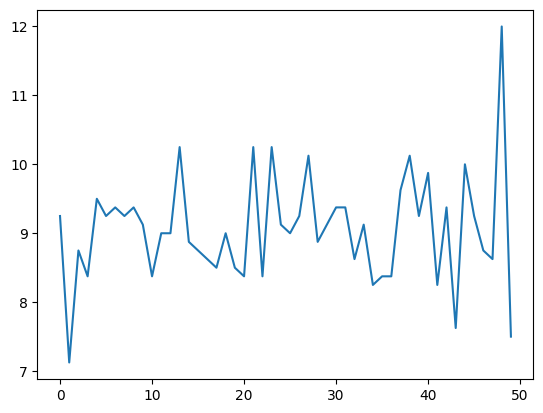

In [ ]:

plt.plot(range(0, epochs), t_acc)
plt.show()

In [ ]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(test_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs.squeeze(), targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu

In [ ]:
acc = valid(model, test_loader)
print("Accuracy on test data = %0.2f%%" % acc)

3it [00:00, 10.12it/s]

Validation Loss per 100 steps: 1.850754976272583
Validation Accuracy per 100 steps: 25.0


50it [00:03, 15.48it/s]

Validation Loss Epoch: 1.94467693567276
Validation Accuracy Epoch: 6.0
Accuracy on test data = 6.00%
